<a href="https://colab.research.google.com/github/Vedp813/Laughter_Detection/blob/main/Laughter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import h5py
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import os

# Audio  MFCC Package
import librosa
from transformers import pipeline

import torch
import librosa.display


# Merge the audio and video in the folders
import subprocess
from transformers import AutoFeatureExtractor, HubertForSequenceClassification
# Keep randomness the same
np.random.seed(0)


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# # pd.set_option('display.height', 1000)
# pd.set_option('display.width', 1000)


# Downsample all the laughs to 2.5 seconds = (44100 samples/sec * 2.5)   @44KHz
num_samples = 110250  # Each audio file should have length of 110,250 samples
num_MFCC = 20  # Number of MFCC features  (this will result in each audio having 20x216 input shape)

input_data = []


# Save home directory
project_home_dir = os.getcwd()

# Empty Annotations File
df_annotations = pd.DataFrame(index=range(0,0), columns=['Type', 'Start Time (sec)', 'End Time (sec)'])
project_home_dir

data =  '/content/drive/MyDrive/mahnob-laughter-database_download_2024-02-26_17 26 27/Sessions'

In [ ]:
for directory, subdirs, files in os.walk(data):
	# convert the subdirs name (strings) to int to sort folder numbers so our models have same order input
	subdirs = [int(i) for i in subdirs]
	subdirs.sort()
	# convert back to string
	subdirs = [str(i) for i in subdirs]
	for subdir in subdirs:

		# Inside the session folder
		os.chdir( os.path.join(project_home_dir, directory, subdir) )

		# List the files in current directory
		audio_file = [f for f in os.listdir('.') if (os.path.isfile(f) and '.wav' in f)]  #Find the audio file  (might be empty)

		df_annotation = pd.read_csv('laughterAnnotation.csv', encoding="ISO-8859-1")

		# Only include "Laughter" or "PosedLaughter" and only columns [ Type  Start Time (sec)  End Time (sec)]
		df_annotation = df_annotation.loc[(df_annotation['Type'] == 'Laughter') | (df_annotation['Type']=='PosedLaughter')].iloc[:, 1:4]

		# Concatenate it to the main annotations file
		df_annotations = pd.concat([df_annotations,df_annotation])


		# Go through the annotations for this audio file only
		for row in np.array(df_annotation):
			# row is:  	[Type   start_time	end_time]
			start_time = row[1]
			end_time = row[2]
			# Load "duration" seconds of a wav file, starting "offset" seconds in
			# y is the audio time series samples
			# sr is the sampling rate at which the audio file was samples  (default sr=22050).
			#lassifier = pipeline("audio-classification", model="superb/hubert-base-superb-er")
			#labels = classifier(audio_file[0], top_k=5)
			#print(labels)
			# Find MFCC features
			# y is the audio time series and sr is the sampling rate of y,
			y, sr = librosa.load(audio_file[0], offset=start_time, duration=(end_time-start_time), sr=None)
			if len(y) > num_samples:
				downsampled_audio = [ y[ int(np.floor(i)) ] for i in np.linspace(0,len(y)-1, num_samples)]
			#Just pad the end with zeros
			else:
				padded_zeros = [0 for i in range(0, num_samples-len(y))]
				downsampled_audio = list(y) + padded_zeros
			downsampled_audio = np.array(downsampled_audio)
			MFCCs  = librosa.feature.mfcc(y=downsampled_audio, sr=sr, n_mfcc=num_MFCC)
			#20ms window (frame) with 10ms stride (overlap is 10ms)
			# print (librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20,hop_length=int(0.010*sr), n_fft=int(0.020*sr) ).shape)
			input_data.append( MFCCs )

	# Return back to home directory
	os.chdir( project_home_dir )
	break


x_train = np.array(input_data)

print(x_train)


##################### Single Audio File Processing Example #######################
# y, sr = librosa.load("./data/audio/2.wav", sr=None, offset=0, duration=(2.6-0))
# print (librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).shape)
# # If the audio size is bigger than the number of samples, downsample it
# if len(y) > num_samples:
# 	downsampled_audio = [ y[ int(np.floor(i)) ] for i in np.linspace(0,len(y)-1, num_samples)]
# #Just pad the end with zeros
# else:
# 	padded_zeros = [0 for i in range(0, num_samples-len(y))]
# 	downsampled_audio = list(y) + padded_zeros
# print (librosa.feature.mfcc(y=np.array(downsampled_audio), sr=sr, n_mfcc=20).shape)
##################################################################################

# LSTM expects timesteps x features  (ie. 216 x 20 MFCC features)
x_train = np.swapaxes(x_train,1,2)

# # Write the data into a HDF5 File
h5f = h5py.File('Audio_Features_DL.h5', 'w')
h5f.create_dataset('dataset_features', data=x_train)
h5f.close()


[[[-3.24886299e+02 -3.66529932e+02 -4.18118607e+02 ... -4.51522175e+02
   -4.51522175e+02 -4.51522175e+02]
  [ 1.14017629e+02  9.08704036e+01  4.33842993e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.89756741e+01  4.07157461e+01  3.53436191e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 4.20804903e+00  5.54106523e+00  7.63696245e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.82806618e+00  3.80927597e+00  7.85099320e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 3.06341419e+00  4.92906602e+00  7.55582987e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]

 [[-4.48252193e+02 -4.36884664e+02 -4.38742353e+02 ... -4.70054180e+02
   -4.70054180e+02 -4.70054180e+02]
  [ 2.72634143e+01  4.06972854e+01  3.89121432e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 2.04117893e+01  2.98243897e+01  2.85615299e+01 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 3.73659554e+00  5.1

In [ ]:
import torch
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torchaudio
from s3prl.nn import S3PRLUpstream
import pickle

# Set parameters
NEW_SR = 16000
num_shards = 1
num_MFCC = 20  # Number of MFCC coefficients

# Initialize the Hubert model
model = S3PRLUpstream("hubert")
model.eval()

# Define paths
output_path = '/content/drive/MyDrive/extracted_features2/'

data_path = '/content/drive/MyDrive/mahnob-laughter-database_download_2024-02-26_17 26 27/Sessions'

# Function for mean pooling
def mean_pooling(features):
    return np.mean(features, axis=0)

# Iterate through subdirectories and files
for directory, subdirs, files in os.walk(data_path):
    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        os.chdir(subdir_path)

        # List the files in the current directory
        audio_files = [f for f in os.listdir('.') if f.endswith('.wav')]
        if not audio_files:
            continue  # Skip if no WAV files found

        # Read annotation file
        annotation_file = 'laughterAnnotation.csv'
        df_annotation = pd.read_csv(annotation_file, encoding="ISO-8859-1")

        # Iterate through annotations
        for _, row in df_annotation.iterrows():
            start_time = row['Start Time (sec)']
            end_time = row['End Time (sec)']

            # Load audio segment
            y, sr = torchaudio.load(audio_files[0], num_frames=int((end_time - start_time) * NEW_SR))

            # Pad or trim audio to fit desired length
            if y.size(1) < NEW_SR:
                padding = torch.zeros(1, NEW_SR - y.size(1))
                y = torch.cat([y, padding], dim=1)
            elif y.size(1) > NEW_SR:
                y = y[:, :NEW_SR]

            # Extract features using Hubert
            with torch.no_grad():
                outputs = model(y, torch.tensor([y.size(1)]))
                penultimate_layer_features = outputs[-2][0].squeeze().cpu().numpy()  # Assuming penultimate layer is at index -2

            # Perform mean pooling
            pooled_features = mean_pooling(penultimate_layer_features)

            # Save features
            unique_id = os.path.splitext(os.path.basename(audio_files[0]))[0]
            output_file_path = os.path.join(output_path, f'{unique_id}.pkl')
            with open(output_file_path, 'wb') as f:
                pickle.dump({0: pooled_features}, f, protocol=pickle.HIGHEST_PROTOCOL)


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
import torch
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torchaudio
from s3prl.nn import S3PRLUpstream
import pickle

# Set parameters
NEW_SR = 16000
num_shards = 1
num_MFCC = 20  # Number of MFCC coefficients

# Initialize the Hubert model
model = S3PRLUpstream("hubert")
model.eval()

# Define paths
output_path = '/content/drive/MyDrive/extracted_features3/'

data_path = '/content/drive/MyDrive/mahnob-laughter-database_download_2024-02-26_17 26 27/Sessions'

# Function for mean pooling
def mean_pooling(features):
    return np.mean(features, axis=0)

# Iterate through subdirectories and files
for directory, subdirs, files in os.walk(data_path):
    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        os.chdir(subdir_path)

        # List the files in the current directory
        audio_files = [f for f in os.listdir('.') if f.endswith('.wav')]
        if not audio_files:
            continue  # Skip if no WAV files found

        # Read annotation file
        annotation_file = 'laughterAnnotation.csv'
        df_annotation = pd.read_csv(annotation_file, encoding="ISO-8859-1")

        # Iterate through annotations
        for _, row in df_annotation.iterrows():
            start_time = row['Start Time (sec)']
            end_time = row['End Time (sec)']
            annotation_type = row['Type']  # Extract the type from the annotation

            # Load audio segment
            y, sr = torchaudio.load(audio_files[0], num_frames=int((end_time - start_time) * NEW_SR))

            # Pad or trim audio to fit desired length
            if y.size(1) < NEW_SR:
                padding = torch.zeros(1, NEW_SR - y.size(1))
                y = torch.cat([y, padding], dim=1)
            elif y.size(1) > NEW_SR:
                y = y[:, :NEW_SR]

            # Extract features using Hubert
            with torch.no_grad():
                outputs = model(y, torch.tensor([y.size(1)]))
                penultimate_layer_features = outputs[-2][0].squeeze().cpu().numpy()  # Assuming penultimate layer is at index -2

            # Perform mean pooling
            pooled_features = mean_pooling(penultimate_layer_features)

            # Construct unique ID with type
            unique_id = os.path.splitext(os.path.basename(audio_files[0]))[0] + "_" + annotation_type

            # Save features
            output_file_path = os.path.join(output_path, f'{unique_id}.pkl')
            with open(output_file_path, 'wb') as f:
                pickle.dump({0: pooled_features}, f, protocol=pickle.HIGHEST_PROTOCOL)


/usr/local/lib/python3.10/dist-packages/s3prl/upstream/byol_s/byol_a/common.py:20: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
Downloading: https://huggingface.co/s3prl/converted_ckpts/resolve/main/hubert_base_ls960.pt
Destination: /root/.cache/s3prl/download/cc1d9e25da3db01e710fe51bbcc725322be55e3d6eebc947f0aa4743e81bfc34.hubert_base_ls960.pt
100%|██████████| 361M/361M [00:04<00:00, 90.0MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        #label = file_name.split("_")[-1].split(".")[0]
        label = file_name.split("_")[-2]

        with open(os.path.join(self.folder_path, file_name), 'rb') as f:
            features = pickle.load(f)
        features_tensor = torch.tensor(features[0], dtype=torch.float32)
        label_dict = {"SpeechLaughter":0,"Speech":1,"PosedLaughter":2,"Laughter":3}
        return features_tensor, label_dict[label]
class ImprovedModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x



# Define your model
input_size = 768  # Define input size based on the feature dimensionality
hidden_size = 128  # Define hidden size for GRU
# Define number of GRU layers
num_classes = 4  # Define the number of classes
model = ImprovedModel(input_size, num_classes)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create custom dataset and dataloader
dataset = CustomDataset(folder_path='/content/drive/MyDrive/Multimodal/extracted_features5')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch [1/10], Loss: 1.0912, Accuracy: 43.87%
Epoch [2/10], Loss: 0.8521, Accuracy: 64.94%
Epoch [3/10], Loss: 0.7461, Accuracy: 73.76%
Epoch [4/10], Loss: 0.7061, Accuracy: 75.08%
Epoch [5/10], Loss: 0.6630, Accuracy: 78.42%
Epoch [6/10], Loss: 0.6694, Accuracy: 77.41%
Epoch [7/10], Loss: 0.6193, Accuracy: 80.95%
Epoch [8/10], Loss: 0.6009, Accuracy: 80.24%
Epoch [9/10], Loss: 0.5865, Accuracy: 80.85%
Epoch [10/10], Loss: 0.5596, Accuracy: 82.37%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Video**

In [ ]:
import os
import cv2 # Computer Vision
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip

np.random.seed(0)

num_frames_to_use = 16
img_size = 70

input_data = []
project_home_dir = os.getcwd()

# Empty Annotations File
df_annotations = pd.DataFrame(index=range(0, 0), columns=['Type', 'Start Time (sec)', 'End Time (sec)'])

data_video = "/content/drive/MyDrive/mahnob-laughter-database_download_2024-02-26_17 26 27/Sessions"
#Navigation through the database
for directory, subdirs, files in os.walk(data_video):
    subdirs = [int(i) for i in subdirs]
    subdirs.sort()
    subdirs = [str(i) for i in subdirs]
    for subdir in subdirs:
        os.chdir(os.path.join(project_home_dir, directory, subdir))

        # List the files in current directory
        video_file = [f for f in os.listdir('.') if (os.path.isfile(f) and '.avi' in f)]


        # only include columns [ Type  Start Time (sec)  End Time (sec)]
        # df_annotation = df_annotation.loc[(df_annotation['Type'] == 'Laughter') | (df_annotation['Type'] == 'PosedLaughter')].iloc[:, 1:4]
        df_annotation = df_annotation.iloc[:, 1:4]

        df_annotations = pd.concat([df_annotations, df_annotation])

        # Going through single video at a time
        for index, row in enumerate(np.array(df_annotation)):
            start_time = row[1]
            end_time = row[2]

            #Read each video and edit it
            editted_vid = VideoFileClip(video_file[0]).subclip(start_time, end_time)
            editted_name = str(start_time) + "_" + str(end_time) + ".mp4"
            editted_vid.write_videofile(editted_name)
            vidcap = cv2.VideoCapture(editted_name)
            num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
            image_frames = [cv2.resize(vidcap.read()[1], (img_size, img_size)) for i in range(0, int(num_frames))]

            # If the video size is bigger than the desired number of samples, downsample it to 25
            if len(image_frames) > num_frames_to_use:
                downsampled_frames = [image_frames[int(np.floor(i))] for i in np.linspace(0, len(image_frames) - 1, num_frames_to_use)]

            # Just pad the end with zeros (black frames)
            else:
                w, h, c = image_frames[0].shape
                padded_frames = [np.zeros((w, h, c)) for i in range(0, num_frames_to_use - len(image_frames))]
                downsampled_frames = image_frames + padded_frames

            downsampled_frames = np.array(downsampled_frames)
            input_data.append(downsampled_frames)

            # Remove the editted video
            os.remove(editted_name)

    os.chdir(project_home_dir)
    break

# A single video/data sample is 4D: (frames, width, height, channels)
x_trains = np.array(input_data)

# Scale and normalize the values, divide by 255
x_trains = x_trains / 255

# Write the data into a HDF5 File
# h5f = h5py.File('Video_Features_RGB_DL.h5', 'w')
# h5f.create_dataset('dataset_features', data=x_train)
# h5f.close()

Moviepy - Building video 34.92_35.742.mp4.
Moviepy - Writing video 34.92_35.742.mp4



Moviepy - Done !
Moviepy - video ready 34.92_35.742.mp4
Moviepy - Building video 38.508_39.42.mp4.
Moviepy - Writing video 38.508_39.42.mp4



Moviepy - Done !
Moviepy - video ready 38.508_39.42.mp4
Moviepy - Building video 40.41_41.244.mp4.
Moviepy - Writing video 40.41_41.244.mp4



Moviepy - Done !
Moviepy - video ready 40.41_41.244.mp4
Moviepy - Building video 3.456_4.008.mp4.
Moviepy - Writing video 3.456_4.008.mp4



Moviepy - Done !
Moviepy - video ready 3.456_4.008.mp4
Moviepy - Building video 33.936_34.512.mp4.
Moviepy - Writing video 33.936_34.512.mp4



Moviepy - Done !
Moviepy - video ready 33.936_34.512.mp4
Moviepy - Building video 39.684_40.302.mp4.
Moviepy - Writing video 39.684_40.302.mp4



Moviepy - Done !
Moviepy - video ready 39.684_40.302.mp4
Moviepy - Building video 43.692_44.844.mp4.
Moviepy - Writing video 43.692_44.844.mp4



Moviepy - Done !
Moviepy - video ready 43.692_44.844.mp4
Moviepy - Building video 50.046_52.194.mp4.
Moviepy - Writing video 50.046_52.194.mp4



Moviepy - Done !
Moviepy - video ready 50.046_52.194.mp4
Moviepy - Building video 53.448_55.626.mp4.
Moviepy - Writing video 53.448_55.626.mp4



Moviepy - Done !
Moviepy - video ready 53.448_55.626.mp4
Moviepy - Building video 19.662_20.118.mp4.
Moviepy - Writing video 19.662_20.118.mp4



Moviepy - Done !
Moviepy - video ready 19.662_20.118.mp4
Moviepy - Building video 66.726_67.332.mp4.
Moviepy - Writing video 66.726_67.332.mp4



Moviepy - Done !
Moviepy - video ready 66.726_67.332.mp4
Moviepy - Building video 77.31_77.904.mp4.
Moviepy - Writing video 77.31_77.904.mp4



Moviepy - Done !
Moviepy - video ready 77.31_77.904.mp4
Moviepy - Building video 7.92_8.154.mp4.
Moviepy - Writing video 7.92_8.154.mp4



Moviepy - Done !
Moviepy - video ready 7.92_8.154.mp4


Moviepy - Building video 0.462_1.638.mp4.
Moviepy - Writing video 0.462_1.638.mp4



Moviepy - Done !
Moviepy - video ready 0.462_1.638.mp4
Moviepy - Building video 3.834_4.854.mp4.
Moviepy - Writing video 3.834_4.854.mp4



Moviepy - Done !
Moviepy - video ready 3.834_4.854.mp4
Moviepy - Building video 7.866_8.946.mp4.
Moviepy - Writing video 7.866_8.946.mp4



Moviepy - Done !
Moviepy - video ready 7.866_8.946.mp4
Moviepy - Building video 14.358_15.27.mp4.
Moviepy - Writing video 14.358_15.27.mp4



Moviepy - Done !
Moviepy - video ready 14.358_15.27.mp4
Moviepy - Building video 0.0_0.48.mp4.
Moviepy - Writing video 0.0_0.48.mp4



Moviepy - Done !
Moviepy - video ready 0.0_0.48.mp4
Moviepy - Building video 1.098_2.538.mp4.
Moviepy - Writing video 1.098_2.538.mp4



Moviepy - Done !
Moviepy - video ready 1.098_2.538.mp4
Moviepy - Building video 4.71_6.468.mp4.
Moviepy - Writing video 4.71_6.468.mp4



Moviepy - Done !
Moviepy - video ready 4.71_6.468.mp4
Moviepy - Building video 6.846_9.294.mp4.
Moviepy - Writing video 6.846_9.294.mp4



Moviepy - Done !
Moviepy - video ready 6.846_9.294.mp4
Moviepy - Building video 10.002_11.286.mp4.
Moviepy - Writing video 10.002_11.286.mp4



Moviepy - Done !
Moviepy - video ready 10.002_11.286.mp4
Moviepy - Building video 12.576_13.932.mp4.
Moviepy - Writing video 12.576_13.932.mp4



Moviepy - Done !
Moviepy - video ready 12.576_13.932.mp4
Moviepy - Building video 14.76_15.858.mp4.
Moviepy - Writing video 14.76_15.858.mp4



Moviepy - Done !
Moviepy - video ready 14.76_15.858.mp4
Moviepy - Building video 16.2_19.32.mp4.
Moviepy - Writing video 16.2_19.32.mp4



Moviepy - Done !
Moviepy - video ready 16.2_19.32.mp4
Moviepy - Building video 20.178_23.802.mp4.
Moviepy - Writing video 20.178_23.802.mp4



Moviepy - Done !
Moviepy - video ready 20.178_23.802.mp4
Moviepy - Building video 24.582_28.62.mp4.
Moviepy - Writing video 24.582_28.62.mp4



Moviepy - Done !
Moviepy - video ready 24.582_28.62.mp4
Moviepy - Building video 28.866_34.068.mp4.
Moviepy - Writing video 28.866_34.068.mp4



Moviepy - Done !
Moviepy - video ready 28.866_34.068.mp4
Moviepy - Building video 34.758_38.892.mp4.
Moviepy - Writing video 34.758_38.892.mp4



Moviepy - Done !
Moviepy - video ready 34.758_38.892.mp4
Moviepy - Building video 39.258_40.506.mp4.
Moviepy - Writing video 39.258_40.506.mp4



Moviepy - Done !
Moviepy - video ready 39.258_40.506.mp4
Moviepy - Building video 40.926_41.172.mp4.
Moviepy - Writing video 40.926_41.172.mp4



Moviepy - Done !
Moviepy - video ready 40.926_41.172.mp4
Moviepy - Building video 43.296_47.016.mp4.
Moviepy - Writing video 43.296_47.016.mp4



Moviepy - Done !
Moviepy - video ready 43.296_47.016.mp4
Moviepy - Building video 47.412_53.538.mp4.
Moviepy - Writing video 47.412_53.538.mp4



Moviepy - Done !
Moviepy - video ready 47.412_53.538.mp4
Moviepy - Building video 54.72_56.052.mp4.
Moviepy - Writing video 54.72_56.052.mp4



Moviepy - Done !
Moviepy - video ready 54.72_56.052.mp4
Moviepy - Building video 56.964_58.56.mp4.
Moviepy - Writing video 56.964_58.56.mp4



Moviepy - Done !
Moviepy - video ready 56.964_58.56.mp4
Moviepy - Building video 60.21_61.128.mp4.
Moviepy - Writing video 60.21_61.128.mp4



Moviepy - Done !
Moviepy - video ready 60.21_61.128.mp4
Moviepy - Building video 63.468_64.746.mp4.
Moviepy - Writing video 63.468_64.746.mp4



Moviepy - Done !
Moviepy - video ready 63.468_64.746.mp4
Moviepy - Building video 65.466_66.762.mp4.
Moviepy - Writing video 65.466_66.762.mp4



Moviepy - Done !
Moviepy - video ready 65.466_66.762.mp4
Moviepy - Building video 69.408_76.338.mp4.
Moviepy - Writing video 69.408_76.338.mp4



Moviepy - Done !
Moviepy - video ready 69.408_76.338.mp4
Moviepy - Building video 78.336_83.172.mp4.
Moviepy - Writing video 78.336_83.172.mp4



Moviepy - Done !
Moviepy - video ready 78.336_83.172.mp4
Moviepy - Building video 83.868_86.37.mp4.
Moviepy - Writing video 83.868_86.37.mp4



Moviepy - Done !
Moviepy - video ready 83.868_86.37.mp4
Moviepy - Building video 86.724_91.95.mp4.
Moviepy - Writing video 86.724_91.95.mp4



Moviepy - Done !
Moviepy - video ready 86.724_91.95.mp4
Moviepy - Building video 92.274_93.726.mp4.
Moviepy - Writing video 92.274_93.726.mp4



Moviepy - Done !
Moviepy - video ready 92.274_93.726.mp4
Moviepy - Building video 95.172_96.6.mp4.
Moviepy - Writing video 95.172_96.6.mp4



Moviepy - Done !
Moviepy - video ready 95.172_96.6.mp4
Moviepy - Building video 97.08_101.292.mp4.
Moviepy - Writing video 97.08_101.292.mp4



Moviepy - Done !
Moviepy - video ready 97.08_101.292.mp4
Moviepy - Building video 101.76_102.984.mp4.
Moviepy - Writing video 101.76_102.984.mp4



Moviepy - Done !
Moviepy - video ready 101.76_102.984.mp4
Moviepy - Building video 105.102_106.488.mp4.
Moviepy - Writing video 105.102_106.488.mp4



Moviepy - Done !
Moviepy - video ready 105.102_106.488.mp4
Moviepy - Building video 4.26_4.584.mp4.
Moviepy - Writing video 4.26_4.584.mp4



Moviepy - Done !
Moviepy - video ready 4.26_4.584.mp4
Moviepy - Building video 6.57_7.77.mp4.
Moviepy - Writing video 6.57_7.77.mp4



Moviepy - Done !
Moviepy - video ready 6.57_7.77.mp4
Moviepy - Building video 10.02_11.796.mp4.
Moviepy - Writing video 10.02_11.796.mp4



Moviepy - Done !
Moviepy - video ready 10.02_11.796.mp4
Moviepy - Building video 12.372_13.002.mp4.
Moviepy - Writing video 12.372_13.002.mp4



Moviepy - Done !
Moviepy - video ready 12.372_13.002.mp4
Moviepy - Building video 13.002_16.944.mp4.
Moviepy - Writing video 13.002_16.944.mp4



Moviepy - Done !
Moviepy - video ready 13.002_16.944.mp4
Moviepy - Building video 17.556_18.456.mp4.
Moviepy - Writing video 17.556_18.456.mp4



Moviepy - Done !
Moviepy - video ready 17.556_18.456.mp4
Moviepy - Building video 19.158_20.574.mp4.
Moviepy - Writing video 19.158_20.574.mp4



Moviepy - Done !
Moviepy - video ready 19.158_20.574.mp4
Moviepy - Building video 21.216_21.584.mp4.
Moviepy - Writing video 21.216_21.584.mp4



Moviepy - Done !
Moviepy - video ready 21.216_21.584.mp4
Moviepy - Building video 21.966_27.42.mp4.
Moviepy - Writing video 21.966_27.42.mp4



Moviepy - Done !
Moviepy - video ready 21.966_27.42.mp4
Moviepy - Building video 29.436_33.54.mp4.
Moviepy - Writing video 29.436_33.54.mp4



Moviepy - Done !
Moviepy - video ready 29.436_33.54.mp4
Moviepy - Building video 34.842_36.108.mp4.
Moviepy - Writing video 34.842_36.108.mp4



Moviepy - Done !
Moviepy - video ready 34.842_36.108.mp4
Moviepy - Building video 37.872_38.634.mp4.
Moviepy - Writing video 37.872_38.634.mp4



Moviepy - Done !
Moviepy - video ready 37.872_38.634.mp4
Moviepy - Building video 39.822_43.722.mp4.
Moviepy - Writing video 39.822_43.722.mp4



Moviepy - Done !
Moviepy - video ready 39.822_43.722.mp4
Moviepy - Building video 45.288_50.556.mp4.
Moviepy - Writing video 45.288_50.556.mp4



Moviepy - Done !
Moviepy - video ready 45.288_50.556.mp4
Moviepy - Building video 51.342_51.948.mp4.
Moviepy - Writing video 51.342_51.948.mp4



Moviepy - Done !
Moviepy - video ready 51.342_51.948.mp4
Moviepy - Building video 52.506_54.528.mp4.
Moviepy - Writing video 52.506_54.528.mp4



Moviepy - Done !
Moviepy - video ready 52.506_54.528.mp4
Moviepy - Building video 55.68_59.37.mp4.
Moviepy - Writing video 55.68_59.37.mp4



Moviepy - Done !
Moviepy - video ready 55.68_59.37.mp4
Moviepy - Building video 60.072_60.9.mp4.
Moviepy - Writing video 60.072_60.9.mp4



Moviepy - Done !
Moviepy - video ready 60.072_60.9.mp4
Moviepy - Building video 61.362_62.022.mp4.
Moviepy - Writing video 61.362_62.022.mp4



Moviepy - Done !
Moviepy - video ready 61.362_62.022.mp4
Moviepy - Building video 62.838_64.236.mp4.
Moviepy - Writing video 62.838_64.236.mp4



Moviepy - Done !
Moviepy - video ready 62.838_64.236.mp4
Moviepy - Building video 64.434_64.904.mp4.
Moviepy - Writing video 64.434_64.904.mp4



Moviepy - Done !
Moviepy - video ready 64.434_64.904.mp4
Moviepy - Building video 65.184_67.764.mp4.
Moviepy - Writing video 65.184_67.764.mp4



Moviepy - Done !
Moviepy - video ready 65.184_67.764.mp4
Moviepy - Building video 72.0_79.728.mp4.
Moviepy - Writing video 72.0_79.728.mp4



Moviepy - Done !
Moviepy - video ready 72.0_79.728.mp4
Moviepy - Building video 80.76_85.056.mp4.
Moviepy - Writing video 80.76_85.056.mp4



Moviepy - Done !
Moviepy - video ready 80.76_85.056.mp4
Moviepy - Building video 89.118_92.274.mp4.
Moviepy - Writing video 89.118_92.274.mp4



Moviepy - Done !
Moviepy - video ready 89.118_92.274.mp4
Moviepy - Building video 94.326_100.65.mp4.
Moviepy - Writing video 94.326_100.65.mp4



Moviepy - Done !
Moviepy - video ready 94.326_100.65.mp4
Moviepy - Building video 101.316_106.32.mp4.
Moviepy - Writing video 101.316_106.32.mp4



Moviepy - Done !
Moviepy - video ready 101.316_106.32.mp4
Moviepy - Building video 106.74_109.884.mp4.
Moviepy - Writing video 106.74_109.884.mp4



Moviepy - Done !
Moviepy - video ready 106.74_109.884.mp4
Moviepy - Building video 110.682_111.006.mp4.
Moviepy - Writing video 110.682_111.006.mp4



Moviepy - Done !
Moviepy - video ready 110.682_111.006.mp4
Moviepy - Building video 0.576_7.542.mp4.
Moviepy - Writing video 0.576_7.542.mp4



Moviepy - Done !
Moviepy - video ready 0.576_7.542.mp4
Moviepy - Building video 9.636_13.038.mp4.
Moviepy - Writing video 9.636_13.038.mp4



Moviepy - Done !
Moviepy - video ready 9.636_13.038.mp4
Moviepy - Building video 17.226_31.812.mp4.
Moviepy - Writing video 17.226_31.812.mp4



Moviepy - Done !
Moviepy - video ready 17.226_31.812.mp4
Moviepy - Building video 33.828_61.96.mp4.
Moviepy - Writing video 33.828_61.96.mp4



Moviepy - Done !
Moviepy - video ready 33.828_61.96.mp4
Moviepy - Building video 63.75_64.92.mp4.
Moviepy - Writing video 63.75_64.92.mp4



Moviepy - Done !
Moviepy - video ready 63.75_64.92.mp4
Moviepy - Building video 66.654_70.576.mp4.
Moviepy - Writing video 66.654_70.576.mp4



Moviepy - Done !
Moviepy - video ready 66.654_70.576.mp4
Moviepy - Building video 71.58_84.846.mp4.
Moviepy - Writing video 71.58_84.846.mp4



Moviepy - Done !
Moviepy - video ready 71.58_84.846.mp4
Moviepy - Building video 86.19_87.576.mp4.
Moviepy - Writing video 86.19_87.576.mp4



Moviepy - Done !
Moviepy - video ready 86.19_87.576.mp4
Moviepy - Building video 88.428_93.414.mp4.
Moviepy - Writing video 88.428_93.414.mp4



Moviepy - Done !
Moviepy - video ready 88.428_93.414.mp4
Moviepy - Building video 94.92_104.628.mp4.
Moviepy - Writing video 94.92_104.628.mp4



Moviepy - Done !
Moviepy - video ready 94.92_104.628.mp4
Moviepy - Building video 107.398_108.946.mp4.
Moviepy - Writing video 107.398_108.946.mp4



Moviepy - Done !
Moviepy - video ready 107.398_108.946.mp4
Moviepy - Building video 4.794_5.088.mp4.
Moviepy - Writing video 4.794_5.088.mp4



Moviepy - Done !
Moviepy - video ready 4.794_5.088.mp4
Moviepy - Building video 2.55_8.256.mp4.
Moviepy - Writing video 2.55_8.256.mp4



Moviepy - Done !
Moviepy - video ready 2.55_8.256.mp4
Moviepy - Building video 8.454_9.114.mp4.
Moviepy - Writing video 8.454_9.114.mp4



Moviepy - Done !
Moviepy - video ready 8.454_9.114.mp4
Moviepy - Building video 9.408_15.648.mp4.
Moviepy - Writing video 9.408_15.648.mp4



Moviepy - Done !
Moviepy - video ready 9.408_15.648.mp4
Moviepy - Building video 16.068_17.28.mp4.
Moviepy - Writing video 16.068_17.28.mp4



Moviepy - Done !
Moviepy - video ready 16.068_17.28.mp4
Moviepy - Building video 17.55_20.76.mp4.
Moviepy - Writing video 17.55_20.76.mp4



Moviepy - Done !
Moviepy - video ready 17.55_20.76.mp4
Moviepy - Building video 20.808_25.092.mp4.
Moviepy - Writing video 20.808_25.092.mp4



Moviepy - Done !
Moviepy - video ready 20.808_25.092.mp4
Moviepy - Building video 27.672_34.002.mp4.
Moviepy - Writing video 27.672_34.002.mp4



Moviepy - Done !
Moviepy - video ready 27.672_34.002.mp4
Moviepy - Building video 34.002_36.24.mp4.
Moviepy - Writing video 34.002_36.24.mp4



Moviepy - Done !
Moviepy - video ready 34.002_36.24.mp4
Moviepy - Building video 37.008_37.956.mp4.
Moviepy - Writing video 37.008_37.956.mp4



Moviepy - Done !
Moviepy - video ready 37.008_37.956.mp4
Moviepy - Building video 39.192_44.388.mp4.
Moviepy - Writing video 39.192_44.388.mp4



Moviepy - Done !
Moviepy - video ready 39.192_44.388.mp4
Moviepy - Building video 45.576_50.496.mp4.
Moviepy - Writing video 45.576_50.496.mp4



Moviepy - Done !
Moviepy - video ready 45.576_50.496.mp4
Moviepy - Building video 51.324_56.922.mp4.
Moviepy - Writing video 51.324_56.922.mp4



Moviepy - Done !
Moviepy - video ready 51.324_56.922.mp4
Moviepy - Building video 57.864_61.332.mp4.
Moviepy - Writing video 57.864_61.332.mp4



Moviepy - Done !
Moviepy - video ready 57.864_61.332.mp4
Moviepy - Building video 61.758_67.644.mp4.
Moviepy - Writing video 61.758_67.644.mp4



Moviepy - Done !
Moviepy - video ready 61.758_67.644.mp4
Moviepy - Building video 67.884_70.578.mp4.
Moviepy - Writing video 67.884_70.578.mp4



Moviepy - Done !
Moviepy - video ready 67.884_70.578.mp4
Moviepy - Building video 73.284_76.506.mp4.
Moviepy - Writing video 73.284_76.506.mp4



Moviepy - Done !
Moviepy - video ready 73.284_76.506.mp4
Moviepy - Building video 76.776_83.268.mp4.
Moviepy - Writing video 76.776_83.268.mp4



Moviepy - Done !
Moviepy - video ready 76.776_83.268.mp4
Moviepy - Building video 83.772_85.956.mp4.
Moviepy - Writing video 83.772_85.956.mp4



Moviepy - Done !
Moviepy - video ready 83.772_85.956.mp4
Moviepy - Building video 86.916_88.536.mp4.
Moviepy - Writing video 86.916_88.536.mp4



Moviepy - Done !
Moviepy - video ready 86.916_88.536.mp4
Moviepy - Building video 0.57_2.304.mp4.
Moviepy - Writing video 0.57_2.304.mp4



Moviepy - Done !
Moviepy - video ready 0.57_2.304.mp4
Moviepy - Building video 3.972_4.86.mp4.
Moviepy - Writing video 3.972_4.86.mp4



Moviepy - Done !
Moviepy - video ready 3.972_4.86.mp4
Moviepy - Building video 5.214_5.634.mp4.
Moviepy - Writing video 5.214_5.634.mp4



Moviepy - Done !
Moviepy - video ready 5.214_5.634.mp4
Moviepy - Building video 6.048_6.72.mp4.
Moviepy - Writing video 6.048_6.72.mp4



Moviepy - Done !
Moviepy - video ready 6.048_6.72.mp4
Moviepy - Building video 7.104_7.518.mp4.
Moviepy - Writing video 7.104_7.518.mp4



Moviepy - Done !
Moviepy - video ready 7.104_7.518.mp4
Moviepy - Building video 9.834_11.496.mp4.
Moviepy - Writing video 9.834_11.496.mp4



Moviepy - Done !
Moviepy - video ready 9.834_11.496.mp4
Moviepy - Building video 12.816_14.514.mp4.
Moviepy - Writing video 12.816_14.514.mp4



Moviepy - Done !
Moviepy - video ready 12.816_14.514.mp4
Moviepy - Building video 14.82_17.484.mp4.
Moviepy - Writing video 14.82_17.484.mp4



Moviepy - Done !
Moviepy - video ready 14.82_17.484.mp4
Moviepy - Building video 18.678_27.18.mp4.
Moviepy - Writing video 18.678_27.18.mp4



Moviepy - Done !
Moviepy - video ready 18.678_27.18.mp4
Moviepy - Building video 27.498_30.828.mp4.
Moviepy - Writing video 27.498_30.828.mp4



Moviepy - Done !
Moviepy - video ready 27.498_30.828.mp4
Moviepy - Building video 32.598_37.062.mp4.
Moviepy - Writing video 32.598_37.062.mp4



Moviepy - Done !
Moviepy - video ready 32.598_37.062.mp4
Moviepy - Building video 37.326_39.366.mp4.
Moviepy - Writing video 37.326_39.366.mp4



Moviepy - Done !
Moviepy - video ready 37.326_39.366.mp4
Moviepy - Building video 40.542_43.002.mp4.
Moviepy - Writing video 40.542_43.002.mp4



Moviepy - Done !
Moviepy - video ready 40.542_43.002.mp4
Moviepy - Building video 44.262_46.884.mp4.
Moviepy - Writing video 44.262_46.884.mp4



Moviepy - Done !
Moviepy - video ready 44.262_46.884.mp4
Moviepy - Building video 47.748_49.482.mp4.
Moviepy - Writing video 47.748_49.482.mp4



Moviepy - Done !
Moviepy - video ready 47.748_49.482.mp4
Moviepy - Building video 51.57_52.47.mp4.
Moviepy - Writing video 51.57_52.47.mp4



Moviepy - Done !
Moviepy - video ready 51.57_52.47.mp4
Moviepy - Building video 7.044_10.29.mp4.
Moviepy - Writing video 7.044_10.29.mp4



Moviepy - Done !
Moviepy - video ready 7.044_10.29.mp4
Moviepy - Building video 10.314_11.382.mp4.
Moviepy - Writing video 10.314_11.382.mp4



Moviepy - Done !
Moviepy - video ready 10.314_11.382.mp4
Moviepy - Building video 12.33_16.002.mp4.
Moviepy - Writing video 12.33_16.002.mp4



Moviepy - Done !
Moviepy - video ready 12.33_16.002.mp4
Moviepy - Building video 20.184_21.09.mp4.
Moviepy - Writing video 20.184_21.09.mp4



Moviepy - Done !
Moviepy - video ready 20.184_21.09.mp4
Moviepy - Building video 21.864_23.022.mp4.
Moviepy - Writing video 21.864_23.022.mp4



Moviepy - Done !
Moviepy - video ready 21.864_23.022.mp4
Moviepy - Building video 23.922_24.954.mp4.
Moviepy - Writing video 23.922_24.954.mp4



Moviepy - Done !
Moviepy - video ready 23.922_24.954.mp4
Moviepy - Building video 3.84_4.884.mp4.
Moviepy - Writing video 3.84_4.884.mp4



Moviepy - Done !
Moviepy - video ready 3.84_4.884.mp4
Moviepy - Building video 8.34_9.546.mp4.
Moviepy - Writing video 8.34_9.546.mp4



Moviepy - Done !
Moviepy - video ready 8.34_9.546.mp4
Moviepy - Building video 11.772_12.672.mp4.
Moviepy - Writing video 11.772_12.672.mp4



Moviepy - Done !
Moviepy - video ready 11.772_12.672.mp4
Moviepy - Building video 1.806_5.976.mp4.
Moviepy - Writing video 1.806_5.976.mp4



Moviepy - Done !
Moviepy - video ready 1.806_5.976.mp4
Moviepy - Building video 8.406_9.6.mp4.
Moviepy - Writing video 8.406_9.6.mp4



Moviepy - Done !
Moviepy - video ready 8.406_9.6.mp4
Moviepy - Building video 14.052_15.558.mp4.
Moviepy - Writing video 14.052_15.558.mp4



Moviepy - Done !
Moviepy - video ready 14.052_15.558.mp4
Moviepy - Building video 2.43_3.684.mp4.
Moviepy - Writing video 2.43_3.684.mp4



Moviepy - Done !
Moviepy - video ready 2.43_3.684.mp4
Moviepy - Building video 0.312_1.08.mp4.
Moviepy - Writing video 0.312_1.08.mp4



Moviepy - Done !
Moviepy - video ready 0.312_1.08.mp4
Moviepy - Building video 7.32_7.65.mp4.
Moviepy - Writing video 7.32_7.65.mp4



Moviepy - Done !
Moviepy - video ready 7.32_7.65.mp4
Moviepy - Building video 11.226_11.652.mp4.
Moviepy - Writing video 11.226_11.652.mp4



Moviepy - Done !
Moviepy - video ready 11.226_11.652.mp4
Moviepy - Building video 0.0_1.212.mp4.
Moviepy - Writing video 0.0_1.212.mp4



Moviepy - Done !
Moviepy - video ready 0.0_1.212.mp4
Moviepy - Building video 2.352_3.51.mp4.
Moviepy - Writing video 2.352_3.51.mp4



Moviepy - Done !
Moviepy - video ready 2.352_3.51.mp4
Moviepy - Building video 3.51_4.794.mp4.
Moviepy - Writing video 3.51_4.794.mp4



Moviepy - Done !
Moviepy - video ready 3.51_4.794.mp4
Moviepy - Building video 4.812_5.69.mp4.
Moviepy - Writing video 4.812_5.69.mp4



Moviepy - Done !
Moviepy - video ready 4.812_5.69.mp4
Moviepy - Building video 9.33_11.544.mp4.
Moviepy - Writing video 9.33_11.544.mp4



Moviepy - Done !
Moviepy - video ready 9.33_11.544.mp4
Moviepy - Building video 12.834_16.68.mp4.
Moviepy - Writing video 12.834_16.68.mp4



Moviepy - Done !
Moviepy - video ready 12.834_16.68.mp4
Moviepy - Building video 17.346_22.074.mp4.
Moviepy - Writing video 17.346_22.074.mp4



Moviepy - Done !
Moviepy - video ready 17.346_22.074.mp4
Moviepy - Building video 22.638_23.874.mp4.
Moviepy - Writing video 22.638_23.874.mp4



Moviepy - Done !
Moviepy - video ready 22.638_23.874.mp4
Moviepy - Building video 24.66_29.736.mp4.
Moviepy - Writing video 24.66_29.736.mp4



Moviepy - Done !
Moviepy - video ready 24.66_29.736.mp4
Moviepy - Building video 30.498_31.92.mp4.
Moviepy - Writing video 30.498_31.92.mp4



Moviepy - Done !
Moviepy - video ready 30.498_31.92.mp4
Moviepy - Building video 36.024_42.108.mp4.
Moviepy - Writing video 36.024_42.108.mp4



Moviepy - Done !
Moviepy - video ready 36.024_42.108.mp4
Moviepy - Building video 42.696_44.916.mp4.
Moviepy - Writing video 42.696_44.916.mp4



Moviepy - Done !
Moviepy - video ready 42.696_44.916.mp4
Moviepy - Building video 46.908_52.242.mp4.
Moviepy - Writing video 46.908_52.242.mp4



Moviepy - Done !
Moviepy - video ready 46.908_52.242.mp4
Moviepy - Building video 4.116_5.214.mp4.
Moviepy - Writing video 4.116_5.214.mp4



Moviepy - Done !
Moviepy - video ready 4.116_5.214.mp4
Moviepy - Building video 5.208_5.848.mp4.
Moviepy - Writing video 5.208_5.848.mp4



Moviepy - Done !
Moviepy - video ready 5.208_5.848.mp4
Moviepy - Building video 9.768_12.12.mp4.
Moviepy - Writing video 9.768_12.12.mp4



Moviepy - Done !
Moviepy - video ready 9.768_12.12.mp4
Moviepy - Building video 12.42_17.88.mp4.
Moviepy - Writing video 12.42_17.88.mp4



Moviepy - Done !
Moviepy - video ready 12.42_17.88.mp4
Moviepy - Building video 18.594_24.678.mp4.
Moviepy - Writing video 18.594_24.678.mp4



Moviepy - Done !
Moviepy - video ready 18.594_24.678.mp4
Moviepy - Building video 25.194_30.294.mp4.
Moviepy - Writing video 25.194_30.294.mp4



Moviepy - Done !
Moviepy - video ready 25.194_30.294.mp4
Moviepy - Building video 30.912_34.95.mp4.
Moviepy - Writing video 30.912_34.95.mp4



Moviepy - Done !
Moviepy - video ready 30.912_34.95.mp4
Moviepy - Building video 35.478_39.228.mp4.
Moviepy - Writing video 35.478_39.228.mp4



Moviepy - Done !
Moviepy - video ready 35.478_39.228.mp4
Moviepy - Building video 40.32_43.32.mp4.
Moviepy - Writing video 40.32_43.32.mp4



Moviepy - Done !
Moviepy - video ready 40.32_43.32.mp4
Moviepy - Building video 41.634_48.618.mp4.
Moviepy - Writing video 41.634_48.618.mp4



Moviepy - Done !
Moviepy - video ready 41.634_48.618.mp4
Moviepy - Building video 10.782_11.016.mp4.
Moviepy - Writing video 10.782_11.016.mp4



Moviepy - Done !
Moviepy - video ready 10.782_11.016.mp4


Moviepy - Building video 12.96_16.524.mp4.
Moviepy - Writing video 12.96_16.524.mp4



Moviepy - Done !
Moviepy - video ready 12.96_16.524.mp4
Moviepy - Building video 18.432_18.798.mp4.
Moviepy - Writing video 18.432_18.798.mp4



Moviepy - Done !
Moviepy - video ready 18.432_18.798.mp4
Moviepy - Building video 23.694_25.398.mp4.
Moviepy - Writing video 23.694_25.398.mp4



Moviepy - Done !
Moviepy - video ready 23.694_25.398.mp4
Moviepy - Building video 26.91_27.576.mp4.
Moviepy - Writing video 26.91_27.576.mp4



Moviepy - Done !
Moviepy - video ready 26.91_27.576.mp4
Moviepy - Building video 51.894_52.524.mp4.
Moviepy - Writing video 51.894_52.524.mp4



Moviepy - Done !
Moviepy - video ready 51.894_52.524.mp4
Moviepy - Building video 83.664_83.958.mp4.
Moviepy - Writing video 83.664_83.958.mp4



Moviepy - Done !
Moviepy - video ready 83.664_83.958.mp4
Moviepy - Building video 2.01_2.934.mp4.
Moviepy - Writing video 2.01_2.934.mp4



Moviepy - Done !
Moviepy - video ready 2.01_2.934.mp4
Moviepy - Building video 6.198_7.674.mp4.
Moviepy - Writing video 6.198_7.674.mp4



Moviepy - Done !
Moviepy - video ready 6.198_7.674.mp4
Moviepy - Building video 8.988_9.768.mp4.
Moviepy - Writing video 8.988_9.768.mp4



Moviepy - Done !
Moviepy - video ready 8.988_9.768.mp4
Moviepy - Building video 11.742_12.666.mp4.
Moviepy - Writing video 11.742_12.666.mp4



Moviepy - Done !
Moviepy - video ready 11.742_12.666.mp4
Moviepy - Building video 21.414_21.762.mp4.
Moviepy - Writing video 21.414_21.762.mp4



Moviepy - Done !
Moviepy - video ready 21.414_21.762.mp4
Moviepy - Building video 51.21_51.642.mp4.
Moviepy - Writing video 51.21_51.642.mp4



Moviepy - Done !
Moviepy - video ready 51.21_51.642.mp4
Moviepy - Building video 62.346_65.91.mp4.
Moviepy - Writing video 62.346_65.91.mp4



Moviepy - Done !
Moviepy - video ready 62.346_65.91.mp4
Moviepy - Building video 67.758_68.07.mp4.
Moviepy - Writing video 67.758_68.07.mp4



Moviepy - Done !
Moviepy - video ready 67.758_68.07.mp4
Moviepy - Building video 71.628_71.946.mp4.
Moviepy - Writing video 71.628_71.946.mp4



Moviepy - Done !
Moviepy - video ready 71.628_71.946.mp4
Moviepy - Building video 79.734_79.968.mp4.
Moviepy - Writing video 79.734_79.968.mp4



Moviepy - Done !
Moviepy - video ready 79.734_79.968.mp4


Moviepy - Building video 112.47_112.77.mp4.
Moviepy - Writing video 112.47_112.77.mp4



Moviepy - Done !
Moviepy - video ready 112.47_112.77.mp4
Moviepy - Building video 3.162_3.444.mp4.
Moviepy - Writing video 3.162_3.444.mp4



Moviepy - Done !
Moviepy - video ready 3.162_3.444.mp4
Moviepy - Building video 4.044_4.818.mp4.
Moviepy - Writing video 4.044_4.818.mp4



Moviepy - Done !
Moviepy - video ready 4.044_4.818.mp4
Moviepy - Building video 20.598_21.174.mp4.
Moviepy - Writing video 20.598_21.174.mp4



Moviepy - Done !
Moviepy - video ready 20.598_21.174.mp4
Moviepy - Building video 22.8_24.318.mp4.
Moviepy - Writing video 22.8_24.318.mp4



Moviepy - Done !
Moviepy - video ready 22.8_24.318.mp4
Moviepy - Building video 33.198_33.678.mp4.
Moviepy - Writing video 33.198_33.678.mp4



Moviepy - Done !
Moviepy - video ready 33.198_33.678.mp4
Moviepy - Building video 34.05_35.76.mp4.
Moviepy - Writing video 34.05_35.76.mp4



Moviepy - Done !
Moviepy - video ready 34.05_35.76.mp4
Moviepy - Building video 41.688_42.09.mp4.
Moviepy - Writing video 41.688_42.09.mp4



Moviepy - Done !
Moviepy - video ready 41.688_42.09.mp4
Moviepy - Building video 44.634_45.06.mp4.
Moviepy - Writing video 44.634_45.06.mp4



Moviepy - Done !
Moviepy - video ready 44.634_45.06.mp4
Moviepy - Building video 59.472_60.342.mp4.
Moviepy - Writing video 59.472_60.342.mp4



Moviepy - Done !
Moviepy - video ready 59.472_60.342.mp4
Moviepy - Building video 60.444_61.038.mp4.
Moviepy - Writing video 60.444_61.038.mp4



Moviepy - Done !
Moviepy - video ready 60.444_61.038.mp4
Moviepy - Building video 65.052_66.222.mp4.
Moviepy - Writing video 65.052_66.222.mp4



Moviepy - Done !
Moviepy - video ready 65.052_66.222.mp4
Moviepy - Building video 69.942_71.202.mp4.
Moviepy - Writing video 69.942_71.202.mp4



Moviepy - Done !
Moviepy - video ready 69.942_71.202.mp4
Moviepy - Building video 71.85_72.51.mp4.
Moviepy - Writing video 71.85_72.51.mp4



Moviepy - Done !
Moviepy - video ready 71.85_72.51.mp4
Moviepy - Building video 73.272_75.852.mp4.
Moviepy - Writing video 73.272_75.852.mp4



Moviepy - Done !
Moviepy - video ready 73.272_75.852.mp4
Moviepy - Building video 76.416_76.98.mp4.
Moviepy - Writing video 76.416_76.98.mp4



Moviepy - Done !
Moviepy - video ready 76.416_76.98.mp4
Moviepy - Building video 89.208_90.396.mp4.
Moviepy - Writing video 89.208_90.396.mp4



Moviepy - Done !
Moviepy - video ready 89.208_90.396.mp4
Moviepy - Building video 91.632_92.436.mp4.
Moviepy - Writing video 91.632_92.436.mp4



Moviepy - Done !
Moviepy - video ready 91.632_92.436.mp4
Moviepy - Building video 96.396_97.17.mp4.
Moviepy - Writing video 96.396_97.17.mp4



Moviepy - Done !
Moviepy - video ready 96.396_97.17.mp4
Moviepy - Building video 97.434_97.956.mp4.
Moviepy - Writing video 97.434_97.956.mp4



Moviepy - Done !
Moviepy - video ready 97.434_97.956.mp4
Moviepy - Building video 106.8_107.7.mp4.
Moviepy - Writing video 106.8_107.7.mp4



Moviepy - Done !
Moviepy - video ready 106.8_107.7.mp4
Moviepy - Building video 7.848_8.292.mp4.
Moviepy - Writing video 7.848_8.292.mp4



Moviepy - Done !
Moviepy - video ready 7.848_8.292.mp4
Moviepy - Building video 17.328_18.102.mp4.
Moviepy - Writing video 17.328_18.102.mp4



Moviepy - Done !
Moviepy - video ready 17.328_18.102.mp4
Moviepy - Building video 19.914_20.166.mp4.
Moviepy - Writing video 19.914_20.166.mp4



Moviepy - Done !
Moviepy - video ready 19.914_20.166.mp4


Moviepy - Building video 35.364_39.63.mp4.
Moviepy - Writing video 35.364_39.63.mp4



Moviepy - Done !
Moviepy - video ready 35.364_39.63.mp4
Moviepy - Building video 48.288_49.986.mp4.
Moviepy - Writing video 48.288_49.986.mp4



Moviepy - Done !
Moviepy - video ready 48.288_49.986.mp4
Moviepy - Building video 49.998_51.126.mp4.
Moviepy - Writing video 49.998_51.126.mp4



Moviepy - Done !
Moviepy - video ready 49.998_51.126.mp4
Moviepy - Building video 59.532_61.224.mp4.
Moviepy - Writing video 59.532_61.224.mp4



Moviepy - Done !
Moviepy - video ready 59.532_61.224.mp4
Moviepy - Building video 3.564_6.084.mp4.
Moviepy - Writing video 3.564_6.084.mp4



Moviepy - Done !
Moviepy - video ready 3.564_6.084.mp4
Moviepy - Building video 7.488_8.322.mp4.
Moviepy - Writing video 7.488_8.322.mp4



Moviepy - Done !
Moviepy - video ready 7.488_8.322.mp4
Moviepy - Building video 18.24_20.262.mp4.
Moviepy - Writing video 18.24_20.262.mp4



Moviepy - Done !
Moviepy - video ready 18.24_20.262.mp4
Moviepy - Building video 21.948_23.466.mp4.
Moviepy - Writing video 21.948_23.466.mp4



Moviepy - Done !
Moviepy - video ready 21.948_23.466.mp4
Moviepy - Building video 55.5_56.184.mp4.
Moviepy - Writing video 55.5_56.184.mp4



Moviepy - Done !
Moviepy - video ready 55.5_56.184.mp4
Moviepy - Building video 56.328_58.836.mp4.
Moviepy - Writing video 56.328_58.836.mp4



Moviepy - Done !
Moviepy - video ready 56.328_58.836.mp4
Moviepy - Building video 60.348_61.344.mp4.
Moviepy - Writing video 60.348_61.344.mp4



Moviepy - Done !
Moviepy - video ready 60.348_61.344.mp4
Moviepy - Building video 2.748_4.452.mp4.
Moviepy - Writing video 2.748_4.452.mp4



Moviepy - Done !
Moviepy - video ready 2.748_4.452.mp4
Moviepy - Building video 4.716_9.444.mp4.
Moviepy - Writing video 4.716_9.444.mp4



Moviepy - Done !
Moviepy - video ready 4.716_9.444.mp4
Moviepy - Building video 13.074_14.19.mp4.
Moviepy - Writing video 13.074_14.19.mp4



Moviepy - Done !
Moviepy - video ready 13.074_14.19.mp4
Moviepy - Building video 1.23_2.922.mp4.
Moviepy - Writing video 1.23_2.922.mp4



Moviepy - Done !
Moviepy - video ready 1.23_2.922.mp4
Moviepy - Building video 6.492_6.882.mp4.
Moviepy - Writing video 6.492_6.882.mp4



Moviepy - Done !
Moviepy - video ready 6.492_6.882.mp4
Moviepy - Building video 17.826_18.252.mp4.
Moviepy - Writing video 17.826_18.252.mp4



Moviepy - Done !
Moviepy - video ready 17.826_18.252.mp4
Moviepy - Building video 20.622_21.156.mp4.
Moviepy - Writing video 20.622_21.156.mp4



Moviepy - Done !
Moviepy - video ready 20.622_21.156.mp4
Moviepy - Building video 21.942_23.244.mp4.
Moviepy - Writing video 21.942_23.244.mp4



Moviepy - Done !
Moviepy - video ready 21.942_23.244.mp4
Moviepy - Building video 30.372_32.19.mp4.
Moviepy - Writing video 30.372_32.19.mp4



Moviepy - Done !
Moviepy - video ready 30.372_32.19.mp4
Moviepy - Building video 33.054_33.342.mp4.
Moviepy - Writing video 33.054_33.342.mp4



Moviepy - Done !
Moviepy - video ready 33.054_33.342.mp4
Moviepy - Building video 38.478_38.898.mp4.
Moviepy - Writing video 38.478_38.898.mp4



Moviepy - Done !
Moviepy - video ready 38.478_38.898.mp4
Moviepy - Building video 39.906_40.278.mp4.
Moviepy - Writing video 39.906_40.278.mp4



Moviepy - Done !
Moviepy - video ready 39.906_40.278.mp4
Moviepy - Building video 1.884_3.132.mp4.
Moviepy - Writing video 1.884_3.132.mp4



Moviepy - Done !
Moviepy - video ready 1.884_3.132.mp4
Moviepy - Building video 4.302_5.058.mp4.
Moviepy - Writing video 4.302_5.058.mp4



Moviepy - Done !
Moviepy - video ready 4.302_5.058.mp4
Moviepy - Building video 6.9_8.352.mp4.
Moviepy - Writing video 6.9_8.352.mp4



Moviepy - Done !
Moviepy - video ready 6.9_8.352.mp4
Moviepy - Building video 10.398_10.854.mp4.
Moviepy - Writing video 10.398_10.854.mp4



Moviepy - Done !
Moviepy - video ready 10.398_10.854.mp4
Moviepy - Building video 11.592_13.65.mp4.
Moviepy - Writing video 11.592_13.65.mp4



Moviepy - Done !
Moviepy - video ready 11.592_13.65.mp4
Moviepy - Building video 14.922_15.258.mp4.
Moviepy - Writing video 14.922_15.258.mp4



Moviepy - Done !
Moviepy - video ready 14.922_15.258.mp4
Moviepy - Building video 3.456_12.636.mp4.
Moviepy - Writing video 3.456_12.636.mp4



Moviepy - Done !
Moviepy - video ready 3.456_12.636.mp4
Moviepy - Building video 13.38_13.956.mp4.
Moviepy - Writing video 13.38_13.956.mp4



Moviepy - Done !
Moviepy - video ready 13.38_13.956.mp4
Moviepy - Building video 15.138_19.032.mp4.
Moviepy - Writing video 15.138_19.032.mp4



Moviepy - Done !
Moviepy - video ready 15.138_19.032.mp4
Moviepy - Building video 23.508_24.462.mp4.
Moviepy - Writing video 23.508_24.462.mp4



Moviepy - Done !
Moviepy - video ready 23.508_24.462.mp4
Moviepy - Building video 38.58_39.924.mp4.
Moviepy - Writing video 38.58_39.924.mp4



Moviepy - Done !
Moviepy - video ready 38.58_39.924.mp4
Moviepy - Building video 44.172_47.304.mp4.
Moviepy - Writing video 44.172_47.304.mp4



Moviepy - Done !
Moviepy - video ready 44.172_47.304.mp4
Moviepy - Building video 49.506_51.696.mp4.
Moviepy - Writing video 49.506_51.696.mp4



Moviepy - Done !
Moviepy - video ready 49.506_51.696.mp4
Moviepy - Building video 57.468_59.796.mp4.
Moviepy - Writing video 57.468_59.796.mp4



Moviepy - Done !
Moviepy - video ready 57.468_59.796.mp4
Moviepy - Building video 86.22_86.778.mp4.
Moviepy - Writing video 86.22_86.778.mp4



Moviepy - Done !
Moviepy - video ready 86.22_86.778.mp4
Moviepy - Building video 99.462_100.788.mp4.
Moviepy - Writing video 99.462_100.788.mp4



Moviepy - Done !
Moviepy - video ready 99.462_100.788.mp4
Moviepy - Building video 102.402_103.824.mp4.
Moviepy - Writing video 102.402_103.824.mp4



Moviepy - Done !
Moviepy - video ready 102.402_103.824.mp4
Moviepy - Building video 110.19_110.988.mp4.
Moviepy - Writing video 110.19_110.988.mp4



Moviepy - Done !
Moviepy - video ready 110.19_110.988.mp4
Moviepy - Building video 5.268_6.738.mp4.
Moviepy - Writing video 5.268_6.738.mp4



Moviepy - Done !
Moviepy - video ready 5.268_6.738.mp4
Moviepy - Building video 10.35_10.71.mp4.
Moviepy - Writing video 10.35_10.71.mp4



Moviepy - Done !
Moviepy - video ready 10.35_10.71.mp4
Moviepy - Building video 14.418_18.546.mp4.
Moviepy - Writing video 14.418_18.546.mp4



Moviepy - Done !
Moviepy - video ready 14.418_18.546.mp4
Moviepy - Building video 25.848_26.22.mp4.
Moviepy - Writing video 25.848_26.22.mp4



Moviepy - Done !
Moviepy - video ready 25.848_26.22.mp4
Moviepy - Building video 30.99_32.076.mp4.
Moviepy - Writing video 30.99_32.076.mp4



Moviepy - Done !
Moviepy - video ready 30.99_32.076.mp4
Moviepy - Building video 37.698_38.142.mp4.
Moviepy - Writing video 37.698_38.142.mp4



Moviepy - Done !
Moviepy - video ready 37.698_38.142.mp4
Moviepy - Building video 54.21_54.738.mp4.
Moviepy - Writing video 54.21_54.738.mp4



Moviepy - Done !
Moviepy - video ready 54.21_54.738.mp4
Moviepy - Building video 60.546_61.116.mp4.
Moviepy - Writing video 60.546_61.116.mp4



Moviepy - Done !
Moviepy - video ready 60.546_61.116.mp4
Moviepy - Building video 69.192_70.152.mp4.
Moviepy - Writing video 69.192_70.152.mp4



Moviepy - Done !
Moviepy - video ready 69.192_70.152.mp4
Moviepy - Building video 89.88_91.314.mp4.
Moviepy - Writing video 89.88_91.314.mp4



Moviepy - Done !
Moviepy - video ready 89.88_91.314.mp4
Moviepy - Building video 97.098_97.698.mp4.
Moviepy - Writing video 97.098_97.698.mp4



Moviepy - Done !
Moviepy - video ready 97.098_97.698.mp4
Moviepy - Building video 108.192_109.992.mp4.
Moviepy - Writing video 108.192_109.992.mp4



Moviepy - Done !
Moviepy - video ready 108.192_109.992.mp4
Moviepy - Building video 1.428_5.46.mp4.
Moviepy - Writing video 1.428_5.46.mp4



Moviepy - Done !
Moviepy - video ready 1.428_5.46.mp4
Moviepy - Building video 8.856_11.64.mp4.
Moviepy - Writing video 8.856_11.64.mp4



Moviepy - Done !
Moviepy - video ready 8.856_11.64.mp4
Moviepy - Building video 15.594_17.934.mp4.
Moviepy - Writing video 15.594_17.934.mp4



Moviepy - Done !
Moviepy - video ready 15.594_17.934.mp4
Moviepy - Building video 20.73_21.672.mp4.
Moviepy - Writing video 20.73_21.672.mp4



Moviepy - Done !
Moviepy - video ready 20.73_21.672.mp4
Moviepy - Building video 25.002_28.038.mp4.
Moviepy - Writing video 25.002_28.038.mp4



Moviepy - Done !
Moviepy - video ready 25.002_28.038.mp4
Moviepy - Building video 29.562_31.008.mp4.
Moviepy - Writing video 29.562_31.008.mp4



Moviepy - Done !
Moviepy - video ready 29.562_31.008.mp4
Moviepy - Building video 35.382_37.248.mp4.
Moviepy - Writing video 35.382_37.248.mp4



Moviepy - Done !
Moviepy - video ready 35.382_37.248.mp4
Moviepy - Building video 42.432_48.708.mp4.
Moviepy - Writing video 42.432_48.708.mp4



Moviepy - Done !
Moviepy - video ready 42.432_48.708.mp4
Moviepy - Building video 52.29_53.202.mp4.
Moviepy - Writing video 52.29_53.202.mp4



Moviepy - Done !
Moviepy - video ready 52.29_53.202.mp4
Moviepy - Building video 55.266_59.872.mp4.
Moviepy - Writing video 55.266_59.872.mp4



Moviepy - Done !
Moviepy - video ready 55.266_59.872.mp4
Moviepy - Building video 61.458_63.588.mp4.
Moviepy - Writing video 61.458_63.588.mp4



Moviepy - Done !
Moviepy - video ready 61.458_63.588.mp4
Moviepy - Building video 68.484_69.054.mp4.
Moviepy - Writing video 68.484_69.054.mp4



Moviepy - Done !
Moviepy - video ready 68.484_69.054.mp4
Moviepy - Building video 74.97_77.13.mp4.
Moviepy - Writing video 74.97_77.13.mp4



Moviepy - Done !
Moviepy - video ready 74.97_77.13.mp4
Moviepy - Building video 85.65_86.184.mp4.
Moviepy - Writing video 85.65_86.184.mp4



Moviepy - Done !
Moviepy - video ready 85.65_86.184.mp4
Moviepy - Building video 91.698_92.604.mp4.
Moviepy - Writing video 91.698_92.604.mp4



Moviepy - Done !
Moviepy - video ready 91.698_92.604.mp4
Moviepy - Building video 94.74_95.418.mp4.
Moviepy - Writing video 94.74_95.418.mp4



Moviepy - Done !
Moviepy - video ready 94.74_95.418.mp4
Moviepy - Building video 97.53_98.268.mp4.
Moviepy - Writing video 97.53_98.268.mp4



Moviepy - Done !
Moviepy - video ready 97.53_98.268.mp4
Moviepy - Building video 109.698_112.998.mp4.
Moviepy - Writing video 109.698_112.998.mp4



Moviepy - Done !
Moviepy - video ready 109.698_112.998.mp4
Moviepy - Building video 118.2_118.494.mp4.
Moviepy - Writing video 118.2_118.494.mp4



Moviepy - Done !
Moviepy - video ready 118.2_118.494.mp4
Moviepy - Building video 0.198_3.972.mp4.
Moviepy - Writing video 0.198_3.972.mp4



Moviepy - Done !
Moviepy - video ready 0.198_3.972.mp4
Moviepy - Building video 4.656_6.288.mp4.
Moviepy - Writing video 4.656_6.288.mp4



Moviepy - Done !
Moviepy - video ready 4.656_6.288.mp4
Moviepy - Building video 6.882_8.424.mp4.
Moviepy - Writing video 6.882_8.424.mp4



Moviepy - Done !
Moviepy - video ready 6.882_8.424.mp4
Moviepy - Building video 9.072_13.428.mp4.
Moviepy - Writing video 9.072_13.428.mp4



Moviepy - Done !
Moviepy - video ready 9.072_13.428.mp4
Moviepy - Building video 14.472_18.312.mp4.
Moviepy - Writing video 14.472_18.312.mp4



Moviepy - Done !
Moviepy - video ready 14.472_18.312.mp4
Moviepy - Building video 18.93_23.028.mp4.
Moviepy - Writing video 18.93_23.028.mp4



Moviepy - Done !
Moviepy - video ready 18.93_23.028.mp4
Moviepy - Building video 24.318_29.76.mp4.
Moviepy - Writing video 24.318_29.76.mp4



Moviepy - Done !
Moviepy - video ready 24.318_29.76.mp4
Moviepy - Building video 30.378_35.274.mp4.
Moviepy - Writing video 30.378_35.274.mp4



Moviepy - Done !
Moviepy - video ready 30.378_35.274.mp4
Moviepy - Building video 37.134_43.302.mp4.
Moviepy - Writing video 37.134_43.302.mp4



Moviepy - Done !
Moviepy - video ready 37.134_43.302.mp4
Moviepy - Building video 43.758_49.74.mp4.
Moviepy - Writing video 43.758_49.74.mp4



Moviepy - Done !
Moviepy - video ready 43.758_49.74.mp4
Moviepy - Building video 51.522_60.456.mp4.
Moviepy - Writing video 51.522_60.456.mp4



Moviepy - Done !
Moviepy - video ready 51.522_60.456.mp4
Moviepy - Building video 60.966_63.408.mp4.
Moviepy - Writing video 60.966_63.408.mp4



Moviepy - Done !
Moviepy - video ready 60.966_63.408.mp4
Moviepy - Building video 65.826_68.946.mp4.
Moviepy - Writing video 65.826_68.946.mp4



Moviepy - Done !
Moviepy - video ready 65.826_68.946.mp4
Moviepy - Building video 0.558_1.602.mp4.
Moviepy - Writing video 0.558_1.602.mp4



Moviepy - Done !
Moviepy - video ready 0.558_1.602.mp4
Moviepy - Building video 2.634_8.682.mp4.
Moviepy - Writing video 2.634_8.682.mp4



Moviepy - Done !
Moviepy - video ready 2.634_8.682.mp4
Moviepy - Building video 9.66_14.772.mp4.
Moviepy - Writing video 9.66_14.772.mp4



Moviepy - Done !
Moviepy - video ready 9.66_14.772.mp4
Moviepy - Building video 15.402_16.986.mp4.
Moviepy - Writing video 15.402_16.986.mp4



Moviepy - Done !
Moviepy - video ready 15.402_16.986.mp4
Moviepy - Building video 17.952_20.778.mp4.
Moviepy - Writing video 17.952_20.778.mp4



Moviepy - Done !
Moviepy - video ready 17.952_20.778.mp4
Moviepy - Building video 31.89_40.56.mp4.
Moviepy - Writing video 31.89_40.56.mp4



Moviepy - Done !
Moviepy - video ready 31.89_40.56.mp4
Moviepy - Building video 41.25_44.28.mp4.
Moviepy - Writing video 41.25_44.28.mp4



Moviepy - Done !
Moviepy - video ready 41.25_44.28.mp4
Moviepy - Building video 45.678_47.508.mp4.
Moviepy - Writing video 45.678_47.508.mp4



Moviepy - Done !
Moviepy - video ready 45.678_47.508.mp4
Moviepy - Building video 38.424_41.148.mp4.
Moviepy - Writing video 38.424_41.148.mp4



Moviepy - Done !
Moviepy - video ready 38.424_41.148.mp4
Moviepy - Building video 53.46_54.504.mp4.
Moviepy - Writing video 53.46_54.504.mp4



Moviepy - Done !
Moviepy - video ready 53.46_54.504.mp4
Moviepy - Building video 0.804_1.194.mp4.
Moviepy - Writing video 0.804_1.194.mp4



Moviepy - Done !
Moviepy - video ready 0.804_1.194.mp4
Moviepy - Building video 30.822_31.23.mp4.
Moviepy - Writing video 30.822_31.23.mp4



Moviepy - Done !
Moviepy - video ready 30.822_31.23.mp4
Moviepy - Building video 0.96_2.754.mp4.
Moviepy - Writing video 0.96_2.754.mp4



Moviepy - Done !
Moviepy - video ready 0.96_2.754.mp4
Moviepy - Building video 1.098_6.378.mp4.
Moviepy - Writing video 1.098_6.378.mp4



Moviepy - Done !
Moviepy - video ready 1.098_6.378.mp4
Moviepy - Building video 0.0_2.412.mp4.
Moviepy - Writing video 0.0_2.412.mp4



Moviepy - Done !
Moviepy - video ready 0.0_2.412.mp4
Moviepy - Building video 2.412_2.97.mp4.
Moviepy - Writing video 2.412_2.97.mp4



Moviepy - Done !
Moviepy - video ready 2.412_2.97.mp4
Moviepy - Building video 2.976_4.56.mp4.
Moviepy - Writing video 2.976_4.56.mp4



Moviepy - Done !
Moviepy - video ready 2.976_4.56.mp4
Moviepy - Building video 5.052_10.998.mp4.
Moviepy - Writing video 5.052_10.998.mp4



Moviepy - Done !
Moviepy - video ready 5.052_10.998.mp4
Moviepy - Building video 11.646_13.746.mp4.
Moviepy - Writing video 11.646_13.746.mp4



Moviepy - Done !
Moviepy - video ready 11.646_13.746.mp4
Moviepy - Building video 14.184_19.182.mp4.
Moviepy - Writing video 14.184_19.182.mp4



Moviepy - Done !
Moviepy - video ready 14.184_19.182.mp4
Moviepy - Building video 19.686_24.96.mp4.
Moviepy - Writing video 19.686_24.96.mp4



Moviepy - Done !
Moviepy - video ready 19.686_24.96.mp4
Moviepy - Building video 25.386_27.18.mp4.
Moviepy - Writing video 25.386_27.18.mp4



Moviepy - Done !
Moviepy - video ready 25.386_27.18.mp4
Moviepy - Building video 27.942_32.958.mp4.
Moviepy - Writing video 27.942_32.958.mp4



Moviepy - Done !
Moviepy - video ready 27.942_32.958.mp4
Moviepy - Building video 33.486_37.698.mp4.
Moviepy - Writing video 33.486_37.698.mp4



Moviepy - Done !
Moviepy - video ready 33.486_37.698.mp4
Moviepy - Building video 38.07_44.436.mp4.
Moviepy - Writing video 38.07_44.436.mp4



Moviepy - Done !
Moviepy - video ready 38.07_44.436.mp4
Moviepy - Building video 44.856_51.894.mp4.
Moviepy - Writing video 44.856_51.894.mp4



Moviepy - Done !
Moviepy - video ready 44.856_51.894.mp4
Moviepy - Building video 52.344_52.782.mp4.
Moviepy - Writing video 52.344_52.782.mp4



Moviepy - Done !
Moviepy - video ready 52.344_52.782.mp4
Moviepy - Building video 52.782_53.388.mp4.
Moviepy - Writing video 52.782_53.388.mp4



Moviepy - Done !
Moviepy - video ready 52.782_53.388.mp4
Moviepy - Building video 53.4_55.068.mp4.
Moviepy - Writing video 53.4_55.068.mp4



Moviepy - Done !
Moviepy - video ready 53.4_55.068.mp4
Moviepy - Building video 55.62_56.742.mp4.
Moviepy - Writing video 55.62_56.742.mp4



Moviepy - Done !
Moviepy - video ready 55.62_56.742.mp4
Moviepy - Building video 57.558_58.86.mp4.
Moviepy - Writing video 57.558_58.86.mp4



Moviepy - Done !
Moviepy - video ready 57.558_58.86.mp4
Moviepy - Building video 63.06_69.792.mp4.
Moviepy - Writing video 63.06_69.792.mp4



Moviepy - Done !
Moviepy - video ready 63.06_69.792.mp4
Moviepy - Building video 70.674_71.91.mp4.
Moviepy - Writing video 70.674_71.91.mp4



Moviepy - Done !
Moviepy - video ready 70.674_71.91.mp4
Moviepy - Building video 72.93_76.158.mp4.
Moviepy - Writing video 72.93_76.158.mp4



Moviepy - Done !
Moviepy - video ready 72.93_76.158.mp4
Moviepy - Building video 76.692_77.196.mp4.
Moviepy - Writing video 76.692_77.196.mp4



Moviepy - Done !
Moviepy - video ready 76.692_77.196.mp4
Moviepy - Building video 1.068_1.896.mp4.
Moviepy - Writing video 1.068_1.896.mp4



Moviepy - Done !
Moviepy - video ready 1.068_1.896.mp4
Moviepy - Building video 4.254_5.19.mp4.
Moviepy - Writing video 4.254_5.19.mp4



Moviepy - Done !
Moviepy - video ready 4.254_5.19.mp4
Moviepy - Building video 7.398_13.212.mp4.
Moviepy - Writing video 7.398_13.212.mp4



Moviepy - Done !
Moviepy - video ready 7.398_13.212.mp4
Moviepy - Building video 18.0_22.578.mp4.
Moviepy - Writing video 18.0_22.578.mp4



Moviepy - Done !
Moviepy - video ready 18.0_22.578.mp4
Moviepy - Building video 23.262_26.94.mp4.
Moviepy - Writing video 23.262_26.94.mp4



Moviepy - Done !
Moviepy - video ready 23.262_26.94.mp4
Moviepy - Building video 27.768_30.552.mp4.
Moviepy - Writing video 27.768_30.552.mp4



Moviepy - Done !
Moviepy - video ready 27.768_30.552.mp4
Moviepy - Building video 34.914_37.572.mp4.
Moviepy - Writing video 34.914_37.572.mp4



Moviepy - Done !
Moviepy - video ready 34.914_37.572.mp4
Moviepy - Building video 38.058_40.236.mp4.
Moviepy - Writing video 38.058_40.236.mp4



Moviepy - Done !
Moviepy - video ready 38.058_40.236.mp4
Moviepy - Building video 40.848_43.59.mp4.
Moviepy - Writing video 40.848_43.59.mp4



Moviepy - Done !
Moviepy - video ready 40.848_43.59.mp4
Moviepy - Building video 44.64_47.808.mp4.
Moviepy - Writing video 44.64_47.808.mp4



Moviepy - Done !
Moviepy - video ready 44.64_47.808.mp4
Moviepy - Building video 50.046_51.03.mp4.
Moviepy - Writing video 50.046_51.03.mp4



Moviepy - Done !
Moviepy - video ready 50.046_51.03.mp4
Moviepy - Building video 54.138_57.21.mp4.
Moviepy - Writing video 54.138_57.21.mp4



Moviepy - Done !
Moviepy - video ready 54.138_57.21.mp4
Moviepy - Building video 58.218_59.748.mp4.
Moviepy - Writing video 58.218_59.748.mp4



Moviepy - Done !
Moviepy - video ready 58.218_59.748.mp4
Moviepy - Building video 61.548_62.124.mp4.
Moviepy - Writing video 61.548_62.124.mp4



Moviepy - Done !
Moviepy - video ready 61.548_62.124.mp4
Moviepy - Building video 62.712_64.65.mp4.
Moviepy - Writing video 62.712_64.65.mp4



Moviepy - Done !
Moviepy - video ready 62.712_64.65.mp4
Moviepy - Building video 67.242_67.596.mp4.
Moviepy - Writing video 67.242_67.596.mp4



Moviepy - Done !
Moviepy - video ready 67.242_67.596.mp4
Moviepy - Building video 68.358_70.806.mp4.
Moviepy - Writing video 68.358_70.806.mp4



Moviepy - Done !
Moviepy - video ready 68.358_70.806.mp4
Moviepy - Building video 71.31_75.432.mp4.
Moviepy - Writing video 71.31_75.432.mp4



Moviepy - Done !
Moviepy - video ready 71.31_75.432.mp4
Moviepy - Building video 79.68_80.388.mp4.
Moviepy - Writing video 79.68_80.388.mp4



Moviepy - Done !
Moviepy - video ready 79.68_80.388.mp4
Moviepy - Building video 81.282_84.234.mp4.
Moviepy - Writing video 81.282_84.234.mp4



Moviepy - Done !
Moviepy - video ready 81.282_84.234.mp4
Moviepy - Building video 88.938_89.412.mp4.
Moviepy - Writing video 88.938_89.412.mp4



Moviepy - Done !
Moviepy - video ready 88.938_89.412.mp4
Moviepy - Building video 97.578_102.066.mp4.
Moviepy - Writing video 97.578_102.066.mp4



Moviepy - Done !
Moviepy - video ready 97.578_102.066.mp4
Moviepy - Building video 11.49_11.856.mp4.
Moviepy - Writing video 11.49_11.856.mp4



Moviepy - Done !
Moviepy - video ready 11.49_11.856.mp4
Moviepy - Building video 13.86_14.994.mp4.
Moviepy - Writing video 13.86_14.994.mp4



Moviepy - Done !
Moviepy - video ready 13.86_14.994.mp4
Moviepy - Building video 29.568_29.862.mp4.
Moviepy - Writing video 29.568_29.862.mp4



Moviepy - Done !
Moviepy - video ready 29.568_29.862.mp4
Moviepy - Building video 31.974_33.0.mp4.
Moviepy - Writing video 31.974_33.0.mp4



Moviepy - Done !
Moviepy - video ready 31.974_33.0.mp4
Moviepy - Building video 33.24_33.696.mp4.
Moviepy - Writing video 33.24_33.696.mp4



Moviepy - Done !
Moviepy - video ready 33.24_33.696.mp4
Moviepy - Building video 52.266_52.656.mp4.
Moviepy - Writing video 52.266_52.656.mp4



Moviepy - Done !
Moviepy - video ready 52.266_52.656.mp4
Moviepy - Building video 70.446_72.336.mp4.
Moviepy - Writing video 70.446_72.336.mp4



Moviepy - Done !
Moviepy - video ready 70.446_72.336.mp4
Moviepy - Building video 76.836_77.886.mp4.
Moviepy - Writing video 76.836_77.886.mp4



Moviepy - Done !
Moviepy - video ready 76.836_77.886.mp4
Moviepy - Building video 105.414_106.734.mp4.
Moviepy - Writing video 105.414_106.734.mp4



Moviepy - Done !
Moviepy - video ready 105.414_106.734.mp4
Moviepy - Building video 107.112_107.838.mp4.
Moviepy - Writing video 107.112_107.838.mp4



Moviepy - Done !
Moviepy - video ready 107.112_107.838.mp4
Moviepy - Building video 109.992_110.37.mp4.
Moviepy - Writing video 109.992_110.37.mp4



Moviepy - Done !
Moviepy - video ready 109.992_110.37.mp4
Moviepy - Building video 11.376_11.712.mp4.
Moviepy - Writing video 11.376_11.712.mp4



Moviepy - Done !
Moviepy - video ready 11.376_11.712.mp4
Moviepy - Building video 18.93_20.838.mp4.
Moviepy - Writing video 18.93_20.838.mp4



Moviepy - Done !
Moviepy - video ready 18.93_20.838.mp4
Moviepy - Building video 26.484_27.066.mp4.
Moviepy - Writing video 26.484_27.066.mp4



Moviepy - Done !
Moviepy - video ready 26.484_27.066.mp4
Moviepy - Building video 28.2_28.842.mp4.
Moviepy - Writing video 28.2_28.842.mp4



Moviepy - Done !
Moviepy - video ready 28.2_28.842.mp4
Moviepy - Building video 31.086_31.614.mp4.
Moviepy - Writing video 31.086_31.614.mp4



Moviepy - Done !
Moviepy - video ready 31.086_31.614.mp4
Moviepy - Building video 35.022_39.57.mp4.
Moviepy - Writing video 35.022_39.57.mp4



Moviepy - Done !
Moviepy - video ready 35.022_39.57.mp4
Moviepy - Building video 41.214_43.908.mp4.
Moviepy - Writing video 41.214_43.908.mp4



Moviepy - Done !
Moviepy - video ready 41.214_43.908.mp4
Moviepy - Building video 0.384_1.164.mp4.
Moviepy - Writing video 0.384_1.164.mp4



Moviepy - Done !
Moviepy - video ready 0.384_1.164.mp4
Moviepy - Building video 4.02_5.106.mp4.
Moviepy - Writing video 4.02_5.106.mp4



Moviepy - Done !
Moviepy - video ready 4.02_5.106.mp4
Moviepy - Building video 7.584_8.376.mp4.
Moviepy - Writing video 7.584_8.376.mp4



Moviepy - Done !
Moviepy - video ready 7.584_8.376.mp4
Moviepy - Building video 17.208_17.52.mp4.
Moviepy - Writing video 17.208_17.52.mp4



Moviepy - Done !
Moviepy - video ready 17.208_17.52.mp4
Moviepy - Building video 18.588_18.99.mp4.
Moviepy - Writing video 18.588_18.99.mp4



Moviepy - Done !
Moviepy - video ready 18.588_18.99.mp4
Moviepy - Building video 20.52_30.972.mp4.
Moviepy - Writing video 20.52_30.972.mp4



Moviepy - Done !
Moviepy - video ready 20.52_30.972.mp4
Moviepy - Building video 37.944_38.742.mp4.
Moviepy - Writing video 37.944_38.742.mp4



Moviepy - Done !
Moviepy - video ready 37.944_38.742.mp4
Moviepy - Building video 43.998_44.928.mp4.
Moviepy - Writing video 43.998_44.928.mp4



Moviepy - Done !
Moviepy - video ready 43.998_44.928.mp4
Moviepy - Building video 45.876_46.458.mp4.
Moviepy - Writing video 45.876_46.458.mp4



Moviepy - Done !
Moviepy - video ready 45.876_46.458.mp4
Moviepy - Building video 58.374_62.358.mp4.
Moviepy - Writing video 58.374_62.358.mp4



Moviepy - Done !
Moviepy - video ready 58.374_62.358.mp4
Moviepy - Building video 81.39_85.392.mp4.
Moviepy - Writing video 81.39_85.392.mp4



Moviepy - Done !
Moviepy - video ready 81.39_85.392.mp4
Moviepy - Building video 22.944_24.936.mp4.
Moviepy - Writing video 22.944_24.936.mp4



Moviepy - Done !
Moviepy - video ready 22.944_24.936.mp4
Moviepy - Building video 25.614_27.828.mp4.
Moviepy - Writing video 25.614_27.828.mp4



Moviepy - Done !
Moviepy - video ready 25.614_27.828.mp4
Moviepy - Building video 52.698_53.424.mp4.
Moviepy - Writing video 52.698_53.424.mp4



Moviepy - Done !
Moviepy - video ready 52.698_53.424.mp4
Moviepy - Building video 73.23_73.656.mp4.
Moviepy - Writing video 73.23_73.656.mp4



Moviepy - Done !
Moviepy - video ready 73.23_73.656.mp4
Moviepy - Building video 0.144_2.364.mp4.
Moviepy - Writing video 0.144_2.364.mp4



Moviepy - Done !
Moviepy - video ready 0.144_2.364.mp4
Moviepy - Building video 2.73_3.72.mp4.
Moviepy - Writing video 2.73_3.72.mp4



Moviepy - Done !
Moviepy - video ready 2.73_3.72.mp4
Moviepy - Building video 5.04_8.268.mp4.
Moviepy - Writing video 5.04_8.268.mp4



Moviepy - Done !
Moviepy - video ready 5.04_8.268.mp4
Moviepy - Building video 8.58_12.318.mp4.
Moviepy - Writing video 8.58_12.318.mp4



Moviepy - Done !
Moviepy - video ready 8.58_12.318.mp4
Moviepy - Building video 12.834_15.912.mp4.
Moviepy - Writing video 12.834_15.912.mp4



Moviepy - Done !
Moviepy - video ready 12.834_15.912.mp4
Moviepy - Building video 16.722_18.024.mp4.
Moviepy - Writing video 16.722_18.024.mp4



Moviepy - Done !
Moviepy - video ready 16.722_18.024.mp4
Moviepy - Building video 18.996_23.364.mp4.
Moviepy - Writing video 18.996_23.364.mp4



Moviepy - Done !
Moviepy - video ready 18.996_23.364.mp4
Moviepy - Building video 23.814_29.658.mp4.
Moviepy - Writing video 23.814_29.658.mp4



Moviepy - Done !
Moviepy - video ready 23.814_29.658.mp4
Moviepy - Building video 30.246_34.65.mp4.
Moviepy - Writing video 30.246_34.65.mp4



Moviepy - Done !
Moviepy - video ready 30.246_34.65.mp4
Moviepy - Building video 35.148_39.006.mp4.
Moviepy - Writing video 35.148_39.006.mp4



Moviepy - Done !
Moviepy - video ready 35.148_39.006.mp4
Moviepy - Building video 40.368_49.098.mp4.
Moviepy - Writing video 40.368_49.098.mp4



Moviepy - Done !
Moviepy - video ready 40.368_49.098.mp4
Moviepy - Building video 50.766_52.92.mp4.
Moviepy - Writing video 50.766_52.92.mp4



Moviepy - Done !
Moviepy - video ready 50.766_52.92.mp4
Moviepy - Building video 53.412_54.936.mp4.
Moviepy - Writing video 53.412_54.936.mp4



Moviepy - Done !
Moviepy - video ready 53.412_54.936.mp4
Moviepy - Building video 56.766_65.766.mp4.
Moviepy - Writing video 56.766_65.766.mp4



Moviepy - Done !
Moviepy - video ready 56.766_65.766.mp4
Moviepy - Building video 67.368_71.484.mp4.
Moviepy - Writing video 67.368_71.484.mp4



Moviepy - Done !
Moviepy - video ready 67.368_71.484.mp4
Moviepy - Building video 72.15_78.942.mp4.
Moviepy - Writing video 72.15_78.942.mp4



Moviepy - Done !
Moviepy - video ready 72.15_78.942.mp4
Moviepy - Building video 79.422_82.41.mp4.
Moviepy - Writing video 79.422_82.41.mp4



Moviepy - Done !
Moviepy - video ready 79.422_82.41.mp4
Moviepy - Building video 83.37_84.666.mp4.
Moviepy - Writing video 83.37_84.666.mp4



Moviepy - Done !
Moviepy - video ready 83.37_84.666.mp4
Moviepy - Building video 85.212_87.336.mp4.
Moviepy - Writing video 85.212_87.336.mp4



Moviepy - Done !
Moviepy - video ready 85.212_87.336.mp4
Moviepy - Building video 88.668_90.318.mp4.
Moviepy - Writing video 88.668_90.318.mp4



Moviepy - Done !
Moviepy - video ready 88.668_90.318.mp4
Moviepy - Building video 1.098_10.422.mp4.
Moviepy - Writing video 1.098_10.422.mp4



Moviepy - Done !
Moviepy - video ready 1.098_10.422.mp4
Moviepy - Building video 10.902_13.236.mp4.
Moviepy - Writing video 10.902_13.236.mp4



Moviepy - Done !
Moviepy - video ready 10.902_13.236.mp4
Moviepy - Building video 13.752_17.124.mp4.
Moviepy - Writing video 13.752_17.124.mp4



Moviepy - Done !
Moviepy - video ready 13.752_17.124.mp4
Moviepy - Building video 17.382_20.016.mp4.
Moviepy - Writing video 17.382_20.016.mp4



Moviepy - Done !
Moviepy - video ready 17.382_20.016.mp4
Moviepy - Building video 20.58_23.262.mp4.
Moviepy - Writing video 20.58_23.262.mp4



Moviepy - Done !
Moviepy - video ready 20.58_23.262.mp4
Moviepy - Building video 24.24_24.816.mp4.
Moviepy - Writing video 24.24_24.816.mp4



Moviepy - Done !
Moviepy - video ready 24.24_24.816.mp4
Moviepy - Building video 25.398_28.86.mp4.
Moviepy - Writing video 25.398_28.86.mp4



Moviepy - Done !
Moviepy - video ready 25.398_28.86.mp4
Moviepy - Building video 29.688_31.41.mp4.
Moviepy - Writing video 29.688_31.41.mp4



Moviepy - Done !
Moviepy - video ready 29.688_31.41.mp4
Moviepy - Building video 31.92_33.132.mp4.
Moviepy - Writing video 31.92_33.132.mp4



Moviepy - Done !
Moviepy - video ready 31.92_33.132.mp4
Moviepy - Building video 34.326_37.242.mp4.
Moviepy - Writing video 34.326_37.242.mp4



Moviepy - Done !
Moviepy - video ready 34.326_37.242.mp4
Moviepy - Building video 37.62_40.818.mp4.
Moviepy - Writing video 37.62_40.818.mp4



Moviepy - Done !
Moviepy - video ready 37.62_40.818.mp4
Moviepy - Building video 41.328_43.332.mp4.
Moviepy - Writing video 41.328_43.332.mp4



Moviepy - Done !
Moviepy - video ready 41.328_43.332.mp4
Moviepy - Building video 44.118_46.518.mp4.
Moviepy - Writing video 44.118_46.518.mp4



Moviepy - Done !
Moviepy - video ready 44.118_46.518.mp4
Moviepy - Building video 46.944_49.812.mp4.
Moviepy - Writing video 46.944_49.812.mp4



Moviepy - Done !
Moviepy - video ready 46.944_49.812.mp4
Moviepy - Building video 50.34_56.37.mp4.
Moviepy - Writing video 50.34_56.37.mp4



Moviepy - Done !
Moviepy - video ready 50.34_56.37.mp4
Moviepy - Building video 57.684_62.334.mp4.
Moviepy - Writing video 57.684_62.334.mp4



Moviepy - Done !
Moviepy - video ready 57.684_62.334.mp4
Moviepy - Building video 63.366_66.96.mp4.
Moviepy - Writing video 63.366_66.96.mp4



Moviepy - Done !
Moviepy - video ready 63.366_66.96.mp4
Moviepy - Building video 68.142_70.548.mp4.
Moviepy - Writing video 68.142_70.548.mp4



Moviepy - Done !
Moviepy - video ready 68.142_70.548.mp4
Moviepy - Building video 71.106_71.76.mp4.
Moviepy - Writing video 71.106_71.76.mp4



Moviepy - Done !
Moviepy - video ready 71.106_71.76.mp4
Moviepy - Building video 72.282_74.988.mp4.
Moviepy - Writing video 72.282_74.988.mp4



Moviepy - Done !
Moviepy - video ready 72.282_74.988.mp4
Moviepy - Building video 74.994_75.768.mp4.
Moviepy - Writing video 74.994_75.768.mp4



Moviepy - Done !
Moviepy - video ready 74.994_75.768.mp4
Moviepy - Building video 75.774_76.494.mp4.
Moviepy - Writing video 75.774_76.494.mp4



Moviepy - Done !
Moviepy - video ready 75.774_76.494.mp4
Moviepy - Building video 76.836_77.766.mp4.
Moviepy - Writing video 76.836_77.766.mp4



Moviepy - Done !
Moviepy - video ready 76.836_77.766.mp4
Moviepy - Building video 78.342_83.466.mp4.
Moviepy - Writing video 78.342_83.466.mp4



Moviepy - Done !
Moviepy - video ready 78.342_83.466.mp4
Moviepy - Building video 83.88_88.74.mp4.
Moviepy - Writing video 83.88_88.74.mp4



Moviepy - Done !
Moviepy - video ready 83.88_88.74.mp4
Moviepy - Building video 89.232_93.846.mp4.
Moviepy - Writing video 89.232_93.846.mp4



Moviepy - Done !
Moviepy - video ready 89.232_93.846.mp4
Moviepy - Building video 94.2_103.71.mp4.
Moviepy - Writing video 94.2_103.71.mp4



Moviepy - Done !
Moviepy - video ready 94.2_103.71.mp4
Moviepy - Building video 15.18_15.834.mp4.
Moviepy - Writing video 15.18_15.834.mp4



Moviepy - Done !
Moviepy - video ready 15.18_15.834.mp4
Moviepy - Building video 12.894_13.842.mp4.
Moviepy - Writing video 12.894_13.842.mp4



Moviepy - Done !
Moviepy - video ready 12.894_13.842.mp4
Moviepy - Building video 43.068_44.046.mp4.
Moviepy - Writing video 43.068_44.046.mp4



Moviepy - Done !
Moviepy - video ready 43.068_44.046.mp4
Moviepy - Building video 65.754_66.282.mp4.
Moviepy - Writing video 65.754_66.282.mp4



Moviepy - Done !
Moviepy - video ready 65.754_66.282.mp4
Moviepy - Building video 7.092_7.44.mp4.
Moviepy - Writing video 7.092_7.44.mp4



Moviepy - Done !
Moviepy - video ready 7.092_7.44.mp4
Moviepy - Building video 14.52_15.66.mp4.
Moviepy - Writing video 14.52_15.66.mp4



Moviepy - Done !
Moviepy - video ready 14.52_15.66.mp4
Moviepy - Building video 15.66_15.946.mp4.
Moviepy - Writing video 15.66_15.946.mp4



Moviepy - Done !
Moviepy - video ready 15.66_15.946.mp4
Moviepy - Building video 19.884_21.006.mp4.
Moviepy - Writing video 19.884_21.006.mp4



Moviepy - Done !
Moviepy - video ready 19.884_21.006.mp4
Moviepy - Building video 36.138_36.582.mp4.
Moviepy - Writing video 36.138_36.582.mp4



Moviepy - Done !
Moviepy - video ready 36.138_36.582.mp4
Moviepy - Building video 37.692_39.75.mp4.
Moviepy - Writing video 37.692_39.75.mp4



Moviepy - Done !
Moviepy - video ready 37.692_39.75.mp4
Moviepy - Building video 0.84_9.042.mp4.
Moviepy - Writing video 0.84_9.042.mp4



Moviepy - Done !
Moviepy - video ready 0.84_9.042.mp4
Moviepy - Building video 17.316_17.676.mp4.
Moviepy - Writing video 17.316_17.676.mp4



Moviepy - Done !
Moviepy - video ready 17.316_17.676.mp4
Moviepy - Building video 19.95_20.508.mp4.
Moviepy - Writing video 19.95_20.508.mp4



Moviepy - Done !
Moviepy - video ready 19.95_20.508.mp4
Moviepy - Building video 21.954_22.416.mp4.
Moviepy - Writing video 21.954_22.416.mp4



Moviepy - Done !
Moviepy - video ready 21.954_22.416.mp4
Moviepy - Building video 24.804_25.206.mp4.
Moviepy - Writing video 24.804_25.206.mp4



Moviepy - Done !
Moviepy - video ready 24.804_25.206.mp4
Moviepy - Building video 38.49_39.438.mp4.
Moviepy - Writing video 38.49_39.438.mp4



Moviepy - Done !
Moviepy - video ready 38.49_39.438.mp4
Moviepy - Building video 39.99_40.86.mp4.
Moviepy - Writing video 39.99_40.86.mp4



Moviepy - Done !
Moviepy - video ready 39.99_40.86.mp4
Moviepy - Building video 90.624_91.146.mp4.
Moviepy - Writing video 90.624_91.146.mp4



Moviepy - Done !
Moviepy - video ready 90.624_91.146.mp4
Moviepy - Building video 5.442_6.0.mp4.
Moviepy - Writing video 5.442_6.0.mp4



Moviepy - Done !
Moviepy - video ready 5.442_6.0.mp4
Moviepy - Building video 17.178_17.91.mp4.
Moviepy - Writing video 17.178_17.91.mp4



Moviepy - Done !
Moviepy - video ready 17.178_17.91.mp4
Moviepy - Building video 23.214_23.784.mp4.
Moviepy - Writing video 23.214_23.784.mp4



Moviepy - Done !
Moviepy - video ready 23.214_23.784.mp4
Moviepy - Building video 44.13_44.802.mp4.
Moviepy - Writing video 44.13_44.802.mp4



Moviepy - Done !
Moviepy - video ready 44.13_44.802.mp4
Moviepy - Building video 59.046_59.544.mp4.
Moviepy - Writing video 59.046_59.544.mp4



Moviepy - Done !
Moviepy - video ready 59.046_59.544.mp4
Moviepy - Building video 82.11_82.41.mp4.
Moviepy - Writing video 82.11_82.41.mp4



Moviepy - Done !
Moviepy - video ready 82.11_82.41.mp4
Moviepy - Building video 47.724_48.138.mp4.
Moviepy - Writing video 47.724_48.138.mp4



Moviepy - Done !
Moviepy - video ready 47.724_48.138.mp4
Moviepy - Building video 70.47_71.928.mp4.
Moviepy - Writing video 70.47_71.928.mp4



Moviepy - Done !
Moviepy - video ready 70.47_71.928.mp4
Moviepy - Building video 78.45_78.834.mp4.
Moviepy - Writing video 78.45_78.834.mp4



Moviepy - Done !
Moviepy - video ready 78.45_78.834.mp4
Moviepy - Building video 94.608_96.69.mp4.
Moviepy - Writing video 94.608_96.69.mp4



Moviepy - Done !
Moviepy - video ready 94.608_96.69.mp4
Moviepy - Building video 102.432_103.11.mp4.
Moviepy - Writing video 102.432_103.11.mp4



Moviepy - Done !
Moviepy - video ready 102.432_103.11.mp4
Moviepy - Building video 0.0_5.124.mp4.
Moviepy - Writing video 0.0_5.124.mp4



Moviepy - Done !
Moviepy - video ready 0.0_5.124.mp4
Moviepy - Building video 6.252_6.936.mp4.
Moviepy - Writing video 6.252_6.936.mp4



Moviepy - Done !
Moviepy - video ready 6.252_6.936.mp4
Moviepy - Building video 8.022_11.31.mp4.
Moviepy - Writing video 8.022_11.31.mp4



Moviepy - Done !
Moviepy - video ready 8.022_11.31.mp4
Moviepy - Building video 12.312_22.476.mp4.
Moviepy - Writing video 12.312_22.476.mp4



Moviepy - Done !
Moviepy - video ready 12.312_22.476.mp4
Moviepy - Building video 23.526_26.352.mp4.
Moviepy - Writing video 23.526_26.352.mp4



Moviepy - Done !
Moviepy - video ready 23.526_26.352.mp4
Moviepy - Building video 31.758_36.384.mp4.
Moviepy - Writing video 31.758_36.384.mp4



Moviepy - Done !
Moviepy - video ready 31.758_36.384.mp4
Moviepy - Building video 36.828_40.68.mp4.
Moviepy - Writing video 36.828_40.68.mp4



Moviepy - Done !
Moviepy - video ready 36.828_40.68.mp4
Moviepy - Building video 41.28_46.464.mp4.
Moviepy - Writing video 41.28_46.464.mp4



Moviepy - Done !
Moviepy - video ready 41.28_46.464.mp4
Moviepy - Building video 47.124_50.424.mp4.
Moviepy - Writing video 47.124_50.424.mp4



Moviepy - Done !
Moviepy - video ready 47.124_50.424.mp4
Moviepy - Building video 53.022_53.592.mp4.
Moviepy - Writing video 53.022_53.592.mp4



Moviepy - Done !
Moviepy - video ready 53.022_53.592.mp4
Moviepy - Building video 54.402_57.126.mp4.
Moviepy - Writing video 54.402_57.126.mp4



Moviepy - Done !
Moviepy - video ready 54.402_57.126.mp4
Moviepy - Building video 58.362_64.758.mp4.
Moviepy - Writing video 58.362_64.758.mp4



Moviepy - Done !
Moviepy - video ready 58.362_64.758.mp4
Moviepy - Building video 65.376_66.606.mp4.
Moviepy - Writing video 65.376_66.606.mp4



Moviepy - Done !
Moviepy - video ready 65.376_66.606.mp4
Moviepy - Building video 66.612_68.166.mp4.
Moviepy - Writing video 66.612_68.166.mp4



Moviepy - Done !
Moviepy - video ready 66.612_68.166.mp4
Moviepy - Building video 68.85_73.308.mp4.
Moviepy - Writing video 68.85_73.308.mp4



Moviepy - Done !
Moviepy - video ready 68.85_73.308.mp4
Moviepy - Building video 74.202_75.264.mp4.
Moviepy - Writing video 74.202_75.264.mp4



Moviepy - Done !
Moviepy - video ready 74.202_75.264.mp4
Moviepy - Building video 76.674_78.366.mp4.
Moviepy - Writing video 76.674_78.366.mp4



Moviepy - Done !
Moviepy - video ready 76.674_78.366.mp4
Moviepy - Building video 78.852_79.566.mp4.
Moviepy - Writing video 78.852_79.566.mp4



Moviepy - Done !
Moviepy - video ready 78.852_79.566.mp4
Moviepy - Building video 81.246_83.31.mp4.
Moviepy - Writing video 81.246_83.31.mp4



Moviepy - Done !
Moviepy - video ready 81.246_83.31.mp4
Moviepy - Building video 84.522_88.59.mp4.
Moviepy - Writing video 84.522_88.59.mp4



Moviepy - Done !
Moviepy - video ready 84.522_88.59.mp4
Moviepy - Building video 89.418_90.576.mp4.
Moviepy - Writing video 89.418_90.576.mp4



Moviepy - Done !
Moviepy - video ready 89.418_90.576.mp4
Moviepy - Building video 0.804_9.426.mp4.
Moviepy - Writing video 0.804_9.426.mp4



Moviepy - Done !
Moviepy - video ready 0.804_9.426.mp4
Moviepy - Building video 10.338_12.276.mp4.
Moviepy - Writing video 10.338_12.276.mp4



Moviepy - Done !
Moviepy - video ready 10.338_12.276.mp4
Moviepy - Building video 14.574_19.89.mp4.
Moviepy - Writing video 14.574_19.89.mp4



Moviepy - Done !
Moviepy - video ready 14.574_19.89.mp4
Moviepy - Building video 21.6_21.942.mp4.
Moviepy - Writing video 21.6_21.942.mp4



Moviepy - Done !
Moviepy - video ready 21.6_21.942.mp4
Moviepy - Building video 21.978_22.734.mp4.
Moviepy - Writing video 21.978_22.734.mp4



Moviepy - Done !
Moviepy - video ready 21.978_22.734.mp4
Moviepy - Building video 23.37_24.432.mp4.
Moviepy - Writing video 23.37_24.432.mp4



Moviepy - Done !
Moviepy - video ready 23.37_24.432.mp4
Moviepy - Building video 25.338_27.924.mp4.
Moviepy - Writing video 25.338_27.924.mp4



Moviepy - Done !
Moviepy - video ready 25.338_27.924.mp4
Moviepy - Building video 28.842_30.21.mp4.
Moviepy - Writing video 28.842_30.21.mp4



Moviepy - Done !
Moviepy - video ready 28.842_30.21.mp4
Moviepy - Building video 31.23_35.778.mp4.
Moviepy - Writing video 31.23_35.778.mp4



Moviepy - Done !
Moviepy - video ready 31.23_35.778.mp4
Moviepy - Building video 36.87_43.512.mp4.
Moviepy - Writing video 36.87_43.512.mp4



Moviepy - Done !
Moviepy - video ready 36.87_43.512.mp4
Moviepy - Building video 46.962_51.588.mp4.
Moviepy - Writing video 46.962_51.588.mp4



Moviepy - Done !
Moviepy - video ready 46.962_51.588.mp4
Moviepy - Building video 52.47_54.456.mp4.
Moviepy - Writing video 52.47_54.456.mp4



Moviepy - Done !
Moviepy - video ready 52.47_54.456.mp4
Moviepy - Building video 55.278_56.466.mp4.
Moviepy - Writing video 55.278_56.466.mp4



Moviepy - Done !
Moviepy - video ready 55.278_56.466.mp4
Moviepy - Building video 57.732_63.624.mp4.
Moviepy - Writing video 57.732_63.624.mp4



Moviepy - Done !
Moviepy - video ready 57.732_63.624.mp4
Moviepy - Building video 64.344_65.358.mp4.
Moviepy - Writing video 64.344_65.358.mp4



Moviepy - Done !
Moviepy - video ready 64.344_65.358.mp4
Moviepy - Building video 66.738_69.534.mp4.
Moviepy - Writing video 66.738_69.534.mp4



Moviepy - Done !
Moviepy - video ready 66.738_69.534.mp4
Moviepy - Building video 71.418_72.702.mp4.
Moviepy - Writing video 71.418_72.702.mp4



Moviepy - Done !
Moviepy - video ready 71.418_72.702.mp4
Moviepy - Building video 74.298_74.982.mp4.
Moviepy - Writing video 74.298_74.982.mp4



Moviepy - Done !
Moviepy - video ready 74.298_74.982.mp4
Moviepy - Building video 78.186_82.452.mp4.
Moviepy - Writing video 78.186_82.452.mp4



Moviepy - Done !
Moviepy - video ready 78.186_82.452.mp4
Moviepy - Building video 84.012_87.45.mp4.
Moviepy - Writing video 84.012_87.45.mp4



Moviepy - Done !
Moviepy - video ready 84.012_87.45.mp4
Moviepy - Building video 88.926_90.24.mp4.
Moviepy - Writing video 88.926_90.24.mp4



Moviepy - Done !
Moviepy - video ready 88.926_90.24.mp4
Moviepy - Building video 2.556_3.342.mp4.
Moviepy - Writing video 2.556_3.342.mp4



Moviepy - Done !
Moviepy - video ready 2.556_3.342.mp4
Moviepy - Building video 14.118_15.78.mp4.
Moviepy - Writing video 14.118_15.78.mp4



Moviepy - Done !
Moviepy - video ready 14.118_15.78.mp4
Moviepy - Building video 28.41_29.226.mp4.
Moviepy - Writing video 28.41_29.226.mp4



Moviepy - Done !
Moviepy - video ready 28.41_29.226.mp4
Moviepy - Building video 36.192_36.75.mp4.
Moviepy - Writing video 36.192_36.75.mp4



Moviepy - Done !
Moviepy - video ready 36.192_36.75.mp4
Moviepy - Building video 39.6_40.44.mp4.
Moviepy - Writing video 39.6_40.44.mp4



Moviepy - Done !
Moviepy - video ready 39.6_40.44.mp4
Moviepy - Building video 52.8_53.712.mp4.
Moviepy - Writing video 52.8_53.712.mp4



Moviepy - Done !
Moviepy - video ready 52.8_53.712.mp4
Moviepy - Building video 2.718_3.588.mp4.
Moviepy - Writing video 2.718_3.588.mp4



Moviepy - Done !
Moviepy - video ready 2.718_3.588.mp4
Moviepy - Building video 7.896_10.499.mp4.
Moviepy - Writing video 7.896_10.499.mp4



Moviepy - Done !
Moviepy - video ready 7.896_10.499.mp4
Moviepy - Building video 15.744_17.886.mp4.
Moviepy - Writing video 15.744_17.886.mp4



Moviepy - Done !
Moviepy - video ready 15.744_17.886.mp4
Moviepy - Building video 21.87_22.614.mp4.
Moviepy - Writing video 21.87_22.614.mp4



Moviepy - Done !
Moviepy - video ready 21.87_22.614.mp4
Moviepy - Building video 26.34_27.156.mp4.
Moviepy - Writing video 26.34_27.156.mp4



Moviepy - Done !
Moviepy - video ready 26.34_27.156.mp4
Moviepy - Building video 34.644_38.208.mp4.
Moviepy - Writing video 34.644_38.208.mp4



Moviepy - Done !
Moviepy - video ready 34.644_38.208.mp4
Moviepy - Building video 40.836_43.596.mp4.
Moviepy - Writing video 40.836_43.596.mp4



Moviepy - Done !
Moviepy - video ready 40.836_43.596.mp4
Moviepy - Building video 48.318_49.11.mp4.
Moviepy - Writing video 48.318_49.11.mp4



Moviepy - Done !
Moviepy - video ready 48.318_49.11.mp4
Moviepy - Building video 5.064_6.396.mp4.
Moviepy - Writing video 5.064_6.396.mp4



Moviepy - Done !
Moviepy - video ready 5.064_6.396.mp4
Moviepy - Building video 9.348_9.864.mp4.
Moviepy - Writing video 9.348_9.864.mp4



Moviepy - Done !
Moviepy - video ready 9.348_9.864.mp4
Moviepy - Building video 11.124_11.352.mp4.
Moviepy - Writing video 11.124_11.352.mp4



Moviepy - Done !
Moviepy - video ready 11.124_11.352.mp4


Moviepy - Building video 13.428_15.568.mp4.
Moviepy - Writing video 13.428_15.568.mp4



Moviepy - Done !
Moviepy - video ready 13.428_15.568.mp4
Moviepy - Building video 17.964_18.3.mp4.
Moviepy - Writing video 17.964_18.3.mp4



Moviepy - Done !
Moviepy - video ready 17.964_18.3.mp4
Moviepy - Building video 19.8_20.7.mp4.
Moviepy - Writing video 19.8_20.7.mp4



Moviepy - Done !
Moviepy - video ready 19.8_20.7.mp4
Moviepy - Building video 21.792_22.626.mp4.
Moviepy - Writing video 21.792_22.626.mp4



Moviepy - Done !
Moviepy - video ready 21.792_22.626.mp4
Moviepy - Building video 24.978_25.356.mp4.
Moviepy - Writing video 24.978_25.356.mp4



Moviepy - Done !
Moviepy - video ready 24.978_25.356.mp4
Moviepy - Building video 25.89_26.496.mp4.
Moviepy - Writing video 25.89_26.496.mp4



Moviepy - Done !
Moviepy - video ready 25.89_26.496.mp4
Moviepy - Building video 28.542_33.546.mp4.
Moviepy - Writing video 28.542_33.546.mp4



Moviepy - Done !
Moviepy - video ready 28.542_33.546.mp4
Moviepy - Building video 42.51_43.428.mp4.
Moviepy - Writing video 42.51_43.428.mp4



Moviepy - Done !
Moviepy - video ready 42.51_43.428.mp4
Moviepy - Building video 50.388_50.91.mp4.
Moviepy - Writing video 50.388_50.91.mp4



Moviepy - Done !
Moviepy - video ready 50.388_50.91.mp4
Moviepy - Building video 5.502_7.41.mp4.
Moviepy - Writing video 5.502_7.41.mp4



Moviepy - Done !
Moviepy - video ready 5.502_7.41.mp4
Moviepy - Building video 12.408_16.074.mp4.
Moviepy - Writing video 12.408_16.074.mp4



Moviepy - Done !
Moviepy - video ready 12.408_16.074.mp4
Moviepy - Building video 18.18_19.53.mp4.
Moviepy - Writing video 18.18_19.53.mp4



Moviepy - Done !
Moviepy - video ready 18.18_19.53.mp4
Moviepy - Building video 1.386_6.444.mp4.
Moviepy - Writing video 1.386_6.444.mp4



Moviepy - Done !
Moviepy - video ready 1.386_6.444.mp4
Moviepy - Building video 0.606_4.686.mp4.
Moviepy - Writing video 0.606_4.686.mp4



Moviepy - Done !
Moviepy - video ready 0.606_4.686.mp4
Moviepy - Building video 5.106_6.282.mp4.
Moviepy - Writing video 5.106_6.282.mp4



Moviepy - Done !
Moviepy - video ready 5.106_6.282.mp4
Moviepy - Building video 6.702_16.386.mp4.
Moviepy - Writing video 6.702_16.386.mp4



Moviepy - Done !
Moviepy - video ready 6.702_16.386.mp4
Moviepy - Building video 18.396_26.466.mp4.
Moviepy - Writing video 18.396_26.466.mp4



Moviepy - Done !
Moviepy - video ready 18.396_26.466.mp4
Moviepy - Building video 26.61_29.07.mp4.
Moviepy - Writing video 26.61_29.07.mp4



Moviepy - Done !
Moviepy - video ready 26.61_29.07.mp4
Moviepy - Building video 31.062_36.63.mp4.
Moviepy - Writing video 31.062_36.63.mp4



Moviepy - Done !
Moviepy - video ready 31.062_36.63.mp4
Moviepy - Building video 36.84_38.28.mp4.
Moviepy - Writing video 36.84_38.28.mp4



Moviepy - Done !
Moviepy - video ready 36.84_38.28.mp4
Moviepy - Building video 38.592_43.086.mp4.
Moviepy - Writing video 38.592_43.086.mp4



Moviepy - Done !
Moviepy - video ready 38.592_43.086.mp4
Moviepy - Building video 43.38_44.586.mp4.
Moviepy - Writing video 43.38_44.586.mp4



Moviepy - Done !
Moviepy - video ready 43.38_44.586.mp4
Moviepy - Building video 44.856_50.868.mp4.
Moviepy - Writing video 44.856_50.868.mp4



Moviepy - Done !
Moviepy - video ready 44.856_50.868.mp4
Moviepy - Building video 51.33_55.398.mp4.
Moviepy - Writing video 51.33_55.398.mp4



Moviepy - Done !
Moviepy - video ready 51.33_55.398.mp4
Moviepy - Building video 56.094_61.89.mp4.
Moviepy - Writing video 56.094_61.89.mp4



Moviepy - Done !
Moviepy - video ready 56.094_61.89.mp4
Moviepy - Building video 63.024_64.74.mp4.
Moviepy - Writing video 63.024_64.74.mp4



Moviepy - Done !
Moviepy - video ready 63.024_64.74.mp4
Moviepy - Building video 64.806_65.724.mp4.
Moviepy - Writing video 64.806_65.724.mp4



Moviepy - Done !
Moviepy - video ready 64.806_65.724.mp4
Moviepy - Building video 76.218_87.708.mp4.
Moviepy - Writing video 76.218_87.708.mp4



Moviepy - Done !
Moviepy - video ready 76.218_87.708.mp4
Moviepy - Building video 88.134_88.902.mp4.
Moviepy - Writing video 88.134_88.902.mp4



Moviepy - Done !
Moviepy - video ready 88.134_88.902.mp4
Moviepy - Building video 95.1_99.324.mp4.
Moviepy - Writing video 95.1_99.324.mp4



Moviepy - Done !
Moviepy - video ready 95.1_99.324.mp4
Moviepy - Building video 99.33_100.926.mp4.
Moviepy - Writing video 99.33_100.926.mp4



Moviepy - Done !
Moviepy - video ready 99.33_100.926.mp4
Moviepy - Building video 1.284_1.776.mp4.
Moviepy - Writing video 1.284_1.776.mp4



Moviepy - Done !
Moviepy - video ready 1.284_1.776.mp4
Moviepy - Building video 2.652_3.654.mp4.
Moviepy - Writing video 2.652_3.654.mp4



Moviepy - Done !
Moviepy - video ready 2.652_3.654.mp4
Moviepy - Building video 6.432_7.548.mp4.
Moviepy - Writing video 6.432_7.548.mp4



Moviepy - Done !
Moviepy - video ready 6.432_7.548.mp4
Moviepy - Building video 10.236_10.656.mp4.
Moviepy - Writing video 10.236_10.656.mp4



Moviepy - Done !
Moviepy - video ready 10.236_10.656.mp4
Moviepy - Building video 12.396_12.786.mp4.
Moviepy - Writing video 12.396_12.786.mp4



Moviepy - Done !
Moviepy - video ready 12.396_12.786.mp4
Moviepy - Building video 14.922_15.93.mp4.
Moviepy - Writing video 14.922_15.93.mp4



Moviepy - Done !
Moviepy - video ready 14.922_15.93.mp4
Moviepy - Building video 16.698_18.456.mp4.
Moviepy - Writing video 16.698_18.456.mp4



Moviepy - Done !
Moviepy - video ready 16.698_18.456.mp4
Moviepy - Building video 19.626_23.489.mp4.
Moviepy - Writing video 19.626_23.489.mp4



Moviepy - Done !
Moviepy - video ready 19.626_23.489.mp4
Moviepy - Building video 33.318_36.522.mp4.
Moviepy - Writing video 33.318_36.522.mp4



Moviepy - Done !
Moviepy - video ready 33.318_36.522.mp4
Moviepy - Building video 39.288_40.236.mp4.
Moviepy - Writing video 39.288_40.236.mp4



Moviepy - Done !
Moviepy - video ready 39.288_40.236.mp4
Moviepy - Building video 41.688_55.14.mp4.
Moviepy - Writing video 41.688_55.14.mp4



Moviepy - Done !
Moviepy - video ready 41.688_55.14.mp4
Moviepy - Building video 55.698_56.784.mp4.
Moviepy - Writing video 55.698_56.784.mp4



Moviepy - Done !
Moviepy - video ready 55.698_56.784.mp4
Moviepy - Building video 56.778_57.27.mp4.
Moviepy - Writing video 56.778_57.27.mp4



Moviepy - Done !
Moviepy - video ready 56.778_57.27.mp4
Moviepy - Building video 60.642_71.334.mp4.
Moviepy - Writing video 60.642_71.334.mp4



Moviepy - Done !
Moviepy - video ready 60.642_71.334.mp4
Moviepy - Building video 73.464_74.316.mp4.
Moviepy - Writing video 73.464_74.316.mp4



Moviepy - Done !
Moviepy - video ready 73.464_74.316.mp4
Moviepy - Building video 76.044_78.396.mp4.
Moviepy - Writing video 76.044_78.396.mp4



Moviepy - Done !
Moviepy - video ready 76.044_78.396.mp4
Moviepy - Building video 84.09_86.004.mp4.
Moviepy - Writing video 84.09_86.004.mp4



Moviepy - Done !
Moviepy - video ready 84.09_86.004.mp4
Moviepy - Building video 86.808_94.459.mp4.
Moviepy - Writing video 86.808_94.459.mp4



Moviepy - Done !
Moviepy - video ready 86.808_94.459.mp4
Moviepy - Building video 95.34_97.692.mp4.
Moviepy - Writing video 95.34_97.692.mp4



Moviepy - Done !
Moviepy - video ready 95.34_97.692.mp4
Moviepy - Building video 97.734_99.636.mp4.
Moviepy - Writing video 97.734_99.636.mp4



Moviepy - Done !
Moviepy - video ready 97.734_99.636.mp4
Moviepy - Building video 101.412_103.48.mp4.
Moviepy - Writing video 101.412_103.48.mp4



Moviepy - Done !
Moviepy - video ready 101.412_103.48.mp4
Moviepy - Building video 103.48_105.245.mp4.
Moviepy - Writing video 103.48_105.245.mp4



Moviepy - Done !
Moviepy - video ready 103.48_105.245.mp4
Moviepy - Building video 5.622_6.042.mp4.
Moviepy - Writing video 5.622_6.042.mp4



Moviepy - Done !
Moviepy - video ready 5.622_6.042.mp4
Moviepy - Building video 7.47_7.758.mp4.
Moviepy - Writing video 7.47_7.758.mp4



Moviepy - Done !
Moviepy - video ready 7.47_7.758.mp4
Moviepy - Building video 17.442_17.898.mp4.
Moviepy - Writing video 17.442_17.898.mp4



Moviepy - Done !
Moviepy - video ready 17.442_17.898.mp4
Moviepy - Building video 20.604_21.372.mp4.
Moviepy - Writing video 20.604_21.372.mp4



Moviepy - Done !
Moviepy - video ready 20.604_21.372.mp4
Moviepy - Building video 31.128_32.562.mp4.
Moviepy - Writing video 31.128_32.562.mp4



Moviepy - Done !
Moviepy - video ready 31.128_32.562.mp4
Moviepy - Building video 41.208_42.474.mp4.
Moviepy - Writing video 41.208_42.474.mp4



Moviepy - Done !
Moviepy - video ready 41.208_42.474.mp4
Moviepy - Building video 52.254_53.652.mp4.
Moviepy - Writing video 52.254_53.652.mp4



Moviepy - Done !
Moviepy - video ready 52.254_53.652.mp4
Moviepy - Building video 61.47_65.616.mp4.
Moviepy - Writing video 61.47_65.616.mp4



Moviepy - Done !
Moviepy - video ready 61.47_65.616.mp4
Moviepy - Building video 66.408_67.554.mp4.
Moviepy - Writing video 66.408_67.554.mp4



Moviepy - Done !
Moviepy - video ready 66.408_67.554.mp4
Moviepy - Building video 68.814_69.396.mp4.
Moviepy - Writing video 68.814_69.396.mp4



Moviepy - Done !
Moviepy - video ready 68.814_69.396.mp4
Moviepy - Building video 0.954_2.622.mp4.
Moviepy - Writing video 0.954_2.622.mp4



Moviepy - Done !
Moviepy - video ready 0.954_2.622.mp4
Moviepy - Building video 5.214_6.504.mp4.
Moviepy - Writing video 5.214_6.504.mp4



Moviepy - Done !
Moviepy - video ready 5.214_6.504.mp4
Moviepy - Building video 7.5_9.456.mp4.
Moviepy - Writing video 7.5_9.456.mp4



Moviepy - Done !
Moviepy - video ready 7.5_9.456.mp4
Moviepy - Building video 9.74_11.49.mp4.
Moviepy - Writing video 9.74_11.49.mp4



Moviepy - Done !
Moviepy - video ready 9.74_11.49.mp4
Moviepy - Building video 11.808_12.546.mp4.
Moviepy - Writing video 11.808_12.546.mp4



Moviepy - Done !
Moviepy - video ready 11.808_12.546.mp4
Moviepy - Building video 14.604_14.952.mp4.
Moviepy - Writing video 14.604_14.952.mp4



Moviepy - Done !
Moviepy - video ready 14.604_14.952.mp4
Moviepy - Building video 15.63_17.376.mp4.
Moviepy - Writing video 15.63_17.376.mp4



Moviepy - Done !
Moviepy - video ready 15.63_17.376.mp4
Moviepy - Building video 17.412_18.588.mp4.
Moviepy - Writing video 17.412_18.588.mp4



Moviepy - Done !
Moviepy - video ready 17.412_18.588.mp4
Moviepy - Building video 48.966_49.26.mp4.
Moviepy - Writing video 48.966_49.26.mp4



Moviepy - Done !
Moviepy - video ready 48.966_49.26.mp4
Moviepy - Building video 103.746_105.378.mp4.
Moviepy - Writing video 103.746_105.378.mp4



Moviepy - Done !
Moviepy - video ready 103.746_105.378.mp4
Moviepy - Building video 106.499_109.883.mp4.
Moviepy - Writing video 106.499_109.883.mp4



Moviepy - Done !
Moviepy - video ready 106.499_109.883.mp4
Moviepy - Building video 121.824_123.282.mp4.
Moviepy - Writing video 121.824_123.282.mp4



Moviepy - Done !
Moviepy - video ready 121.824_123.282.mp4
Moviepy - Building video 123.792_124.974.mp4.
Moviepy - Writing video 123.792_124.974.mp4



Moviepy - Done !
Moviepy - video ready 123.792_124.974.mp4
Moviepy - Building video 128.784_129.48.mp4.
Moviepy - Writing video 128.784_129.48.mp4



Moviepy - Done !
Moviepy - video ready 128.784_129.48.mp4
Moviepy - Building video 132.198_133.266.mp4.
Moviepy - Writing video 132.198_133.266.mp4



Moviepy - Done !
Moviepy - video ready 132.198_133.266.mp4
Moviepy - Building video 61.662_62.58.mp4.
Moviepy - Writing video 61.662_62.58.mp4



Moviepy - Done !
Moviepy - video ready 61.662_62.58.mp4
Moviepy - Building video 82.41_84.756.mp4.
Moviepy - Writing video 82.41_84.756.mp4



Moviepy - Done !
Moviepy - video ready 82.41_84.756.mp4
Moviepy - Building video 116.778_117.462.mp4.
Moviepy - Writing video 116.778_117.462.mp4



Moviepy - Done !
Moviepy - video ready 116.778_117.462.mp4
Moviepy - Building video 124.656_126.498.mp4.
Moviepy - Writing video 124.656_126.498.mp4



Moviepy - Done !
Moviepy - video ready 124.656_126.498.mp4
Moviepy - Building video 29.01_37.542.mp4.
Moviepy - Writing video 29.01_37.542.mp4



Moviepy - Done !
Moviepy - video ready 29.01_37.542.mp4
Moviepy - Building video 29.556_31.224.mp4.
Moviepy - Writing video 29.556_31.224.mp4



Moviepy - Done !
Moviepy - video ready 29.556_31.224.mp4
Moviepy - Building video 36.486_41.136.mp4.
Moviepy - Writing video 36.486_41.136.mp4



Moviepy - Done !
Moviepy - video ready 36.486_41.136.mp4
Moviepy - Building video 49.398_54.222.mp4.
Moviepy - Writing video 49.398_54.222.mp4



Moviepy - Done !
Moviepy - video ready 49.398_54.222.mp4
Moviepy - Building video 1.116_2.352.mp4.
Moviepy - Writing video 1.116_2.352.mp4



Moviepy - Done !
Moviepy - video ready 1.116_2.352.mp4
Moviepy - Building video 6.882_7.236.mp4.
Moviepy - Writing video 6.882_7.236.mp4



Moviepy - Done !
Moviepy - video ready 6.882_7.236.mp4
Moviepy - Building video 7.908_8.914.mp4.
Moviepy - Writing video 7.908_8.914.mp4



Moviepy - Done !
Moviepy - video ready 7.908_8.914.mp4
Moviepy - Building video 13.218_13.914.mp4.
Moviepy - Writing video 13.218_13.914.mp4



Moviepy - Done !
Moviepy - video ready 13.218_13.914.mp4
Moviepy - Building video 14.976_17.028.mp4.
Moviepy - Writing video 14.976_17.028.mp4



Moviepy - Done !
Moviepy - video ready 14.976_17.028.mp4
Moviepy - Building video 3.966_4.326.mp4.
Moviepy - Writing video 3.966_4.326.mp4



Moviepy - Done !
Moviepy - video ready 3.966_4.326.mp4
Moviepy - Building video 11.124_12.084.mp4.
Moviepy - Writing video 11.124_12.084.mp4



Moviepy - Done !
Moviepy - video ready 11.124_12.084.mp4
Moviepy - Building video 16.212_16.548.mp4.
Moviepy - Writing video 16.212_16.548.mp4



Moviepy - Done !
Moviepy - video ready 16.212_16.548.mp4
Moviepy - Building video 0.582_2.628.mp4.
Moviepy - Writing video 0.582_2.628.mp4



Moviepy - Done !
Moviepy - video ready 0.582_2.628.mp4
Moviepy - Building video 3.828_5.466.mp4.
Moviepy - Writing video 3.828_5.466.mp4



Moviepy - Done !
Moviepy - video ready 3.828_5.466.mp4
Moviepy - Building video 7.038_7.68.mp4.
Moviepy - Writing video 7.038_7.68.mp4



Moviepy - Done !
Moviepy - video ready 7.038_7.68.mp4
Moviepy - Building video 9.738_11.19.mp4.
Moviepy - Writing video 9.738_11.19.mp4



Moviepy - Done !
Moviepy - video ready 9.738_11.19.mp4
Moviepy - Building video 12.06_14.832.mp4.
Moviepy - Writing video 12.06_14.832.mp4



Moviepy - Done !
Moviepy - video ready 12.06_14.832.mp4
Moviepy - Building video 16.578_19.116.mp4.
Moviepy - Writing video 16.578_19.116.mp4



Moviepy - Done !
Moviepy - video ready 16.578_19.116.mp4
Moviepy - Building video 21.12_23.136.mp4.
Moviepy - Writing video 21.12_23.136.mp4



Moviepy - Done !
Moviepy - video ready 21.12_23.136.mp4
Moviepy - Building video 23.628_27.09.mp4.
Moviepy - Writing video 23.628_27.09.mp4



Moviepy - Done !
Moviepy - video ready 23.628_27.09.mp4
Moviepy - Building video 27.606_28.938.mp4.
Moviepy - Writing video 27.606_28.938.mp4



Moviepy - Done !
Moviepy - video ready 27.606_28.938.mp4
Moviepy - Building video 29.994_30.966.mp4.
Moviepy - Writing video 29.994_30.966.mp4



Moviepy - Done !
Moviepy - video ready 29.994_30.966.mp4
Moviepy - Building video 33.162_34.098.mp4.
Moviepy - Writing video 33.162_34.098.mp4



Moviepy - Done !
Moviepy - video ready 33.162_34.098.mp4
Moviepy - Building video 36.18_39.93.mp4.
Moviepy - Writing video 36.18_39.93.mp4



Moviepy - Done !
Moviepy - video ready 36.18_39.93.mp4
Moviepy - Building video 41.772_46.386.mp4.
Moviepy - Writing video 41.772_46.386.mp4



Moviepy - Done !
Moviepy - video ready 41.772_46.386.mp4
Moviepy - Building video 47.148_50.61.mp4.
Moviepy - Writing video 47.148_50.61.mp4



Moviepy - Done !
Moviepy - video ready 47.148_50.61.mp4
Moviepy - Building video 51.666_54.48.mp4.
Moviepy - Writing video 51.666_54.48.mp4



Moviepy - Done !
Moviepy - video ready 51.666_54.48.mp4
Moviepy - Building video 55.212_57.576.mp4.
Moviepy - Writing video 55.212_57.576.mp4



Moviepy - Done !
Moviepy - video ready 55.212_57.576.mp4
Moviepy - Building video 58.35_60.294.mp4.
Moviepy - Writing video 58.35_60.294.mp4



Moviepy - Done !
Moviepy - video ready 58.35_60.294.mp4
Moviepy - Building video 61.314_62.886.mp4.
Moviepy - Writing video 61.314_62.886.mp4



Moviepy - Done !
Moviepy - video ready 61.314_62.886.mp4
Moviepy - Building video 64.62_65.214.mp4.
Moviepy - Writing video 64.62_65.214.mp4



Moviepy - Done !
Moviepy - video ready 64.62_65.214.mp4
Moviepy - Building video 66.084_66.708.mp4.
Moviepy - Writing video 66.084_66.708.mp4



Moviepy - Done !
Moviepy - video ready 66.084_66.708.mp4
Moviepy - Building video 67.218_67.956.mp4.
Moviepy - Writing video 67.218_67.956.mp4



Moviepy - Done !
Moviepy - video ready 67.218_67.956.mp4
Moviepy - Building video 71.64_74.784.mp4.
Moviepy - Writing video 71.64_74.784.mp4



Moviepy - Done !
Moviepy - video ready 71.64_74.784.mp4
Moviepy - Building video 75.438_76.17.mp4.
Moviepy - Writing video 75.438_76.17.mp4



Moviepy - Done !
Moviepy - video ready 75.438_76.17.mp4
Moviepy - Building video 76.758_77.61.mp4.
Moviepy - Writing video 76.758_77.61.mp4



Moviepy - Done !
Moviepy - video ready 76.758_77.61.mp4
Moviepy - Building video 78.372_79.002.mp4.
Moviepy - Writing video 78.372_79.002.mp4



Moviepy - Done !
Moviepy - video ready 78.372_79.002.mp4
Moviepy - Building video 79.698_80.628.mp4.
Moviepy - Writing video 79.698_80.628.mp4



Moviepy - Done !
Moviepy - video ready 79.698_80.628.mp4
Moviepy - Building video 81.63_82.344.mp4.
Moviepy - Writing video 81.63_82.344.mp4



Moviepy - Done !
Moviepy - video ready 81.63_82.344.mp4
Moviepy - Building video 85.014_88.782.mp4.
Moviepy - Writing video 85.014_88.782.mp4



Moviepy - Done !
Moviepy - video ready 85.014_88.782.mp4
Moviepy - Building video 89.772_91.698.mp4.
Moviepy - Writing video 89.772_91.698.mp4



Moviepy - Done !
Moviepy - video ready 89.772_91.698.mp4
Moviepy - Building video 92.55_93.036.mp4.
Moviepy - Writing video 92.55_93.036.mp4



Moviepy - Done !
Moviepy - video ready 92.55_93.036.mp4
Moviepy - Building video 93.768_95.79.mp4.
Moviepy - Writing video 93.768_95.79.mp4



Moviepy - Done !
Moviepy - video ready 93.768_95.79.mp4
Moviepy - Building video 97.8_99.282.mp4.
Moviepy - Writing video 97.8_99.282.mp4



Moviepy - Done !
Moviepy - video ready 97.8_99.282.mp4
Moviepy - Building video 0.948_1.956.mp4.
Moviepy - Writing video 0.948_1.956.mp4



Moviepy - Done !
Moviepy - video ready 0.948_1.956.mp4
Moviepy - Building video 2.856_4.38.mp4.
Moviepy - Writing video 2.856_4.38.mp4



Moviepy - Done !
Moviepy - video ready 2.856_4.38.mp4
Moviepy - Building video 6.714_8.082.mp4.
Moviepy - Writing video 6.714_8.082.mp4



Moviepy - Done !
Moviepy - video ready 6.714_8.082.mp4
Moviepy - Building video 10.416_11.604.mp4.
Moviepy - Writing video 10.416_11.604.mp4



Moviepy - Done !
Moviepy - video ready 10.416_11.604.mp4
Moviepy - Building video 13.002_15.228.mp4.
Moviepy - Writing video 13.002_15.228.mp4



Moviepy - Done !
Moviepy - video ready 13.002_15.228.mp4
Moviepy - Building video 16.32_16.902.mp4.
Moviepy - Writing video 16.32_16.902.mp4



Moviepy - Done !
Moviepy - video ready 16.32_16.902.mp4
Moviepy - Building video 17.946_19.578.mp4.
Moviepy - Writing video 17.946_19.578.mp4



Moviepy - Done !
Moviepy - video ready 17.946_19.578.mp4
Moviepy - Building video 20.964_23.61.mp4.
Moviepy - Writing video 20.964_23.61.mp4



Moviepy - Done !
Moviepy - video ready 20.964_23.61.mp4
Moviepy - Building video 24.96_25.842.mp4.
Moviepy - Writing video 24.96_25.842.mp4



Moviepy - Done !
Moviepy - video ready 24.96_25.842.mp4
Moviepy - Building video 26.364_27.06.mp4.
Moviepy - Writing video 26.364_27.06.mp4



Moviepy - Done !
Moviepy - video ready 26.364_27.06.mp4
Moviepy - Building video 30.57_31.116.mp4.
Moviepy - Writing video 30.57_31.116.mp4



Moviepy - Done !
Moviepy - video ready 30.57_31.116.mp4
Moviepy - Building video 32.916_34.638.mp4.
Moviepy - Writing video 32.916_34.638.mp4



Moviepy - Done !
Moviepy - video ready 32.916_34.638.mp4
Moviepy - Building video 35.238_37.386.mp4.
Moviepy - Writing video 35.238_37.386.mp4



Moviepy - Done !
Moviepy - video ready 35.238_37.386.mp4
Moviepy - Building video 38.256_40.314.mp4.
Moviepy - Writing video 38.256_40.314.mp4



Moviepy - Done !
Moviepy - video ready 38.256_40.314.mp4
Moviepy - Building video 42.414_43.878.mp4.
Moviepy - Writing video 42.414_43.878.mp4



Moviepy - Done !
Moviepy - video ready 42.414_43.878.mp4
Moviepy - Building video 44.46_46.404.mp4.
Moviepy - Writing video 44.46_46.404.mp4



Moviepy - Done !
Moviepy - video ready 44.46_46.404.mp4
Moviepy - Building video 47.004_47.97.mp4.
Moviepy - Writing video 47.004_47.97.mp4



Moviepy - Done !
Moviepy - video ready 47.004_47.97.mp4
Moviepy - Building video 48.84_50.856.mp4.
Moviepy - Writing video 48.84_50.856.mp4



Moviepy - Done !
Moviepy - video ready 48.84_50.856.mp4
Moviepy - Building video 51.63_52.554.mp4.
Moviepy - Writing video 51.63_52.554.mp4



Moviepy - Done !
Moviepy - video ready 51.63_52.554.mp4
Moviepy - Building video 54.09_55.116.mp4.
Moviepy - Writing video 54.09_55.116.mp4



Moviepy - Done !
Moviepy - video ready 54.09_55.116.mp4
Moviepy - Building video 55.734_57.3.mp4.
Moviepy - Writing video 55.734_57.3.mp4



Moviepy - Done !
Moviepy - video ready 55.734_57.3.mp4
Moviepy - Building video 58.212_60.66.mp4.
Moviepy - Writing video 58.212_60.66.mp4



Moviepy - Done !
Moviepy - video ready 58.212_60.66.mp4
Moviepy - Building video 62.346_64.326.mp4.
Moviepy - Writing video 62.346_64.326.mp4



Moviepy - Done !
Moviepy - video ready 62.346_64.326.mp4
Moviepy - Building video 68.898_70.668.mp4.
Moviepy - Writing video 68.898_70.668.mp4



Moviepy - Done !
Moviepy - video ready 68.898_70.668.mp4
Moviepy - Building video 71.856_74.574.mp4.
Moviepy - Writing video 71.856_74.574.mp4



Moviepy - Done !
Moviepy - video ready 71.856_74.574.mp4
Moviepy - Building video 74.922_76.188.mp4.
Moviepy - Writing video 74.922_76.188.mp4



Moviepy - Done !
Moviepy - video ready 74.922_76.188.mp4
Moviepy - Building video 76.89_80.358.mp4.
Moviepy - Writing video 76.89_80.358.mp4



Moviepy - Done !
Moviepy - video ready 76.89_80.358.mp4
Moviepy - Building video 81.342_83.154.mp4.
Moviepy - Writing video 81.342_83.154.mp4



Moviepy - Done !
Moviepy - video ready 81.342_83.154.mp4
Moviepy - Building video 84.33_88.362.mp4.
Moviepy - Writing video 84.33_88.362.mp4



Moviepy - Done !
Moviepy - video ready 84.33_88.362.mp4
Moviepy - Building video 89.994_90.486.mp4.
Moviepy - Writing video 89.994_90.486.mp4



Moviepy - Done !
Moviepy - video ready 89.994_90.486.mp4
Moviepy - Building video 94.386_96.696.mp4.
Moviepy - Writing video 94.386_96.696.mp4



Moviepy - Done !
Moviepy - video ready 94.386_96.696.mp4
Moviepy - Building video 98.142_102.75.mp4.
Moviepy - Writing video 98.142_102.75.mp4



Moviepy - Done !
Moviepy - video ready 98.142_102.75.mp4
Moviepy - Building video 10.41_26.37.mp4.
Moviepy - Writing video 10.41_26.37.mp4



Moviepy - Done !
Moviepy - video ready 10.41_26.37.mp4
Moviepy - Building video 26.838_28.584.mp4.
Moviepy - Writing video 26.838_28.584.mp4



Moviepy - Done !
Moviepy - video ready 26.838_28.584.mp4
Moviepy - Building video 51.618_52.086.mp4.
Moviepy - Writing video 51.618_52.086.mp4



Moviepy - Done !
Moviepy - video ready 51.618_52.086.mp4
Moviepy - Building video 21.438_21.9.mp4.
Moviepy - Writing video 21.438_21.9.mp4



Moviepy - Done !
Moviepy - video ready 21.438_21.9.mp4
Moviepy - Building video 34.86_35.262.mp4.
Moviepy - Writing video 34.86_35.262.mp4



Moviepy - Done !
Moviepy - video ready 34.86_35.262.mp4
Moviepy - Building video 64.014_64.5.mp4.
Moviepy - Writing video 64.014_64.5.mp4



Moviepy - Done !
Moviepy - video ready 64.014_64.5.mp4
Moviepy - Building video 71.658_72.264.mp4.
Moviepy - Writing video 71.658_72.264.mp4



Moviepy - Done !
Moviepy - video ready 71.658_72.264.mp4
Moviepy - Building video 98.778_99.18.mp4.
Moviepy - Writing video 98.778_99.18.mp4



Moviepy - Done !
Moviepy - video ready 98.778_99.18.mp4
Moviepy - Building video 0.816_1.764.mp4.
Moviepy - Writing video 0.816_1.764.mp4



Moviepy - Done !
Moviepy - video ready 0.816_1.764.mp4
Moviepy - Building video 1.812_23.298.mp4.
Moviepy - Writing video 1.812_23.298.mp4



Moviepy - Done !
Moviepy - video ready 1.812_23.298.mp4
Moviepy - Building video 25.686_26.538.mp4.
Moviepy - Writing video 25.686_26.538.mp4



Moviepy - Done !
Moviepy - video ready 25.686_26.538.mp4
Moviepy - Building video 26.556_27.534.mp4.
Moviepy - Writing video 26.556_27.534.mp4



Moviepy - Done !
Moviepy - video ready 26.556_27.534.mp4
Moviepy - Building video 0.102_3.39.mp4.
Moviepy - Writing video 0.102_3.39.mp4



Moviepy - Done !
Moviepy - video ready 0.102_3.39.mp4
Moviepy - Building video 3.792_8.082.mp4.
Moviepy - Writing video 3.792_8.082.mp4



Moviepy - Done !
Moviepy - video ready 3.792_8.082.mp4
Moviepy - Building video 8.64_15.552.mp4.
Moviepy - Writing video 8.64_15.552.mp4



Moviepy - Done !
Moviepy - video ready 8.64_15.552.mp4
Moviepy - Building video 16.122_17.196.mp4.
Moviepy - Writing video 16.122_17.196.mp4



Moviepy - Done !
Moviepy - video ready 16.122_17.196.mp4
Moviepy - Building video 17.514_22.026.mp4.
Moviepy - Writing video 17.514_22.026.mp4



Moviepy - Done !
Moviepy - video ready 17.514_22.026.mp4
Moviepy - Building video 22.512_25.512.mp4.
Moviepy - Writing video 22.512_25.512.mp4



Moviepy - Done !
Moviepy - video ready 22.512_25.512.mp4
Moviepy - Building video 25.818_27.36.mp4.
Moviepy - Writing video 25.818_27.36.mp4



Moviepy - Done !
Moviepy - video ready 25.818_27.36.mp4
Moviepy - Building video 27.816_29.724.mp4.
Moviepy - Writing video 27.816_29.724.mp4



Moviepy - Done !
Moviepy - video ready 27.816_29.724.mp4
Moviepy - Building video 30.18_35.154.mp4.
Moviepy - Writing video 30.18_35.154.mp4



Moviepy - Done !
Moviepy - video ready 30.18_35.154.mp4
Moviepy - Building video 35.508_39.204.mp4.
Moviepy - Writing video 35.508_39.204.mp4



Moviepy - Done !
Moviepy - video ready 35.508_39.204.mp4
Moviepy - Building video 39.582_44.796.mp4.
Moviepy - Writing video 39.582_44.796.mp4



Moviepy - Done !
Moviepy - video ready 39.582_44.796.mp4
Moviepy - Building video 45.246_52.584.mp4.
Moviepy - Writing video 45.246_52.584.mp4



Moviepy - Done !
Moviepy - video ready 45.246_52.584.mp4
Moviepy - Building video 53.202_58.086.mp4.
Moviepy - Writing video 53.202_58.086.mp4



Moviepy - Done !
Moviepy - video ready 53.202_58.086.mp4
Moviepy - Building video 58.53_65.826.mp4.
Moviepy - Writing video 58.53_65.826.mp4



Moviepy - Done !
Moviepy - video ready 58.53_65.826.mp4
Moviepy - Building video 66.648_70.512.mp4.
Moviepy - Writing video 66.648_70.512.mp4



Moviepy - Done !
Moviepy - video ready 66.648_70.512.mp4
Moviepy - Building video 72.432_73.632.mp4.
Moviepy - Writing video 72.432_73.632.mp4



Moviepy - Done !
Moviepy - video ready 72.432_73.632.mp4
Moviepy - Building video 76.746_78.48.mp4.
Moviepy - Writing video 76.746_78.48.mp4



Moviepy - Done !
Moviepy - video ready 76.746_78.48.mp4
Moviepy - Building video 78.486_82.266.mp4.
Moviepy - Writing video 78.486_82.266.mp4



Moviepy - Done !
Moviepy - video ready 78.486_82.266.mp4
Moviepy - Building video 82.266_84.432.mp4.
Moviepy - Writing video 82.266_84.432.mp4



Moviepy - Done !
Moviepy - video ready 82.266_84.432.mp4
Moviepy - Building video 86.358_87.528.mp4.
Moviepy - Writing video 86.358_87.528.mp4



Moviepy - Done !
Moviepy - video ready 86.358_87.528.mp4
Moviepy - Building video 87.534_88.306.mp4.
Moviepy - Writing video 87.534_88.306.mp4



Moviepy - Done !
Moviepy - video ready 87.534_88.306.mp4
Moviepy - Building video 88.986_97.224.mp4.
Moviepy - Writing video 88.986_97.224.mp4



Moviepy - Done !
Moviepy - video ready 88.986_97.224.mp4
Moviepy - Building video 97.512_99.39.mp4.
Moviepy - Writing video 97.512_99.39.mp4



Moviepy - Done !
Moviepy - video ready 97.512_99.39.mp4
Moviepy - Building video 100.116_102.516.mp4.
Moviepy - Writing video 100.116_102.516.mp4



Moviepy - Done !
Moviepy - video ready 100.116_102.516.mp4
Moviepy - Building video 103.914_109.212.mp4.
Moviepy - Writing video 103.914_109.212.mp4



Moviepy - Done !
Moviepy - video ready 103.914_109.212.mp4
Moviepy - Building video 0.0_7.566.mp4.
Moviepy - Writing video 0.0_7.566.mp4



Moviepy - Done !
Moviepy - video ready 0.0_7.566.mp4
Moviepy - Building video 8.868_11.118.mp4.
Moviepy - Writing video 8.868_11.118.mp4



Moviepy - Done !
Moviepy - video ready 8.868_11.118.mp4
Moviepy - Building video 12.192_15.372.mp4.
Moviepy - Writing video 12.192_15.372.mp4



Moviepy - Done !
Moviepy - video ready 12.192_15.372.mp4
Moviepy - Building video 16.05_25.53.mp4.
Moviepy - Writing video 16.05_25.53.mp4



Moviepy - Done !
Moviepy - video ready 16.05_25.53.mp4
Moviepy - Building video 26.472_29.568.mp4.
Moviepy - Writing video 26.472_29.568.mp4



Moviepy - Done !
Moviepy - video ready 26.472_29.568.mp4
Moviepy - Building video 31.368_33.372.mp4.
Moviepy - Writing video 31.368_33.372.mp4



Moviepy - Done !
Moviepy - video ready 31.368_33.372.mp4
Moviepy - Building video 33.366_34.714.mp4.
Moviepy - Writing video 33.366_34.714.mp4



Moviepy - Done !
Moviepy - video ready 33.366_34.714.mp4
Moviepy - Building video 35.166_36.648.mp4.
Moviepy - Writing video 35.166_36.648.mp4



Moviepy - Done !
Moviepy - video ready 35.166_36.648.mp4
Moviepy - Building video 36.738_37.992.mp4.
Moviepy - Writing video 36.738_37.992.mp4



Moviepy - Done !
Moviepy - video ready 36.738_37.992.mp4
Moviepy - Building video 38.46_44.718.mp4.
Moviepy - Writing video 38.46_44.718.mp4



Moviepy - Done !
Moviepy - video ready 38.46_44.718.mp4
Moviepy - Building video 45.51_50.016.mp4.
Moviepy - Writing video 45.51_50.016.mp4



Moviepy - Done !
Moviepy - video ready 45.51_50.016.mp4
Moviepy - Building video 50.376_50.988.mp4.
Moviepy - Writing video 50.376_50.988.mp4



Moviepy - Done !
Moviepy - video ready 50.376_50.988.mp4
Moviepy - Building video 53.28_56.754.mp4.
Moviepy - Writing video 53.28_56.754.mp4



Moviepy - Done !
Moviepy - video ready 53.28_56.754.mp4
Moviepy - Building video 56.76_57.424.mp4.
Moviepy - Writing video 56.76_57.424.mp4



Moviepy - Done !
Moviepy - video ready 56.76_57.424.mp4
Moviepy - Building video 58.656_61.56.mp4.
Moviepy - Writing video 58.656_61.56.mp4



Moviepy - Done !
Moviepy - video ready 58.656_61.56.mp4
Moviepy - Building video 62.07_64.542.mp4.
Moviepy - Writing video 62.07_64.542.mp4



Moviepy - Done !
Moviepy - video ready 62.07_64.542.mp4
Moviepy - Building video 65.406_71.922.mp4.
Moviepy - Writing video 65.406_71.922.mp4



Moviepy - Done !
Moviepy - video ready 65.406_71.922.mp4
Moviepy - Building video 72.516_74.328.mp4.
Moviepy - Writing video 72.516_74.328.mp4



Moviepy - Done !
Moviepy - video ready 72.516_74.328.mp4
Moviepy - Building video 75.306_75.936.mp4.
Moviepy - Writing video 75.306_75.936.mp4



Moviepy - Done !
Moviepy - video ready 75.306_75.936.mp4
Moviepy - Building video 77.874_83.85.mp4.
Moviepy - Writing video 77.874_83.85.mp4



Moviepy - Done !
Moviepy - video ready 77.874_83.85.mp4
Moviepy - Building video 84.576_89.304.mp4.
Moviepy - Writing video 84.576_89.304.mp4



Moviepy - Done !
Moviepy - video ready 84.576_89.304.mp4
Moviepy - Building video 89.362_91.848.mp4.
Moviepy - Writing video 89.362_91.848.mp4



Moviepy - Done !
Moviepy - video ready 89.362_91.848.mp4
Moviepy - Building video 91.866_92.568.mp4.
Moviepy - Writing video 91.866_92.568.mp4



Moviepy - Done !
Moviepy - video ready 91.866_92.568.mp4
Moviepy - Building video 92.856_96.228.mp4.
Moviepy - Writing video 92.856_96.228.mp4



Moviepy - Done !
Moviepy - video ready 92.856_96.228.mp4
Moviepy - Building video 97.71_101.106.mp4.
Moviepy - Writing video 97.71_101.106.mp4



Moviepy - Done !
Moviepy - video ready 97.71_101.106.mp4
Moviepy - Building video 101.802_106.824.mp4.
Moviepy - Writing video 101.802_106.824.mp4



Moviepy - Done !
Moviepy - video ready 101.802_106.824.mp4
Moviepy - Building video 8.346_9.024.mp4.
Moviepy - Writing video 8.346_9.024.mp4



Moviepy - Done !
Moviepy - video ready 8.346_9.024.mp4
Moviepy - Building video 83.082_83.568.mp4.
Moviepy - Writing video 83.082_83.568.mp4



Moviepy - Done !
Moviepy - video ready 83.082_83.568.mp4
Moviepy - Building video 100.53_101.136.mp4.
Moviepy - Writing video 100.53_101.136.mp4



Moviepy - Done !
Moviepy - video ready 100.53_101.136.mp4
Moviepy - Building video 121.458_122.268.mp4.
Moviepy - Writing video 121.458_122.268.mp4



Moviepy - Done !
Moviepy - video ready 121.458_122.268.mp4
Moviepy - Building video 124.47_125.22.mp4.
Moviepy - Writing video 124.47_125.22.mp4



Moviepy - Done !
Moviepy - video ready 124.47_125.22.mp4
Moviepy - Building video 127.446_129.234.mp4.
Moviepy - Writing video 127.446_129.234.mp4



Moviepy - Done !
Moviepy - video ready 127.446_129.234.mp4
Moviepy - Building video 131.904_132.786.mp4.
Moviepy - Writing video 131.904_132.786.mp4



Moviepy - Done !
Moviepy - video ready 131.904_132.786.mp4
Moviepy - Building video 132.786_134.611.mp4.
Moviepy - Writing video 132.786_134.611.mp4



Moviepy - Done !
Moviepy - video ready 132.786_134.611.mp4
Moviepy - Building video 4.158_4.59.mp4.
Moviepy - Writing video 4.158_4.59.mp4



Moviepy - Done !
Moviepy - video ready 4.158_4.59.mp4
Moviepy - Building video 10.566_12.39.mp4.
Moviepy - Writing video 10.566_12.39.mp4



Moviepy - Done !
Moviepy - video ready 10.566_12.39.mp4
Moviepy - Building video 22.884_24.426.mp4.
Moviepy - Writing video 22.884_24.426.mp4



Moviepy - Done !
Moviepy - video ready 22.884_24.426.mp4
Moviepy - Building video 52.128_53.592.mp4.
Moviepy - Writing video 52.128_53.592.mp4



Moviepy - Done !
Moviepy - video ready 52.128_53.592.mp4
Moviepy - Building video 76.356_77.556.mp4.
Moviepy - Writing video 76.356_77.556.mp4



Moviepy - Done !
Moviepy - video ready 76.356_77.556.mp4
Moviepy - Building video 85.476_88.02.mp4.
Moviepy - Writing video 85.476_88.02.mp4



Moviepy - Done !
Moviepy - video ready 85.476_88.02.mp4
Moviepy - Building video 91.566_93.786.mp4.
Moviepy - Writing video 91.566_93.786.mp4



Moviepy - Done !
Moviepy - video ready 91.566_93.786.mp4
Moviepy - Building video 95.244_97.392.mp4.
Moviepy - Writing video 95.244_97.392.mp4



Moviepy - Done !
Moviepy - video ready 95.244_97.392.mp4
Moviepy - Building video 226.26_228.474.mp4.
Moviepy - Writing video 226.26_228.474.mp4



Moviepy - Done !
Moviepy - video ready 226.26_228.474.mp4
Moviepy - Building video 235.254_239.442.mp4.
Moviepy - Writing video 235.254_239.442.mp4



Moviepy - Done !
Moviepy - video ready 235.254_239.442.mp4
Moviepy - Building video 21.348_22.512.mp4.
Moviepy - Writing video 21.348_22.512.mp4



Moviepy - Done !
Moviepy - video ready 21.348_22.512.mp4
Moviepy - Building video 25.998_28.008.mp4.
Moviepy - Writing video 25.998_28.008.mp4



Moviepy - Done !
Moviepy - video ready 25.998_28.008.mp4
Moviepy - Building video 45.984_47.46.mp4.
Moviepy - Writing video 45.984_47.46.mp4



Moviepy - Done !
Moviepy - video ready 45.984_47.46.mp4
Moviepy - Building video 62.07_64.5.mp4.
Moviepy - Writing video 62.07_64.5.mp4



Moviepy - Done !
Moviepy - video ready 62.07_64.5.mp4
Moviepy - Building video 89.298_90.648.mp4.
Moviepy - Writing video 89.298_90.648.mp4



Moviepy - Done !
Moviepy - video ready 89.298_90.648.mp4
Moviepy - Building video 35.922_37.302.mp4.
Moviepy - Writing video 35.922_37.302.mp4



Moviepy - Done !
Moviepy - video ready 35.922_37.302.mp4
Moviepy - Building video 39.522_40.752.mp4.
Moviepy - Writing video 39.522_40.752.mp4



Moviepy - Done !
Moviepy - video ready 39.522_40.752.mp4
Moviepy - Building video 59.064_59.718.mp4.
Moviepy - Writing video 59.064_59.718.mp4



Moviepy - Done !
Moviepy - video ready 59.064_59.718.mp4
Moviepy - Building video 100.626_103.254.mp4.
Moviepy - Writing video 100.626_103.254.mp4



Moviepy - Done !
Moviepy - video ready 100.626_103.254.mp4
Moviepy - Building video 86.736_90.51.mp4.
Moviepy - Writing video 86.736_90.51.mp4



Moviepy - Done !
Moviepy - video ready 86.736_90.51.mp4
Moviepy - Building video 146.22_147.666.mp4.
Moviepy - Writing video 146.22_147.666.mp4



Moviepy - Done !
Moviepy - video ready 146.22_147.666.mp4
Moviepy - Building video 105.702_105.972.mp4.
Moviepy - Writing video 105.702_105.972.mp4



Moviepy - Done !
Moviepy - video ready 105.702_105.972.mp4
Moviepy - Building video 0.156_4.344.mp4.
Moviepy - Writing video 0.156_4.344.mp4



Moviepy - Done !
Moviepy - video ready 0.156_4.344.mp4
Moviepy - Building video 4.854_10.164.mp4.
Moviepy - Writing video 4.854_10.164.mp4



Moviepy - Done !
Moviepy - video ready 4.854_10.164.mp4
Moviepy - Building video 10.476_17.676.mp4.
Moviepy - Writing video 10.476_17.676.mp4



Moviepy - Done !
Moviepy - video ready 10.476_17.676.mp4
Moviepy - Building video 18.09_19.626.mp4.
Moviepy - Writing video 18.09_19.626.mp4



Moviepy - Done !
Moviepy - video ready 18.09_19.626.mp4
Moviepy - Building video 21.396_26.496.mp4.
Moviepy - Writing video 21.396_26.496.mp4



Moviepy - Done !
Moviepy - video ready 21.396_26.496.mp4
Moviepy - Building video 26.778_33.084.mp4.
Moviepy - Writing video 26.778_33.084.mp4



Moviepy - Done !
Moviepy - video ready 26.778_33.084.mp4
Moviepy - Building video 33.42_35.466.mp4.
Moviepy - Writing video 33.42_35.466.mp4



Moviepy - Done !
Moviepy - video ready 33.42_35.466.mp4
Moviepy - Building video 35.766_41.676.mp4.
Moviepy - Writing video 35.766_41.676.mp4



Moviepy - Done !
Moviepy - video ready 35.766_41.676.mp4
Moviepy - Building video 42.612_49.812.mp4.
Moviepy - Writing video 42.612_49.812.mp4



Moviepy - Done !
Moviepy - video ready 42.612_49.812.mp4
Moviepy - Building video 53.79_54.648.mp4.
Moviepy - Writing video 53.79_54.648.mp4



Moviepy - Done !
Moviepy - video ready 53.79_54.648.mp4
Moviepy - Building video 55.32_55.932.mp4.
Moviepy - Writing video 55.32_55.932.mp4



Moviepy - Done !
Moviepy - video ready 55.32_55.932.mp4
Moviepy - Building video 56.562_57.318.mp4.
Moviepy - Writing video 56.562_57.318.mp4



Moviepy - Done !
Moviepy - video ready 56.562_57.318.mp4
Moviepy - Building video 59.376_65.37.mp4.
Moviepy - Writing video 59.376_65.37.mp4



Moviepy - Done !
Moviepy - video ready 59.376_65.37.mp4
Moviepy - Building video 65.61_68.13.mp4.
Moviepy - Writing video 65.61_68.13.mp4



Moviepy - Done !
Moviepy - video ready 65.61_68.13.mp4
Moviepy - Building video 68.52_70.092.mp4.
Moviepy - Writing video 68.52_70.092.mp4



Moviepy - Done !
Moviepy - video ready 68.52_70.092.mp4
Moviepy - Building video 70.338_72.072.mp4.
Moviepy - Writing video 70.338_72.072.mp4



Moviepy - Done !
Moviepy - video ready 70.338_72.072.mp4
Moviepy - Building video 0.6_3.234.mp4.
Moviepy - Writing video 0.6_3.234.mp4



Moviepy - Done !
Moviepy - video ready 0.6_3.234.mp4
Moviepy - Building video 3.876_7.824.mp4.
Moviepy - Writing video 3.876_7.824.mp4



Moviepy - Done !
Moviepy - video ready 3.876_7.824.mp4
Moviepy - Building video 9.24_10.344.mp4.
Moviepy - Writing video 9.24_10.344.mp4



Moviepy - Done !
Moviepy - video ready 9.24_10.344.mp4
Moviepy - Building video 13.368_14.814.mp4.
Moviepy - Writing video 13.368_14.814.mp4



Moviepy - Done !
Moviepy - video ready 13.368_14.814.mp4
Moviepy - Building video 15.54_16.26.mp4.
Moviepy - Writing video 15.54_16.26.mp4



Moviepy - Done !
Moviepy - video ready 15.54_16.26.mp4
Moviepy - Building video 17.064_19.134.mp4.
Moviepy - Writing video 17.064_19.134.mp4



Moviepy - Done !
Moviepy - video ready 17.064_19.134.mp4
Moviepy - Building video 22.326_22.614.mp4.
Moviepy - Writing video 22.326_22.614.mp4



Moviepy - Done !
Moviepy - video ready 22.326_22.614.mp4
Moviepy - Building video 24.672_27.768.mp4.
Moviepy - Writing video 24.672_27.768.mp4



Moviepy - Done !
Moviepy - video ready 24.672_27.768.mp4
Moviepy - Building video 28.194_28.83.mp4.
Moviepy - Writing video 28.194_28.83.mp4



Moviepy - Done !
Moviepy - video ready 28.194_28.83.mp4
Moviepy - Building video 29.868_31.656.mp4.
Moviepy - Writing video 29.868_31.656.mp4



Moviepy - Done !
Moviepy - video ready 29.868_31.656.mp4
Moviepy - Building video 36.144_36.534.mp4.
Moviepy - Writing video 36.144_36.534.mp4



Moviepy - Done !
Moviepy - video ready 36.144_36.534.mp4
Moviepy - Building video 41.328_41.97.mp4.
Moviepy - Writing video 41.328_41.97.mp4



Moviepy - Done !
Moviepy - video ready 41.328_41.97.mp4
Moviepy - Building video 42.324_43.242.mp4.
Moviepy - Writing video 42.324_43.242.mp4



Moviepy - Done !
Moviepy - video ready 42.324_43.242.mp4
Moviepy - Building video 44.076_44.982.mp4.
Moviepy - Writing video 44.076_44.982.mp4



Moviepy - Done !
Moviepy - video ready 44.076_44.982.mp4
Moviepy - Building video 50.658_51.348.mp4.
Moviepy - Writing video 50.658_51.348.mp4



Moviepy - Done !
Moviepy - video ready 50.658_51.348.mp4
Moviepy - Building video 53.076_55.854.mp4.
Moviepy - Writing video 53.076_55.854.mp4



Moviepy - Done !
Moviepy - video ready 53.076_55.854.mp4
Moviepy - Building video 56.892_57.42.mp4.
Moviepy - Writing video 56.892_57.42.mp4



Moviepy - Done !
Moviepy - video ready 56.892_57.42.mp4
Moviepy - Building video 61.26_65.82.mp4.
Moviepy - Writing video 61.26_65.82.mp4



Moviepy - Done !
Moviepy - video ready 61.26_65.82.mp4
Moviepy - Building video 71.22_73.95.mp4.
Moviepy - Writing video 71.22_73.95.mp4



Moviepy - Done !
Moviepy - video ready 71.22_73.95.mp4
Moviepy - Building video 74.7_75.492.mp4.
Moviepy - Writing video 74.7_75.492.mp4



Moviepy - Done !
Moviepy - video ready 74.7_75.492.mp4
Moviepy - Building video 76.23_77.79.mp4.
Moviepy - Writing video 76.23_77.79.mp4



Moviepy - Done !
Moviepy - video ready 76.23_77.79.mp4
Moviepy - Building video 79.53_81.852.mp4.
Moviepy - Writing video 79.53_81.852.mp4



Moviepy - Done !
Moviepy - video ready 79.53_81.852.mp4
Moviepy - Building video 82.122_83.226.mp4.
Moviepy - Writing video 82.122_83.226.mp4



Moviepy - Done !
Moviepy - video ready 82.122_83.226.mp4
Moviepy - Building video 0.648_2.226.mp4.
Moviepy - Writing video 0.648_2.226.mp4



Moviepy - Done !
Moviepy - video ready 0.648_2.226.mp4
Moviepy - Building video 4.512_7.374.mp4.
Moviepy - Writing video 4.512_7.374.mp4



Moviepy - Done !
Moviepy - video ready 4.512_7.374.mp4
Moviepy - Building video 10.392_11.376.mp4.
Moviepy - Writing video 10.392_11.376.mp4



Moviepy - Done !
Moviepy - video ready 10.392_11.376.mp4
Moviepy - Building video 12.63_26.147.mp4.
Moviepy - Writing video 12.63_26.147.mp4



Moviepy - Done !
Moviepy - video ready 12.63_26.147.mp4
Moviepy - Building video 1.422_1.728.mp4.
Moviepy - Writing video 1.422_1.728.mp4



Moviepy - Done !
Moviepy - video ready 1.422_1.728.mp4
Moviepy - Building video 6.804_7.122.mp4.
Moviepy - Writing video 6.804_7.122.mp4



Moviepy - Done !
Moviepy - video ready 6.804_7.122.mp4
Moviepy - Building video 49.416_49.8.mp4.
Moviepy - Writing video 49.416_49.8.mp4



Moviepy - Done !
Moviepy - video ready 49.416_49.8.mp4
Moviepy - Building video 53.724_54.162.mp4.
Moviepy - Writing video 53.724_54.162.mp4



Moviepy - Done !
Moviepy - video ready 53.724_54.162.mp4
Moviepy - Building video 70.152_70.614.mp4.
Moviepy - Writing video 70.152_70.614.mp4



Moviepy - Done !
Moviepy - video ready 70.152_70.614.mp4
Moviepy - Building video 74.142_74.73.mp4.
Moviepy - Writing video 74.142_74.73.mp4



Moviepy - Done !
Moviepy - video ready 74.142_74.73.mp4
Moviepy - Building video 96.876_97.41.mp4.
Moviepy - Writing video 96.876_97.41.mp4



Moviepy - Done !
Moviepy - video ready 96.876_97.41.mp4
Moviepy - Building video 16.674_16.878.mp4.
Moviepy - Writing video 16.674_16.878.mp4



Moviepy - Done !
Moviepy - video ready 16.674_16.878.mp4
Moviepy - Building video 32.256_32.664.mp4.
Moviepy - Writing video 32.256_32.664.mp4



Moviepy - Done !
Moviepy - video ready 32.256_32.664.mp4
Moviepy - Building video 35.148_35.466.mp4.
Moviepy - Writing video 35.148_35.466.mp4



Moviepy - Done !
Moviepy - video ready 35.148_35.466.mp4
Moviepy - Building video 50.268_50.832.mp4.
Moviepy - Writing video 50.268_50.832.mp4



Moviepy - Done !
Moviepy - video ready 50.268_50.832.mp4
Moviepy - Building video 71.58_72.27.mp4.
Moviepy - Writing video 71.58_72.27.mp4



Moviepy - Done !
Moviepy - video ready 71.58_72.27.mp4
Moviepy - Building video 74.16_74.562.mp4.
Moviepy - Writing video 74.16_74.562.mp4



Moviepy - Done !
Moviepy - video ready 74.16_74.562.mp4
Moviepy - Building video 77.7_79.206.mp4.
Moviepy - Writing video 77.7_79.206.mp4



Moviepy - Done !
Moviepy - video ready 77.7_79.206.mp4
Moviepy - Building video 13.038_13.458.mp4.
Moviepy - Writing video 13.038_13.458.mp4



Moviepy - Done !
Moviepy - video ready 13.038_13.458.mp4
Moviepy - Building video 16.284_16.632.mp4.
Moviepy - Writing video 16.284_16.632.mp4



Moviepy - Done !
Moviepy - video ready 16.284_16.632.mp4
Moviepy - Building video 17.928_18.444.mp4.
Moviepy - Writing video 17.928_18.444.mp4



Moviepy - Done !
Moviepy - video ready 17.928_18.444.mp4
Moviepy - Building video 23.73_24.084.mp4.
Moviepy - Writing video 23.73_24.084.mp4



Moviepy - Done !
Moviepy - video ready 23.73_24.084.mp4
Moviepy - Building video 36.834_37.254.mp4.
Moviepy - Writing video 36.834_37.254.mp4



Moviepy - Done !
Moviepy - video ready 36.834_37.254.mp4
Moviepy - Building video 61.704_62.04.mp4.
Moviepy - Writing video 61.704_62.04.mp4



Moviepy - Done !
Moviepy - video ready 61.704_62.04.mp4
Moviepy - Building video 68.592_69.036.mp4.
Moviepy - Writing video 68.592_69.036.mp4



Moviepy - Done !
Moviepy - video ready 68.592_69.036.mp4
Moviepy - Building video 64.554_64.938.mp4.
Moviepy - Writing video 64.554_64.938.mp4



Moviepy - Done !
Moviepy - video ready 64.554_64.938.mp4
Moviepy - Building video 78.696_79.296.mp4.
Moviepy - Writing video 78.696_79.296.mp4



Moviepy - Done !
Moviepy - video ready 78.696_79.296.mp4
Moviepy - Building video 94.674_95.172.mp4.
Moviepy - Writing video 94.674_95.172.mp4



Moviepy - Done !
Moviepy - video ready 94.674_95.172.mp4
Moviepy - Building video 119.052_119.352.mp4.
Moviepy - Writing video 119.052_119.352.mp4



Moviepy - Done !
Moviepy - video ready 119.052_119.352.mp4
Moviepy - Building video 120.414_120.57.mp4.
Moviepy - Writing video 120.414_120.57.mp4



Moviepy - Done !
Moviepy - video ready 120.414_120.57.mp4


Moviepy - Building video 29.892_30.57.mp4.
Moviepy - Writing video 29.892_30.57.mp4



Moviepy - Done !
Moviepy - video ready 29.892_30.57.mp4
Moviepy - Building video 51.816_52.08.mp4.
Moviepy - Writing video 51.816_52.08.mp4



Moviepy - Done !
Moviepy - video ready 51.816_52.08.mp4
Moviepy - Building video 65.766_66.192.mp4.
Moviepy - Writing video 65.766_66.192.mp4



Moviepy - Done !
Moviepy - video ready 65.766_66.192.mp4
Moviepy - Building video 77.22_77.622.mp4.
Moviepy - Writing video 77.22_77.622.mp4



Moviepy - Done !
Moviepy - video ready 77.22_77.622.mp4
Moviepy - Building video 98.442_98.814.mp4.
Moviepy - Writing video 98.442_98.814.mp4



Moviepy - Done !
Moviepy - video ready 98.442_98.814.mp4
Moviepy - Building video 38.466_39.702.mp4.
Moviepy - Writing video 38.466_39.702.mp4



Moviepy - Done !
Moviepy - video ready 38.466_39.702.mp4
Moviepy - Building video 46.566_47.604.mp4.
Moviepy - Writing video 46.566_47.604.mp4



Moviepy - Done !
Moviepy - video ready 46.566_47.604.mp4
Moviepy - Building video 56.07_57.066.mp4.
Moviepy - Writing video 56.07_57.066.mp4



Moviepy - Done !
Moviepy - video ready 56.07_57.066.mp4
Moviepy - Building video 70.026_70.968.mp4.
Moviepy - Writing video 70.026_70.968.mp4



Moviepy - Done !
Moviepy - video ready 70.026_70.968.mp4
Moviepy - Building video 76.53_78.264.mp4.
Moviepy - Writing video 76.53_78.264.mp4



Moviepy - Done !
Moviepy - video ready 76.53_78.264.mp4
Moviepy - Building video 84.096_88.092.mp4.
Moviepy - Writing video 84.096_88.092.mp4



Moviepy - Done !
Moviepy - video ready 84.096_88.092.mp4
Moviepy - Building video 88.716_89.34.mp4.
Moviepy - Writing video 88.716_89.34.mp4



Moviepy - Done !
Moviepy - video ready 88.716_89.34.mp4
Moviepy - Building video 20.208_21.384.mp4.
Moviepy - Writing video 20.208_21.384.mp4



Moviepy - Done !
Moviepy - video ready 20.208_21.384.mp4
Moviepy - Building video 53.34_54.336.mp4.
Moviepy - Writing video 53.34_54.336.mp4



Moviepy - Done !
Moviepy - video ready 53.34_54.336.mp4
Moviepy - Building video 57.63_58.326.mp4.
Moviepy - Writing video 57.63_58.326.mp4



Moviepy - Done !
Moviepy - video ready 57.63_58.326.mp4
Moviepy - Building video 68.91_69.822.mp4.
Moviepy - Writing video 68.91_69.822.mp4



Moviepy - Done !
Moviepy - video ready 68.91_69.822.mp4
Moviepy - Building video 81.306_84.288.mp4.
Moviepy - Writing video 81.306_84.288.mp4



Moviepy - Done !
Moviepy - video ready 81.306_84.288.mp4
Moviepy - Building video 87.582_89.358.mp4.
Moviepy - Writing video 87.582_89.358.mp4



Moviepy - Done !
Moviepy - video ready 87.582_89.358.mp4
Moviepy - Building video 94.104_96.366.mp4.
Moviepy - Writing video 94.104_96.366.mp4



Moviepy - Done !
Moviepy - video ready 94.104_96.366.mp4
Moviepy - Building video 110.886_111.912.mp4.
Moviepy - Writing video 110.886_111.912.mp4



Moviepy - Done !
Moviepy - video ready 110.886_111.912.mp4
Moviepy - Building video 122.01_126.054.mp4.
Moviepy - Writing video 122.01_126.054.mp4



Moviepy - Done !
Moviepy - video ready 122.01_126.054.mp4
Moviepy - Building video 126.678_127.254.mp4.
Moviepy - Writing video 126.678_127.254.mp4



Moviepy - Done !
Moviepy - video ready 126.678_127.254.mp4
Moviepy - Building video 127.266_128.358.mp4.
Moviepy - Writing video 127.266_128.358.mp4



Moviepy - Done !
Moviepy - video ready 127.266_128.358.mp4
Moviepy - Building video 129.51_131.868.mp4.
Moviepy - Writing video 129.51_131.868.mp4



Moviepy - Done !
Moviepy - video ready 129.51_131.868.mp4
Moviepy - Building video 131.88_133.236.mp4.
Moviepy - Writing video 131.88_133.236.mp4



Moviepy - Done !
Moviepy - video ready 131.88_133.236.mp4
Moviepy - Building video 134.184_135.834.mp4.
Moviepy - Writing video 134.184_135.834.mp4



Moviepy - Done !
Moviepy - video ready 134.184_135.834.mp4
Moviepy - Building video 135.87_137.244.mp4.
Moviepy - Writing video 135.87_137.244.mp4



Moviepy - Done !
Moviepy - video ready 135.87_137.244.mp4
Moviepy - Building video 15.894_16.74.mp4.
Moviepy - Writing video 15.894_16.74.mp4



Moviepy - Done !
Moviepy - video ready 15.894_16.74.mp4
Moviepy - Building video 19.566_21.408.mp4.
Moviepy - Writing video 19.566_21.408.mp4



Moviepy - Done !
Moviepy - video ready 19.566_21.408.mp4
Moviepy - Building video 41.412_42.138.mp4.
Moviepy - Writing video 41.412_42.138.mp4



Moviepy - Done !
Moviepy - video ready 41.412_42.138.mp4
Moviepy - Building video 68.85_69.948.mp4.
Moviepy - Writing video 68.85_69.948.mp4



Moviepy - Done !
Moviepy - video ready 68.85_69.948.mp4
Moviepy - Building video 71.202_73.266.mp4.
Moviepy - Writing video 71.202_73.266.mp4



Moviepy - Done !
Moviepy - video ready 71.202_73.266.mp4
Moviepy - Building video 79.068_79.608.mp4.
Moviepy - Writing video 79.068_79.608.mp4



Moviepy - Done !
Moviepy - video ready 79.068_79.608.mp4
Moviepy - Building video 89.298_89.808.mp4.
Moviepy - Writing video 89.298_89.808.mp4



Moviepy - Done !
Moviepy - video ready 89.298_89.808.mp4
Moviepy - Building video 74.64_76.998.mp4.
Moviepy - Writing video 74.64_76.998.mp4



Moviepy - Done !
Moviepy - video ready 74.64_76.998.mp4
Moviepy - Building video 82.626_86.55.mp4.
Moviepy - Writing video 82.626_86.55.mp4



Moviepy - Done !
Moviepy - video ready 82.626_86.55.mp4
Moviepy - Building video 114.726_115.632.mp4.
Moviepy - Writing video 114.726_115.632.mp4



Moviepy - Done !
Moviepy - video ready 114.726_115.632.mp4
Moviepy - Building video 115.974_116.4.mp4.
Moviepy - Writing video 115.974_116.4.mp4



Moviepy - Done !
Moviepy - video ready 115.974_116.4.mp4
Moviepy - Building video 174.732_175.614.mp4.
Moviepy - Writing video 174.732_175.614.mp4



Moviepy - Done !
Moviepy - video ready 174.732_175.614.mp4
Moviepy - Building video 22.38_22.824.mp4.
Moviepy - Writing video 22.38_22.824.mp4



Moviepy - Done !
Moviepy - video ready 22.38_22.824.mp4
Moviepy - Building video 52.854_54.498.mp4.
Moviepy - Writing video 52.854_54.498.mp4



Moviepy - Done !
Moviepy - video ready 52.854_54.498.mp4
Moviepy - Building video 55.026_58.128.mp4.
Moviepy - Writing video 55.026_58.128.mp4



Moviepy - Done !
Moviepy - video ready 55.026_58.128.mp4
Moviepy - Building video 60.552_63.516.mp4.
Moviepy - Writing video 60.552_63.516.mp4



Moviepy - Done !
Moviepy - video ready 60.552_63.516.mp4
Moviepy - Building video 63.618_65.742.mp4.
Moviepy - Writing video 63.618_65.742.mp4



Moviepy - Done !
Moviepy - video ready 63.618_65.742.mp4
Moviepy - Building video 65.754_67.62.mp4.
Moviepy - Writing video 65.754_67.62.mp4



Moviepy - Done !
Moviepy - video ready 65.754_67.62.mp4
Moviepy - Building video 68.832_69.528.mp4.
Moviepy - Writing video 68.832_69.528.mp4



Moviepy - Done !
Moviepy - video ready 68.832_69.528.mp4
Moviepy - Building video 86.25_89.178.mp4.
Moviepy - Writing video 86.25_89.178.mp4



Moviepy - Done !
Moviepy - video ready 86.25_89.178.mp4
Moviepy - Building video 91.524_94.422.mp4.
Moviepy - Writing video 91.524_94.422.mp4



Moviepy - Done !
Moviepy - video ready 91.524_94.422.mp4
Moviepy - Building video 94.896_96.606.mp4.
Moviepy - Writing video 94.896_96.606.mp4



Moviepy - Done !
Moviepy - video ready 94.896_96.606.mp4
Moviepy - Building video 96.642_97.932.mp4.
Moviepy - Writing video 96.642_97.932.mp4



Moviepy - Done !
Moviepy - video ready 96.642_97.932.mp4
Moviepy - Building video 100.548_101.94.mp4.
Moviepy - Writing video 100.548_101.94.mp4



Moviepy - Done !
Moviepy - video ready 100.548_101.94.mp4
Moviepy - Building video 102.318_103.398.mp4.
Moviepy - Writing video 102.318_103.398.mp4



Moviepy - Done !
Moviepy - video ready 102.318_103.398.mp4
Moviepy - Building video 2.88_3.48.mp4.
Moviepy - Writing video 2.88_3.48.mp4



Moviepy - Done !
Moviepy - video ready 2.88_3.48.mp4
Moviepy - Building video 21.63_22.11.mp4.
Moviepy - Writing video 21.63_22.11.mp4



Moviepy - Done !
Moviepy - video ready 21.63_22.11.mp4
Moviepy - Building video 1.392_11.742.mp4.
Moviepy - Writing video 1.392_11.742.mp4



Moviepy - Done !
Moviepy - video ready 1.392_11.742.mp4
Moviepy - Building video 12.438_12.9.mp4.
Moviepy - Writing video 12.438_12.9.mp4



Moviepy - Done !
Moviepy - video ready 12.438_12.9.mp4
Moviepy - Building video 13.71_14.22.mp4.
Moviepy - Writing video 13.71_14.22.mp4



Moviepy - Done !
Moviepy - video ready 13.71_14.22.mp4
Moviepy - Building video 14.22_18.782.mp4.
Moviepy - Writing video 14.22_18.782.mp4



Moviepy - Done !
Moviepy - video ready 14.22_18.782.mp4
Moviepy - Building video 1.194_21.792.mp4.
Moviepy - Writing video 1.194_21.792.mp4



Moviepy - Done !
Moviepy - video ready 1.194_21.792.mp4
Moviepy - Building video 1.17_4.38.mp4.
Moviepy - Writing video 1.17_4.38.mp4



Moviepy - Done !
Moviepy - video ready 1.17_4.38.mp4
Moviepy - Building video 5.04_6.876.mp4.
Moviepy - Writing video 5.04_6.876.mp4



Moviepy - Done !
Moviepy - video ready 5.04_6.876.mp4
Moviepy - Building video 8.472_11.814.mp4.
Moviepy - Writing video 8.472_11.814.mp4



Moviepy - Done !
Moviepy - video ready 8.472_11.814.mp4
Moviepy - Building video 12.204_17.136.mp4.
Moviepy - Writing video 12.204_17.136.mp4



Moviepy - Done !
Moviepy - video ready 12.204_17.136.mp4
Moviepy - Building video 18.318_20.952.mp4.
Moviepy - Writing video 18.318_20.952.mp4



Moviepy - Done !
Moviepy - video ready 18.318_20.952.mp4
Moviepy - Building video 22.206_23.142.mp4.
Moviepy - Writing video 22.206_23.142.mp4



Moviepy - Done !
Moviepy - video ready 22.206_23.142.mp4
Moviepy - Building video 23.964_29.496.mp4.
Moviepy - Writing video 23.964_29.496.mp4



Moviepy - Done !
Moviepy - video ready 23.964_29.496.mp4
Moviepy - Building video 30.384_32.244.mp4.
Moviepy - Writing video 30.384_32.244.mp4



Moviepy - Done !
Moviepy - video ready 30.384_32.244.mp4
Moviepy - Building video 32.982_39.45.mp4.
Moviepy - Writing video 32.982_39.45.mp4



Moviepy - Done !
Moviepy - video ready 32.982_39.45.mp4
Moviepy - Building video 40.2_51.588.mp4.
Moviepy - Writing video 40.2_51.588.mp4



Moviepy - Done !
Moviepy - video ready 40.2_51.588.mp4
Moviepy - Building video 52.62_54.126.mp4.
Moviepy - Writing video 52.62_54.126.mp4



Moviepy - Done !
Moviepy - video ready 52.62_54.126.mp4
Moviepy - Building video 54.608_57.87.mp4.
Moviepy - Writing video 54.608_57.87.mp4



Moviepy - Done !
Moviepy - video ready 54.608_57.87.mp4
Moviepy - Building video 57.876_62.432.mp4.
Moviepy - Writing video 57.876_62.432.mp4



Moviepy - Done !
Moviepy - video ready 57.876_62.432.mp4
Moviepy - Building video 63.66_64.95.mp4.
Moviepy - Writing video 63.66_64.95.mp4



Moviepy - Done !
Moviepy - video ready 63.66_64.95.mp4
Moviepy - Building video 66.558_67.362.mp4.
Moviepy - Writing video 66.558_67.362.mp4



Moviepy - Done !
Moviepy - video ready 66.558_67.362.mp4
Moviepy - Building video 70.914_80.19.mp4.
Moviepy - Writing video 70.914_80.19.mp4



Moviepy - Done !
Moviepy - video ready 70.914_80.19.mp4
Moviepy - Building video 80.934_82.542.mp4.
Moviepy - Writing video 80.934_82.542.mp4



Moviepy - Done !
Moviepy - video ready 80.934_82.542.mp4
Moviepy - Building video 83.472_84.588.mp4.
Moviepy - Writing video 83.472_84.588.mp4



Moviepy - Done !
Moviepy - video ready 83.472_84.588.mp4
Moviepy - Building video 85.554_89.136.mp4.
Moviepy - Writing video 85.554_89.136.mp4



Moviepy - Done !
Moviepy - video ready 85.554_89.136.mp4
Moviepy - Building video 0.222_2.484.mp4.
Moviepy - Writing video 0.222_2.484.mp4



Moviepy - Done !
Moviepy - video ready 0.222_2.484.mp4
Moviepy - Building video 3.348_4.788.mp4.
Moviepy - Writing video 3.348_4.788.mp4



Moviepy - Done !
Moviepy - video ready 3.348_4.788.mp4
Moviepy - Building video 5.46_8.838.mp4.
Moviepy - Writing video 5.46_8.838.mp4



Moviepy - Done !
Moviepy - video ready 5.46_8.838.mp4
Moviepy - Building video 9.384_11.076.mp4.
Moviepy - Writing video 9.384_11.076.mp4



Moviepy - Done !
Moviepy - video ready 9.384_11.076.mp4
Moviepy - Building video 11.892_20.874.mp4.
Moviepy - Writing video 11.892_20.874.mp4



Moviepy - Done !
Moviepy - video ready 11.892_20.874.mp4
Moviepy - Building video 21.93_25.386.mp4.
Moviepy - Writing video 21.93_25.386.mp4



Moviepy - Done !
Moviepy - video ready 21.93_25.386.mp4
Moviepy - Building video 25.968_29.178.mp4.
Moviepy - Writing video 25.968_29.178.mp4



Moviepy - Done !
Moviepy - video ready 25.968_29.178.mp4
Moviepy - Building video 29.79_33.3.mp4.
Moviepy - Writing video 29.79_33.3.mp4



Moviepy - Done !
Moviepy - video ready 29.79_33.3.mp4
Moviepy - Building video 33.99_37.71.mp4.
Moviepy - Writing video 33.99_37.71.mp4



Moviepy - Done !
Moviepy - video ready 33.99_37.71.mp4
Moviepy - Building video 39.414_43.284.mp4.
Moviepy - Writing video 39.414_43.284.mp4



Moviepy - Done !
Moviepy - video ready 39.414_43.284.mp4
Moviepy - Building video 43.902_50.016.mp4.
Moviepy - Writing video 43.902_50.016.mp4



Moviepy - Done !
Moviepy - video ready 43.902_50.016.mp4
Moviepy - Building video 50.502_53.382.mp4.
Moviepy - Writing video 50.502_53.382.mp4



Moviepy - Done !
Moviepy - video ready 50.502_53.382.mp4
Moviepy - Building video 53.904_56.49.mp4.
Moviepy - Writing video 53.904_56.49.mp4



Moviepy - Done !
Moviepy - video ready 53.904_56.49.mp4
Moviepy - Building video 57.096_59.64.mp4.
Moviepy - Writing video 57.096_59.64.mp4



Moviepy - Done !
Moviepy - video ready 57.096_59.64.mp4
Moviepy - Building video 60.372_63.588.mp4.
Moviepy - Writing video 60.372_63.588.mp4



Moviepy - Done !
Moviepy - video ready 60.372_63.588.mp4
Moviepy - Building video 64.218_67.428.mp4.
Moviepy - Writing video 64.218_67.428.mp4



Moviepy - Done !
Moviepy - video ready 64.218_67.428.mp4
Moviepy - Building video 68.214_70.482.mp4.
Moviepy - Writing video 68.214_70.482.mp4



Moviepy - Done !
Moviepy - video ready 68.214_70.482.mp4
Moviepy - Building video 72.498_79.506.mp4.
Moviepy - Writing video 72.498_79.506.mp4



Moviepy - Done !
Moviepy - video ready 72.498_79.506.mp4
Moviepy - Building video 6.39_9.612.mp4.
Moviepy - Writing video 6.39_9.612.mp4



Moviepy - Done !
Moviepy - video ready 6.39_9.612.mp4
Moviepy - Building video 11.178_11.43.mp4.
Moviepy - Writing video 11.178_11.43.mp4



Moviepy - Done !
Moviepy - video ready 11.178_11.43.mp4
Moviepy - Building video 20.466_24.69.mp4.
Moviepy - Writing video 20.466_24.69.mp4



Moviepy - Done !
Moviepy - video ready 20.466_24.69.mp4
Moviepy - Building video 30.6_32.568.mp4.
Moviepy - Writing video 30.6_32.568.mp4



Moviepy - Done !
Moviepy - video ready 30.6_32.568.mp4
Moviepy - Building video 37.614_40.914.mp4.
Moviepy - Writing video 37.614_40.914.mp4



Moviepy - Done !
Moviepy - video ready 37.614_40.914.mp4
Moviepy - Building video 59.214_59.868.mp4.
Moviepy - Writing video 59.214_59.868.mp4



Moviepy - Done !
Moviepy - video ready 59.214_59.868.mp4
Moviepy - Building video 60.582_61.314.mp4.
Moviepy - Writing video 60.582_61.314.mp4



Moviepy - Done !
Moviepy - video ready 60.582_61.314.mp4
Moviepy - Building video 10.512_10.812.mp4.
Moviepy - Writing video 10.512_10.812.mp4



Moviepy - Done !
Moviepy - video ready 10.512_10.812.mp4
Moviepy - Building video 2.286_5.238.mp4.
Moviepy - Writing video 2.286_5.238.mp4



Moviepy - Done !
Moviepy - video ready 2.286_5.238.mp4
Moviepy - Building video 6.69_8.64.mp4.
Moviepy - Writing video 6.69_8.64.mp4



Moviepy - Done !
Moviepy - video ready 6.69_8.64.mp4
Moviepy - Building video 11.448_13.452.mp4.
Moviepy - Writing video 11.448_13.452.mp4



Moviepy - Done !
Moviepy - video ready 11.448_13.452.mp4
Moviepy - Building video 72.288_74.292.mp4.
Moviepy - Writing video 72.288_74.292.mp4



Moviepy - Done !
Moviepy - video ready 72.288_74.292.mp4
Moviepy - Building video 88.05_88.182.mp4.
Moviepy - Writing video 88.05_88.182.mp4



Moviepy - Done !
Moviepy - video ready 88.05_88.182.mp4


Moviepy - Building video 91.398_91.902.mp4.
Moviepy - Writing video 91.398_91.902.mp4



Moviepy - Done !
Moviepy - video ready 91.398_91.902.mp4
Moviepy - Building video 7.566_8.274.mp4.
Moviepy - Writing video 7.566_8.274.mp4



Moviepy - Done !
Moviepy - video ready 7.566_8.274.mp4
Moviepy - Building video 16.032_19.548.mp4.
Moviepy - Writing video 16.032_19.548.mp4



Moviepy - Done !
Moviepy - video ready 16.032_19.548.mp4
Moviepy - Building video 1.422_7.056.mp4.
Moviepy - Writing video 1.422_7.056.mp4



Moviepy - Done !
Moviepy - video ready 1.422_7.056.mp4
Moviepy - Building video 12.45_19.008.mp4.
Moviepy - Writing video 12.45_19.008.mp4



Moviepy - Done !
Moviepy - video ready 12.45_19.008.mp4
Moviepy - Building video 0.384_2.244.mp4.
Moviepy - Writing video 0.384_2.244.mp4



Moviepy - Done !
Moviepy - video ready 0.384_2.244.mp4
Moviepy - Building video 2.682_6.858.mp4.
Moviepy - Writing video 2.682_6.858.mp4



Moviepy - Done !
Moviepy - video ready 2.682_6.858.mp4
Moviepy - Building video 7.224_15.72.mp4.
Moviepy - Writing video 7.224_15.72.mp4



Moviepy - Done !
Moviepy - video ready 7.224_15.72.mp4
Moviepy - Building video 16.194_18.594.mp4.
Moviepy - Writing video 16.194_18.594.mp4



Moviepy - Done !
Moviepy - video ready 16.194_18.594.mp4
Moviepy - Building video 18.978_27.498.mp4.
Moviepy - Writing video 18.978_27.498.mp4



Moviepy - Done !
Moviepy - video ready 18.978_27.498.mp4
Moviepy - Building video 28.08_37.398.mp4.
Moviepy - Writing video 28.08_37.398.mp4



Moviepy - Done !
Moviepy - video ready 28.08_37.398.mp4
Moviepy - Building video 37.656_42.672.mp4.
Moviepy - Writing video 37.656_42.672.mp4



Moviepy - Done !
Moviepy - video ready 37.656_42.672.mp4
Moviepy - Building video 43.05_45.216.mp4.
Moviepy - Writing video 43.05_45.216.mp4



Moviepy - Done !
Moviepy - video ready 43.05_45.216.mp4
Moviepy - Building video 45.762_52.608.mp4.
Moviepy - Writing video 45.762_52.608.mp4



Moviepy - Done !
Moviepy - video ready 45.762_52.608.mp4
Moviepy - Building video 53.016_54.72.mp4.
Moviepy - Writing video 53.016_54.72.mp4



Moviepy - Done !
Moviepy - video ready 53.016_54.72.mp4
Moviepy - Building video 55.608_58.518.mp4.
Moviepy - Writing video 55.608_58.518.mp4



Moviepy - Done !
Moviepy - video ready 55.608_58.518.mp4
Moviepy - Building video 59.676_66.978.mp4.
Moviepy - Writing video 59.676_66.978.mp4



Moviepy - Done !
Moviepy - video ready 59.676_66.978.mp4
Moviepy - Building video 67.452_69.69.mp4.
Moviepy - Writing video 67.452_69.69.mp4



Moviepy - Done !
Moviepy - video ready 67.452_69.69.mp4
Moviepy - Building video 70.38_71.166.mp4.
Moviepy - Writing video 70.38_71.166.mp4



Moviepy - Done !
Moviepy - video ready 70.38_71.166.mp4
Moviepy - Building video 71.616_75.366.mp4.
Moviepy - Writing video 71.616_75.366.mp4



Moviepy - Done !
Moviepy - video ready 71.616_75.366.mp4
Moviepy - Building video 75.912_79.488.mp4.
Moviepy - Writing video 75.912_79.488.mp4



Moviepy - Done !
Moviepy - video ready 75.912_79.488.mp4
Moviepy - Building video 79.872_82.98.mp4.
Moviepy - Writing video 79.872_82.98.mp4



Moviepy - Done !
Moviepy - video ready 79.872_82.98.mp4
Moviepy - Building video 83.466_83.76.mp4.
Moviepy - Writing video 83.466_83.76.mp4



t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file S024-006.avi, 1244160 bytes wanted but 0 bytes read,at frame 2093/2095, at time 83.72/83.76 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready 83.466_83.76.mp4
Moviepy - Building video 0.66_2.16.mp4.
Moviepy - Writing video 0.66_2.16.mp4



Moviepy - Done !
Moviepy - video ready 0.66_2.16.mp4
Moviepy - Building video 2.916_7.578.mp4.
Moviepy - Writing video 2.916_7.578.mp4



Moviepy - Done !
Moviepy - video ready 2.916_7.578.mp4
Moviepy - Building video 8.082_9.438.mp4.
Moviepy - Writing video 8.082_9.438.mp4



Moviepy - Done !
Moviepy - video ready 8.082_9.438.mp4
Moviepy - Building video 10.338_11.982.mp4.
Moviepy - Writing video 10.338_11.982.mp4



Moviepy - Done !
Moviepy - video ready 10.338_11.982.mp4
Moviepy - Building video 12.714_14.346.mp4.
Moviepy - Writing video 12.714_14.346.mp4



Moviepy - Done !
Moviepy - video ready 12.714_14.346.mp4
Moviepy - Building video 17.01_20.778.mp4.
Moviepy - Writing video 17.01_20.778.mp4



Moviepy - Done !
Moviepy - video ready 17.01_20.778.mp4
Moviepy - Building video 21.828_24.858.mp4.
Moviepy - Writing video 21.828_24.858.mp4



Moviepy - Done !
Moviepy - video ready 21.828_24.858.mp4
Moviepy - Building video 25.482_26.328.mp4.
Moviepy - Writing video 25.482_26.328.mp4



Moviepy - Done !
Moviepy - video ready 25.482_26.328.mp4
Moviepy - Building video 28.488_31.632.mp4.
Moviepy - Writing video 28.488_31.632.mp4



Moviepy - Done !
Moviepy - video ready 28.488_31.632.mp4
Moviepy - Building video 32.322_34.236.mp4.
Moviepy - Writing video 32.322_34.236.mp4



Moviepy - Done !
Moviepy - video ready 32.322_34.236.mp4
Moviepy - Building video 35.412_42.57.mp4.
Moviepy - Writing video 35.412_42.57.mp4



Moviepy - Done !
Moviepy - video ready 35.412_42.57.mp4
Moviepy - Building video 44.07_48.402.mp4.
Moviepy - Writing video 44.07_48.402.mp4



Moviepy - Done !
Moviepy - video ready 44.07_48.402.mp4
Moviepy - Building video 49.332_50.562.mp4.
Moviepy - Writing video 49.332_50.562.mp4



Moviepy - Done !
Moviepy - video ready 49.332_50.562.mp4
Moviepy - Building video 51.738_52.854.mp4.
Moviepy - Writing video 51.738_52.854.mp4



Moviepy - Done !
Moviepy - video ready 51.738_52.854.mp4
Moviepy - Building video 53.904_56.55.mp4.
Moviepy - Writing video 53.904_56.55.mp4



Moviepy - Done !
Moviepy - video ready 53.904_56.55.mp4
Moviepy - Building video 60.396_62.46.mp4.
Moviepy - Writing video 60.396_62.46.mp4



Moviepy - Done !
Moviepy - video ready 60.396_62.46.mp4
Moviepy - Building video 64.986_68.388.mp4.
Moviepy - Writing video 64.986_68.388.mp4



Moviepy - Done !
Moviepy - video ready 64.986_68.388.mp4
Moviepy - Building video 71.994_76.644.mp4.
Moviepy - Writing video 71.994_76.644.mp4



Moviepy - Done !
Moviepy - video ready 71.994_76.644.mp4
Moviepy - Building video 77.73_81.822.mp4.
Moviepy - Writing video 77.73_81.822.mp4



Moviepy - Done !
Moviepy - video ready 77.73_81.822.mp4
Moviepy - Building video 82.38_84.858.mp4.
Moviepy - Writing video 82.38_84.858.mp4



Moviepy - Done !
Moviepy - video ready 82.38_84.858.mp4
Moviepy - Building video 85.788_88.26.mp4.
Moviepy - Writing video 85.788_88.26.mp4



Moviepy - Done !
Moviepy - video ready 85.788_88.26.mp4
Moviepy - Building video 27.24_27.51.mp4.
Moviepy - Writing video 27.24_27.51.mp4



Moviepy - Done !
Moviepy - video ready 27.24_27.51.mp4
Moviepy - Building video 28.326_29.7.mp4.
Moviepy - Writing video 28.326_29.7.mp4



Moviepy - Done !
Moviepy - video ready 28.326_29.7.mp4
Moviepy - Building video 72.63_73.026.mp4.
Moviepy - Writing video 72.63_73.026.mp4



Moviepy - Done !
Moviepy - video ready 72.63_73.026.mp4
Moviepy - Building video 79.314_79.824.mp4.
Moviepy - Writing video 79.314_79.824.mp4



Moviepy - Done !
Moviepy - video ready 79.314_79.824.mp4
Moviepy - Building video 107.424_107.652.mp4.
Moviepy - Writing video 107.424_107.652.mp4



Moviepy - Done !
Moviepy - video ready 107.424_107.652.mp4
Moviepy - Building video 134.214_134.538.mp4.
Moviepy - Writing video 134.214_134.538.mp4



Moviepy - Done !
Moviepy - video ready 134.214_134.538.mp4
Moviepy - Building video 138.198_139.056.mp4.
Moviepy - Writing video 138.198_139.056.mp4



Moviepy - Done !
Moviepy - video ready 138.198_139.056.mp4
Moviepy - Building video 140.586_141.81.mp4.
Moviepy - Writing video 140.586_141.81.mp4



Moviepy - Done !
Moviepy - video ready 140.586_141.81.mp4


Tring out Video processing V3 inception

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow as tf
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Extract features from a specific layer in the model
feature_extractor_model = Model(inputs=base_model.input, outputs=base_model.get_layer('mixed10').output)

# Reshape input data to have a shape of (batch_size * num_frames, img_size, img_size, 3)
x_trains_reshaped = np.reshape(x_trains, (-1, img_size, img_size, 3))

# Preprocess the input frames
x_trains_preprocessed = preprocess_input(x_trains_reshaped)

# Extract features for each frame
features = feature_extractor_model.predict(x_trains_preprocessed)

# Reshape features back to have a shape of (num_samples, num_frames, feature_dim)
features = np.reshape(features, (-1, num_frames_to_use, features.shape[1]))


NameError: name 'img_size' is not defined

In [ ]:
# Create a folder to store the data in Google Drive
save_folder = "/content/drive/MyDrive/x_trains_data"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Loop through each sample in x_trains
for i, sample in enumerate(x_trains):
    # Generate file name
    filename = os.path.join(save_folder, f"sample_{i}.npy")

    # Save the sample as a .npy file
    np.save(filename, sample)


NameError: name 'os' is not defined

In [ ]:
import numpy as np
import torch
from marlin_pytorch import Marlin
import cv2
import os

x_trainData = "/content/drive/MyDrive/Multimodal/mahnob-laughter-database_download_2024-02-26_17 26 27/x_trains_data"


# Define function to preprocess frames
def preprocess_frames(frames):
    resized_frames = []
    for frame in frames:
        resized_frame = cv2.resize(frame, (224, 224))
        resized_frames.append(resized_frame)
    return resized_frames

# Process only first 10 videos for demonstration
xTrained = []

for video in os.listdir(x_trainData):
  if video.endswith(".npy"):
    filePath = os.path.join(x_trainData,video)
    fileData = np.load(filePath)
    xTrained.append(fileData)

resized_data = [preprocess_frames(video) for video in xTrained]

# Convert resized data to NumPy array and transpose dimensions
resized_input_data = np.array(xTrained)  # Convert to NumPy array
resized_input_data = np.transpose(resized_input_data, (0, 4, 1, 2, 3))  # Transpose dimensions to match [batch_size, num_frames, channels, height, width]

# Convert resized input data to PyTorch tensor
resized_input_data = torch.tensor(resized_input_data, dtype=torch.float32)

In [ ]:
features.shape

torch.Size([1, 10, 1568, 768])

VIDEO PRE PROCESSING, FEATURE EXTRACTION USING MARLIN, MODEL

In [ ]:
pip install marlin-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 46.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinu

In [ ]:
from marlin_pytorch import Marlin
marlin_model = Marlin.from_online("marlin_vit_base_ytf")

AttributeError: partially initialized module 'jax' has no attribute 'tree_util' (most likely due to a circular import)

In [ ]:
features = marlin_model.extract_video("/content/drive/MyDrive/Multimodal/hahaha/video_472_cropped.mp4", crop_face=True)

print(features.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([1, 768])


In [ ]:
import os
import csv
from moviepy.editor import VideoFileClip

video_count = 1

# Function to crop video based on start and end times
def crop_video(input_video_path, output_video_path, start_time, end_time, typeL, videoName):
    global video_count
    video = VideoFileClip(input_video_path)
    cropped_video = video.subclip(start_time, end_time)
    cropped_video_resized = cropped_video.resize((224, 224))
    output_video_path = os.path.join(output_video_path, f"{videoName}_{typeL}_{video_count}.mp4")
    cropped_video_resized.write_videofile(output_video_path, codec='libx264', fps=16)
    video.close()

# Function to process each folder
def process_folder(folder_path, output_folder):
    global video_count
    csv_path = os.path.join(folder_path, 'laughterAnnotation.csv')
    video_files = [f for f in os.listdir(folder_path) if f.endswith('.avi')]
    videoName = video_files[0].split(".")[0]
    # print(videoName)
    video_count = 1


    if len(video_files) == 1:  # Assuming only one video per folder
        input_video_path = os.path.join(folder_path, video_files[0])


    with open(csv_path, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            start_time = float(row['Start Time (sec)'])
            end_time = float(row['End Time (sec)'])
            crop_video(input_video_path, output_folder, start_time, end_time,row['Type'],videoName)
            with open('output_annotations.csv', 'a') as output_csv:
                output_csv.write(f"{videoName}_{row['Type']}_{video_count}.mp4,{row['Type']}\n")
            video_count += 1

# Main function to process all folders
def main(input_folder, output_folder):
    global video_count
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create output_annotations.csv file
    with open('output_annotations.csv', 'w') as output_csv:
        output_csv.write("Video Name,Type\n")  # Writing header

    folders = os.listdir(input_folder)
    for folder in folders:
        folder_path = os.path.join(input_folder, folder)
        if os.path.isdir(folder_path):
            process_folder(folder_path, output_folder)

if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/Multimodal/mahnob-laughter-database_download_2024-02-26_17 26 27/Sessions"  # Change this to the path of your input folder
    output_folder = "/content/drive/MyDrive/hahaha"  # Change this to the path of your output folder
    main(input_folder, output_folder)





t:  50%|█████     | 3/6 [18:58<18:58, 379.39s/it, now=None]

t:  96%|█████████▌| 433/451 [01:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [18:58<18:58, 379.39s/it, now=None]

t:   5%|▍         | 5/107 [04:08<1:24:31, 49.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-004_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-004_PosedLaughter_1.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  37%|███▋      | 10/27 [00:00<00:00, 91.85it/s, now=None]


t:  81%|████████▏ | 22/27 [00:00<00:00, 105.48it/s, now=None]





t:  50%|█████     | 3/6 [18:58<18:58, 379.51s/it, now=None]

t:  96%|█████████▌| 433/451 [01:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [18:58<18:58, 379.52s/it, now=None]

t:   5%|▍         | 5/107 [04:08<1:24:39, 49.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-004_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [18:59<18:59, 379.71s/it, now=None]

t:  96%|█████████▌| 433/451 [01:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [18:59<18:59, 379.72s/it, now=None]

t:   5%|▍         | 5/107 [04:09<1:24:51, 49.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-004_PosedLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-004_PosedLaughter_2.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 6/21 [00:00<00:00, 58.93it/s, now=None]


t:  86%|████████▌ | 18/21 [00:00<00:00, 93.68it/s, now=None]





t:  50%|█████     | 3/6 [18:59<18:59, 379.85s/it, now=None]

t:  96%|█████████▌| 433/451 [01:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [18:59<18:59, 379.86s/it, now=None]

t:   5%|▍         | 5/107 [04:10<1:25:00, 50.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-004_PosedLaughter_2.mp4





t:  50%|█████     | 3/6 [19:00<19:00, 380.13s/it, now=None]

t:  96%|█████████▌| 433/451 [01:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:00<19:00, 380.14s/it, now=None]

t:   5%|▍         | 5/107 [04:10<1:25:17, 50.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-004_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-004_Laughter_3.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 6/32 [00:00<00:00, 58.69it/s, now=None]


t:  41%|████      | 13/32 [00:00<00:00, 63.53it/s, now=None]


t:  62%|██████▎   | 20/32 [00:00<00:00, 61.94it/s, now=None]


t:  88%|████████▊ | 28/32 [00:00<00:00, 67.82it/s, now=None]





t:  50%|█████     | 3/6 [19:01<19:01, 380.35s/it, now=None]

t:  96%|█████████▌| 433/451 [01:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:01<19:01, 380.36s/it, now=None]

t:   5%|▍         | 5/107 [04:11<1:25:30, 50.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-004_Laughter_3.mp4





t:  50%|█████     | 3/6 [19:02<19:02, 380.68s/it, now=None]

t:  96%|█████████▌| 433/451 [01:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:02<19:02, 380.68s/it, now=None]

t:   5%|▍         | 5/107 [04:12<1:25:50, 50.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-004_SpeechLaughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-004_SpeechLaughter_4.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 7/28 [00:00<00:00, 63.24it/s, now=None]


t:  54%|█████▎    | 15/28 [00:00<00:00, 69.02it/s, now=None]


t:  79%|███████▊  | 22/28 [00:00<00:00, 68.64it/s, now=None]





t:  50%|█████     | 3/6 [19:02<19:02, 380.87s/it, now=None]

t:  96%|█████████▌| 433/451 [01:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:02<19:02, 380.88s/it, now=None]

t:   5%|▍         | 5/107 [04:13<1:26:02, 50.61s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-004_SpeechLaughter_4.mp4





t:  50%|█████     | 3/6 [19:03<19:03, 381.01s/it, now=None]

t:  96%|█████████▌| 433/451 [01:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:03<19:03, 381.02s/it, now=None]

t:   5%|▍         | 5/107 [04:13<1:26:11, 50.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-004_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-004_Laughter_5.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  42%|████▏     | 5/12 [00:00<00:00, 46.80it/s, now=None]





t:  50%|█████     | 3/6 [19:03<19:03, 381.13s/it, now=None]

t:  96%|█████████▌| 433/451 [01:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:03<19:03, 381.13s/it, now=None]

t:   5%|▍         | 5/107 [04:13<1:26:17, 50.76s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-004_Laughter_5.mp4





t:  50%|█████     | 3/6 [19:04<19:04, 381.34s/it, now=None]

t:  96%|█████████▌| 433/451 [01:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:04<19:04, 381.35s/it, now=None]

t:   5%|▍         | 5/107 [04:14<1:26:31, 50.89s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-004_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-004_Speech_6.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [19:04<19:04, 381.41s/it, now=None]

t:  96%|█████████▌| 433/451 [01:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:04<19:04, 381.42s/it, now=None]

t:   5%|▍         | 5/107 [04:14<1:26:35, 50.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-004_Speech_6.mp4





t:  50%|█████     | 3/6 [19:04<19:04, 381.60s/it, now=None]

t:  96%|█████████▌| 433/451 [01:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:04<19:04, 381.60s/it, now=None]

t:   5%|▍         | 5/107 [04:15<1:26:46, 51.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-004_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-004_Speech_7.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  36%|███▌      | 10/28 [00:00<00:00, 93.36it/s, now=None]


t:  82%|████████▏ | 23/28 [00:00<00:00, 110.05it/s, now=None]





t:  50%|█████     | 3/6 [19:05<19:05, 381.73s/it, now=None]

t:  96%|█████████▌| 433/451 [01:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:05<19:05, 381.74s/it, now=None]

t:   5%|▍         | 5/107 [04:15<1:26:55, 51.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-004_Speech_7.mp4





t:  50%|█████     | 3/6 [19:05<19:05, 381.90s/it, now=None]

t:  96%|█████████▌| 433/451 [01:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:05<19:05, 381.90s/it, now=None]

t:   5%|▍         | 5/107 [04:16<1:27:05, 51.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-004_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-004_Laughter_8.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  63%|██████▎   | 12/19 [00:00<00:00, 116.35it/s, now=None]





t:  50%|█████     | 3/6 [19:06<19:06, 382.00s/it, now=None]

t:  96%|█████████▌| 433/451 [01:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:06<19:06, 382.01s/it, now=None]

t:  96%|█████████▌| 433/451 [01:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:06<19:06, 382.06s/it, now=None]

t:  96%|█████████▌| 433/451 [01:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:06<19:06, 382.07s/it, now=None]

t:  96%|█████████▌| 433/451 [01:26<00:00, 63.83it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-004_Laughter_8.mp4
Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_1.mp4




t:   5%|▍         | 5/107 [04:16<1:27:15, 51.33s/it, now=None]


t:   0%|          | 0/112 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 11/112 [00:00<00:00, 109.61it/s, now=None]


t:  21%|██▏       | 24/112 [00:00<00:00, 119.04it/s, now=None]


t:  33%|███▎      | 37/112 [00:00<00:00, 121.24it/s, now=None]


t:  45%|████▍     | 50/112 [00:00<00:00, 117.01it/s, now=None]


t:  55%|█████▌    | 62/112 [00:00<00:00, 110.37it/s, now=None]


t:  66%|██████▌   | 74/112 [00:00<00:00, 106.03it/s, now=None]


t:  76%|███████▌  | 85/112 [00:00<00:00, 98.80it/s, now=None] 


t:  85%|████████▍ | 95/112 [00:00<00:00, 96.51it/s, now=None]


t:  94%|█████████▍| 105/112 [00:01<00:00, 94.81it/s, now=None]





t:  50%|█████     | 3/6 [19:07<19:07, 382.50s/it, now=None]

t:  96%|█████████▌| 433/451 [01:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:07<19:07, 382.50s/it, now=None]

t:   5%|▍         | 5/107 [04:17<1:27:41, 51.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [19:08<19:08, 382.71s/it, now=None]

t:  96%|█████████▌| 433/451 [01:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:08<19:08, 382.71s/it, now=None]

t:   5%|▍         | 5/107 [04:18<1:27:54, 51.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_2.mp4






t:   0%|          | 0/55 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 8/55 [00:00<00:00, 74.29it/s, now=None]


t:  33%|███▎      | 18/55 [00:00<00:00, 86.83it/s, now=None]


t:  56%|█████▋    | 31/55 [00:00<00:00, 102.23it/s, now=None]


t:  78%|███████▊  | 43/55 [00:00<00:00, 107.02it/s, now=None]


t:  98%|█████████▊| 54/55 [00:00<00:00, 100.38it/s, now=None]





t:  50%|█████     | 3/6 [19:08<19:08, 382.97s/it, now=None]

t:  96%|█████████▌| 433/451 [01:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:08<19:08, 382.98s/it, now=None]

t:   5%|▍         | 5/107 [04:19<1:28:10, 51.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [19:09<19:09, 383.16s/it, now=None]

t:  96%|█████████▌| 433/451 [01:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:09<19:09, 383.16s/it, now=None]

t:   5%|▍         | 5/107 [04:19<1:28:22, 51.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_3.mp4






t:   0%|          | 0/234 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 9/234 [00:00<00:02, 88.60it/s, now=None]


t:   9%|▉         | 21/234 [00:00<00:02, 105.83it/s, now=None]


t:  14%|█▍        | 33/234 [00:00<00:01, 110.18it/s, now=None]


t:  19%|█▉        | 45/234 [00:00<00:01, 109.27it/s, now=None]


t:  24%|██▍       | 56/234 [00:00<00:01, 103.25it/s, now=None]


t:  29%|██▊       | 67/234 [00:00<00:01, 96.25it/s, now=None] 


t:  33%|███▎      | 77/234 [00:00<00:01, 94.90it/s, now=None]


t:  37%|███▋      | 87/234 [00:00<00:01, 93.31it/s, now=None]


t:  41%|████▏     | 97/234 [00:00<00:01, 94.42it/s, now=None]


t:  46%|████▌     | 107/234 [00:01<00:01, 94.02it/s, now=None]


t:  50%|█████     | 117/234 [00:01<00:01, 93.78it/s, now=None]


t:  54%|█████▍    | 127/234 [00:01<00:01, 93.61it/s, now=None]


t:  59%|█████▊    | 137/234 [00:01<00:01, 91.88it/s, now=None]


t:  63%|██████▎   | 147/234 [00:01<00:00, 87.17it/s, now=None]


t:  67%|██████▋   | 156/234 [00:01<00

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_3.mp4





t:  50%|█████     | 3/6 [19:12<19:12, 384.26s/it, now=None]

t:  96%|█████████▌| 433/451 [01:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:12<19:12, 384.27s/it, now=None]

t:   5%|▍         | 5/107 [04:23<1:29:29, 52.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_4.mp4






t:   0%|          | 0/451 [00:00<?, ?it/s, now=None]


t:   2%|▏         | 8/451 [00:00<00:05, 74.60it/s, now=None]


t:   5%|▍         | 21/451 [00:00<00:04, 103.32it/s, now=None]


t:   7%|▋         | 33/451 [00:00<00:03, 106.08it/s, now=None]


t:  10%|▉         | 45/451 [00:00<00:03, 107.47it/s, now=None]


t:  12%|█▏        | 56/451 [00:00<00:03, 102.84it/s, now=None]


t:  15%|█▍        | 67/451 [00:00<00:03, 97.39it/s, now=None] 


t:  17%|█▋        | 77/451 [00:00<00:03, 95.34it/s, now=None]


t:  19%|█▉        | 87/451 [00:00<00:03, 92.19it/s, now=None]


t:  22%|██▏       | 97/451 [00:01<00:03, 90.86it/s, now=None]


t:  24%|██▎       | 107/451 [00:01<00:03, 91.40it/s, now=None]


t:  26%|██▌       | 117/451 [00:01<00:03, 90.69it/s, now=None]


t:  28%|██▊       | 127/451 [00:01<00:03, 87.39it/s, now=None]


t:  30%|███       | 136/451 [00:01<00:03, 85.96it/s, now=None]


t:  32%|███▏      | 145/451 [00:01<00:03, 86.32it/s, now=None]


t:  34%|███▍      | 155/451 [00:01<00

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_4.mp4





t:  50%|█████     | 3/6 [19:20<19:20, 386.87s/it, now=None]

t:  96%|█████████▌| 433/451 [01:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:20<19:20, 386.88s/it, now=None]

t:   5%|▍         | 5/107 [04:31<1:32:09, 54.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_5.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 9/19 [00:00<00:00, 85.87it/s, now=None]


t: 100%|██████████| 19/19 [00:00<00:00, 90.71it/s, now=None]





t:  50%|█████     | 3/6 [19:20<19:20, 386.99s/it, now=None]

t:  96%|█████████▌| 433/451 [01:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:20<19:20, 386.99s/it, now=None]

t:   5%|▍         | 5/107 [04:31<1:32:16, 54.28s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_5.mp4





t:  50%|█████     | 3/6 [19:21<19:21, 387.22s/it, now=None]

t:  96%|█████████▌| 433/451 [01:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:21<19:21, 387.22s/it, now=None]

t:   5%|▍         | 5/107 [04:32<1:32:30, 54.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_6.mp4






t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 8/63 [00:00<00:00, 77.49it/s, now=None]


t:  32%|███▏      | 20/63 [00:00<00:00, 100.94it/s, now=None]


t:  52%|█████▏    | 33/63 [00:00<00:00, 113.27it/s, now=None]


t:  71%|███████▏  | 45/63 [00:00<00:00, 115.81it/s, now=None]


t:  90%|█████████ | 57/63 [00:00<00:00, 110.29it/s, now=None]





t:  50%|█████     | 3/6 [19:22<19:22, 387.47s/it, now=None]

t:  96%|█████████▌| 433/451 [01:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:22<19:22, 387.48s/it, now=None]

t:   5%|▍         | 5/107 [04:32<1:32:46, 54.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_6.mp4





t:  50%|█████     | 3/6 [19:22<19:22, 387.62s/it, now=None]

t:  96%|█████████▌| 433/451 [01:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:22<19:22, 387.63s/it, now=None]

t:   5%|▍         | 5/107 [04:33<1:32:55, 54.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_7.mp4






t:   0%|          | 0/213 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 8/213 [00:00<00:02, 79.49it/s, now=None]


t:   9%|▉         | 19/213 [00:00<00:02, 94.86it/s, now=None]


t:  15%|█▍        | 31/213 [00:00<00:01, 104.46it/s, now=None]


t:  20%|██        | 43/213 [00:00<00:01, 108.02it/s, now=None]


t:  25%|██▌       | 54/213 [00:00<00:01, 102.52it/s, now=None]


t:  31%|███       | 65/213 [00:00<00:01, 98.99it/s, now=None] 


t:  35%|███▌      | 75/213 [00:00<00:01, 93.38it/s, now=None]


t:  40%|███▉      | 85/213 [00:00<00:01, 92.28it/s, now=None]


t:  45%|████▍     | 95/213 [00:00<00:01, 92.01it/s, now=None]


t:  49%|████▉     | 105/213 [00:01<00:01, 91.50it/s, now=None]


t:  54%|█████▍    | 115/213 [00:01<00:01, 90.90it/s, now=None]


t:  59%|█████▊    | 125/213 [00:01<00:00, 91.86it/s, now=None]


t:  63%|██████▎   | 135/213 [00:01<00:00, 91.47it/s, now=None]


t:  68%|██████▊   | 145/213 [00:01<00:00, 91.37it/s, now=None]


t:  73%|███████▎  | 155/213 [00:01<00:

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_7.mp4





t:  50%|█████     | 3/6 [19:26<19:26, 388.69s/it, now=None]

t:  96%|█████████▌| 433/451 [01:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:26<19:26, 388.70s/it, now=None]

t:   5%|▍         | 5/107 [04:36<1:34:00, 55.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_8.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  35%|███▍      | 8/23 [00:00<00:00, 74.10it/s, now=None]


t:  91%|█████████▏| 21/23 [00:00<00:00, 102.68it/s, now=None]





t:  50%|█████     | 3/6 [19:26<19:26, 388.81s/it, now=None]

t:  96%|█████████▌| 433/451 [01:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:26<19:26, 388.82s/it, now=None]

t:   5%|▍         | 5/107 [04:36<1:34:08, 55.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_8.mp4





t:  50%|█████     | 3/6 [19:26<19:26, 388.92s/it, now=None]

t:  96%|█████████▌| 433/451 [01:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:26<19:26, 388.93s/it, now=None]

t:   5%|▍         | 5/107 [04:37<1:34:15, 55.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_9.mp4






t:   0%|          | 0/80 [00:00<?, ?it/s, now=None]


t:  11%|█▏        | 9/80 [00:00<00:00, 87.25it/s, now=None]


t:  26%|██▋       | 21/80 [00:00<00:00, 105.55it/s, now=None]


t:  42%|████▎     | 34/80 [00:00<00:00, 114.12it/s, now=None]


t:  57%|█████▊    | 46/80 [00:00<00:00, 112.03it/s, now=None]


t:  72%|███████▎  | 58/80 [00:00<00:00, 106.77it/s, now=None]


t:  86%|████████▋ | 69/80 [00:00<00:00, 101.80it/s, now=None]


t: 100%|██████████| 80/80 [00:00<00:00, 99.29it/s, now=None] 





t:  50%|█████     | 3/6 [19:27<19:27, 389.24s/it, now=None]

t:  96%|█████████▌| 433/451 [01:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:27<19:27, 389.25s/it, now=None]

t:   5%|▍         | 5/107 [04:38<1:34:34, 55.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_9.mp4





t:  50%|█████     | 3/6 [19:28<19:28, 389.45s/it, now=None]

t:  96%|█████████▌| 433/451 [01:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:28<19:28, 389.45s/it, now=None]

t:   5%|▍         | 5/107 [04:38<1:34:47, 55.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_10.mp4






t:   0%|          | 0/156 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 8/156 [00:00<00:01, 76.41it/s, now=None]


t:  12%|█▏        | 19/156 [00:00<00:01, 93.71it/s, now=None]


t:  20%|█▉        | 31/156 [00:00<00:01, 103.35it/s, now=None]


t:  28%|██▊       | 43/156 [00:00<00:01, 108.26it/s, now=None]


t:  35%|███▍      | 54/156 [00:00<00:01, 95.36it/s, now=None] 


t:  41%|████      | 64/156 [00:00<00:00, 93.56it/s, now=None]


t:  47%|████▋     | 74/156 [00:00<00:00, 92.04it/s, now=None]


t:  54%|█████▍    | 84/156 [00:00<00:00, 89.90it/s, now=None]


t:  60%|██████    | 94/156 [00:01<00:00, 79.52it/s, now=None]


t:  66%|██████▌   | 103/156 [00:01<00:00, 69.62it/s, now=None]


t:  71%|███████   | 111/156 [00:01<00:00, 63.86it/s, now=None]


t:  76%|███████▌  | 118/156 [00:01<00:00, 56.83it/s, now=None]


t:  79%|███████▉  | 124/156 [00:01<00:00, 54.82it/s, now=None]


t:  83%|████████▎ | 130/156 [00:01<00:00, 51.58it/s, now=None]


t:  88%|████████▊ | 137/156 [00:01<00:0

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_10.mp4





t:  50%|█████     | 3/6 [19:31<19:31, 390.47s/it, now=None]

t:  96%|█████████▌| 433/451 [01:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:31<19:31, 390.47s/it, now=None]

t:   5%|▍         | 5/107 [04:41<1:35:49, 56.37s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-001_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-001_Laughter_11.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 7/25 [00:00<00:00, 69.82it/s, now=None]


t:  56%|█████▌    | 14/25 [00:00<00:00, 68.73it/s, now=None]


t:  88%|████████▊ | 22/25 [00:00<00:00, 69.62it/s, now=None]





t:  50%|█████     | 3/6 [19:31<19:31, 390.66s/it, now=None]

t:  96%|█████████▌| 433/451 [01:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:31<19:31, 390.66s/it, now=None]

t:   5%|▍         | 5/107 [04:42<1:36:01, 56.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-001_Laughter_11.mp4





t:  50%|█████     | 3/6 [19:32<19:32, 390.78s/it, now=None]

t:  96%|█████████▌| 433/451 [01:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:32<19:32, 390.79s/it, now=None]

t:   5%|▍         | 5/107 [04:42<1:36:09, 56.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-006_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-006_PosedLaughter_1.mp4






t:   0%|          | 0/81 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 5/81 [00:00<00:01, 38.67it/s, now=None]


t:  15%|█▍        | 12/81 [00:00<00:01, 52.61it/s, now=None]


t:  23%|██▎       | 19/81 [00:00<00:01, 56.43it/s, now=None]


t:  33%|███▎      | 27/81 [00:00<00:00, 62.85it/s, now=None]


t:  44%|████▍     | 36/81 [00:00<00:00, 71.21it/s, now=None]


t:  54%|█████▍    | 44/81 [00:00<00:00, 69.69it/s, now=None]


t:  64%|██████▍   | 52/81 [00:00<00:00, 63.75it/s, now=None]


t:  73%|███████▎  | 59/81 [00:00<00:00, 59.11it/s, now=None]


t:  81%|████████▏ | 66/81 [00:01<00:00, 59.03it/s, now=None]


t:  89%|████████▉ | 72/81 [00:01<00:00, 54.54it/s, now=None]


t:  96%|█████████▋| 78/81 [00:01<00:00, 54.01it/s, now=None]





t:  50%|█████     | 3/6 [19:34<19:34, 391.36s/it, now=None]

t:  96%|█████████▌| 433/451 [01:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:34<19:34, 391.36s/it, now=None]

t:   5%|▍         | 5/107 [04:44<1:36:43, 56.90s/it, now=Non

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-006_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [19:34<19:34, 391.47s/it, now=None]

t:  96%|█████████▌| 433/451 [01:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:34<19:34, 391.48s/it, now=None]

t:   5%|▍         | 5/107 [04:44<1:36:51, 56.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_1.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 4/8 [00:00<00:00, 36.29it/s, now=None]





t:  50%|█████     | 3/6 [19:34<19:34, 391.57s/it, now=None]

t:  96%|█████████▌| 433/451 [01:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:34<19:34, 391.57s/it, now=None]

t:   5%|▍         | 5/107 [04:45<1:36:56, 57.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [19:35<19:35, 391.74s/it, now=None]

t:  96%|█████████▌| 433/451 [01:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:35<19:35, 391.74s/it, now=None]

t:   5%|▍         | 5/107 [04:45<1:37:07, 57.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_2.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 6/17 [00:00<00:00, 51.05it/s, now=None]


t:  71%|███████   | 12/17 [00:00<00:00, 54.44it/s, now=None]





t:  50%|█████     | 3/6 [19:35<19:35, 391.88s/it, now=None]

t:  96%|█████████▌| 433/451 [01:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:35<19:35, 391.89s/it, now=None]

t:   5%|▍         | 5/107 [04:46<1:37:16, 57.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [19:36<19:36, 392.14s/it, now=None]

t:  96%|█████████▌| 433/451 [01:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:36<19:36, 392.15s/it, now=None]

t:   5%|▍         | 5/107 [04:46<1:37:32, 57.38s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_3.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 8/18 [00:00<00:00, 74.41it/s, now=None]





t:  50%|█████     | 3/6 [19:36<19:36, 392.24s/it, now=None]

t:  96%|█████████▌| 433/451 [01:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:36<19:36, 392.25s/it, now=None]

t:   5%|▍         | 5/107 [04:47<1:37:38, 57.44s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_3.mp4





t:  50%|█████     | 3/6 [19:37<19:37, 392.45s/it, now=None]

t:  96%|█████████▌| 433/451 [01:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:37<19:37, 392.46s/it, now=None]

t:   5%|▍         | 5/107 [04:47<1:37:51, 57.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_4.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 52.23it/s, now=None]





t:  50%|█████     | 3/6 [19:37<19:37, 392.52s/it, now=None]

t:  96%|█████████▌| 433/451 [01:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:37<19:37, 392.53s/it, now=None]

t:   5%|▍         | 5/107 [04:48<1:37:55, 57.60s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_4.mp4





t:  50%|█████     | 3/6 [19:37<19:37, 392.63s/it, now=None]

t:  96%|█████████▌| 433/451 [01:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:37<19:37, 392.63s/it, now=None]

t:   5%|▍         | 5/107 [04:48<1:38:01, 57.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_5.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 66.63it/s, now=None]





t:  50%|█████     | 3/6 [19:38<19:38, 392.69s/it, now=None]

t:  96%|█████████▌| 433/451 [01:58<00:00, 63.83it/s, now=None]




Moviepy - Done !



t:  50%|█████     | 3/6 [19:38<19:38, 392.69s/it, now=None]

t:   5%|▍         | 5/107 [04:48<1:38:05, 57.70s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_5.mp4





t:  50%|█████     | 3/6 [19:38<19:38, 392.83s/it, now=None]

t:  96%|█████████▌| 433/451 [01:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:38<19:38, 392.84s/it, now=None]

t:   5%|▍         | 5/107 [04:48<1:38:14, 57.79s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_6.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  41%|████      | 7/17 [00:00<00:00, 69.06it/s, now=None]





t:  50%|█████     | 3/6 [19:38<19:38, 392.93s/it, now=None]

t:  96%|█████████▌| 433/451 [01:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:38<19:38, 392.93s/it, now=None]

t:   5%|▍         | 5/107 [04:49<1:38:20, 57.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_6.mp4





t:  50%|█████     | 3/6 [19:39<19:39, 393.11s/it, now=None]

t:  96%|█████████▌| 433/451 [02:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:39<19:39, 393.11s/it, now=None]

t:   5%|▍         | 5/107 [04:49<1:38:31, 57.95s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_7.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 5/29 [00:00<00:00, 47.64it/s, now=None]


t:  52%|█████▏    | 15/29 [00:00<00:00, 75.64it/s, now=None]


t:  93%|█████████▎| 27/29 [00:00<00:00, 92.85it/s, now=None]





t:  50%|█████     | 3/6 [19:39<19:39, 393.27s/it, now=None]

t:  96%|█████████▌| 433/451 [02:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:39<19:39, 393.28s/it, now=None]

t:   5%|▍         | 5/107 [04:50<1:38:41, 58.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_7.mp4





t:  50%|█████     | 3/6 [19:40<19:40, 393.47s/it, now=None]

t:  96%|█████████▌| 433/451 [02:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:40<19:40, 393.48s/it, now=None]

t:   5%|▍         | 5/107 [04:50<1:38:53, 58.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_8.mp4






t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/62 [00:00<00:00, 56.41it/s, now=None]


t:  29%|██▉       | 18/62 [00:00<00:00, 89.88it/s, now=None]


t:  48%|████▊     | 30/62 [00:00<00:00, 99.87it/s, now=None]


t:  68%|██████▊   | 42/62 [00:00<00:00, 105.10it/s, now=None]


t:  85%|████████▌ | 53/62 [00:00<00:00, 100.71it/s, now=None]





t:  50%|█████     | 3/6 [19:41<19:41, 393.75s/it, now=None]

t:  96%|█████████▌| 433/451 [02:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:41<19:41, 393.76s/it, now=None]

t:   5%|▍         | 5/107 [04:51<1:39:10, 58.34s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_8.mp4





t:  50%|█████     | 3/6 [19:41<19:41, 393.88s/it, now=None]

t:  96%|█████████▌| 433/451 [02:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:41<19:41, 393.89s/it, now=None]

t:   5%|▍         | 5/107 [04:52<1:39:18, 58.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_9.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 7/52 [00:00<00:00, 66.50it/s, now=None]


t:  37%|███▋      | 19/52 [00:00<00:00, 94.51it/s, now=None]


t:  60%|█████▉    | 31/52 [00:00<00:00, 103.77it/s, now=None]


t:  83%|████████▎ | 43/52 [00:00<00:00, 107.35it/s, now=None]





t:  50%|█████     | 3/6 [19:42<19:42, 394.11s/it, now=None]

t:  96%|█████████▌| 433/451 [02:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:42<19:42, 394.12s/it, now=None]

t:   5%|▍         | 5/107 [04:52<1:39:32, 58.55s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_9.mp4





t:  50%|█████     | 3/6 [19:42<19:42, 394.32s/it, now=None]

t:  96%|█████████▌| 433/451 [02:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:42<19:42, 394.32s/it, now=None]

t:   5%|▍         | 5/107 [04:53<1:39:45, 58.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_10.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 6/16 [00:00<00:00, 56.39it/s, now=None]





t:  50%|█████     | 3/6 [19:43<19:43, 394.42s/it, now=None]

t:  96%|█████████▌| 433/451 [02:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:43<19:43, 394.43s/it, now=None]

t:   5%|▍         | 5/107 [04:53<1:39:51, 58.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_10.mp4





t:  50%|█████     | 3/6 [19:43<19:43, 394.52s/it, now=None]

t:  96%|█████████▌| 433/451 [02:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:43<19:43, 394.52s/it, now=None]

t:   5%|▍         | 5/107 [04:53<1:39:57, 58.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_11.mp4






t:   0%|          | 0/216 [00:00<?, ?it/s, now=None]


t:   3%|▎         | 6/216 [00:00<00:04, 47.49it/s, now=None]


t:   8%|▊         | 18/216 [00:00<00:02, 84.63it/s, now=None]


t:  14%|█▍        | 30/216 [00:00<00:01, 99.70it/s, now=None]


t:  19%|█▉        | 41/216 [00:00<00:01, 102.34it/s, now=None]


t:  24%|██▍       | 52/216 [00:00<00:01, 97.19it/s, now=None] 


t:  29%|██▊       | 62/216 [00:00<00:01, 94.15it/s, now=None]


t:  33%|███▎      | 72/216 [00:00<00:01, 95.60it/s, now=None]


t:  38%|███▊      | 82/216 [00:00<00:01, 91.18it/s, now=None]


t:  43%|████▎     | 92/216 [00:01<00:01, 91.90it/s, now=None]


t:  47%|████▋     | 102/216 [00:01<00:01, 87.35it/s, now=None]


t:  52%|█████▏    | 112/216 [00:01<00:01, 88.56it/s, now=None]


t:  56%|█████▋    | 122/216 [00:01<00:01, 90.96it/s, now=None]


t:  61%|██████    | 132/216 [00:01<00:00, 91.70it/s, now=None]


t:  66%|██████▌   | 142/216 [00:01<00:00, 89.12it/s, now=None]


t:  70%|██████▉   | 151/216 [00:01<00:00

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_11.mp4





t:  50%|█████     | 3/6 [19:46<19:46, 395.60s/it, now=None]

t:  96%|█████████▌| 433/451 [02:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:46<19:46, 395.61s/it, now=None]

t:   5%|▍         | 5/107 [04:57<1:41:03, 59.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_12.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 8/18 [00:00<00:00, 70.57it/s, now=None]


t:  89%|████████▉ | 16/18 [00:00<00:00, 62.95it/s, now=None]





t:  50%|█████     | 3/6 [19:47<19:47, 395.74s/it, now=None]

t:  96%|█████████▌| 433/451 [02:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:47<19:47, 395.75s/it, now=None]

t:   5%|▍         | 5/107 [04:57<1:41:12, 59.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_12.mp4





t:  50%|█████     | 3/6 [19:48<19:48, 396.01s/it, now=None]

t:  96%|█████████▌| 433/451 [02:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:48<19:48, 396.02s/it, now=None]

t:   5%|▍         | 5/107 [04:58<1:41:29, 59.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_13.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  62%|██████▎   | 5/8 [00:00<00:00, 49.41it/s, now=None]





t:  50%|█████     | 3/6 [19:48<19:48, 396.11s/it, now=None]

t:  96%|█████████▌| 433/451 [02:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:48<19:48, 396.11s/it, now=None]

t:   5%|▍         | 5/107 [04:58<1:41:34, 59.75s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_13.mp4





t:  50%|█████     | 3/6 [19:49<19:49, 396.47s/it, now=None]

t:  96%|█████████▌| 433/451 [02:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:49<19:49, 396.47s/it, now=None]

t:   5%|▍         | 5/107 [04:59<1:41:56, 59.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_14.mp4






t:   0%|          | 0/172 [00:00<?, ?it/s, now=None]


t:   3%|▎         | 6/172 [00:00<00:03, 53.45it/s, now=None]


t:   7%|▋         | 12/172 [00:00<00:02, 54.77it/s, now=None]


t:  11%|█         | 19/172 [00:00<00:02, 59.59it/s, now=None]


t:  16%|█▋        | 28/172 [00:00<00:02, 69.11it/s, now=None]


t:  20%|██        | 35/172 [00:00<00:02, 66.94it/s, now=None]


t:  24%|██▍       | 42/172 [00:00<00:01, 66.76it/s, now=None]


t:  28%|██▊       | 49/172 [00:00<00:01, 62.92it/s, now=None]


t:  33%|███▎      | 56/172 [00:00<00:01, 61.15it/s, now=None]


t:  37%|███▋      | 63/172 [00:01<00:01, 60.51it/s, now=None]


t:  41%|████      | 70/172 [00:01<00:01, 57.31it/s, now=None]


t:  44%|████▍     | 76/172 [00:01<00:01, 57.09it/s, now=None]


t:  48%|████▊     | 82/172 [00:01<00:01, 56.63it/s, now=None]


t:  51%|█████     | 88/172 [00:01<00:01, 56.85it/s, now=None]


t:  55%|█████▍    | 94/172 [00:01<00:01, 56.77it/s, now=None]


t:  58%|█████▊    | 100/172 [00:01<00:01, 56.46

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_14.mp4





t:  50%|█████     | 3/6 [19:52<19:52, 397.64s/it, now=None]

t:  96%|█████████▌| 433/451 [02:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:52<19:52, 397.65s/it, now=None]

t:   5%|▍         | 5/107 [05:03<1:43:08, 60.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_15.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  43%|████▎     | 6/14 [00:00<00:00, 59.11it/s, now=None]





t:  50%|█████     | 3/6 [19:53<19:53, 397.74s/it, now=None]

t:  96%|█████████▌| 433/451 [02:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:53<19:53, 397.75s/it, now=None]

t:   5%|▍         | 5/107 [05:03<1:43:15, 60.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_15.mp4





t:  50%|█████     | 3/6 [19:53<19:53, 397.91s/it, now=None]

t:  96%|█████████▌| 433/451 [02:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:53<19:53, 397.92s/it, now=None]

t:   5%|▍         | 5/107 [05:04<1:43:25, 60.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_16.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 7/38 [00:00<00:00, 69.53it/s, now=None]


t:  47%|████▋     | 18/38 [00:00<00:00, 91.96it/s, now=None]


t:  79%|███████▉  | 30/38 [00:00<00:00, 104.30it/s, now=None]





t:  50%|█████     | 3/6 [19:54<19:54, 398.10s/it, now=None]

t:  96%|█████████▌| 433/451 [02:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:54<19:54, 398.10s/it, now=None]

t:   5%|▍         | 5/107 [05:04<1:43:36, 60.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_16.mp4





t:  50%|█████     | 3/6 [19:54<19:54, 398.23s/it, now=None]

t:  96%|█████████▌| 433/451 [02:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:54<19:54, 398.24s/it, now=None]

t:   5%|▍         | 5/107 [05:05<1:43:44, 61.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_17.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 7/31 [00:00<00:00, 65.79it/s, now=None]


t:  61%|██████▏   | 19/31 [00:00<00:00, 95.64it/s, now=None]





t:  50%|█████     | 3/6 [19:55<19:55, 398.38s/it, now=None]

t:  96%|█████████▌| 433/451 [02:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:55<19:55, 398.38s/it, now=None]

t:   5%|▍         | 5/107 [05:05<1:43:53, 61.12s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_17.mp4





t:  50%|█████     | 3/6 [19:55<19:55, 398.54s/it, now=None]

t:  96%|█████████▌| 433/451 [02:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:55<19:55, 398.55s/it, now=None]

t:   5%|▍         | 5/107 [05:06<1:44:04, 61.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_18.mp4






t:   0%|          | 0/123 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 7/123 [00:00<00:01, 66.62it/s, now=None]


t:  15%|█▌        | 19/123 [00:00<00:01, 94.17it/s, now=None]


t:  25%|██▌       | 31/123 [00:00<00:00, 104.40it/s, now=None]


t:  34%|███▍      | 42/123 [00:00<00:00, 106.48it/s, now=None]


t:  43%|████▎     | 53/123 [00:00<00:00, 100.75it/s, now=None]


t:  52%|█████▏    | 64/123 [00:00<00:00, 92.53it/s, now=None] 


t:  60%|██████    | 74/123 [00:00<00:00, 94.65it/s, now=None]


t:  69%|██████▉   | 85/123 [00:00<00:00, 97.36it/s, now=None]


t:  77%|███████▋  | 95/123 [00:01<00:00, 92.94it/s, now=None]


t:  85%|████████▌ | 105/123 [00:01<00:00, 90.22it/s, now=None]


t:  93%|█████████▎| 115/123 [00:01<00:00, 89.23it/s, now=None]





t:  50%|█████     | 3/6 [19:57<19:57, 399.04s/it, now=None]

t:  96%|█████████▌| 433/451 [02:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:57<19:57, 399.04s/it, now=None]

t:   5%|▍         | 5/107 [05:07<1:44:34, 

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_18.mp4





t:  50%|█████     | 3/6 [19:57<19:57, 399.19s/it, now=None]

t:  96%|█████████▌| 433/451 [02:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:57<19:57, 399.19s/it, now=None]

t:   5%|▍         | 5/107 [05:08<1:44:43, 61.60s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_19.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 6/38 [00:00<00:00, 57.60it/s, now=None]


t:  47%|████▋     | 18/38 [00:00<00:00, 91.12it/s, now=None]


t:  76%|███████▋  | 29/38 [00:00<00:00, 98.39it/s, now=None]





t:  50%|█████     | 3/6 [19:58<19:58, 399.38s/it, now=None]

t:  96%|█████████▌| 433/451 [02:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:58<19:58, 399.39s/it, now=None]

t:   5%|▍         | 5/107 [05:08<1:44:55, 61.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_19.mp4





t:  50%|█████     | 3/6 [19:58<19:58, 399.57s/it, now=None]

t:  96%|█████████▌| 433/451 [02:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:58<19:58, 399.57s/it, now=None]

t:   5%|▍         | 5/107 [05:09<1:45:06, 61.83s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_20.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 7/31 [00:00<00:00, 64.00it/s, now=None]


t:  61%|██████▏   | 19/31 [00:00<00:00, 95.28it/s, now=None]


t:  97%|█████████▋| 30/31 [00:00<00:00, 100.39it/s, now=None]





t:  50%|█████     | 3/6 [19:59<19:59, 399.72s/it, now=None]

t:  96%|█████████▌| 433/451 [02:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:59<19:59, 399.73s/it, now=None]

t:   5%|▍         | 5/107 [05:09<1:45:16, 61.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_20.mp4





t:  50%|█████     | 3/6 [19:59<19:59, 399.83s/it, now=None]

t:  96%|█████████▌| 433/451 [02:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:59<19:59, 399.83s/it, now=None]

t:   5%|▍         | 5/107 [05:09<1:45:22, 61.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_21.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  21%|██        | 7/34 [00:00<00:00, 65.12it/s, now=None]


t:  56%|█████▌    | 19/34 [00:00<00:00, 93.60it/s, now=None]


t:  91%|█████████ | 31/34 [00:00<00:00, 102.75it/s, now=None]





t:  50%|█████     | 3/6 [19:59<19:59, 399.99s/it, now=None]

t:  96%|█████████▌| 433/451 [02:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [19:59<19:59, 400.00s/it, now=None]

t:   5%|▍         | 5/107 [05:10<1:45:32, 62.08s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_SpeechLaughter_21.mp4





t:  50%|█████     | 3/6 [20:00<20:00, 400.12s/it, now=None]

t:  96%|█████████▌| 433/451 [02:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:00<20:00, 400.12s/it, now=None]

t:   5%|▍         | 5/107 [05:10<1:45:40, 62.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-001_Laughter_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-001_Laughter_22.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 7/29 [00:00<00:00, 62.82it/s, now=None]


t:  62%|██████▏   | 18/29 [00:00<00:00, 86.62it/s, now=None]





t:  50%|█████     | 3/6 [20:00<20:00, 400.28s/it, now=None]

t:  96%|█████████▌| 433/451 [02:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:00<20:00, 400.29s/it, now=None]

t:   5%|▍         | 5/107 [05:11<1:45:50, 62.26s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-001_Laughter_22.mp4





t:  50%|█████     | 3/6 [20:01<20:01, 400.52s/it, now=None]

t:  96%|█████████▌| 433/451 [02:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:01<20:01, 400.52s/it, now=None]

t:   5%|▍         | 5/107 [05:11<1:46:04, 62.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_1.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 61.84it/s, now=None]





t:  50%|█████     | 3/6 [20:01<20:01, 400.58s/it, now=None]

t:   5%|▍         | 5/107 [05:12<1:46:08, 62.43s/it, now=None]

Moviepy - Done !





t:  50%|█████     | 3/6 [20:01<20:01, 400.60s/it, now=None]

t:   5%|▍         | 5/107 [05:12<1:46:09, 62.44s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_1.mp4





t:  50%|█████     | 3/6 [20:02<20:02, 400.76s/it, now=None]

t:  96%|█████████▌| 433/451 [02:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:02<20:02, 400.77s/it, now=None]

t:   5%|▍         | 5/107 [05:12<1:46:19, 62.55s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_2.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 5/5 [00:00<00:00, 48.87it/s, now=None]





t:  50%|█████     | 3/6 [20:02<20:02, 400.84s/it, now=None]

t:  96%|█████████▌| 433/451 [02:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:02<20:02, 400.85s/it, now=None]

t:   5%|▍         | 5/107 [05:12<1:46:24, 62.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_2.mp4





t:  50%|█████     | 3/6 [20:03<20:03, 401.13s/it, now=None]

t:  96%|█████████▌| 433/451 [02:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:03<20:03, 401.13s/it, now=None]

t:   5%|▍         | 5/107 [05:13<1:46:42, 62.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_3.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  62%|██████▎   | 5/8 [00:00<00:00, 43.27it/s, now=None]





t:  50%|█████     | 3/6 [20:03<20:03, 401.23s/it, now=None]

t:  96%|█████████▌| 433/451 [02:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:03<20:03, 401.23s/it, now=None]

t:   5%|▍         | 5/107 [05:14<1:46:48, 62.83s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_3.mp4





t:  50%|█████     | 3/6 [20:04<20:04, 401.58s/it, now=None]

t:  96%|█████████▌| 433/451 [02:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:04<20:04, 401.60s/it, now=None]

t:   5%|▍         | 5/107 [05:15<1:47:10, 63.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_4.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  46%|████▌     | 6/13 [00:00<00:00, 58.10it/s, now=None]


t: 100%|██████████| 13/13 [00:00<00:00, 61.79it/s, now=None]





t:  50%|█████     | 3/6 [20:05<20:05, 401.77s/it, now=None]

t:  96%|█████████▌| 433/451 [02:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:05<20:05, 401.83s/it, now=None]

t:   5%|▍         | 5/107 [05:15<1:47:24, 63.18s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_4.mp4





t:  50%|█████     | 3/6 [20:06<20:06, 402.25s/it, now=None]

t:  96%|█████████▌| 433/451 [02:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:06<20:06, 402.29s/it, now=None]

t:   5%|▍         | 5/107 [05:17<1:47:53, 63.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_5.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 3/23 [00:00<00:01, 18.16it/s, now=None]


t:  26%|██▌       | 6/23 [00:00<00:00, 23.53it/s, now=None]


t:  39%|███▉      | 9/23 [00:00<00:00, 23.29it/s, now=None]


t:  52%|█████▏    | 12/23 [00:00<00:00, 24.55it/s, now=None]


t:  65%|██████▌   | 15/23 [00:00<00:00, 23.96it/s, now=None]


t:  83%|████████▎ | 19/23 [00:00<00:00, 27.64it/s, now=None]


t: 100%|██████████| 23/23 [00:00<00:00, 29.41it/s, now=None]





t:  50%|█████     | 3/6 [20:08<20:08, 402.69s/it, now=None]

t:  96%|█████████▌| 433/451 [02:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:08<20:08, 402.73s/it, now=None]

t:   5%|▍         | 5/107 [05:18<1:48:20, 63.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_5.mp4





t:  50%|█████     | 3/6 [20:08<20:08, 402.98s/it, now=None]

t:  96%|█████████▌| 433/451 [02:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:09<20:09, 403.01s/it, now=None]

t:   5%|▍         | 5/107 [05:19<1:48:37, 63.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_6.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 4/21 [00:00<00:00, 36.21it/s, now=None]


t:  38%|███▊      | 8/21 [00:00<00:00, 35.09it/s, now=None]


t:  62%|██████▏   | 13/21 [00:00<00:00, 39.00it/s, now=None]


t:  81%|████████  | 17/21 [00:00<00:00, 38.09it/s, now=None]


t: 100%|██████████| 21/21 [00:00<00:00, 33.79it/s, now=None]





t:  50%|█████     | 3/6 [20:10<20:10, 403.36s/it, now=None]

t:  96%|█████████▌| 433/451 [02:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:10<20:10, 403.37s/it, now=None]

t:   5%|▍         | 5/107 [05:20<1:48:59, 64.11s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_6.mp4





t:  50%|█████     | 3/6 [20:10<20:10, 403.47s/it, now=None]

t:  96%|█████████▌| 433/451 [02:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:10<20:10, 403.48s/it, now=None]

t:   5%|▍         | 5/107 [05:20<1:49:05, 64.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_7.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 5/23 [00:00<00:00, 43.62it/s, now=None]


t:  65%|██████▌   | 15/23 [00:00<00:00, 72.53it/s, now=None]





t:  50%|█████     | 3/6 [20:10<20:10, 403.61s/it, now=None]

t:  96%|█████████▌| 433/451 [02:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:10<20:10, 403.62s/it, now=None]

t:   5%|▍         | 5/107 [05:21<1:49:14, 64.26s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_7.mp4





t:  50%|█████     | 3/6 [20:11<20:11, 403.72s/it, now=None]

t:  96%|█████████▌| 433/451 [02:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:11<20:11, 403.72s/it, now=None]

t:   5%|▍         | 5/107 [05:21<1:49:20, 64.32s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_8.mp4






t:   0%|          | 0/67 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/67 [00:00<00:01, 48.07it/s, now=None]


t:  24%|██▍       | 16/67 [00:00<00:00, 73.92it/s, now=None]


t:  42%|████▏     | 28/67 [00:00<00:00, 93.46it/s, now=None]


t:  58%|█████▊    | 39/67 [00:00<00:00, 98.12it/s, now=None]


t:  73%|███████▎  | 49/67 [00:00<00:00, 94.97it/s, now=None]


t:  88%|████████▊ | 59/67 [00:00<00:00, 92.97it/s, now=None]





t:  50%|█████     | 3/6 [20:12<20:12, 404.02s/it, now=None]

t:  96%|█████████▌| 433/451 [02:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:12<20:12, 404.03s/it, now=None]

t:   5%|▍         | 5/107 [05:22<1:49:39, 64.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_8.mp4





t:  50%|█████     | 3/6 [20:12<20:12, 404.20s/it, now=None]

t:  96%|█████████▌| 433/451 [02:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:12<20:12, 404.21s/it, now=None]

t:   5%|▍         | 5/107 [05:23<1:49:50, 64.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_SpeechLaughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_SpeechLaughter_9.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 6/19 [00:00<00:00, 57.63it/s, now=None]


t:  89%|████████▉ | 17/19 [00:00<00:00, 85.80it/s, now=None]





t:  50%|█████     | 3/6 [20:12<20:12, 404.32s/it, now=None]

t:  96%|█████████▌| 433/451 [02:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:12<20:12, 404.32s/it, now=None]

t:   5%|▍         | 5/107 [05:23<1:49:57, 64.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_SpeechLaughter_9.mp4





t:  50%|█████     | 3/6 [20:13<20:13, 404.53s/it, now=None]

t:  96%|█████████▌| 433/451 [02:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:13<20:13, 404.54s/it, now=None]

t:   5%|▍         | 5/107 [05:24<1:50:10, 64.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S009-002_Laughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S009-002_Laughter_10.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  70%|███████   | 7/10 [00:00<00:00, 63.36it/s, now=None]





t:  50%|█████     | 3/6 [20:13<20:13, 404.62s/it, now=None]

t:  96%|█████████▌| 433/451 [02:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:13<20:13, 404.62s/it, now=None]

t:  96%|█████████▌| 433/451 [02:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:14<20:14, 404.68s/it, now=None]

t:   5%|▍         | 5/107 [05:24<1:50:19, 64.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S009-002_Laughter_10.mp4
Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_1.mp4.





t:  50%|█████     | 3/6 [20:14<20:14, 404.69s/it, now=None]

t:   5%|▍         | 5/107 [05:24<1:50:19, 64.90s/it, now=None]

Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_1.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  88%|████████▊ | 7/8 [00:00<00:00, 64.56it/s, now=None]





t:  50%|█████     | 3/6 [20:14<20:14, 404.77s/it, now=None]

t:  96%|█████████▌| 433/451 [02:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:14<20:14, 404.77s/it, now=None]

t:   5%|▍         | 5/107 [05:24<1:50:24, 64.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_1.mp4





t:  50%|█████     | 3/6 [20:14<20:14, 404.85s/it, now=None]

t:  96%|█████████▌| 433/451 [02:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:14<20:14, 404.87s/it, now=None]

t:   5%|▍         | 5/107 [05:25<1:50:30, 65.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_2.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 7/24 [00:00<00:00, 64.56it/s, now=None]


t:  67%|██████▋   | 16/24 [00:00<00:00, 78.83it/s, now=None]





t:  50%|█████     | 3/6 [20:14<20:14, 405.00s/it, now=None]

t:  96%|█████████▌| 433/451 [02:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:15<20:15, 405.00s/it, now=None]

t:   5%|▍         | 5/107 [05:25<1:50:39, 65.09s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_2.mp4





t:  50%|█████     | 3/6 [20:15<20:15, 405.14s/it, now=None]

t:  96%|█████████▌| 433/451 [02:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:15<20:15, 405.15s/it, now=None]

t:   5%|▍         | 5/107 [05:25<1:50:47, 65.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_3.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 7/29 [00:00<00:00, 68.97it/s, now=None]


t:  52%|█████▏    | 15/29 [00:00<00:00, 73.95it/s, now=None]


t:  97%|█████████▋| 28/29 [00:00<00:00, 97.62it/s, now=None]





t:  50%|█████     | 3/6 [20:15<20:15, 405.29s/it, now=None]

t:  96%|█████████▌| 433/451 [02:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:15<20:15, 405.30s/it, now=None]

t:   5%|▍         | 5/107 [05:26<1:50:56, 65.26s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_3.mp4





t:  50%|█████     | 3/6 [20:16<20:16, 405.46s/it, now=None]

t:  96%|█████████▌| 433/451 [02:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:16<20:16, 405.47s/it, now=None]

t:   5%|▍         | 5/107 [05:26<1:51:07, 65.37s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_4.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/40 [00:00<00:00, 57.91it/s, now=None]


t:  40%|████      | 16/40 [00:00<00:00, 80.38it/s, now=None]


t:  72%|███████▎  | 29/40 [00:00<00:00, 99.53it/s, now=None]





t:  50%|█████     | 3/6 [20:16<20:16, 405.65s/it, now=None]

t:  96%|█████████▌| 433/451 [02:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:16<20:16, 405.66s/it, now=None]

t:   5%|▍         | 5/107 [05:27<1:51:19, 65.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_4.mp4





t:  50%|█████     | 3/6 [20:17<20:17, 405.86s/it, now=None]

t:  96%|█████████▌| 433/451 [02:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:17<20:17, 405.86s/it, now=None]

t:   5%|▍         | 5/107 [05:28<1:51:31, 65.60s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_5.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 7/21 [00:00<00:00, 67.00it/s, now=None]


t:  86%|████████▌ | 18/21 [00:00<00:00, 91.65it/s, now=None]





t:  50%|█████     | 3/6 [20:17<20:17, 405.98s/it, now=None]

t:  96%|█████████▌| 433/451 [02:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:17<20:17, 405.98s/it, now=None]

t:   5%|▍         | 5/107 [05:28<1:51:38, 65.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_5.mp4





t:  50%|█████     | 3/6 [20:18<20:18, 406.10s/it, now=None]

t:  96%|█████████▌| 433/451 [02:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:18<20:18, 406.11s/it, now=None]

t:   5%|▍         | 5/107 [05:28<1:51:46, 65.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_6.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 5/22 [00:00<00:00, 43.95it/s, now=None]


t:  50%|█████     | 11/22 [00:00<00:00, 51.77it/s, now=None]


t:  86%|████████▋ | 19/22 [00:00<00:00, 63.34it/s, now=None]





t:  50%|█████     | 3/6 [20:18<20:18, 406.28s/it, now=None]

t:  96%|█████████▌| 433/451 [02:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:18<20:18, 406.29s/it, now=None]

t:   5%|▍         | 5/107 [05:29<1:51:58, 65.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_6.mp4





t:  50%|█████     | 3/6 [20:19<20:19, 406.53s/it, now=None]

t:  96%|█████████▌| 433/451 [02:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:19<20:19, 406.54s/it, now=None]

t:   5%|▍         | 5/107 [05:30<1:52:12, 66.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_7.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  39%|███▉      | 7/18 [00:00<00:00, 68.49it/s, now=None]


t:  78%|███████▊  | 14/18 [00:00<00:00, 66.93it/s, now=None]





t:  50%|█████     | 3/6 [20:20<20:20, 406.69s/it, now=None]

t:  96%|█████████▌| 433/451 [02:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:20<20:20, 406.69s/it, now=None]

t:   5%|▍         | 5/107 [05:30<1:52:22, 66.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_7.mp4





t:  50%|█████     | 3/6 [20:20<20:20, 406.95s/it, now=None]

t:  96%|█████████▌| 433/451 [02:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:20<20:20, 406.96s/it, now=None]

t:   5%|▍         | 5/107 [05:31<1:52:38, 66.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_8.mp4






t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 4/50 [00:00<00:01, 39.18it/s, now=None]


t:  22%|██▏       | 11/50 [00:00<00:00, 53.67it/s, now=None]


t:  36%|███▌      | 18/50 [00:00<00:00, 60.13it/s, now=None]


t:  50%|█████     | 25/50 [00:00<00:00, 62.96it/s, now=None]


t:  64%|██████▍   | 32/50 [00:00<00:00, 62.85it/s, now=None]


t:  78%|███████▊  | 39/50 [00:00<00:00, 64.52it/s, now=None]


t:  92%|█████████▏| 46/50 [00:00<00:00, 63.64it/s, now=None]





t:  50%|█████     | 3/6 [20:21<20:21, 407.30s/it, now=None]

t:  96%|█████████▌| 433/451 [02:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:21<20:21, 407.32s/it, now=None]

t:   5%|▍         | 5/107 [05:32<1:53:00, 66.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_8.mp4





t:  50%|█████     | 3/6 [20:23<20:23, 407.70s/it, now=None]

t:  96%|█████████▌| 433/451 [02:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:23<20:23, 407.71s/it, now=None]

t:   5%|▍         | 5/107 [05:33<1:53:24, 66.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_9.mp4






t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 7/58 [00:00<00:00, 62.51it/s, now=None]


t:  24%|██▍       | 14/58 [00:00<00:00, 55.87it/s, now=None]


t:  34%|███▍      | 20/58 [00:00<00:00, 57.11it/s, now=None]


t:  45%|████▍     | 26/58 [00:00<00:00, 57.67it/s, now=None]


t:  55%|█████▌    | 32/58 [00:00<00:00, 57.70it/s, now=None]


t:  71%|███████   | 41/58 [00:00<00:00, 65.00it/s, now=None]


t:  83%|████████▎ | 48/58 [00:00<00:00, 62.11it/s, now=None]


t:  95%|█████████▍| 55/58 [00:00<00:00, 58.32it/s, now=None]





t:  50%|█████     | 3/6 [20:24<20:24, 408.11s/it, now=None]

t:  96%|█████████▌| 433/451 [02:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:24<20:24, 408.12s/it, now=None]

t:   5%|▍         | 5/107 [05:34<1:53:49, 66.96s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_9.mp4





t:  50%|█████     | 3/6 [20:24<20:24, 408.29s/it, now=None]

t:  96%|█████████▌| 433/451 [02:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:24<20:24, 408.30s/it, now=None]

t:   5%|▍         | 5/107 [05:35<1:54:00, 67.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_10.mp4






t:   0%|          | 0/65 [00:00<?, ?it/s, now=None]


t:  11%|█         | 7/65 [00:00<00:00, 68.94it/s, now=None]


t:  26%|██▌       | 17/65 [00:00<00:00, 84.61it/s, now=None]


t:  42%|████▏     | 27/65 [00:00<00:00, 90.61it/s, now=None]


t:  60%|██████    | 39/65 [00:00<00:00, 100.62it/s, now=None]


t:  77%|███████▋  | 50/65 [00:00<00:00, 100.63it/s, now=None]


t:  94%|█████████▍| 61/65 [00:00<00:00, 96.86it/s, now=None] 





t:  50%|█████     | 3/6 [20:25<20:25, 408.58s/it, now=None]

t:  96%|█████████▌| 433/451 [02:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:25<20:25, 408.59s/it, now=None]

t:   5%|▍         | 5/107 [05:36<1:54:18, 67.24s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_10.mp4





t:  50%|█████     | 3/6 [20:26<20:26, 408.78s/it, now=None]

t:  96%|█████████▌| 433/451 [02:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:26<20:26, 408.78s/it, now=None]

t:   5%|▍         | 5/107 [05:36<1:54:30, 67.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_11.mp4






t:   0%|          | 0/84 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 5/84 [00:00<00:01, 48.00it/s, now=None]


t:  14%|█▍        | 12/84 [00:00<00:01, 57.48it/s, now=None]


t:  29%|██▊       | 24/84 [00:00<00:00, 82.38it/s, now=None]


t:  42%|████▏     | 35/84 [00:00<00:00, 92.35it/s, now=None]


t:  54%|█████▎    | 45/84 [00:00<00:00, 93.36it/s, now=None]


t:  65%|██████▌   | 55/84 [00:00<00:00, 94.57it/s, now=None]


t:  77%|███████▋  | 65/84 [00:00<00:00, 92.97it/s, now=None]


t:  89%|████████▉ | 75/84 [00:00<00:00, 94.88it/s, now=None]





t:  50%|█████     | 3/6 [20:27<20:27, 409.15s/it, now=None]

t:  96%|█████████▌| 433/451 [02:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:27<20:27, 409.15s/it, now=None]

t:   5%|▍         | 5/107 [05:37<1:54:52, 67.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_11.mp4





t:  50%|█████     | 3/6 [20:27<20:27, 409.29s/it, now=None]

t:  96%|█████████▌| 433/451 [02:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:27<20:27, 409.30s/it, now=None]

t:   5%|▍         | 5/107 [05:38<1:55:01, 67.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_12.mp4






t:   0%|          | 0/67 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/67 [00:00<00:01, 59.43it/s, now=None]


t:  21%|██        | 14/67 [00:00<00:00, 71.09it/s, now=None]


t:  36%|███▌      | 24/67 [00:00<00:00, 83.56it/s, now=None]


t:  54%|█████▎    | 36/67 [00:00<00:00, 95.85it/s, now=None]


t:  70%|███████   | 47/67 [00:00<00:00, 99.29it/s, now=None]


t:  85%|████████▌ | 57/67 [00:00<00:00, 96.26it/s, now=None]


t: 100%|██████████| 67/67 [00:00<00:00, 91.61it/s, now=None]





t:  50%|█████     | 3/6 [20:28<20:28, 409.60s/it, now=None]

t:  96%|█████████▌| 433/451 [02:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:28<20:28, 409.61s/it, now=None]

t:   5%|▍         | 5/107 [05:39<1:55:21, 67.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_12.mp4





t:  50%|█████     | 3/6 [20:29<20:29, 409.81s/it, now=None]

t:  96%|█████████▌| 433/451 [02:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:29<20:29, 409.82s/it, now=None]

t:   5%|▍         | 5/107 [05:39<1:55:33, 67.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_13.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 58.92it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 65.11it/s, now=None]





t:  50%|█████     | 3/6 [20:29<20:29, 409.95s/it, now=None]

t:  96%|█████████▌| 433/451 [02:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:29<20:29, 409.95s/it, now=None]

t:   5%|▍         | 5/107 [05:40<1:55:41, 68.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_13.mp4





t:  50%|█████     | 3/6 [20:30<20:30, 410.19s/it, now=None]

t:  96%|█████████▌| 433/451 [02:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:30<20:30, 410.19s/it, now=None]

t:   5%|▍         | 5/107 [05:41<1:55:56, 68.20s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_14.mp4






t:   0%|          | 0/4 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [20:30<20:30, 410.24s/it, now=None]

t:  96%|█████████▌| 433/451 [02:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:30<20:30, 410.24s/it, now=None]

t:   5%|▍         | 5/107 [05:41<1:55:59, 68.23s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_14.mp4





t:  50%|█████     | 3/6 [20:31<20:31, 410.39s/it, now=None]

t:  96%|█████████▌| 433/451 [02:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:31<20:31, 410.40s/it, now=None]

t:   5%|▍         | 5/107 [05:41<1:56:08, 68.32s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_15.mp4






t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 7/60 [00:00<00:00, 63.00it/s, now=None]


t:  23%|██▎       | 14/60 [00:00<00:00, 65.80it/s, now=None]


t:  40%|████      | 24/60 [00:00<00:00, 79.86it/s, now=None]


t:  55%|█████▌    | 33/60 [00:00<00:00, 78.96it/s, now=None]


t:  68%|██████▊   | 41/60 [00:00<00:00, 74.47it/s, now=None]


t:  82%|████████▏ | 49/60 [00:00<00:00, 68.38it/s, now=None]


t:  93%|█████████▎| 56/60 [00:00<00:00, 64.47it/s, now=None]





t:  50%|█████     | 3/6 [20:32<20:32, 410.77s/it, now=None]

t:  96%|█████████▌| 433/451 [02:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:32<20:32, 410.78s/it, now=None]

t:   5%|▍         | 5/107 [05:42<1:56:32, 68.55s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_15.mp4





t:  50%|█████     | 3/6 [20:33<20:33, 411.04s/it, now=None]

t:  96%|█████████▌| 433/451 [02:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:33<20:33, 411.05s/it, now=None]

t:   5%|▍         | 5/107 [05:43<1:56:48, 68.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_16.mp4






t:   0%|          | 0/99 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/99 [00:00<00:01, 52.87it/s, now=None]


t:  14%|█▍        | 14/99 [00:00<00:01, 65.29it/s, now=None]


t:  26%|██▋       | 26/99 [00:00<00:00, 88.00it/s, now=None]


t:  38%|███▊      | 38/99 [00:00<00:00, 98.13it/s, now=None]


t:  48%|████▊     | 48/99 [00:00<00:00, 96.71it/s, now=None]


t:  59%|█████▊    | 58/99 [00:00<00:00, 90.68it/s, now=None]


t:  69%|██████▊   | 68/99 [00:00<00:00, 89.21it/s, now=None]


t:  78%|███████▊  | 77/99 [00:00<00:00, 86.97it/s, now=None]


t:  87%|████████▋ | 86/99 [00:01<00:00, 83.27it/s, now=None]


t:  96%|█████████▌| 95/99 [00:01<00:00, 82.67it/s, now=None]





t:  50%|█████     | 3/6 [20:34<20:34, 411.49s/it, now=None]

t:  96%|█████████▌| 433/451 [02:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:34<20:34, 411.49s/it, now=None]

t:   5%|▍         | 5/107 [05:44<1:57:16, 68.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_16.mp4





t:  50%|█████     | 3/6 [20:35<20:35, 411.70s/it, now=None]

t:  96%|█████████▌| 433/451 [02:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:35<20:35, 411.70s/it, now=None]

t:   5%|▍         | 5/107 [05:45<1:57:28, 69.11s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_17.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 5/22 [00:00<00:00, 49.90it/s, now=None]


t:  50%|█████     | 11/22 [00:00<00:00, 51.89it/s, now=None]


t:  82%|████████▏ | 18/22 [00:00<00:00, 58.61it/s, now=None]





t:  50%|█████     | 3/6 [20:35<20:35, 411.88s/it, now=None]

t:  96%|█████████▌| 433/451 [02:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:35<20:35, 411.89s/it, now=None]

t:   5%|▍         | 5/107 [05:46<1:57:40, 69.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_17.mp4





t:  50%|█████     | 3/6 [20:36<20:36, 412.18s/it, now=None]

t:  96%|█████████▌| 433/451 [02:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:36<20:36, 412.19s/it, now=None]

t:   5%|▍         | 5/107 [05:46<1:57:58, 69.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_18.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 5/26 [00:00<00:00, 49.45it/s, now=None]


t:  42%|████▏     | 11/26 [00:00<00:00, 50.47it/s, now=None]


t:  69%|██████▉   | 18/26 [00:00<00:00, 54.94it/s, now=None]


t:  96%|█████████▌| 25/26 [00:00<00:00, 57.95it/s, now=None]





t:  50%|█████     | 3/6 [20:37<20:37, 412.40s/it, now=None]

t:  96%|█████████▌| 433/451 [02:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:37<20:37, 412.40s/it, now=None]

t:   5%|▍         | 5/107 [05:47<1:58:11, 69.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_18.mp4





t:  50%|█████     | 3/6 [20:38<20:38, 412.78s/it, now=None]

t:  96%|█████████▌| 433/451 [02:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:38<20:38, 412.78s/it, now=None]

t:   5%|▍         | 5/107 [05:48<1:58:34, 69.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_19.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 48.91it/s, now=None]


t:  73%|███████▎  | 11/15 [00:00<00:00, 55.04it/s, now=None]





t:  50%|█████     | 3/6 [20:38<20:38, 412.92s/it, now=None]

t:  96%|█████████▌| 433/451 [02:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:38<20:38, 412.93s/it, now=None]

t:   5%|▍         | 5/107 [05:49<1:58:44, 69.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_19.mp4





t:  50%|█████     | 3/6 [20:39<20:39, 413.12s/it, now=None]

t:  96%|█████████▌| 433/451 [03:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:39<20:39, 413.12s/it, now=None]

t:   5%|▍         | 5/107 [05:49<1:58:55, 69.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_20.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 5/21 [00:00<00:00, 39.36it/s, now=None]


t:  52%|█████▏    | 11/21 [00:00<00:00, 48.07it/s, now=None]


t:  81%|████████  | 17/21 [00:00<00:00, 51.57it/s, now=None]





t:  50%|█████     | 3/6 [20:39<20:39, 413.30s/it, now=None]

t:  96%|█████████▌| 433/451 [03:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:39<20:39, 413.32s/it, now=None]

t:   5%|▍         | 5/107 [05:50<1:59:07, 70.08s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_20.mp4





t:  50%|█████     | 3/6 [20:40<20:40, 413.58s/it, now=None]

t:  96%|█████████▌| 433/451 [03:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:40<20:40, 413.59s/it, now=None]

t:   5%|▍         | 5/107 [05:51<1:59:24, 70.24s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_21.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 5/21 [00:00<00:00, 43.33it/s, now=None]


t:  57%|█████▋    | 12/21 [00:00<00:00, 51.50it/s, now=None]


t:  86%|████████▌ | 18/21 [00:00<00:00, 53.17it/s, now=None]





t:  50%|█████     | 3/6 [20:41<20:41, 413.78s/it, now=None]

t:  96%|█████████▌| 433/451 [03:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:41<20:41, 413.79s/it, now=None]

t:   5%|▍         | 5/107 [05:51<1:59:36, 70.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_21.mp4





t:  50%|█████     | 3/6 [20:42<20:42, 414.01s/it, now=None]

t:  96%|█████████▌| 433/451 [03:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:42<20:42, 414.02s/it, now=None]

t:   5%|▍         | 5/107 [05:52<1:59:50, 70.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_22.mp4






t:   0%|          | 0/111 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 7/111 [00:00<00:01, 69.63it/s, now=None]


t:  13%|█▎        | 14/111 [00:00<00:01, 68.99it/s, now=None]


t:  20%|█▉        | 22/111 [00:00<00:01, 69.62it/s, now=None]


t:  32%|███▏      | 35/111 [00:00<00:00, 91.66it/s, now=None]


t:  41%|████▏     | 46/111 [00:00<00:00, 95.97it/s, now=None]


t:  50%|█████     | 56/111 [00:00<00:00, 92.28it/s, now=None]


t:  59%|█████▉    | 66/111 [00:00<00:00, 89.94it/s, now=None]


t:  68%|██████▊   | 76/111 [00:00<00:00, 88.70it/s, now=None]


t:  77%|███████▋  | 86/111 [00:00<00:00, 89.27it/s, now=None]


t:  86%|████████▋ | 96/111 [00:01<00:00, 91.18it/s, now=None]


t:  95%|█████████▌| 106/111 [00:01<00:00, 91.31it/s, now=None]





t:  50%|█████     | 3/6 [20:43<20:43, 414.49s/it, now=None]

t:  96%|█████████▌| 433/451 [03:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:43<20:43, 414.50s/it, now=None]

t:   5%|▍         | 5/107 [05:53<2:00:19, 70.78

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_22.mp4





t:  50%|█████     | 3/6 [20:44<20:44, 414.89s/it, now=None]

t:  96%|█████████▌| 433/451 [03:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:44<20:44, 414.90s/it, now=None]

t:   5%|▍         | 5/107 [05:55<2:00:44, 71.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_23.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_23.mp4






t:   0%|          | 0/78 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 7/78 [00:00<00:01, 61.99it/s, now=None]


t:  19%|█▉        | 15/78 [00:00<00:00, 71.61it/s, now=None]


t:  29%|██▉       | 23/78 [00:00<00:00, 69.59it/s, now=None]


t:  42%|████▏     | 33/78 [00:00<00:00, 79.32it/s, now=None]


t:  56%|█████▋    | 44/78 [00:00<00:00, 86.99it/s, now=None]


t:  69%|██████▉   | 54/78 [00:00<00:00, 89.07it/s, now=None]


t:  81%|████████  | 63/78 [00:00<00:00, 87.32it/s, now=None]


t:  92%|█████████▏| 72/78 [00:00<00:00, 86.11it/s, now=None]





t:  50%|█████     | 3/6 [20:45<20:45, 415.27s/it, now=None]

t:  96%|█████████▌| 433/451 [03:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:45<20:45, 415.27s/it, now=None]

t:   5%|▍         | 5/107 [05:56<2:01:07, 71.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_23.mp4





t:  50%|█████     | 3/6 [20:46<20:46, 415.41s/it, now=None]

t:  96%|█████████▌| 433/451 [03:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:46<20:46, 415.42s/it, now=None]

t:   5%|▍         | 5/107 [05:56<2:01:16, 71.34s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_24.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_24.mp4






t:   0%|          | 0/41 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 7/41 [00:00<00:00, 62.29it/s, now=None]


t:  37%|███▋      | 15/41 [00:00<00:00, 71.36it/s, now=None]


t:  68%|██████▊   | 28/41 [00:00<00:00, 94.04it/s, now=None]


t:  95%|█████████▌| 39/41 [00:00<00:00, 98.08it/s, now=None]





t:  50%|█████     | 3/6 [20:46<20:46, 415.63s/it, now=None]

t:  96%|█████████▌| 433/451 [03:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:46<20:46, 415.64s/it, now=None]

t:   5%|▍         | 5/107 [05:57<2:01:29, 71.47s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_24.mp4





t:  50%|█████     | 3/6 [20:47<20:47, 415.82s/it, now=None]

t:  96%|█████████▌| 433/451 [03:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:47<20:47, 415.83s/it, now=None]

t:   5%|▍         | 5/107 [05:57<2:01:41, 71.58s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_25.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_25.mp4






t:   0%|          | 0/84 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 7/84 [00:00<00:01, 67.33it/s, now=None]


t:  17%|█▋        | 14/84 [00:00<00:01, 67.15it/s, now=None]


t:  29%|██▊       | 24/84 [00:00<00:00, 79.99it/s, now=None]


t:  40%|████      | 34/84 [00:00<00:00, 85.16it/s, now=None]


t:  51%|█████     | 43/84 [00:00<00:00, 85.56it/s, now=None]


t:  62%|██████▏   | 52/84 [00:00<00:00, 85.74it/s, now=None]


t:  73%|███████▎  | 61/84 [00:00<00:00, 82.27it/s, now=None]


t:  83%|████████▎ | 70/84 [00:00<00:00, 79.93it/s, now=None]


t:  94%|█████████▍| 79/84 [00:00<00:00, 81.90it/s, now=None]





t:  50%|█████     | 3/6 [20:48<20:48, 416.23s/it, now=None]

t:  96%|█████████▌| 433/451 [03:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:48<20:48, 416.24s/it, now=None]

t:   5%|▍         | 5/107 [05:59<2:02:06, 71.83s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_25.mp4





t:  50%|█████     | 3/6 [20:49<20:49, 416.36s/it, now=None]

t:  96%|█████████▌| 433/451 [03:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:49<20:49, 416.36s/it, now=None]

t:   5%|▍         | 5/107 [05:59<2:02:14, 71.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_26.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_26.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 6/24 [00:00<00:00, 53.42it/s, now=None]


t:  58%|█████▊    | 14/24 [00:00<00:00, 64.44it/s, now=None]


t:  96%|█████████▌| 23/24 [00:00<00:00, 73.84it/s, now=None]





t:  50%|█████     | 3/6 [20:49<20:49, 416.52s/it, now=None]

t:  96%|█████████▌| 433/451 [03:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:49<20:49, 416.53s/it, now=None]

t:   5%|▍         | 5/107 [06:00<2:02:24, 72.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_26.mp4





t:  50%|█████     | 3/6 [20:50<20:50, 416.69s/it, now=None]

t:  96%|█████████▌| 433/451 [03:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:50<20:50, 416.70s/it, now=None]

t:   5%|▍         | 5/107 [06:00<2:02:34, 72.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_27.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_27.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  26%|██▌       | 6/23 [00:00<00:00, 59.35it/s, now=None]


t:  52%|█████▏    | 12/23 [00:00<00:00, 58.61it/s, now=None]


t:  96%|█████████▌| 22/23 [00:00<00:00, 77.18it/s, now=None]





t:  50%|█████     | 3/6 [20:50<20:50, 416.84s/it, now=None]

t:  96%|█████████▌| 433/451 [03:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:50<20:50, 416.85s/it, now=None]

t:   5%|▍         | 5/107 [06:00<2:02:43, 72.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_27.mp4





t:  50%|█████     | 3/6 [20:51<20:51, 417.05s/it, now=None]

t:  96%|█████████▌| 433/451 [03:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:51<20:51, 417.05s/it, now=None]

t:   5%|▍         | 5/107 [06:01<2:02:56, 72.32s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_28.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_28.mp4






t:   0%|          | 0/68 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/68 [00:00<00:01, 51.25it/s, now=None]


t:  21%|██        | 14/68 [00:00<00:00, 66.37it/s, now=None]


t:  38%|███▊      | 26/68 [00:00<00:00, 87.70it/s, now=None]


t:  51%|█████▏    | 35/68 [00:00<00:00, 87.17it/s, now=None]


t:  65%|██████▍   | 44/68 [00:00<00:00, 80.51it/s, now=None]


t:  78%|███████▊  | 53/68 [00:00<00:00, 71.45it/s, now=None]


t:  90%|████████▉ | 61/68 [00:00<00:00, 63.95it/s, now=None]


t: 100%|██████████| 68/68 [00:01<00:00, 58.59it/s, now=None]





t:  50%|█████     | 3/6 [20:52<20:52, 417.47s/it, now=None]

t:  96%|█████████▌| 433/451 [03:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:52<20:52, 417.48s/it, now=None]

t:   5%|▍         | 5/107 [06:02<2:03:22, 72.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_28.mp4





t:  50%|█████     | 3/6 [20:52<20:52, 417.63s/it, now=None]

t:  96%|█████████▌| 433/451 [03:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:52<20:52, 417.64s/it, now=None]

t:   5%|▍         | 5/107 [06:03<2:03:32, 72.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_29.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_29.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 54.38it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 60.47it/s, now=None]


t: 100%|██████████| 20/20 [00:00<00:00, 62.43it/s, now=None]





t:  50%|█████     | 3/6 [20:53<20:53, 417.79s/it, now=None]

t:  96%|█████████▌| 433/451 [03:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:53<20:53, 417.79s/it, now=None]

t:   5%|▍         | 5/107 [06:03<2:03:41, 72.76s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_29.mp4





t:  50%|█████     | 3/6 [20:54<20:54, 418.05s/it, now=None]

t:  96%|█████████▌| 433/451 [03:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:54<20:54, 418.05s/it, now=None]

t:   5%|▍         | 5/107 [06:04<2:03:57, 72.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-008_Speech_30.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-008_Speech_30.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  30%|███       | 7/23 [00:00<00:00, 58.77it/s, now=None]


t:  61%|██████    | 14/23 [00:00<00:00, 63.45it/s, now=None]


t:  91%|█████████▏| 21/23 [00:00<00:00, 60.97it/s, now=None]





t:  50%|█████     | 3/6 [20:54<20:54, 418.24s/it, now=None]

t:  96%|█████████▌| 433/451 [03:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:54<20:54, 418.24s/it, now=None]

t:   5%|▍         | 5/107 [06:05<2:04:09, 73.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-008_Speech_30.mp4





t:  50%|█████     | 3/6 [20:55<20:55, 418.34s/it, now=None]

t:  96%|█████████▌| 433/451 [03:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:55<20:55, 418.34s/it, now=None]

t:   5%|▍         | 5/107 [06:05<2:04:15, 73.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_1.mp4






t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 4/66 [00:00<00:01, 37.44it/s, now=None]


t:  14%|█▎        | 9/66 [00:00<00:01, 44.13it/s, now=None]


t:  23%|██▎       | 15/66 [00:00<00:01, 49.81it/s, now=None]


t:  33%|███▎      | 22/66 [00:00<00:00, 54.70it/s, now=None]


t:  44%|████▍     | 29/66 [00:00<00:00, 58.30it/s, now=None]


t:  55%|█████▍    | 36/66 [00:00<00:00, 59.75it/s, now=None]


t:  65%|██████▌   | 43/66 [00:00<00:00, 58.24it/s, now=None]


t:  74%|███████▍  | 49/66 [00:00<00:00, 57.89it/s, now=None]


t:  83%|████████▎ | 55/66 [00:01<00:00, 55.42it/s, now=None]


t:  92%|█████████▏| 61/66 [00:01<00:00, 50.50it/s, now=None]





t:  50%|█████     | 3/6 [20:56<20:56, 418.86s/it, now=None]

t:  96%|█████████▌| 433/451 [03:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:56<20:56, 418.87s/it, now=None]

t:   5%|▍         | 5/107 [06:07<2:04:47, 73.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_1.mp4





t:  50%|█████     | 3/6 [20:57<20:57, 419.11s/it, now=None]

t:  96%|█████████▌| 433/451 [03:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:57<20:57, 419.12s/it, now=None]

t:   5%|▍         | 5/107 [06:07<2:05:02, 73.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_2.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 6/19 [00:00<00:00, 51.30it/s, now=None]


t:  63%|██████▎   | 12/19 [00:00<00:00, 55.17it/s, now=None]


t: 100%|██████████| 19/19 [00:00<00:00, 60.62it/s, now=None]





t:  50%|█████     | 3/6 [20:57<20:57, 419.29s/it, now=None]

t:  96%|█████████▌| 433/451 [03:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:57<20:57, 419.30s/it, now=None]

t:   5%|▍         | 5/107 [06:08<2:05:13, 73.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_2.mp4





t:  50%|█████     | 3/6 [20:58<20:58, 419.60s/it, now=None]

t:  96%|█████████▌| 433/451 [03:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [20:58<20:58, 419.61s/it, now=None]

t:   5%|▍         | 5/107 [06:09<2:05:32, 73.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_3.mp4






t:   0%|          | 0/155 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 8/155 [00:00<00:01, 75.22it/s, now=None]


t:  10%|█         | 16/155 [00:00<00:02, 68.42it/s, now=None]


t:  16%|█▌        | 25/155 [00:00<00:01, 75.87it/s, now=None]


t:  23%|██▎       | 35/155 [00:00<00:01, 84.50it/s, now=None]


t:  29%|██▉       | 45/155 [00:00<00:01, 88.08it/s, now=None]


t:  35%|███▍      | 54/155 [00:00<00:01, 88.48it/s, now=None]


t:  41%|████      | 63/155 [00:00<00:01, 82.44it/s, now=None]


t:  46%|████▋     | 72/155 [00:00<00:01, 78.70it/s, now=None]


t:  52%|█████▏    | 80/155 [00:01<00:00, 77.20it/s, now=None]


t:  57%|█████▋    | 89/155 [00:01<00:00, 78.64it/s, now=None]


t:  63%|██████▎   | 97/155 [00:01<00:00, 78.78it/s, now=None]


t:  68%|██████▊   | 105/155 [00:01<00:00, 77.65it/s, now=None]


t:  74%|███████▎  | 114/155 [00:01<00:00, 78.76it/s, now=None]


t:  79%|███████▉  | 123/155 [00:01<00:00, 80.68it/s, now=None]


t:  85%|████████▌ | 132/155 [00:01<00:00, 80

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_3.mp4





t:  50%|█████     | 3/6 [21:01<21:01, 420.55s/it, now=None]

t:  96%|█████████▌| 433/451 [03:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:01<21:01, 420.56s/it, now=None]

t:   5%|▍         | 5/107 [06:12<2:06:30, 74.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_4.mp4






t:   0%|          | 0/130 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 7/130 [00:00<00:01, 64.61it/s, now=None]


t:  11%|█         | 14/130 [00:00<00:01, 65.23it/s, now=None]


t:  20%|██        | 26/130 [00:00<00:01, 86.08it/s, now=None]


t:  28%|██▊       | 37/130 [00:00<00:00, 93.69it/s, now=None]


t:  36%|███▌      | 47/130 [00:00<00:00, 89.66it/s, now=None]


t:  44%|████▍     | 57/130 [00:00<00:00, 84.37it/s, now=None]


t:  51%|█████     | 66/130 [00:00<00:00, 82.00it/s, now=None]


t:  58%|█████▊    | 75/130 [00:00<00:00, 82.75it/s, now=None]


t:  65%|██████▍   | 84/130 [00:01<00:00, 79.74it/s, now=None]


t:  72%|███████▏  | 93/130 [00:01<00:00, 77.56it/s, now=None]


t:  78%|███████▊  | 101/130 [00:01<00:00, 75.45it/s, now=None]


t:  84%|████████▍ | 109/130 [00:01<00:00, 68.54it/s, now=None]


t:  89%|████████▉ | 116/130 [00:01<00:00, 61.31it/s, now=None]


t:  95%|█████████▍| 123/130 [00:01<00:00, 57.95it/s, now=None]


t:  99%|█████████▉| 129/130 [00:01<00:00, 5

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_4.mp4





t:  50%|█████     | 3/6 [21:04<21:04, 421.54s/it, now=None]

t:  96%|█████████▌| 433/451 [03:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:04<21:04, 421.55s/it, now=None]

t:   5%|▍         | 5/107 [06:15<2:07:31, 75.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_5.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/40 [00:00<00:00, 52.07it/s, now=None]


t:  32%|███▎      | 13/40 [00:00<00:00, 58.85it/s, now=None]


t:  50%|█████     | 20/40 [00:00<00:00, 62.19it/s, now=None]


t:  78%|███████▊  | 31/40 [00:00<00:00, 78.81it/s, now=None]





t:  50%|█████     | 3/6 [21:05<21:05, 421.78s/it, now=None]

t:  96%|█████████▌| 433/451 [03:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:05<21:05, 421.79s/it, now=None]

t:   5%|▍         | 5/107 [06:15<2:07:46, 75.16s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_5.mp4





t:  50%|█████     | 3/6 [21:05<21:05, 421.89s/it, now=None]

t:  96%|█████████▌| 433/451 [03:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:05<21:05, 421.89s/it, now=None]

t:   5%|▍         | 5/107 [06:16<2:07:52, 75.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_6.mp4






t:   0%|          | 0/90 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 7/90 [00:00<00:01, 61.52it/s, now=None]


t:  16%|█▌        | 14/90 [00:00<00:01, 55.73it/s, now=None]


t:  23%|██▎       | 21/90 [00:00<00:01, 60.64it/s, now=None]


t:  36%|███▌      | 32/90 [00:00<00:00, 77.75it/s, now=None]


t:  47%|████▋     | 42/90 [00:00<00:00, 84.23it/s, now=None]


t:  57%|█████▋    | 51/90 [00:00<00:00, 82.43it/s, now=None]


t:  67%|██████▋   | 60/90 [00:00<00:00, 80.61it/s, now=None]


t:  77%|███████▋  | 69/90 [00:00<00:00, 80.39it/s, now=None]


t:  87%|████████▋ | 78/90 [00:01<00:00, 77.42it/s, now=None]


t:  96%|█████████▌| 86/90 [00:01<00:00, 75.56it/s, now=None]





t:  50%|█████     | 3/6 [21:07<21:07, 422.37s/it, now=None]

t:  96%|█████████▌| 433/451 [03:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:07<21:07, 422.37s/it, now=None]

t:   5%|▍         | 5/107 [06:17<2:08:21, 75.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_6.mp4





t:  50%|█████     | 3/6 [21:07<21:07, 422.57s/it, now=None]

t:  96%|█████████▌| 433/451 [03:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:07<21:07, 422.58s/it, now=None]

t:   5%|▍         | 5/107 [06:18<2:08:34, 75.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_SpeechLaughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_SpeechLaughter_7.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 7/24 [00:00<00:00, 61.31it/s, now=None]


t:  58%|█████▊    | 14/24 [00:00<00:00, 63.18it/s, now=None]


t:  92%|█████████▏| 22/24 [00:00<00:00, 68.62it/s, now=None]





t:  50%|█████     | 3/6 [21:08<21:08, 422.74s/it, now=None]

t:  96%|█████████▌| 433/451 [03:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:08<21:08, 422.75s/it, now=None]

t:   5%|▍         | 5/107 [06:18<2:08:44, 75.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_SpeechLaughter_7.mp4





t:  50%|█████     | 3/6 [21:09<21:09, 423.04s/it, now=None]

t:  96%|█████████▌| 433/451 [03:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:09<21:09, 423.05s/it, now=None]

t:   5%|▍         | 5/107 [06:19<2:09:03, 75.91s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_8.mp4






t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/72 [00:00<00:01, 49.41it/s, now=None]


t:  15%|█▌        | 11/72 [00:00<00:01, 53.31it/s, now=None]


t:  24%|██▎       | 17/72 [00:00<00:01, 48.37it/s, now=None]


t:  32%|███▏      | 23/72 [00:00<00:00, 52.41it/s, now=None]


t:  42%|████▏     | 30/72 [00:00<00:00, 56.39it/s, now=None]


t:  51%|█████▏    | 37/72 [00:00<00:00, 58.38it/s, now=None]


t:  60%|█████▉    | 43/72 [00:00<00:00, 58.07it/s, now=None]


t:  68%|██████▊   | 49/72 [00:00<00:00, 58.13it/s, now=None]


t:  76%|███████▋  | 55/72 [00:01<00:00, 54.01it/s, now=None]


t:  85%|████████▍ | 61/72 [00:01<00:00, 50.93it/s, now=None]


t:  93%|█████████▎| 67/72 [00:01<00:00, 47.47it/s, now=None]


t: 100%|██████████| 72/72 [00:01<00:00, 46.38it/s, now=None]





t:  50%|█████     | 3/6 [21:10<21:10, 423.63s/it, now=None]

t:  96%|█████████▌| 433/451 [03:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:10<21:10, 423.64s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_8.mp4





t:  50%|█████     | 3/6 [21:11<21:11, 423.86s/it, now=None]

t:  96%|█████████▌| 433/451 [03:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:11<21:11, 423.86s/it, now=None]

t:   5%|▍         | 5/107 [06:22<2:09:52, 76.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_9.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 54.91it/s, now=None]


t:  60%|██████    | 12/20 [00:00<00:00, 56.11it/s, now=None]


t:  95%|█████████▌| 19/20 [00:00<00:00, 58.49it/s, now=None]





t:  50%|█████     | 3/6 [21:12<21:12, 424.03s/it, now=None]

t:  96%|█████████▌| 433/451 [03:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:12<21:12, 424.03s/it, now=None]

t:   5%|▍         | 5/107 [06:22<2:10:03, 76.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_9.mp4





t:  50%|█████     | 3/6 [21:12<21:12, 424.32s/it, now=None]

t:  96%|█████████▌| 433/451 [03:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:12<21:12, 424.33s/it, now=None]

t:   5%|▍         | 5/107 [06:23<2:10:21, 76.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_10.mp4






t:   0%|          | 0/97 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 5/97 [00:00<00:02, 37.74it/s, now=None]


t:  11%|█▏        | 11/97 [00:00<00:01, 47.87it/s, now=None]


t:  19%|█▊        | 18/97 [00:00<00:01, 53.72it/s, now=None]


t:  25%|██▍       | 24/97 [00:00<00:01, 54.77it/s, now=None]


t:  31%|███       | 30/97 [00:00<00:01, 56.46it/s, now=None]


t:  38%|███▊      | 37/97 [00:00<00:01, 57.48it/s, now=None]


t:  45%|████▌     | 44/97 [00:00<00:00, 57.29it/s, now=None]


t:  52%|█████▏    | 50/97 [00:00<00:00, 55.58it/s, now=None]


t:  58%|█████▊    | 56/97 [00:01<00:00, 55.38it/s, now=None]


t:  64%|██████▍   | 62/97 [00:01<00:00, 54.54it/s, now=None]


t:  70%|███████   | 68/97 [00:01<00:00, 52.87it/s, now=None]


t:  76%|███████▋  | 74/97 [00:01<00:00, 53.72it/s, now=None]


t:  82%|████████▏ | 80/97 [00:01<00:00, 52.41it/s, now=None]


t:  89%|████████▊ | 86/97 [00:01<00:00, 50.52it/s, now=None]


t:  95%|█████████▍| 92/97 [00:01<00:00, 52.17it/s, now=None]



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_10.mp4





t:  50%|█████     | 3/6 [21:15<21:15, 425.22s/it, now=None]

t:  96%|█████████▌| 433/451 [03:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:15<21:15, 425.23s/it, now=None]

t:   5%|▍         | 5/107 [06:26<2:11:17, 77.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_11.mp4






t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/66 [00:00<00:01, 55.23it/s, now=None]


t:  18%|█▊        | 12/66 [00:00<00:00, 55.15it/s, now=None]


t:  27%|██▋       | 18/66 [00:00<00:00, 54.17it/s, now=None]


t:  38%|███▊      | 25/66 [00:00<00:00, 57.04it/s, now=None]


t:  52%|█████▏    | 34/66 [00:00<00:00, 66.38it/s, now=None]


t:  68%|██████▊   | 45/66 [00:00<00:00, 79.04it/s, now=None]


t:  82%|████████▏ | 54/66 [00:00<00:00, 79.91it/s, now=None]


t:  95%|█████████▌| 63/66 [00:00<00:00, 76.83it/s, now=None]





t:  50%|█████     | 3/6 [21:16<21:16, 425.61s/it, now=None]

t:  96%|█████████▌| 433/451 [03:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:16<21:16, 425.62s/it, now=None]

t:   5%|▍         | 5/107 [06:27<2:11:40, 77.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_11.mp4





t:  50%|█████     | 3/6 [21:17<21:17, 425.81s/it, now=None]

t:  96%|█████████▌| 433/451 [03:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:17<21:17, 425.81s/it, now=None]

t:   5%|▍         | 5/107 [06:27<2:11:52, 77.57s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_12.mp4






t:   0%|          | 0/93 [00:00<?, ?it/s, now=None]


t:   9%|▊         | 8/93 [00:00<00:01, 69.53it/s, now=None]


t:  16%|█▌        | 15/93 [00:00<00:01, 69.16it/s, now=None]


t:  24%|██▎       | 22/93 [00:00<00:01, 67.53it/s, now=None]


t:  32%|███▏      | 30/93 [00:00<00:00, 69.41it/s, now=None]


t:  44%|████▍     | 41/93 [00:00<00:00, 81.16it/s, now=None]


t:  54%|█████▍    | 50/93 [00:00<00:00, 81.13it/s, now=None]


t:  63%|██████▎   | 59/93 [00:00<00:00, 78.48it/s, now=None]


t:  72%|███████▏  | 67/93 [00:00<00:00, 77.26it/s, now=None]


t:  81%|████████  | 75/93 [00:01<00:00, 74.41it/s, now=None]


t:  89%|████████▉ | 83/93 [00:01<00:00, 74.48it/s, now=None]


t:  98%|█████████▊| 91/93 [00:01<00:00, 75.94it/s, now=None]





t:  50%|█████     | 3/6 [21:18<21:18, 426.30s/it, now=None]

t:  96%|█████████▌| 433/451 [03:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:18<21:18, 426.31s/it, now=None]

t:   5%|▍         | 5/107 [06:29<2:12:22, 77.87s/it, now=Non

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_12.mp4





t:  50%|█████     | 3/6 [21:19<21:19, 426.45s/it, now=None]

t:  96%|█████████▌| 433/451 [03:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:19<21:19, 426.45s/it, now=None]

t:   5%|▍         | 5/107 [06:29<2:12:31, 77.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_13.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 7/28 [00:00<00:00, 67.75it/s, now=None]


t:  50%|█████     | 14/28 [00:00<00:00, 64.08it/s, now=None]


t:  93%|█████████▎| 26/28 [00:00<00:00, 85.28it/s, now=None]





t:  50%|█████     | 3/6 [21:19<21:19, 426.63s/it, now=None]

t:  96%|█████████▌| 433/451 [03:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:19<21:19, 426.63s/it, now=None]

t:   5%|▍         | 5/107 [06:30<2:12:42, 78.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_13.mp4





t:  50%|█████     | 3/6 [21:20<21:20, 426.80s/it, now=None]

t:  96%|█████████▌| 433/451 [03:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:20<21:20, 426.81s/it, now=None]

t:   5%|▍         | 5/107 [06:30<2:12:53, 78.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Laughter_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Laughter_14.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 7/15 [00:00<00:00, 68.04it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 66.78it/s, now=None]





t:  50%|█████     | 3/6 [21:20<21:20, 426.93s/it, now=None]

t:  96%|█████████▌| 433/451 [03:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:20<21:20, 426.93s/it, now=None]

t:   5%|▍         | 5/107 [06:31<2:13:01, 78.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Laughter_14.mp4





t:  50%|█████     | 3/6 [21:21<21:21, 427.13s/it, now=None]

t:  96%|█████████▌| 433/451 [03:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:21<21:21, 427.13s/it, now=None]

t:   5%|▍         | 5/107 [06:31<2:13:13, 78.37s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_15.mp4






t:   0%|          | 0/184 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 8/184 [00:00<00:02, 72.54it/s, now=None]


t:   9%|▊         | 16/184 [00:00<00:02, 70.80it/s, now=None]


t:  14%|█▎        | 25/184 [00:00<00:02, 78.10it/s, now=None]


t:  20%|█▉        | 36/184 [00:00<00:01, 88.68it/s, now=None]


t:  24%|██▍       | 45/184 [00:00<00:01, 82.83it/s, now=None]


t:  29%|██▉       | 54/184 [00:00<00:01, 79.54it/s, now=None]


t:  34%|███▍      | 63/184 [00:00<00:01, 75.23it/s, now=None]


t:  39%|███▊      | 71/184 [00:00<00:01, 75.49it/s, now=None]


t:  43%|████▎     | 79/184 [00:01<00:01, 76.26it/s, now=None]


t:  47%|████▋     | 87/184 [00:01<00:01, 75.40it/s, now=None]


t:  52%|█████▏    | 95/184 [00:01<00:01, 75.92it/s, now=None]


t:  56%|█████▌    | 103/184 [00:01<00:01, 75.85it/s, now=None]


t:  61%|██████    | 112/184 [00:01<00:00, 77.00it/s, now=None]


t:  65%|██████▌   | 120/184 [00:01<00:00, 72.27it/s, now=None]


t:  70%|██████▉   | 128/184 [00:01<00:00, 73

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_15.mp4





t:  50%|█████     | 3/6 [21:24<21:24, 428.26s/it, now=None]

t:  96%|█████████▌| 433/451 [03:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:24<21:24, 428.26s/it, now=None]

t:   5%|▍         | 5/107 [06:35<2:14:22, 79.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Laughter_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Laughter_16.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  62%|██████▏   | 8/13 [00:00<00:00, 75.99it/s, now=None]





t:  50%|█████     | 3/6 [21:25<21:25, 428.37s/it, now=None]

t:  96%|█████████▌| 433/451 [03:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:25<21:25, 428.38s/it, now=None]

t:   5%|▍         | 5/107 [06:35<2:14:29, 79.11s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Laughter_16.mp4





t:  50%|█████     | 3/6 [21:25<21:25, 428.54s/it, now=None]

t:  96%|█████████▌| 433/451 [03:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:25<21:25, 428.55s/it, now=None]

t:   5%|▍         | 5/107 [06:36<2:14:40, 79.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Speech_17.mp4






t:   0%|          | 0/68 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/68 [00:00<00:01, 55.76it/s, now=None]


t:  19%|█▉        | 13/68 [00:00<00:00, 63.20it/s, now=None]


t:  31%|███       | 21/68 [00:00<00:00, 67.98it/s, now=None]


t:  44%|████▍     | 30/68 [00:00<00:00, 75.18it/s, now=None]


t:  56%|█████▌    | 38/68 [00:00<00:00, 71.93it/s, now=None]


t:  68%|██████▊   | 46/68 [00:00<00:00, 66.84it/s, now=None]


t:  78%|███████▊  | 53/68 [00:00<00:00, 62.08it/s, now=None]


t:  88%|████████▊ | 60/68 [00:00<00:00, 58.70it/s, now=None]


t:  97%|█████████▋| 66/68 [00:01<00:00, 55.28it/s, now=None]





t:  50%|█████     | 3/6 [21:27<21:27, 429.02s/it, now=None]

t:  96%|█████████▌| 433/451 [03:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:27<21:27, 429.03s/it, now=None]

t:   5%|▍         | 5/107 [06:37<2:15:09, 79.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Speech_17.mp4





t:  50%|█████     | 3/6 [21:28<21:28, 429.39s/it, now=None]

t:  96%|█████████▌| 433/451 [03:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:28<21:28, 429.40s/it, now=None]

t:   5%|▍         | 5/107 [06:38<2:15:32, 79.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-008_Laughter_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-008_Laughter_18.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 6/26 [00:00<00:00, 59.87it/s, now=None]


t:  46%|████▌     | 12/26 [00:00<00:00, 49.37it/s, now=None]


t:  69%|██████▉   | 18/26 [00:00<00:00, 50.86it/s, now=None]


t:  96%|█████████▌| 25/26 [00:00<00:00, 54.65it/s, now=None]





t:  50%|█████     | 3/6 [21:28<21:28, 429.63s/it, now=None]

t:  96%|█████████▌| 433/451 [03:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:28<21:28, 429.63s/it, now=None]

t:   5%|▍         | 5/107 [06:39<2:15:46, 79.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-008_Laughter_18.mp4





t:  50%|█████     | 3/6 [21:29<21:29, 429.85s/it, now=None]

t:  96%|█████████▌| 433/451 [03:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:29<21:29, 429.86s/it, now=None]

t:   5%|▍         | 5/107 [06:40<2:16:00, 80.00s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Laughter_1.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 46.92it/s, now=None]





t:  50%|█████     | 3/6 [21:29<21:29, 429.93s/it, now=None]

t:  96%|█████████▌| 433/451 [03:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:29<21:29, 429.94s/it, now=None]

t:   5%|▍         | 5/107 [06:40<2:16:04, 80.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Laughter_1.mp4





t:  50%|█████     | 3/6 [21:30<21:30, 430.19s/it, now=None]

t:  96%|█████████▌| 433/451 [03:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:30<21:30, 430.20s/it, now=None]

t:   5%|▍         | 5/107 [06:41<2:16:20, 80.20s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_2.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 5/20 [00:00<00:00, 48.44it/s, now=None]


t:  55%|█████▌    | 11/20 [00:00<00:00, 52.58it/s, now=None]


t:  95%|█████████▌| 19/20 [00:00<00:00, 64.23it/s, now=None]





t:  50%|█████     | 3/6 [21:31<21:31, 430.35s/it, now=None]

t:  96%|█████████▌| 433/451 [03:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:31<21:31, 430.35s/it, now=None]

t:   5%|▍         | 5/107 [06:41<2:16:30, 80.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_2.mp4





t:  50%|█████     | 3/6 [21:32<21:32, 430.71s/it, now=None]

t:  96%|█████████▌| 433/451 [03:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:32<21:32, 430.72s/it, now=None]

t:   5%|▍         | 5/107 [06:42<2:16:52, 80.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_3.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 5/29 [00:00<00:00, 45.43it/s, now=None]


t:  34%|███▍      | 10/29 [00:00<00:00, 46.15it/s, now=None]


t:  59%|█████▊    | 17/29 [00:00<00:00, 53.31it/s, now=None]


t:  79%|███████▉  | 23/29 [00:00<00:00, 54.07it/s, now=None]





t:  50%|█████     | 3/6 [21:32<21:32, 430.97s/it, now=None]

t:  96%|█████████▌| 433/451 [03:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:32<21:32, 430.98s/it, now=None]

t:   5%|▍         | 5/107 [06:43<2:17:08, 80.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_3.mp4





t:  50%|█████     | 3/6 [21:33<21:33, 431.13s/it, now=None]

t:  96%|█████████▌| 433/451 [03:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:33<21:33, 431.13s/it, now=None]

t:   5%|▍         | 5/107 [06:43<2:17:18, 80.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Laughter_4.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 53.29it/s, now=None]





t:  50%|█████     | 3/6 [21:33<21:33, 431.23s/it, now=None]

t:  96%|█████████▌| 433/451 [03:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:33<21:33, 431.24s/it, now=None]

t:   5%|▍         | 5/107 [06:44<2:17:24, 80.83s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Laughter_4.mp4





t:  50%|█████     | 3/6 [21:34<21:34, 431.38s/it, now=None]

t:  96%|█████████▌| 433/451 [03:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:34<21:34, 431.39s/it, now=None]

t:   5%|▍         | 5/107 [06:44<2:17:33, 80.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_5.mp4






t:   0%|          | 0/64 [00:00<?, ?it/s, now=None]


t:  11%|█         | 7/64 [00:00<00:00, 67.15it/s, now=None]


t:  22%|██▏       | 14/64 [00:00<00:00, 65.26it/s, now=None]


t:  33%|███▎      | 21/64 [00:00<00:00, 66.05it/s, now=None]


t:  45%|████▌     | 29/64 [00:00<00:00, 67.05it/s, now=None]


t:  56%|█████▋    | 36/64 [00:00<00:00, 66.02it/s, now=None]


t:  67%|██████▋   | 43/64 [00:00<00:00, 64.91it/s, now=None]


t:  78%|███████▊  | 50/64 [00:00<00:00, 64.08it/s, now=None]


t:  89%|████████▉ | 57/64 [00:00<00:00, 61.81it/s, now=None]


t: 100%|██████████| 64/64 [00:01<00:00, 61.08it/s, now=None]





t:  50%|█████     | 3/6 [21:35<21:35, 431.80s/it, now=None]

t:  96%|█████████▌| 433/451 [03:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:35<21:35, 431.81s/it, now=None]

t:   5%|▍         | 5/107 [06:45<2:17:59, 81.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_5.mp4





t:  50%|█████     | 3/6 [21:36<21:36, 432.08s/it, now=None]

t:  96%|█████████▌| 433/451 [03:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:36<21:36, 432.09s/it, now=None]

t:   5%|▍         | 5/107 [06:46<2:18:16, 81.34s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_6.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 57.37it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 66.77it/s, now=None]





t:  50%|█████     | 3/6 [21:36<21:36, 432.20s/it, now=None]

t:  96%|█████████▌| 433/451 [03:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:36<21:36, 432.21s/it, now=None]

t:   5%|▍         | 5/107 [06:47<2:18:23, 81.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_6.mp4





t:  50%|█████     | 3/6 [21:37<21:37, 432.44s/it, now=None]

t:  96%|█████████▌| 433/451 [03:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:37<21:37, 432.45s/it, now=None]

t:   5%|▍         | 5/107 [06:47<2:18:38, 81.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_7.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  39%|███▉      | 9/23 [00:00<00:00, 87.36it/s, now=None]


t:  78%|███████▊  | 18/23 [00:00<00:00, 77.89it/s, now=None]





t:  50%|█████     | 3/6 [21:37<21:37, 432.59s/it, now=None]

t:  96%|█████████▌| 433/451 [03:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:37<21:37, 432.59s/it, now=None]

t:   5%|▍         | 5/107 [06:48<2:18:47, 81.64s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_7.mp4





t:  50%|█████     | 3/6 [21:38<21:38, 432.71s/it, now=None]

t:  96%|█████████▌| 433/451 [03:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:38<21:38, 432.71s/it, now=None]

t:   5%|▍         | 5/107 [06:48<2:18:54, 81.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Laughter_8.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 6/6 [00:00<00:00, 57.02it/s, now=None]





t:  50%|█████     | 3/6 [21:38<21:38, 432.78s/it, now=None]

t:  96%|█████████▌| 433/451 [03:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:38<21:38, 432.79s/it, now=None]

t:   5%|▍         | 5/107 [06:48<2:18:59, 81.76s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Laughter_8.mp4





t:  50%|█████     | 3/6 [21:38<21:38, 432.93s/it, now=None]

t:  96%|█████████▌| 433/451 [03:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:38<21:38, 432.93s/it, now=None]

t:   5%|▍         | 5/107 [06:49<2:19:08, 81.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_9.mp4






t:   0%|          | 0/88 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/88 [00:00<00:01, 59.76it/s, now=None]


t:  15%|█▍        | 13/88 [00:00<00:01, 64.71it/s, now=None]


t:  24%|██▍       | 21/88 [00:00<00:00, 70.21it/s, now=None]


t:  33%|███▎      | 29/88 [00:00<00:00, 71.31it/s, now=None]


t:  42%|████▏     | 37/88 [00:00<00:00, 71.83it/s, now=None]


t:  52%|█████▏    | 46/88 [00:00<00:00, 76.98it/s, now=None]


t:  64%|██████▎   | 56/88 [00:00<00:00, 81.86it/s, now=None]


t:  74%|███████▍  | 65/88 [00:00<00:00, 82.12it/s, now=None]


t:  85%|████████▌ | 75/88 [00:00<00:00, 84.82it/s, now=None]


t:  95%|█████████▌| 84/88 [00:01<00:00, 83.36it/s, now=None]





t:  50%|█████     | 3/6 [21:40<21:40, 433.36s/it, now=None]

t:  96%|█████████▌| 433/451 [04:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:40<21:40, 433.37s/it, now=None]

t:   5%|▍         | 5/107 [06:50<2:19:35, 82.11s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_9.mp4





t:  50%|█████     | 3/6 [21:40<21:40, 433.59s/it, now=None]

t:  96%|█████████▌| 433/451 [04:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:40<21:40, 433.60s/it, now=None]

t:   5%|▍         | 5/107 [06:51<2:19:48, 82.24s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_10.mp4






t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/66 [00:00<00:01, 47.34it/s, now=None]


t:  18%|█▊        | 12/66 [00:00<00:00, 57.85it/s, now=None]


t:  29%|██▉       | 19/66 [00:00<00:00, 61.12it/s, now=None]


t:  39%|███▉      | 26/66 [00:00<00:00, 63.71it/s, now=None]


t:  50%|█████     | 33/66 [00:00<00:00, 65.04it/s, now=None]


t:  67%|██████▋   | 44/66 [00:00<00:00, 76.31it/s, now=None]


t:  82%|████████▏ | 54/66 [00:00<00:00, 81.50it/s, now=None]


t:  95%|█████████▌| 63/66 [00:00<00:00, 80.50it/s, now=None]





t:  50%|█████     | 3/6 [21:41<21:41, 433.95s/it, now=None]

t:  96%|█████████▌| 433/451 [04:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:41<21:41, 433.96s/it, now=None]

t:   5%|▍         | 5/107 [06:52<2:20:10, 82.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_10.mp4





t:  50%|█████     | 3/6 [21:42<21:42, 434.12s/it, now=None]

t:  96%|█████████▌| 433/451 [04:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:42<21:42, 434.13s/it, now=None]

t:   5%|▍         | 5/107 [06:52<2:20:21, 82.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_11.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 6/21 [00:00<00:00, 58.82it/s, now=None]


t:  62%|██████▏   | 13/21 [00:00<00:00, 65.02it/s, now=None]


t:  95%|█████████▌| 20/21 [00:00<00:00, 65.56it/s, now=None]





t:  50%|█████     | 3/6 [21:42<21:42, 434.28s/it, now=None]

t:  96%|█████████▌| 433/451 [04:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:42<21:42, 434.29s/it, now=None]

t:   5%|▍         | 5/107 [06:53<2:20:31, 82.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_11.mp4





t:  50%|█████     | 3/6 [21:43<21:43, 434.53s/it, now=None]

t:  96%|█████████▌| 433/451 [04:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:43<21:43, 434.54s/it, now=None]

t:   5%|▍         | 5/107 [06:54<2:20:46, 82.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_12.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  46%|████▌     | 6/13 [00:00<00:00, 54.94it/s, now=None]


t:  92%|█████████▏| 12/13 [00:00<00:00, 57.12it/s, now=None]





t:  50%|█████     | 3/6 [21:43<21:43, 434.66s/it, now=None]

t:  96%|█████████▌| 433/451 [04:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:43<21:43, 434.67s/it, now=None]

t:   5%|▍         | 5/107 [06:54<2:20:54, 82.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_12.mp4





t:  50%|█████     | 3/6 [21:45<21:45, 435.00s/it, now=None]

t:  96%|█████████▌| 433/451 [04:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:45<21:45, 435.01s/it, now=None]

t:   5%|▍         | 5/107 [06:55<2:21:15, 83.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_13.mp4






t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/63 [00:00<00:00, 59.82it/s, now=None]


t:  22%|██▏       | 14/63 [00:00<00:00, 63.35it/s, now=None]


t:  33%|███▎      | 21/63 [00:00<00:00, 61.88it/s, now=None]


t:  44%|████▍     | 28/63 [00:00<00:00, 56.52it/s, now=None]


t:  54%|█████▍    | 34/63 [00:00<00:00, 57.58it/s, now=None]


t:  67%|██████▋   | 42/63 [00:00<00:00, 62.26it/s, now=None]


t:  78%|███████▊  | 49/63 [00:00<00:00, 57.31it/s, now=None]


t:  87%|████████▋ | 55/63 [00:00<00:00, 57.23it/s, now=None]


t:  97%|█████████▋| 61/63 [00:01<00:00, 53.81it/s, now=None]





t:  50%|█████     | 3/6 [21:46<21:46, 435.47s/it, now=None]

t:  96%|█████████▌| 433/451 [04:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:46<21:46, 435.48s/it, now=None]

t:   5%|▍         | 5/107 [06:56<2:21:43, 83.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_13.mp4





t:  50%|█████     | 3/6 [21:47<21:47, 435.73s/it, now=None]

t:  96%|█████████▌| 433/451 [04:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:47<21:47, 435.74s/it, now=None]

t:   5%|▍         | 5/107 [06:57<2:21:59, 83.53s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_14.mp4






t:   0%|          | 0/85 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 7/85 [00:00<00:01, 65.41it/s, now=None]


t:  16%|█▋        | 14/85 [00:00<00:01, 65.29it/s, now=None]


t:  25%|██▍       | 21/85 [00:00<00:00, 65.80it/s, now=None]


t:  34%|███▍      | 29/85 [00:00<00:00, 68.01it/s, now=None]


t:  44%|████▎     | 37/85 [00:00<00:00, 69.65it/s, now=None]


t:  52%|█████▏    | 44/85 [00:00<00:00, 67.35it/s, now=None]


t:  60%|██████    | 51/85 [00:00<00:00, 66.86it/s, now=None]


t:  68%|██████▊   | 58/85 [00:00<00:00, 61.84it/s, now=None]


t:  76%|███████▋  | 65/85 [00:01<00:00, 57.43it/s, now=None]


t:  84%|████████▎ | 71/85 [00:01<00:00, 55.08it/s, now=None]


t:  91%|█████████ | 77/85 [00:01<00:00, 54.99it/s, now=None]


t:  98%|█████████▊| 83/85 [00:01<00:00, 52.10it/s, now=None]





t:  50%|█████     | 3/6 [21:48<21:48, 436.30s/it, now=None]

t:  96%|█████████▌| 433/451 [04:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:48<21:48, 436.30s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_14.mp4





t:  50%|█████     | 3/6 [21:49<21:49, 436.45s/it, now=None]

t:  96%|█████████▌| 433/451 [04:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:49<21:49, 436.46s/it, now=None]

t:   5%|▍         | 5/107 [06:59<2:22:44, 83.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_15.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 48.23it/s, now=None]





t:  50%|█████     | 3/6 [21:49<21:49, 436.57s/it, now=None]

t:  96%|█████████▌| 433/451 [04:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:49<21:49, 436.57s/it, now=None]

t:   5%|▍         | 5/107 [07:00<2:22:51, 84.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_15.mp4





t:  50%|█████     | 3/6 [21:50<21:50, 436.75s/it, now=None]

t:  96%|█████████▌| 433/451 [04:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:50<21:50, 436.76s/it, now=None]

t:   5%|▍         | 5/107 [07:00<2:23:02, 84.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_16.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 4/33 [00:00<00:00, 37.94it/s, now=None]


t:  30%|███       | 10/33 [00:00<00:00, 49.45it/s, now=None]


t:  52%|█████▏    | 17/33 [00:00<00:00, 57.12it/s, now=None]


t:  70%|██████▉   | 23/33 [00:00<00:00, 56.85it/s, now=None]


t:  88%|████████▊ | 29/33 [00:00<00:00, 54.08it/s, now=None]





t:  50%|█████     | 3/6 [21:51<21:51, 437.04s/it, now=None]

t:  96%|█████████▌| 433/451 [04:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:51<21:51, 437.04s/it, now=None]

t:   5%|▍         | 5/107 [07:01<2:23:19, 84.31s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_16.mp4





t:  50%|█████     | 3/6 [21:51<21:51, 437.26s/it, now=None]

t:  96%|█████████▌| 433/451 [04:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:51<21:51, 437.27s/it, now=None]

t:   5%|▍         | 5/107 [07:02<2:23:33, 84.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_17.mp4






t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/60 [00:00<00:01, 47.42it/s, now=None]


t:  20%|██        | 12/60 [00:00<00:00, 58.97it/s, now=None]


t:  32%|███▏      | 19/60 [00:00<00:00, 63.25it/s, now=None]


t:  48%|████▊     | 29/60 [00:00<00:00, 74.06it/s, now=None]


t:  68%|██████▊   | 41/60 [00:00<00:00, 88.37it/s, now=None]


t:  83%|████████▎ | 50/60 [00:00<00:00, 88.49it/s, now=None]


t:  98%|█████████▊| 59/60 [00:00<00:00, 86.77it/s, now=None]





t:  50%|█████     | 3/6 [21:52<21:52, 437.57s/it, now=None]

t:  96%|█████████▌| 433/451 [04:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:52<21:52, 437.58s/it, now=None]

t:   5%|▍         | 5/107 [07:03<2:23:52, 84.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_17.mp4





t:  50%|█████     | 3/6 [21:53<21:53, 437.81s/it, now=None]

t:  96%|█████████▌| 433/451 [04:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:53<21:53, 437.82s/it, now=None]

t:   5%|▍         | 5/107 [07:03<2:24:07, 84.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_18.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 7/14 [00:00<00:00, 63.39it/s, now=None]





t:  50%|█████     | 3/6 [21:53<21:53, 437.93s/it, now=None]

t:  96%|█████████▌| 433/451 [04:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:53<21:53, 437.93s/it, now=None]

t:   5%|▍         | 5/107 [07:04<2:24:14, 84.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_18.mp4





t:  50%|█████     | 3/6 [21:54<21:54, 438.05s/it, now=None]

t:  96%|█████████▌| 433/451 [04:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:54<21:54, 438.06s/it, now=None]

t:   5%|▍         | 5/107 [07:04<2:24:21, 84.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_19.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  64%|██████▎   | 7/11 [00:00<00:00, 69.40it/s, now=None]





t:  50%|█████     | 3/6 [21:54<21:54, 438.14s/it, now=None]

t:  96%|█████████▌| 433/451 [04:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:54<21:54, 438.14s/it, now=None]

t:   5%|▍         | 5/107 [07:04<2:24:27, 84.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_19.mp4





t:  50%|█████     | 3/6 [21:54<21:54, 438.31s/it, now=None]

t:  96%|█████████▌| 433/451 [04:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:54<21:54, 438.31s/it, now=None]

t:   5%|▍         | 5/107 [07:05<2:24:37, 85.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_20.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  30%|███       | 7/23 [00:00<00:00, 69.16it/s, now=None]


t:  61%|██████    | 14/23 [00:00<00:00, 68.90it/s, now=None]


t:  96%|█████████▌| 22/23 [00:00<00:00, 69.89it/s, now=None]





t:  50%|█████     | 3/6 [21:55<21:55, 438.47s/it, now=None]

t:  96%|█████████▌| 433/451 [04:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:55<21:55, 438.48s/it, now=None]

t:   5%|▍         | 5/107 [07:05<2:24:47, 85.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_20.mp4





t:  50%|█████     | 3/6 [21:55<21:55, 438.63s/it, now=None]

t:  96%|█████████▌| 433/451 [04:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:55<21:55, 438.64s/it, now=None]

t:   5%|▍         | 5/107 [07:06<2:24:57, 85.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Laughter_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Laughter_21.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  88%|████████▊ | 7/8 [00:00<00:00, 67.03it/s, now=None]





t:  50%|█████     | 3/6 [21:56<21:56, 438.72s/it, now=None]

t:  96%|█████████▌| 433/451 [04:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:56<21:56, 438.73s/it, now=None]

t:   5%|▍         | 5/107 [07:06<2:25:02, 85.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Laughter_21.mp4





t:  50%|█████     | 3/6 [21:56<21:56, 438.91s/it, now=None]

t:  96%|█████████▌| 433/451 [04:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:56<21:56, 438.91s/it, now=None]

t:   5%|▍         | 5/107 [07:07<2:25:14, 85.43s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_SpeechLaughter_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_SpeechLaughter_22.mp4






t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 9/42 [00:00<00:00, 80.66it/s, now=None]


t:  43%|████▎     | 18/42 [00:00<00:00, 66.52it/s, now=None]


t:  62%|██████▏   | 26/42 [00:00<00:00, 71.60it/s, now=None]


t:  86%|████████▌ | 36/42 [00:00<00:00, 80.01it/s, now=None]





t:  50%|█████     | 3/6 [21:57<21:57, 439.16s/it, now=None]

t:  96%|█████████▌| 433/451 [04:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:57<21:57, 439.17s/it, now=None]

t:   5%|▍         | 5/107 [07:07<2:25:30, 85.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_SpeechLaughter_22.mp4





t:  50%|█████     | 3/6 [21:57<21:57, 439.29s/it, now=None]

t:  96%|█████████▌| 433/451 [04:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [21:57<21:57, 439.30s/it, now=None]

t:   5%|▍         | 5/107 [07:08<2:25:37, 85.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_23.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_23.mp4






t:   0%|          | 0/124 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 6/124 [00:00<00:02, 47.59it/s, now=None]


t:  10%|█         | 13/124 [00:00<00:01, 58.34it/s, now=None]


t:  16%|█▌        | 20/124 [00:00<00:01, 62.56it/s, now=None]


t:  22%|██▏       | 27/124 [00:00<00:01, 64.54it/s, now=None]


t:  30%|██▉       | 37/124 [00:00<00:01, 75.83it/s, now=None]


t:  37%|███▋      | 46/124 [00:00<00:00, 80.47it/s, now=None]


t:  44%|████▍     | 55/124 [00:00<00:00, 83.46it/s, now=None]


t:  52%|█████▏    | 64/124 [00:00<00:00, 84.07it/s, now=None]


t:  59%|█████▉    | 73/124 [00:00<00:00, 83.21it/s, now=None]


t:  66%|██████▌   | 82/124 [00:01<00:00, 82.84it/s, now=None]


t:  73%|███████▎  | 91/124 [00:01<00:00, 82.77it/s, now=None]


t:  81%|████████  | 100/124 [00:01<00:00, 80.70it/s, now=None]


t:  88%|████████▊ | 109/124 [00:01<00:00, 79.86it/s, now=None]


t:  95%|█████████▌| 118/124 [00:01<00:00, 81.42it/s, now=None]





t:  50%|█████     | 3/6 [21:59<21:59, 439

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_23.mp4





t:  50%|█████     | 3/6 [22:00<22:00, 440.13s/it, now=None]

t:  96%|█████████▌| 433/451 [04:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:00<22:00, 440.14s/it, now=None]

t:   5%|▍         | 5/107 [07:10<2:26:29, 86.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_24.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_24.mp4






t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]


t:  10%|█         | 7/69 [00:00<00:00, 67.96it/s, now=None]


t:  22%|██▏       | 15/69 [00:00<00:00, 68.89it/s, now=None]


t:  33%|███▎      | 23/69 [00:00<00:00, 72.59it/s, now=None]


t:  45%|████▍     | 31/69 [00:00<00:00, 70.20it/s, now=None]


t:  61%|██████    | 42/69 [00:00<00:00, 82.57it/s, now=None]


t:  74%|███████▍  | 51/69 [00:00<00:00, 83.43it/s, now=None]


t:  88%|████████▊ | 61/69 [00:00<00:00, 84.32it/s, now=None]





t:  50%|█████     | 3/6 [22:01<22:01, 440.50s/it, now=None]

t:  96%|█████████▌| 433/451 [04:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:01<22:01, 440.51s/it, now=None]

t:   5%|▍         | 5/107 [07:11<2:26:52, 86.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_24.mp4





t:  50%|█████     | 3/6 [22:02<22:02, 440.85s/it, now=None]

t:  96%|█████████▌| 433/451 [04:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:02<22:02, 440.86s/it, now=None]

t:   5%|▍         | 5/107 [07:12<2:27:13, 86.60s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_25.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_25.mp4






t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 5/51 [00:00<00:01, 45.24it/s, now=None]


t:  24%|██▎       | 12/51 [00:00<00:00, 55.98it/s, now=None]


t:  37%|███▋      | 19/51 [00:00<00:00, 60.59it/s, now=None]


t:  51%|█████     | 26/51 [00:00<00:00, 64.05it/s, now=None]


t:  65%|██████▍   | 33/51 [00:00<00:00, 64.77it/s, now=None]


t:  78%|███████▊  | 40/51 [00:00<00:00, 64.46it/s, now=None]


t:  92%|█████████▏| 47/51 [00:00<00:00, 56.61it/s, now=None]





t:  50%|█████     | 3/6 [22:03<22:03, 441.25s/it, now=None]

t:  96%|█████████▌| 433/451 [04:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:03<22:03, 441.25s/it, now=None]

t:   5%|▍         | 5/107 [07:14<2:27:37, 86.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_25.mp4





t:  50%|█████     | 3/6 [22:04<22:04, 441.48s/it, now=None]

t:  96%|█████████▌| 433/451 [04:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:04<22:04, 441.48s/it, now=None]

t:   5%|▍         | 5/107 [07:14<2:27:51, 86.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_26.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_26.mp4






t:   0%|          | 0/102 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/102 [00:00<00:01, 57.72it/s, now=None]


t:  12%|█▏        | 12/102 [00:00<00:01, 58.19it/s, now=None]


t:  19%|█▊        | 19/102 [00:00<00:01, 63.46it/s, now=None]


t:  25%|██▌       | 26/102 [00:00<00:01, 64.96it/s, now=None]


t:  32%|███▏      | 33/102 [00:00<00:01, 64.04it/s, now=None]


t:  39%|███▉      | 40/102 [00:00<00:00, 64.23it/s, now=None]


t:  46%|████▌     | 47/102 [00:00<00:00, 63.12it/s, now=None]


t:  53%|█████▎    | 54/102 [00:00<00:00, 62.35it/s, now=None]


t:  60%|█████▉    | 61/102 [00:00<00:00, 60.16it/s, now=None]


t:  67%|██████▋   | 68/102 [00:01<00:00, 56.73it/s, now=None]


t:  73%|███████▎  | 74/102 [00:01<00:00, 54.36it/s, now=None]


t:  78%|███████▊  | 80/102 [00:01<00:00, 54.02it/s, now=None]


t:  84%|████████▍ | 86/102 [00:01<00:00, 52.65it/s, now=None]


t:  90%|█████████ | 92/102 [00:01<00:00, 51.20it/s, now=None]


t:  96%|█████████▌| 98/102 [00:01<00:00, 50.16i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_26.mp4





t:  50%|█████     | 3/6 [22:06<22:06, 442.31s/it, now=None]

t:  96%|█████████▌| 433/451 [04:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:06<22:06, 442.31s/it, now=None]

t:   5%|▍         | 5/107 [07:17<2:28:42, 87.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_27.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_27.mp4






t:   0%|          | 0/81 [00:00<?, ?it/s, now=None]


t:   9%|▊         | 7/81 [00:00<00:01, 67.09it/s, now=None]


t:  17%|█▋        | 14/81 [00:00<00:01, 64.38it/s, now=None]


t:  26%|██▌       | 21/81 [00:00<00:00, 66.06it/s, now=None]


t:  35%|███▍      | 28/81 [00:00<00:00, 65.69it/s, now=None]


t:  43%|████▎     | 35/81 [00:00<00:00, 65.13it/s, now=None]


t:  52%|█████▏    | 42/81 [00:00<00:00, 65.80it/s, now=None]


t:  60%|██████    | 49/81 [00:00<00:00, 60.20it/s, now=None]


t:  69%|██████▉   | 56/81 [00:00<00:00, 59.38it/s, now=None]


t:  77%|███████▋  | 62/81 [00:01<00:00, 58.70it/s, now=None]


t:  84%|████████▍ | 68/81 [00:01<00:00, 56.28it/s, now=None]


t:  91%|█████████▏| 74/81 [00:01<00:00, 57.27it/s, now=None]


t:  99%|█████████▉| 80/81 [00:01<00:00, 55.97it/s, now=None]





t:  50%|█████     | 3/6 [22:08<22:08, 442.86s/it, now=None]

t:  96%|█████████▌| 433/451 [04:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:08<22:08, 442.86s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_27.mp4





t:  50%|█████     | 3/6 [22:09<22:09, 443.15s/it, now=None]

t:  96%|█████████▌| 433/451 [04:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:09<22:09, 443.15s/it, now=None]

t:   5%|▍         | 5/107 [07:19<2:29:33, 87.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_28.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_28.mp4






t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]


t:  14%|█▎        | 7/51 [00:00<00:00, 60.08it/s, now=None]


t:  27%|██▋       | 14/51 [00:00<00:00, 62.53it/s, now=None]


t:  41%|████      | 21/51 [00:00<00:00, 64.40it/s, now=None]


t:  55%|█████▍    | 28/51 [00:00<00:00, 62.15it/s, now=None]


t:  69%|██████▊   | 35/51 [00:00<00:00, 62.68it/s, now=None]


t:  82%|████████▏ | 42/51 [00:00<00:00, 64.97it/s, now=None]


t:  96%|█████████▌| 49/51 [00:00<00:00, 63.12it/s, now=None]





t:  50%|█████     | 3/6 [22:10<22:10, 443.49s/it, now=None]

t:  96%|█████████▌| 433/451 [04:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:10<22:10, 443.50s/it, now=None]

t:   5%|▍         | 5/107 [07:20<2:29:54, 88.18s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_28.mp4





t:  50%|█████     | 3/6 [22:11<22:11, 443.76s/it, now=None]

t:  96%|█████████▌| 433/451 [04:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:11<22:11, 443.76s/it, now=None]

t:   5%|▍         | 5/107 [07:21<2:30:11, 88.34s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-009_Speech_29.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-009_Speech_29.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 6/6 [00:00<00:00, 59.84it/s, now=None]





t:  50%|█████     | 3/6 [22:11<22:11, 443.83s/it, now=None]

t:  96%|█████████▌| 433/451 [04:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:11<22:11, 443.84s/it, now=None]

t:   5%|▍         | 5/107 [07:21<2:30:15, 88.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-009_Speech_29.mp4





t:  50%|█████     | 3/6 [22:12<22:12, 444.03s/it, now=None]

t:  96%|█████████▌| 433/451 [04:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:12<22:12, 444.04s/it, now=None]

t:   5%|▍         | 5/107 [07:22<2:30:27, 88.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-004_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-004_Laughter_1.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 7/31 [00:00<00:00, 63.48it/s, now=None]


t:  45%|████▌     | 14/31 [00:00<00:00, 65.26it/s, now=None]


t:  71%|███████   | 22/31 [00:00<00:00, 70.58it/s, now=None]


t:  97%|█████████▋| 30/31 [00:00<00:00, 70.19it/s, now=None]





t:  50%|█████     | 3/6 [22:12<22:12, 444.24s/it, now=None]

t:  96%|█████████▌| 433/451 [04:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:12<22:12, 444.25s/it, now=None]

t:   5%|▍         | 5/107 [07:23<2:30:40, 88.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-004_Laughter_1.mp4





t:  50%|█████     | 3/6 [22:13<22:13, 444.38s/it, now=None]

t:  96%|█████████▌| 433/451 [04:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:13<22:13, 444.39s/it, now=None]

t:   5%|▍         | 5/107 [07:23<2:30:49, 88.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-004_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-004_Laughter_2.mp4






t:   0%|          | 0/59 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/59 [00:00<00:01, 46.27it/s, now=None]


t:  22%|██▏       | 13/59 [00:00<00:00, 64.06it/s, now=None]


t:  34%|███▍      | 20/59 [00:00<00:00, 65.79it/s, now=None]


t:  46%|████▌     | 27/59 [00:00<00:00, 67.41it/s, now=None]


t:  64%|██████▍   | 38/59 [00:00<00:00, 81.70it/s, now=None]


t:  80%|███████▉  | 47/59 [00:00<00:00, 82.94it/s, now=None]


t:  95%|█████████▍| 56/59 [00:00<00:00, 78.93it/s, now=None]





t:  50%|█████     | 3/6 [22:14<22:14, 444.72s/it, now=None]

t:  96%|█████████▌| 433/451 [04:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:14<22:14, 444.73s/it, now=None]

t:   5%|▍         | 5/107 [07:24<2:31:10, 88.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-004_Laughter_2.mp4





t:  50%|█████     | 3/6 [22:14<22:14, 444.94s/it, now=None]

t:  96%|█████████▌| 433/451 [04:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:14<22:14, 444.95s/it, now=None]

t:   5%|▍         | 5/107 [07:25<2:31:23, 89.06s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-004_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-004_Laughter_3.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 7/22 [00:00<00:00, 68.29it/s, now=None]


t:  68%|██████▊   | 15/22 [00:00<00:00, 70.52it/s, now=None]





t:  50%|█████     | 3/6 [22:15<22:15, 445.10s/it, now=None]

t:  96%|█████████▌| 433/451 [04:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:15<22:15, 445.12s/it, now=None]

t:   5%|▍         | 5/107 [07:25<2:31:33, 89.15s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-004_Laughter_3.mp4





t:  50%|█████     | 3/6 [22:15<22:15, 445.20s/it, now=None]

t:  96%|█████████▌| 433/451 [04:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:15<22:15, 445.21s/it, now=None]

t:   5%|▍         | 5/107 [07:26<2:31:39, 89.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_1.mp4






t:   0%|          | 0/138 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 6/138 [00:00<00:02, 53.97it/s, now=None]


t:  10%|█         | 14/138 [00:00<00:01, 66.16it/s, now=None]


t:  15%|█▌        | 21/138 [00:00<00:01, 66.49it/s, now=None]


t:  20%|██        | 28/138 [00:00<00:01, 66.99it/s, now=None]


t:  26%|██▌       | 36/138 [00:00<00:01, 68.72it/s, now=None]


t:  32%|███▏      | 44/138 [00:00<00:01, 69.80it/s, now=None]


t:  38%|███▊      | 52/138 [00:00<00:01, 72.47it/s, now=None]


t:  43%|████▎     | 60/138 [00:00<00:01, 74.10it/s, now=None]


t:  50%|█████     | 69/138 [00:00<00:00, 77.46it/s, now=None]


t:  56%|█████▌    | 77/138 [00:01<00:00, 76.06it/s, now=None]


t:  62%|██████▏   | 85/138 [00:01<00:00, 77.18it/s, now=None]


t:  67%|██████▋   | 93/138 [00:01<00:00, 76.37it/s, now=None]


t:  74%|███████▍  | 102/138 [00:01<00:00, 79.53it/s, now=None]


t:  80%|███████▉  | 110/138 [00:01<00:00, 78.61it/s, now=None]


t:  86%|████████▌ | 118/138 [00:01<00:00, 78.

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_1.mp4





t:  50%|█████     | 3/6 [22:18<22:18, 446.17s/it, now=None]

t:  96%|█████████▌| 433/451 [04:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:18<22:18, 446.17s/it, now=None]

t:   5%|▍         | 5/107 [07:28<2:32:38, 89.79s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_2.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 8/32 [00:00<00:00, 76.11it/s, now=None]


t:  50%|█████     | 16/32 [00:00<00:00, 67.62it/s, now=None]


t:  72%|███████▏  | 23/32 [00:00<00:00, 67.42it/s, now=None]


t:  97%|█████████▋| 31/32 [00:00<00:00, 70.59it/s, now=None]





t:  50%|█████     | 3/6 [22:19<22:19, 446.38s/it, now=None]

t:  96%|█████████▌| 433/451 [04:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:19<22:19, 446.39s/it, now=None]

t:   5%|▍         | 5/107 [07:29<2:32:51, 89.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_2.mp4





t:  50%|█████     | 3/6 [22:19<22:19, 446.57s/it, now=None]

t:  96%|█████████▌| 433/451 [04:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:19<22:19, 446.58s/it, now=None]

t:   5%|▍         | 5/107 [07:30<2:33:03, 90.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_3.mp4






t:   0%|          | 0/86 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 7/86 [00:00<00:01, 67.55it/s, now=None]


t:  16%|█▋        | 14/86 [00:00<00:01, 65.86it/s, now=None]


t:  24%|██▍       | 21/86 [00:00<00:01, 64.54it/s, now=None]


t:  33%|███▎      | 28/86 [00:00<00:00, 64.02it/s, now=None]


t:  41%|████      | 35/86 [00:00<00:00, 60.73it/s, now=None]


t:  49%|████▉     | 42/86 [00:00<00:00, 57.58it/s, now=None]


t:  56%|█████▌    | 48/86 [00:00<00:00, 55.61it/s, now=None]


t:  63%|██████▎   | 54/86 [00:00<00:00, 54.67it/s, now=None]


t:  70%|██████▉   | 60/86 [00:01<00:00, 53.93it/s, now=None]


t:  77%|███████▋  | 66/86 [00:01<00:00, 51.24it/s, now=None]


t:  84%|████████▎ | 72/86 [00:01<00:00, 52.77it/s, now=None]


t:  91%|█████████ | 78/86 [00:01<00:00, 51.86it/s, now=None]


t:  98%|█████████▊| 84/86 [00:01<00:00, 52.30it/s, now=None]





t:  50%|█████     | 3/6 [22:21<22:21, 447.18s/it, now=None]

t:  96%|█████████▌| 433/451 [04:42<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_3.mp4





t:  50%|█████     | 3/6 [22:21<22:21, 447.33s/it, now=None]

t:  96%|█████████▌| 433/451 [04:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:22<22:22, 447.34s/it, now=None]

t:   5%|▍         | 5/107 [07:32<2:33:50, 90.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Laughter_4.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 6/6 [00:00<00:00, 56.63it/s, now=None]





t:  50%|█████     | 3/6 [22:22<22:22, 447.41s/it, now=None]

t:  96%|█████████▌| 433/451 [04:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:22<22:22, 447.42s/it, now=None]

t:   5%|▍         | 5/107 [07:32<2:33:54, 90.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Laughter_4.mp4





t:  50%|█████     | 3/6 [22:22<22:22, 447.58s/it, now=None]

t:  96%|█████████▌| 433/451 [04:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:22<22:22, 447.59s/it, now=None]

t:   5%|▍         | 5/107 [07:33<2:34:05, 90.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_5.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  46%|████▌     | 6/13 [00:00<00:00, 56.24it/s, now=None]


t:  92%|█████████▏| 12/13 [00:00<00:00, 57.80it/s, now=None]





t:  50%|█████     | 3/6 [22:23<22:23, 447.71s/it, now=None]

t:  96%|█████████▌| 433/451 [04:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:23<22:23, 447.71s/it, now=None]

t:   5%|▍         | 5/107 [07:33<2:34:12, 90.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_5.mp4





t:  50%|█████     | 3/6 [22:23<22:23, 447.93s/it, now=None]

t:  96%|█████████▌| 433/451 [04:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:23<22:23, 447.94s/it, now=None]

t:   5%|▍         | 5/107 [07:34<2:34:26, 90.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_6.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 6/17 [00:00<00:00, 58.36it/s, now=None]


t:  76%|███████▋  | 13/17 [00:00<00:00, 60.83it/s, now=None]





t:  50%|█████     | 3/6 [22:24<22:24, 448.07s/it, now=None]

t:  96%|█████████▌| 433/451 [04:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:24<22:24, 448.08s/it, now=None]

t:   5%|▍         | 5/107 [07:34<2:34:34, 90.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_6.mp4





t:  50%|█████     | 3/6 [22:25<22:25, 448.37s/it, now=None]

t:  96%|█████████▌| 433/451 [04:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:25<22:25, 448.38s/it, now=None]

t:   5%|▍         | 5/107 [07:35<2:34:53, 91.11s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_7.mp4






t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 5/42 [00:00<00:00, 41.72it/s, now=None]


t:  29%|██▊       | 12/42 [00:00<00:00, 54.63it/s, now=None]


t:  45%|████▌     | 19/42 [00:00<00:00, 58.33it/s, now=None]


t:  67%|██████▋   | 28/42 [00:00<00:00, 65.38it/s, now=None]


t:  83%|████████▎ | 35/42 [00:00<00:00, 55.73it/s, now=None]


t:  98%|█████████▊| 41/42 [00:00<00:00, 56.75it/s, now=None]





t:  50%|█████     | 3/6 [22:26<22:26, 448.69s/it, now=None]

t:  96%|█████████▌| 433/451 [04:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:26<22:26, 448.70s/it, now=None]

t:   5%|▍         | 5/107 [07:36<2:35:13, 91.31s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_7.mp4





t:  50%|█████     | 3/6 [22:27<22:27, 449.10s/it, now=None]

t:  96%|█████████▌| 433/451 [04:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:27<22:27, 449.10s/it, now=None]

t:   5%|▍         | 5/107 [07:37<2:35:37, 91.55s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_8.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 6/22 [00:00<00:00, 54.35it/s, now=None]


t:  55%|█████▍    | 12/22 [00:00<00:00, 55.31it/s, now=None]


t:  82%|████████▏ | 18/22 [00:00<00:00, 55.67it/s, now=None]





t:  50%|█████     | 3/6 [22:27<22:27, 449.30s/it, now=None]

t:  96%|█████████▌| 433/451 [04:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:27<22:27, 449.31s/it, now=None]

t:   5%|▍         | 5/107 [07:38<2:35:50, 91.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_8.mp4





t:  50%|█████     | 3/6 [22:28<22:28, 449.44s/it, now=None]

t:  96%|█████████▌| 433/451 [04:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:28<22:28, 449.44s/it, now=None]

t:   5%|▍         | 5/107 [07:38<2:35:58, 91.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_9.mp4






t:   0%|          | 0/73 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/73 [00:00<00:01, 46.68it/s, now=None]


t:  15%|█▌        | 11/73 [00:00<00:01, 54.10it/s, now=None]


t:  23%|██▎       | 17/73 [00:00<00:01, 55.88it/s, now=None]


t:  33%|███▎      | 24/73 [00:00<00:00, 57.98it/s, now=None]


t:  42%|████▏     | 31/73 [00:00<00:00, 59.39it/s, now=None]


t:  52%|█████▏    | 38/73 [00:00<00:00, 60.94it/s, now=None]


t:  62%|██████▏   | 45/73 [00:00<00:00, 58.64it/s, now=None]


t:  73%|███████▎  | 53/73 [00:00<00:00, 60.88it/s, now=None]


t:  82%|████████▏ | 60/73 [00:01<00:00, 61.24it/s, now=None]


t:  92%|█████████▏| 67/73 [00:01<00:00, 60.32it/s, now=None]





t:  50%|█████     | 3/6 [22:29<22:29, 449.93s/it, now=None]

t:  96%|█████████▌| 433/451 [04:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:29<22:29, 449.93s/it, now=None]

t:   5%|▍         | 5/107 [07:40<2:36:28, 92.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_9.mp4





t:  50%|█████     | 3/6 [22:30<22:30, 450.19s/it, now=None]

t:  96%|█████████▌| 433/451 [04:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:30<22:30, 450.19s/it, now=None]

t:   5%|▍         | 5/107 [07:41<2:36:44, 92.20s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_10.mp4






t:   0%|          | 0/107 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 7/107 [00:00<00:01, 62.83it/s, now=None]


t:  13%|█▎        | 14/107 [00:00<00:01, 64.71it/s, now=None]


t:  20%|█▉        | 21/107 [00:00<00:01, 64.96it/s, now=None]


t:  26%|██▌       | 28/107 [00:00<00:01, 63.78it/s, now=None]


t:  36%|███▌      | 38/107 [00:00<00:00, 75.39it/s, now=None]


t:  44%|████▍     | 47/107 [00:00<00:00, 77.88it/s, now=None]


t:  51%|█████▏    | 55/107 [00:00<00:00, 77.00it/s, now=None]


t:  59%|█████▉    | 63/107 [00:00<00:00, 77.68it/s, now=None]


t:  67%|██████▋   | 72/107 [00:00<00:00, 79.00it/s, now=None]


t:  76%|███████▌  | 81/107 [00:01<00:00, 79.42it/s, now=None]


t:  83%|████████▎ | 89/107 [00:01<00:00, 77.21it/s, now=None]


t:  91%|█████████ | 97/107 [00:01<00:00, 76.88it/s, now=None]


t:  98%|█████████▊| 105/107 [00:01<00:00, 76.36it/s, now=None]





t:  50%|█████     | 3/6 [22:32<22:32, 450.75s/it, now=None]

t:  96%|█████████▌| 433/451 [04:53<00:00, 63.8

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_10.mp4





t:  50%|█████     | 3/6 [22:32<22:32, 450.96s/it, now=None]

t:  96%|█████████▌| 433/451 [04:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:32<22:32, 450.96s/it, now=None]

t:   5%|▍         | 5/107 [07:43<2:37:31, 92.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_11.mp4






t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/75 [00:00<00:01, 56.70it/s, now=None]


t:  17%|█▋        | 13/75 [00:00<00:01, 59.42it/s, now=None]


t:  27%|██▋       | 20/75 [00:00<00:00, 61.10it/s, now=None]


t:  36%|███▌      | 27/75 [00:00<00:00, 60.18it/s, now=None]


t:  45%|████▌     | 34/75 [00:00<00:00, 63.27it/s, now=None]


t:  59%|█████▊    | 44/75 [00:00<00:00, 72.88it/s, now=None]


t:  69%|██████▉   | 52/75 [00:00<00:00, 72.69it/s, now=None]


t:  81%|████████▏ | 61/75 [00:00<00:00, 75.72it/s, now=None]


t:  93%|█████████▎| 70/75 [00:00<00:00, 77.75it/s, now=None]





t:  50%|█████     | 3/6 [22:34<22:34, 451.37s/it, now=None]

t:  96%|█████████▌| 433/451 [04:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:34<22:34, 451.37s/it, now=None]

t:   5%|▍         | 5/107 [07:44<2:37:56, 92.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_11.mp4





t:  50%|█████     | 3/6 [22:34<22:34, 451.53s/it, now=None]

t:  96%|█████████▌| 433/451 [04:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:34<22:34, 451.53s/it, now=None]

t:   5%|▍         | 5/107 [07:45<2:38:06, 93.00s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_12.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 7/32 [00:00<00:00, 65.24it/s, now=None]


t:  44%|████▍     | 14/32 [00:00<00:00, 64.76it/s, now=None]


t:  69%|██████▉   | 22/32 [00:00<00:00, 68.33it/s, now=None]


t:  91%|█████████ | 29/32 [00:00<00:00, 68.20it/s, now=None]





t:  50%|█████     | 3/6 [22:35<22:35, 451.74s/it, now=None]

t:  96%|█████████▌| 433/451 [04:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:35<22:35, 451.75s/it, now=None]

t:   5%|▍         | 5/107 [07:45<2:38:19, 93.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_12.mp4





t:  50%|█████     | 3/6 [22:35<22:35, 451.95s/it, now=None]

t:  96%|█████████▌| 433/451 [04:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:35<22:35, 451.95s/it, now=None]

t:   5%|▍         | 5/107 [07:46<2:38:32, 93.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_13.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 55.84it/s, now=None]


t:  70%|███████   | 14/20 [00:00<00:00, 66.42it/s, now=None]





t:  50%|█████     | 3/6 [22:36<22:36, 452.11s/it, now=None]

t:  96%|█████████▌| 433/451 [04:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:36<22:36, 452.12s/it, now=None]

t:   5%|▍         | 5/107 [07:46<2:38:42, 93.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_13.mp4





t:  50%|█████     | 3/6 [22:37<22:37, 452.36s/it, now=None]

t:  96%|█████████▌| 433/451 [04:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:37<22:37, 452.37s/it, now=None]

t:   5%|▍         | 5/107 [07:47<2:38:57, 93.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_14.mp4






t:   0%|          | 0/95 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 7/95 [00:00<00:01, 63.07it/s, now=None]


t:  15%|█▍        | 14/95 [00:00<00:01, 63.51it/s, now=None]


t:  22%|██▏       | 21/95 [00:00<00:01, 65.44it/s, now=None]


t:  31%|███       | 29/95 [00:00<00:00, 68.73it/s, now=None]


t:  40%|████      | 38/95 [00:00<00:00, 75.76it/s, now=None]


t:  51%|█████     | 48/95 [00:00<00:00, 82.00it/s, now=None]


t:  60%|██████    | 57/95 [00:00<00:00, 82.87it/s, now=None]


t:  69%|██████▉   | 66/95 [00:00<00:00, 75.93it/s, now=None]


t:  78%|███████▊  | 74/95 [00:01<00:00, 69.08it/s, now=None]


t:  86%|████████▋ | 82/95 [00:01<00:00, 64.09it/s, now=None]


t:  94%|█████████▎| 89/95 [00:01<00:00, 58.45it/s, now=None]





t:  50%|█████     | 3/6 [22:38<22:38, 452.95s/it, now=None]

t:  96%|█████████▌| 433/451 [04:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:38<22:38, 452.96s/it, now=None]

t:   5%|▍         | 5/107 [07:49<2:39:33, 93.86s/it, now=Non

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_14.mp4





t:  50%|█████     | 3/6 [22:39<22:39, 453.22s/it, now=None]

t:  96%|█████████▌| 433/451 [05:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:39<22:39, 453.23s/it, now=None]

t:   5%|▍         | 5/107 [07:50<2:39:50, 94.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_15.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 5/17 [00:00<00:00, 49.08it/s, now=None]


t:  71%|███████   | 12/17 [00:00<00:00, 55.95it/s, now=None]





t:  50%|█████     | 3/6 [22:40<22:40, 453.37s/it, now=None]

t:  96%|█████████▌| 433/451 [05:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:40<22:40, 453.37s/it, now=None]

t:   5%|▍         | 5/107 [07:50<2:39:59, 94.11s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_15.mp4





t:  50%|█████     | 3/6 [22:41<22:41, 453.69s/it, now=None]

t:  96%|█████████▌| 433/451 [05:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:41<22:41, 453.70s/it, now=None]

t:   5%|▍         | 5/107 [07:51<2:40:19, 94.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_16.mp4






t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]


t:  11%|█         | 5/45 [00:00<00:00, 43.52it/s, now=None]


t:  24%|██▍       | 11/45 [00:00<00:00, 49.28it/s, now=None]


t:  40%|████      | 18/45 [00:00<00:00, 55.52it/s, now=None]


t:  53%|█████▎    | 24/45 [00:00<00:00, 55.84it/s, now=None]


t:  67%|██████▋   | 30/45 [00:00<00:00, 55.87it/s, now=None]


t:  82%|████████▏ | 37/45 [00:00<00:00, 59.27it/s, now=None]


t:  96%|█████████▌| 43/45 [00:00<00:00, 59.48it/s, now=None]





t:  50%|█████     | 3/6 [22:42<22:42, 454.05s/it, now=None]

t:  96%|█████████▌| 433/451 [05:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:42<22:42, 454.06s/it, now=None]

t:   5%|▍         | 5/107 [07:52<2:40:41, 94.52s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_16.mp4





t:  50%|█████     | 3/6 [22:42<22:42, 454.23s/it, now=None]

t:  96%|█████████▌| 433/451 [05:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:42<22:42, 454.23s/it, now=None]

t:   5%|▍         | 5/107 [07:53<2:40:51, 94.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_17.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 5/21 [00:00<00:00, 45.48it/s, now=None]


t:  57%|█████▋    | 12/21 [00:00<00:00, 54.47it/s, now=None]


t:  86%|████████▌ | 18/21 [00:00<00:00, 52.71it/s, now=None]





t:  50%|█████     | 3/6 [22:43<22:43, 454.44s/it, now=None]

t:  96%|█████████▌| 433/451 [05:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:43<22:43, 454.45s/it, now=None]

t:   5%|▍         | 5/107 [07:53<2:41:04, 94.75s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_17.mp4





t:  50%|█████     | 3/6 [22:44<22:44, 454.73s/it, now=None]

t:  96%|█████████▌| 433/451 [05:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:44<22:44, 454.74s/it, now=None]

t:   5%|▍         | 5/107 [07:54<2:41:22, 94.93s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Laughter_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Laughter_18.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  45%|████▌     | 5/11 [00:00<00:00, 38.39it/s, now=None]


t: 100%|██████████| 11/11 [00:00<00:00, 46.85it/s, now=None]





t:  50%|█████     | 3/6 [22:44<22:44, 454.86s/it, now=None]

t:  96%|█████████▌| 433/451 [05:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:44<22:44, 454.86s/it, now=None]

t:   5%|▍         | 5/107 [07:55<2:41:30, 95.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Laughter_18.mp4





t:  50%|█████     | 3/6 [22:45<22:45, 455.25s/it, now=None]

t:  96%|█████████▌| 433/451 [05:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:45<22:45, 455.27s/it, now=None]

t:   5%|▍         | 5/107 [07:56<2:41:55, 95.25s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_19.mp4






t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]


t:  10%|█         | 7/69 [00:00<00:00, 62.05it/s, now=None]


t:  20%|██        | 14/69 [00:00<00:00, 58.57it/s, now=None]


t:  30%|███       | 21/69 [00:00<00:00, 61.82it/s, now=None]


t:  41%|████      | 28/69 [00:00<00:00, 62.81it/s, now=None]


t:  51%|█████     | 35/69 [00:00<00:00, 62.19it/s, now=None]


t:  61%|██████    | 42/69 [00:00<00:00, 61.79it/s, now=None]


t:  71%|███████   | 49/69 [00:00<00:00, 58.79it/s, now=None]


t:  80%|███████▉  | 55/69 [00:00<00:00, 58.53it/s, now=None]


t:  88%|████████▊ | 61/69 [00:01<00:00, 56.56it/s, now=None]


t:  97%|█████████▋| 67/69 [00:01<00:00, 53.68it/s, now=None]





t:  50%|█████     | 3/6 [22:47<22:47, 455.78s/it, now=None]

t:  96%|█████████▌| 433/451 [05:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:47<22:47, 455.79s/it, now=None]

t:   5%|▍         | 5/107 [07:57<2:42:26, 95.56s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_19.mp4





t:  50%|█████     | 3/6 [22:47<22:47, 456.00s/it, now=None]

t:  96%|█████████▌| 433/451 [05:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:48<22:48, 456.00s/it, now=None]

t:   5%|▍         | 5/107 [07:58<2:42:40, 95.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_20.mp4






t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]


t:  11%|█         | 6/56 [00:00<00:01, 49.55it/s, now=None]


t:  21%|██▏       | 12/56 [00:00<00:00, 51.33it/s, now=None]


t:  32%|███▏      | 18/56 [00:00<00:00, 51.91it/s, now=None]


t:  43%|████▎     | 24/56 [00:00<00:00, 51.53it/s, now=None]


t:  54%|█████▎    | 30/56 [00:00<00:00, 52.44it/s, now=None]


t:  64%|██████▍   | 36/56 [00:00<00:00, 51.17it/s, now=None]


t:  75%|███████▌  | 42/56 [00:00<00:00, 52.75it/s, now=None]


t:  86%|████████▌ | 48/56 [00:00<00:00, 49.40it/s, now=None]


t:  96%|█████████▋| 54/56 [00:01<00:00, 51.86it/s, now=None]





t:  50%|█████     | 3/6 [22:49<22:49, 456.47s/it, now=None]

t:  96%|█████████▌| 433/451 [05:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:49<22:49, 456.48s/it, now=None]

t:   5%|▍         | 5/107 [07:59<2:43:09, 95.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_20.mp4





t:  50%|█████     | 3/6 [22:50<22:50, 456.88s/it, now=None]

t:  96%|█████████▌| 433/451 [05:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:50<22:50, 456.89s/it, now=None]

t:   5%|▍         | 5/107 [08:01<2:43:34, 96.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-009_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-009_Speech_21.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 4/22 [00:00<00:00, 33.50it/s, now=None]


t:  50%|█████     | 11/22 [00:00<00:00, 51.84it/s, now=None]


t:  82%|████████▏ | 18/22 [00:00<00:00, 59.42it/s, now=None]





t:  50%|█████     | 3/6 [22:51<22:51, 457.06s/it, now=None]

t:  96%|█████████▌| 433/451 [05:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:51<22:51, 457.07s/it, now=None]

t:   5%|▍         | 5/107 [08:01<2:43:45, 96.33s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-009_Speech_21.mp4





t:  50%|█████     | 3/6 [22:53<22:53, 457.71s/it, now=None]

t:  96%|█████████▌| 433/451 [05:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:53<22:53, 457.72s/it, now=None]

t:   5%|▍         | 5/107 [08:03<2:44:25, 96.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-005_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-005_Laughter_1.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [22:53<22:53, 457.77s/it, now=None]

t:  96%|█████████▌| 433/451 [05:14<00:00, 63.83it/s, now=None]




Moviepy - Done !



t:  50%|█████     | 3/6 [22:53<22:53, 457.78s/it, now=None]

t:   5%|▍         | 5/107 [08:03<2:44:28, 96.75s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S007-005_Laughter_1.mp4





t:  50%|█████     | 3/6 [22:54<22:54, 458.08s/it, now=None]

t:  96%|█████████▌| 433/451 [05:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:54<22:54, 458.09s/it, now=None]

t:   5%|▍         | 5/107 [08:04<2:44:47, 96.94s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-005_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-005_Laughter_2.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  89%|████████▉ | 8/9 [00:00<00:00, 74.68it/s, now=None]





t:  50%|█████     | 3/6 [22:54<22:54, 458.17s/it, now=None]

t:  96%|█████████▌| 433/451 [05:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:54<22:54, 458.17s/it, now=None]

t:   5%|▍         | 5/107 [08:04<2:44:52, 96.99s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-005_Laughter_2.mp4





t:  50%|█████     | 3/6 [22:54<22:54, 458.31s/it, now=None]

t:  96%|█████████▌| 433/451 [05:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:54<22:54, 458.31s/it, now=None]

t:   5%|▍         | 5/107 [08:05<2:45:01, 97.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-005_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-005_Laughter_3.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 53.86it/s, now=None]





t:  50%|█████     | 3/6 [22:55<22:55, 458.39s/it, now=None]

t:  96%|█████████▌| 433/451 [05:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:55<22:55, 458.39s/it, now=None]

t:   5%|▍         | 5/107 [08:05<2:45:06, 97.12s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-005_Laughter_3.mp4





t:  50%|█████     | 3/6 [22:55<22:55, 458.63s/it, now=None]

t:  96%|█████████▌| 433/451 [05:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:55<22:55, 458.64s/it, now=None]

t:   5%|▍         | 5/107 [08:06<2:45:21, 97.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-005_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-005_Laughter_4.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 54.01it/s, now=None]





t:  50%|█████     | 3/6 [22:56<22:56, 458.71s/it, now=None]

t:  96%|█████████▌| 433/451 [05:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:56<22:56, 458.71s/it, now=None]

t:   5%|▍         | 5/107 [08:06<2:45:25, 97.31s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-005_Laughter_4.mp4





t:  50%|█████     | 3/6 [22:56<22:56, 459.00s/it, now=None]

t:  96%|█████████▌| 433/451 [05:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:57<22:57, 459.00s/it, now=None]

t:   5%|▍         | 5/107 [08:07<2:45:43, 97.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-005_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-005_Laughter_5.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 6/16 [00:00<00:00, 58.64it/s, now=None]


t:  81%|████████▏ | 13/16 [00:00<00:00, 59.56it/s, now=None]





t:  50%|█████     | 3/6 [22:57<22:57, 459.13s/it, now=None]

t:  96%|█████████▌| 433/451 [05:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:57<22:57, 459.14s/it, now=None]

t:   5%|▍         | 5/107 [08:07<2:45:51, 97.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-005_Laughter_5.mp4





t:  50%|█████     | 3/6 [22:58<22:58, 459.39s/it, now=None]

t:  96%|█████████▌| 433/451 [05:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:58<22:58, 459.40s/it, now=None]

t:   5%|▍         | 5/107 [08:08<2:46:08, 97.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-005_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-005_Laughter_6.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 7/14 [00:00<00:00, 63.91it/s, now=None]





t:  50%|█████     | 3/6 [22:58<22:58, 459.51s/it, now=None]

t:  96%|█████████▌| 433/451 [05:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:58<22:58, 459.51s/it, now=None]

t:   5%|▍         | 5/107 [08:08<2:46:15, 97.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-005_Laughter_6.mp4





t:  50%|█████     | 3/6 [22:59<22:59, 459.81s/it, now=None]

t:  96%|█████████▌| 433/451 [05:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:59<22:59, 459.82s/it, now=None]

t:   5%|▍         | 5/107 [08:09<2:46:33, 97.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-005_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-005_Laughter_7.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 59.84it/s, now=None]





t:  50%|█████     | 3/6 [22:59<22:59, 459.90s/it, now=None]

t:  96%|█████████▌| 433/451 [05:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [22:59<22:59, 459.91s/it, now=None]

t:   5%|▍         | 5/107 [08:10<2:46:38, 98.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-005_Laughter_7.mp4





t:  50%|█████     | 3/6 [23:01<23:01, 460.62s/it, now=None]

t:  96%|█████████▌| 433/451 [05:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:01<23:01, 460.62s/it, now=None]

t:   5%|▍         | 5/107 [08:12<2:47:22, 98.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-007_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-007_Laughter_1.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 61.70it/s, now=None]





t:  50%|█████     | 3/6 [23:02<23:02, 460.71s/it, now=None]

t:  96%|█████████▌| 433/451 [05:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:02<23:02, 460.72s/it, now=None]

t:   5%|▍         | 5/107 [08:12<2:47:28, 98.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-007_Laughter_1.mp4





t:  50%|█████     | 3/6 [23:03<23:03, 461.11s/it, now=None]

t:  96%|█████████▌| 433/451 [05:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:03<23:03, 461.12s/it, now=None]

t:   5%|▍         | 5/107 [08:13<2:47:53, 98.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-007_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-007_Laughter_2.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  21%|██        | 5/24 [00:00<00:00, 48.57it/s, now=None]


t:  42%|████▏     | 10/24 [00:00<00:00, 49.12it/s, now=None]


t:  67%|██████▋   | 16/24 [00:00<00:00, 52.56it/s, now=None]


t:  92%|█████████▏| 22/24 [00:00<00:00, 50.77it/s, now=None]





t:  50%|█████     | 3/6 [23:04<23:04, 461.35s/it, now=None]

t:  96%|█████████▌| 433/451 [05:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:04<23:04, 461.37s/it, now=None]

t:   5%|▍         | 5/107 [08:14<2:48:08, 98.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-007_Laughter_2.mp4





t:  50%|█████     | 3/6 [23:05<23:05, 461.76s/it, now=None]

t:  96%|█████████▌| 433/451 [05:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:05<23:05, 461.76s/it, now=None]

t:   5%|▍         | 5/107 [08:15<2:48:32, 99.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-007_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-007_Laughter_3.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 50.31it/s, now=None]





t:  50%|█████     | 3/6 [23:05<23:05, 461.85s/it, now=None]

t:  96%|█████████▌| 433/451 [05:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:05<23:05, 461.86s/it, now=None]

t:   5%|▍         | 5/107 [08:16<2:48:38, 99.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-007_Laughter_3.mp4





t:  50%|█████     | 3/6 [23:06<23:06, 462.11s/it, now=None]

t:  96%|█████████▌| 433/451 [05:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:06<23:06, 462.12s/it, now=None]

t:   5%|▍         | 5/107 [08:16<2:48:54, 99.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-007_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-007_Laughter_4.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 5/34 [00:00<00:00, 45.60it/s, now=None]


t:  29%|██▉       | 10/34 [00:00<00:00, 44.68it/s, now=None]


t:  44%|████▍     | 15/34 [00:00<00:00, 46.16it/s, now=None]


t:  59%|█████▉    | 20/34 [00:00<00:00, 46.53it/s, now=None]


t:  74%|███████▎  | 25/34 [00:00<00:00, 46.32it/s, now=None]


t:  91%|█████████ | 31/34 [00:00<00:00, 50.56it/s, now=None]





t:  50%|█████     | 3/6 [23:07<23:07, 462.45s/it, now=None]

t:  96%|█████████▌| 433/451 [05:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:07<23:07, 462.46s/it, now=None]

t:   5%|▍         | 5/107 [08:17<2:49:15, 99.56s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-007_Laughter_4.mp4





t:  50%|█████     | 3/6 [23:07<23:07, 462.61s/it, now=None]

t:  96%|█████████▌| 433/451 [05:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:07<23:07, 462.62s/it, now=None]

t:   5%|▍         | 5/107 [08:18<2:49:24, 99.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-007_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-007_Laughter_5.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 56.49it/s, now=None]





t:  50%|█████     | 3/6 [23:08<23:08, 462.71s/it, now=None]

t:  96%|█████████▌| 433/451 [05:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:08<23:08, 462.72s/it, now=None]

t:   5%|▍         | 5/107 [08:18<2:49:31, 99.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-007_Laughter_5.mp4





t:  50%|█████     | 3/6 [23:09<23:09, 463.12s/it, now=None]

t:  96%|█████████▌| 433/451 [05:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:09<23:09, 463.12s/it, now=None]

t:   5%|▍         | 5/107 [08:19<2:49:55, 99.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_1.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 6/22 [00:00<00:00, 55.05it/s, now=None]


t:  55%|█████▍    | 12/22 [00:00<00:00, 45.19it/s, now=None]


t:  77%|███████▋  | 17/22 [00:00<00:00, 42.09it/s, now=None]





t:  50%|█████     | 3/6 [23:10<23:10, 463.34s/it, now=None]

t:  96%|█████████▌| 433/451 [05:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:10<23:10, 463.35s/it, now=None]

t:   5%|▍         | 5/107 [08:20<2:50:09, 100.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_1.mp4





t:  50%|█████     | 3/6 [23:10<23:10, 463.66s/it, now=None]

t:  96%|█████████▌| 433/451 [05:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:11<23:11, 463.68s/it, now=None]

t:   5%|▍         | 5/107 [08:21<2:50:30, 100.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_2.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  89%|████████▉ | 8/9 [00:00<00:00, 74.55it/s, now=None]





t:  50%|█████     | 3/6 [23:11<23:11, 463.76s/it, now=None]

t:  96%|█████████▌| 433/451 [05:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:11<23:11, 463.77s/it, now=None]

t:   5%|▍         | 5/107 [08:21<2:50:35, 100.35s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_2.mp4





t:  50%|█████     | 3/6 [23:11<23:11, 463.89s/it, now=None]

t:  96%|█████████▌| 433/451 [05:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:11<23:11, 463.89s/it, now=None]

t:   5%|▍         | 5/107 [08:22<2:50:42, 100.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_3.mp4






t:   0%|          | 0/4 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [23:11<23:11, 463.94s/it, now=None]

t:  96%|█████████▌| 433/451 [05:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:11<23:11, 463.95s/it, now=None]

t:   5%|▍         | 5/107 [08:22<2:50:46, 100.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_3.mp4





t:  50%|█████     | 3/6 [23:12<23:12, 464.14s/it, now=None]

t:  96%|█████████▌| 433/451 [05:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:12<23:12, 464.14s/it, now=None]

t:   5%|▍         | 5/107 [08:22<2:50:58, 100.57s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_4.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  20%|██        | 7/35 [00:00<00:00, 61.94it/s, now=None]


t:  40%|████      | 14/35 [00:00<00:00, 63.63it/s, now=None]


t:  60%|██████    | 21/35 [00:00<00:00, 61.34it/s, now=None]


t:  80%|████████  | 28/35 [00:00<00:00, 62.33it/s, now=None]





t:  50%|█████     | 3/6 [23:13<23:13, 464.39s/it, now=None]

t:  96%|█████████▌| 433/451 [05:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:13<23:13, 464.40s/it, now=None]

t:   5%|▍         | 5/107 [08:23<2:51:13, 100.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_4.mp4





t:  50%|█████     | 3/6 [23:14<23:14, 464.68s/it, now=None]

t:  96%|█████████▌| 433/451 [05:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:14<23:14, 464.69s/it, now=None]

t:   5%|▍         | 5/107 [08:24<2:51:31, 100.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_5.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [23:14<23:14, 464.75s/it, now=None]

t:  96%|█████████▌| 433/451 [05:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:14<23:14, 464.76s/it, now=None]

t:   5%|▍         | 5/107 [08:24<2:51:35, 100.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_5.mp4





t:  50%|█████     | 3/6 [23:15<23:15, 465.07s/it, now=None]

t:  96%|█████████▌| 433/451 [05:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:15<23:15, 465.08s/it, now=None]

t:   5%|▍         | 5/107 [08:25<2:51:55, 101.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_6.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 54.04it/s, now=None]


t:  87%|████████▋ | 13/15 [00:00<00:00, 60.48it/s, now=None]





t:  50%|█████     | 3/6 [23:15<23:15, 465.20s/it, now=None]

t:  96%|█████████▌| 433/451 [05:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:15<23:15, 465.20s/it, now=None]

t:   5%|▍         | 5/107 [08:26<2:52:02, 101.21s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_6.mp4





t:  50%|█████     | 3/6 [23:16<23:16, 465.34s/it, now=None]

t:  96%|█████████▌| 433/451 [05:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:16<23:16, 465.35s/it, now=None]

t:   5%|▍         | 5/107 [08:26<2:52:11, 101.29s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_7.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  36%|███▌      | 5/14 [00:00<00:00, 45.86it/s, now=None]


t:  86%|████████▌ | 12/14 [00:00<00:00, 56.90it/s, now=None]





t:  50%|█████     | 3/6 [23:16<23:16, 465.47s/it, now=None]

t:  96%|█████████▌| 433/451 [05:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:16<23:16, 465.48s/it, now=None]

t:   5%|▍         | 5/107 [08:26<2:52:19, 101.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_7.mp4





t:  50%|█████     | 3/6 [23:17<23:17, 465.69s/it, now=None]

t:  96%|█████████▌| 433/451 [05:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:17<23:17, 465.69s/it, now=None]

t:   5%|▍         | 5/107 [08:27<2:52:33, 101.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_8.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  71%|███████▏  | 5/7 [00:00<00:00, 49.95it/s, now=None]





t:  50%|█████     | 3/6 [23:17<23:17, 465.76s/it, now=None]

t:  96%|█████████▌| 433/451 [05:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:17<23:17, 465.76s/it, now=None]

t:   5%|▍         | 5/107 [08:27<2:52:37, 101.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_8.mp4





t:  50%|█████     | 3/6 [23:18<23:18, 466.03s/it, now=None]

t:  96%|█████████▌| 433/451 [05:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:18<23:18, 466.04s/it, now=None]

t:   5%|▍         | 5/107 [08:28<2:52:54, 101.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_9.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 56.87it/s, now=None]





t:  50%|█████     | 3/6 [23:18<23:18, 466.15s/it, now=None]

t:  96%|█████████▌| 433/451 [05:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:18<23:18, 466.15s/it, now=None]

t:   5%|▍         | 5/107 [08:28<2:53:01, 101.78s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_9.mp4





t:  50%|█████     | 3/6 [23:19<23:19, 466.51s/it, now=None]

t:  96%|█████████▌| 433/451 [05:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:19<23:19, 466.52s/it, now=None]

t:   5%|▍         | 5/107 [08:29<2:53:23, 102.00s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_10.mp4






t:   0%|          | 0/81 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/81 [00:00<00:01, 56.19it/s, now=None]


t:  15%|█▍        | 12/81 [00:00<00:01, 53.47it/s, now=None]


t:  22%|██▏       | 18/81 [00:00<00:01, 55.59it/s, now=None]


t:  30%|██▉       | 24/81 [00:00<00:01, 55.12it/s, now=None]


t:  37%|███▋      | 30/81 [00:00<00:00, 56.12it/s, now=None]


t:  44%|████▍     | 36/81 [00:00<00:00, 57.08it/s, now=None]


t:  52%|█████▏    | 42/81 [00:00<00:00, 56.35it/s, now=None]


t:  59%|█████▉    | 48/81 [00:00<00:00, 56.21it/s, now=None]


t:  67%|██████▋   | 54/81 [00:00<00:00, 54.49it/s, now=None]


t:  74%|███████▍  | 60/81 [00:01<00:00, 55.09it/s, now=None]


t:  81%|████████▏ | 66/81 [00:01<00:00, 50.86it/s, now=None]


t:  89%|████████▉ | 72/81 [00:01<00:00, 50.84it/s, now=None]


t:  96%|█████████▋| 78/81 [00:01<00:00, 51.91it/s, now=None]





t:  50%|█████     | 3/6 [23:21<23:21, 467.11s/it, now=None]

t:  96%|█████████▌| 433/451 [05:42<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_10.mp4





t:  50%|█████     | 3/6 [23:21<23:21, 467.27s/it, now=None]

t:  96%|█████████▌| 433/451 [05:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:21<23:21, 467.28s/it, now=None]

t:   5%|▍         | 5/107 [08:32<2:54:10, 102.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_Laughter_11.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 7/15 [00:00<00:00, 60.75it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 61.12it/s, now=None]





t:  50%|█████     | 3/6 [23:22<23:22, 467.41s/it, now=None]

t:  96%|█████████▌| 433/451 [05:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:22<23:22, 467.41s/it, now=None]

t:   5%|▍         | 5/107 [08:32<2:54:18, 102.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_Laughter_11.mp4





t:  50%|█████     | 3/6 [23:23<23:23, 467.82s/it, now=None]

t:  96%|█████████▌| 433/451 [05:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:23<23:23, 467.82s/it, now=None]

t:   5%|▍         | 5/107 [08:33<2:54:43, 102.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-003_SpeechLaughter_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-003_SpeechLaughter_12.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 4/9 [00:00<00:00, 38.46it/s, now=None]


t: 100%|██████████| 9/9 [00:00<00:00, 43.74it/s, now=None]





t:  50%|█████     | 3/6 [23:23<23:23, 467.94s/it, now=None]

t:  96%|█████████▌| 433/451 [05:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:23<23:23, 467.95s/it, now=None]

t:   5%|▍         | 5/107 [08:34<2:54:51, 102.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-003_SpeechLaughter_12.mp4





t:  50%|█████     | 3/6 [23:24<23:24, 468.33s/it, now=None]

t:  96%|█████████▌| 433/451 [05:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:25<23:25, 468.33s/it, now=None]

t:   5%|▍         | 5/107 [08:35<2:55:14, 103.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_1.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  26%|██▋       | 5/19 [00:00<00:00, 41.86it/s, now=None]


t:  53%|█████▎    | 10/19 [00:00<00:00, 44.96it/s, now=None]


t:  84%|████████▍ | 16/19 [00:00<00:00, 50.14it/s, now=None]





t:  50%|█████     | 3/6 [23:25<23:25, 468.51s/it, now=None]

t:  96%|█████████▌| 433/451 [05:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:25<23:25, 468.52s/it, now=None]

t:   5%|▍         | 5/107 [08:35<2:55:26, 103.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [23:26<23:26, 468.73s/it, now=None]

t:  96%|█████████▌| 433/451 [05:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:26<23:26, 468.74s/it, now=None]

t:   5%|▍         | 5/107 [08:36<2:55:39, 103.33s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_2.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 5/17 [00:00<00:00, 46.52it/s, now=None]


t:  71%|███████   | 12/17 [00:00<00:00, 56.98it/s, now=None]





t:  50%|█████     | 3/6 [23:26<23:26, 468.88s/it, now=None]

t:  96%|█████████▌| 433/451 [05:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:26<23:26, 468.89s/it, now=None]

t:   5%|▍         | 5/107 [08:37<2:55:48, 103.42s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_2.mp4





t:  50%|█████     | 3/6 [23:27<23:27, 469.17s/it, now=None]

t:  96%|█████████▌| 433/451 [05:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:27<23:27, 469.18s/it, now=None]

t:   5%|▍         | 5/107 [08:37<2:56:06, 103.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_3.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 6/18 [00:00<00:00, 58.50it/s, now=None]


t:  67%|██████▋   | 12/18 [00:00<00:00, 59.21it/s, now=None]





t:  50%|█████     | 3/6 [23:27<23:27, 469.31s/it, now=None]

t:  96%|█████████▌| 433/451 [05:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:27<23:27, 469.32s/it, now=None]

t:   5%|▍         | 5/107 [08:38<2:56:15, 103.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_3.mp4





t:  50%|█████     | 3/6 [23:28<23:28, 469.51s/it, now=None]

t:  96%|█████████▌| 433/451 [05:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:28<23:28, 469.52s/it, now=None]

t:   5%|▍         | 5/107 [08:38<2:56:27, 103.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_4.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 59.12it/s, now=None]


t:  80%|████████  | 12/15 [00:00<00:00, 56.80it/s, now=None]





t:  50%|█████     | 3/6 [23:28<23:28, 469.66s/it, now=None]

t:  96%|█████████▌| 433/451 [05:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:28<23:28, 469.66s/it, now=None]

t:   5%|▍         | 5/107 [08:39<2:56:36, 103.88s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-007_PosedLaughter_4.mp4





t:  50%|█████     | 3/6 [23:30<23:30, 470.15s/it, now=None]

t:  96%|█████████▌| 433/451 [05:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:30<23:30, 470.15s/it, now=None]

t:   5%|▍         | 5/107 [08:40<2:57:06, 104.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-002_Laughter_1.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 3/14 [00:00<00:00, 25.83it/s, now=None]


t:  79%|███████▊  | 11/14 [00:00<00:00, 53.68it/s, now=None]





t:  50%|█████     | 3/6 [23:30<23:30, 470.28s/it, now=None]

t:  96%|█████████▌| 433/451 [05:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:30<23:30, 470.29s/it, now=None]

t:   5%|▍         | 5/107 [08:41<2:57:14, 104.26s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-002_Laughter_1.mp4





t:  50%|█████     | 3/6 [23:31<23:31, 470.54s/it, now=None]

t:  96%|█████████▌| 433/451 [05:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:31<23:31, 470.55s/it, now=None]

t:   5%|▍         | 5/107 [08:42<2:57:30, 104.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-002_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-002_Laughter_2.mp4






t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 6/42 [00:00<00:00, 54.82it/s, now=None]


t:  29%|██▊       | 12/42 [00:00<00:00, 56.85it/s, now=None]


t:  48%|████▊     | 20/42 [00:00<00:00, 65.95it/s, now=None]


t:  67%|██████▋   | 28/42 [00:00<00:00, 68.11it/s, now=None]


t:  86%|████████▌ | 36/42 [00:00<00:00, 69.56it/s, now=None]





t:  50%|█████     | 3/6 [23:32<23:32, 470.83s/it, now=None]

t:  96%|█████████▌| 433/451 [05:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:32<23:32, 470.84s/it, now=None]

t:   5%|▍         | 5/107 [08:42<2:57:48, 104.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-002_Laughter_2.mp4





t:  50%|█████     | 3/6 [23:33<23:33, 471.04s/it, now=None]

t:  96%|█████████▌| 433/451 [05:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:33<23:33, 471.04s/it, now=None]

t:   5%|▍         | 5/107 [08:43<2:58:00, 104.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-002_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-002_Laughter_3.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  20%|██        | 7/35 [00:00<00:00, 61.59it/s, now=None]


t:  40%|████      | 14/35 [00:00<00:00, 64.96it/s, now=None]


t:  63%|██████▎   | 22/35 [00:00<00:00, 67.84it/s, now=None]


t:  83%|████████▎ | 29/35 [00:00<00:00, 66.54it/s, now=None]





t:  50%|█████     | 3/6 [23:33<23:33, 471.28s/it, now=None]

t:  96%|█████████▌| 433/451 [05:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:33<23:33, 471.29s/it, now=None]

t:   5%|▍         | 5/107 [08:44<2:58:15, 104.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-002_Laughter_3.mp4





t:  50%|█████     | 3/6 [23:34<23:34, 471.42s/it, now=None]

t:  96%|█████████▌| 433/451 [05:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:34<23:34, 471.42s/it, now=None]

t:   5%|▍         | 5/107 [08:44<2:58:23, 104.94s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-002_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-002_Laughter_4.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 58.43it/s, now=None]





t:  50%|█████     | 3/6 [23:34<23:34, 471.52s/it, now=None]

t:  96%|█████████▌| 433/451 [05:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:34<23:34, 471.52s/it, now=None]

t:   5%|▍         | 5/107 [08:44<2:58:29, 105.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-002_Laughter_4.mp4





t:  50%|█████     | 3/6 [23:35<23:35, 471.77s/it, now=None]

t:  96%|█████████▌| 433/451 [05:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:35<23:35, 471.77s/it, now=None]

t:   5%|▍         | 5/107 [08:45<2:58:45, 105.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-002_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-002_Speech_5.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  43%|████▎     | 6/14 [00:00<00:00, 58.75it/s, now=None]


t: 100%|██████████| 14/14 [00:00<00:00, 65.11it/s, now=None]





t:  50%|█████     | 3/6 [23:35<23:35, 471.88s/it, now=None]

t:  96%|█████████▌| 433/451 [05:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:35<23:35, 471.89s/it, now=None]

t:   5%|▍         | 5/107 [08:46<2:58:52, 105.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-002_Speech_5.mp4





t:  50%|█████     | 3/6 [23:36<23:36, 472.12s/it, now=None]

t:  96%|█████████▌| 433/451 [05:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:36<23:36, 472.13s/it, now=None]

t:   5%|▍         | 5/107 [08:46<2:59:06, 105.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-002_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-002_Laughter_6.mp4






t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]


t:   9%|▊         | 5/58 [00:00<00:01, 47.48it/s, now=None]


t:  19%|█▉        | 11/58 [00:00<00:00, 52.70it/s, now=None]


t:  29%|██▉       | 17/58 [00:00<00:00, 55.69it/s, now=None]


t:  41%|████▏     | 24/58 [00:00<00:00, 58.60it/s, now=None]


t:  53%|█████▎    | 31/58 [00:00<00:00, 61.25it/s, now=None]


t:  66%|██████▌   | 38/58 [00:00<00:00, 63.94it/s, now=None]


t:  78%|███████▊  | 45/58 [00:00<00:00, 61.10it/s, now=None]


t:  90%|████████▉ | 52/58 [00:00<00:00, 60.53it/s, now=None]





t:  50%|█████     | 3/6 [23:37<23:37, 472.56s/it, now=None]

t:  96%|█████████▌| 433/451 [05:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:37<23:37, 472.57s/it, now=None]

t:   5%|▍         | 5/107 [08:48<2:59:33, 105.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-002_Laughter_6.mp4





t:  50%|█████     | 3/6 [23:39<23:39, 473.00s/it, now=None]

t:  96%|█████████▌| 433/451 [05:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:39<23:39, 473.01s/it, now=None]

t:   5%|▍         | 5/107 [08:49<3:00:00, 105.89s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-002_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-002_Laughter_7.mp4






t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]


t:  11%|█         | 5/45 [00:00<00:00, 41.52it/s, now=None]


t:  24%|██▍       | 11/45 [00:00<00:00, 46.33it/s, now=None]


t:  38%|███▊      | 17/45 [00:00<00:00, 50.99it/s, now=None]


t:  51%|█████     | 23/45 [00:00<00:00, 52.68it/s, now=None]


t:  67%|██████▋   | 30/45 [00:00<00:00, 58.02it/s, now=None]


t:  80%|████████  | 36/45 [00:00<00:00, 56.03it/s, now=None]


t:  96%|█████████▌| 43/45 [00:00<00:00, 58.81it/s, now=None]





t:  50%|█████     | 3/6 [23:40<23:40, 473.36s/it, now=None]

t:  96%|█████████▌| 433/451 [06:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:40<23:40, 473.37s/it, now=None]

t:   5%|▍         | 5/107 [08:50<3:00:22, 106.11s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-002_Laughter_7.mp4





t:  50%|█████     | 3/6 [23:41<23:41, 473.71s/it, now=None]

t:  96%|█████████▌| 433/451 [06:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:41<23:41, 473.71s/it, now=None]

t:   5%|▍         | 5/107 [08:51<3:00:43, 106.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-002_SpeechLaughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-002_SpeechLaughter_8.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  46%|████▌     | 6/13 [00:00<00:00, 56.03it/s, now=None]


t: 100%|██████████| 13/13 [00:00<00:00, 59.08it/s, now=None]





t:  50%|█████     | 3/6 [23:41<23:41, 473.83s/it, now=None]

t:  96%|█████████▌| 433/451 [06:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:41<23:41, 473.83s/it, now=None]

t:   5%|▍         | 5/107 [08:51<3:00:51, 106.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-002_SpeechLaughter_8.mp4





t:  50%|█████     | 3/6 [23:43<23:43, 474.39s/it, now=None]

t:  96%|█████████▌| 433/451 [06:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:43<23:43, 474.40s/it, now=None]

t:   5%|▍         | 5/107 [08:53<3:01:25, 106.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-006_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-006_Laughter_1.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  56%|█████▌    | 5/9 [00:00<00:00, 40.57it/s, now=None]





t:  50%|█████     | 3/6 [23:43<23:43, 474.52s/it, now=None]

t:  96%|█████████▌| 433/451 [06:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:43<23:43, 474.53s/it, now=None]

t:   5%|▍         | 5/107 [08:54<3:01:34, 106.81s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-006_Laughter_1.mp4





t:  50%|█████     | 3/6 [23:44<23:44, 474.84s/it, now=None]

t:  96%|█████████▌| 433/451 [06:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:44<23:44, 474.84s/it, now=None]

t:   5%|▍         | 5/107 [08:54<3:01:53, 106.99s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-006_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-006_Laughter_2.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 56.74it/s, now=None]


t: 100%|██████████| 12/12 [00:00<00:00, 54.98it/s, now=None]





t:  50%|█████     | 3/6 [23:44<23:44, 474.95s/it, now=None]

t:  96%|█████████▌| 433/451 [06:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:44<23:44, 474.95s/it, now=None]

t:   5%|▍         | 5/107 [08:55<3:01:59, 107.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-006_Laughter_2.mp4





t:  50%|█████     | 3/6 [23:45<23:45, 475.14s/it, now=None]

t:  96%|█████████▌| 433/451 [06:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:45<23:45, 475.16s/it, now=None]

t:   5%|▍         | 5/107 [08:55<3:02:12, 107.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-006_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-006_Laughter_3.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  90%|█████████ | 9/10 [00:00<00:00, 77.27it/s, now=None]





t:  50%|█████     | 3/6 [23:45<23:45, 475.24s/it, now=None]

t:  96%|█████████▌| 433/451 [06:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:45<23:45, 475.25s/it, now=None]

t:   5%|▍         | 5/107 [08:56<3:02:17, 107.23s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-006_Laughter_3.mp4





t:  50%|█████     | 3/6 [23:46<23:46, 475.45s/it, now=None]

t:  96%|█████████▌| 433/451 [06:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:46<23:46, 475.45s/it, now=None]

t:   5%|▍         | 5/107 [08:56<3:02:30, 107.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-006_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-006_Laughter_4.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 59.53it/s, now=None]





t:  50%|█████     | 3/6 [23:46<23:46, 475.54s/it, now=None]

t:  96%|█████████▌| 433/451 [06:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:46<23:46, 475.55s/it, now=None]

t:   5%|▍         | 5/107 [08:57<3:02:36, 107.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-006_Laughter_4.mp4





t:  50%|█████     | 3/6 [23:47<23:47, 475.87s/it, now=None]

t:  96%|█████████▌| 433/451 [06:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:47<23:47, 475.88s/it, now=None]

t:   5%|▍         | 5/107 [08:58<3:02:56, 107.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-006_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-006_Laughter_5.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  88%|████████▊ | 7/8 [00:00<00:00, 62.63it/s, now=None]





t:  50%|█████     | 3/6 [23:47<23:47, 475.96s/it, now=None]

t:  96%|█████████▌| 433/451 [06:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:47<23:47, 475.96s/it, now=None]

t:   5%|▍         | 5/107 [08:58<3:03:01, 107.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-006_Laughter_5.mp4





t:  50%|█████     | 3/6 [23:48<23:48, 476.11s/it, now=None]

t:  96%|█████████▌| 433/451 [06:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:48<23:48, 476.11s/it, now=None]

t:   5%|▍         | 5/107 [08:58<3:03:10, 107.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-006_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-006_Laughter_6.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [23:48<23:48, 476.16s/it, now=None]

t:  96%|█████████▌| 433/451 [06:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:48<23:48, 476.17s/it, now=None]

t:   5%|▍         | 5/107 [08:58<3:03:14, 107.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-006_Laughter_6.mp4





t:  50%|█████     | 3/6 [23:49<23:49, 476.57s/it, now=None]

t:  96%|█████████▌| 433/451 [06:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:49<23:49, 476.57s/it, now=None]

t:   5%|▍         | 5/107 [09:00<3:03:38, 108.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-001_Laughter_1.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  62%|██████▏   | 8/13 [00:00<00:00, 71.94it/s, now=None]





t:  50%|█████     | 3/6 [23:49<23:49, 476.67s/it, now=None]

t:  96%|█████████▌| 433/451 [06:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:50<23:50, 476.67s/it, now=None]

t:   5%|▍         | 5/107 [09:00<3:03:44, 108.09s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [23:50<23:50, 476.92s/it, now=None]

t:  96%|█████████▌| 433/451 [06:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:50<23:50, 476.92s/it, now=None]

t:   5%|▍         | 5/107 [09:01<3:04:00, 108.24s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-001_Laughter_2.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  37%|███▋      | 10/27 [00:00<00:00, 86.14it/s, now=None]


t:  70%|███████   | 19/27 [00:00<00:00, 74.50it/s, now=None]


t: 100%|██████████| 27/27 [00:00<00:00, 73.25it/s, now=None]





t:  50%|█████     | 3/6 [23:51<23:51, 477.11s/it, now=None]

t:  96%|█████████▌| 433/451 [06:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:51<23:51, 477.11s/it, now=None]

t:   5%|▍         | 5/107 [09:01<3:04:12, 108.35s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [23:52<23:52, 477.38s/it, now=None]

t:  96%|█████████▌| 433/451 [06:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:52<23:52, 477.39s/it, now=None]

t:   5%|▍         | 5/107 [09:02<3:04:28, 108.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-001_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-001_Laughter_3.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  43%|████▎     | 6/14 [00:00<00:00, 59.03it/s, now=None]


t:  93%|█████████▎| 13/14 [00:00<00:00, 63.09it/s, now=None]





t:  50%|█████     | 3/6 [23:52<23:52, 477.50s/it, now=None]

t:  96%|█████████▌| 433/451 [06:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:52<23:52, 477.50s/it, now=None]

t:   5%|▍         | 5/107 [09:02<3:04:35, 108.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-001_Laughter_3.mp4





t:  50%|█████     | 3/6 [23:53<23:53, 477.76s/it, now=None]

t:  96%|█████████▌| 433/451 [06:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:53<23:53, 477.76s/it, now=None]

t:   5%|▍         | 5/107 [09:03<3:04:51, 108.74s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-001_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-001_Laughter_4.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  78%|███████▊  | 7/9 [00:00<00:00, 63.66it/s, now=None]





t:  50%|█████     | 3/6 [23:53<23:53, 477.84s/it, now=None]

t:  96%|█████████▌| 433/451 [06:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:53<23:53, 477.84s/it, now=None]

t:   5%|▍         | 5/107 [09:03<3:04:56, 108.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-001_Laughter_4.mp4





t:  50%|█████     | 3/6 [23:54<23:54, 478.20s/it, now=None]

t:  96%|█████████▌| 433/451 [06:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:54<23:54, 478.20s/it, now=None]

t:   5%|▍         | 5/107 [09:05<3:05:18, 109.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-001_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-001_Laughter_5.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 7/14 [00:00<00:00, 59.08it/s, now=None]


t: 100%|██████████| 14/14 [00:00<00:00, 63.95it/s, now=None]





t:  50%|█████     | 3/6 [23:54<23:54, 478.31s/it, now=None]

t:  96%|█████████▌| 433/451 [06:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:54<23:54, 478.32s/it, now=None]

t:   5%|▍         | 5/107 [09:05<3:05:25, 109.08s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-001_Laughter_5.mp4





t:  50%|█████     | 3/6 [23:55<23:55, 478.48s/it, now=None]

t:  96%|█████████▌| 433/451 [06:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:55<23:55, 478.49s/it, now=None]

t:   5%|▍         | 5/107 [09:05<3:05:36, 109.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S008-001_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S008-001_Laughter_6.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 47.92it/s, now=None]


t:  73%|███████▎  | 11/15 [00:00<00:00, 53.37it/s, now=None]





t:  50%|█████     | 3/6 [23:55<23:55, 478.63s/it, now=None]

t:  96%|█████████▌| 433/451 [06:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:55<23:55, 478.64s/it, now=None]

t:   5%|▍         | 5/107 [09:06<3:05:45, 109.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S008-001_Laughter_6.mp4





t:  50%|█████     | 3/6 [23:57<23:57, 479.12s/it, now=None]

t:  96%|█████████▌| 433/451 [06:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [23:57<23:57, 479.13s/it, now=None]

t:   5%|▍         | 5/107 [09:07<3:06:15, 109.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_1.mp4






t:   0%|          | 0/82 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 5/82 [00:00<00:01, 43.67it/s, now=None]


t:  12%|█▏        | 10/82 [00:00<00:01, 39.51it/s, now=None]


t:  18%|█▊        | 15/82 [00:00<00:01, 42.83it/s, now=None]


t:  26%|██▌       | 21/82 [00:00<00:01, 47.51it/s, now=None]


t:  33%|███▎      | 27/82 [00:00<00:01, 49.51it/s, now=None]


t:  40%|████      | 33/82 [00:00<00:00, 51.92it/s, now=None]


t:  48%|████▊     | 39/82 [00:00<00:00, 52.77it/s, now=None]


t:  55%|█████▍    | 45/82 [00:00<00:00, 49.32it/s, now=None]


t:  61%|██████    | 50/82 [00:01<00:00, 43.68it/s, now=None]


t:  67%|██████▋   | 55/82 [00:01<00:00, 43.64it/s, now=None]


t:  73%|███████▎  | 60/82 [00:01<00:00, 43.59it/s, now=None]


t:  79%|███████▉  | 65/82 [00:01<00:00, 44.90it/s, now=None]


t:  85%|████████▌ | 70/82 [00:01<00:00, 43.68it/s, now=None]


t:  91%|█████████▏| 75/82 [00:01<00:00, 39.77it/s, now=None]


t:  98%|█████████▊| 80/82 [00:01<00:00, 41.32it/s, now=None]



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_1.mp4





t:  50%|█████     | 3/6 [24:00<24:00, 480.17s/it, now=None]

t:  96%|█████████▌| 433/451 [06:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:00<24:00, 480.17s/it, now=None]

t:   5%|▍         | 5/107 [09:10<3:07:19, 110.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_2.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  45%|████▌     | 5/11 [00:00<00:00, 46.96it/s, now=None]


t: 100%|██████████| 11/11 [00:00<00:00, 51.22it/s, now=None]





t:  50%|█████     | 3/6 [24:00<24:00, 480.29s/it, now=None]

t:  96%|█████████▌| 433/451 [06:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:00<24:00, 480.30s/it, now=None]

t:   5%|▍         | 5/107 [09:11<3:07:26, 110.26s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_2.mp4





t:  50%|█████     | 3/6 [24:01<24:01, 480.65s/it, now=None]

t:  96%|█████████▌| 433/451 [06:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:01<24:01, 480.66s/it, now=None]

t:   5%|▍         | 5/107 [09:12<3:07:49, 110.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_3.mp4






t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 7/53 [00:00<00:00, 62.80it/s, now=None]


t:  26%|██▋       | 14/53 [00:00<00:00, 66.35it/s, now=None]


t:  40%|███▉      | 21/53 [00:00<00:00, 67.04it/s, now=None]


t:  53%|█████▎    | 28/53 [00:00<00:00, 68.11it/s, now=None]


t:  66%|██████▌   | 35/53 [00:00<00:00, 66.19it/s, now=None]


t:  79%|███████▉  | 42/53 [00:00<00:00, 65.32it/s, now=None]


t:  92%|█████████▏| 49/53 [00:00<00:00, 64.03it/s, now=None]





t:  50%|█████     | 3/6 [24:03<24:03, 481.01s/it, now=None]

t:  96%|█████████▌| 433/451 [06:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:03<24:03, 481.03s/it, now=None]

t:   5%|▍         | 5/107 [09:13<3:08:11, 110.70s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_3.mp4





t:  50%|█████     | 3/6 [24:03<24:03, 481.18s/it, now=None]

t:  96%|█████████▌| 433/451 [06:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:03<24:03, 481.19s/it, now=None]

t:   5%|▍         | 5/107 [09:13<3:08:21, 110.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_4.mp4






t:   0%|          | 0/163 [00:00<?, ?it/s, now=None]


t:   3%|▎         | 5/163 [00:00<00:03, 48.13it/s, now=None]


t:   7%|▋         | 11/163 [00:00<00:02, 54.22it/s, now=None]


t:  10%|█         | 17/163 [00:00<00:02, 56.40it/s, now=None]


t:  15%|█▍        | 24/163 [00:00<00:02, 60.45it/s, now=None]


t:  19%|█▉        | 31/163 [00:00<00:02, 59.81it/s, now=None]


t:  23%|██▎       | 37/163 [00:00<00:02, 58.63it/s, now=None]


t:  27%|██▋       | 44/163 [00:00<00:01, 61.29it/s, now=None]


t:  31%|███▏      | 51/163 [00:00<00:01, 59.87it/s, now=None]


t:  36%|███▌      | 58/163 [00:00<00:01, 59.52it/s, now=None]


t:  39%|███▉      | 64/163 [00:01<00:01, 58.53it/s, now=None]


t:  43%|████▎     | 70/163 [00:01<00:01, 58.80it/s, now=None]


t:  48%|████▊     | 78/163 [00:01<00:01, 63.42it/s, now=None]


t:  52%|█████▏    | 85/163 [00:01<00:01, 65.00it/s, now=None]


t:  56%|█████▋    | 92/163 [00:01<00:01, 65.40it/s, now=None]


t:  61%|██████    | 99/163 [00:01<00:00, 65.97i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_4.mp4





t:  50%|█████     | 3/6 [24:06<24:06, 482.31s/it, now=None]

t:  96%|█████████▌| 433/451 [06:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:06<24:06, 482.31s/it, now=None]

t:   5%|▍         | 5/107 [09:17<3:09:30, 111.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_5.mp4






t:   0%|          | 0/46 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 7/46 [00:00<00:00, 65.90it/s, now=None]


t:  30%|███       | 14/46 [00:00<00:00, 63.63it/s, now=None]


t:  48%|████▊     | 22/46 [00:00<00:00, 65.93it/s, now=None]


t:  63%|██████▎   | 29/46 [00:00<00:00, 65.97it/s, now=None]


t:  78%|███████▊  | 36/46 [00:00<00:00, 63.83it/s, now=None]


t:  93%|█████████▎| 43/46 [00:00<00:00, 61.59it/s, now=None]





t:  50%|█████     | 3/6 [24:07<24:07, 482.62s/it, now=None]

t:  96%|█████████▌| 433/451 [06:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:07<24:07, 482.62s/it, now=None]

t:   5%|▍         | 5/107 [09:18<3:09:49, 111.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_5.mp4





t:  50%|█████     | 3/6 [24:08<24:08, 482.77s/it, now=None]

t:  96%|█████████▌| 433/451 [06:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:08<24:08, 482.78s/it, now=None]

t:   5%|▍         | 5/107 [09:18<3:09:58, 111.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_6.mp4






t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 7/75 [00:00<00:01, 62.93it/s, now=None]


t:  19%|█▊        | 14/75 [00:00<00:00, 66.38it/s, now=None]


t:  28%|██▊       | 21/75 [00:00<00:00, 64.90it/s, now=None]


t:  37%|███▋      | 28/75 [00:00<00:00, 65.97it/s, now=None]


t:  47%|████▋     | 35/75 [00:00<00:00, 64.59it/s, now=None]


t:  56%|█████▌    | 42/75 [00:00<00:00, 62.35it/s, now=None]


t:  65%|██████▌   | 49/75 [00:00<00:00, 60.28it/s, now=None]


t:  75%|███████▍  | 56/75 [00:00<00:00, 61.03it/s, now=None]


t:  85%|████████▌ | 64/75 [00:01<00:00, 65.55it/s, now=None]


t:  95%|█████████▍| 71/75 [00:01<00:00, 65.58it/s, now=None]





t:  50%|█████     | 3/6 [24:09<24:09, 483.23s/it, now=None]

t:  96%|█████████▌| 433/451 [06:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:09<24:09, 483.23s/it, now=None]

t:   5%|▍         | 5/107 [09:20<3:10:26, 112.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_6.mp4





t:  50%|█████     | 3/6 [24:10<24:10, 483.47s/it, now=None]

t:  96%|█████████▌| 433/451 [06:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:10<24:10, 483.47s/it, now=None]

t:   5%|▍         | 5/107 [09:20<3:10:41, 112.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_7.mp4






t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/62 [00:00<00:00, 59.27it/s, now=None]


t:  21%|██        | 13/62 [00:00<00:00, 63.39it/s, now=None]


t:  32%|███▏      | 20/62 [00:00<00:00, 65.58it/s, now=None]


t:  44%|████▎     | 27/62 [00:00<00:00, 66.82it/s, now=None]


t:  58%|█████▊    | 36/62 [00:00<00:00, 74.42it/s, now=None]


t:  71%|███████   | 44/62 [00:00<00:00, 66.46it/s, now=None]


t:  82%|████████▏ | 51/62 [00:00<00:00, 63.37it/s, now=None]


t:  94%|█████████▎| 58/62 [00:00<00:00, 59.85it/s, now=None]





t:  50%|█████     | 3/6 [24:11<24:11, 483.87s/it, now=None]

t:  96%|█████████▌| 433/451 [06:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:11<24:11, 483.88s/it, now=None]

t:   5%|▍         | 5/107 [09:22<3:11:06, 112.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_7.mp4





t:  50%|█████     | 3/6 [24:12<24:12, 484.02s/it, now=None]

t:  96%|█████████▌| 433/451 [06:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:12<24:12, 484.04s/it, now=None]

t:   5%|▍         | 5/107 [09:22<3:11:15, 112.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_8.mp4






t:   0%|          | 0/83 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 5/83 [00:00<00:01, 45.05it/s, now=None]


t:  13%|█▎        | 11/83 [00:00<00:01, 51.76it/s, now=None]


t:  20%|██        | 17/83 [00:00<00:01, 52.67it/s, now=None]


t:  30%|███       | 25/83 [00:00<00:00, 59.45it/s, now=None]


t:  37%|███▋      | 31/83 [00:00<00:00, 59.13it/s, now=None]


t:  47%|████▋     | 39/83 [00:00<00:00, 65.10it/s, now=None]


t:  55%|█████▌    | 46/83 [00:00<00:00, 60.55it/s, now=None]


t:  64%|██████▍   | 53/83 [00:00<00:00, 57.82it/s, now=None]


t:  71%|███████   | 59/83 [00:01<00:00, 53.77it/s, now=None]


t:  78%|███████▊  | 65/83 [00:01<00:00, 55.19it/s, now=None]


t:  86%|████████▌ | 71/83 [00:01<00:00, 54.35it/s, now=None]


t:  93%|█████████▎| 77/83 [00:01<00:00, 50.97it/s, now=None]


t: 100%|██████████| 83/83 [00:01<00:00, 48.32it/s, now=None]





t:  50%|█████     | 3/6 [24:13<24:13, 484.65s/it, now=None]

t:  96%|█████████▌| 433/451 [06:34<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_8.mp4





t:  50%|█████     | 3/6 [24:14<24:14, 484.99s/it, now=None]

t:  96%|█████████▌| 433/451 [06:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:15<24:15, 485.00s/it, now=None]

t:   5%|▍         | 5/107 [09:25<3:12:14, 113.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_9.mp4






t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/53 [00:00<00:00, 49.10it/s, now=None]


t:  21%|██        | 11/53 [00:00<00:00, 51.60it/s, now=None]


t:  32%|███▏      | 17/53 [00:00<00:00, 50.47it/s, now=None]


t:  43%|████▎     | 23/53 [00:00<00:00, 49.00it/s, now=None]


t:  55%|█████▍    | 29/53 [00:00<00:00, 50.01it/s, now=None]


t:  68%|██████▊   | 36/53 [00:00<00:00, 53.29it/s, now=None]


t:  81%|████████  | 43/53 [00:00<00:00, 54.58it/s, now=None]


t:  92%|█████████▏| 49/53 [00:00<00:00, 52.28it/s, now=None]





t:  50%|█████     | 3/6 [24:16<24:16, 485.44s/it, now=None]

t:  96%|█████████▌| 433/451 [06:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:16<24:16, 485.45s/it, now=None]

t:   5%|▍         | 5/107 [09:26<3:12:41, 113.35s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_9.mp4





t:  50%|█████     | 3/6 [24:16<24:16, 485.64s/it, now=None]

t:  96%|█████████▌| 433/451 [06:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:16<24:16, 485.65s/it, now=None]

t:   5%|▍         | 5/107 [09:27<3:12:54, 113.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_10.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 41.20it/s, now=None]


t: 100%|██████████| 10/10 [00:00<00:00, 43.68it/s, now=None]





t:  50%|█████     | 3/6 [24:17<24:17, 485.77s/it, now=None]

t:  96%|█████████▌| 433/451 [06:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:17<24:17, 485.78s/it, now=None]

t:   5%|▍         | 5/107 [09:27<3:13:02, 113.55s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_10.mp4





t:  50%|█████     | 3/6 [24:18<24:18, 486.02s/it, now=None]

t:  96%|█████████▌| 433/451 [06:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:18<24:18, 486.03s/it, now=None]

t:   5%|▍         | 5/107 [09:28<3:13:17, 113.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_11.mp4






t:   0%|          | 0/44 [00:00<?, ?it/s, now=None]


t:  14%|█▎        | 6/44 [00:00<00:00, 52.91it/s, now=None]


t:  30%|██▉       | 13/44 [00:00<00:00, 59.03it/s, now=None]


t:  43%|████▎     | 19/44 [00:00<00:00, 56.60it/s, now=None]


t:  57%|█████▋    | 25/44 [00:00<00:00, 56.06it/s, now=None]


t:  70%|███████   | 31/44 [00:00<00:00, 55.99it/s, now=None]


t:  84%|████████▍ | 37/44 [00:00<00:00, 57.07it/s, now=None]


t:  98%|█████████▊| 43/44 [00:00<00:00, 55.64it/s, now=None]





t:  50%|█████     | 3/6 [24:19<24:19, 486.39s/it, now=None]

t:  96%|█████████▌| 433/451 [06:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:19<24:19, 486.40s/it, now=None]

t:   5%|▍         | 5/107 [09:29<3:13:40, 113.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_11.mp4





t:  50%|█████     | 3/6 [24:20<24:20, 486.78s/it, now=None]

t:  96%|█████████▌| 433/451 [06:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:20<24:20, 486.79s/it, now=None]

t:   5%|▍         | 5/107 [09:30<3:14:04, 114.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_12.mp4






t:   0%|          | 0/103 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 5/103 [00:00<00:01, 49.25it/s, now=None]


t:  10%|▉         | 10/103 [00:00<00:01, 48.50it/s, now=None]


t:  16%|█▌        | 16/103 [00:00<00:01, 51.15it/s, now=None]


t:  21%|██▏       | 22/103 [00:00<00:01, 51.71it/s, now=None]


t:  27%|██▋       | 28/103 [00:00<00:01, 54.15it/s, now=None]


t:  33%|███▎      | 34/103 [00:00<00:01, 55.75it/s, now=None]


t:  39%|███▉      | 40/103 [00:00<00:01, 56.10it/s, now=None]


t:  45%|████▍     | 46/103 [00:00<00:01, 54.23it/s, now=None]


t:  50%|█████     | 52/103 [00:00<00:00, 52.87it/s, now=None]


t:  56%|█████▋    | 58/103 [00:01<00:00, 52.20it/s, now=None]


t:  62%|██████▏   | 64/103 [00:01<00:00, 50.56it/s, now=None]


t:  68%|██████▊   | 70/103 [00:01<00:00, 49.44it/s, now=None]


t:  73%|███████▎  | 75/103 [00:01<00:00, 47.56it/s, now=None]


t:  79%|███████▊  | 81/103 [00:01<00:00, 48.67it/s, now=None]


t:  84%|████████▍ | 87/103 [00:01<00:00, 50.42i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_12.mp4





t:  50%|█████     | 3/6 [24:23<24:23, 487.82s/it, now=None]

t:  96%|█████████▌| 433/451 [06:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:23<24:23, 487.82s/it, now=None]

t:   5%|▍         | 5/107 [09:33<3:15:07, 114.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_13.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 5/20 [00:00<00:00, 46.25it/s, now=None]


t:  60%|██████    | 12/20 [00:00<00:00, 57.13it/s, now=None]


t:  95%|█████████▌| 19/20 [00:00<00:00, 61.51it/s, now=None]





t:  50%|█████     | 3/6 [24:23<24:23, 487.99s/it, now=None]

t:  96%|█████████▌| 433/451 [06:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:23<24:23, 488.00s/it, now=None]

t:   5%|▍         | 5/107 [09:34<3:15:18, 114.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_13.mp4





t:  50%|█████     | 3/6 [24:24<24:24, 488.30s/it, now=None]

t:  96%|█████████▌| 433/451 [06:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:24<24:24, 488.31s/it, now=None]

t:   5%|▍         | 5/107 [09:35<3:15:37, 115.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_SpeechLaughter_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_SpeechLaughter_14.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 7/25 [00:00<00:00, 64.63it/s, now=None]


t:  56%|█████▌    | 14/25 [00:00<00:00, 64.96it/s, now=None]


t:  88%|████████▊ | 22/25 [00:00<00:00, 68.66it/s, now=None]





t:  50%|█████     | 3/6 [24:25<24:25, 488.50s/it, now=None]

t:  96%|█████████▌| 433/451 [06:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:25<24:25, 488.50s/it, now=None]

t:   5%|▍         | 5/107 [09:35<3:15:48, 115.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_SpeechLaughter_14.mp4





t:  50%|█████     | 3/6 [24:26<24:26, 488.86s/it, now=None]

t:  96%|█████████▌| 433/451 [06:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:26<24:26, 488.87s/it, now=None]

t:   5%|▍         | 5/107 [09:37<3:16:11, 115.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_15.mp4






t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 10/72 [00:00<00:00, 95.12it/s, now=None]


t:  28%|██▊       | 20/72 [00:00<00:00, 77.06it/s, now=None]


t:  39%|███▉      | 28/72 [00:00<00:00, 71.80it/s, now=None]


t:  50%|█████     | 36/72 [00:00<00:00, 67.22it/s, now=None]


t:  60%|█████▉    | 43/72 [00:00<00:00, 66.37it/s, now=None]


t:  69%|██████▉   | 50/72 [00:00<00:00, 66.25it/s, now=None]


t:  82%|████████▏ | 59/72 [00:00<00:00, 71.62it/s, now=None]


t:  93%|█████████▎| 67/72 [00:00<00:00, 73.34it/s, now=None]





t:  50%|█████     | 3/6 [24:27<24:27, 489.27s/it, now=None]

t:  96%|█████████▌| 433/451 [06:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:27<24:27, 489.28s/it, now=None]

t:   5%|▍         | 5/107 [09:38<3:16:36, 115.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_15.mp4





t:  50%|█████     | 3/6 [24:28<24:28, 489.47s/it, now=None]

t:  96%|█████████▌| 433/451 [06:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:28<24:28, 489.48s/it, now=None]

t:   5%|▍         | 5/107 [09:38<3:16:48, 115.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_16.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 8/17 [00:00<00:00, 75.06it/s, now=None]


t:  94%|█████████▍| 16/17 [00:00<00:00, 71.14it/s, now=None]





t:  50%|█████     | 3/6 [24:28<24:28, 489.60s/it, now=None]

t:  96%|█████████▌| 433/451 [06:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:28<24:28, 489.60s/it, now=None]

t:   5%|▍         | 5/107 [09:39<3:16:56, 115.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_16.mp4





t:  50%|█████     | 3/6 [24:29<24:29, 489.88s/it, now=None]

t:  96%|█████████▌| 433/451 [06:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:29<24:29, 489.89s/it, now=None]

t:   5%|▍         | 5/107 [09:40<3:17:13, 116.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_17.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 8/28 [00:00<00:00, 69.92it/s, now=None]


t:  57%|█████▋    | 16/28 [00:00<00:00, 71.50it/s, now=None]


t:  86%|████████▌ | 24/28 [00:00<00:00, 74.16it/s, now=None]





t:  50%|█████     | 3/6 [24:30<24:30, 490.08s/it, now=None]

t:  96%|█████████▌| 433/451 [06:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:30<24:30, 490.09s/it, now=None]

t:   5%|▍         | 5/107 [09:40<3:17:25, 116.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_17.mp4





t:  50%|█████     | 3/6 [24:31<24:31, 490.37s/it, now=None]

t:  96%|█████████▌| 433/451 [06:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:31<24:31, 490.38s/it, now=None]

t:   5%|▍         | 5/107 [09:41<3:17:43, 116.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_18.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 55.84it/s, now=None]


t: 100%|██████████| 12/12 [00:00<00:00, 56.55it/s, now=None]





t:  50%|█████     | 3/6 [24:31<24:31, 490.49s/it, now=None]

t:  96%|█████████▌| 433/451 [06:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:31<24:31, 490.49s/it, now=None]

t:   5%|▍         | 5/107 [09:41<3:17:50, 116.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_18.mp4





t:  50%|█████     | 3/6 [24:31<24:31, 490.65s/it, now=None]

t:  96%|█████████▌| 433/451 [06:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:31<24:31, 490.65s/it, now=None]

t:   5%|▍         | 5/107 [09:42<3:18:00, 116.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_19.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 6/34 [00:00<00:00, 55.54it/s, now=None]


t:  38%|███▊      | 13/34 [00:00<00:00, 61.59it/s, now=None]


t:  62%|██████▏   | 21/34 [00:00<00:00, 69.10it/s, now=None]


t:  82%|████████▏ | 28/34 [00:00<00:00, 65.56it/s, now=None]





t:  50%|█████     | 3/6 [24:32<24:32, 490.93s/it, now=None]

t:  96%|█████████▌| 433/451 [06:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:32<24:32, 490.94s/it, now=None]

t:   5%|▍         | 5/107 [09:43<3:18:18, 116.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_19.mp4





t:  50%|█████     | 3/6 [24:33<24:33, 491.20s/it, now=None]

t:  96%|█████████▌| 433/451 [06:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:33<24:33, 491.20s/it, now=None]

t:   5%|▍         | 5/107 [09:44<3:18:34, 116.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_20.mp4






t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/66 [00:00<00:01, 44.08it/s, now=None]


t:  18%|█▊        | 12/66 [00:00<00:00, 54.76it/s, now=None]


t:  27%|██▋       | 18/66 [00:00<00:00, 55.02it/s, now=None]


t:  36%|███▋      | 24/66 [00:00<00:00, 54.90it/s, now=None]


t:  45%|████▌     | 30/66 [00:00<00:00, 55.05it/s, now=None]


t:  56%|█████▌    | 37/66 [00:00<00:00, 59.58it/s, now=None]


t:  65%|██████▌   | 43/66 [00:00<00:00, 57.88it/s, now=None]


t:  74%|███████▍  | 49/66 [00:00<00:00, 56.61it/s, now=None]


t:  83%|████████▎ | 55/66 [00:00<00:00, 55.57it/s, now=None]


t:  92%|█████████▏| 61/66 [00:01<00:00, 51.32it/s, now=None]





t:  50%|█████     | 3/6 [24:35<24:35, 491.72s/it, now=None]

t:  96%|█████████▌| 433/451 [06:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:35<24:35, 491.72s/it, now=None]

t:   5%|▍         | 5/107 [09:45<3:19:06, 117.12s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_20.mp4





t:  50%|█████     | 3/6 [24:36<24:36, 492.12s/it, now=None]

t:  96%|█████████▌| 433/451 [06:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:36<24:36, 492.13s/it, now=None]

t:   5%|▍         | 5/107 [09:46<3:19:30, 117.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-008_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-008_Speech_21.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  26%|██▋       | 5/19 [00:00<00:00, 49.18it/s, now=None]


t:  63%|██████▎   | 12/19 [00:00<00:00, 57.30it/s, now=None]


t: 100%|██████████| 19/19 [00:00<00:00, 61.41it/s, now=None]





t:  50%|█████     | 3/6 [24:36<24:36, 492.28s/it, now=None]

t:  96%|█████████▌| 433/451 [06:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:36<24:36, 492.29s/it, now=None]

t:   5%|▍         | 5/107 [09:47<3:19:40, 117.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-008_Speech_21.mp4





t:  50%|█████     | 3/6 [24:37<24:37, 492.66s/it, now=None]

t:  96%|█████████▌| 433/451 [06:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:38<24:38, 492.67s/it, now=None]

t:   5%|▍         | 5/107 [09:48<3:20:03, 117.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-002_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-002_PosedLaughter_1.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  54%|█████▍    | 7/13 [00:00<00:00, 61.42it/s, now=None]





t:  50%|█████     | 3/6 [24:38<24:38, 492.78s/it, now=None]

t:  96%|█████████▌| 433/451 [06:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:38<24:38, 492.79s/it, now=None]

t:   5%|▍         | 5/107 [09:48<3:20:11, 117.76s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-002_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [24:39<24:39, 493.02s/it, now=None]

t:  96%|█████████▌| 433/451 [06:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:39<24:39, 493.03s/it, now=None]

t:   5%|▍         | 5/107 [09:49<3:20:26, 117.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-002_PosedLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-002_PosedLaughter_2.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  39%|███▉      | 7/18 [00:00<00:00, 69.49it/s, now=None]


t:  83%|████████▎ | 15/18 [00:00<00:00, 71.45it/s, now=None]





t:  50%|█████     | 3/6 [24:39<24:39, 493.16s/it, now=None]

t:  96%|█████████▌| 433/451 [07:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:39<24:39, 493.17s/it, now=None]

t:   5%|▍         | 5/107 [09:49<3:20:34, 117.99s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-002_PosedLaughter_2.mp4





t:  50%|█████     | 3/6 [24:41<24:41, 493.70s/it, now=None]

t:  96%|█████████▌| 433/451 [07:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:41<24:41, 493.71s/it, now=None]

t:   5%|▍         | 5/107 [09:51<3:21:07, 118.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Speech_1.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  62%|██████▏   | 8/13 [00:00<00:00, 76.71it/s, now=None]





t:  50%|█████     | 3/6 [24:41<24:41, 493.80s/it, now=None]

t:  96%|█████████▌| 433/451 [07:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:41<24:41, 493.81s/it, now=None]

t:   5%|▍         | 5/107 [09:51<3:21:13, 118.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Speech_1.mp4





t:  50%|█████     | 3/6 [24:42<24:42, 494.09s/it, now=None]

t:  96%|█████████▌| 433/451 [07:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:42<24:42, 494.09s/it, now=None]

t:   5%|▍         | 5/107 [09:52<3:21:31, 118.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Laughter_2.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [24:42<24:42, 494.15s/it, now=None]

t:  96%|█████████▌| 433/451 [07:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:42<24:42, 494.15s/it, now=None]

t:   5%|▍         | 5/107 [09:52<3:21:34, 118.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Laughter_2.mp4





t:  50%|█████     | 3/6 [24:43<24:43, 494.47s/it, now=None]

t:  96%|█████████▌| 433/451 [07:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:43<24:43, 494.48s/it, now=None]

t:   5%|▍         | 5/107 [09:53<3:21:54, 118.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Laughter_3.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 62.60it/s, now=None]





t:  50%|█████     | 3/6 [24:43<24:43, 494.55s/it, now=None]

t:  96%|█████████▌| 433/451 [07:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:43<24:43, 494.55s/it, now=None]

t:   5%|▍         | 5/107 [09:54<3:21:59, 118.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Laughter_3.mp4





t:  50%|█████     | 3/6 [24:44<24:44, 494.93s/it, now=None]

t:  96%|█████████▌| 433/451 [07:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:44<24:44, 494.94s/it, now=None]

t:   5%|▍         | 5/107 [09:55<3:22:22, 119.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Laughter_4.mp4






t:   0%|          | 0/168 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 7/168 [00:00<00:02, 64.24it/s, now=None]


t:   8%|▊         | 14/168 [00:00<00:02, 56.49it/s, now=None]


t:  12%|█▎        | 21/168 [00:00<00:02, 58.83it/s, now=None]


t:  17%|█▋        | 29/168 [00:00<00:02, 64.87it/s, now=None]


t:  23%|██▎       | 38/168 [00:00<00:01, 72.95it/s, now=None]


t:  27%|██▋       | 46/168 [00:00<00:01, 70.76it/s, now=None]


t:  32%|███▏      | 54/168 [00:00<00:01, 60.55it/s, now=None]


t:  36%|███▋      | 61/168 [00:01<00:01, 54.85it/s, now=None]


t:  40%|███▉      | 67/168 [00:01<00:01, 52.34it/s, now=None]


t:  43%|████▎     | 73/168 [00:01<00:01, 50.94it/s, now=None]


t:  47%|████▋     | 79/168 [00:01<00:01, 47.88it/s, now=None]


t:  51%|█████     | 85/168 [00:01<00:01, 50.38it/s, now=None]


t:  55%|█████▍    | 92/168 [00:01<00:01, 54.19it/s, now=None]


t:  59%|█████▉    | 99/168 [00:01<00:01, 56.95it/s, now=None]


t:  64%|██████▎   | 107/168 [00:01<00:00, 61.87

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Laughter_4.mp4





t:  50%|█████     | 3/6 [24:48<24:48, 496.16s/it, now=None]

t:  96%|█████████▌| 433/451 [07:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:48<24:48, 496.16s/it, now=None]

t:   5%|▍         | 5/107 [09:58<3:23:37, 119.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Laughter_5.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  54%|█████▍    | 7/13 [00:00<00:00, 65.48it/s, now=None]





t:  50%|█████     | 3/6 [24:48<24:48, 496.26s/it, now=None]

t:  96%|█████████▌| 433/451 [07:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:48<24:48, 496.27s/it, now=None]

t:   5%|▍         | 5/107 [09:59<3:23:44, 119.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Laughter_5.mp4





t:  50%|█████     | 3/6 [24:49<24:49, 496.46s/it, now=None]

t:  96%|█████████▌| 433/451 [07:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:49<24:49, 496.46s/it, now=None]

t:   5%|▍         | 5/107 [09:59<3:23:56, 119.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Laughter_6.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 44.08it/s, now=None]


t:  73%|███████▎  | 11/15 [00:00<00:00, 48.49it/s, now=None]





t:  50%|█████     | 3/6 [24:49<24:49, 496.62s/it, now=None]

t:  96%|█████████▌| 433/451 [07:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:49<24:49, 496.63s/it, now=None]

t:   5%|▍         | 5/107 [10:00<3:24:06, 120.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Laughter_6.mp4





t:  50%|█████     | 3/6 [24:50<24:50, 496.88s/it, now=None]

t:  96%|█████████▌| 433/451 [07:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:50<24:50, 496.88s/it, now=None]

t:   5%|▍         | 5/107 [10:01<3:24:21, 120.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Laughter_7.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  70%|███████   | 7/10 [00:00<00:00, 66.39it/s, now=None]





t:  50%|█████     | 3/6 [24:50<24:50, 496.96s/it, now=None]

t:  96%|█████████▌| 433/451 [07:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:50<24:50, 496.97s/it, now=None]

t:   5%|▍         | 5/107 [10:01<3:24:27, 120.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Laughter_7.mp4





t:  50%|█████     | 3/6 [24:51<24:51, 497.29s/it, now=None]

t:  96%|█████████▌| 433/451 [07:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:51<24:51, 497.29s/it, now=None]

t:   5%|▍         | 5/107 [10:02<3:24:46, 120.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Laughter_8.mp4






t:   0%|          | 0/64 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/64 [00:00<00:01, 53.13it/s, now=None]


t:  19%|█▉        | 12/64 [00:00<00:00, 56.67it/s, now=None]


t:  28%|██▊       | 18/64 [00:00<00:00, 56.21it/s, now=None]


t:  39%|███▉      | 25/64 [00:00<00:00, 59.64it/s, now=None]


t:  50%|█████     | 32/64 [00:00<00:00, 60.32it/s, now=None]


t:  61%|██████    | 39/64 [00:00<00:00, 62.21it/s, now=None]


t:  72%|███████▏  | 46/64 [00:00<00:00, 58.11it/s, now=None]


t:  81%|████████▏ | 52/64 [00:00<00:00, 57.20it/s, now=None]


t:  91%|█████████ | 58/64 [00:01<00:00, 56.17it/s, now=None]


t: 100%|██████████| 64/64 [00:01<00:00, 55.02it/s, now=None]





t:  50%|█████     | 3/6 [24:53<24:53, 497.76s/it, now=None]

t:  96%|█████████▌| 433/451 [07:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:53<24:53, 497.77s/it, now=None]

t:   5%|▍         | 5/107 [10:03<3:25:16, 120.75s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Laughter_8.mp4





t:  50%|█████     | 3/6 [24:53<24:53, 497.89s/it, now=None]

t:  96%|█████████▌| 433/451 [07:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:53<24:53, 497.90s/it, now=None]

t:   5%|▍         | 5/107 [10:04<3:25:24, 120.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-003_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-003_Laughter_9.mp4






t:   0%|          | 0/65 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 4/65 [00:00<00:01, 35.80it/s, now=None]


t:  17%|█▋        | 11/65 [00:00<00:01, 53.30it/s, now=None]


t:  26%|██▌       | 17/65 [00:00<00:00, 52.88it/s, now=None]


t:  35%|███▌      | 23/65 [00:00<00:00, 54.25it/s, now=None]


t:  45%|████▍     | 29/65 [00:00<00:00, 55.78it/s, now=None]


t:  57%|█████▋    | 37/65 [00:00<00:00, 61.43it/s, now=None]


t:  68%|██████▊   | 44/65 [00:00<00:00, 58.89it/s, now=None]


t:  77%|███████▋  | 50/65 [00:00<00:00, 56.72it/s, now=None]


t:  86%|████████▌ | 56/65 [00:01<00:00, 54.22it/s, now=None]


t:  95%|█████████▌| 62/65 [00:01<00:00, 52.50it/s, now=None]





t:  50%|█████     | 3/6 [24:55<24:55, 498.38s/it, now=None]

t:  96%|█████████▌| 433/451 [07:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:55<24:55, 498.39s/it, now=None]

t:   5%|▍         | 5/107 [10:05<3:25:54, 121.12s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-003_Laughter_9.mp4





t:  50%|█████     | 3/6 [24:56<24:56, 498.93s/it, now=None]

t:  96%|█████████▌| 433/451 [07:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:56<24:56, 498.95s/it, now=None]

t:   5%|▍         | 5/107 [10:07<3:26:28, 121.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-003_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-003_Laughter_1.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [24:56<24:56, 499.00s/it, now=None]

t:  96%|█████████▌| 433/451 [07:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:57<24:57, 499.00s/it, now=None]

t:   5%|▍         | 5/107 [10:07<3:26:31, 121.49s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-003_Laughter_1.mp4





t:  50%|█████     | 3/6 [24:57<24:57, 499.19s/it, now=None]

t:  96%|█████████▌| 433/451 [07:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:57<24:57, 499.19s/it, now=None]

t:   5%|▍         | 5/107 [10:08<3:26:43, 121.60s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-003_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-003_Speech_2.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  37%|███▋      | 7/19 [00:00<00:00, 65.50it/s, now=None]


t:  79%|███████▉  | 15/19 [00:00<00:00, 70.19it/s, now=None]





t:  50%|█████     | 3/6 [24:58<24:58, 499.33s/it, now=None]

t:  96%|█████████▌| 433/451 [07:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:58<24:58, 499.34s/it, now=None]

t:   5%|▍         | 5/107 [10:08<3:26:52, 121.69s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-003_Speech_2.mp4





t:  50%|█████     | 3/6 [24:58<24:58, 499.55s/it, now=None]

t:  96%|█████████▌| 433/451 [07:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:58<24:58, 499.55s/it, now=None]

t:   5%|▍         | 5/107 [10:09<3:27:05, 121.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-003_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-003_Laughter_3.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [24:58<24:58, 499.61s/it, now=None]

t:  96%|█████████▌| 433/451 [07:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:58<24:58, 499.61s/it, now=None]

t:  96%|█████████▌| 433/451 [07:19<00:00, 63.83it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-003_Laughter_3.mp4






t:  50%|█████     | 3/6 [24:59<24:59, 499.93s/it, now=None]

t:  96%|█████████▌| 433/451 [07:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [24:59<24:59, 499.94s/it, now=None]

t:   5%|▍         | 5/107 [10:10<3:27:28, 122.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-003_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-003_Laughter_4.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 6/18 [00:00<00:00, 55.21it/s, now=None]


t:  67%|██████▋   | 12/18 [00:00<00:00, 56.78it/s, now=None]





t:  50%|█████     | 3/6 [25:00<25:00, 500.08s/it, now=None]

t:  96%|█████████▌| 433/451 [07:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:00<25:00, 500.08s/it, now=None]

t:   5%|▍         | 5/107 [10:10<3:27:37, 122.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-003_Laughter_4.mp4





t:  50%|█████     | 3/6 [25:00<25:00, 500.29s/it, now=None]

t:  96%|█████████▌| 433/451 [07:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:00<25:00, 500.29s/it, now=None]

t:   5%|▍         | 5/107 [10:11<3:27:50, 122.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-003_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-003_Laughter_5.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  88%|████████▊ | 7/8 [00:00<00:00, 62.36it/s, now=None]





t:  50%|█████     | 3/6 [25:01<25:01, 500.37s/it, now=None]

t:  96%|█████████▌| 433/451 [07:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:01<25:01, 500.37s/it, now=None]

t:   5%|▍         | 5/107 [10:11<3:27:55, 122.31s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-003_Laughter_5.mp4





t:  50%|█████     | 3/6 [25:01<25:01, 500.63s/it, now=None]

t:  96%|█████████▌| 433/451 [07:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:01<25:01, 500.63s/it, now=None]

t:   5%|▍         | 5/107 [10:12<3:28:11, 122.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-003_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-003_Speech_6.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  21%|██        | 7/33 [00:00<00:00, 60.63it/s, now=None]


t:  42%|████▏     | 14/33 [00:00<00:00, 64.49it/s, now=None]


t:  70%|██████▉   | 23/33 [00:00<00:00, 73.57it/s, now=None]


t:  94%|█████████▍| 31/33 [00:00<00:00, 70.81it/s, now=None]





t:  50%|█████     | 3/6 [25:02<25:02, 500.85s/it, now=None]

t:  96%|█████████▌| 433/451 [07:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:02<25:02, 500.86s/it, now=None]

t:   5%|▍         | 5/107 [10:13<3:28:25, 122.60s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-003_Speech_6.mp4





t:  50%|█████     | 3/6 [25:04<25:04, 501.52s/it, now=None]

t:  96%|█████████▌| 433/451 [07:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:04<25:04, 501.53s/it, now=None]

t:   5%|▍         | 5/107 [10:15<3:29:06, 123.00s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-001_Laughter_1.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  36%|███▋      | 4/11 [00:00<00:00, 38.13it/s, now=None]


t: 100%|██████████| 11/11 [00:00<00:00, 56.04it/s, now=None]





t:  50%|█████     | 3/6 [25:04<25:04, 501.63s/it, now=None]

t:  96%|█████████▌| 433/451 [07:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:04<25:04, 501.64s/it, now=None]

t:   5%|▍         | 5/107 [10:15<3:29:13, 123.07s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [25:06<25:06, 502.10s/it, now=None]

t:  96%|█████████▌| 433/451 [07:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:06<25:06, 502.11s/it, now=None]

t:   5%|▍         | 5/107 [10:16<3:29:41, 123.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-004_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-004_Laughter_1.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 6/32 [00:00<00:00, 59.23it/s, now=None]


t:  44%|████▍     | 14/32 [00:00<00:00, 66.81it/s, now=None]


t:  66%|██████▌   | 21/32 [00:00<00:00, 67.16it/s, now=None]


t:  88%|████████▊ | 28/32 [00:00<00:00, 65.98it/s, now=None]





t:  50%|█████     | 3/6 [25:07<25:07, 502.36s/it, now=None]

t:  96%|█████████▌| 433/451 [07:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:07<25:07, 502.36s/it, now=None]

t:   5%|▍         | 5/107 [10:17<3:29:57, 123.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-004_Laughter_1.mp4





t:  50%|█████     | 3/6 [25:07<25:07, 502.63s/it, now=None]

t:  96%|█████████▌| 433/451 [07:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:07<25:07, 502.64s/it, now=None]

t:   5%|▍         | 5/107 [10:18<3:30:14, 123.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-004_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-004_Laughter_2.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 6/36 [00:00<00:00, 52.30it/s, now=None]


t:  33%|███▎      | 12/36 [00:00<00:00, 54.12it/s, now=None]


t:  53%|█████▎    | 19/36 [00:00<00:00, 58.58it/s, now=None]


t:  72%|███████▏  | 26/36 [00:00<00:00, 62.00it/s, now=None]


t:  94%|█████████▍| 34/36 [00:00<00:00, 65.00it/s, now=None]





t:  50%|█████     | 3/6 [25:08<25:08, 502.91s/it, now=None]

t:  96%|█████████▌| 433/451 [07:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:08<25:08, 502.92s/it, now=None]

t:   5%|▍         | 5/107 [10:19<3:30:31, 123.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-004_Laughter_2.mp4





t:  50%|█████     | 3/6 [25:09<25:09, 503.09s/it, now=None]

t:  96%|█████████▌| 433/451 [07:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:09<25:09, 503.10s/it, now=None]

t:   5%|▍         | 5/107 [10:19<3:30:42, 123.95s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-004_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-004_Laughter_3.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  42%|████▏     | 5/12 [00:00<00:00, 48.70it/s, now=None]


t:  92%|█████████▏| 11/12 [00:00<00:00, 53.23it/s, now=None]





t:  50%|█████     | 3/6 [25:09<25:09, 503.22s/it, now=None]

t:  96%|█████████▌| 433/451 [07:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:09<25:09, 503.23s/it, now=None]

t:   5%|▍         | 5/107 [10:20<3:30:50, 124.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-004_Laughter_3.mp4





t:  50%|█████     | 3/6 [25:10<25:10, 503.42s/it, now=None]

t:  96%|█████████▌| 433/451 [07:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:10<25:10, 503.43s/it, now=None]

t:   5%|▍         | 5/107 [10:20<3:31:02, 124.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-004_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-004_Laughter_4.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  57%|█████▋    | 4/7 [00:00<00:00, 38.87it/s, now=None]





t:  50%|█████     | 3/6 [25:10<25:10, 503.52s/it, now=None]

t:  96%|█████████▌| 433/451 [07:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:10<25:10, 503.52s/it, now=None]

t:   5%|▍         | 5/107 [10:20<3:31:08, 124.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-004_Laughter_4.mp4





t:  50%|█████     | 3/6 [25:12<25:12, 504.00s/it, now=None]

t:  96%|█████████▌| 433/451 [07:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:12<25:12, 504.02s/it, now=None]

t:   5%|▍         | 5/107 [10:22<3:31:38, 124.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-002_Laughter_1.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 4/16 [00:00<00:00, 38.02it/s, now=None]


t:  56%|█████▋    | 9/16 [00:00<00:00, 40.90it/s, now=None]


t: 100%|██████████| 16/16 [00:00<00:00, 51.28it/s, now=None]





t:  50%|█████     | 3/6 [25:12<25:12, 504.19s/it, now=None]

t:  96%|█████████▌| 433/451 [07:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:12<25:12, 504.20s/it, now=None]

t:   5%|▍         | 5/107 [10:23<3:31:49, 124.61s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-002_Laughter_1.mp4





t:  50%|█████     | 3/6 [25:13<25:13, 504.39s/it, now=None]

t:  96%|█████████▌| 433/451 [07:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:13<25:13, 504.40s/it, now=None]

t:   5%|▍         | 5/107 [10:23<3:32:01, 124.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-002_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-002_Laughter_2.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  31%|███▏      | 5/16 [00:00<00:00, 48.75it/s, now=None]


t:  81%|████████▏ | 13/16 [00:00<00:00, 63.78it/s, now=None]





t:  50%|█████     | 3/6 [25:13<25:13, 504.53s/it, now=None]

t:  96%|█████████▌| 433/451 [07:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:13<25:13, 504.54s/it, now=None]

t:   5%|▍         | 5/107 [10:24<3:32:10, 124.81s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-002_Laughter_2.mp4





t:  50%|█████     | 3/6 [25:14<25:14, 504.82s/it, now=None]

t:  96%|█████████▌| 433/451 [07:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:14<25:14, 504.82s/it, now=None]

t:   5%|▍         | 5/107 [10:24<3:32:27, 124.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-002_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-002_Laughter_3.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  78%|███████▊  | 7/9 [00:00<00:00, 68.58it/s, now=None]





t:  50%|█████     | 3/6 [25:14<25:14, 504.89s/it, now=None]

t:  96%|█████████▌| 433/451 [07:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:14<25:14, 504.89s/it, now=None]

t:   5%|▍         | 5/107 [10:25<3:32:32, 125.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-002_Laughter_3.mp4





t:  50%|█████     | 3/6 [25:15<25:15, 505.25s/it, now=None]

t:  96%|█████████▌| 433/451 [07:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:15<25:15, 505.26s/it, now=None]

t:   5%|▍         | 5/107 [10:26<3:32:54, 125.24s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_1.mp4






t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 6/150 [00:00<00:02, 58.27it/s, now=None]


t:   8%|▊         | 12/150 [00:00<00:02, 59.22it/s, now=None]


t:  13%|█▎        | 20/150 [00:00<00:01, 66.58it/s, now=None]


t:  18%|█▊        | 27/150 [00:00<00:01, 66.81it/s, now=None]


t:  23%|██▎       | 34/150 [00:00<00:01, 60.95it/s, now=None]


t:  27%|██▋       | 41/150 [00:00<00:01, 59.83it/s, now=None]


t:  32%|███▏      | 48/150 [00:00<00:02, 46.82it/s, now=None]


t:  36%|███▌      | 54/150 [00:01<00:02, 44.96it/s, now=None]


t:  40%|████      | 60/150 [00:01<00:01, 46.89it/s, now=None]


t:  43%|████▎     | 65/150 [00:01<00:01, 45.19it/s, now=None]


t:  47%|████▋     | 71/150 [00:01<00:01, 47.74it/s, now=None]


t:  52%|█████▏    | 78/150 [00:01<00:01, 50.48it/s, now=None]


t:  56%|█████▌    | 84/150 [00:01<00:01, 47.31it/s, now=None]


t:  60%|██████    | 90/150 [00:01<00:01, 48.17it/s, now=None]


t:  63%|██████▎   | 95/150 [00:01<00:01, 47.87i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_1.mp4





t:  50%|█████     | 3/6 [25:20<25:20, 506.74s/it, now=None]

t:  96%|█████████▌| 433/451 [07:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:20<25:20, 506.75s/it, now=None]

t:   5%|▍         | 5/107 [10:30<3:34:25, 126.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_2.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 5/38 [00:00<00:00, 49.19it/s, now=None]


t:  32%|███▏      | 12/38 [00:00<00:00, 59.65it/s, now=None]


t:  50%|█████     | 19/38 [00:00<00:00, 63.70it/s, now=None]


t:  71%|███████   | 27/38 [00:00<00:00, 65.56it/s, now=None]


t:  92%|█████████▏| 35/38 [00:00<00:00, 68.79it/s, now=None]





t:  50%|█████     | 3/6 [25:21<25:21, 507.02s/it, now=None]

t:  96%|█████████▌| 433/451 [07:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:21<25:21, 507.03s/it, now=None]

t:   5%|▍         | 5/107 [10:31<3:34:42, 126.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_2.mp4





t:  50%|█████     | 3/6 [25:21<25:21, 507.23s/it, now=None]

t:  96%|█████████▌| 433/451 [07:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:21<25:21, 507.24s/it, now=None]

t:   5%|▍         | 5/107 [10:32<3:34:55, 126.43s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_3.mp4






t:   0%|          | 0/54 [00:00<?, ?it/s, now=None]


t:  11%|█         | 6/54 [00:00<00:00, 58.11it/s, now=None]


t:  24%|██▍       | 13/54 [00:00<00:00, 62.49it/s, now=None]


t:  37%|███▋      | 20/54 [00:00<00:00, 61.37it/s, now=None]


t:  50%|█████     | 27/54 [00:00<00:00, 62.77it/s, now=None]


t:  65%|██████▍   | 35/54 [00:00<00:00, 66.95it/s, now=None]


t:  80%|███████▉  | 43/54 [00:00<00:00, 67.07it/s, now=None]


t:  93%|█████████▎| 50/54 [00:00<00:00, 65.78it/s, now=None]





t:  50%|█████     | 3/6 [25:22<25:22, 507.62s/it, now=None]

t:  96%|█████████▌| 433/451 [07:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:22<25:22, 507.63s/it, now=None]

t:   5%|▍         | 5/107 [10:33<3:35:19, 126.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_3.mp4





t:  50%|█████     | 3/6 [25:23<25:23, 507.93s/it, now=None]

t:  96%|█████████▌| 433/451 [07:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:23<25:23, 507.94s/it, now=None]

t:   5%|▍         | 5/107 [10:34<3:35:38, 126.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_4.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  16%|█▋        | 7/43 [00:00<00:00, 64.98it/s, now=None]


t:  33%|███▎      | 14/43 [00:00<00:00, 64.97it/s, now=None]


t:  49%|████▉     | 21/43 [00:00<00:00, 63.66it/s, now=None]


t:  67%|██████▋   | 29/43 [00:00<00:00, 69.50it/s, now=None]


t:  84%|████████▎ | 36/43 [00:00<00:00, 69.52it/s, now=None]


t: 100%|██████████| 43/43 [00:00<00:00, 69.21it/s, now=None]





t:  50%|█████     | 3/6 [25:24<25:24, 508.25s/it, now=None]

t:  96%|█████████▌| 433/451 [07:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:24<25:24, 508.25s/it, now=None]

t:   5%|▍         | 5/107 [10:35<3:35:57, 127.04s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_4.mp4





t:  50%|█████     | 3/6 [25:26<25:26, 508.69s/it, now=None]

t:  96%|█████████▌| 433/451 [07:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:26<25:26, 508.69s/it, now=None]

t:   5%|▍         | 5/107 [10:36<3:36:24, 127.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_5.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  16%|█▋        | 7/43 [00:00<00:00, 63.09it/s, now=None]


t:  33%|███▎      | 14/43 [00:00<00:00, 63.74it/s, now=None]


t:  49%|████▉     | 21/43 [00:00<00:00, 59.88it/s, now=None]


t:  67%|██████▋   | 29/43 [00:00<00:00, 64.82it/s, now=None]


t:  86%|████████▌ | 37/43 [00:00<00:00, 67.12it/s, now=None]





t:  50%|█████     | 3/6 [25:27<25:27, 509.01s/it, now=None]

t:  96%|█████████▌| 433/451 [07:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:27<25:27, 509.02s/it, now=None]

t:   5%|▍         | 5/107 [10:37<3:36:44, 127.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_5.mp4





t:  50%|█████     | 3/6 [25:27<25:27, 509.24s/it, now=None]

t:  96%|█████████▌| 433/451 [07:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:27<25:27, 509.24s/it, now=None]

t:   5%|▍         | 5/107 [10:38<3:36:58, 127.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_6.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 51.62it/s, now=None]





t:  50%|█████     | 3/6 [25:28<25:28, 509.33s/it, now=None]

t:  96%|█████████▌| 433/451 [07:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:28<25:28, 509.34s/it, now=None]

t:   5%|▍         | 5/107 [10:38<3:37:04, 127.69s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_6.mp4





t:  50%|█████     | 3/6 [25:28<25:28, 509.59s/it, now=None]

t:  96%|█████████▌| 433/451 [07:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:28<25:28, 509.60s/it, now=None]

t:   5%|▍         | 5/107 [10:39<3:37:20, 127.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_7.mp4






t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/56 [00:00<00:01, 46.50it/s, now=None]


t:  18%|█▊        | 10/56 [00:00<00:01, 45.98it/s, now=None]


t:  29%|██▊       | 16/56 [00:00<00:00, 49.87it/s, now=None]


t:  39%|███▉      | 22/56 [00:00<00:00, 53.39it/s, now=None]


t:  54%|█████▎    | 30/56 [00:00<00:00, 60.13it/s, now=None]


t:  66%|██████▌   | 37/56 [00:00<00:00, 58.59it/s, now=None]


t:  79%|███████▊  | 44/56 [00:00<00:00, 59.58it/s, now=None]


t:  91%|█████████ | 51/56 [00:00<00:00, 58.86it/s, now=None]





t:  50%|█████     | 3/6 [25:30<25:30, 510.02s/it, now=None]

t:  96%|█████████▌| 433/451 [07:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:30<25:30, 510.02s/it, now=None]

t:   5%|▍         | 5/107 [10:40<3:37:46, 128.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_7.mp4





t:  50%|█████     | 3/6 [25:31<25:31, 510.41s/it, now=None]

t:  96%|█████████▌| 433/451 [07:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:31<25:31, 510.43s/it, now=None]

t:   5%|▍         | 5/107 [10:41<3:38:10, 128.34s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_8.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 52.14it/s, now=None]


t:  43%|████▎     | 12/28 [00:00<00:00, 52.56it/s, now=None]


t:  64%|██████▍   | 18/28 [00:00<00:00, 51.30it/s, now=None]


t:  86%|████████▌ | 24/28 [00:00<00:00, 54.18it/s, now=None]





t:  50%|█████     | 3/6 [25:32<25:32, 510.68s/it, now=None]

t:  96%|█████████▌| 433/451 [07:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:32<25:32, 510.69s/it, now=None]

t:   5%|▍         | 5/107 [10:42<3:38:26, 128.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_8.mp4





t:  50%|█████     | 3/6 [25:32<25:32, 510.88s/it, now=None]

t:  96%|█████████▌| 433/451 [07:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:32<25:32, 510.88s/it, now=None]

t:   5%|▍         | 5/107 [10:43<3:38:38, 128.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_9.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  20%|██        | 4/20 [00:00<00:00, 38.62it/s, now=None]


t:  55%|█████▌    | 11/20 [00:00<00:00, 54.69it/s, now=None]


t:  90%|█████████ | 18/20 [00:00<00:00, 59.90it/s, now=None]





t:  50%|█████     | 3/6 [25:33<25:33, 511.05s/it, now=None]

t:  96%|█████████▌| 433/451 [07:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:33<25:33, 511.06s/it, now=None]

t:   5%|▍         | 5/107 [10:43<3:38:49, 128.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_9.mp4





t:  50%|█████     | 3/6 [25:33<25:33, 511.29s/it, now=None]

t:  96%|█████████▌| 433/451 [07:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:33<25:33, 511.30s/it, now=None]

t:   5%|▍         | 5/107 [10:44<3:39:04, 128.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_10.mp4






t:   0%|          | 0/47 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 7/47 [00:00<00:00, 64.38it/s, now=None]


t:  30%|██▉       | 14/47 [00:00<00:00, 62.09it/s, now=None]


t:  45%|████▍     | 21/47 [00:00<00:00, 59.18it/s, now=None]


t:  60%|█████▉    | 28/47 [00:00<00:00, 62.39it/s, now=None]


t:  77%|███████▋  | 36/47 [00:00<00:00, 67.64it/s, now=None]


t:  91%|█████████▏| 43/47 [00:00<00:00, 66.57it/s, now=None]





t:  50%|█████     | 3/6 [25:34<25:34, 511.62s/it, now=None]

t:  96%|█████████▌| 433/451 [07:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:34<25:34, 511.63s/it, now=None]

t:   5%|▍         | 5/107 [10:45<3:39:24, 129.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_10.mp4





t:  50%|█████     | 3/6 [25:35<25:35, 511.94s/it, now=None]

t:  96%|█████████▌| 433/451 [07:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:35<25:35, 511.95s/it, now=None]

t:   5%|▍         | 5/107 [10:46<3:39:44, 129.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_11.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 5/52 [00:00<00:00, 47.85it/s, now=None]


t:  23%|██▎       | 12/52 [00:00<00:00, 60.11it/s, now=None]


t:  37%|███▋      | 19/52 [00:00<00:00, 62.55it/s, now=None]


t:  52%|█████▏    | 27/52 [00:00<00:00, 67.42it/s, now=None]


t:  65%|██████▌   | 34/52 [00:00<00:00, 67.19it/s, now=None]


t:  79%|███████▉  | 41/52 [00:00<00:00, 66.72it/s, now=None]


t:  92%|█████████▏| 48/52 [00:00<00:00, 61.72it/s, now=None]





t:  50%|█████     | 3/6 [25:36<25:36, 512.32s/it, now=None]

t:  96%|█████████▌| 433/451 [07:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:36<25:36, 512.33s/it, now=None]

t:   5%|▍         | 5/107 [10:47<3:40:07, 129.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_11.mp4





t:  50%|█████     | 3/6 [25:37<25:37, 512.46s/it, now=None]

t:  96%|█████████▌| 433/451 [07:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:37<25:37, 512.46s/it, now=None]

t:   5%|▍         | 5/107 [10:47<3:40:15, 129.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_12.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  21%|██        | 7/33 [00:00<00:00, 65.18it/s, now=None]


t:  48%|████▊     | 16/33 [00:00<00:00, 73.80it/s, now=None]


t:  73%|███████▎  | 24/33 [00:00<00:00, 71.78it/s, now=None]


t:  97%|█████████▋| 32/33 [00:00<00:00, 71.59it/s, now=None]





t:  50%|█████     | 3/6 [25:38<25:38, 512.68s/it, now=None]

t:  96%|█████████▌| 433/451 [07:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:38<25:38, 512.69s/it, now=None]

t:   5%|▍         | 5/107 [10:48<3:40:29, 129.70s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_12.mp4





t:  50%|█████     | 3/6 [25:38<25:38, 512.91s/it, now=None]

t:  96%|█████████▌| 433/451 [07:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:38<25:38, 512.91s/it, now=None]

t:   5%|▍         | 5/107 [10:49<3:40:43, 129.83s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_13.mp4






t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 7/39 [00:00<00:00, 68.83it/s, now=None]


t:  36%|███▌      | 14/39 [00:00<00:00, 60.27it/s, now=None]


t:  54%|█████▍    | 21/39 [00:00<00:00, 61.33it/s, now=None]


t:  72%|███████▏  | 28/39 [00:00<00:00, 59.76it/s, now=None]


t:  92%|█████████▏| 36/39 [00:00<00:00, 63.79it/s, now=None]





t:  50%|█████     | 3/6 [25:39<25:39, 513.20s/it, now=None]

t:  96%|█████████▌| 433/451 [08:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:39<25:39, 513.20s/it, now=None]

t:   5%|▍         | 5/107 [10:50<3:41:00, 130.01s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_13.mp4





t:  50%|█████     | 3/6 [25:40<25:40, 513.48s/it, now=None]

t:  96%|█████████▌| 433/451 [08:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:40<25:40, 513.49s/it, now=None]

t:   5%|▍         | 5/107 [10:50<3:41:18, 130.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_14.mp4






t:   0%|          | 0/46 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 6/46 [00:00<00:00, 56.09it/s, now=None]


t:  30%|███       | 14/46 [00:00<00:00, 65.31it/s, now=None]


t:  46%|████▌     | 21/46 [00:00<00:00, 62.06it/s, now=None]


t:  61%|██████    | 28/46 [00:00<00:00, 64.50it/s, now=None]


t:  76%|███████▌  | 35/46 [00:00<00:00, 62.19it/s, now=None]


t:  93%|█████████▎| 43/46 [00:00<00:00, 65.99it/s, now=None]





t:  50%|█████     | 3/6 [25:41<25:41, 513.81s/it, now=None]

t:  96%|█████████▌| 433/451 [08:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:41<25:41, 513.82s/it, now=None]

t:   5%|▍         | 5/107 [10:51<3:41:38, 130.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_14.mp4





t:  50%|█████     | 3/6 [25:42<25:42, 514.19s/it, now=None]

t:  96%|█████████▌| 433/451 [08:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:42<25:42, 514.20s/it, now=None]

t:   5%|▍         | 5/107 [10:53<3:42:01, 130.60s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_15.mp4






t:   0%|          | 0/97 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/97 [00:00<00:01, 58.09it/s, now=None]


t:  13%|█▎        | 13/97 [00:00<00:01, 62.62it/s, now=None]


t:  22%|██▏       | 21/97 [00:00<00:01, 69.60it/s, now=None]


t:  30%|██▉       | 29/97 [00:00<00:00, 72.07it/s, now=None]


t:  38%|███▊      | 37/97 [00:00<00:00, 73.12it/s, now=None]


t:  46%|████▋     | 45/97 [00:00<00:00, 73.33it/s, now=None]


t:  55%|█████▍    | 53/97 [00:00<00:00, 65.94it/s, now=None]


t:  62%|██████▏   | 60/97 [00:00<00:00, 59.98it/s, now=None]


t:  69%|██████▉   | 67/97 [00:01<00:00, 51.04it/s, now=None]


t:  75%|███████▌  | 73/97 [00:01<00:00, 49.84it/s, now=None]


t:  81%|████████▏ | 79/97 [00:01<00:00, 49.17it/s, now=None]


t:  88%|████████▊ | 85/97 [00:01<00:00, 47.29it/s, now=None]


t:  93%|█████████▎| 90/97 [00:01<00:00, 45.12it/s, now=None]


t:  98%|█████████▊| 95/97 [00:01<00:00, 43.00it/s, now=None]





t:  50%|█████     | 3/6 [25:44<25:44, 514.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_15.mp4





t:  50%|█████     | 3/6 [25:45<25:45, 515.24s/it, now=None]

t:  96%|█████████▌| 433/451 [08:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:45<25:45, 515.25s/it, now=None]

t:   5%|▍         | 5/107 [10:56<3:43:05, 131.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_16.mp4






t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/75 [00:00<00:01, 48.93it/s, now=None]


t:  16%|█▌        | 12/75 [00:00<00:01, 52.25it/s, now=None]


t:  24%|██▍       | 18/75 [00:00<00:01, 53.30it/s, now=None]


t:  33%|███▎      | 25/75 [00:00<00:00, 59.28it/s, now=None]


t:  43%|████▎     | 32/75 [00:00<00:00, 62.09it/s, now=None]


t:  52%|█████▏    | 39/75 [00:00<00:00, 61.72it/s, now=None]


t:  61%|██████▏   | 46/75 [00:00<00:00, 58.86it/s, now=None]


t:  69%|██████▉   | 52/75 [00:00<00:00, 50.63it/s, now=None]


t:  77%|███████▋  | 58/75 [00:01<00:00, 48.22it/s, now=None]


t:  84%|████████▍ | 63/75 [00:01<00:00, 42.56it/s, now=None]


t:  91%|█████████ | 68/75 [00:01<00:00, 41.93it/s, now=None]


t:  97%|█████████▋| 73/75 [00:01<00:00, 41.80it/s, now=None]





t:  50%|█████     | 3/6 [25:47<25:47, 515.87s/it, now=None]

t:  96%|█████████▌| 433/451 [08:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:47<25:47, 515.87s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_16.mp4





t:  50%|█████     | 3/6 [25:48<25:48, 516.08s/it, now=None]

t:  96%|█████████▌| 433/451 [08:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:48<25:48, 516.09s/it, now=None]

t:   5%|▍         | 5/107 [10:58<3:43:57, 131.74s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_17.mp4






t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]


t:  10%|█         | 6/58 [00:00<00:00, 52.14it/s, now=None]


t:  21%|██        | 12/58 [00:00<00:00, 54.57it/s, now=None]


t:  34%|███▍      | 20/58 [00:00<00:00, 61.22it/s, now=None]


t:  48%|████▊     | 28/58 [00:00<00:00, 66.20it/s, now=None]


t:  62%|██████▏   | 36/58 [00:00<00:00, 68.00it/s, now=None]


t:  74%|███████▍  | 43/58 [00:00<00:00, 65.81it/s, now=None]


t:  86%|████████▌ | 50/58 [00:00<00:00, 63.84it/s, now=None]


t:  98%|█████████▊| 57/58 [00:00<00:00, 59.69it/s, now=None]





t:  50%|█████     | 3/6 [25:49<25:49, 516.49s/it, now=None]

t:  96%|█████████▌| 433/451 [08:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:49<25:49, 516.49s/it, now=None]

t:   5%|▍         | 5/107 [10:59<3:44:22, 131.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_17.mp4





t:  50%|█████     | 3/6 [25:50<25:50, 516.82s/it, now=None]

t:  96%|█████████▌| 433/451 [08:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:50<25:50, 516.83s/it, now=None]

t:   5%|▍         | 5/107 [11:00<3:44:42, 132.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_18.mp4






t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 7/39 [00:00<00:00, 53.03it/s, now=None]


t:  33%|███▎      | 13/39 [00:00<00:00, 55.09it/s, now=None]


t:  51%|█████▏    | 20/39 [00:00<00:00, 58.61it/s, now=None]


t:  69%|██████▉   | 27/39 [00:00<00:00, 60.79it/s, now=None]


t:  87%|████████▋ | 34/39 [00:00<00:00, 61.92it/s, now=None]





t:  50%|█████     | 3/6 [25:51<25:51, 517.15s/it, now=None]

t:  96%|█████████▌| 433/451 [08:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:51<25:51, 517.15s/it, now=None]

t:   5%|▍         | 5/107 [11:01<3:45:02, 132.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_18.mp4





t:  50%|█████     | 3/6 [25:51<25:51, 517.31s/it, now=None]

t:  96%|█████████▌| 433/451 [08:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:51<25:51, 517.32s/it, now=None]

t:   5%|▍         | 5/107 [11:02<3:45:12, 132.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_19.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 56.00it/s, now=None]





t:  50%|█████     | 3/6 [25:52<25:52, 517.43s/it, now=None]

t:  96%|█████████▌| 433/451 [08:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:52<25:52, 517.43s/it, now=None]

t:   5%|▍         | 5/107 [11:02<3:45:19, 132.55s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_19.mp4





t:  50%|█████     | 3/6 [25:52<25:52, 517.62s/it, now=None]

t:  96%|█████████▌| 433/451 [08:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:52<25:52, 517.63s/it, now=None]

t:   5%|▍         | 5/107 [11:03<3:45:31, 132.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_20.mp4






t:   0%|          | 0/44 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 8/44 [00:00<00:00, 69.54it/s, now=None]


t:  34%|███▍      | 15/44 [00:00<00:00, 67.09it/s, now=None]


t:  50%|█████     | 22/44 [00:00<00:00, 67.29it/s, now=None]


t:  66%|██████▌   | 29/44 [00:00<00:00, 64.96it/s, now=None]


t:  82%|████████▏ | 36/44 [00:00<00:00, 65.79it/s, now=None]


t:  98%|█████████▊| 43/44 [00:00<00:00, 62.46it/s, now=None]





t:  50%|█████     | 3/6 [25:53<25:53, 517.94s/it, now=None]

t:  96%|█████████▌| 433/451 [08:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:53<25:53, 517.94s/it, now=None]

t:   5%|▍         | 5/107 [11:04<3:45:50, 132.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_20.mp4





t:  50%|█████     | 3/6 [25:54<25:54, 518.17s/it, now=None]

t:  96%|█████████▌| 433/451 [08:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:54<25:54, 518.18s/it, now=None]

t:   5%|▍         | 5/107 [11:04<3:46:05, 132.99s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Laughter_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Laughter_21.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 5/13 [00:00<00:00, 40.71it/s, now=None]


t:  85%|████████▍ | 11/13 [00:00<00:00, 50.53it/s, now=None]





t:  50%|█████     | 3/6 [25:54<25:54, 518.30s/it, now=None]

t:  96%|█████████▌| 433/451 [08:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:54<25:54, 518.31s/it, now=None]

t:   5%|▍         | 5/107 [11:05<3:46:13, 133.07s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Laughter_21.mp4





t:  50%|█████     | 3/6 [25:55<25:55, 518.56s/it, now=None]

t:  96%|█████████▌| 433/451 [08:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:55<25:55, 518.57s/it, now=None]

t:   5%|▍         | 5/107 [11:06<3:46:29, 133.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_SpeechLaughter_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_SpeechLaughter_22.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  42%|████▏     | 5/12 [00:00<00:00, 48.71it/s, now=None]





t:  50%|█████     | 3/6 [25:56<25:56, 518.67s/it, now=None]

t:  96%|█████████▌| 433/451 [08:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:56<25:56, 518.68s/it, now=None]

t:   5%|▍         | 5/107 [11:06<3:46:35, 133.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_SpeechLaughter_22.mp4





t:  50%|█████     | 3/6 [25:56<25:56, 518.98s/it, now=None]

t:  96%|█████████▌| 433/451 [08:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:56<25:56, 518.99s/it, now=None]

t:   5%|▍         | 5/107 [11:07<3:46:54, 133.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_23.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_23.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 46.08it/s, now=None]


t:  80%|████████  | 12/15 [00:00<00:00, 59.30it/s, now=None]





t:  50%|█████     | 3/6 [25:57<25:57, 519.11s/it, now=None]

t:  96%|█████████▌| 433/451 [08:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:57<25:57, 519.12s/it, now=None]

t:   5%|▍         | 5/107 [11:07<3:47:02, 133.56s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_23.mp4





t:  50%|█████     | 3/6 [25:58<25:58, 519.45s/it, now=None]

t:  96%|█████████▌| 433/451 [08:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [25:58<25:58, 519.45s/it, now=None]

t:   5%|▍         | 5/107 [11:08<3:47:23, 133.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_24.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_24.mp4






t:   0%|          | 0/82 [00:00<?, ?it/s, now=None]


t:   9%|▊         | 7/82 [00:00<00:01, 62.66it/s, now=None]


t:  17%|█▋        | 14/82 [00:00<00:01, 61.93it/s, now=None]


t:  26%|██▌       | 21/82 [00:00<00:00, 65.35it/s, now=None]


t:  34%|███▍      | 28/82 [00:00<00:00, 65.94it/s, now=None]


t:  43%|████▎     | 35/82 [00:00<00:00, 65.63it/s, now=None]


t:  51%|█████     | 42/82 [00:00<00:00, 67.02it/s, now=None]


t:  60%|█████▉    | 49/82 [00:00<00:00, 62.15it/s, now=None]


t:  68%|██████▊   | 56/82 [00:00<00:00, 58.28it/s, now=None]


t:  76%|███████▌  | 62/82 [00:01<00:00, 54.49it/s, now=None]


t:  83%|████████▎ | 68/82 [00:01<00:00, 53.52it/s, now=None]


t:  90%|█████████ | 74/82 [00:01<00:00, 53.51it/s, now=None]


t:  98%|█████████▊| 80/82 [00:01<00:00, 54.22it/s, now=None]





t:  50%|█████     | 3/6 [26:00<26:00, 520.00s/it, now=None]

t:  96%|█████████▌| 433/451 [08:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:00<26:00, 520.01s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_24.mp4





t:  50%|█████     | 3/6 [26:00<26:00, 520.21s/it, now=None]

t:  96%|█████████▌| 433/451 [08:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:00<26:00, 520.22s/it, now=None]

t:   5%|▍         | 5/107 [11:11<3:48:09, 134.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_25.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_25.mp4






t:   0%|          | 0/78 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/78 [00:00<00:01, 59.60it/s, now=None]


t:  18%|█▊        | 14/78 [00:00<00:00, 70.63it/s, now=None]


t:  28%|██▊       | 22/78 [00:00<00:00, 71.22it/s, now=None]


t:  40%|███▉      | 31/78 [00:00<00:00, 77.37it/s, now=None]


t:  50%|█████     | 39/78 [00:00<00:00, 76.61it/s, now=None]


t:  60%|██████    | 47/78 [00:00<00:00, 66.52it/s, now=None]


t:  69%|██████▉   | 54/78 [00:00<00:00, 63.38it/s, now=None]


t:  78%|███████▊  | 61/78 [00:00<00:00, 57.54it/s, now=None]


t:  87%|████████▋ | 68/78 [00:01<00:00, 58.31it/s, now=None]


t:  95%|█████████▍| 74/78 [00:01<00:00, 55.51it/s, now=None]





t:  50%|█████     | 3/6 [26:02<26:02, 520.72s/it, now=None]

t:  96%|█████████▌| 433/451 [08:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:02<26:02, 520.72s/it, now=None]

t:   5%|▍         | 5/107 [11:12<3:48:41, 134.52s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_25.mp4





t:  50%|█████     | 3/6 [26:03<26:03, 521.09s/it, now=None]

t:  96%|█████████▌| 433/451 [08:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:03<26:03, 521.10s/it, now=None]

t:   5%|▍         | 5/107 [11:13<3:49:03, 134.74s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_26.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_26.mp4






t:   0%|          | 0/74 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/74 [00:00<00:01, 54.47it/s, now=None]


t:  16%|█▌        | 12/74 [00:00<00:01, 56.98it/s, now=None]


t:  26%|██▌       | 19/74 [00:00<00:00, 62.42it/s, now=None]


t:  35%|███▌      | 26/74 [00:00<00:00, 59.90it/s, now=None]


t:  45%|████▍     | 33/74 [00:00<00:00, 54.89it/s, now=None]


t:  54%|█████▍    | 40/74 [00:00<00:00, 59.12it/s, now=None]


t:  64%|██████▎   | 47/74 [00:00<00:00, 61.23it/s, now=None]


t:  73%|███████▎  | 54/74 [00:00<00:00, 57.29it/s, now=None]


t:  81%|████████  | 60/74 [00:01<00:00, 56.00it/s, now=None]


t:  89%|████████▉ | 66/74 [00:01<00:00, 55.95it/s, now=None]


t:  97%|█████████▋| 72/74 [00:01<00:00, 52.10it/s, now=None]





t:  50%|█████     | 3/6 [26:04<26:04, 521.63s/it, now=None]

t:  96%|█████████▌| 433/451 [08:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:04<26:04, 521.64s/it, now=None]

t:   5%|▍         | 5/107 [11:15<3:49:37, 135.07s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_26.mp4





t:  50%|█████     | 3/6 [26:05<26:05, 521.89s/it, now=None]

t:  96%|█████████▌| 433/451 [08:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:05<26:05, 521.90s/it, now=None]

t:   5%|▍         | 5/107 [11:16<3:49:52, 135.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-006_Speech_27.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-006_Speech_27.mp4






t:   0%|          | 0/153 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 6/153 [00:00<00:02, 53.84it/s, now=None]


t:   8%|▊         | 12/153 [00:00<00:02, 51.69it/s, now=None]


t:  12%|█▏        | 18/153 [00:00<00:02, 53.79it/s, now=None]


t:  17%|█▋        | 26/153 [00:00<00:02, 60.88it/s, now=None]


t:  22%|██▏       | 33/153 [00:00<00:01, 62.15it/s, now=None]


t:  26%|██▌       | 40/153 [00:00<00:01, 57.61it/s, now=None]


t:  30%|███       | 46/153 [00:00<00:01, 53.86it/s, now=None]


t:  34%|███▍      | 52/153 [00:00<00:01, 53.48it/s, now=None]


t:  38%|███▊      | 58/153 [00:01<00:01, 51.95it/s, now=None]


t:  42%|████▏     | 64/153 [00:01<00:01, 46.98it/s, now=None]


t:  46%|████▌     | 70/153 [00:01<00:01, 48.41it/s, now=None]


t:  49%|████▉     | 75/153 [00:01<00:01, 48.77it/s, now=None]


t:  53%|█████▎    | 81/153 [00:01<00:01, 49.08it/s, now=None]


t:  56%|█████▌    | 86/153 [00:01<00:01, 47.95it/s, now=None]


t:  59%|█████▉    | 91/153 [00:01<00:01, 44.70i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-006_Speech_27.mp4





t:  50%|█████     | 3/6 [26:10<26:10, 523.37s/it, now=None]

t:  96%|█████████▌| 433/451 [08:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:10<26:10, 523.38s/it, now=None]

t:   5%|▍         | 5/107 [11:20<3:51:23, 136.11s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S007-004_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S007-004_PosedLaughter_1.mp4






t:   0%|          | 0/132 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 6/132 [00:00<00:02, 52.23it/s, now=None]


t:   9%|▉         | 12/132 [00:00<00:02, 52.75it/s, now=None]


t:  14%|█▎        | 18/132 [00:00<00:02, 54.90it/s, now=None]


t:  18%|█▊        | 24/132 [00:00<00:01, 56.45it/s, now=None]


t:  23%|██▎       | 30/132 [00:00<00:01, 56.24it/s, now=None]


t:  27%|██▋       | 36/132 [00:00<00:01, 55.07it/s, now=None]


t:  32%|███▏      | 42/132 [00:00<00:01, 55.66it/s, now=None]


t:  36%|███▋      | 48/132 [00:00<00:01, 55.27it/s, now=None]


t:  41%|████      | 54/132 [00:00<00:01, 53.71it/s, now=None]


t:  45%|████▌     | 60/132 [00:01<00:01, 52.65it/s, now=None]


t:  50%|█████     | 66/132 [00:01<00:01, 49.99it/s, now=None]


t:  55%|█████▍    | 72/132 [00:01<00:01, 51.03it/s, now=None]


t:  59%|█████▉    | 78/132 [00:01<00:01, 51.96it/s, now=None]


t:  64%|██████▎   | 84/132 [00:01<00:00, 50.79it/s, now=None]


t:  68%|██████▊   | 90/132 [00:01<00:00, 50.34i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S007-004_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [26:14<26:14, 524.75s/it, now=None]

t:  96%|█████████▌| 433/451 [08:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:14<26:14, 524.76s/it, now=None]

t:   5%|▍         | 5/107 [11:24<3:52:48, 136.94s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_1.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 6/36 [00:00<00:00, 59.27it/s, now=None]


t:  33%|███▎      | 12/36 [00:00<00:00, 58.31it/s, now=None]


t:  56%|█████▌    | 20/36 [00:00<00:00, 65.15it/s, now=None]


t:  75%|███████▌  | 27/36 [00:00<00:00, 66.32it/s, now=None]


t:  94%|█████████▍| 34/36 [00:00<00:00, 64.55it/s, now=None]





t:  50%|█████     | 3/6 [26:15<26:15, 525.03s/it, now=None]

t:  96%|█████████▌| 433/451 [08:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:15<26:15, 525.03s/it, now=None]

t:   5%|▍         | 5/107 [11:25<3:53:04, 137.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_1.mp4





t:  50%|█████     | 3/6 [26:15<26:15, 525.20s/it, now=None]

t:  96%|█████████▌| 433/451 [08:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:15<26:15, 525.21s/it, now=None]

t:   5%|▍         | 5/107 [11:26<3:53:15, 137.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_2.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 7/16 [00:00<00:00, 63.94it/s, now=None]


t:  88%|████████▊ | 14/16 [00:00<00:00, 52.01it/s, now=None]





t:  50%|█████     | 3/6 [26:16<26:16, 525.34s/it, now=None]

t:  96%|█████████▌| 433/451 [08:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:16<26:16, 525.35s/it, now=None]

t:   5%|▍         | 5/107 [11:26<3:53:24, 137.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_2.mp4





t:  50%|█████     | 3/6 [26:16<26:16, 525.59s/it, now=None]

t:  96%|█████████▌| 433/451 [08:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:16<26:16, 525.59s/it, now=None]

t:   5%|▍         | 5/107 [11:27<3:53:39, 137.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_3.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 5/52 [00:00<00:01, 46.82it/s, now=None]


t:  21%|██        | 11/52 [00:00<00:00, 50.36it/s, now=None]


t:  35%|███▍      | 18/52 [00:00<00:00, 56.75it/s, now=None]


t:  46%|████▌     | 24/52 [00:00<00:00, 44.67it/s, now=None]


t:  56%|█████▌    | 29/52 [00:00<00:00, 44.33it/s, now=None]


t:  69%|██████▉   | 36/52 [00:00<00:00, 51.36it/s, now=None]


t:  83%|████████▎ | 43/52 [00:00<00:00, 54.90it/s, now=None]


t:  94%|█████████▍| 49/52 [00:00<00:00, 53.09it/s, now=None]





t:  50%|█████     | 3/6 [26:18<26:18, 526.04s/it, now=None]

t:  96%|█████████▌| 433/451 [08:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:18<26:18, 526.05s/it, now=None]

t:   5%|▍         | 5/107 [11:28<3:54:06, 137.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_3.mp4





t:  50%|█████     | 3/6 [26:19<26:19, 526.38s/it, now=None]

t:  96%|█████████▌| 433/451 [08:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:19<26:19, 526.38s/it, now=None]

t:   5%|▍         | 5/107 [11:29<3:54:27, 137.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_4.mp4






t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]


t:  10%|█         | 6/60 [00:00<00:00, 54.41it/s, now=None]


t:  20%|██        | 12/60 [00:00<00:00, 55.41it/s, now=None]


t:  32%|███▏      | 19/60 [00:00<00:00, 60.22it/s, now=None]


t:  43%|████▎     | 26/60 [00:00<00:00, 63.15it/s, now=None]


t:  57%|█████▋    | 34/60 [00:00<00:00, 66.01it/s, now=None]


t:  68%|██████▊   | 41/60 [00:00<00:00, 66.35it/s, now=None]


t:  80%|████████  | 48/60 [00:00<00:00, 63.28it/s, now=None]


t:  92%|█████████▏| 55/60 [00:00<00:00, 60.01it/s, now=None]





t:  50%|█████     | 3/6 [26:20<26:20, 526.81s/it, now=None]

t:  96%|█████████▌| 433/451 [08:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:20<26:20, 526.81s/it, now=None]

t:   5%|▍         | 5/107 [11:30<3:54:53, 138.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_4.mp4





t:  50%|█████     | 3/6 [26:20<26:20, 526.98s/it, now=None]

t:  96%|█████████▌| 433/451 [08:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:20<26:20, 526.99s/it, now=None]

t:   5%|▍         | 5/107 [11:31<3:55:04, 138.28s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_5.mp4






t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]


t:  10%|█         | 5/50 [00:00<00:00, 45.30it/s, now=None]


t:  20%|██        | 10/50 [00:00<00:00, 44.65it/s, now=None]


t:  30%|███       | 15/50 [00:00<00:00, 45.95it/s, now=None]


t:  44%|████▍     | 22/50 [00:00<00:00, 53.85it/s, now=None]


t:  56%|█████▌    | 28/50 [00:00<00:00, 55.04it/s, now=None]


t:  70%|███████   | 35/50 [00:00<00:00, 58.40it/s, now=None]


t:  82%|████████▏ | 41/50 [00:00<00:00, 52.16it/s, now=None]


t:  94%|█████████▍| 47/50 [00:00<00:00, 53.32it/s, now=None]





t:  50%|█████     | 3/6 [26:22<26:22, 527.39s/it, now=None]

t:  96%|█████████▌| 433/451 [08:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:22<26:22, 527.40s/it, now=None]

t:   5%|▍         | 5/107 [11:32<3:55:29, 138.52s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_5.mp4





t:  50%|█████     | 3/6 [26:23<26:23, 527.72s/it, now=None]

t:  96%|█████████▌| 433/451 [08:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:23<26:23, 527.73s/it, now=None]

t:   5%|▍         | 5/107 [11:33<3:55:49, 138.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_6.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 6/21 [00:00<00:00, 52.73it/s, now=None]


t:  57%|█████▋    | 12/21 [00:00<00:00, 51.91it/s, now=None]


t:  86%|████████▌ | 18/21 [00:00<00:00, 54.04it/s, now=None]





t:  50%|█████     | 3/6 [26:23<26:23, 527.93s/it, now=None]

t:  96%|█████████▌| 433/451 [08:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:23<26:23, 527.93s/it, now=None]

t:   5%|▍         | 5/107 [11:34<3:56:02, 138.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_6.mp4





t:  50%|█████     | 3/6 [26:24<26:24, 528.30s/it, now=None]

t:  96%|█████████▌| 433/451 [08:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:24<26:24, 528.30s/it, now=None]

t:   5%|▍         | 5/107 [11:35<3:56:25, 139.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_7.mp4






t:   0%|          | 0/70 [00:00<?, ?it/s, now=None]


t:  10%|█         | 7/70 [00:00<00:01, 62.26it/s, now=None]


t:  20%|██        | 14/70 [00:00<00:00, 60.32it/s, now=None]


t:  31%|███▏      | 22/70 [00:00<00:00, 65.87it/s, now=None]


t:  43%|████▎     | 30/70 [00:00<00:00, 68.77it/s, now=None]


t:  53%|█████▎    | 37/70 [00:00<00:00, 65.70it/s, now=None]


t:  63%|██████▎   | 44/70 [00:00<00:00, 62.57it/s, now=None]


t:  73%|███████▎  | 51/70 [00:00<00:00, 61.98it/s, now=None]


t:  83%|████████▎ | 58/70 [00:00<00:00, 58.87it/s, now=None]


t:  91%|█████████▏| 64/70 [00:01<00:00, 57.33it/s, now=None]


t: 100%|██████████| 70/70 [00:01<00:00, 55.98it/s, now=None]





t:  50%|█████     | 3/6 [26:26<26:26, 528.80s/it, now=None]

t:  96%|█████████▌| 433/451 [08:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:26<26:26, 528.81s/it, now=None]

t:   5%|▍         | 5/107 [11:36<3:56:55, 139.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_7.mp4





t:  50%|█████     | 3/6 [26:27<26:27, 529.01s/it, now=None]

t:  96%|█████████▌| 433/451 [08:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:27<26:27, 529.02s/it, now=None]

t:   5%|▍         | 5/107 [11:37<3:57:08, 139.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_8.mp4






t:   0%|          | 0/94 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 5/94 [00:00<00:01, 48.80it/s, now=None]


t:  13%|█▎        | 12/94 [00:00<00:01, 60.63it/s, now=None]


t:  21%|██▏       | 20/94 [00:00<00:01, 65.55it/s, now=None]


t:  30%|██▉       | 28/94 [00:00<00:00, 68.69it/s, now=None]


t:  37%|███▋      | 35/94 [00:00<00:00, 66.25it/s, now=None]


t:  45%|████▍     | 42/94 [00:00<00:00, 64.37it/s, now=None]


t:  52%|█████▏    | 49/94 [00:00<00:00, 60.30it/s, now=None]


t:  60%|█████▉    | 56/94 [00:00<00:00, 56.44it/s, now=None]


t:  66%|██████▌   | 62/94 [00:01<00:00, 55.06it/s, now=None]


t:  72%|███████▏  | 68/94 [00:01<00:00, 56.22it/s, now=None]


t:  79%|███████▊  | 74/94 [00:01<00:00, 53.89it/s, now=None]


t:  85%|████████▌ | 80/94 [00:01<00:00, 53.06it/s, now=None]


t:  91%|█████████▏| 86/94 [00:01<00:00, 54.55it/s, now=None]


t:  98%|█████████▊| 92/94 [00:01<00:00, 54.59it/s, now=None]





t:  50%|█████     | 3/6 [26:28<26:28, 529.64s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_8.mp4





t:  50%|█████     | 3/6 [26:30<26:30, 530.02s/it, now=None]

t:  96%|█████████▌| 433/451 [08:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:30<26:30, 530.03s/it, now=None]

t:   5%|▍         | 5/107 [11:40<3:58:10, 140.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_9.mp4






t:   0%|          | 0/71 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/71 [00:00<00:01, 53.38it/s, now=None]


t:  20%|█▉        | 14/71 [00:00<00:00, 64.67it/s, now=None]


t:  30%|██▉       | 21/71 [00:00<00:00, 65.78it/s, now=None]


t:  39%|███▉      | 28/71 [00:00<00:00, 66.89it/s, now=None]


t:  49%|████▉     | 35/71 [00:00<00:00, 67.90it/s, now=None]


t:  59%|█████▉    | 42/71 [00:00<00:00, 66.85it/s, now=None]


t:  69%|██████▉   | 49/71 [00:00<00:00, 59.62it/s, now=None]


t:  79%|███████▉  | 56/71 [00:00<00:00, 59.18it/s, now=None]


t:  89%|████████▊ | 63/71 [00:01<00:00, 56.01it/s, now=None]


t:  97%|█████████▋| 69/71 [00:01<00:00, 54.65it/s, now=None]





t:  50%|█████     | 3/6 [26:31<26:31, 530.52s/it, now=None]

t:  96%|█████████▌| 433/451 [08:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:31<26:31, 530.52s/it, now=None]

t:   5%|▍         | 5/107 [11:41<3:58:40, 140.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_9.mp4





t:  50%|█████     | 3/6 [26:32<26:32, 530.77s/it, now=None]

t:  96%|█████████▌| 433/451 [08:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:32<26:32, 530.77s/it, now=None]

t:   5%|▍         | 5/107 [11:42<3:58:56, 140.55s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_10.mp4






t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/62 [00:00<00:01, 46.73it/s, now=None]


t:  18%|█▊        | 11/62 [00:00<00:01, 50.48it/s, now=None]


t:  27%|██▋       | 17/62 [00:00<00:00, 51.28it/s, now=None]


t:  37%|███▋      | 23/62 [00:00<00:00, 51.43it/s, now=None]


t:  47%|████▋     | 29/62 [00:00<00:00, 52.80it/s, now=None]


t:  56%|█████▋    | 35/62 [00:00<00:00, 49.09it/s, now=None]


t:  66%|██████▌   | 41/62 [00:00<00:00, 52.09it/s, now=None]


t:  76%|███████▌  | 47/62 [00:00<00:00, 53.74it/s, now=None]


t:  85%|████████▌ | 53/62 [00:01<00:00, 54.36it/s, now=None]


t:  95%|█████████▌| 59/62 [00:01<00:00, 52.21it/s, now=None]





t:  50%|█████     | 3/6 [26:33<26:33, 531.29s/it, now=None]

t:  96%|█████████▌| 433/451 [08:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:33<26:33, 531.30s/it, now=None]

t:   5%|▍         | 5/107 [11:44<3:59:28, 140.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_10.mp4





t:  50%|█████     | 3/6 [26:35<26:35, 531.75s/it, now=None]

t:  96%|█████████▌| 433/451 [08:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:35<26:35, 531.75s/it, now=None]

t:   5%|▍         | 5/107 [11:45<3:59:55, 141.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_11.mp4






t:   0%|          | 0/140 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 6/140 [00:00<00:02, 51.52it/s, now=None]


t:   9%|▉         | 13/140 [00:00<00:02, 59.15it/s, now=None]


t:  15%|█▌        | 21/140 [00:00<00:01, 65.83it/s, now=None]


t:  20%|██        | 28/140 [00:00<00:01, 65.64it/s, now=None]


t:  25%|██▌       | 35/140 [00:00<00:01, 66.70it/s, now=None]


t:  31%|███       | 43/140 [00:00<00:01, 66.31it/s, now=None]


t:  36%|███▌      | 50/140 [00:00<00:01, 64.12it/s, now=None]


t:  41%|████      | 57/140 [00:00<00:01, 60.84it/s, now=None]


t:  46%|████▌     | 64/140 [00:01<00:01, 56.39it/s, now=None]


t:  51%|█████     | 71/140 [00:01<00:01, 57.64it/s, now=None]


t:  55%|█████▌    | 77/140 [00:01<00:01, 55.53it/s, now=None]


t:  59%|█████▉    | 83/140 [00:01<00:01, 55.74it/s, now=None]


t:  64%|██████▎   | 89/140 [00:01<00:00, 52.65it/s, now=None]


t:  68%|██████▊   | 95/140 [00:01<00:00, 51.43it/s, now=None]


t:  72%|███████▏  | 101/140 [00:01<00:00, 52.91

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_11.mp4





t:  50%|█████     | 3/6 [26:39<26:39, 533.18s/it, now=None]

t:  96%|█████████▌| 433/451 [09:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:39<26:39, 533.19s/it, now=None]

t:   5%|▍         | 5/107 [11:50<4:01:24, 142.00s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_12.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 5/35 [00:00<00:00, 46.23it/s, now=None]


t:  29%|██▊       | 10/35 [00:00<00:00, 47.93it/s, now=None]


t:  51%|█████▏    | 18/35 [00:00<00:00, 59.61it/s, now=None]


t:  71%|███████▏  | 25/35 [00:00<00:00, 60.88it/s, now=None]


t:  91%|█████████▏| 32/35 [00:00<00:00, 62.69it/s, now=None]





t:  50%|█████     | 3/6 [26:40<26:40, 533.49s/it, now=None]

t:  96%|█████████▌| 433/451 [09:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:40<26:40, 533.49s/it, now=None]

t:   5%|▍         | 5/107 [11:50<4:01:42, 142.18s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_12.mp4





t:  50%|█████     | 3/6 [26:41<26:41, 533.71s/it, now=None]

t:  96%|█████████▌| 433/451 [09:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:41<26:41, 533.72s/it, now=None]

t:   5%|▍         | 5/107 [11:51<4:01:56, 142.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_13.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  20%|██        | 5/25 [00:00<00:00, 49.60it/s, now=None]


t:  44%|████▍     | 11/25 [00:00<00:00, 53.93it/s, now=None]


t:  76%|███████▌  | 19/25 [00:00<00:00, 62.58it/s, now=None]





t:  50%|█████     | 3/6 [26:41<26:41, 533.91s/it, now=None]

t:  96%|█████████▌| 433/451 [09:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:41<26:41, 533.91s/it, now=None]

t:   5%|▍         | 5/107 [11:52<4:02:08, 142.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_13.mp4





t:  50%|█████     | 3/6 [26:42<26:42, 534.21s/it, now=None]

t:  96%|█████████▌| 433/451 [09:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:42<26:42, 534.22s/it, now=None]

t:   5%|▍         | 5/107 [11:53<4:02:27, 142.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_14.mp4






t:   0%|          | 0/145 [00:00<?, ?it/s, now=None]


t:   3%|▎         | 5/145 [00:00<00:02, 47.40it/s, now=None]


t:   8%|▊         | 12/145 [00:00<00:02, 58.71it/s, now=None]


t:  13%|█▎        | 19/145 [00:00<00:01, 63.48it/s, now=None]


t:  18%|█▊        | 26/145 [00:00<00:01, 62.39it/s, now=None]


t:  23%|██▎       | 34/145 [00:00<00:01, 65.88it/s, now=None]


t:  28%|██▊       | 41/145 [00:00<00:01, 65.28it/s, now=None]


t:  33%|███▎      | 48/145 [00:00<00:01, 61.19it/s, now=None]


t:  38%|███▊      | 55/145 [00:00<00:01, 58.48it/s, now=None]


t:  42%|████▏     | 61/145 [00:01<00:01, 55.79it/s, now=None]


t:  46%|████▌     | 67/145 [00:01<00:01, 52.49it/s, now=None]


t:  50%|█████     | 73/145 [00:01<00:01, 53.04it/s, now=None]


t:  54%|█████▍    | 79/145 [00:01<00:01, 52.56it/s, now=None]


t:  59%|█████▊    | 85/145 [00:01<00:01, 52.21it/s, now=None]


t:  63%|██████▎   | 91/145 [00:01<00:01, 53.53it/s, now=None]


t:  67%|██████▋   | 97/145 [00:01<00:00, 52.85i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_14.mp4





t:  50%|█████     | 3/6 [26:46<26:46, 535.59s/it, now=None]

t:  96%|█████████▌| 433/451 [09:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:46<26:46, 535.60s/it, now=None]

t:   5%|▍         | 5/107 [11:57<4:03:51, 143.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_15.mp4






t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 4/66 [00:00<00:01, 35.32it/s, now=None]


t:  15%|█▌        | 10/66 [00:00<00:01, 46.89it/s, now=None]


t:  24%|██▍       | 16/66 [00:00<00:00, 50.73it/s, now=None]


t:  35%|███▍      | 23/66 [00:00<00:00, 56.10it/s, now=None]


t:  44%|████▍     | 29/66 [00:00<00:00, 56.65it/s, now=None]


t:  53%|█████▎    | 35/66 [00:00<00:00, 56.07it/s, now=None]


t:  64%|██████▎   | 42/66 [00:00<00:00, 58.90it/s, now=None]


t:  73%|███████▎  | 48/66 [00:00<00:00, 54.38it/s, now=None]


t:  82%|████████▏ | 54/66 [00:01<00:00, 49.74it/s, now=None]


t:  91%|█████████ | 60/66 [00:01<00:00, 48.81it/s, now=None]


t:  98%|█████████▊| 65/66 [00:01<00:00, 46.40it/s, now=None]





t:  50%|█████     | 3/6 [26:48<26:48, 536.14s/it, now=None]

t:  96%|█████████▌| 433/451 [09:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:48<26:48, 536.14s/it, now=None]

t:   5%|▍         | 5/107 [11:58<4:04:24, 143.77s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_15.mp4





t:  50%|█████     | 3/6 [26:48<26:48, 536.31s/it, now=None]

t:  96%|█████████▌| 433/451 [09:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:48<26:48, 536.31s/it, now=None]

t:   5%|▍         | 5/107 [11:59<4:04:35, 143.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_16.mp4






t:   0%|          | 0/109 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/109 [00:00<00:02, 51.06it/s, now=None]


t:  11%|█         | 12/109 [00:00<00:01, 55.62it/s, now=None]


t:  17%|█▋        | 19/109 [00:00<00:01, 59.62it/s, now=None]


t:  24%|██▍       | 26/109 [00:00<00:01, 59.52it/s, now=None]


t:  29%|██▉       | 32/109 [00:00<00:01, 59.35it/s, now=None]


t:  36%|███▌      | 39/109 [00:00<00:01, 62.11it/s, now=None]


t:  42%|████▏     | 46/109 [00:00<00:01, 59.54it/s, now=None]


t:  49%|████▊     | 53/109 [00:00<00:00, 62.57it/s, now=None]


t:  55%|█████▌    | 60/109 [00:01<00:00, 58.20it/s, now=None]


t:  61%|██████    | 66/109 [00:01<00:00, 57.47it/s, now=None]


t:  66%|██████▌   | 72/109 [00:01<00:00, 56.04it/s, now=None]


t:  72%|███████▏  | 78/109 [00:01<00:00, 55.01it/s, now=None]


t:  77%|███████▋  | 84/109 [00:01<00:00, 54.82it/s, now=None]


t:  83%|████████▎ | 90/109 [00:01<00:00, 52.01it/s, now=None]


t:  88%|████████▊ | 96/109 [00:01<00:00, 53.05i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_16.mp4





t:  50%|█████     | 3/6 [26:52<26:52, 537.41s/it, now=None]

t:  96%|█████████▌| 433/451 [09:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:52<26:52, 537.41s/it, now=None]

t:   5%|▍         | 5/107 [12:02<4:05:42, 144.53s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_17.mp4






t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]


t:  10%|█         | 5/48 [00:00<00:00, 43.97it/s, now=None]


t:  25%|██▌       | 12/48 [00:00<00:00, 54.87it/s, now=None]


t:  40%|███▉      | 19/48 [00:00<00:00, 59.83it/s, now=None]


t:  54%|█████▍    | 26/48 [00:00<00:00, 63.19it/s, now=None]


t:  69%|██████▉   | 33/48 [00:00<00:00, 64.65it/s, now=None]


t:  83%|████████▎ | 40/48 [00:00<00:00, 65.93it/s, now=None]


t:  98%|█████████▊| 47/48 [00:00<00:00, 60.35it/s, now=None]





t:  50%|█████     | 3/6 [26:53<26:53, 537.77s/it, now=None]

t:  96%|█████████▌| 433/451 [09:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:53<26:53, 537.77s/it, now=None]

t:   5%|▍         | 5/107 [12:03<4:06:04, 144.75s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_17.mp4





t:  50%|█████     | 3/6 [26:53<26:53, 537.95s/it, now=None]

t:  96%|█████████▌| 433/451 [09:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:53<26:53, 537.96s/it, now=None]

t:   5%|▍         | 5/107 [12:04<4:06:15, 144.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_18.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 6/21 [00:00<00:00, 58.74it/s, now=None]


t:  67%|██████▋   | 14/21 [00:00<00:00, 65.48it/s, now=None]





t:  50%|█████     | 3/6 [26:54<26:54, 538.12s/it, now=None]

t:  96%|█████████▌| 433/451 [09:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:54<26:54, 538.13s/it, now=None]

t:   5%|▍         | 5/107 [12:04<4:06:26, 144.96s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_18.mp4





t:  50%|█████     | 3/6 [26:55<26:55, 538.36s/it, now=None]

t:  96%|█████████▌| 433/451 [09:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:55<26:55, 538.36s/it, now=None]

t:   5%|▍         | 5/107 [12:05<4:06:40, 145.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_19.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  21%|██        | 7/34 [00:00<00:00, 60.11it/s, now=None]


t:  41%|████      | 14/34 [00:00<00:00, 63.78it/s, now=None]


t:  62%|██████▏   | 21/34 [00:00<00:00, 65.73it/s, now=None]


t:  82%|████████▏ | 28/34 [00:00<00:00, 67.26it/s, now=None]





t:  50%|█████     | 3/6 [26:55<26:55, 538.60s/it, now=None]

t:  96%|█████████▌| 433/451 [09:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:55<26:55, 538.60s/it, now=None]

t:   5%|▍         | 5/107 [12:06<4:06:55, 145.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_19.mp4





t:  50%|█████     | 3/6 [26:56<26:56, 538.93s/it, now=None]

t:  96%|█████████▌| 433/451 [09:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:56<26:56, 538.94s/it, now=None]

t:   5%|▍         | 5/107 [12:07<4:07:15, 145.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S006-005_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S006-005_Speech_20.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  26%|██▌       | 7/27 [00:00<00:00, 65.70it/s, now=None]


t:  52%|█████▏    | 14/27 [00:00<00:00, 64.26it/s, now=None]


t:  78%|███████▊  | 21/27 [00:00<00:00, 66.15it/s, now=None]





t:  50%|█████     | 3/6 [26:57<26:57, 539.14s/it, now=None]

t:  96%|█████████▌| 433/451 [09:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:57<26:57, 539.14s/it, now=None]

t:   5%|▍         | 5/107 [12:07<4:07:28, 145.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S006-005_Speech_20.mp4





t:  50%|█████     | 3/6 [26:58<26:58, 539.53s/it, now=None]

t:  96%|█████████▌| 433/451 [09:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:58<26:58, 539.54s/it, now=None]

t:   5%|▍         | 5/107 [12:09<4:07:52, 145.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-002_Laughter_1.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 53.04it/s, now=None]





t:  50%|█████     | 3/6 [26:58<26:58, 539.62s/it, now=None]

t:  96%|█████████▌| 433/451 [09:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [26:58<26:58, 539.63s/it, now=None]

t:   5%|▍         | 5/107 [12:09<4:07:57, 145.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-002_Laughter_1.mp4





t:  50%|█████     | 3/6 [27:00<27:00, 540.11s/it, now=None]

t:  96%|█████████▌| 433/451 [09:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:00<27:00, 540.12s/it, now=None]

t:   5%|▍         | 5/107 [12:10<4:08:27, 146.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-008_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-008_Laughter_1.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [27:00<27:00, 540.18s/it, now=None]

t:  96%|█████████▌| 433/451 [09:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:00<27:00, 540.19s/it, now=None]

t:   5%|▍         | 5/107 [12:10<4:08:32, 146.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-008_Laughter_1.mp4





t:  50%|█████     | 3/6 [27:01<27:01, 540.55s/it, now=None]

t:  96%|█████████▌| 433/451 [09:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:01<27:01, 540.56s/it, now=None]

t:   5%|▍         | 5/107 [12:12<4:08:55, 146.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-008_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-008_Laughter_2.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 4/31 [00:00<00:00, 38.34it/s, now=None]


t:  29%|██▉       | 9/31 [00:00<00:00, 42.12it/s, now=None]


t:  48%|████▊     | 15/31 [00:00<00:00, 48.22it/s, now=None]


t:  68%|██████▊   | 21/31 [00:00<00:00, 50.75it/s, now=None]


t:  87%|████████▋ | 27/31 [00:00<00:00, 49.79it/s, now=None]





t:  50%|█████     | 3/6 [27:02<27:02, 540.86s/it, now=None]

t:  96%|█████████▌| 433/451 [09:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:02<27:02, 540.87s/it, now=None]

t:   5%|▍         | 5/107 [12:13<4:09:14, 146.61s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-008_Laughter_2.mp4





t:  50%|█████     | 3/6 [27:03<27:03, 541.15s/it, now=None]

t:  96%|█████████▌| 433/451 [09:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:03<27:03, 541.16s/it, now=None]

t:   5%|▍         | 5/107 [12:13<4:09:31, 146.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-008_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-008_Laughter_3.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 54.45it/s, now=None]





t:  50%|█████     | 3/6 [27:03<27:03, 541.26s/it, now=None]

t:  96%|█████████▌| 433/451 [09:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:03<27:03, 541.26s/it, now=None]

t:   5%|▍         | 5/107 [12:14<4:09:37, 146.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-008_Laughter_3.mp4





t:  50%|█████     | 3/6 [27:04<27:04, 541.59s/it, now=None]

t:  96%|█████████▌| 433/451 [09:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:04<27:04, 541.60s/it, now=None]

t:   5%|▍         | 5/107 [12:15<4:09:58, 147.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-008_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-008_Laughter_4.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  64%|██████▎   | 7/11 [00:00<00:00, 65.55it/s, now=None]





t:  50%|█████     | 3/6 [27:05<27:05, 541.69s/it, now=None]

t:  96%|█████████▌| 433/451 [09:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:05<27:05, 541.69s/it, now=None]

t:   5%|▍         | 5/107 [12:15<4:10:04, 147.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-008_Laughter_4.mp4





t:  50%|█████     | 3/6 [27:05<27:05, 541.83s/it, now=None]

t:  96%|█████████▌| 433/451 [09:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:05<27:05, 541.84s/it, now=None]

t:   5%|▍         | 5/107 [12:15<4:10:13, 147.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-008_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-008_Laughter_5.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 4/9 [00:00<00:00, 38.59it/s, now=None]





t:  50%|█████     | 3/6 [27:05<27:05, 541.94s/it, now=None]

t:  96%|█████████▌| 433/451 [09:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:05<27:05, 541.94s/it, now=None]

t:   5%|▍         | 5/107 [12:16<4:10:19, 147.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-008_Laughter_5.mp4





t:  50%|█████     | 3/6 [27:06<27:06, 542.16s/it, now=None]

t:  96%|█████████▌| 433/451 [09:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:06<27:06, 542.17s/it, now=None]

t:   5%|▍         | 5/107 [12:16<4:10:33, 147.39s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-008_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-008_Laughter_6.mp4






t:   0%|          | 0/73 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 7/73 [00:00<00:00, 66.42it/s, now=None]


t:  19%|█▉        | 14/73 [00:00<00:00, 64.52it/s, now=None]


t:  29%|██▉       | 21/73 [00:00<00:00, 65.87it/s, now=None]


t:  38%|███▊      | 28/73 [00:00<00:00, 67.38it/s, now=None]


t:  48%|████▊     | 35/73 [00:00<00:00, 66.96it/s, now=None]


t:  59%|█████▉    | 43/73 [00:00<00:00, 68.87it/s, now=None]


t:  68%|██████▊   | 50/73 [00:00<00:00, 58.15it/s, now=None]


t:  78%|███████▊  | 57/73 [00:00<00:00, 55.91it/s, now=None]


t:  86%|████████▋ | 63/73 [00:01<00:00, 54.55it/s, now=None]


t:  95%|█████████▍| 69/73 [00:01<00:00, 52.82it/s, now=None]





t:  50%|█████     | 3/6 [27:07<27:07, 542.67s/it, now=None]

t:  96%|█████████▌| 433/451 [09:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:08<27:08, 542.67s/it, now=None]

t:   5%|▍         | 5/107 [12:18<4:11:04, 147.69s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-008_Laughter_6.mp4





t:  50%|█████     | 3/6 [27:08<27:08, 542.80s/it, now=None]

t:  96%|█████████▌| 433/451 [09:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:08<27:08, 542.81s/it, now=None]

t:   5%|▍         | 5/107 [12:18<4:11:12, 147.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-008_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-008_Laughter_7.mp4






t:   0%|          | 0/44 [00:00<?, ?it/s, now=None]


t:  14%|█▎        | 6/44 [00:00<00:00, 55.92it/s, now=None]


t:  30%|██▉       | 13/44 [00:00<00:00, 60.63it/s, now=None]


t:  45%|████▌     | 20/44 [00:00<00:00, 61.20it/s, now=None]


t:  61%|██████▏   | 27/44 [00:00<00:00, 62.02it/s, now=None]


t:  77%|███████▋  | 34/44 [00:00<00:00, 63.72it/s, now=None]


t:  95%|█████████▌| 42/44 [00:00<00:00, 65.50it/s, now=None]





t:  50%|█████     | 3/6 [27:09<27:09, 543.12s/it, now=None]

t:  96%|█████████▌| 433/451 [09:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:09<27:09, 543.13s/it, now=None]

t:   5%|▍         | 5/107 [12:19<4:11:32, 147.96s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-008_Laughter_7.mp4





t:  50%|█████     | 3/6 [27:10<27:10, 543.57s/it, now=None]

t:  96%|█████████▌| 433/451 [09:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:10<27:10, 543.57s/it, now=None]

t:   5%|▍         | 5/107 [12:21<4:11:59, 148.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_1.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  36%|███▌      | 5/14 [00:00<00:00, 42.49it/s, now=None]


t:  93%|█████████▎| 13/14 [00:00<00:00, 62.02it/s, now=None]





t:  50%|█████     | 3/6 [27:11<27:11, 543.68s/it, now=None]

t:  96%|█████████▌| 433/451 [09:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:11<27:11, 543.69s/it, now=None]

t:   5%|▍         | 5/107 [12:21<4:12:06, 148.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_1.mp4





t:  50%|█████     | 3/6 [27:11<27:11, 543.94s/it, now=None]

t:  96%|█████████▌| 433/451 [09:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:11<27:11, 543.96s/it, now=None]

t:   5%|▍         | 5/107 [12:22<4:12:23, 148.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_2.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  20%|██        | 3/15 [00:00<00:00, 28.81it/s, now=None]


t:  67%|██████▋   | 10/15 [00:00<00:00, 52.32it/s, now=None]





t:  50%|█████     | 3/6 [27:12<27:12, 544.10s/it, now=None]

t:  96%|█████████▌| 433/451 [09:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:12<27:12, 544.11s/it, now=None]

t:   5%|▍         | 5/107 [12:22<4:12:32, 148.55s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_2.mp4





t:  50%|█████     | 3/6 [27:13<27:13, 544.40s/it, now=None]

t:  96%|█████████▌| 433/451 [09:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:13<27:13, 544.41s/it, now=None]

t:   5%|▍         | 5/107 [12:23<4:12:50, 148.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_3.mp4






t:   0%|          | 0/94 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 6/94 [00:00<00:01, 55.30it/s, now=None]


t:  14%|█▍        | 13/94 [00:00<00:01, 60.38it/s, now=None]


t:  21%|██▏       | 20/94 [00:00<00:01, 59.71it/s, now=None]


t:  29%|██▊       | 27/94 [00:00<00:01, 60.79it/s, now=None]


t:  37%|███▋      | 35/94 [00:00<00:00, 65.69it/s, now=None]


t:  45%|████▍     | 42/94 [00:00<00:00, 65.64it/s, now=None]


t:  52%|█████▏    | 49/94 [00:00<00:00, 65.02it/s, now=None]


t:  60%|█████▉    | 56/94 [00:00<00:00, 60.66it/s, now=None]


t:  67%|██████▋   | 63/94 [00:01<00:00, 58.61it/s, now=None]


t:  74%|███████▍  | 70/94 [00:01<00:00, 60.15it/s, now=None]


t:  82%|████████▏ | 77/94 [00:01<00:00, 57.72it/s, now=None]


t:  89%|████████▉ | 84/94 [00:01<00:00, 58.89it/s, now=None]


t:  96%|█████████▌| 90/94 [00:01<00:00, 58.32it/s, now=None]





t:  50%|█████     | 3/6 [27:14<27:14, 544.99s/it, now=None]

t:  96%|█████████▌| 433/451 [09:35<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_3.mp4





t:  50%|█████     | 3/6 [27:15<27:15, 545.30s/it, now=None]

t:  96%|█████████▌| 433/451 [09:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:15<27:15, 545.31s/it, now=None]

t:   5%|▍         | 5/107 [12:26<4:13:45, 149.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_4.mp4






t:   0%|          | 0/74 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/74 [00:00<00:01, 56.71it/s, now=None]


t:  18%|█▊        | 13/74 [00:00<00:01, 59.56it/s, now=None]


t:  26%|██▌       | 19/74 [00:00<00:00, 59.37it/s, now=None]


t:  35%|███▌      | 26/74 [00:00<00:00, 61.63it/s, now=None]


t:  45%|████▍     | 33/74 [00:00<00:00, 62.85it/s, now=None]


t:  54%|█████▍    | 40/74 [00:00<00:00, 62.40it/s, now=None]


t:  64%|██████▎   | 47/74 [00:00<00:00, 62.51it/s, now=None]


t:  73%|███████▎  | 54/74 [00:00<00:00, 60.37it/s, now=None]


t:  82%|████████▏ | 61/74 [00:01<00:00, 56.40it/s, now=None]


t:  91%|█████████ | 67/74 [00:01<00:00, 56.42it/s, now=None]


t: 100%|██████████| 74/74 [00:01<00:00, 57.10it/s, now=None]





t:  50%|█████     | 3/6 [27:17<27:17, 545.80s/it, now=None]

t:  96%|█████████▌| 433/451 [09:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:17<27:17, 545.81s/it, now=None]

t:   5%|▍         | 5/107 [12:27<4:14:16, 149.57s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_4.mp4





t:  50%|█████     | 3/6 [27:18<27:18, 546.02s/it, now=None]

t:  96%|█████████▌| 433/451 [09:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:18<27:18, 546.02s/it, now=None]

t:   5%|▍         | 5/107 [12:28<4:14:29, 149.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_5.mp4






t:   0%|          | 0/59 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/59 [00:00<00:01, 40.29it/s, now=None]


t:  17%|█▋        | 10/59 [00:00<00:01, 38.91it/s, now=None]


t:  29%|██▉       | 17/59 [00:00<00:00, 50.16it/s, now=None]


t:  39%|███▉      | 23/59 [00:00<00:00, 50.85it/s, now=None]


t:  51%|█████     | 30/59 [00:00<00:00, 54.27it/s, now=None]


t:  61%|██████    | 36/59 [00:00<00:00, 55.00it/s, now=None]


t:  73%|███████▎  | 43/59 [00:00<00:00, 56.89it/s, now=None]


t:  83%|████████▎ | 49/59 [00:00<00:00, 54.26it/s, now=None]


t:  93%|█████████▎| 55/59 [00:01<00:00, 50.03it/s, now=None]





t:  50%|█████     | 3/6 [27:19<27:19, 546.47s/it, now=None]

t:  96%|█████████▌| 433/451 [09:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:19<27:19, 546.48s/it, now=None]

t:   5%|▍         | 5/107 [12:29<4:14:57, 149.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_5.mp4





t:  50%|█████     | 3/6 [27:20<27:20, 546.83s/it, now=None]

t:  96%|█████████▌| 433/451 [09:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:20<27:20, 546.84s/it, now=None]

t:   5%|▍         | 5/107 [12:30<4:15:19, 150.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_6.mp4






t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 7/45 [00:00<00:00, 60.02it/s, now=None]


t:  33%|███▎      | 15/45 [00:00<00:00, 67.41it/s, now=None]


t:  49%|████▉     | 22/45 [00:00<00:00, 68.41it/s, now=None]


t:  67%|██████▋   | 30/45 [00:00<00:00, 70.18it/s, now=None]


t:  84%|████████▍ | 38/45 [00:00<00:00, 67.89it/s, now=None]


t: 100%|██████████| 45/45 [00:00<00:00, 64.02it/s, now=None]





t:  50%|█████     | 3/6 [27:21<27:21, 547.15s/it, now=None]

t:  96%|█████████▌| 433/451 [09:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:21<27:21, 547.16s/it, now=None]

t:   5%|▍         | 5/107 [12:31<4:15:38, 150.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_6.mp4





t:  50%|█████     | 3/6 [27:22<27:22, 547.41s/it, now=None]

t:  96%|█████████▌| 433/451 [09:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:22<27:22, 547.42s/it, now=None]

t:   5%|▍         | 5/107 [12:32<4:15:54, 150.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_7.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  16%|█▋        | 7/43 [00:00<00:00, 66.90it/s, now=None]


t:  33%|███▎      | 14/43 [00:00<00:00, 66.28it/s, now=None]


t:  49%|████▉     | 21/43 [00:00<00:00, 61.43it/s, now=None]


t:  65%|██████▌   | 28/43 [00:00<00:00, 58.07it/s, now=None]


t:  81%|████████▏ | 35/43 [00:00<00:00, 58.52it/s, now=None]


t:  95%|█████████▌| 41/43 [00:00<00:00, 58.41it/s, now=None]





t:  50%|█████     | 3/6 [27:23<27:23, 547.72s/it, now=None]

t:  96%|█████████▌| 433/451 [09:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:23<27:23, 547.73s/it, now=None]

t:   5%|▍         | 5/107 [12:33<4:16:13, 150.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_7.mp4





t:  50%|█████     | 3/6 [27:24<27:24, 548.07s/it, now=None]

t:  96%|█████████▌| 433/451 [09:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:24<27:24, 548.08s/it, now=None]

t:   5%|▍         | 5/107 [12:34<4:16:35, 150.93s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_8.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 6/35 [00:00<00:00, 58.19it/s, now=None]


t:  34%|███▍      | 12/35 [00:00<00:00, 50.72it/s, now=None]


t:  54%|█████▍    | 19/35 [00:00<00:00, 57.17it/s, now=None]


t:  77%|███████▋  | 27/35 [00:00<00:00, 63.24it/s, now=None]


t:  97%|█████████▋| 34/35 [00:00<00:00, 63.68it/s, now=None]





t:  50%|█████     | 3/6 [27:24<27:24, 548.33s/it, now=None]

t:  96%|█████████▌| 433/451 [09:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:25<27:25, 548.33s/it, now=None]

t:   5%|▍         | 5/107 [12:35<4:16:50, 151.09s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_8.mp4





t:  50%|█████     | 3/6 [27:26<27:26, 548.74s/it, now=None]

t:  96%|█████████▌| 433/451 [09:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:26<27:26, 548.75s/it, now=None]

t:   5%|▍         | 5/107 [12:36<4:17:15, 151.33s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_9.mp4






t:   0%|          | 0/44 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 7/44 [00:00<00:00, 66.08it/s, now=None]


t:  32%|███▏      | 14/44 [00:00<00:00, 66.51it/s, now=None]


t:  48%|████▊     | 21/44 [00:00<00:00, 65.41it/s, now=None]


t:  66%|██████▌   | 29/44 [00:00<00:00, 68.77it/s, now=None]


t:  82%|████████▏ | 36/44 [00:00<00:00, 68.00it/s, now=None]


t:  98%|█████████▊| 43/44 [00:00<00:00, 65.70it/s, now=None]





t:  50%|█████     | 3/6 [27:27<27:27, 549.03s/it, now=None]

t:  96%|█████████▌| 433/451 [09:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:27<27:27, 549.04s/it, now=None]

t:   5%|▍         | 5/107 [12:37<4:17:33, 151.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_9.mp4





t:  50%|█████     | 3/6 [27:27<27:27, 549.26s/it, now=None]

t:  96%|█████████▌| 433/451 [09:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:27<27:27, 549.27s/it, now=None]

t:   5%|▍         | 5/107 [12:38<4:17:47, 151.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_10.mp4






t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 8/51 [00:00<00:00, 72.53it/s, now=None]


t:  31%|███▏      | 16/51 [00:00<00:00, 71.71it/s, now=None]


t:  47%|████▋     | 24/51 [00:00<00:00, 70.14it/s, now=None]


t:  63%|██████▎   | 32/51 [00:00<00:00, 68.43it/s, now=None]


t:  76%|███████▋  | 39/51 [00:00<00:00, 68.15it/s, now=None]


t:  90%|█████████ | 46/51 [00:00<00:00, 64.97it/s, now=None]





t:  50%|█████     | 3/6 [27:28<27:28, 549.59s/it, now=None]

t:  96%|█████████▌| 433/451 [09:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:28<27:28, 549.59s/it, now=None]

t:   5%|▍         | 5/107 [12:39<4:18:07, 151.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_10.mp4





t:  50%|█████     | 3/6 [27:29<27:29, 549.97s/it, now=None]

t:  96%|█████████▌| 433/451 [09:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:29<27:29, 549.98s/it, now=None]

t:   5%|▍         | 5/107 [12:40<4:18:31, 152.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_11.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 8/16 [00:00<00:00, 68.99it/s, now=None]


t: 100%|██████████| 16/16 [00:00<00:00, 69.80it/s, now=None]





t:  50%|█████     | 3/6 [27:30<27:30, 550.09s/it, now=None]

t:  96%|█████████▌| 433/451 [09:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:30<27:30, 550.09s/it, now=None]

t:   5%|▍         | 5/107 [12:40<4:18:38, 152.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_11.mp4





t:  50%|█████     | 3/6 [27:30<27:30, 550.30s/it, now=None]

t:  96%|█████████▌| 433/451 [09:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:30<27:30, 550.30s/it, now=None]

t:   5%|▍         | 5/107 [12:41<4:18:51, 152.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_12.mp4






t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 7/50 [00:00<00:00, 60.85it/s, now=None]


t:  28%|██▊       | 14/50 [00:00<00:00, 63.58it/s, now=None]


t:  42%|████▏     | 21/50 [00:00<00:00, 65.78it/s, now=None]


t:  58%|█████▊    | 29/50 [00:00<00:00, 68.59it/s, now=None]


t:  72%|███████▏  | 36/50 [00:00<00:00, 68.67it/s, now=None]


t:  86%|████████▌ | 43/50 [00:00<00:00, 66.94it/s, now=None]


t: 100%|██████████| 50/50 [00:00<00:00, 61.76it/s, now=None]





t:  50%|█████     | 3/6 [27:31<27:31, 550.63s/it, now=None]

t:  96%|█████████▌| 433/451 [09:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:31<27:31, 550.63s/it, now=None]

t:   5%|▍         | 5/107 [12:42<4:19:11, 152.47s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_12.mp4





t:  50%|█████     | 3/6 [27:32<27:32, 550.93s/it, now=None]

t:  96%|█████████▌| 433/451 [09:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:32<27:32, 550.94s/it, now=None]

t:   5%|▍         | 5/107 [12:43<4:19:30, 152.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_13.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 7/25 [00:00<00:00, 64.52it/s, now=None]


t:  56%|█████▌    | 14/25 [00:00<00:00, 64.50it/s, now=None]


t:  84%|████████▍ | 21/25 [00:00<00:00, 66.78it/s, now=None]





t:  50%|█████     | 3/6 [27:33<27:33, 551.11s/it, now=None]

t:  96%|█████████▌| 433/451 [09:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:33<27:33, 551.12s/it, now=None]

t:   5%|▍         | 5/107 [12:43<4:19:40, 152.75s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_13.mp4





t:  50%|█████     | 3/6 [27:33<27:33, 551.25s/it, now=None]

t:  96%|█████████▌| 433/451 [09:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:33<27:33, 551.26s/it, now=None]

t:   5%|▍         | 5/107 [12:44<4:19:49, 152.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_14.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 54.83it/s, now=None]





t:  50%|█████     | 3/6 [27:34<27:34, 551.36s/it, now=None]

t:  96%|█████████▌| 433/451 [09:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:34<27:34, 551.36s/it, now=None]

t:   5%|▍         | 5/107 [12:44<4:19:55, 152.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_14.mp4





t:  50%|█████     | 3/6 [27:34<27:34, 551.53s/it, now=None]

t:  96%|█████████▌| 433/451 [09:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:34<27:34, 551.53s/it, now=None]

t:   5%|▍         | 5/107 [12:45<4:20:06, 153.00s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_15.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 5/32 [00:00<00:00, 49.62it/s, now=None]


t:  44%|████▍     | 14/32 [00:00<00:00, 66.83it/s, now=None]


t:  66%|██████▌   | 21/32 [00:00<00:00, 68.15it/s, now=None]


t:  88%|████████▊ | 28/32 [00:00<00:00, 61.67it/s, now=None]





t:  50%|█████     | 3/6 [27:35<27:35, 551.75s/it, now=None]

t:  96%|█████████▌| 433/451 [09:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:35<27:35, 551.75s/it, now=None]

t:   5%|▍         | 5/107 [12:45<4:20:19, 153.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_15.mp4





t:  50%|█████     | 3/6 [27:36<27:36, 552.06s/it, now=None]

t:  96%|█████████▌| 433/451 [09:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:36<27:36, 552.07s/it, now=None]

t:   5%|▍         | 5/107 [12:46<4:20:39, 153.33s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_16.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 6/6 [00:00<00:00, 56.15it/s, now=None]





t:  50%|█████     | 3/6 [27:36<27:36, 552.16s/it, now=None]

t:  96%|█████████▌| 433/451 [09:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:36<27:36, 552.17s/it, now=None]

t:   5%|▍         | 5/107 [12:46<4:20:45, 153.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_16.mp4





t:  50%|█████     | 3/6 [27:37<27:37, 552.51s/it, now=None]

t:  96%|█████████▌| 433/451 [09:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:37<27:37, 552.53s/it, now=None]

t:   5%|▍         | 5/107 [12:48<4:21:07, 153.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_17.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/40 [00:00<00:00, 53.23it/s, now=None]


t:  30%|███       | 12/40 [00:00<00:00, 55.81it/s, now=None]


t:  48%|████▊     | 19/40 [00:00<00:00, 59.36it/s, now=None]


t:  65%|██████▌   | 26/40 [00:00<00:00, 60.02it/s, now=None]


t:  82%|████████▎ | 33/40 [00:00<00:00, 59.65it/s, now=None]


t: 100%|██████████| 40/40 [00:00<00:00, 61.36it/s, now=None]





t:  50%|█████     | 3/6 [27:38<27:38, 552.82s/it, now=None]

t:  96%|█████████▌| 433/451 [09:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:38<27:38, 552.83s/it, now=None]

t:   5%|▍         | 5/107 [12:48<4:21:25, 153.78s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_17.mp4





t:  50%|█████     | 3/6 [27:38<27:38, 552.96s/it, now=None]

t:  96%|█████████▌| 433/451 [09:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:38<27:38, 552.97s/it, now=None]

t:   5%|▍         | 5/107 [12:49<4:21:34, 153.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_18.mp4






t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/66 [00:00<00:01, 50.27it/s, now=None]


t:  18%|█▊        | 12/66 [00:00<00:00, 55.37it/s, now=None]


t:  30%|███       | 20/66 [00:00<00:00, 63.62it/s, now=None]


t:  41%|████      | 27/66 [00:00<00:00, 62.93it/s, now=None]


t:  52%|█████▏    | 34/66 [00:00<00:00, 65.16it/s, now=None]


t:  62%|██████▏   | 41/66 [00:00<00:00, 66.16it/s, now=None]


t:  73%|███████▎  | 48/66 [00:00<00:00, 55.01it/s, now=None]


t:  82%|████████▏ | 54/66 [00:00<00:00, 54.73it/s, now=None]


t:  91%|█████████ | 60/66 [00:01<00:00, 56.04it/s, now=None]


t: 100%|██████████| 66/66 [00:01<00:00, 56.41it/s, now=None]





t:  50%|█████     | 3/6 [27:40<27:40, 553.42s/it, now=None]

t:  96%|█████████▌| 433/451 [10:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:40<27:40, 553.43s/it, now=None]

t:   5%|▍         | 5/107 [12:50<4:22:02, 154.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_18.mp4





t:  50%|█████     | 3/6 [27:41<27:41, 553.79s/it, now=None]

t:  96%|█████████▌| 433/451 [10:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:41<27:41, 553.79s/it, now=None]

t:   5%|▍         | 5/107 [12:51<4:22:24, 154.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_19.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 48.22it/s, now=None]


t: 100%|██████████| 12/12 [00:00<00:00, 51.04it/s, now=None]





t:  50%|█████     | 3/6 [27:41<27:41, 553.91s/it, now=None]

t:  96%|█████████▌| 433/451 [10:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:41<27:41, 553.92s/it, now=None]

t:   5%|▍         | 5/107 [12:52<4:22:32, 154.44s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_19.mp4





t:  50%|█████     | 3/6 [27:42<27:42, 554.09s/it, now=None]

t:  96%|█████████▌| 433/451 [10:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:42<27:42, 554.10s/it, now=None]

t:   5%|▍         | 5/107 [12:52<4:22:43, 154.55s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_20.mp4






t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]


t:  12%|█▎        | 6/48 [00:00<00:00, 51.60it/s, now=None]


t:  27%|██▋       | 13/48 [00:00<00:00, 58.07it/s, now=None]


t:  40%|███▉      | 19/48 [00:00<00:00, 58.10it/s, now=None]


t:  54%|█████▍    | 26/48 [00:00<00:00, 62.05it/s, now=None]


t:  69%|██████▉   | 33/48 [00:00<00:00, 60.27it/s, now=None]


t:  83%|████████▎ | 40/48 [00:00<00:00, 61.09it/s, now=None]


t:  98%|█████████▊| 47/48 [00:00<00:00, 58.08it/s, now=None]





t:  50%|█████     | 3/6 [27:43<27:43, 554.45s/it, now=None]

t:  96%|█████████▌| 433/451 [10:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:43<27:43, 554.45s/it, now=None]

t:   5%|▍         | 5/107 [12:53<4:23:05, 154.76s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_20.mp4





t:  50%|█████     | 3/6 [27:44<27:44, 554.83s/it, now=None]

t:  96%|█████████▌| 433/451 [10:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:44<27:44, 554.84s/it, now=None]

t:   5%|▍         | 5/107 [12:54<4:23:28, 154.99s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_21.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 57.38it/s, now=None]





t:  50%|█████     | 3/6 [27:44<27:44, 554.91s/it, now=None]

t:  96%|█████████▌| 433/451 [10:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:44<27:44, 554.92s/it, now=None]

t:   5%|▍         | 5/107 [12:55<4:23:33, 155.04s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_21.mp4





t:  50%|█████     | 3/6 [27:45<27:45, 555.23s/it, now=None]

t:  96%|█████████▌| 433/451 [10:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:45<27:45, 555.23s/it, now=None]

t:   5%|▍         | 5/107 [12:56<4:23:52, 155.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-006_Speech_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-006_Speech_22.mp4






t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 4/72 [00:00<00:01, 39.42it/s, now=None]


t:  15%|█▌        | 11/72 [00:00<00:01, 55.45it/s, now=None]


t:  26%|██▋       | 19/72 [00:00<00:00, 65.41it/s, now=None]


t:  38%|███▊      | 27/72 [00:00<00:00, 69.24it/s, now=None]


t:  49%|████▊     | 35/72 [00:00<00:00, 72.80it/s, now=None]


t:  60%|█████▉    | 43/72 [00:00<00:00, 68.12it/s, now=None]


t:  69%|██████▉   | 50/72 [00:00<00:00, 67.33it/s, now=None]


t:  79%|███████▉  | 57/72 [00:00<00:00, 63.87it/s, now=None]


t:  89%|████████▉ | 64/72 [00:01<00:00, 57.39it/s, now=None]


t:  97%|█████████▋| 70/72 [00:01<00:00, 57.10it/s, now=None]





t:  50%|█████     | 3/6 [27:47<27:47, 555.69s/it, now=None]

t:  96%|█████████▌| 433/451 [10:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:47<27:47, 555.70s/it, now=None]

t:   5%|▍         | 5/107 [12:57<4:24:21, 155.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-006_Speech_22.mp4





t:  50%|█████     | 3/6 [27:48<27:48, 556.21s/it, now=None]

t:  96%|█████████▌| 433/451 [10:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:48<27:48, 556.22s/it, now=None]

t:   5%|▍         | 5/107 [12:59<4:24:53, 155.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-006_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-006_Speech_1.mp4






t:   0%|          | 0/4 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [27:48<27:48, 556.28s/it, now=None]

t:  96%|█████████▌| 433/451 [10:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:48<27:48, 556.29s/it, now=None]

t:   5%|▍         | 5/107 [12:59<4:24:58, 155.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-006_Speech_1.mp4





t:  50%|█████     | 3/6 [27:50<27:50, 556.72s/it, now=None]

t:  96%|█████████▌| 433/451 [10:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:50<27:50, 556.73s/it, now=None]

t:   5%|▍         | 5/107 [13:00<4:25:24, 156.12s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_1.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [27:50<27:50, 556.79s/it, now=None]

t:  96%|█████████▌| 433/451 [10:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:50<27:50, 556.79s/it, now=None]

t:   5%|▍         | 5/107 [13:00<4:25:28, 156.16s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_1.mp4





t:  50%|█████     | 3/6 [27:51<27:51, 557.04s/it, now=None]

t:  96%|█████████▌| 433/451 [10:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:51<27:51, 557.05s/it, now=None]

t:   5%|▍         | 5/107 [13:01<4:25:44, 156.32s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_2.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 6/19 [00:00<00:00, 42.79it/s, now=None]


t:  58%|█████▊    | 11/19 [00:00<00:00, 35.46it/s, now=None]


t:  95%|█████████▍| 18/19 [00:00<00:00, 45.80it/s, now=None]





t:  50%|█████     | 3/6 [27:51<27:51, 557.24s/it, now=None]

t:  96%|█████████▌| 433/451 [10:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:51<27:51, 557.24s/it, now=None]

t:   5%|▍         | 5/107 [13:02<4:25:55, 156.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_2.mp4





t:  50%|█████     | 3/6 [27:52<27:52, 557.58s/it, now=None]

t:  96%|█████████▌| 433/451 [10:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:52<27:52, 557.59s/it, now=None]

t:   5%|▍         | 5/107 [13:03<4:26:17, 156.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_3.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [27:52<27:52, 557.64s/it, now=None]

t:  96%|█████████▌| 433/451 [10:13<00:00, 63.83it/s, now=None]





Moviepy - Done !


t:  50%|█████     | 3/6 [27:52<27:52, 557.64s/it, now=None]

t:   5%|▍         | 5/107 [13:03<4:26:20, 156.67s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_3.mp4





t:  50%|█████     | 3/6 [27:53<27:53, 557.81s/it, now=None]

t:  96%|█████████▌| 433/451 [10:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:53<27:53, 557.81s/it, now=None]

t:   5%|▍         | 5/107 [13:03<4:26:30, 156.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_4.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 6/17 [00:00<00:00, 57.96it/s, now=None]


t:  71%|███████   | 12/17 [00:00<00:00, 57.83it/s, now=None]





t:  50%|█████     | 3/6 [27:53<27:53, 557.95s/it, now=None]

t:  96%|█████████▌| 433/451 [10:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:53<27:53, 557.96s/it, now=None]

t:   5%|▍         | 5/107 [13:04<4:26:39, 156.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_4.mp4





t:  50%|█████     | 3/6 [27:54<27:54, 558.16s/it, now=None]

t:  96%|█████████▌| 433/451 [10:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:54<27:54, 558.17s/it, now=None]

t:   5%|▍         | 5/107 [13:04<4:26:52, 156.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_5.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 51.47it/s, now=None]





t:  50%|█████     | 3/6 [27:54<27:54, 558.24s/it, now=None]

t:  96%|█████████▌| 433/451 [10:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:54<27:54, 558.25s/it, now=None]

t:   5%|▍         | 5/107 [13:05<4:26:57, 157.04s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_5.mp4





t:  50%|█████     | 3/6 [27:55<27:55, 558.43s/it, now=None]

t:  96%|█████████▌| 433/451 [10:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:55<27:55, 558.44s/it, now=None]

t:   5%|▍         | 5/107 [13:05<4:27:09, 157.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_6.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [27:55<27:55, 558.50s/it, now=None]

t:  96%|█████████▌| 433/451 [10:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:55<27:55, 558.50s/it, now=None]

t:   5%|▍         | 5/107 [13:05<4:27:13, 157.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_6.mp4





t:  50%|█████     | 3/6 [27:56<27:56, 558.89s/it, now=None]

t:  96%|█████████▌| 433/451 [10:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:56<27:56, 558.90s/it, now=None]

t:   5%|▍         | 5/107 [13:07<4:27:37, 157.43s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_7.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 7/31 [00:00<00:00, 61.69it/s, now=None]


t:  45%|████▌     | 14/31 [00:00<00:00, 61.11it/s, now=None]


t:  68%|██████▊   | 21/31 [00:00<00:00, 60.75it/s, now=None]


t:  90%|█████████ | 28/31 [00:00<00:00, 55.45it/s, now=None]





t:  50%|█████     | 3/6 [27:57<27:57, 559.17s/it, now=None]

t:  96%|█████████▌| 433/451 [10:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:57<27:57, 559.18s/it, now=None]

t:   5%|▍         | 5/107 [13:07<4:27:54, 157.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_7.mp4





t:  50%|█████     | 3/6 [27:58<27:58, 559.53s/it, now=None]

t:  96%|█████████▌| 433/451 [10:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:58<27:58, 559.54s/it, now=None]

t:   5%|▍         | 5/107 [13:09<4:28:16, 157.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_8.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 6/17 [00:00<00:00, 55.44it/s, now=None]


t:  71%|███████   | 12/17 [00:00<00:00, 54.08it/s, now=None]





t:  50%|█████     | 3/6 [27:59<27:59, 559.69s/it, now=None]

t:  96%|█████████▌| 433/451 [10:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:59<27:59, 559.70s/it, now=None]

t:   5%|▍         | 5/107 [13:09<4:28:26, 157.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_8.mp4





t:  50%|█████     | 3/6 [27:59<27:59, 559.97s/it, now=None]

t:  96%|█████████▌| 433/451 [10:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [27:59<27:59, 559.99s/it, now=None]

t:   5%|▍         | 5/107 [13:10<4:28:44, 158.08s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_9.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 6/22 [00:00<00:00, 59.06it/s, now=None]


t:  59%|█████▉    | 13/22 [00:00<00:00, 63.68it/s, now=None]


t:  91%|█████████ | 20/22 [00:00<00:00, 61.73it/s, now=None]





t:  50%|█████     | 3/6 [28:00<28:00, 560.16s/it, now=None]

t:  96%|█████████▌| 433/451 [10:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:00<28:00, 560.17s/it, now=None]

t:   5%|▍         | 5/107 [13:10<4:28:55, 158.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_9.mp4





t:  50%|█████     | 3/6 [28:01<28:01, 560.50s/it, now=None]

t:  96%|█████████▌| 433/451 [10:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:01<28:01, 560.51s/it, now=None]

t:   5%|▍         | 5/107 [13:11<4:29:16, 158.39s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_10.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 52.76it/s, now=None]


t: 100%|██████████| 12/12 [00:00<00:00, 51.25it/s, now=None]





t:  50%|█████     | 3/6 [28:01<28:01, 560.63s/it, now=None]

t:  96%|█████████▌| 433/451 [10:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:01<28:01, 560.64s/it, now=None]

t:   5%|▍         | 5/107 [13:12<4:29:24, 158.47s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_10.mp4





t:  50%|█████     | 3/6 [28:02<28:02, 561.00s/it, now=None]

t:  96%|█████████▌| 433/451 [10:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:03<28:03, 561.00s/it, now=None]

t:   5%|▍         | 5/107 [13:13<4:29:45, 158.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-007_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-007_Laughter_11.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 59.52it/s, now=None]





t:  50%|█████     | 3/6 [28:03<28:03, 561.07s/it, now=None]

t:  96%|█████████▌| 433/451 [10:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:03<28:03, 561.07s/it, now=None]

t:   5%|▍         | 5/107 [13:13<4:29:50, 158.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-007_Laughter_11.mp4





t:  50%|█████     | 3/6 [28:05<28:05, 561.74s/it, now=None]

t:  96%|█████████▌| 433/451 [10:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:05<28:05, 561.75s/it, now=None]

t:   5%|▍         | 5/107 [13:15<4:30:31, 159.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-003_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-003_Laughter_1.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  71%|███████▏  | 5/7 [00:00<00:00, 45.78it/s, now=None]





t:  50%|█████     | 3/6 [28:05<28:05, 561.82s/it, now=None]

t:  96%|█████████▌| 433/451 [10:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:05<28:05, 561.83s/it, now=None]

t:   5%|▍         | 5/107 [13:15<4:30:36, 159.18s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-003_Laughter_1.mp4





t:  50%|█████     | 3/6 [28:06<28:06, 562.20s/it, now=None]

t:  96%|█████████▌| 433/451 [10:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:06<28:06, 562.21s/it, now=None]

t:   5%|▍         | 5/107 [13:17<4:31:00, 159.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_1.mp4






t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/39 [00:00<00:00, 53.26it/s, now=None]


t:  33%|███▎      | 13/39 [00:00<00:00, 60.34it/s, now=None]


t:  51%|█████▏    | 20/39 [00:00<00:00, 61.06it/s, now=None]


t:  69%|██████▉   | 27/39 [00:00<00:00, 59.94it/s, now=None]


t:  87%|████████▋ | 34/39 [00:00<00:00, 61.48it/s, now=None]





t:  50%|█████     | 3/6 [28:07<28:07, 562.49s/it, now=None]

t:  96%|█████████▌| 433/451 [10:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:07<28:07, 562.49s/it, now=None]

t:   5%|▍         | 5/107 [13:17<4:31:17, 159.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_1.mp4





t:  50%|█████     | 3/6 [28:07<28:07, 562.66s/it, now=None]

t:  96%|█████████▌| 433/451 [10:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:07<28:07, 562.66s/it, now=None]

t:   5%|▍         | 5/107 [13:18<4:31:27, 159.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_SpeechLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_SpeechLaughter_2.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 51.46it/s, now=None]





t:  50%|█████     | 3/6 [28:08<28:08, 562.75s/it, now=None]

t:  96%|█████████▌| 433/451 [10:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:08<28:08, 562.75s/it, now=None]

t:   5%|▍         | 5/107 [13:18<4:31:33, 159.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_SpeechLaughter_2.mp4





t:  50%|█████     | 3/6 [28:08<28:08, 562.97s/it, now=None]

t:  96%|█████████▌| 433/451 [10:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:08<28:08, 562.97s/it, now=None]

t:   5%|▍         | 5/107 [13:19<4:31:46, 159.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_3.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 7/26 [00:00<00:00, 59.34it/s, now=None]


t:  50%|█████     | 13/26 [00:00<00:00, 37.66it/s, now=None]


t:  77%|███████▋  | 20/26 [00:00<00:00, 46.88it/s, now=None]





t:  50%|█████     | 3/6 [28:09<28:09, 563.19s/it, now=None]

t:  96%|█████████▌| 433/451 [10:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:09<28:09, 563.20s/it, now=None]

t:   5%|▍         | 5/107 [13:20<4:32:00, 160.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_3.mp4





t:  50%|█████     | 3/6 [28:10<28:10, 563.45s/it, now=None]

t:  96%|█████████▌| 433/451 [10:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:10<28:10, 563.45s/it, now=None]

t:   5%|▍         | 5/107 [13:20<4:32:16, 160.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_4.mp4






t:   0%|          | 0/96 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 6/96 [00:00<00:01, 52.66it/s, now=None]


t:  15%|█▍        | 14/96 [00:00<00:01, 64.93it/s, now=None]


t:  23%|██▎       | 22/96 [00:00<00:01, 66.54it/s, now=None]


t:  30%|███       | 29/96 [00:00<00:00, 67.02it/s, now=None]


t:  39%|███▊      | 37/96 [00:00<00:00, 71.17it/s, now=None]


t:  47%|████▋     | 45/96 [00:00<00:00, 66.39it/s, now=None]


t:  54%|█████▍    | 52/96 [00:00<00:00, 65.60it/s, now=None]


t:  61%|██████▏   | 59/96 [00:00<00:00, 62.34it/s, now=None]


t:  69%|██████▉   | 66/96 [00:01<00:00, 60.83it/s, now=None]


t:  76%|███████▌  | 73/96 [00:01<00:00, 58.97it/s, now=None]


t:  82%|████████▏ | 79/96 [00:01<00:00, 58.48it/s, now=None]


t:  89%|████████▊ | 85/96 [00:01<00:00, 57.17it/s, now=None]


t:  95%|█████████▍| 91/96 [00:01<00:00, 56.66it/s, now=None]





t:  50%|█████     | 3/6 [28:12<28:12, 564.04s/it, now=None]

t:  96%|█████████▌| 433/451 [10:32<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_4.mp4





t:  50%|█████     | 3/6 [28:12<28:12, 564.20s/it, now=None]

t:  96%|█████████▌| 433/451 [10:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:12<28:12, 564.21s/it, now=None]

t:   5%|▍         | 5/107 [13:23<4:33:02, 160.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_5.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 5/34 [00:00<00:00, 48.78it/s, now=None]


t:  29%|██▉       | 10/34 [00:00<00:00, 47.79it/s, now=None]


t:  50%|█████     | 17/34 [00:00<00:00, 54.67it/s, now=None]


t:  71%|███████   | 24/34 [00:00<00:00, 57.09it/s, now=None]


t:  91%|█████████ | 31/34 [00:00<00:00, 59.99it/s, now=None]





t:  50%|█████     | 3/6 [28:13<28:13, 564.48s/it, now=None]

t:  96%|█████████▌| 433/451 [10:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:13<28:13, 564.49s/it, now=None]

t:   5%|▍         | 5/107 [13:23<4:33:19, 160.78s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_5.mp4





t:  50%|█████     | 3/6 [28:14<28:14, 564.73s/it, now=None]

t:  96%|█████████▌| 433/451 [10:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:14<28:14, 564.74s/it, now=None]

t:   5%|▍         | 5/107 [13:24<4:33:34, 160.93s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_6.mp4






t:   0%|          | 0/80 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 5/80 [00:00<00:01, 46.79it/s, now=None]


t:  14%|█▍        | 11/80 [00:00<00:01, 54.16it/s, now=None]


t:  21%|██▏       | 17/80 [00:00<00:01, 55.34it/s, now=None]


t:  30%|███       | 24/80 [00:00<00:00, 59.68it/s, now=None]


t:  38%|███▊      | 30/80 [00:00<00:00, 55.24it/s, now=None]


t:  45%|████▌     | 36/80 [00:00<00:00, 55.32it/s, now=None]


t:  54%|█████▍    | 43/80 [00:00<00:00, 57.88it/s, now=None]


t:  61%|██████▏   | 49/80 [00:00<00:00, 54.92it/s, now=None]


t:  69%|██████▉   | 55/80 [00:00<00:00, 55.18it/s, now=None]


t:  76%|███████▋  | 61/80 [00:01<00:00, 55.00it/s, now=None]


t:  84%|████████▍ | 67/80 [00:01<00:00, 56.08it/s, now=None]


t:  91%|█████████▏| 73/80 [00:01<00:00, 56.37it/s, now=None]


t:  99%|█████████▉| 79/80 [00:01<00:00, 55.52it/s, now=None]





t:  50%|█████     | 3/6 [28:15<28:15, 565.30s/it, now=None]

t:  96%|█████████▌| 433/451 [10:36<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_6.mp4





t:  50%|█████     | 3/6 [28:17<28:17, 565.70s/it, now=None]

t:  96%|█████████▌| 433/451 [10:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:17<28:17, 565.70s/it, now=None]

t:   5%|▍         | 5/107 [13:27<4:34:33, 161.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_7.mp4






t:   0%|          | 0/85 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 8/85 [00:00<00:01, 56.89it/s, now=None]


t:  16%|█▋        | 14/85 [00:00<00:01, 57.44it/s, now=None]


t:  25%|██▍       | 21/85 [00:00<00:01, 62.54it/s, now=None]


t:  34%|███▍      | 29/85 [00:00<00:00, 66.38it/s, now=None]


t:  42%|████▏     | 36/85 [00:00<00:00, 65.83it/s, now=None]


t:  51%|█████     | 43/85 [00:00<00:00, 62.52it/s, now=None]


t:  59%|█████▉    | 50/85 [00:00<00:00, 62.84it/s, now=None]


t:  67%|██████▋   | 57/85 [00:00<00:00, 53.26it/s, now=None]


t:  74%|███████▍  | 63/85 [00:01<00:00, 49.46it/s, now=None]


t:  82%|████████▏ | 70/85 [00:01<00:00, 54.14it/s, now=None]


t:  89%|████████▉ | 76/85 [00:01<00:00, 55.23it/s, now=None]


t:  96%|█████████▋| 82/85 [00:01<00:00, 53.74it/s, now=None]





t:  50%|█████     | 3/6 [28:18<28:18, 566.28s/it, now=None]

t:  96%|█████████▌| 433/451 [10:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:18<28:18, 566.29s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_7.mp4





t:  50%|█████     | 3/6 [28:19<28:19, 566.58s/it, now=None]

t:  96%|█████████▌| 433/451 [10:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:19<28:19, 566.59s/it, now=None]

t:   5%|▍         | 5/107 [13:30<4:35:27, 162.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_8.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 5/29 [00:00<00:00, 47.32it/s, now=None]


t:  38%|███▊      | 11/29 [00:00<00:00, 53.40it/s, now=None]


t:  59%|█████▊    | 17/29 [00:00<00:00, 54.23it/s, now=None]


t:  79%|███████▉  | 23/29 [00:00<00:00, 53.82it/s, now=None]


t: 100%|██████████| 29/29 [00:00<00:00, 54.83it/s, now=None]





t:  50%|█████     | 3/6 [28:20<28:20, 566.84s/it, now=None]

t:  96%|█████████▌| 433/451 [10:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:20<28:20, 566.85s/it, now=None]

t:   5%|▍         | 5/107 [13:30<4:35:43, 162.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_8.mp4





t:  50%|█████     | 3/6 [28:21<28:21, 567.18s/it, now=None]

t:  96%|█████████▌| 433/451 [10:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:21<28:21, 567.19s/it, now=None]

t:   5%|▍         | 5/107 [13:31<4:36:04, 162.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_9.mp4






t:   0%|          | 0/81 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 8/81 [00:00<00:00, 75.47it/s, now=None]


t:  20%|█▉        | 16/81 [00:00<00:00, 65.45it/s, now=None]


t:  28%|██▊       | 23/81 [00:00<00:00, 59.57it/s, now=None]


t:  37%|███▋      | 30/81 [00:00<00:00, 62.03it/s, now=None]


t:  46%|████▌     | 37/81 [00:00<00:00, 61.84it/s, now=None]


t:  54%|█████▍    | 44/81 [00:00<00:00, 62.08it/s, now=None]


t:  63%|██████▎   | 51/81 [00:00<00:00, 62.46it/s, now=None]


t:  72%|███████▏  | 58/81 [00:00<00:00, 59.49it/s, now=None]


t:  79%|███████▉  | 64/81 [00:01<00:00, 57.03it/s, now=None]


t:  86%|████████▋ | 70/81 [00:01<00:00, 57.00it/s, now=None]


t:  94%|█████████▍| 76/81 [00:01<00:00, 54.24it/s, now=None]





t:  50%|█████     | 3/6 [28:23<28:23, 567.73s/it, now=None]

t:  96%|█████████▌| 433/451 [10:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:23<28:23, 567.74s/it, now=None]

t:   5%|▍         | 5/107 [13:33<4:36:38, 162.73s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_9.mp4





t:  50%|█████     | 3/6 [28:23<28:23, 567.97s/it, now=None]

t:  96%|█████████▌| 433/451 [10:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:23<28:23, 567.98s/it, now=None]

t:   5%|▍         | 5/107 [13:34<4:36:53, 162.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_10.mp4






t:   0%|          | 0/68 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/68 [00:00<00:01, 57.21it/s, now=None]


t:  19%|█▉        | 13/68 [00:00<00:00, 64.38it/s, now=None]


t:  29%|██▉       | 20/68 [00:00<00:00, 61.21it/s, now=None]


t:  40%|███▉      | 27/68 [00:00<00:00, 63.88it/s, now=None]


t:  50%|█████     | 34/68 [00:00<00:00, 62.75it/s, now=None]


t:  60%|██████    | 41/68 [00:00<00:00, 64.38it/s, now=None]


t:  71%|███████   | 48/68 [00:00<00:00, 62.85it/s, now=None]


t:  81%|████████  | 55/68 [00:00<00:00, 60.54it/s, now=None]


t:  91%|█████████ | 62/68 [00:01<00:00, 61.04it/s, now=None]





t:  50%|█████     | 3/6 [28:25<28:25, 568.42s/it, now=None]

t:  96%|█████████▌| 433/451 [10:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:25<28:25, 568.42s/it, now=None]

t:   5%|▍         | 5/107 [13:35<4:37:20, 163.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_10.mp4





t:  50%|█████     | 3/6 [28:26<28:26, 568.76s/it, now=None]

t:  96%|█████████▌| 433/451 [10:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:26<28:26, 568.76s/it, now=None]

t:   5%|▍         | 5/107 [13:36<4:37:40, 163.34s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_11.mp4






t:   0%|          | 0/102 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/102 [00:00<00:01, 55.09it/s, now=None]


t:  14%|█▎        | 14/102 [00:00<00:01, 64.06it/s, now=None]


t:  21%|██        | 21/102 [00:00<00:01, 66.03it/s, now=None]


t:  29%|██▉       | 30/102 [00:00<00:00, 72.55it/s, now=None]


t:  37%|███▋      | 38/102 [00:00<00:00, 69.39it/s, now=None]


t:  44%|████▍     | 45/102 [00:00<00:00, 67.86it/s, now=None]


t:  51%|█████     | 52/102 [00:00<00:00, 64.72it/s, now=None]


t:  58%|█████▊    | 59/102 [00:00<00:00, 61.98it/s, now=None]


t:  65%|██████▍   | 66/102 [00:01<00:00, 59.71it/s, now=None]


t:  72%|███████▏  | 73/102 [00:01<00:00, 59.00it/s, now=None]


t:  77%|███████▋  | 79/102 [00:01<00:00, 59.05it/s, now=None]


t:  83%|████████▎ | 85/102 [00:01<00:00, 58.72it/s, now=None]


t:  90%|█████████ | 92/102 [00:01<00:00, 60.83it/s, now=None]


t:  97%|█████████▋| 99/102 [00:01<00:00, 59.41it/s, now=None]





t:  50%|█████     | 3/6 [28:28<28:28, 569.37

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_11.mp4





t:  50%|█████     | 3/6 [28:28<28:28, 569.60s/it, now=None]

t:  96%|█████████▌| 433/451 [10:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:28<28:28, 569.61s/it, now=None]

t:   5%|▍         | 5/107 [13:39<4:38:32, 163.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_12.mp4






t:   0%|          | 0/113 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 6/113 [00:00<00:01, 58.51it/s, now=None]


t:  12%|█▏        | 14/113 [00:00<00:01, 67.96it/s, now=None]


t:  19%|█▉        | 22/113 [00:00<00:01, 70.62it/s, now=None]


t:  27%|██▋       | 30/113 [00:00<00:01, 70.58it/s, now=None]


t:  34%|███▎      | 38/113 [00:00<00:01, 70.00it/s, now=None]


t:  40%|███▉      | 45/113 [00:00<00:01, 67.22it/s, now=None]


t:  46%|████▌     | 52/113 [00:00<00:00, 64.27it/s, now=None]


t:  52%|█████▏    | 59/113 [00:00<00:00, 63.18it/s, now=None]


t:  58%|█████▊    | 66/113 [00:01<00:00, 59.47it/s, now=None]


t:  64%|██████▎   | 72/113 [00:01<00:00, 57.74it/s, now=None]


t:  69%|██████▉   | 78/113 [00:01<00:00, 55.60it/s, now=None]


t:  75%|███████▌  | 85/113 [00:01<00:00, 56.01it/s, now=None]


t:  81%|████████▏ | 92/113 [00:01<00:00, 57.46it/s, now=None]


t:  87%|████████▋ | 98/113 [00:01<00:00, 55.82it/s, now=None]


t:  92%|█████████▏| 104/113 [00:01<00:00, 53.92

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_12.mp4





t:  50%|█████     | 3/6 [28:31<28:31, 570.54s/it, now=None]

t:  96%|█████████▌| 433/451 [10:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:31<28:31, 570.55s/it, now=None]

t:   5%|▍         | 5/107 [13:42<4:39:30, 164.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_13.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 52.51it/s, now=None]





t:  50%|█████     | 3/6 [28:31<28:31, 570.63s/it, now=None]

t:  96%|█████████▌| 433/451 [10:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:31<28:31, 570.64s/it, now=None]

t:   5%|▍         | 5/107 [13:42<4:39:35, 164.47s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_13.mp4





t:  50%|█████     | 3/6 [28:32<28:32, 570.84s/it, now=None]

t:  96%|█████████▌| 433/451 [10:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:32<28:32, 570.85s/it, now=None]

t:   5%|▍         | 5/107 [13:42<4:39:48, 164.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_SpeechLaughter_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_SpeechLaughter_14.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 41.36it/s, now=None]





t:  50%|█████     | 3/6 [28:32<28:32, 570.95s/it, now=None]

t:  96%|█████████▌| 433/451 [10:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:32<28:32, 570.96s/it, now=None]

t:   5%|▍         | 5/107 [13:43<4:39:55, 164.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_SpeechLaughter_14.mp4





t:  50%|█████     | 3/6 [28:33<28:33, 571.17s/it, now=None]

t:  96%|█████████▌| 433/451 [10:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:33<28:33, 571.18s/it, now=None]

t:   5%|▍         | 5/107 [13:43<4:40:09, 164.79s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_15.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 6/27 [00:00<00:00, 50.04it/s, now=None]


t:  44%|████▍     | 12/27 [00:00<00:00, 51.70it/s, now=None]


t:  67%|██████▋   | 18/27 [00:00<00:00, 54.23it/s, now=None]


t:  93%|█████████▎| 25/27 [00:00<00:00, 57.86it/s, now=None]





t:  50%|█████     | 3/6 [28:34<28:34, 571.39s/it, now=None]

t:  96%|█████████▌| 433/451 [10:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:34<28:34, 571.40s/it, now=None]

t:   5%|▍         | 5/107 [13:44<4:40:22, 164.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_15.mp4





t:  50%|█████     | 3/6 [28:35<28:35, 571.68s/it, now=None]

t:  96%|█████████▌| 433/451 [10:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:35<28:35, 571.69s/it, now=None]

t:   5%|▍         | 5/107 [13:45<4:40:40, 165.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_16.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 5/18 [00:00<00:00, 49.84it/s, now=None]


t:  67%|██████▋   | 12/18 [00:00<00:00, 59.67it/s, now=None]





t:  50%|█████     | 3/6 [28:35<28:35, 571.86s/it, now=None]

t:  96%|█████████▌| 433/451 [10:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:35<28:35, 571.86s/it, now=None]

t:   5%|▍         | 5/107 [13:46<4:40:50, 165.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_16.mp4





t:  50%|█████     | 3/6 [28:36<28:36, 572.20s/it, now=None]

t:  96%|█████████▌| 433/451 [10:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:36<28:36, 572.20s/it, now=None]

t:   5%|▍         | 5/107 [13:47<4:41:11, 165.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_17.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 5/21 [00:00<00:00, 46.73it/s, now=None]


t:  52%|█████▏    | 11/21 [00:00<00:00, 53.91it/s, now=None]


t:  86%|████████▌ | 18/21 [00:00<00:00, 58.25it/s, now=None]





t:  50%|█████     | 3/6 [28:37<28:37, 572.38s/it, now=None]

t:  96%|█████████▌| 433/451 [10:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:37<28:37, 572.38s/it, now=None]

t:   5%|▍         | 5/107 [13:47<4:41:22, 165.52s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_17.mp4





t:  50%|█████     | 3/6 [28:37<28:37, 572.59s/it, now=None]

t:  96%|█████████▌| 433/451 [10:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:37<28:37, 572.59s/it, now=None]

t:   5%|▍         | 5/107 [13:48<4:41:35, 165.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_18.mp4






t:   0%|          | 0/108 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 5/108 [00:00<00:02, 45.85it/s, now=None]


t:  10%|█         | 11/108 [00:00<00:01, 52.07it/s, now=None]


t:  16%|█▌        | 17/108 [00:00<00:01, 52.88it/s, now=None]


t:  21%|██▏       | 23/108 [00:00<00:01, 54.52it/s, now=None]


t:  27%|██▋       | 29/108 [00:00<00:01, 55.73it/s, now=None]


t:  33%|███▎      | 36/108 [00:00<00:01, 59.03it/s, now=None]


t:  41%|████      | 44/108 [00:00<00:01, 62.29it/s, now=None]


t:  47%|████▋     | 51/108 [00:00<00:00, 62.76it/s, now=None]


t:  54%|█████▎    | 58/108 [00:00<00:00, 62.64it/s, now=None]


t:  60%|██████    | 65/108 [00:01<00:00, 61.15it/s, now=None]


t:  67%|██████▋   | 72/108 [00:01<00:00, 58.84it/s, now=None]


t:  72%|███████▏  | 78/108 [00:01<00:00, 58.72it/s, now=None]


t:  79%|███████▊  | 85/108 [00:01<00:00, 60.52it/s, now=None]


t:  85%|████████▌ | 92/108 [00:01<00:00, 57.83it/s, now=None]


t:  91%|█████████ | 98/108 [00:01<00:00, 56.28i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_18.mp4





t:  50%|█████     | 3/6 [28:41<28:41, 573.69s/it, now=None]

t:  96%|█████████▌| 433/451 [11:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:41<28:41, 573.70s/it, now=None]

t:   5%|▍         | 5/107 [13:51<4:42:42, 166.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_19.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 5/20 [00:00<00:00, 47.93it/s, now=None]


t:  60%|██████    | 12/20 [00:00<00:00, 59.69it/s, now=None]


t:  95%|█████████▌| 19/20 [00:00<00:00, 61.53it/s, now=None]





t:  50%|█████     | 3/6 [28:41<28:41, 573.85s/it, now=None]

t:  96%|█████████▌| 433/451 [11:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:41<28:41, 573.85s/it, now=None]

t:   5%|▍         | 5/107 [13:51<4:42:52, 166.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_19.mp4





t:  50%|█████     | 3/6 [28:42<28:42, 574.03s/it, now=None]

t:  96%|█████████▌| 433/451 [11:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:42<28:42, 574.03s/it, now=None]

t:   5%|▍         | 5/107 [13:52<4:43:03, 166.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_20.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 6/52 [00:00<00:00, 54.36it/s, now=None]


t:  27%|██▋       | 14/52 [00:00<00:00, 65.11it/s, now=None]


t:  42%|████▏     | 22/52 [00:00<00:00, 69.90it/s, now=None]


t:  62%|██████▏   | 32/52 [00:00<00:00, 76.92it/s, now=None]


t:  79%|███████▉  | 41/52 [00:00<00:00, 80.58it/s, now=None]


t:  96%|█████████▌| 50/52 [00:00<00:00, 70.87it/s, now=None]





t:  50%|█████     | 3/6 [28:43<28:43, 574.35s/it, now=None]

t:  96%|█████████▌| 433/451 [11:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:43<28:43, 574.35s/it, now=None]

t:   5%|▍         | 5/107 [13:53<4:43:23, 166.70s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_20.mp4





t:  50%|█████     | 3/6 [28:43<28:43, 574.64s/it, now=None]

t:  96%|█████████▌| 433/451 [11:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:43<28:43, 574.64s/it, now=None]

t:   5%|▍         | 5/107 [13:54<4:43:40, 166.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-005_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-005_Speech_21.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  56%|█████▌    | 5/9 [00:00<00:00, 49.46it/s, now=None]





t:  50%|█████     | 3/6 [28:44<28:44, 574.72s/it, now=None]

t:  96%|█████████▌| 433/451 [11:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:44<28:44, 574.73s/it, now=None]

t:   5%|▍         | 5/107 [13:54<4:43:46, 166.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-005_Speech_21.mp4





t:  50%|█████     | 3/6 [28:45<28:45, 575.30s/it, now=None]

t:  96%|█████████▌| 433/451 [11:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:45<28:45, 575.31s/it, now=None]

t:   5%|▍         | 5/107 [13:56<4:44:21, 167.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-001_Laughter_1.mp4






t:   0%|          | 0/44 [00:00<?, ?it/s, now=None]


t:  11%|█▏        | 5/44 [00:00<00:00, 49.43it/s, now=None]


t:  27%|██▋       | 12/44 [00:00<00:00, 58.80it/s, now=None]


t:  43%|████▎     | 19/44 [00:00<00:00, 62.82it/s, now=None]


t:  59%|█████▉    | 26/44 [00:00<00:00, 63.65it/s, now=None]


t:  75%|███████▌  | 33/44 [00:00<00:00, 62.13it/s, now=None]


t:  93%|█████████▎| 41/44 [00:00<00:00, 64.33it/s, now=None]





t:  50%|█████     | 3/6 [28:46<28:46, 575.61s/it, now=None]

t:  96%|█████████▌| 433/451 [11:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:46<28:46, 575.62s/it, now=None]

t:   5%|▍         | 5/107 [13:57<4:44:40, 167.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [28:47<28:47, 575.79s/it, now=None]

t:  96%|█████████▌| 433/451 [11:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:47<28:47, 575.80s/it, now=None]

t:   5%|▍         | 5/107 [13:57<4:44:51, 167.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-001_Laughter_2.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 6/17 [00:00<00:00, 59.38it/s, now=None]


t:  76%|███████▋  | 13/17 [00:00<00:00, 62.31it/s, now=None]





t:  50%|█████     | 3/6 [28:47<28:47, 575.92s/it, now=None]

t:  96%|█████████▌| 433/451 [11:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:47<28:47, 575.93s/it, now=None]

t:   5%|▍         | 5/107 [13:58<4:44:59, 167.64s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [28:48<28:48, 576.30s/it, now=None]

t:  96%|█████████▌| 433/451 [11:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:48<28:48, 576.31s/it, now=None]

t:   5%|▍         | 5/107 [13:59<4:45:22, 167.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-004_1_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-004_1_PosedLaughter_1.mp4






t:   0%|          | 0/85 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 7/85 [00:00<00:01, 59.76it/s, now=None]


t:  16%|█▋        | 14/85 [00:00<00:01, 61.63it/s, now=None]


t:  25%|██▍       | 21/85 [00:00<00:00, 64.98it/s, now=None]


t:  34%|███▍      | 29/85 [00:00<00:00, 68.09it/s, now=None]


t:  42%|████▏     | 36/85 [00:00<00:00, 62.49it/s, now=None]


t:  51%|█████     | 43/85 [00:00<00:00, 58.56it/s, now=None]


t:  58%|█████▊    | 49/85 [00:00<00:00, 56.62it/s, now=None]


t:  65%|██████▍   | 55/85 [00:00<00:00, 54.58it/s, now=None]


t:  72%|███████▏  | 61/85 [00:01<00:00, 50.14it/s, now=None]


t:  79%|███████▉  | 67/85 [00:01<00:00, 49.36it/s, now=None]


t:  85%|████████▍ | 72/85 [00:01<00:00, 48.38it/s, now=None]


t:  91%|█████████ | 77/85 [00:01<00:00, 48.55it/s, now=None]


t:  96%|█████████▋| 82/85 [00:01<00:00, 47.75it/s, now=None]





t:  50%|█████     | 3/6 [28:50<28:50, 576.91s/it, now=None]

t:  96%|█████████▌| 433/451 [11:11<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-004_1_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [28:51<28:51, 577.23s/it, now=None]

t:  96%|█████████▌| 433/451 [11:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:51<28:51, 577.24s/it, now=None]

t:   5%|▍         | 5/107 [14:02<4:46:19, 168.43s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S005-004_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S005-004_PosedLaughter_1.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 5/29 [00:00<00:00, 45.39it/s, now=None]


t:  38%|███▊      | 11/29 [00:00<00:00, 51.38it/s, now=None]


t:  62%|██████▏   | 18/29 [00:00<00:00, 55.06it/s, now=None]


t:  83%|████████▎ | 24/29 [00:00<00:00, 56.76it/s, now=None]





t:  50%|█████     | 3/6 [28:52<28:52, 577.49s/it, now=None]

t:  96%|█████████▌| 433/451 [11:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:52<28:52, 577.49s/it, now=None]

t:   5%|▍         | 5/107 [14:02<4:46:35, 168.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S005-004_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [28:54<28:54, 578.03s/it, now=None]

t:  96%|█████████▌| 433/451 [11:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:54<28:54, 578.03s/it, now=None]

t:   5%|▍         | 5/107 [14:04<4:47:08, 168.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_1.mp4






t:   0%|          | 0/147 [00:00<?, ?it/s, now=None]


t:   3%|▎         | 5/147 [00:00<00:03, 38.97it/s, now=None]


t:   6%|▌         | 9/147 [00:00<00:03, 36.90it/s, now=None]


t:   9%|▉         | 13/147 [00:00<00:03, 35.17it/s, now=None]


t:  12%|█▏        | 18/147 [00:00<00:03, 39.82it/s, now=None]


t:  18%|█▊        | 27/147 [00:00<00:02, 54.79it/s, now=None]


t:  22%|██▏       | 33/147 [00:00<00:02, 52.48it/s, now=None]


t:  27%|██▋       | 40/147 [00:00<00:01, 54.93it/s, now=None]


t:  31%|███▏      | 46/147 [00:01<00:02, 45.66it/s, now=None]


t:  36%|███▌      | 53/147 [00:01<00:01, 49.72it/s, now=None]


t:  40%|████      | 59/147 [00:01<00:01, 50.86it/s, now=None]


t:  44%|████▍     | 65/147 [00:01<00:01, 52.54it/s, now=None]


t:  48%|████▊     | 71/147 [00:01<00:01, 52.24it/s, now=None]


t:  52%|█████▏    | 77/147 [00:01<00:01, 51.92it/s, now=None]


t:  56%|█████▋    | 83/147 [00:01<00:01, 46.36it/s, now=None]


t:  60%|█████▉    | 88/147 [00:01<00:01, 46.36it

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_1.mp4





t:  50%|█████     | 3/6 [28:57<28:57, 579.30s/it, now=None]

t:  96%|█████████▌| 433/451 [11:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:57<28:57, 579.31s/it, now=None]

t:   5%|▍         | 5/107 [14:08<4:48:26, 169.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_SpeechLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_SpeechLaughter_2.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 52.94it/s, now=None]





t:  50%|█████     | 3/6 [28:58<28:58, 579.40s/it, now=None]

t:  96%|█████████▌| 433/451 [11:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:58<28:58, 579.41s/it, now=None]

t:   5%|▍         | 5/107 [14:08<4:48:32, 169.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_SpeechLaughter_2.mp4





t:  50%|█████     | 3/6 [28:58<28:58, 579.65s/it, now=None]

t:  96%|█████████▌| 433/451 [11:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [28:58<28:58, 579.66s/it, now=None]

t:   5%|▍         | 5/107 [14:09<4:48:47, 169.88s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_3.mp4






t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/63 [00:00<00:01, 46.58it/s, now=None]


t:  19%|█▉        | 12/63 [00:00<00:00, 59.11it/s, now=None]


t:  30%|███       | 19/63 [00:00<00:00, 63.67it/s, now=None]


t:  41%|████▏     | 26/63 [00:00<00:00, 64.47it/s, now=None]


t:  52%|█████▏    | 33/63 [00:00<00:00, 65.29it/s, now=None]


t:  63%|██████▎   | 40/63 [00:00<00:00, 66.29it/s, now=None]


t:  75%|███████▍  | 47/63 [00:00<00:00, 64.51it/s, now=None]


t:  86%|████████▌ | 54/63 [00:00<00:00, 54.35it/s, now=None]


t:  95%|█████████▌| 60/63 [00:01<00:00, 50.49it/s, now=None]





t:  50%|█████     | 3/6 [29:00<29:00, 580.11s/it, now=None]

t:  96%|█████████▌| 433/451 [11:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:00<29:00, 580.12s/it, now=None]

t:   5%|▍         | 5/107 [14:10<4:49:16, 170.16s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_3.mp4





t:  50%|█████     | 3/6 [29:00<29:00, 580.29s/it, now=None]

t:  96%|█████████▌| 433/451 [11:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:00<29:00, 580.30s/it, now=None]

t:   5%|▍         | 5/107 [14:11<4:49:27, 170.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_4.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 6/16 [00:00<00:00, 57.89it/s, now=None]


t:  88%|████████▊ | 14/16 [00:00<00:00, 66.18it/s, now=None]





t:  50%|█████     | 3/6 [29:01<29:01, 580.42s/it, now=None]

t:  96%|█████████▌| 433/451 [11:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:01<29:01, 580.43s/it, now=None]

t:   5%|▍         | 5/107 [14:11<4:49:34, 170.34s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_4.mp4





t:  50%|█████     | 3/6 [29:02<29:02, 580.71s/it, now=None]

t:  96%|█████████▌| 433/451 [11:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:02<29:02, 580.71s/it, now=None]

t:   5%|▍         | 5/107 [14:12<4:49:52, 170.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_5.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 4/22 [00:00<00:00, 36.63it/s, now=None]


t:  50%|█████     | 11/22 [00:00<00:00, 52.82it/s, now=None]


t:  82%|████████▏ | 18/22 [00:00<00:00, 60.02it/s, now=None]





t:  50%|█████     | 3/6 [29:02<29:02, 580.89s/it, now=None]

t:  96%|█████████▌| 433/451 [11:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:02<29:02, 580.89s/it, now=None]

t:   5%|▍         | 5/107 [14:13<4:50:03, 170.62s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_5.mp4





t:  50%|█████     | 3/6 [29:03<29:03, 581.08s/it, now=None]

t:  96%|█████████▌| 433/451 [11:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:03<29:03, 581.08s/it, now=None]

t:   5%|▍         | 5/107 [14:13<4:50:14, 170.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_6.mp4






t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]


t:  14%|█▎        | 7/51 [00:00<00:00, 65.66it/s, now=None]


t:  27%|██▋       | 14/51 [00:00<00:00, 65.77it/s, now=None]


t:  41%|████      | 21/51 [00:00<00:00, 64.95it/s, now=None]


t:  55%|█████▍    | 28/51 [00:00<00:00, 64.39it/s, now=None]


t:  69%|██████▊   | 35/51 [00:00<00:00, 63.67it/s, now=None]


t:  82%|████████▏ | 42/51 [00:00<00:00, 59.91it/s, now=None]


t:  96%|█████████▌| 49/51 [00:00<00:00, 57.47it/s, now=None]





t:  50%|█████     | 3/6 [29:04<29:04, 581.45s/it, now=None]

t:  96%|█████████▌| 433/451 [11:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:04<29:04, 581.45s/it, now=None]

t:   5%|▍         | 5/107 [14:14<4:50:37, 170.96s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_6.mp4





t:  50%|█████     | 3/6 [29:05<29:05, 581.81s/it, now=None]

t:  96%|█████████▌| 433/451 [11:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:05<29:05, 581.82s/it, now=None]

t:   5%|▍         | 5/107 [14:15<4:50:59, 171.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_7.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 7/36 [00:00<00:00, 64.52it/s, now=None]


t:  39%|███▉      | 14/36 [00:00<00:00, 64.73it/s, now=None]


t:  61%|██████    | 22/36 [00:00<00:00, 68.52it/s, now=None]


t:  81%|████████  | 29/36 [00:00<00:00, 66.38it/s, now=None]


t: 100%|██████████| 36/36 [00:00<00:00, 66.49it/s, now=None]





t:  50%|█████     | 3/6 [29:06<29:06, 582.07s/it, now=None]

t:  96%|█████████▌| 433/451 [11:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:06<29:06, 582.08s/it, now=None]

t:   5%|▍         | 5/107 [14:16<4:51:15, 171.33s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_7.mp4





t:  50%|█████     | 3/6 [29:07<29:07, 582.42s/it, now=None]

t:  96%|█████████▌| 433/451 [11:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:07<29:07, 582.43s/it, now=None]

t:   5%|▍         | 5/107 [14:17<4:51:37, 171.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_8.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 5/38 [00:00<00:00, 45.84it/s, now=None]


t:  32%|███▏      | 12/38 [00:00<00:00, 55.73it/s, now=None]


t:  53%|█████▎    | 20/38 [00:00<00:00, 62.88it/s, now=None]


t:  71%|███████   | 27/38 [00:00<00:00, 65.22it/s, now=None]


t:  89%|████████▉ | 34/38 [00:00<00:00, 64.92it/s, now=None]





t:  50%|█████     | 3/6 [29:08<29:08, 582.71s/it, now=None]

t:  96%|█████████▌| 433/451 [11:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:08<29:08, 582.72s/it, now=None]

t:   5%|▍         | 5/107 [14:18<4:51:55, 171.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_8.mp4





t:  50%|█████     | 3/6 [29:08<29:08, 582.96s/it, now=None]

t:  96%|█████████▌| 433/451 [11:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:08<29:08, 582.96s/it, now=None]

t:   5%|▍         | 5/107 [14:19<4:52:09, 171.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_9.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 50.99it/s, now=None]





t:  50%|█████     | 3/6 [29:09<29:09, 583.06s/it, now=None]

t:  96%|█████████▌| 433/451 [11:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:09<29:09, 583.06s/it, now=None]

t:   5%|▍         | 5/107 [14:19<4:52:16, 171.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_9.mp4





t:  50%|█████     | 3/6 [29:10<29:10, 583.40s/it, now=None]

t:  96%|█████████▌| 433/451 [11:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:10<29:10, 583.41s/it, now=None]

t:   5%|▍         | 5/107 [14:20<4:52:37, 172.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_10.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 7/22 [00:00<00:00, 65.02it/s, now=None]


t:  64%|██████▎   | 14/22 [00:00<00:00, 67.61it/s, now=None]


t:  95%|█████████▌| 21/22 [00:00<00:00, 59.79it/s, now=None]





t:  50%|█████     | 3/6 [29:10<29:10, 583.57s/it, now=None]

t:  96%|█████████▌| 433/451 [11:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:10<29:10, 583.57s/it, now=None]

t:   5%|▍         | 5/107 [14:21<4:52:47, 172.23s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_10.mp4





t:  50%|█████     | 3/6 [29:11<29:11, 583.73s/it, now=None]

t:  96%|█████████▌| 433/451 [11:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:11<29:11, 583.74s/it, now=None]

t:   5%|▍         | 5/107 [14:21<4:52:57, 172.33s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_11.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  26%|██▌       | 6/23 [00:00<00:00, 59.98it/s, now=None]


t:  52%|█████▏    | 12/23 [00:00<00:00, 59.56it/s, now=None]


t:  78%|███████▊  | 18/23 [00:00<00:00, 59.00it/s, now=None]





t:  50%|█████     | 3/6 [29:11<29:11, 583.95s/it, now=None]

t:  96%|█████████▌| 433/451 [11:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:11<29:11, 583.95s/it, now=None]

t:   5%|▍         | 5/107 [14:22<4:53:10, 172.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_11.mp4





t:  50%|█████     | 3/6 [29:13<29:13, 584.34s/it, now=None]

t:  96%|█████████▌| 433/451 [11:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:13<29:13, 584.35s/it, now=None]

t:   5%|▍         | 5/107 [14:23<4:53:34, 172.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-005_Laughter_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-005_Laughter_12.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 5/13 [00:00<00:00, 42.52it/s, now=None]


t:  77%|███████▋  | 10/13 [00:00<00:00, 46.47it/s, now=None]





t:  50%|█████     | 3/6 [29:13<29:13, 584.47s/it, now=None]

t:  96%|█████████▌| 433/451 [11:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:13<29:13, 584.48s/it, now=None]

t:   5%|▍         | 5/107 [14:23<4:53:42, 172.77s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-005_Laughter_12.mp4





t:  50%|█████     | 3/6 [29:14<29:14, 584.85s/it, now=None]

t:  96%|█████████▌| 433/451 [11:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:14<29:14, 584.85s/it, now=None]

t:   5%|▍         | 5/107 [14:24<4:54:05, 173.00s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-010_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-010_Speech_1.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 6/17 [00:00<00:00, 53.90it/s, now=None]


t:  71%|███████   | 12/17 [00:00<00:00, 56.27it/s, now=None]





t:  50%|█████     | 3/6 [29:14<29:14, 584.99s/it, now=None]

t:  96%|█████████▌| 433/451 [11:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:14<29:14, 584.99s/it, now=None]

t:   5%|▍         | 5/107 [14:25<4:54:14, 173.08s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-010_Speech_1.mp4





t:  50%|█████     | 3/6 [29:15<29:15, 585.16s/it, now=None]

t:  96%|█████████▌| 433/451 [11:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:15<29:15, 585.16s/it, now=None]

t:   5%|▍         | 5/107 [14:25<4:54:24, 173.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-010_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-010_Speech_2.mp4






t:   0%|          | 0/97 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 8/97 [00:00<00:01, 71.49it/s, now=None]


t:  16%|█▋        | 16/97 [00:00<00:01, 67.64it/s, now=None]


t:  24%|██▎       | 23/97 [00:00<00:01, 68.43it/s, now=None]


t:  32%|███▏      | 31/97 [00:00<00:00, 69.59it/s, now=None]


t:  41%|████      | 40/97 [00:00<00:00, 75.68it/s, now=None]


t:  49%|████▉     | 48/97 [00:00<00:00, 72.56it/s, now=None]


t:  58%|█████▊    | 56/97 [00:00<00:00, 67.44it/s, now=None]


t:  65%|██████▍   | 63/97 [00:00<00:00, 62.40it/s, now=None]


t:  72%|███████▏  | 70/97 [00:01<00:00, 60.96it/s, now=None]


t:  79%|███████▉  | 77/97 [00:01<00:00, 58.72it/s, now=None]


t:  86%|████████▌ | 83/97 [00:01<00:00, 55.41it/s, now=None]


t:  92%|█████████▏| 89/97 [00:01<00:00, 53.92it/s, now=None]


t:  98%|█████████▊| 95/97 [00:01<00:00, 53.05it/s, now=None]





t:  50%|█████     | 3/6 [29:17<29:17, 585.79s/it, now=None]

t:  96%|█████████▌| 433/451 [11:38<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-010_Speech_2.mp4





t:  50%|█████     | 3/6 [29:18<29:18, 586.12s/it, now=None]

t:  96%|█████████▌| 433/451 [11:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:18<29:18, 586.12s/it, now=None]

t:   5%|▍         | 5/107 [14:28<4:55:23, 173.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-010_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-010_Speech_3.mp4






t:   0%|          | 0/82 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 5/82 [00:00<00:01, 42.49it/s, now=None]


t:  15%|█▍        | 12/82 [00:00<00:01, 56.30it/s, now=None]


t:  23%|██▎       | 19/82 [00:00<00:01, 60.27it/s, now=None]


t:  34%|███▍      | 28/82 [00:00<00:00, 69.05it/s, now=None]


t:  44%|████▍     | 36/82 [00:00<00:00, 70.98it/s, now=None]


t:  54%|█████▎    | 44/82 [00:00<00:00, 66.35it/s, now=None]


t:  62%|██████▏   | 51/82 [00:00<00:00, 63.31it/s, now=None]


t:  71%|███████   | 58/82 [00:00<00:00, 59.91it/s, now=None]


t:  79%|███████▉  | 65/82 [00:01<00:00, 58.45it/s, now=None]


t:  87%|████████▋ | 71/82 [00:01<00:00, 54.35it/s, now=None]


t:  94%|█████████▍| 77/82 [00:01<00:00, 55.32it/s, now=None]





t:  50%|█████     | 3/6 [29:20<29:20, 586.67s/it, now=None]

t:  96%|█████████▌| 433/451 [11:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:20<29:20, 586.67s/it, now=None]

t:   5%|▍         | 5/107 [14:30<4:55:57, 174.09s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-010_Speech_3.mp4





t:  50%|█████     | 3/6 [29:20<29:20, 586.92s/it, now=None]

t:  96%|█████████▌| 433/451 [11:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:20<29:20, 586.94s/it, now=None]

t:   5%|▍         | 5/107 [14:31<4:56:13, 174.25s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-010_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-010_Speech_4.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  31%|███       | 8/26 [00:00<00:00, 66.97it/s, now=None]


t:  58%|█████▊    | 15/26 [00:00<00:00, 64.89it/s, now=None]


t:  85%|████████▍ | 22/26 [00:00<00:00, 64.82it/s, now=None]





t:  50%|█████     | 3/6 [29:21<29:21, 587.12s/it, now=None]

t:  96%|█████████▌| 433/451 [11:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:21<29:21, 587.13s/it, now=None]

t:   5%|▍         | 5/107 [14:31<4:56:25, 174.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-010_Speech_4.mp4





t:  50%|█████     | 3/6 [29:22<29:22, 587.42s/it, now=None]

t:  96%|█████████▌| 433/451 [11:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:22<29:22, 587.43s/it, now=None]

t:   5%|▍         | 5/107 [14:32<4:56:43, 174.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-010_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-010_Speech_5.mp4






t:   0%|          | 0/46 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 7/46 [00:00<00:00, 63.53it/s, now=None]


t:  33%|███▎      | 15/46 [00:00<00:00, 69.16it/s, now=None]


t:  50%|█████     | 23/46 [00:00<00:00, 70.72it/s, now=None]


t:  67%|██████▋   | 31/46 [00:00<00:00, 69.83it/s, now=None]


t:  83%|████████▎ | 38/46 [00:00<00:00, 67.61it/s, now=None]


t:  98%|█████████▊| 45/46 [00:00<00:00, 65.64it/s, now=None]





t:  50%|█████     | 3/6 [29:23<29:23, 587.74s/it, now=None]

t:  96%|█████████▌| 433/451 [11:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:23<29:23, 587.74s/it, now=None]

t:   5%|▍         | 5/107 [14:33<4:57:02, 174.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-010_Speech_5.mp4





t:  50%|█████     | 3/6 [29:23<29:23, 587.86s/it, now=None]

t:  96%|█████████▌| 433/451 [11:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:23<29:23, 587.86s/it, now=None]

t:   5%|▍         | 5/107 [14:34<4:57:09, 174.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-010_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-010_Speech_6.mp4






t:   0%|          | 0/139 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 7/139 [00:00<00:02, 62.62it/s, now=None]


t:  10%|█         | 14/139 [00:00<00:01, 62.69it/s, now=None]


t:  15%|█▌        | 21/139 [00:00<00:01, 65.33it/s, now=None]


t:  20%|██        | 28/139 [00:00<00:01, 66.35it/s, now=None]


t:  25%|██▌       | 35/139 [00:00<00:01, 66.40it/s, now=None]


t:  30%|███       | 42/139 [00:00<00:01, 65.78it/s, now=None]


t:  35%|███▌      | 49/139 [00:00<00:01, 60.97it/s, now=None]


t:  40%|████      | 56/139 [00:00<00:01, 56.50it/s, now=None]


t:  45%|████▍     | 62/139 [00:01<00:01, 54.32it/s, now=None]


t:  49%|████▉     | 68/139 [00:01<00:01, 53.55it/s, now=None]


t:  53%|█████▎    | 74/139 [00:01<00:01, 53.02it/s, now=None]


t:  58%|█████▊    | 80/139 [00:01<00:01, 52.76it/s, now=None]


t:  62%|██████▏   | 86/139 [00:01<00:00, 53.44it/s, now=None]


t:  67%|██████▋   | 93/139 [00:01<00:00, 55.44it/s, now=None]


t:  72%|███████▏  | 100/139 [00:01<00:00, 58.58

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-010_Speech_6.mp4





t:  50%|█████     | 3/6 [29:26<29:26, 588.90s/it, now=None]

t:  96%|█████████▌| 433/451 [11:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:26<29:26, 588.90s/it, now=None]

t:   5%|▍         | 5/107 [14:37<4:58:13, 175.43s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-010_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-010_Speech_7.mp4






t:   0%|          | 0/49 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 6/49 [00:00<00:00, 48.77it/s, now=None]


t:  24%|██▍       | 12/49 [00:00<00:00, 52.90it/s, now=None]


t:  37%|███▋      | 18/49 [00:00<00:00, 53.69it/s, now=None]


t:  51%|█████     | 25/49 [00:00<00:00, 56.05it/s, now=None]


t:  63%|██████▎   | 31/49 [00:00<00:00, 53.96it/s, now=None]


t:  76%|███████▌  | 37/49 [00:00<00:00, 54.25it/s, now=None]


t:  90%|████████▉ | 44/49 [00:00<00:00, 57.25it/s, now=None]





t:  50%|█████     | 3/6 [29:27<29:27, 589.27s/it, now=None]

t:  96%|█████████▌| 433/451 [11:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:27<29:27, 589.28s/it, now=None]

t:   5%|▍         | 5/107 [14:38<4:58:36, 175.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-010_Speech_7.mp4





t:  50%|█████     | 3/6 [29:28<29:28, 589.52s/it, now=None]

t:  96%|█████████▌| 433/451 [11:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:28<29:28, 589.52s/it, now=None]

t:   5%|▍         | 5/107 [14:38<4:58:51, 175.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-010_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-010_Speech_8.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 5/30 [00:00<00:00, 47.99it/s, now=None]


t:  40%|████      | 12/30 [00:00<00:00, 58.32it/s, now=None]


t:  63%|██████▎   | 19/30 [00:00<00:00, 62.59it/s, now=None]


t:  87%|████████▋ | 26/30 [00:00<00:00, 61.56it/s, now=None]





t:  50%|█████     | 3/6 [29:29<29:29, 589.77s/it, now=None]

t:  96%|█████████▌| 433/451 [11:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:29<29:29, 589.78s/it, now=None]

t:   5%|▍         | 5/107 [14:39<4:59:07, 175.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-010_Speech_8.mp4





t:  50%|█████     | 3/6 [29:30<29:30, 590.30s/it, now=None]

t:  96%|█████████▌| 433/451 [11:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:30<29:30, 590.32s/it, now=None]

t:   5%|▍         | 5/107 [14:41<4:59:40, 176.28s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Speech_1.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 52.86it/s, now=None]


t:  43%|████▎     | 12/28 [00:00<00:00, 55.91it/s, now=None]


t:  68%|██████▊   | 19/28 [00:00<00:00, 58.80it/s, now=None]


t:  89%|████████▉ | 25/28 [00:00<00:00, 58.93it/s, now=None]





t:  50%|█████     | 3/6 [29:31<29:31, 590.56s/it, now=None]

t:  96%|█████████▌| 433/451 [11:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:31<29:31, 590.57s/it, now=None]

t:   5%|▍         | 5/107 [14:42<4:59:55, 176.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Speech_1.mp4





t:  50%|█████     | 3/6 [29:32<29:32, 590.84s/it, now=None]

t:  96%|█████████▌| 433/451 [11:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:32<29:32, 590.85s/it, now=None]

t:   5%|▍         | 5/107 [14:42<5:00:12, 176.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Laughter_2.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 55.63it/s, now=None]





t:  50%|█████     | 3/6 [29:32<29:32, 590.92s/it, now=None]

t:  96%|█████████▌| 433/451 [11:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:32<29:32, 590.92s/it, now=None]

t:   5%|▍         | 5/107 [14:43<5:00:17, 176.64s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Laughter_2.mp4





t:  50%|█████     | 3/6 [29:33<29:33, 591.18s/it, now=None]

t:  96%|█████████▌| 433/451 [11:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:33<29:33, 591.19s/it, now=None]

t:   5%|▍         | 5/107 [14:43<5:00:33, 176.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Laughter_3.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [29:33<29:33, 591.26s/it, now=None]

t:  96%|█████████▌| 433/451 [11:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:33<29:33, 591.26s/it, now=None]

t:   5%|▍         | 5/107 [14:44<5:00:37, 176.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Laughter_3.mp4





t:  50%|█████     | 3/6 [29:34<29:34, 591.61s/it, now=None]

t:  96%|█████████▌| 433/451 [11:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:34<29:34, 591.61s/it, now=None]

t:   5%|▍         | 5/107 [14:45<5:00:59, 177.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Laughter_4.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 56.05it/s, now=None]





t:  50%|█████     | 3/6 [29:35<29:35, 591.70s/it, now=None]

t:  96%|█████████▌| 433/451 [11:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:35<29:35, 591.70s/it, now=None]

t:   5%|▍         | 5/107 [14:45<5:01:05, 177.11s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Laughter_4.mp4





t:  50%|█████     | 3/6 [29:35<29:35, 591.84s/it, now=None]

t:  96%|█████████▌| 433/451 [11:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:35<29:35, 591.84s/it, now=None]

t:   5%|▍         | 5/107 [14:45<5:01:13, 177.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Speech_5.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 5/21 [00:00<00:00, 42.02it/s, now=None]


t:  67%|██████▋   | 14/21 [00:00<00:00, 64.40it/s, now=None]





t:  50%|█████     | 3/6 [29:35<29:35, 591.99s/it, now=None]

t:  96%|█████████▌| 433/451 [11:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:36<29:36, 592.00s/it, now=None]

t:   5%|▍         | 5/107 [14:46<5:01:23, 177.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Speech_5.mp4





t:  50%|█████     | 3/6 [29:37<29:37, 592.35s/it, now=None]

t:  96%|█████████▌| 433/451 [11:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:37<29:37, 592.36s/it, now=None]

t:   5%|▍         | 5/107 [14:47<5:01:44, 177.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Speech_6.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  20%|██        | 6/30 [00:00<00:00, 54.17it/s, now=None]


t:  40%|████      | 12/30 [00:00<00:00, 54.88it/s, now=None]


t:  63%|██████▎   | 19/30 [00:00<00:00, 59.87it/s, now=None]


t:  93%|█████████▎| 28/30 [00:00<00:00, 68.88it/s, now=None]





t:  50%|█████     | 3/6 [29:37<29:37, 592.57s/it, now=None]

t:  96%|█████████▌| 433/451 [11:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:37<29:37, 592.58s/it, now=None]

t:   5%|▍         | 5/107 [14:48<5:01:58, 177.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Speech_6.mp4





t:  50%|█████     | 3/6 [29:38<29:38, 592.74s/it, now=None]

t:  96%|█████████▌| 433/451 [11:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:38<29:38, 592.75s/it, now=None]

t:   5%|▍         | 5/107 [14:48<5:02:08, 177.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Laughter_7.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 5/5 [00:00<00:00, 49.89it/s, now=None]





t:  50%|█████     | 3/6 [29:38<29:38, 592.81s/it, now=None]

t:  96%|█████████▌| 433/451 [11:59<00:00, 63.83it/s, now=None]




Moviepy - Done !



t:  50%|█████     | 3/6 [29:38<29:38, 592.81s/it, now=None]

t:   5%|▍         | 5/107 [14:48<5:02:12, 177.77s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Laughter_7.mp4





t:  50%|█████     | 3/6 [29:39<29:39, 593.10s/it, now=None]

t:  96%|█████████▌| 433/451 [12:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:39<29:39, 593.11s/it, now=None]

t:   5%|▍         | 5/107 [14:49<5:02:30, 177.95s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Laughter_8.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 67.85it/s, now=None]





t:  50%|█████     | 3/6 [29:39<29:39, 593.18s/it, now=None]

t:  96%|█████████▌| 433/451 [12:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:39<29:39, 593.19s/it, now=None]

t:   5%|▍         | 5/107 [14:49<5:02:35, 178.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Laughter_8.mp4





t:  50%|█████     | 3/6 [29:40<29:40, 593.52s/it, now=None]

t:  96%|█████████▌| 433/451 [12:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:40<29:40, 593.53s/it, now=None]

t:   5%|▍         | 5/107 [14:51<5:02:56, 178.20s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-002_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-002_Laughter_9.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 6/6 [00:00<00:00, 54.01it/s, now=None]





t:  50%|█████     | 3/6 [29:40<29:40, 593.59s/it, now=None]

t:  96%|█████████▌| 433/451 [12:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:40<29:40, 593.59s/it, now=None]

t:   5%|▍         | 5/107 [14:51<5:03:00, 178.24s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-002_Laughter_9.mp4





t:  50%|█████     | 3/6 [29:42<29:42, 594.09s/it, now=None]

t:  96%|█████████▌| 433/451 [12:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:42<29:42, 594.10s/it, now=None]

t:   5%|▍         | 5/107 [14:52<5:03:31, 178.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_1.mp4






t:   0%|          | 0/65 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/65 [00:00<00:01, 45.20it/s, now=None]


t:  18%|█▊        | 12/65 [00:00<00:00, 56.83it/s, now=None]


t:  29%|██▉       | 19/65 [00:00<00:00, 58.84it/s, now=None]


t:  38%|███▊      | 25/65 [00:00<00:00, 52.60it/s, now=None]


t:  48%|████▊     | 31/65 [00:00<00:00, 38.48it/s, now=None]


t:  55%|█████▌    | 36/65 [00:00<00:00, 39.06it/s, now=None]


t:  66%|██████▌   | 43/65 [00:00<00:00, 46.16it/s, now=None]


t:  75%|███████▌  | 49/65 [00:01<00:00, 49.13it/s, now=None]


t:  85%|████████▍ | 55/65 [00:01<00:00, 50.54it/s, now=None]


t:  94%|█████████▍| 61/65 [00:01<00:00, 51.55it/s, now=None]





t:  50%|█████     | 3/6 [29:43<29:43, 594.62s/it, now=None]

t:  96%|█████████▌| 433/451 [12:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:43<29:43, 594.63s/it, now=None]

t:   5%|▍         | 5/107 [14:54<5:04:03, 178.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_1.mp4





t:  50%|█████     | 3/6 [29:44<29:44, 594.97s/it, now=None]

t:  96%|█████████▌| 433/451 [12:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:44<29:44, 594.98s/it, now=None]

t:   5%|▍         | 5/107 [14:55<5:04:25, 179.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_2.mp4






t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 4/45 [00:00<00:01, 39.25it/s, now=None]


t:  20%|██        | 9/45 [00:00<00:00, 42.10it/s, now=None]


t:  36%|███▌      | 16/45 [00:00<00:00, 53.88it/s, now=None]


t:  51%|█████     | 23/45 [00:00<00:00, 59.98it/s, now=None]


t:  67%|██████▋   | 30/45 [00:00<00:00, 59.44it/s, now=None]


t:  84%|████████▍ | 38/45 [00:00<00:00, 64.63it/s, now=None]


t: 100%|██████████| 45/45 [00:00<00:00, 62.30it/s, now=None]





t:  50%|█████     | 3/6 [29:45<29:45, 595.33s/it, now=None]

t:  96%|█████████▌| 433/451 [12:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:45<29:45, 595.33s/it, now=None]

t:   5%|▍         | 5/107 [14:56<5:04:46, 179.28s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_2.mp4





t:  50%|█████     | 3/6 [29:46<29:46, 595.59s/it, now=None]

t:  96%|█████████▌| 433/451 [12:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:46<29:46, 595.60s/it, now=None]

t:   5%|▍         | 5/107 [14:57<5:05:03, 179.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_3.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 6/38 [00:00<00:00, 51.31it/s, now=None]


t:  34%|███▍      | 13/38 [00:00<00:00, 57.40it/s, now=None]


t:  55%|█████▌    | 21/38 [00:00<00:00, 64.00it/s, now=None]


t:  74%|███████▎  | 28/38 [00:00<00:00, 65.38it/s, now=None]


t:  92%|█████████▏| 35/38 [00:00<00:00, 66.85it/s, now=None]





t:  50%|█████     | 3/6 [29:47<29:47, 595.88s/it, now=None]

t:  96%|█████████▌| 433/451 [12:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:47<29:47, 595.89s/it, now=None]

t:   5%|▍         | 5/107 [14:58<5:05:20, 179.62s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_3.mp4





t:  50%|█████     | 3/6 [29:48<29:48, 596.30s/it, now=None]

t:  96%|█████████▌| 433/451 [12:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:48<29:48, 596.30s/it, now=None]

t:   5%|▍         | 5/107 [14:59<5:05:46, 179.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_4.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 7/16 [00:00<00:00, 59.71it/s, now=None]


t:  81%|████████▏ | 13/16 [00:00<00:00, 58.01it/s, now=None]





t:  50%|█████     | 3/6 [29:49<29:49, 596.44s/it, now=None]

t:  96%|█████████▌| 433/451 [12:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:49<29:49, 596.45s/it, now=None]

t:   5%|▍         | 5/107 [14:59<5:05:55, 179.96s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_4.mp4





t:  50%|█████     | 3/6 [29:50<29:50, 596.69s/it, now=None]

t:  96%|█████████▌| 433/451 [12:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:50<29:50, 596.69s/it, now=None]

t:   5%|▍         | 5/107 [15:00<5:06:10, 180.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_5.mp4






t:   0%|          | 0/49 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 4/49 [00:00<00:01, 38.95it/s, now=None]


t:  18%|█▊        | 9/49 [00:00<00:00, 43.71it/s, now=None]


t:  29%|██▊       | 14/49 [00:00<00:00, 44.98it/s, now=None]


t:  39%|███▉      | 19/49 [00:00<00:00, 43.64it/s, now=None]


t:  49%|████▉     | 24/49 [00:00<00:00, 45.34it/s, now=None]


t:  59%|█████▉    | 29/49 [00:00<00:00, 46.56it/s, now=None]


t:  71%|███████▏  | 35/49 [00:00<00:00, 50.32it/s, now=None]


t:  84%|████████▎ | 41/49 [00:00<00:00, 50.40it/s, now=None]


t:  96%|█████████▌| 47/49 [00:00<00:00, 50.73it/s, now=None]





t:  50%|█████     | 3/6 [29:51<29:51, 597.13s/it, now=None]

t:  96%|█████████▌| 433/451 [12:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:51<29:51, 597.14s/it, now=None]

t:   5%|▍         | 5/107 [15:01<5:06:37, 180.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_5.mp4





t:  50%|█████     | 3/6 [29:52<29:52, 597.51s/it, now=None]

t:  96%|█████████▌| 433/451 [12:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:52<29:52, 597.51s/it, now=None]

t:   5%|▍         | 5/107 [15:02<5:07:00, 180.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_6.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 6/24 [00:00<00:00, 50.35it/s, now=None]


t:  54%|█████▍    | 13/24 [00:00<00:00, 58.37it/s, now=None]


t:  88%|████████▊ | 21/24 [00:00<00:00, 65.48it/s, now=None]





t:  50%|█████     | 3/6 [29:53<29:53, 597.69s/it, now=None]

t:  96%|█████████▌| 433/451 [12:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:53<29:53, 597.70s/it, now=None]

t:   5%|▍         | 5/107 [15:03<5:07:11, 180.70s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_6.mp4





t:  50%|█████     | 3/6 [29:53<29:53, 597.93s/it, now=None]

t:  96%|█████████▌| 433/451 [12:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:53<29:53, 597.94s/it, now=None]

t:   5%|▍         | 5/107 [15:04<5:07:26, 180.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_7.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 5/30 [00:00<00:00, 45.88it/s, now=None]


t:  40%|████      | 12/30 [00:00<00:00, 54.56it/s, now=None]


t:  67%|██████▋   | 20/30 [00:00<00:00, 63.46it/s, now=None]


t:  93%|█████████▎| 28/30 [00:00<00:00, 68.10it/s, now=None]





t:  50%|█████     | 3/6 [29:54<29:54, 598.16s/it, now=None]

t:  96%|█████████▌| 433/451 [12:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:54<29:54, 598.17s/it, now=None]

t:   5%|▍         | 5/107 [15:04<5:07:40, 180.99s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_7.mp4





t:  50%|█████     | 3/6 [29:54<29:54, 598.31s/it, now=None]

t:  96%|█████████▌| 433/451 [12:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:54<29:54, 598.31s/it, now=None]

t:   5%|▍         | 5/107 [15:05<5:07:49, 181.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_8.mp4






t:   0%|          | 0/101 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 5/101 [00:00<00:01, 49.24it/s, now=None]


t:  12%|█▏        | 12/101 [00:00<00:01, 59.41it/s, now=None]


t:  20%|█▉        | 20/101 [00:00<00:01, 66.31it/s, now=None]


t:  28%|██▊       | 28/101 [00:00<00:01, 68.70it/s, now=None]


t:  35%|███▍      | 35/101 [00:00<00:00, 68.19it/s, now=None]


t:  43%|████▎     | 43/101 [00:00<00:00, 68.70it/s, now=None]


t:  50%|████▉     | 50/101 [00:00<00:00, 64.01it/s, now=None]


t:  56%|█████▋    | 57/101 [00:00<00:00, 57.54it/s, now=None]


t:  62%|██████▏   | 63/101 [00:01<00:00, 55.61it/s, now=None]


t:  68%|██████▊   | 69/101 [00:01<00:00, 54.69it/s, now=None]


t:  74%|███████▍  | 75/101 [00:01<00:00, 53.81it/s, now=None]


t:  80%|████████  | 81/101 [00:01<00:00, 53.35it/s, now=None]


t:  86%|████████▌ | 87/101 [00:01<00:00, 52.91it/s, now=None]


t:  92%|█████████▏| 93/101 [00:01<00:00, 51.82it/s, now=None]


t:  98%|█████████▊| 99/101 [00:01<00:00, 51.82i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_8.mp4





t:  50%|█████     | 3/6 [29:57<29:57, 599.15s/it, now=None]

t:  96%|█████████▌| 433/451 [12:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:57<29:57, 599.16s/it, now=None]

t:   5%|▍         | 5/107 [15:07<5:08:41, 181.58s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_9.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 7/15 [00:00<00:00, 69.70it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 66.66it/s, now=None]





t:  50%|█████     | 3/6 [29:57<29:57, 599.29s/it, now=None]

t:  96%|█████████▌| 433/451 [12:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:57<29:57, 599.29s/it, now=None]

t:   5%|▍         | 5/107 [15:08<5:08:49, 181.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_9.mp4





t:  50%|█████     | 3/6 [29:58<29:58, 599.53s/it, now=None]

t:  96%|█████████▌| 433/451 [12:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [29:58<29:58, 599.54s/it, now=None]

t:   5%|▍         | 5/107 [15:09<5:09:04, 181.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_10.mp4






t:   0%|          | 0/74 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 7/74 [00:00<00:00, 69.74it/s, now=None]


t:  19%|█▉        | 14/74 [00:00<00:00, 67.15it/s, now=None]


t:  28%|██▊       | 21/74 [00:00<00:00, 67.18it/s, now=None]


t:  38%|███▊      | 28/74 [00:00<00:00, 60.84it/s, now=None]


t:  47%|████▋     | 35/74 [00:00<00:00, 62.59it/s, now=None]


t:  57%|█████▋    | 42/74 [00:00<00:00, 63.75it/s, now=None]


t:  66%|██████▌   | 49/74 [00:00<00:00, 63.10it/s, now=None]


t:  76%|███████▌  | 56/74 [00:00<00:00, 61.78it/s, now=None]


t:  85%|████████▌ | 63/74 [00:01<00:00, 60.91it/s, now=None]


t:  95%|█████████▍| 70/74 [00:01<00:00, 57.48it/s, now=None]





t:  50%|█████     | 3/6 [30:00<30:00, 600.08s/it, now=None]

t:  96%|█████████▌| 433/451 [12:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:00<30:00, 600.08s/it, now=None]

t:   5%|▍         | 5/107 [15:10<5:09:37, 182.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_10.mp4





t:  50%|█████     | 3/6 [30:00<30:00, 600.21s/it, now=None]

t:  96%|█████████▌| 433/451 [12:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:00<30:00, 600.21s/it, now=None]

t:   5%|▍         | 5/107 [15:11<5:09:45, 182.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_11.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 5/35 [00:00<00:00, 48.48it/s, now=None]


t:  40%|████      | 14/35 [00:00<00:00, 71.07it/s, now=None]


t:  63%|██████▎   | 22/35 [00:00<00:00, 74.10it/s, now=None]


t:  86%|████████▌ | 30/35 [00:00<00:00, 65.40it/s, now=None]





t:  50%|█████     | 3/6 [30:01<30:01, 600.48s/it, now=None]

t:  96%|█████████▌| 433/451 [12:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:01<30:01, 600.48s/it, now=None]

t:   5%|▍         | 5/107 [15:11<5:10:02, 182.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_11.mp4





t:  50%|█████     | 3/6 [30:02<30:02, 600.80s/it, now=None]

t:  96%|█████████▌| 433/451 [12:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:02<30:02, 600.81s/it, now=None]

t:   5%|▍         | 5/107 [15:12<5:10:22, 182.57s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_12.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 59.66it/s, now=None]





t:  50%|█████     | 3/6 [30:02<30:02, 600.90s/it, now=None]

t:  96%|█████████▌| 433/451 [12:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:02<30:02, 600.90s/it, now=None]

t:   5%|▍         | 5/107 [15:13<5:10:27, 182.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_12.mp4





t:  50%|█████     | 3/6 [30:03<30:03, 601.10s/it, now=None]

t:  96%|█████████▌| 433/451 [12:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:03<30:03, 601.10s/it, now=None]

t:   5%|▍         | 5/107 [15:13<5:10:40, 182.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_13.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 6/35 [00:00<00:00, 56.13it/s, now=None]


t:  34%|███▍      | 12/35 [00:00<00:00, 55.41it/s, now=None]


t:  51%|█████▏    | 18/35 [00:00<00:00, 51.45it/s, now=None]


t:  71%|███████▏  | 25/35 [00:00<00:00, 56.50it/s, now=None]


t:  89%|████████▊ | 31/35 [00:00<00:00, 56.27it/s, now=None]





t:  50%|█████     | 3/6 [30:04<30:04, 601.39s/it, now=None]

t:  96%|█████████▌| 433/451 [12:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:04<30:04, 601.40s/it, now=None]

t:   5%|▍         | 5/107 [15:14<5:10:58, 182.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_13.mp4





t:  50%|█████     | 3/6 [30:04<30:04, 601.61s/it, now=None]

t:  96%|█████████▌| 433/451 [12:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:04<30:04, 601.62s/it, now=None]

t:   5%|▍         | 5/107 [15:15<5:11:11, 183.06s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_14.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 57.87it/s, now=None]





t:  50%|█████     | 3/6 [30:05<30:05, 601.71s/it, now=None]

t:  96%|█████████▌| 433/451 [12:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:05<30:05, 601.72s/it, now=None]

t:   5%|▍         | 5/107 [15:15<5:11:17, 183.12s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_14.mp4





t:  50%|█████     | 3/6 [30:05<30:05, 601.88s/it, now=None]

t:  96%|█████████▌| 433/451 [12:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:05<30:05, 601.88s/it, now=None]

t:   5%|▍         | 5/107 [15:16<5:11:27, 183.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_15.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 42.98it/s, now=None]


t:  73%|███████▎  | 11/15 [00:00<00:00, 51.53it/s, now=None]





t:  50%|█████     | 3/6 [30:06<30:06, 602.02s/it, now=None]

t:  96%|█████████▌| 433/451 [12:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:06<30:06, 602.03s/it, now=None]

t:   5%|▍         | 5/107 [15:16<5:11:37, 183.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_15.mp4





t:  50%|█████     | 3/6 [30:06<30:06, 602.29s/it, now=None]

t:  96%|█████████▌| 433/451 [12:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:06<30:06, 602.31s/it, now=None]

t:   5%|▍         | 5/107 [15:17<5:11:53, 183.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_16.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 53.48it/s, now=None]





t:  50%|█████     | 3/6 [30:07<30:07, 602.41s/it, now=None]

t:  96%|█████████▌| 433/451 [12:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:07<30:07, 602.42s/it, now=None]

t:   5%|▍         | 5/107 [15:17<5:12:00, 183.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_16.mp4





t:  50%|█████     | 3/6 [30:08<30:08, 602.73s/it, now=None]

t:  96%|█████████▌| 433/451 [12:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:08<30:08, 602.73s/it, now=None]

t:   5%|▍         | 5/107 [15:18<5:12:19, 183.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_17.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 56.28it/s, now=None]





t:  50%|█████     | 3/6 [30:08<30:08, 602.85s/it, now=None]

t:  96%|█████████▌| 433/451 [12:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:08<30:08, 602.86s/it, now=None]

t:   5%|▍         | 5/107 [15:19<5:12:27, 183.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_17.mp4





t:  50%|█████     | 3/6 [30:09<30:09, 603.24s/it, now=None]

t:  96%|█████████▌| 433/451 [12:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:09<30:09, 603.24s/it, now=None]

t:   5%|▍         | 5/107 [15:20<5:12:51, 184.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_18.mp4






t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 7/53 [00:00<00:00, 65.21it/s, now=None]


t:  26%|██▋       | 14/53 [00:00<00:00, 66.59it/s, now=None]


t:  40%|███▉      | 21/53 [00:00<00:00, 64.17it/s, now=None]


t:  53%|█████▎    | 28/53 [00:00<00:00, 62.24it/s, now=None]


t:  66%|██████▌   | 35/53 [00:00<00:00, 62.25it/s, now=None]


t:  79%|███████▉  | 42/53 [00:00<00:00, 62.05it/s, now=None]


t:  92%|█████████▏| 49/53 [00:00<00:00, 57.31it/s, now=None]





t:  50%|█████     | 3/6 [30:10<30:10, 603.65s/it, now=None]

t:  96%|█████████▌| 433/451 [12:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:10<30:10, 603.65s/it, now=None]

t:   5%|▍         | 5/107 [15:21<5:13:16, 184.28s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_18.mp4





t:  50%|█████     | 3/6 [30:11<30:11, 603.98s/it, now=None]

t:  96%|█████████▌| 433/451 [12:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:11<30:11, 603.99s/it, now=None]

t:   5%|▍         | 5/107 [15:22<5:13:36, 184.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-007_Laughter_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-007_Laughter_19.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [30:12<30:12, 604.05s/it, now=None]

t:   5%|▍         | 5/107 [15:22<5:13:40, 184.52s/it, now=None]

Moviepy - Done !





t:  50%|█████     | 3/6 [30:12<30:12, 604.06s/it, now=None]

t:   5%|▍         | 5/107 [15:22<5:13:41, 184.52s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S004-007_Laughter_19.mp4





t:  50%|█████     | 3/6 [30:13<30:13, 604.54s/it, now=None]

t:  96%|█████████▌| 433/451 [12:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:13<30:13, 604.55s/it, now=None]

t:   5%|▍         | 5/107 [15:24<5:14:11, 184.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_1.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 7/24 [00:00<00:00, 67.43it/s, now=None]


t:  58%|█████▊    | 14/24 [00:00<00:00, 67.84it/s, now=None]


t:  88%|████████▊ | 21/24 [00:00<00:00, 67.25it/s, now=None]





t:  50%|█████     | 3/6 [30:14<30:14, 604.73s/it, now=None]

t:  96%|█████████▌| 433/451 [12:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:14<30:14, 604.73s/it, now=None]

t:   5%|▍         | 5/107 [15:24<5:14:22, 184.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_1.mp4





t:  50%|█████     | 3/6 [30:15<30:15, 605.10s/it, now=None]

t:  96%|█████████▌| 433/451 [12:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:15<30:15, 605.10s/it, now=None]

t:   5%|▍         | 5/107 [15:25<5:14:44, 185.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_2.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 47.68it/s, now=None]





t:  50%|█████     | 3/6 [30:15<30:15, 605.17s/it, now=None]

t:  96%|█████████▌| 433/451 [12:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:15<30:15, 605.18s/it, now=None]

t:   5%|▍         | 5/107 [15:25<5:14:49, 185.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_2.mp4





t:  50%|█████     | 3/6 [30:16<30:16, 605.38s/it, now=None]

t:  96%|█████████▌| 433/451 [12:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:16<30:16, 605.39s/it, now=None]

t:   5%|▍         | 5/107 [15:26<5:15:02, 185.32s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_3.mp4






t:   0%|          | 0/67 [00:00<?, ?it/s, now=None]


t:  10%|█         | 7/67 [00:00<00:00, 63.84it/s, now=None]


t:  22%|██▏       | 15/67 [00:00<00:00, 67.48it/s, now=None]


t:  33%|███▎      | 22/67 [00:00<00:00, 66.24it/s, now=None]


t:  43%|████▎     | 29/67 [00:00<00:00, 66.98it/s, now=None]


t:  54%|█████▎    | 36/67 [00:00<00:00, 66.55it/s, now=None]


t:  64%|██████▍   | 43/67 [00:00<00:00, 65.35it/s, now=None]


t:  75%|███████▍  | 50/67 [00:00<00:00, 63.97it/s, now=None]


t:  85%|████████▌ | 57/67 [00:00<00:00, 61.04it/s, now=None]


t:  96%|█████████▌| 64/67 [00:01<00:00, 55.57it/s, now=None]





t:  50%|█████     | 3/6 [30:17<30:17, 605.85s/it, now=None]

t:  96%|█████████▌| 433/451 [12:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:17<30:17, 605.85s/it, now=None]

t:   5%|▍         | 5/107 [15:27<5:15:30, 185.60s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_3.mp4





t:  50%|█████     | 3/6 [30:18<30:18, 606.09s/it, now=None]

t:  96%|█████████▌| 433/451 [12:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:18<30:18, 606.09s/it, now=None]

t:   5%|▍         | 5/107 [15:28<5:15:45, 185.74s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_4.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 48.51it/s, now=None]





t:  50%|█████     | 3/6 [30:18<30:18, 606.17s/it, now=None]

t:  96%|█████████▌| 433/451 [12:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:18<30:18, 606.18s/it, now=None]

t:   5%|▍         | 5/107 [15:28<5:15:50, 185.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_4.mp4





t:  50%|█████     | 3/6 [30:18<30:18, 606.29s/it, now=None]

t:  96%|█████████▌| 433/451 [12:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:18<30:18, 606.29s/it, now=None]

t:   5%|▍         | 5/107 [15:29<5:15:57, 185.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_5.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 5/18 [00:00<00:00, 46.04it/s, now=None]


t:  67%|██████▋   | 12/18 [00:00<00:00, 57.03it/s, now=None]





t:  50%|█████     | 3/6 [30:19<30:19, 606.43s/it, now=None]

t:  96%|█████████▌| 433/451 [12:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:19<30:19, 606.44s/it, now=None]

t:   5%|▍         | 5/107 [15:29<5:16:06, 185.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_5.mp4





t:  50%|█████     | 3/6 [30:20<30:20, 606.75s/it, now=None]

t:  96%|█████████▌| 433/451 [12:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:20<30:20, 606.76s/it, now=None]

t:   5%|▍         | 5/107 [15:30<5:16:26, 186.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_6.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 55.83it/s, now=None]





t:  50%|█████     | 3/6 [30:20<30:20, 606.85s/it, now=None]

t:  96%|█████████▌| 433/451 [12:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:20<30:20, 606.86s/it, now=None]

t:   5%|▍         | 5/107 [15:31<5:16:32, 186.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_6.mp4





t:  50%|█████     | 3/6 [30:21<30:21, 607.09s/it, now=None]

t:  96%|█████████▌| 433/451 [12:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:21<30:21, 607.10s/it, now=None]

t:   5%|▍         | 5/107 [15:31<5:16:47, 186.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_7.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 54.58it/s, now=None]





t:  50%|█████     | 3/6 [30:21<30:21, 607.20s/it, now=None]

t:  96%|█████████▌| 433/451 [12:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:21<30:21, 607.20s/it, now=None]

t:   5%|▍         | 5/107 [15:32<5:16:53, 186.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_7.mp4





t:  50%|█████     | 3/6 [30:22<30:22, 607.60s/it, now=None]

t:  96%|█████████▌| 433/451 [12:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:22<30:22, 607.60s/it, now=None]

t:   5%|▍         | 5/107 [15:33<5:17:17, 186.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_8.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 53.64it/s, now=None]





t:  50%|█████     | 3/6 [30:23<30:23, 607.71s/it, now=None]

t:  96%|█████████▌| 433/451 [12:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:23<30:23, 607.71s/it, now=None]

t:   5%|▍         | 5/107 [15:33<5:17:24, 186.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_8.mp4





t:  50%|█████     | 3/6 [30:24<30:24, 608.07s/it, now=None]

t:  96%|█████████▌| 433/451 [12:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:24<30:24, 608.08s/it, now=None]

t:   5%|▍         | 5/107 [15:34<5:17:47, 186.93s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_9.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 6/16 [00:00<00:00, 57.09it/s, now=None]


t:  75%|███████▌  | 12/16 [00:00<00:00, 55.02it/s, now=None]





t:  50%|█████     | 3/6 [30:24<30:24, 608.25s/it, now=None]

t:  96%|█████████▌| 433/451 [12:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:24<30:24, 608.25s/it, now=None]

t:   5%|▍         | 5/107 [15:35<5:17:57, 187.04s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_9.mp4





t:  50%|█████     | 3/6 [30:25<30:25, 608.63s/it, now=None]

t:  96%|█████████▌| 433/451 [12:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:25<30:25, 608.63s/it, now=None]

t:   5%|▍         | 5/107 [15:36<5:18:21, 187.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Speech_10.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 5/23 [00:00<00:00, 49.43it/s, now=None]


t:  48%|████▊     | 11/23 [00:00<00:00, 50.84it/s, now=None]


t:  78%|███████▊  | 18/23 [00:00<00:00, 54.73it/s, now=None]





t:  50%|█████     | 3/6 [30:26<30:26, 608.82s/it, now=None]

t:  96%|█████████▌| 433/451 [12:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:26<30:26, 608.83s/it, now=None]

t:   5%|▍         | 5/107 [15:36<5:18:32, 187.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Speech_10.mp4





t:  50%|█████     | 3/6 [30:27<30:27, 609.19s/it, now=None]

t:  96%|█████████▌| 433/451 [12:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:27<30:27, 609.20s/it, now=None]

t:   5%|▍         | 5/107 [15:38<5:18:55, 187.60s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_11.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 48.17it/s, now=None]


t: 100%|██████████| 10/10 [00:00<00:00, 43.65it/s, now=None]





t:  50%|█████     | 3/6 [30:27<30:27, 609.32s/it, now=None]

t:  96%|█████████▌| 433/451 [12:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:27<30:27, 609.32s/it, now=None]

t:   5%|▍         | 5/107 [15:38<5:19:03, 187.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_11.mp4





t:  50%|█████     | 3/6 [30:28<30:28, 609.66s/it, now=None]

t:  96%|█████████▌| 433/451 [12:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:29<30:29, 609.67s/it, now=None]

t:   5%|▍         | 5/107 [15:39<5:19:24, 187.89s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-006_Laughter_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-006_Laughter_12.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 5/29 [00:00<00:00, 48.39it/s, now=None]


t:  34%|███▍      | 10/29 [00:00<00:00, 48.91it/s, now=None]


t:  55%|█████▌    | 16/29 [00:00<00:00, 51.50it/s, now=None]


t:  76%|███████▌  | 22/29 [00:00<00:00, 53.86it/s, now=None]


t: 100%|██████████| 29/29 [00:00<00:00, 58.03it/s, now=None]





t:  50%|█████     | 3/6 [30:29<30:29, 609.93s/it, now=None]

t:  96%|█████████▌| 433/451 [12:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:29<30:29, 609.94s/it, now=None]

t:   5%|▍         | 5/107 [15:40<5:19:40, 188.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-006_Laughter_12.mp4





t:  50%|█████     | 3/6 [30:33<30:33, 611.29s/it, now=None]

t:  96%|█████████▌| 433/451 [12:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:33<30:33, 611.30s/it, now=None]

t:   5%|▍         | 5/107 [15:44<5:21:04, 188.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-004_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-004_PosedLaughter_1.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  40%|████      | 8/20 [00:00<00:00, 73.42it/s, now=None]


t:  80%|████████  | 16/20 [00:00<00:00, 64.87it/s, now=None]





t:  50%|█████     | 3/6 [30:34<30:34, 611.47s/it, now=None]

t:  96%|█████████▌| 433/451 [12:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:34<30:34, 611.48s/it, now=None]

t:   5%|▍         | 5/107 [15:44<5:21:15, 188.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-004_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [30:34<30:34, 611.67s/it, now=None]

t:  96%|█████████▌| 433/451 [12:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:35<30:35, 611.67s/it, now=None]

t:   5%|▍         | 5/107 [15:45<5:21:27, 189.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-004_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-004_Speech_2.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  54%|█████▍    | 7/13 [00:00<00:00, 67.51it/s, now=None]





t:  50%|█████     | 3/6 [30:35<30:35, 611.78s/it, now=None]

t:  96%|█████████▌| 433/451 [12:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:35<30:35, 611.79s/it, now=None]

t:   5%|▍         | 5/107 [15:45<5:21:34, 189.16s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-004_Speech_2.mp4





t:  50%|█████     | 3/6 [30:36<30:36, 612.03s/it, now=None]

t:  96%|█████████▌| 433/451 [12:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:36<30:36, 612.04s/it, now=None]

t:   5%|▍         | 5/107 [15:46<5:21:49, 189.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-004_PosedLaughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-004_PosedLaughter_3.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 7/24 [00:00<00:00, 67.66it/s, now=None]


t:  58%|█████▊    | 14/24 [00:00<00:00, 65.26it/s, now=None]


t:  96%|█████████▌| 23/24 [00:00<00:00, 73.40it/s, now=None]





t:  50%|█████     | 3/6 [30:36<30:36, 612.21s/it, now=None]

t:  96%|█████████▌| 433/451 [12:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:36<30:36, 612.21s/it, now=None]

t:   5%|▍         | 5/107 [15:47<5:22:00, 189.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-004_PosedLaughter_3.mp4





t:  50%|█████     | 3/6 [30:37<30:37, 612.56s/it, now=None]

t:  96%|█████████▌| 433/451 [12:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:37<30:37, 612.57s/it, now=None]

t:   5%|▍         | 5/107 [15:48<5:22:22, 189.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-004_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-004_Laughter_4.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 8/8 [00:00<00:00, 76.92it/s, now=None]





t:  50%|█████     | 3/6 [30:37<30:37, 612.64s/it, now=None]

t:  96%|█████████▌| 433/451 [12:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:37<30:37, 612.65s/it, now=None]

t:   5%|▍         | 5/107 [15:48<5:22:26, 189.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-004_Laughter_4.mp4





t:  50%|█████     | 3/6 [30:38<30:38, 612.77s/it, now=None]

t:  96%|█████████▌| 433/451 [12:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:38<30:38, 612.78s/it, now=None]

t:   5%|▍         | 5/107 [15:48<5:22:34, 189.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-004_SpeechLaughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-004_SpeechLaughter_5.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 6/33 [00:00<00:00, 58.16it/s, now=None]


t:  42%|████▏     | 14/33 [00:00<00:00, 68.74it/s, now=None]


t:  64%|██████▎   | 21/33 [00:00<00:00, 63.91it/s, now=None]


t:  85%|████████▍ | 28/33 [00:00<00:00, 65.07it/s, now=None]





t:  50%|█████     | 3/6 [30:39<30:39, 613.02s/it, now=None]

t:  96%|█████████▌| 433/451 [12:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:39<30:39, 613.03s/it, now=None]

t:   5%|▍         | 5/107 [15:49<5:22:49, 189.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-004_SpeechLaughter_5.mp4





t:  50%|█████     | 3/6 [30:39<30:39, 613.23s/it, now=None]

t:  96%|█████████▌| 433/451 [13:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:39<30:39, 613.24s/it, now=None]

t:   5%|▍         | 5/107 [15:50<5:23:03, 190.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-004_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-004_Speech_6.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [30:39<30:39, 613.31s/it, now=None]

t:  96%|█████████▌| 433/451 [13:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:39<30:39, 613.32s/it, now=None]

t:   5%|▍         | 5/107 [15:50<5:23:07, 190.08s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-004_Speech_6.mp4





t:  50%|█████     | 3/6 [30:41<30:41, 613.71s/it, now=None]

t:  96%|█████████▌| 433/451 [13:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:41<30:41, 613.73s/it, now=None]

t:   5%|▍         | 5/107 [15:51<5:23:33, 190.33s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_1.mp4






t:   0%|          | 0/61 [00:00<?, ?it/s, now=None]


t:  11%|█▏        | 7/61 [00:00<00:00, 65.66it/s, now=None]


t:  23%|██▎       | 14/61 [00:00<00:00, 63.95it/s, now=None]


t:  34%|███▍      | 21/61 [00:00<00:00, 60.06it/s, now=None]


t:  46%|████▌     | 28/61 [00:00<00:00, 57.52it/s, now=None]


t:  57%|█████▋    | 35/61 [00:00<00:00, 59.26it/s, now=None]


t:  70%|███████   | 43/61 [00:00<00:00, 60.15it/s, now=None]


t:  82%|████████▏ | 50/61 [00:00<00:00, 58.02it/s, now=None]


t:  92%|█████████▏| 56/61 [00:00<00:00, 56.82it/s, now=None]





t:  50%|█████     | 3/6 [30:42<30:42, 614.21s/it, now=None]

t:  96%|█████████▌| 433/451 [13:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:42<30:42, 614.22s/it, now=None]

t:   5%|▍         | 5/107 [15:53<5:24:02, 190.62s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_1.mp4





t:  50%|█████     | 3/6 [30:43<30:43, 614.43s/it, now=None]

t:  96%|█████████▌| 433/451 [13:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:43<30:43, 614.44s/it, now=None]

t:   5%|▍         | 5/107 [15:53<5:24:16, 190.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_2.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  19%|█▊        | 5/27 [00:00<00:00, 46.12it/s, now=None]


t:  37%|███▋      | 10/27 [00:00<00:00, 45.89it/s, now=None]


t:  63%|██████▎   | 17/27 [00:00<00:00, 51.95it/s, now=None]


t:  85%|████████▌ | 23/27 [00:00<00:00, 54.51it/s, now=None]





t:  50%|█████     | 3/6 [30:44<30:44, 614.67s/it, now=None]

t:  96%|█████████▌| 433/451 [13:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:44<30:44, 614.67s/it, now=None]

t:   5%|▍         | 5/107 [15:54<5:24:30, 190.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_2.mp4





t:  50%|█████     | 3/6 [30:44<30:44, 614.96s/it, now=None]

t:  96%|█████████▌| 433/451 [13:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:44<30:44, 614.96s/it, now=None]

t:   5%|▍         | 5/107 [15:55<5:24:48, 191.06s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_3.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 6/25 [00:00<00:00, 51.37it/s, now=None]


t:  48%|████▊     | 12/25 [00:00<00:00, 55.58it/s, now=None]


t:  72%|███████▏  | 18/25 [00:00<00:00, 56.06it/s, now=None]


t:  96%|█████████▌| 24/25 [00:00<00:00, 55.58it/s, now=None]





t:  50%|█████     | 3/6 [30:45<30:45, 615.17s/it, now=None]

t:  96%|█████████▌| 433/451 [13:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:45<30:45, 615.18s/it, now=None]

t:   5%|▍         | 5/107 [15:55<5:25:01, 191.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_3.mp4





t:  50%|█████     | 3/6 [30:46<30:46, 615.54s/it, now=None]

t:  96%|█████████▌| 433/451 [13:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:46<30:46, 615.54s/it, now=None]

t:   5%|▍         | 5/107 [15:57<5:25:23, 191.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_4.mp4






t:   0%|          | 0/70 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/70 [00:00<00:01, 42.74it/s, now=None]


t:  14%|█▍        | 10/70 [00:00<00:01, 45.96it/s, now=None]


t:  21%|██▏       | 15/70 [00:00<00:01, 47.48it/s, now=None]


t:  31%|███▏      | 22/70 [00:00<00:00, 56.04it/s, now=None]


t:  41%|████▏     | 29/70 [00:00<00:00, 60.73it/s, now=None]


t:  53%|█████▎    | 37/70 [00:00<00:00, 66.53it/s, now=None]


t:  63%|██████▎   | 44/70 [00:00<00:00, 62.12it/s, now=None]


t:  73%|███████▎  | 51/70 [00:00<00:00, 61.02it/s, now=None]


t:  83%|████████▎ | 58/70 [00:01<00:00, 59.28it/s, now=None]


t:  91%|█████████▏| 64/70 [00:01<00:00, 57.54it/s, now=None]


t: 100%|██████████| 70/70 [00:01<00:00, 56.38it/s, now=None]





t:  50%|█████     | 3/6 [30:48<30:48, 616.02s/it, now=None]

t:  96%|█████████▌| 433/451 [13:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:48<30:48, 616.03s/it, now=None]

t:   5%|▍         | 5/107 [15:58<5:25:53, 191.70s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_4.mp4





t:  50%|█████     | 3/6 [30:48<30:48, 616.23s/it, now=None]

t:  96%|█████████▌| 433/451 [13:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:48<30:48, 616.24s/it, now=None]

t:   5%|▍         | 5/107 [15:59<5:26:06, 191.83s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_5.mp4






t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/62 [00:00<00:01, 53.89it/s, now=None]


t:  23%|██▎       | 14/62 [00:00<00:00, 63.36it/s, now=None]


t:  34%|███▍      | 21/62 [00:00<00:00, 65.87it/s, now=None]


t:  45%|████▌     | 28/62 [00:00<00:00, 65.58it/s, now=None]


t:  56%|█████▋    | 35/62 [00:00<00:00, 66.46it/s, now=None]


t:  69%|██████▉   | 43/62 [00:00<00:00, 70.25it/s, now=None]


t:  82%|████████▏ | 51/62 [00:00<00:00, 63.93it/s, now=None]


t:  95%|█████████▌| 59/62 [00:00<00:00, 67.65it/s, now=None]





t:  50%|█████     | 3/6 [30:49<30:49, 616.62s/it, now=None]

t:  96%|█████████▌| 433/451 [13:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:49<30:49, 616.64s/it, now=None]

t:   5%|▍         | 5/107 [16:00<5:26:30, 192.07s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_5.mp4





t:  50%|█████     | 3/6 [30:50<30:50, 616.95s/it, now=None]

t:  96%|█████████▌| 433/451 [13:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:50<30:50, 616.96s/it, now=None]

t:   5%|▍         | 5/107 [16:01<5:26:50, 192.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_6.mp4






t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 6/66 [00:00<00:01, 56.71it/s, now=None]


t:  18%|█▊        | 12/66 [00:00<00:00, 55.49it/s, now=None]


t:  27%|██▋       | 18/66 [00:00<00:00, 55.60it/s, now=None]


t:  38%|███▊      | 25/66 [00:00<00:00, 58.66it/s, now=None]


t:  48%|████▊     | 32/66 [00:00<00:00, 61.34it/s, now=None]


t:  59%|█████▉    | 39/66 [00:00<00:00, 62.48it/s, now=None]


t:  70%|██████▉   | 46/66 [00:00<00:00, 64.65it/s, now=None]


t:  80%|████████  | 53/66 [00:00<00:00, 60.08it/s, now=None]


t:  91%|█████████ | 60/66 [00:01<00:00, 58.41it/s, now=None]


t: 100%|██████████| 66/66 [00:01<00:00, 55.08it/s, now=None]





t:  50%|█████     | 3/6 [30:52<30:52, 617.42s/it, now=None]

t:  96%|█████████▌| 433/451 [13:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:52<30:52, 617.42s/it, now=None]

t:   5%|▍         | 5/107 [16:02<5:27:18, 192.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_6.mp4





t:  50%|█████     | 3/6 [30:52<30:52, 617.62s/it, now=None]

t:  96%|█████████▌| 433/451 [13:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:52<30:52, 617.63s/it, now=None]

t:   5%|▍         | 5/107 [16:03<5:27:31, 192.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_7.mp4






t:   0%|          | 0/88 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/88 [00:00<00:01, 48.39it/s, now=None]


t:  15%|█▍        | 13/88 [00:00<00:01, 58.36it/s, now=None]


t:  23%|██▎       | 20/88 [00:00<00:01, 61.92it/s, now=None]


t:  31%|███       | 27/88 [00:00<00:00, 63.46it/s, now=None]


t:  40%|███▉      | 35/88 [00:00<00:00, 67.26it/s, now=None]


t:  49%|████▉     | 43/88 [00:00<00:00, 67.41it/s, now=None]


t:  57%|█████▋    | 50/88 [00:00<00:00, 64.14it/s, now=None]


t:  65%|██████▍   | 57/88 [00:00<00:00, 60.95it/s, now=None]


t:  73%|███████▎  | 64/88 [00:01<00:00, 59.28it/s, now=None]


t:  80%|███████▉  | 70/88 [00:01<00:00, 59.29it/s, now=None]


t:  88%|████████▊ | 77/88 [00:01<00:00, 59.49it/s, now=None]


t:  94%|█████████▍| 83/88 [00:01<00:00, 57.67it/s, now=None]





t:  50%|█████     | 3/6 [30:54<30:54, 618.19s/it, now=None]

t:  96%|█████████▌| 433/451 [13:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:54<30:54, 618.19s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_7.mp4





t:  50%|█████     | 3/6 [30:55<30:55, 618.54s/it, now=None]

t:  96%|█████████▌| 433/451 [13:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:55<30:55, 618.54s/it, now=None]

t:   5%|▍         | 5/107 [16:06<5:28:27, 193.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_8.mp4






t:   0%|          | 0/79 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/79 [00:00<00:01, 54.82it/s, now=None]


t:  16%|█▋        | 13/79 [00:00<00:01, 63.23it/s, now=None]


t:  27%|██▋       | 21/79 [00:00<00:00, 70.55it/s, now=None]


t:  37%|███▋      | 29/79 [00:00<00:00, 73.15it/s, now=None]


t:  47%|████▋     | 37/79 [00:00<00:00, 73.81it/s, now=None]


t:  57%|█████▋    | 45/79 [00:00<00:00, 68.84it/s, now=None]


t:  66%|██████▌   | 52/79 [00:00<00:00, 66.36it/s, now=None]


t:  75%|███████▍  | 59/79 [00:00<00:00, 62.79it/s, now=None]


t:  84%|████████▎ | 66/79 [00:01<00:00, 59.04it/s, now=None]


t:  91%|█████████ | 72/79 [00:01<00:00, 57.63it/s, now=None]


t:  99%|█████████▊| 78/79 [00:01<00:00, 55.85it/s, now=None]





t:  50%|█████     | 3/6 [30:57<30:57, 619.03s/it, now=None]

t:  96%|█████████▌| 433/451 [13:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:57<30:57, 619.04s/it, now=None]

t:   5%|▍         | 5/107 [16:07<5:28:57, 193.51s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_8.mp4





t:  50%|█████     | 3/6 [30:57<30:57, 619.33s/it, now=None]

t:  96%|█████████▌| 433/451 [13:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [30:57<30:57, 619.33s/it, now=None]

t:   5%|▍         | 5/107 [16:08<5:29:15, 193.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_9.mp4






t:   0%|          | 0/99 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/99 [00:00<00:01, 54.11it/s, now=None]


t:  13%|█▎        | 13/99 [00:00<00:01, 59.59it/s, now=None]


t:  21%|██        | 21/99 [00:00<00:01, 64.44it/s, now=None]


t:  29%|██▉       | 29/99 [00:00<00:01, 68.77it/s, now=None]


t:  37%|███▋      | 37/99 [00:00<00:00, 69.07it/s, now=None]


t:  44%|████▍     | 44/99 [00:00<00:00, 68.43it/s, now=None]


t:  52%|█████▏    | 51/99 [00:00<00:00, 67.52it/s, now=None]


t:  59%|█████▊    | 58/99 [00:00<00:00, 63.19it/s, now=None]


t:  66%|██████▌   | 65/99 [00:01<00:00, 56.62it/s, now=None]


t:  72%|███████▏  | 71/99 [00:01<00:00, 52.28it/s, now=None]


t:  78%|███████▊  | 77/99 [00:01<00:00, 51.95it/s, now=None]


t:  84%|████████▍ | 83/99 [00:01<00:00, 52.77it/s, now=None]


t:  90%|████████▉ | 89/99 [00:01<00:00, 53.91it/s, now=None]


t:  97%|█████████▋| 96/99 [00:01<00:00, 55.49it/s, now=None]





t:  50%|█████     | 3/6 [30:59<30:59, 619.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_9.mp4





t:  50%|█████     | 3/6 [31:00<31:00, 620.19s/it, now=None]

t:  96%|█████████▌| 433/451 [13:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:00<31:00, 620.20s/it, now=None]

t:   5%|▍         | 5/107 [16:11<5:30:09, 194.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_10.mp4






t:   0%|          | 0/96 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 6/96 [00:00<00:01, 48.72it/s, now=None]


t:  14%|█▎        | 13/96 [00:00<00:01, 59.94it/s, now=None]


t:  21%|██        | 20/96 [00:00<00:01, 63.76it/s, now=None]


t:  28%|██▊       | 27/96 [00:00<00:01, 65.21it/s, now=None]


t:  36%|███▋      | 35/96 [00:00<00:00, 67.04it/s, now=None]


t:  44%|████▍     | 42/96 [00:00<00:00, 65.90it/s, now=None]


t:  51%|█████     | 49/96 [00:00<00:00, 60.37it/s, now=None]


t:  58%|█████▊    | 56/96 [00:00<00:00, 61.37it/s, now=None]


t:  66%|██████▌   | 63/96 [00:01<00:00, 59.37it/s, now=None]


t:  73%|███████▎  | 70/96 [00:01<00:00, 59.17it/s, now=None]


t:  79%|███████▉  | 76/96 [00:01<00:00, 55.79it/s, now=None]


t:  85%|████████▌ | 82/96 [00:01<00:00, 51.92it/s, now=None]


t:  92%|█████████▏| 88/96 [00:01<00:00, 51.02it/s, now=None]


t:  98%|█████████▊| 94/96 [00:01<00:00, 50.63it/s, now=None]





t:  50%|█████     | 3/6 [31:02<31:02, 620.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_10.mp4





t:  50%|█████     | 3/6 [31:02<31:02, 620.98s/it, now=None]

t:  96%|█████████▌| 433/451 [13:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:02<31:02, 620.98s/it, now=None]

t:   5%|▍         | 5/107 [16:13<5:30:56, 194.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_11.mp4






t:   0%|          | 0/143 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 6/143 [00:00<00:02, 52.16it/s, now=None]


t:   8%|▊         | 12/143 [00:00<00:02, 51.60it/s, now=None]


t:  13%|█▎        | 18/143 [00:00<00:02, 52.15it/s, now=None]


t:  18%|█▊        | 26/143 [00:00<00:01, 61.54it/s, now=None]


t:  23%|██▎       | 33/143 [00:00<00:01, 63.87it/s, now=None]


t:  29%|██▊       | 41/143 [00:00<00:01, 67.87it/s, now=None]


t:  34%|███▎      | 48/143 [00:00<00:01, 63.77it/s, now=None]


t:  38%|███▊      | 55/143 [00:00<00:01, 62.11it/s, now=None]


t:  43%|████▎     | 62/143 [00:01<00:01, 59.45it/s, now=None]


t:  48%|████▊     | 68/143 [00:01<00:01, 57.96it/s, now=None]


t:  52%|█████▏    | 74/143 [00:01<00:01, 58.21it/s, now=None]


t:  56%|█████▌    | 80/143 [00:01<00:01, 57.67it/s, now=None]


t:  60%|██████    | 86/143 [00:01<00:01, 54.68it/s, now=None]


t:  64%|██████▍   | 92/143 [00:01<00:00, 54.65it/s, now=None]


t:  69%|██████▊   | 98/143 [00:01<00:00, 54.32i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_11.mp4





t:  50%|█████     | 3/6 [31:07<31:07, 622.35s/it, now=None]

t:  96%|█████████▌| 433/451 [13:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:07<31:07, 622.36s/it, now=None]

t:   5%|▍         | 5/107 [16:17<5:32:20, 195.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_12.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 7/40 [00:00<00:00, 63.42it/s, now=None]


t:  35%|███▌      | 14/40 [00:00<00:00, 65.07it/s, now=None]


t:  52%|█████▎    | 21/40 [00:00<00:00, 63.79it/s, now=None]


t:  70%|███████   | 28/40 [00:00<00:00, 63.31it/s, now=None]


t:  88%|████████▊ | 35/40 [00:00<00:00, 64.19it/s, now=None]





t:  50%|█████     | 3/6 [31:07<31:07, 622.63s/it, now=None]

t:  96%|█████████▌| 433/451 [13:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:07<31:07, 622.64s/it, now=None]

t:   5%|▍         | 5/107 [16:18<5:32:38, 195.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_12.mp4





t:  50%|█████     | 3/6 [31:08<31:08, 622.88s/it, now=None]

t:  96%|█████████▌| 433/451 [13:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:08<31:08, 622.88s/it, now=None]

t:   5%|▍         | 5/107 [16:19<5:32:53, 195.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S004-009_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S004-009_Speech_13.mp4






t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 6/50 [00:00<00:00, 56.04it/s, now=None]


t:  26%|██▌       | 13/50 [00:00<00:00, 62.15it/s, now=None]


t:  42%|████▏     | 21/50 [00:00<00:00, 66.23it/s, now=None]


t:  56%|█████▌    | 28/50 [00:00<00:00, 66.41it/s, now=None]


t:  70%|███████   | 35/50 [00:00<00:00, 67.49it/s, now=None]


t:  84%|████████▍ | 42/50 [00:00<00:00, 67.47it/s, now=None]


t:  98%|█████████▊| 49/50 [00:00<00:00, 64.71it/s, now=None]





t:  50%|█████     | 3/6 [31:09<31:09, 623.22s/it, now=None]

t:  96%|█████████▌| 433/451 [13:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:09<31:09, 623.22s/it, now=None]

t:   5%|▍         | 5/107 [16:20<5:33:13, 196.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S004-009_Speech_13.mp4





t:  50%|█████     | 3/6 [31:11<31:11, 623.77s/it, now=None]

t:  96%|█████████▌| 433/451 [13:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:11<31:11, 623.78s/it, now=None]

t:   5%|▍         | 5/107 [16:21<5:33:47, 196.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-005_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-005_Laughter_1.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  62%|██████▎   | 5/8 [00:00<00:00, 48.97it/s, now=None]





t:  50%|█████     | 3/6 [31:11<31:11, 623.86s/it, now=None]

t:  96%|█████████▌| 433/451 [13:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:11<31:11, 623.86s/it, now=None]

t:   5%|▍         | 5/107 [16:22<5:33:53, 196.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-005_Laughter_1.mp4





t:  50%|█████     | 3/6 [31:12<31:12, 624.11s/it, now=None]

t:  96%|█████████▌| 433/451 [13:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:12<31:12, 624.12s/it, now=None]

t:   5%|▍         | 5/107 [16:22<5:34:08, 196.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-005_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-005_Laughter_2.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 55.99it/s, now=None]





t:  50%|█████     | 3/6 [31:12<31:12, 624.20s/it, now=None]

t:  96%|█████████▌| 433/451 [13:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:12<31:12, 624.21s/it, now=None]

t:   5%|▍         | 5/107 [16:23<5:34:14, 196.61s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-005_Laughter_2.mp4





t:  50%|█████     | 3/6 [31:13<31:13, 624.45s/it, now=None]

t:  96%|█████████▌| 433/451 [13:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:13<31:13, 624.46s/it, now=None]

t:   5%|▍         | 5/107 [16:23<5:34:29, 196.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-005_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-005_Laughter_3.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 49.02it/s, now=None]





t:  50%|█████     | 3/6 [31:13<31:13, 624.54s/it, now=None]

t:  96%|█████████▌| 433/451 [13:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:13<31:13, 624.56s/it, now=None]

t:   5%|▍         | 5/107 [16:24<5:34:35, 196.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-005_Laughter_3.mp4





t:  50%|█████     | 3/6 [31:15<31:15, 625.10s/it, now=None]

t:  96%|█████████▌| 433/451 [13:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:15<31:15, 625.10s/it, now=None]

t:   5%|▍         | 5/107 [16:25<5:35:09, 197.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-013_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-013_Laughter_1.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 48.40it/s, now=None]





t:  50%|█████     | 3/6 [31:15<31:15, 625.19s/it, now=None]

t:  96%|█████████▌| 433/451 [13:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:15<31:15, 625.19s/it, now=None]

t:   5%|▍         | 5/107 [16:26<5:35:14, 197.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-013_Laughter_1.mp4





t:  50%|█████     | 3/6 [31:16<31:16, 625.44s/it, now=None]

t:  96%|█████████▌| 433/451 [13:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:16<31:16, 625.45s/it, now=None]

t:   5%|▍         | 5/107 [16:26<5:35:30, 197.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-013_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-013_Laughter_2.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  46%|████▌     | 6/13 [00:00<00:00, 56.89it/s, now=None]


t: 100%|██████████| 13/13 [00:00<00:00, 61.46it/s, now=None]





t:  50%|█████     | 3/6 [31:16<31:16, 625.56s/it, now=None]

t:  96%|█████████▌| 433/451 [13:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:16<31:16, 625.57s/it, now=None]

t:   5%|▍         | 5/107 [16:27<5:35:37, 197.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-013_Laughter_2.mp4





t:  50%|█████     | 3/6 [31:17<31:17, 625.94s/it, now=None]

t:  96%|█████████▌| 433/451 [13:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:17<31:17, 625.95s/it, now=None]

t:   5%|▍         | 5/107 [16:28<5:36:01, 197.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-013_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-013_Laughter_3.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [31:18<31:18, 626.02s/it, now=None]

t:  96%|█████████▌| 433/451 [13:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:18<31:18, 626.03s/it, now=None]

t:   5%|▍         | 5/107 [16:28<5:36:05, 197.70s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-013_Laughter_3.mp4





t:  50%|█████     | 3/6 [31:18<31:18, 626.29s/it, now=None]

t:  96%|█████████▌| 433/451 [13:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:18<31:18, 626.29s/it, now=None]

t:   5%|▍         | 5/107 [16:29<5:36:21, 197.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-013_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-013_Laughter_4.mp4






t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/69 [00:00<00:01, 46.79it/s, now=None]


t:  16%|█▌        | 11/69 [00:00<00:01, 53.33it/s, now=None]


t:  25%|██▍       | 17/69 [00:00<00:01, 51.72it/s, now=None]


t:  35%|███▍      | 24/69 [00:00<00:00, 56.26it/s, now=None]


t:  43%|████▎     | 30/69 [00:00<00:00, 55.06it/s, now=None]


t:  52%|█████▏    | 36/69 [00:00<00:00, 54.73it/s, now=None]


t:  61%|██████    | 42/69 [00:00<00:00, 54.68it/s, now=None]


t:  70%|██████▉   | 48/69 [00:00<00:00, 53.57it/s, now=None]


t:  78%|███████▊  | 54/69 [00:01<00:00, 49.60it/s, now=None]


t:  87%|████████▋ | 60/69 [00:01<00:00, 49.93it/s, now=None]


t:  99%|█████████▊| 68/69 [00:01<00:00, 52.45it/s, now=None]





t:  50%|█████     | 3/6 [31:20<31:20, 626.83s/it, now=None]

t:  96%|█████████▌| 433/451 [13:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:20<31:20, 626.84s/it, now=None]

t:   5%|▍         | 5/107 [16:30<5:36:55, 198.19s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-013_Laughter_4.mp4





t:  50%|█████     | 3/6 [31:21<31:21, 627.24s/it, now=None]

t:  96%|█████████▌| 433/451 [13:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:21<31:21, 627.24s/it, now=None]

t:   5%|▍         | 5/107 [16:32<5:37:20, 198.43s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-013_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-013_Laughter_5.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 57.27it/s, now=None]


t:  46%|████▋     | 13/28 [00:00<00:00, 63.86it/s, now=None]


t:  75%|███████▌  | 21/28 [00:00<00:00, 65.76it/s, now=None]





t:  50%|█████     | 3/6 [31:22<31:22, 627.46s/it, now=None]

t:  96%|█████████▌| 433/451 [13:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:22<31:22, 627.47s/it, now=None]

t:   5%|▍         | 5/107 [16:32<5:37:33, 198.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-013_Laughter_5.mp4





t:  50%|█████     | 3/6 [31:23<31:23, 627.90s/it, now=None]

t:  96%|█████████▌| 433/451 [13:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:23<31:23, 627.91s/it, now=None]

t:   5%|▍         | 5/107 [16:34<5:38:00, 198.83s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-013_SpeechLaughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-013_SpeechLaughter_6.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  37%|███▋      | 7/19 [00:00<00:00, 65.95it/s, now=None]


t:  74%|███████▎  | 14/19 [00:00<00:00, 67.52it/s, now=None]





t:  50%|█████     | 3/6 [31:24<31:24, 628.06s/it, now=None]

t:  96%|█████████▌| 433/451 [13:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:24<31:24, 628.06s/it, now=None]

t:   5%|▍         | 5/107 [16:34<5:38:10, 198.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-013_SpeechLaughter_6.mp4





t:  50%|█████     | 3/6 [31:25<31:25, 628.44s/it, now=None]

t:  96%|█████████▌| 433/451 [13:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:25<31:25, 628.45s/it, now=None]

t:   5%|▍         | 5/107 [16:35<5:38:34, 199.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-013_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-013_Laughter_7.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 57.27it/s, now=None]


t:  43%|████▎     | 12/28 [00:00<00:00, 49.22it/s, now=None]


t:  68%|██████▊   | 19/28 [00:00<00:00, 55.67it/s, now=None]


t:  93%|█████████▎| 26/28 [00:00<00:00, 58.51it/s, now=None]





t:  50%|█████     | 3/6 [31:26<31:26, 628.69s/it, now=None]

t:  96%|█████████▌| 433/451 [13:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:26<31:26, 628.70s/it, now=None]

t:   5%|▍         | 5/107 [16:36<5:38:49, 199.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-013_Laughter_7.mp4





t:  50%|█████     | 3/6 [31:27<31:27, 629.10s/it, now=None]

t:  96%|█████████▌| 433/451 [13:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:27<31:27, 629.11s/it, now=None]

t:   5%|▍         | 5/107 [16:37<5:39:13, 199.55s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-007_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-007_Laughter_1.mp4






t:   0%|          | 0/112 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 7/112 [00:00<00:01, 68.40it/s, now=None]


t:  12%|█▎        | 14/112 [00:00<00:01, 68.38it/s, now=None]


t:  19%|█▉        | 21/112 [00:00<00:01, 67.45it/s, now=None]


t:  25%|██▌       | 28/112 [00:00<00:01, 66.15it/s, now=None]


t:  31%|███▏      | 35/112 [00:00<00:01, 65.70it/s, now=None]


t:  38%|███▊      | 43/112 [00:00<00:01, 66.19it/s, now=None]


t:  45%|████▍     | 50/112 [00:00<00:00, 64.15it/s, now=None]


t:  51%|█████     | 57/112 [00:00<00:00, 60.68it/s, now=None]


t:  57%|█████▋    | 64/112 [00:01<00:00, 58.23it/s, now=None]


t:  62%|██████▎   | 70/112 [00:01<00:00, 56.50it/s, now=None]


t:  68%|██████▊   | 76/112 [00:01<00:00, 53.03it/s, now=None]


t:  73%|███████▎  | 82/112 [00:01<00:00, 52.94it/s, now=None]


t:  79%|███████▊  | 88/112 [00:01<00:00, 47.49it/s, now=None]


t:  84%|████████▍ | 94/112 [00:01<00:00, 49.64it/s, now=None]


t:  89%|████████▉ | 100/112 [00:01<00:00, 49.39

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-007_Laughter_1.mp4





t:  50%|█████     | 3/6 [31:31<31:31, 630.39s/it, now=None]

t:  96%|█████████▌| 433/451 [13:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:31<31:31, 630.40s/it, now=None]

t:   5%|▍         | 5/107 [16:41<5:40:33, 200.32s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Laughter_1.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [31:31<31:31, 630.45s/it, now=None]

t:  96%|█████████▌| 433/451 [13:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:31<31:31, 630.46s/it, now=None]

t:  96%|█████████▌| 433/451 [13:52<00:00, 63.83it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Laughter_1.mp4






t:  50%|█████     | 3/6 [31:32<31:32, 630.68s/it, now=None]

t:  96%|█████████▌| 433/451 [13:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:32<31:32, 630.68s/it, now=None]

t:   5%|▍         | 5/107 [16:42<5:40:50, 200.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_2.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  31%|███       | 4/13 [00:00<00:00, 31.66it/s, now=None]


t:  62%|██████▏   | 8/13 [00:00<00:00, 32.31it/s, now=None]


t:  92%|█████████▏| 12/13 [00:00<00:00, 32.13it/s, now=None]





t:  50%|█████     | 3/6 [31:32<31:32, 630.86s/it, now=None]

t:  96%|█████████▌| 433/451 [13:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:32<31:32, 630.87s/it, now=None]

t:   5%|▍         | 5/107 [16:43<5:41:01, 200.61s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_2.mp4





t:  50%|█████     | 3/6 [31:33<31:33, 631.31s/it, now=None]

t:  96%|█████████▌| 433/451 [13:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:34<31:34, 631.34s/it, now=None]

t:   5%|▍         | 5/107 [16:44<5:41:30, 200.89s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Speech_3.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  70%|███████   | 7/10 [00:00<00:00, 66.11it/s, now=None]





t:  50%|█████     | 3/6 [31:34<31:34, 631.44s/it, now=None]

t:  96%|█████████▌| 433/451 [13:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:34<31:34, 631.44s/it, now=None]

t:   5%|▍         | 5/107 [16:44<5:41:37, 200.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Speech_3.mp4





t:  50%|█████     | 3/6 [31:34<31:34, 631.66s/it, now=None]

t:  96%|█████████▌| 433/451 [13:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:34<31:34, 631.66s/it, now=None]

t:   5%|▍         | 5/107 [16:45<5:41:50, 201.08s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Laughter_4.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 6/25 [00:00<00:00, 56.45it/s, now=None]


t:  48%|████▊     | 12/25 [00:00<00:00, 55.69it/s, now=None]


t:  72%|███████▏  | 18/25 [00:00<00:00, 55.57it/s, now=None]


t:  96%|█████████▌| 24/25 [00:00<00:00, 51.24it/s, now=None]





t:  50%|█████     | 3/6 [31:35<31:35, 631.89s/it, now=None]

t:  96%|█████████▌| 433/451 [13:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:35<31:35, 631.90s/it, now=None]

t:   5%|▍         | 5/107 [16:46<5:42:04, 201.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Laughter_4.mp4





t:  50%|█████     | 3/6 [31:36<31:36, 632.10s/it, now=None]

t:  96%|█████████▌| 433/451 [13:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:36<31:36, 632.11s/it, now=None]

t:   5%|▍         | 5/107 [16:46<5:42:17, 201.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Speech_5.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 58.91it/s, now=None]





t:  50%|█████     | 3/6 [31:36<31:36, 632.19s/it, now=None]

t:  96%|█████████▌| 433/451 [13:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:36<31:36, 632.20s/it, now=None]

t:   5%|▍         | 5/107 [16:47<5:42:23, 201.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Speech_5.mp4





t:  50%|█████     | 3/6 [31:37<31:37, 632.42s/it, now=None]

t:  96%|█████████▌| 433/451 [13:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:37<31:37, 632.43s/it, now=None]

t:   5%|▍         | 5/107 [16:47<5:42:37, 201.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_6.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 57.77it/s, now=None]


t:  43%|████▎     | 12/28 [00:00<00:00, 55.57it/s, now=None]


t:  64%|██████▍   | 18/28 [00:00<00:00, 51.24it/s, now=None]


t:  86%|████████▌ | 24/28 [00:00<00:00, 47.02it/s, now=None]





t:  50%|█████     | 3/6 [31:38<31:38, 632.70s/it, now=None]

t:  96%|█████████▌| 433/451 [13:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:38<31:38, 632.71s/it, now=None]

t:   5%|▍         | 5/107 [16:48<5:42:54, 201.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_6.mp4





t:  50%|█████     | 3/6 [31:38<31:38, 632.88s/it, now=None]

t:  96%|█████████▌| 433/451 [13:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:38<31:38, 632.89s/it, now=None]

t:   5%|▍         | 5/107 [16:49<5:43:06, 201.83s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Speech_7.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 52.10it/s, now=None]





t:  50%|█████     | 3/6 [31:38<31:38, 632.99s/it, now=None]

t:  96%|█████████▌| 433/451 [13:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:38<31:38, 633.00s/it, now=None]

t:   5%|▍         | 5/107 [16:49<5:43:12, 201.88s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Speech_7.mp4





t:  50%|█████     | 3/6 [31:39<31:39, 633.26s/it, now=None]

t:  96%|█████████▌| 433/451 [14:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:39<31:39, 633.26s/it, now=None]

t:   5%|▍         | 5/107 [16:50<5:43:28, 202.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Laughter_8.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 64.16it/s, now=None]





t:  50%|█████     | 3/6 [31:40<31:40, 633.35s/it, now=None]

t:  96%|█████████▌| 433/451 [14:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:40<31:40, 633.36s/it, now=None]

t:   5%|▍         | 5/107 [16:50<5:43:34, 202.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Laughter_8.mp4





t:  50%|█████     | 3/6 [31:41<31:41, 633.70s/it, now=None]

t:  96%|█████████▌| 433/451 [14:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:41<31:41, 633.72s/it, now=None]

t:   5%|▍         | 5/107 [16:51<5:43:56, 202.32s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_9.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  36%|███▌      | 5/14 [00:00<00:00, 44.36it/s, now=None]


t:  71%|███████▏  | 10/14 [00:00<00:00, 45.10it/s, now=None]





t:  50%|█████     | 3/6 [31:41<31:41, 633.89s/it, now=None]

t:  96%|█████████▌| 433/451 [14:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:41<31:41, 633.91s/it, now=None]

t:   5%|▍         | 5/107 [16:52<5:44:07, 202.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_9.mp4





t:  50%|█████     | 3/6 [31:42<31:42, 634.29s/it, now=None]

t:  96%|█████████▌| 433/451 [14:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:42<31:42, 634.30s/it, now=None]

t:   5%|▍         | 5/107 [16:53<5:44:32, 202.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Laughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Laughter_10.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 49.59it/s, now=None]


t: 100%|██████████| 10/10 [00:00<00:00, 47.90it/s, now=None]





t:  50%|█████     | 3/6 [31:43<31:43, 634.42s/it, now=None]

t:  96%|█████████▌| 433/451 [14:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:43<31:43, 634.44s/it, now=None]

t:   5%|▍         | 5/107 [16:53<5:44:40, 202.75s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Laughter_10.mp4





t:  50%|█████     | 3/6 [31:44<31:44, 634.71s/it, now=None]

t:  96%|█████████▌| 433/451 [14:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:44<31:44, 634.71s/it, now=None]

t:   5%|▍         | 5/107 [16:54<5:44:57, 202.91s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_11.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  26%|██▋       | 5/19 [00:00<00:00, 49.36it/s, now=None]


t:  63%|██████▎   | 12/19 [00:00<00:00, 58.34it/s, now=None]


t:  95%|█████████▍| 18/19 [00:00<00:00, 56.38it/s, now=None]





t:  50%|█████     | 3/6 [31:44<31:44, 634.88s/it, now=None]

t:  96%|█████████▌| 433/451 [14:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:44<31:44, 634.89s/it, now=None]

t:   5%|▍         | 5/107 [16:55<5:45:07, 203.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_11.mp4





t:  50%|█████     | 3/6 [31:45<31:45, 635.31s/it, now=None]

t:  96%|█████████▌| 433/451 [14:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:45<31:45, 635.33s/it, now=None]

t:   5%|▍         | 5/107 [16:56<5:45:34, 203.28s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Laughter_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Laughter_12.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  43%|████▎     | 9/21 [00:00<00:00, 88.23it/s, now=None]


t:  86%|████████▌ | 18/21 [00:00<00:00, 74.06it/s, now=None]





t:  50%|█████     | 3/6 [31:46<31:46, 635.49s/it, now=None]

t:  96%|█████████▌| 433/451 [14:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:46<31:46, 635.50s/it, now=None]

t:   5%|▍         | 5/107 [16:56<5:45:45, 203.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Laughter_12.mp4





t:  50%|█████     | 3/6 [31:46<31:46, 635.65s/it, now=None]

t:  96%|█████████▌| 433/451 [14:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:46<31:46, 635.66s/it, now=None]

t:   5%|▍         | 5/107 [16:57<5:45:55, 203.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Speech_13.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 57.40it/s, now=None]





t:  50%|█████     | 3/6 [31:47<31:47, 635.75s/it, now=None]

t:  96%|█████████▌| 433/451 [14:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:47<31:47, 635.76s/it, now=None]

t:   5%|▍         | 5/107 [16:57<5:46:01, 203.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Speech_13.mp4





t:  50%|█████     | 3/6 [31:47<31:47, 635.97s/it, now=None]

t:  96%|█████████▌| 433/451 [14:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:47<31:47, 635.98s/it, now=None]

t:   5%|▍         | 5/107 [16:58<5:46:14, 203.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Speech_14.mp4






t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 5/42 [00:00<00:00, 41.62it/s, now=None]


t:  29%|██▊       | 12/42 [00:00<00:00, 55.40it/s, now=None]


t:  48%|████▊     | 20/42 [00:00<00:00, 62.21it/s, now=None]


t:  67%|██████▋   | 28/42 [00:00<00:00, 65.32it/s, now=None]


t:  83%|████████▎ | 35/42 [00:00<00:00, 65.50it/s, now=None]


t: 100%|██████████| 42/42 [00:00<00:00, 66.93it/s, now=None]





t:  50%|█████     | 3/6 [31:48<31:48, 636.30s/it, now=None]

t:  96%|█████████▌| 433/451 [14:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:48<31:48, 636.30s/it, now=None]

t:   5%|▍         | 5/107 [16:59<5:46:34, 203.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Speech_14.mp4





t:  50%|█████     | 3/6 [31:49<31:49, 636.64s/it, now=None]

t:  96%|█████████▌| 433/451 [14:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:49<31:49, 636.65s/it, now=None]

t:   5%|▍         | 5/107 [17:00<5:46:55, 204.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Speech_15.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 56.07it/s, now=None]





t:  50%|█████     | 3/6 [31:50<31:50, 636.74s/it, now=None]

t:  96%|█████████▌| 433/451 [14:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:50<31:50, 636.74s/it, now=None]

t:   5%|▍         | 5/107 [17:00<5:47:01, 204.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Speech_15.mp4





t:  50%|█████     | 3/6 [31:51<31:51, 637.04s/it, now=None]

t:  96%|█████████▌| 433/451 [14:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:51<31:51, 637.05s/it, now=None]

t:   5%|▍         | 5/107 [17:01<5:47:20, 204.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Laughter_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Laughter_16.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 56.84it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 59.41it/s, now=None]


t: 100%|██████████| 20/20 [00:00<00:00, 60.63it/s, now=None]





t:  50%|█████     | 3/6 [31:51<31:51, 637.20s/it, now=None]

t:  96%|█████████▌| 433/451 [14:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:51<31:51, 637.21s/it, now=None]

t:   5%|▍         | 5/107 [17:02<5:47:29, 204.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Laughter_16.mp4





t:  50%|█████     | 3/6 [31:52<31:52, 637.36s/it, now=None]

t:  96%|█████████▌| 433/451 [14:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:52<31:52, 637.37s/it, now=None]

t:   5%|▍         | 5/107 [17:02<5:47:39, 204.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_17.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 5/13 [00:00<00:00, 47.95it/s, now=None]


t:  92%|█████████▏| 12/13 [00:00<00:00, 58.92it/s, now=None]





t:  50%|█████     | 3/6 [31:52<31:52, 637.49s/it, now=None]

t:  96%|█████████▌| 433/451 [14:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:52<31:52, 637.49s/it, now=None]

t:   5%|▍         | 5/107 [17:02<5:47:47, 204.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_SpeechLaughter_17.mp4





t:  50%|█████     | 3/6 [31:53<31:53, 637.79s/it, now=None]

t:  96%|█████████▌| 433/451 [14:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:53<31:53, 637.79s/it, now=None]

t:   5%|▍         | 5/107 [17:03<5:48:05, 204.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Speech_18.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 5/13 [00:00<00:00, 45.28it/s, now=None]


t:  92%|█████████▏| 12/13 [00:00<00:00, 55.59it/s, now=None]





t:  50%|█████     | 3/6 [31:53<31:53, 637.91s/it, now=None]

t:  96%|█████████▌| 433/451 [14:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:53<31:53, 637.91s/it, now=None]

t:   5%|▍         | 5/107 [17:04<5:48:12, 204.83s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Speech_18.mp4





t:  50%|█████     | 3/6 [31:54<31:54, 638.25s/it, now=None]

t:  96%|█████████▌| 433/451 [14:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:54<31:54, 638.25s/it, now=None]

t:   5%|▍         | 5/107 [17:05<5:48:33, 205.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Speech_19.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 55.88it/s, now=None]





t:  50%|█████     | 3/6 [31:55<31:55, 638.33s/it, now=None]

t:  96%|█████████▌| 433/451 [14:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:55<31:55, 638.34s/it, now=None]

t:   5%|▍         | 5/107 [17:05<5:48:38, 205.09s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Speech_19.mp4





t:  50%|█████     | 3/6 [31:55<31:55, 638.64s/it, now=None]

t:  96%|█████████▌| 433/451 [14:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:55<31:55, 638.65s/it, now=None]

t:   5%|▍         | 5/107 [17:06<5:48:57, 205.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-012_Laughter_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-012_Laughter_20.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 45.10it/s, now=None]


t:  73%|███████▎  | 11/15 [00:00<00:00, 50.48it/s, now=None]





t:  50%|█████     | 3/6 [31:56<31:56, 638.78s/it, now=None]

t:  96%|█████████▌| 433/451 [14:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:56<31:56, 638.79s/it, now=None]

t:   5%|▍         | 5/107 [17:06<5:49:06, 205.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-012_Laughter_20.mp4





t:  50%|█████     | 3/6 [31:57<31:57, 639.28s/it, now=None]

t:  96%|█████████▌| 433/451 [14:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:57<31:57, 639.28s/it, now=None]

t:   5%|▍         | 5/107 [17:08<5:49:36, 205.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-003_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-003_Laughter_1.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 4/9 [00:00<00:00, 37.07it/s, now=None]





t:  50%|█████     | 3/6 [31:58<31:58, 639.39s/it, now=None]

t:  96%|█████████▌| 433/451 [14:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:58<31:58, 639.40s/it, now=None]

t:   5%|▍         | 5/107 [17:08<5:49:43, 205.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-003_Laughter_1.mp4





t:  50%|█████     | 3/6 [31:58<31:58, 639.60s/it, now=None]

t:  96%|█████████▌| 433/451 [14:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:58<31:58, 639.61s/it, now=None]

t:   5%|▍         | 5/107 [17:09<5:49:56, 205.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-003_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-003_Laughter_2.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 43.93it/s, now=None]





t:  50%|█████     | 3/6 [31:59<31:59, 639.72s/it, now=None]

t:  96%|█████████▌| 433/451 [14:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [31:59<31:59, 639.73s/it, now=None]

t:   5%|▍         | 5/107 [17:09<5:50:04, 205.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-003_Laughter_2.mp4





t:  50%|█████     | 3/6 [32:00<32:00, 640.07s/it, now=None]

t:  96%|█████████▌| 433/451 [14:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:00<32:00, 640.08s/it, now=None]

t:   5%|▍         | 5/107 [17:10<5:50:25, 206.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-003_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-003_Laughter_3.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  70%|███████   | 7/10 [00:00<00:00, 64.06it/s, now=None]





t:  50%|█████     | 3/6 [32:00<32:00, 640.18s/it, now=None]

t:  96%|█████████▌| 433/451 [14:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:00<32:00, 640.19s/it, now=None]

t:   5%|▍         | 5/107 [17:10<5:50:32, 206.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-003_Laughter_3.mp4





t:  50%|█████     | 3/6 [32:01<32:01, 640.38s/it, now=None]

t:  96%|█████████▌| 433/451 [14:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:01<32:01, 640.40s/it, now=None]

t:   5%|▍         | 5/107 [17:11<5:50:45, 206.33s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-003_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-003_Laughter_4.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 6/19 [00:00<00:00, 59.29it/s, now=None]


t:  63%|██████▎   | 12/19 [00:00<00:00, 58.53it/s, now=None]


t: 100%|██████████| 19/19 [00:00<00:00, 62.07it/s, now=None]





t:  50%|█████     | 3/6 [32:01<32:01, 640.56s/it, now=None]

t:  96%|█████████▌| 433/451 [14:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:01<32:01, 640.57s/it, now=None]

t:   5%|▍         | 5/107 [17:12<5:50:55, 206.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-003_Laughter_4.mp4





t:  50%|█████     | 3/6 [32:02<32:02, 640.91s/it, now=None]

t:  96%|█████████▌| 433/451 [14:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:02<32:02, 640.92s/it, now=None]

t:   5%|▍         | 5/107 [17:13<5:51:16, 206.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-003_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-003_Laughter_5.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 6/35 [00:00<00:00, 54.23it/s, now=None]


t:  34%|███▍      | 12/35 [00:00<00:00, 57.20it/s, now=None]


t:  54%|█████▍    | 19/35 [00:00<00:00, 62.86it/s, now=None]


t:  77%|███████▋  | 27/35 [00:00<00:00, 65.84it/s, now=None]


t:  97%|█████████▋| 34/35 [00:00<00:00, 66.85it/s, now=None]





t:  50%|█████     | 3/6 [32:03<32:03, 641.16s/it, now=None]

t:  96%|█████████▌| 433/451 [14:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:03<32:03, 641.17s/it, now=None]

t:   5%|▍         | 5/107 [17:13<5:51:32, 206.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-003_Laughter_5.mp4





t:  50%|█████     | 3/6 [32:04<32:04, 641.36s/it, now=None]

t:  96%|█████████▌| 433/451 [14:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:04<32:04, 641.37s/it, now=None]

t:   5%|▍         | 5/107 [17:14<5:51:44, 206.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S001-003_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S001-003_Laughter_6.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 5/35 [00:00<00:00, 47.34it/s, now=None]


t:  29%|██▊       | 10/35 [00:00<00:00, 46.51it/s, now=None]


t:  46%|████▌     | 16/35 [00:00<00:00, 50.00it/s, now=None]


t:  69%|██████▊   | 24/35 [00:00<00:00, 60.13it/s, now=None]


t:  91%|█████████▏| 32/35 [00:00<00:00, 65.43it/s, now=None]





t:  50%|█████     | 3/6 [32:04<32:04, 641.63s/it, now=None]

t:  96%|█████████▌| 433/451 [14:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:04<32:04, 641.63s/it, now=None]

t:   5%|▍         | 5/107 [17:15<5:52:00, 207.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S001-003_Laughter_6.mp4





t:  50%|█████     | 3/6 [32:06<32:06, 642.26s/it, now=None]

t:  96%|█████████▌| 433/451 [14:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:06<32:06, 642.27s/it, now=None]

t:   5%|▍         | 5/107 [17:17<5:52:40, 207.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-014_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-014_Laughter_1.mp4






t:   0%|          | 0/41 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 4/41 [00:00<00:01, 36.04it/s, now=None]


t:  24%|██▍       | 10/41 [00:00<00:00, 48.06it/s, now=None]


t:  41%|████▏     | 17/41 [00:00<00:00, 56.09it/s, now=None]


t:  56%|█████▌    | 23/41 [00:00<00:00, 56.98it/s, now=None]


t:  71%|███████   | 29/41 [00:00<00:00, 55.47it/s, now=None]


t:  88%|████████▊ | 36/41 [00:00<00:00, 56.81it/s, now=None]





t:  50%|█████     | 3/6 [32:07<32:07, 642.61s/it, now=None]

t:  96%|█████████▌| 433/451 [14:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:07<32:07, 642.62s/it, now=None]

t:   5%|▍         | 5/107 [17:18<5:53:00, 207.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-014_Laughter_1.mp4





t:  50%|█████     | 3/6 [32:08<32:08, 642.97s/it, now=None]

t:  96%|█████████▌| 433/451 [14:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:08<32:08, 642.97s/it, now=None]

t:   5%|▍         | 5/107 [17:19<5:53:22, 207.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-014_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-014_Laughter_2.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  43%|████▎     | 6/14 [00:00<00:00, 52.47it/s, now=None]


t:  86%|████████▌ | 12/14 [00:00<00:00, 55.33it/s, now=None]





t:  50%|█████     | 3/6 [32:09<32:09, 643.10s/it, now=None]

t:  96%|█████████▌| 433/451 [14:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:09<32:09, 643.11s/it, now=None]

t:   5%|▍         | 5/107 [17:19<5:53:30, 207.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-014_Laughter_2.mp4





t:  50%|█████     | 3/6 [32:10<32:10, 643.43s/it, now=None]

t:  96%|█████████▌| 433/451 [14:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:10<32:10, 643.44s/it, now=None]

t:   5%|▍         | 5/107 [17:20<5:53:50, 208.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-014_SpeechLaughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-014_SpeechLaughter_3.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 6/33 [00:00<00:00, 55.11it/s, now=None]


t:  36%|███▋      | 12/33 [00:00<00:00, 54.69it/s, now=None]


t:  55%|█████▍    | 18/33 [00:00<00:00, 56.22it/s, now=None]


t:  73%|███████▎  | 24/33 [00:00<00:00, 54.39it/s, now=None]


t:  91%|█████████ | 30/33 [00:00<00:00, 52.88it/s, now=None]





t:  50%|█████     | 3/6 [32:11<32:11, 643.72s/it, now=None]

t:  96%|█████████▌| 433/451 [14:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:11<32:11, 643.73s/it, now=None]

t:   5%|▍         | 5/107 [17:21<5:54:08, 208.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-014_SpeechLaughter_3.mp4





t:  50%|█████     | 3/6 [32:11<32:11, 643.91s/it, now=None]

t:  96%|█████████▌| 433/451 [14:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:11<32:11, 643.92s/it, now=None]

t:   5%|▍         | 5/107 [17:22<5:54:20, 208.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-014_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-014_Laughter_4.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  20%|██        | 5/25 [00:00<00:00, 41.53it/s, now=None]


t:  48%|████▊     | 12/25 [00:00<00:00, 51.84it/s, now=None]


t:  72%|███████▏  | 18/25 [00:00<00:00, 53.88it/s, now=None]


t:  96%|█████████▌| 24/25 [00:00<00:00, 48.10it/s, now=None]





t:  50%|█████     | 3/6 [32:12<32:12, 644.16s/it, now=None]

t:  96%|█████████▌| 433/451 [14:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:12<32:12, 644.17s/it, now=None]

t:   5%|▍         | 5/107 [17:22<5:54:36, 208.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-014_Laughter_4.mp4





t:  50%|█████     | 3/6 [32:13<32:13, 644.46s/it, now=None]

t:  96%|█████████▌| 433/451 [14:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:13<32:13, 644.47s/it, now=None]

t:   5%|▍         | 5/107 [17:23<5:54:54, 208.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-014_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-014_Speech_5.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  45%|████▌     | 5/11 [00:00<00:00, 47.44it/s, now=None]


t:  91%|█████████ | 10/11 [00:00<00:00, 48.06it/s, now=None]





t:  50%|█████     | 3/6 [32:13<32:13, 644.60s/it, now=None]

t:  96%|█████████▌| 433/451 [14:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:13<32:13, 644.61s/it, now=None]

t:   5%|▍         | 5/107 [17:24<5:55:02, 208.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-014_Speech_5.mp4





t:  50%|█████     | 3/6 [32:14<32:14, 644.93s/it, now=None]

t:  96%|█████████▌| 433/451 [14:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:14<32:14, 644.94s/it, now=None]

t:   5%|▍         | 5/107 [17:25<5:55:22, 209.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-014_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-014_Laughter_6.mp4






t:   0%|          | 0/41 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 4/41 [00:00<00:01, 34.06it/s, now=None]


t:  22%|██▏       | 9/41 [00:00<00:00, 40.91it/s, now=None]


t:  39%|███▉      | 16/41 [00:00<00:00, 49.55it/s, now=None]


t:  56%|█████▌    | 23/41 [00:00<00:00, 53.33it/s, now=None]


t:  71%|███████   | 29/41 [00:00<00:00, 52.24it/s, now=None]


t:  85%|████████▌ | 35/41 [00:00<00:00, 53.59it/s, now=None]





t:  50%|█████     | 3/6 [32:15<32:15, 645.29s/it, now=None]

t:  96%|█████████▌| 433/451 [14:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:15<32:15, 645.30s/it, now=None]

t:   5%|▍         | 5/107 [17:26<5:55:45, 209.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-014_Laughter_6.mp4





t:  50%|█████     | 3/6 [32:17<32:17, 645.74s/it, now=None]

t:  96%|█████████▌| 433/451 [14:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:17<32:17, 645.75s/it, now=None]

t:   5%|▍         | 5/107 [17:27<5:56:12, 209.53s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-014_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-014_Speech_7.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  31%|███▏      | 5/16 [00:00<00:00, 45.33it/s, now=None]


t:  69%|██████▉   | 11/16 [00:00<00:00, 52.88it/s, now=None]





t:  50%|█████     | 3/6 [32:17<32:17, 645.90s/it, now=None]

t:  96%|█████████▌| 433/451 [14:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:17<32:17, 645.91s/it, now=None]

t:   5%|▍         | 5/107 [17:28<5:56:22, 209.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-014_Speech_7.mp4





t:  50%|█████     | 3/6 [32:19<32:19, 646.55s/it, now=None]

t:  96%|█████████▌| 433/451 [14:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:19<32:19, 646.55s/it, now=None]

t:   5%|▍         | 5/107 [17:30<5:57:01, 210.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-008_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-008_Laughter_1.mp4






t:   0%|          | 0/4 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [32:19<32:19, 646.61s/it, now=None]

t:  96%|█████████▌| 433/451 [14:40<00:00, 63.83it/s, now=None]


Moviepy - Done !





t:  50%|█████     | 3/6 [32:19<32:19, 646.62s/it, now=None]

t:   5%|▍         | 5/107 [17:30<5:57:06, 210.06s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S003-008_Laughter_1.mp4





t:  50%|█████     | 3/6 [32:20<32:20, 646.78s/it, now=None]

t:  96%|█████████▌| 433/451 [14:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:20<32:20, 646.78s/it, now=None]

t:   5%|▍         | 5/107 [17:30<5:57:15, 210.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-008_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-008_Laughter_2.mp4






t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]


t:  10%|█         | 6/58 [00:00<00:00, 56.59it/s, now=None]


t:  22%|██▏       | 13/58 [00:00<00:00, 63.12it/s, now=None]


t:  34%|███▍      | 20/58 [00:00<00:00, 64.01it/s, now=None]


t:  47%|████▋     | 27/58 [00:00<00:00, 62.43it/s, now=None]


t:  59%|█████▊    | 34/58 [00:00<00:00, 62.83it/s, now=None]


t:  71%|███████   | 41/58 [00:00<00:00, 63.47it/s, now=None]


t:  83%|████████▎ | 48/58 [00:00<00:00, 61.66it/s, now=None]


t:  95%|█████████▍| 55/58 [00:00<00:00, 59.21it/s, now=None]





t:  50%|█████     | 3/6 [32:21<32:21, 647.18s/it, now=None]

t:  96%|█████████▌| 433/451 [14:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:21<32:21, 647.19s/it, now=None]

t:   5%|▍         | 5/107 [17:31<5:57:40, 210.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-008_Laughter_2.mp4





t:  50%|█████     | 3/6 [32:22<32:22, 647.61s/it, now=None]

t:  96%|█████████▌| 433/451 [14:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:22<32:22, 647.61s/it, now=None]

t:   5%|▍         | 5/107 [17:33<5:58:06, 210.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_1.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 58.05it/s, now=None]


t:  87%|████████▋ | 13/15 [00:00<00:00, 62.65it/s, now=None]





t:  50%|█████     | 3/6 [32:23<32:23, 647.75s/it, now=None]

t:  96%|█████████▌| 433/451 [14:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:23<32:23, 647.75s/it, now=None]

t:   5%|▍         | 5/107 [17:33<5:58:15, 210.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [32:23<32:23, 648.00s/it, now=None]

t:  96%|█████████▌| 433/451 [14:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:24<32:24, 648.01s/it, now=None]

t:   5%|▍         | 5/107 [17:34<5:58:30, 210.89s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_2.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  21%|██        | 5/24 [00:00<00:00, 47.92it/s, now=None]


t:  54%|█████▍    | 13/24 [00:00<00:00, 61.68it/s, now=None]


t:  83%|████████▎ | 20/24 [00:00<00:00, 65.12it/s, now=None]





t:  50%|█████     | 3/6 [32:24<32:24, 648.21s/it, now=None]

t:  96%|█████████▌| 433/451 [14:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:24<32:24, 648.22s/it, now=None]

t:   5%|▍         | 5/107 [17:35<5:58:43, 211.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_2.mp4





t:  50%|█████     | 3/6 [32:25<32:25, 648.55s/it, now=None]

t:  96%|█████████▌| 433/451 [14:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:25<32:25, 648.55s/it, now=None]

t:   5%|▍         | 5/107 [17:36<5:59:03, 211.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-010_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-010_Speech_3.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 5/13 [00:00<00:00, 44.81it/s, now=None]


t: 100%|██████████| 13/13 [00:00<00:00, 61.02it/s, now=None]





t:  50%|█████     | 3/6 [32:26<32:26, 648.67s/it, now=None]

t:  96%|█████████▌| 433/451 [14:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:26<32:26, 648.67s/it, now=None]

t:   5%|▍         | 5/107 [17:36<5:59:11, 211.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-010_Speech_3.mp4





t:  50%|█████     | 3/6 [32:26<32:26, 648.81s/it, now=None]

t:  96%|█████████▌| 433/451 [14:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:26<32:26, 648.81s/it, now=None]

t:   5%|▍         | 5/107 [17:36<5:59:19, 211.37s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_4.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 7/15 [00:00<00:00, 64.48it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 60.64it/s, now=None]





t:  50%|█████     | 3/6 [32:26<32:26, 648.93s/it, now=None]

t:  96%|█████████▌| 433/451 [14:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:26<32:26, 648.94s/it, now=None]

t:   5%|▍         | 5/107 [17:37<5:59:27, 211.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-010_PosedLaughter_4.mp4





t:  50%|█████     | 3/6 [32:28<32:28, 649.44s/it, now=None]

t:  96%|█████████▌| 433/451 [14:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:28<32:28, 649.45s/it, now=None]

t:   5%|▍         | 5/107 [17:38<5:59:58, 211.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-011_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-011_Laughter_1.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 48.90it/s, now=None]





t:  50%|█████     | 3/6 [32:28<32:28, 649.52s/it, now=None]

t:  96%|█████████▌| 433/451 [14:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:28<32:28, 649.52s/it, now=None]

t:   5%|▍         | 5/107 [17:38<6:00:03, 211.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-011_Laughter_1.mp4





t:  50%|█████     | 3/6 [32:28<32:28, 649.63s/it, now=None]

t:  96%|█████████▌| 433/451 [14:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:28<32:28, 649.63s/it, now=None]

t:   5%|▍         | 5/107 [17:39<6:00:10, 211.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-011_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-011_Laughter_2.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 67.09it/s, now=None]





t:  50%|█████     | 3/6 [32:29<32:29, 649.70s/it, now=None]

t:  96%|█████████▌| 433/451 [14:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:29<32:29, 649.71s/it, now=None]

t:   5%|▍         | 5/107 [17:39<6:00:15, 211.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-011_Laughter_2.mp4





t:  50%|█████     | 3/6 [32:29<32:29, 649.87s/it, now=None]

t:  96%|█████████▌| 433/451 [14:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:29<32:29, 649.87s/it, now=None]

t:   5%|▍         | 5/107 [17:40<6:00:25, 212.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-011_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-011_Laughter_3.mp4






t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]


t:   9%|▊         | 5/58 [00:00<00:01, 46.17it/s, now=None]


t:  17%|█▋        | 10/58 [00:00<00:01, 37.58it/s, now=None]


t:  28%|██▊       | 16/58 [00:00<00:00, 43.05it/s, now=None]


t:  40%|███▉      | 23/58 [00:00<00:00, 48.25it/s, now=None]


t:  48%|████▊     | 28/58 [00:00<00:00, 47.55it/s, now=None]


t:  62%|██████▏   | 36/58 [00:00<00:00, 56.27it/s, now=None]


t:  74%|███████▍  | 43/58 [00:00<00:00, 58.58it/s, now=None]


t:  84%|████████▍ | 49/58 [00:00<00:00, 57.39it/s, now=None]


t:  97%|█████████▋| 56/58 [00:01<00:00, 59.40it/s, now=None]





t:  50%|█████     | 3/6 [32:31<32:31, 650.36s/it, now=None]

t:  96%|█████████▌| 433/451 [14:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:31<32:31, 650.36s/it, now=None]

t:   5%|▍         | 5/107 [17:41<6:00:54, 212.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-011_Laughter_3.mp4





t:  50%|█████     | 3/6 [32:31<32:31, 650.65s/it, now=None]

t:  96%|█████████▌| 433/451 [14:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:31<32:31, 650.66s/it, now=None]

t:   5%|▍         | 5/107 [17:42<6:01:12, 212.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-011_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-011_Laughter_4.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 5/5 [00:00<00:00, 47.42it/s, now=None]





t:  50%|█████     | 3/6 [32:32<32:32, 650.73s/it, now=None]

t:  96%|█████████▌| 433/451 [14:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:32<32:32, 650.74s/it, now=None]

t:   5%|▍         | 5/107 [17:42<6:01:17, 212.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-011_Laughter_4.mp4





t:  50%|█████     | 3/6 [32:32<32:32, 650.87s/it, now=None]

t:  96%|█████████▌| 433/451 [14:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:32<32:32, 650.88s/it, now=None]

t:   5%|▍         | 5/107 [17:43<6:01:26, 212.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-011_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-011_Laughter_5.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [32:32<32:32, 650.96s/it, now=None]

t:  96%|█████████▌| 433/451 [14:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:32<32:32, 650.96s/it, now=None]

t:   5%|▍         | 5/107 [17:43<6:01:31, 212.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-011_Laughter_5.mp4





t:  50%|█████     | 3/6 [32:33<32:33, 651.29s/it, now=None]

t:  96%|█████████▌| 433/451 [14:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:33<32:33, 651.31s/it, now=None]

t:   5%|▍         | 5/107 [17:44<6:01:52, 212.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-011_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-011_Laughter_6.mp4






t:   0%|          | 0/4 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [32:34<32:34, 651.37s/it, now=None]

t:  96%|█████████▌| 433/451 [14:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:34<32:34, 651.38s/it, now=None]

t:   5%|▍         | 5/107 [17:44<6:01:57, 212.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-011_Laughter_6.mp4





t:  50%|█████     | 3/6 [32:34<32:34, 651.54s/it, now=None]

t:  96%|█████████▌| 433/451 [14:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:34<32:34, 651.54s/it, now=None]

t:   5%|▍         | 5/107 [17:45<6:02:07, 213.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-011_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-011_Laughter_7.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [32:34<32:34, 651.61s/it, now=None]

t:  96%|█████████▌| 433/451 [14:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:34<32:34, 651.62s/it, now=None]

t:   5%|▍         | 5/107 [17:45<6:02:11, 213.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-011_Laughter_7.mp4





t:  50%|█████     | 3/6 [32:36<32:36, 652.24s/it, now=None]

t:  96%|█████████▌| 433/451 [14:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:36<32:36, 652.26s/it, now=None]

t:   5%|▍         | 5/107 [17:47<6:02:51, 213.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-009_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-009_Laughter_1.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 41.96it/s, now=None]





t:  50%|█████     | 3/6 [32:37<32:37, 652.34s/it, now=None]

t:  96%|█████████▌| 433/451 [14:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:37<32:37, 652.35s/it, now=None]

t:   5%|▍         | 5/107 [17:47<6:02:56, 213.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-009_Laughter_1.mp4





t:  50%|█████     | 3/6 [32:37<32:37, 652.54s/it, now=None]

t:  96%|█████████▌| 433/451 [14:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:37<32:37, 652.54s/it, now=None]

t:   5%|▍         | 5/107 [17:48<6:03:08, 213.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-009_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-009_Laughter_2.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 5/28 [00:00<00:00, 44.84it/s, now=None]


t:  43%|████▎     | 12/28 [00:00<00:00, 58.45it/s, now=None]


t:  64%|██████▍   | 18/28 [00:00<00:00, 57.33it/s, now=None]


t:  89%|████████▉ | 25/28 [00:00<00:00, 61.45it/s, now=None]





t:  50%|█████     | 3/6 [32:38<32:38, 652.75s/it, now=None]

t:  96%|█████████▌| 433/451 [14:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:38<32:38, 652.76s/it, now=None]

t:   5%|▍         | 5/107 [17:48<6:03:21, 213.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-009_Laughter_2.mp4





t:  50%|█████     | 3/6 [32:39<32:39, 653.01s/it, now=None]

t:  96%|█████████▌| 433/451 [14:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:39<32:39, 653.02s/it, now=None]

t:   5%|▍         | 5/107 [17:49<6:03:37, 213.89s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-009_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-009_Speech_3.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 54.81it/s, now=None]





t:  50%|█████     | 3/6 [32:39<32:39, 653.11s/it, now=None]

t:  96%|█████████▌| 433/451 [15:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:39<32:39, 653.11s/it, now=None]

t:   5%|▍         | 5/107 [17:49<6:03:43, 213.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-009_Speech_3.mp4





t:  50%|█████     | 3/6 [32:39<32:39, 653.23s/it, now=None]

t:  96%|█████████▌| 433/451 [15:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:39<32:39, 653.24s/it, now=None]

t:   5%|▍         | 5/107 [17:50<6:03:50, 214.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-009_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-009_Laughter_4.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  64%|██████▎   | 7/11 [00:00<00:00, 63.86it/s, now=None]





t:  50%|█████     | 3/6 [32:39<32:39, 653.32s/it, now=None]

t:  96%|█████████▌| 433/451 [15:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:39<32:39, 653.33s/it, now=None]

t:   5%|▍         | 5/107 [17:50<6:03:56, 214.08s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-009_Laughter_4.mp4





t:  50%|█████     | 3/6 [32:40<32:40, 653.49s/it, now=None]

t:  96%|█████████▌| 433/451 [15:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:40<32:40, 653.50s/it, now=None]

t:   5%|▍         | 5/107 [17:50<6:04:06, 214.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-009_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-009_Laughter_5.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [32:40<32:40, 653.55s/it, now=None]

t:  96%|█████████▌| 433/451 [15:01<00:00, 63.83it/s, now=None]


Moviepy - Done !





t:  50%|█████     | 3/6 [32:40<32:40, 653.57s/it, now=None]

t:   5%|▍         | 5/107 [17:51<6:04:11, 214.23s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S003-009_Laughter_5.mp4





t:  50%|█████     | 3/6 [32:41<32:41, 653.98s/it, now=None]

t:  96%|█████████▌| 433/451 [15:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:41<32:41, 653.99s/it, now=None]

t:   5%|▍         | 5/107 [17:52<6:04:36, 214.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-015_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-015_Speech_1.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 7/28 [00:00<00:00, 68.45it/s, now=None]


t:  54%|█████▎    | 15/28 [00:00<00:00, 70.60it/s, now=None]


t:  82%|████████▏ | 23/28 [00:00<00:00, 74.25it/s, now=None]





t:  50%|█████     | 3/6 [32:42<32:42, 654.16s/it, now=None]

t:  96%|█████████▌| 433/451 [15:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:42<32:42, 654.17s/it, now=None]

t:   5%|▍         | 5/107 [17:52<6:04:47, 214.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-015_Speech_1.mp4





t:  50%|█████     | 3/6 [32:43<32:43, 654.36s/it, now=None]

t:  96%|█████████▌| 433/451 [15:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:43<32:43, 654.36s/it, now=None]

t:   5%|▍         | 5/107 [17:53<6:04:59, 214.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-015_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-015_Laughter_2.mp4






t:   0%|          | 0/76 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/76 [00:00<00:01, 58.85it/s, now=None]


t:  17%|█▋        | 13/76 [00:00<00:00, 64.60it/s, now=None]


t:  28%|██▊       | 21/76 [00:00<00:00, 68.84it/s, now=None]


t:  38%|███▊      | 29/76 [00:00<00:00, 70.39it/s, now=None]


t:  49%|████▊     | 37/76 [00:00<00:00, 71.14it/s, now=None]


t:  59%|█████▉    | 45/76 [00:00<00:00, 67.24it/s, now=None]


t:  68%|██████▊   | 52/76 [00:00<00:00, 63.04it/s, now=None]


t:  78%|███████▊  | 59/76 [00:00<00:00, 62.01it/s, now=None]


t:  87%|████████▋ | 66/76 [00:01<00:00, 58.81it/s, now=None]


t:  95%|█████████▍| 72/76 [00:01<00:00, 57.55it/s, now=None]





t:  50%|█████     | 3/6 [32:44<32:44, 654.85s/it, now=None]

t:  96%|█████████▌| 433/451 [15:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:44<32:44, 654.85s/it, now=None]

t:   5%|▍         | 5/107 [17:54<6:05:29, 215.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-015_Laughter_2.mp4





t:  50%|█████     | 3/6 [32:45<32:45, 655.02s/it, now=None]

t:  96%|█████████▌| 433/451 [15:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:45<32:45, 655.03s/it, now=None]

t:   5%|▍         | 5/107 [17:55<6:05:40, 215.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-015_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-015_Speech_3.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 6/18 [00:00<00:00, 51.98it/s, now=None]


t:  72%|███████▏  | 13/18 [00:00<00:00, 57.26it/s, now=None]





t:  50%|█████     | 3/6 [32:45<32:45, 655.18s/it, now=None]

t:  96%|█████████▌| 433/451 [15:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:45<32:45, 655.19s/it, now=None]

t:   5%|▍         | 5/107 [17:55<6:05:50, 215.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-015_Speech_3.mp4





t:  50%|█████     | 3/6 [32:47<32:47, 655.71s/it, now=None]

t:  96%|█████████▌| 433/451 [15:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:47<32:47, 655.72s/it, now=None]

t:   5%|▍         | 5/107 [17:57<6:06:23, 215.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_1.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 7/30 [00:00<00:00, 59.06it/s, now=None]


t:  43%|████▎     | 13/30 [00:00<00:00, 57.85it/s, now=None]


t:  70%|███████   | 21/30 [00:00<00:00, 63.54it/s, now=None]


t:  97%|█████████▋| 29/30 [00:00<00:00, 67.18it/s, now=None]





t:  50%|█████     | 3/6 [32:47<32:47, 655.94s/it, now=None]

t:  96%|█████████▌| 433/451 [15:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:47<32:47, 655.95s/it, now=None]

t:   5%|▍         | 5/107 [17:58<6:06:36, 215.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_1.mp4





t:  50%|█████     | 3/6 [32:48<32:48, 656.13s/it, now=None]

t:  96%|█████████▌| 433/451 [15:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:48<32:48, 656.13s/it, now=None]

t:   5%|▍         | 5/107 [17:58<6:06:48, 215.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_2.mp4






t:   0%|          | 0/67 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/67 [00:00<00:01, 39.09it/s, now=None]


t:  13%|█▎        | 9/67 [00:00<00:01, 38.53it/s, now=None]


t:  22%|██▏       | 15/67 [00:00<00:01, 44.48it/s, now=None]


t:  33%|███▎      | 22/67 [00:00<00:00, 52.47it/s, now=None]


t:  42%|████▏     | 28/67 [00:00<00:00, 51.12it/s, now=None]


t:  51%|█████     | 34/67 [00:00<00:00, 49.96it/s, now=None]


t:  63%|██████▎   | 42/67 [00:00<00:00, 56.91it/s, now=None]


t:  72%|███████▏  | 48/67 [00:00<00:00, 57.15it/s, now=None]


t:  81%|████████  | 54/67 [00:01<00:00, 50.01it/s, now=None]


t:  90%|████████▉ | 60/67 [00:01<00:00, 52.34it/s, now=None]


t:  99%|█████████▊| 66/67 [00:01<00:00, 50.49it/s, now=None]





t:  50%|█████     | 3/6 [32:49<32:49, 656.67s/it, now=None]

t:  96%|█████████▌| 433/451 [15:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:50<32:50, 656.67s/it, now=None]

t:   5%|▍         | 5/107 [18:00<6:07:21, 216.09s/it, now=Non

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_2.mp4





t:  50%|█████     | 3/6 [32:50<32:50, 656.99s/it, now=None]

t:  96%|█████████▌| 433/451 [15:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:51<32:51, 657.00s/it, now=None]

t:   5%|▍         | 5/107 [18:01<6:07:41, 216.29s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_3.mp4






t:   0%|          | 0/136 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 7/136 [00:00<00:02, 57.60it/s, now=None]


t:  10%|█         | 14/136 [00:00<00:02, 59.93it/s, now=None]


t:  15%|█▌        | 21/136 [00:00<00:01, 62.85it/s, now=None]


t:  21%|██▏       | 29/136 [00:00<00:01, 66.98it/s, now=None]


t:  27%|██▋       | 37/136 [00:00<00:01, 68.32it/s, now=None]


t:  32%|███▏      | 44/136 [00:00<00:01, 62.56it/s, now=None]


t:  38%|███▊      | 51/136 [00:00<00:01, 57.27it/s, now=None]


t:  42%|████▏     | 57/136 [00:00<00:01, 56.97it/s, now=None]


t:  46%|████▋     | 63/136 [00:01<00:01, 56.72it/s, now=None]


t:  51%|█████     | 69/136 [00:01<00:01, 54.06it/s, now=None]


t:  55%|█████▌    | 75/136 [00:01<00:01, 55.43it/s, now=None]


t:  60%|█████▉    | 81/136 [00:01<00:01, 54.39it/s, now=None]


t:  64%|██████▍   | 87/136 [00:01<00:00, 55.58it/s, now=None]


t:  68%|██████▊   | 93/136 [00:01<00:00, 56.80it/s, now=None]


t:  73%|███████▎  | 99/136 [00:01<00:00, 50.20i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_3.mp4





t:  50%|█████     | 3/6 [32:54<32:54, 658.22s/it, now=None]

t:  96%|█████████▌| 433/451 [15:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:54<32:54, 658.23s/it, now=None]

t:   5%|▍         | 5/107 [18:05<6:08:56, 217.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_4.mp4






t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/39 [00:00<00:00, 51.50it/s, now=None]


t:  31%|███       | 12/39 [00:00<00:00, 52.99it/s, now=None]


t:  46%|████▌     | 18/39 [00:00<00:00, 54.36it/s, now=None]


t:  62%|██████▏   | 24/39 [00:00<00:00, 52.86it/s, now=None]


t:  77%|███████▋  | 30/39 [00:00<00:00, 55.04it/s, now=None]


t:  95%|█████████▍| 37/39 [00:00<00:00, 57.91it/s, now=None]





t:  50%|█████     | 3/6 [32:55<32:55, 658.54s/it, now=None]

t:  96%|█████████▌| 433/451 [15:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:55<32:55, 658.55s/it, now=None]

t:   5%|▍         | 5/107 [18:06<6:09:16, 217.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_4.mp4





t:  50%|█████     | 3/6 [32:56<32:56, 658.94s/it, now=None]

t:  96%|█████████▌| 433/451 [15:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [32:56<32:56, 658.94s/it, now=None]

t:   5%|▍         | 5/107 [18:07<6:09:40, 217.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_5.mp4






t:   0%|          | 0/137 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 8/137 [00:00<00:01, 72.51it/s, now=None]


t:  12%|█▏        | 16/137 [00:00<00:01, 68.05it/s, now=None]


t:  17%|█▋        | 23/137 [00:00<00:01, 67.93it/s, now=None]


t:  22%|██▏       | 30/137 [00:00<00:01, 67.60it/s, now=None]


t:  28%|██▊       | 38/137 [00:00<00:01, 69.54it/s, now=None]


t:  33%|███▎      | 45/137 [00:00<00:01, 66.90it/s, now=None]


t:  38%|███▊      | 52/137 [00:00<00:01, 65.30it/s, now=None]


t:  43%|████▎     | 59/137 [00:00<00:01, 61.29it/s, now=None]


t:  48%|████▊     | 66/137 [00:01<00:01, 58.20it/s, now=None]


t:  53%|█████▎    | 72/137 [00:01<00:01, 58.48it/s, now=None]


t:  57%|█████▋    | 78/137 [00:01<00:01, 55.05it/s, now=None]


t:  61%|██████▏   | 84/137 [00:01<00:00, 56.30it/s, now=None]


t:  66%|██████▌   | 90/137 [00:01<00:00, 55.95it/s, now=None]


t:  70%|███████   | 96/137 [00:01<00:00, 55.53it/s, now=None]


t:  74%|███████▍  | 102/137 [00:01<00:00, 55.23

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_5.mp4





t:  50%|█████     | 3/6 [33:00<33:00, 660.10s/it, now=None]

t:  96%|█████████▌| 433/451 [15:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:00<33:00, 660.10s/it, now=None]

t:   5%|▍         | 5/107 [18:10<6:10:50, 218.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_6.mp4






t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 7/150 [00:00<00:02, 68.47it/s, now=None]


t:  11%|█         | 16/150 [00:00<00:01, 77.99it/s, now=None]


t:  16%|█▌        | 24/150 [00:00<00:01, 72.43it/s, now=None]


t:  21%|██▏       | 32/150 [00:00<00:01, 69.62it/s, now=None]


t:  27%|██▋       | 40/150 [00:00<00:01, 70.93it/s, now=None]


t:  32%|███▏      | 48/150 [00:00<00:01, 66.21it/s, now=None]


t:  37%|███▋      | 55/150 [00:00<00:01, 61.89it/s, now=None]


t:  41%|████▏     | 62/150 [00:00<00:01, 57.80it/s, now=None]


t:  47%|████▋     | 70/150 [00:01<00:01, 61.59it/s, now=None]


t:  51%|█████▏    | 77/150 [00:01<00:01, 59.30it/s, now=None]


t:  55%|█████▌    | 83/150 [00:01<00:01, 58.85it/s, now=None]


t:  59%|█████▉    | 89/150 [00:01<00:01, 58.32it/s, now=None]


t:  63%|██████▎   | 95/150 [00:01<00:00, 57.53it/s, now=None]


t:  67%|██████▋   | 101/150 [00:01<00:00, 57.92it/s, now=None]


t:  71%|███████▏  | 107/150 [00:01<00:00, 57.7

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_6.mp4





t:  50%|█████     | 3/6 [33:03<33:03, 661.27s/it, now=None]

t:  96%|█████████▌| 433/451 [15:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:03<33:03, 661.28s/it, now=None]

t:   5%|▍         | 5/107 [18:14<6:12:03, 218.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_7.mp4






t:   0%|          | 0/81 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/81 [00:00<00:01, 57.48it/s, now=None]


t:  16%|█▌        | 13/81 [00:00<00:01, 63.41it/s, now=None]


t:  25%|██▍       | 20/81 [00:00<00:00, 65.84it/s, now=None]


t:  33%|███▎      | 27/81 [00:00<00:00, 66.11it/s, now=None]


t:  43%|████▎     | 35/81 [00:00<00:00, 69.75it/s, now=None]


t:  52%|█████▏    | 42/81 [00:00<00:00, 66.44it/s, now=None]


t:  60%|██████    | 49/81 [00:00<00:00, 62.83it/s, now=None]


t:  69%|██████▉   | 56/81 [00:00<00:00, 58.58it/s, now=None]


t:  77%|███████▋  | 62/81 [00:01<00:00, 58.10it/s, now=None]


t:  84%|████████▍ | 68/81 [00:01<00:00, 57.51it/s, now=None]


t:  91%|█████████▏| 74/81 [00:01<00:00, 57.14it/s, now=None]


t:  99%|█████████▉| 80/81 [00:01<00:00, 55.93it/s, now=None]





t:  50%|█████     | 3/6 [33:05<33:05, 661.80s/it, now=None]

t:  96%|█████████▌| 433/451 [15:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:05<33:05, 661.81s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_7.mp4





t:  50%|█████     | 3/6 [33:05<33:05, 661.99s/it, now=None]

t:  96%|█████████▌| 433/451 [15:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:05<33:05, 661.99s/it, now=None]

t:   5%|▍         | 5/107 [18:16<6:12:46, 219.28s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_8.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 6/35 [00:00<00:00, 54.35it/s, now=None]


t:  37%|███▋      | 13/35 [00:00<00:00, 56.97it/s, now=None]


t:  54%|█████▍    | 19/35 [00:00<00:00, 56.77it/s, now=None]


t:  77%|███████▋  | 27/35 [00:00<00:00, 61.83it/s, now=None]


t:  97%|█████████▋| 34/35 [00:00<00:00, 60.89it/s, now=None]





t:  50%|█████     | 3/6 [33:06<33:06, 662.27s/it, now=None]

t:  96%|█████████▌| 433/451 [15:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:06<33:06, 662.28s/it, now=None]

t:   5%|▍         | 5/107 [18:17<6:13:04, 219.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_8.mp4





t:  50%|█████     | 3/6 [33:07<33:07, 662.58s/it, now=None]

t:  96%|█████████▌| 433/451 [15:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:07<33:07, 662.58s/it, now=None]

t:   5%|▍         | 5/107 [18:18<6:13:22, 219.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_9.mp4






t:   0%|          | 0/110 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 5/110 [00:00<00:02, 43.97it/s, now=None]


t:  10%|█         | 11/110 [00:00<00:02, 48.86it/s, now=None]


t:  16%|█▋        | 18/110 [00:00<00:01, 57.06it/s, now=None]


t:  24%|██▎       | 26/110 [00:00<00:01, 64.31it/s, now=None]


t:  30%|███       | 33/110 [00:00<00:01, 65.43it/s, now=None]


t:  36%|███▋      | 40/110 [00:00<00:01, 65.89it/s, now=None]


t:  43%|████▎     | 47/110 [00:00<00:00, 63.54it/s, now=None]


t:  49%|████▉     | 54/110 [00:00<00:00, 62.13it/s, now=None]


t:  55%|█████▌    | 61/110 [00:01<00:00, 55.97it/s, now=None]


t:  62%|██████▏   | 68/110 [00:01<00:00, 57.39it/s, now=None]


t:  68%|██████▊   | 75/110 [00:01<00:00, 58.70it/s, now=None]


t:  74%|███████▎  | 81/110 [00:01<00:00, 57.82it/s, now=None]


t:  79%|███████▉  | 87/110 [00:01<00:00, 56.61it/s, now=None]


t:  85%|████████▍ | 93/110 [00:01<00:00, 55.88it/s, now=None]


t:  90%|█████████ | 99/110 [00:01<00:00, 54.90i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_9.mp4





t:  50%|█████     | 3/6 [33:10<33:10, 663.54s/it, now=None]

t:  96%|█████████▌| 433/451 [15:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:10<33:10, 663.55s/it, now=None]

t:   5%|▍         | 5/107 [18:21<6:14:22, 220.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_10.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 7/28 [00:00<00:00, 63.07it/s, now=None]


t:  50%|█████     | 14/28 [00:00<00:00, 50.40it/s, now=None]


t:  71%|███████▏  | 20/28 [00:00<00:00, 49.01it/s, now=None]


t:  93%|█████████▎| 26/28 [00:00<00:00, 52.02it/s, now=None]





t:  50%|█████     | 3/6 [33:11<33:11, 663.81s/it, now=None]

t:  96%|█████████▌| 433/451 [15:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:11<33:11, 663.82s/it, now=None]

t:   5%|▍         | 5/107 [18:21<6:14:38, 220.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_10.mp4





t:  50%|█████     | 3/6 [33:12<33:12, 664.10s/it, now=None]

t:  96%|█████████▌| 433/451 [15:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:12<33:12, 664.11s/it, now=None]

t:   5%|▍         | 5/107 [18:22<6:14:56, 220.55s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_11.mp4






t:   0%|          | 0/47 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 8/47 [00:00<00:00, 65.51it/s, now=None]


t:  32%|███▏      | 15/47 [00:00<00:00, 60.63it/s, now=None]


t:  47%|████▋     | 22/47 [00:00<00:00, 57.14it/s, now=None]


t:  60%|█████▉    | 28/47 [00:00<00:00, 55.20it/s, now=None]


t:  72%|███████▏  | 34/47 [00:00<00:00, 55.38it/s, now=None]


t:  85%|████████▌ | 40/47 [00:00<00:00, 52.44it/s, now=None]


t:  98%|█████████▊| 46/47 [00:00<00:00, 50.81it/s, now=None]





t:  50%|█████     | 3/6 [33:13<33:13, 664.49s/it, now=None]

t:  96%|█████████▌| 433/451 [15:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:13<33:13, 664.49s/it, now=None]

t:   5%|▍         | 5/107 [18:23<6:15:19, 220.78s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_11.mp4





t:  50%|█████     | 3/6 [33:14<33:14, 664.94s/it, now=None]

t:  96%|█████████▌| 433/451 [15:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:14<33:14, 664.95s/it, now=None]

t:   5%|▍         | 5/107 [18:25<6:15:47, 221.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_12.mp4






t:   0%|          | 0/117 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 5/117 [00:00<00:02, 49.06it/s, now=None]


t:  10%|█         | 12/117 [00:00<00:01, 58.89it/s, now=None]


t:  17%|█▋        | 20/117 [00:00<00:01, 64.76it/s, now=None]


t:  23%|██▎       | 27/117 [00:00<00:01, 66.20it/s, now=None]


t:  30%|██▉       | 35/117 [00:00<00:01, 67.31it/s, now=None]


t:  37%|███▋      | 43/117 [00:00<00:01, 68.41it/s, now=None]


t:  43%|████▎     | 50/117 [00:00<00:01, 66.22it/s, now=None]


t:  49%|████▊     | 57/117 [00:00<00:00, 64.23it/s, now=None]


t:  55%|█████▍    | 64/117 [00:01<00:00, 61.33it/s, now=None]


t:  61%|██████    | 71/117 [00:01<00:00, 60.85it/s, now=None]


t:  67%|██████▋   | 78/117 [00:01<00:00, 60.84it/s, now=None]


t:  73%|███████▎  | 85/117 [00:01<00:00, 59.90it/s, now=None]


t:  79%|███████▊  | 92/117 [00:01<00:00, 57.21it/s, now=None]


t:  84%|████████▍ | 98/117 [00:01<00:00, 56.12it/s, now=None]


t:  89%|████████▉ | 104/117 [00:01<00:00, 56.59

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_12.mp4





t:  50%|█████     | 3/6 [33:17<33:17, 665.95s/it, now=None]

t:  96%|█████████▌| 433/451 [15:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:17<33:17, 665.96s/it, now=None]

t:   5%|▍         | 5/107 [18:28<6:16:49, 221.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_13.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 7/36 [00:00<00:00, 64.57it/s, now=None]


t:  42%|████▏     | 15/36 [00:00<00:00, 70.73it/s, now=None]


t:  64%|██████▍   | 23/36 [00:00<00:00, 69.36it/s, now=None]


t:  83%|████████▎ | 30/36 [00:00<00:00, 67.35it/s, now=None]





t:  50%|█████     | 3/6 [33:18<33:18, 666.19s/it, now=None]

t:  96%|█████████▌| 433/451 [15:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:18<33:18, 666.20s/it, now=None]

t:   5%|▍         | 5/107 [18:29<6:17:03, 221.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_13.mp4





t:  50%|█████     | 3/6 [33:19<33:19, 666.57s/it, now=None]

t:  96%|█████████▌| 433/451 [15:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:19<33:19, 666.57s/it, now=None]

t:   5%|▍         | 5/107 [18:30<6:17:26, 222.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_14.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 5/13 [00:00<00:00, 46.66it/s, now=None]


t: 100%|██████████| 13/13 [00:00<00:00, 63.40it/s, now=None]





t:  50%|█████     | 3/6 [33:20<33:20, 666.68s/it, now=None]

t:  96%|█████████▌| 433/451 [15:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:20<33:20, 666.68s/it, now=None]

t:   5%|▍         | 5/107 [18:30<6:17:33, 222.09s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_14.mp4





t:  50%|█████     | 3/6 [33:20<33:20, 666.83s/it, now=None]

t:  96%|█████████▌| 433/451 [15:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:20<33:20, 666.83s/it, now=None]

t:   5%|▍         | 5/107 [18:30<6:17:42, 222.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_15.mp4






t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]


t:  10%|█         | 6/60 [00:00<00:00, 58.32it/s, now=None]


t:  20%|██        | 12/60 [00:00<00:00, 55.63it/s, now=None]


t:  33%|███▎      | 20/60 [00:00<00:00, 64.73it/s, now=None]


t:  47%|████▋     | 28/60 [00:00<00:00, 68.26it/s, now=None]


t:  60%|██████    | 36/60 [00:00<00:00, 69.46it/s, now=None]


t:  72%|███████▏  | 43/60 [00:00<00:00, 67.00it/s, now=None]


t:  83%|████████▎ | 50/60 [00:00<00:00, 62.29it/s, now=None]


t:  95%|█████████▌| 57/60 [00:00<00:00, 60.66it/s, now=None]





t:  50%|█████     | 3/6 [33:21<33:21, 667.22s/it, now=None]

t:  96%|█████████▌| 433/451 [15:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:21<33:21, 667.22s/it, now=None]

t:   5%|▍         | 5/107 [18:32<6:18:06, 222.42s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_15.mp4





t:  50%|█████     | 3/6 [33:22<33:22, 667.49s/it, now=None]

t:  96%|█████████▌| 433/451 [15:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:22<33:22, 667.50s/it, now=None]

t:   5%|▍         | 5/107 [18:32<6:18:23, 222.58s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_16.mp4






t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 7/58 [00:00<00:00, 68.74it/s, now=None]


t:  24%|██▍       | 14/58 [00:00<00:00, 61.78it/s, now=None]


t:  36%|███▌      | 21/58 [00:00<00:00, 53.95it/s, now=None]


t:  48%|████▊     | 28/58 [00:00<00:00, 55.95it/s, now=None]


t:  59%|█████▊    | 34/58 [00:00<00:00, 56.14it/s, now=None]


t:  71%|███████   | 41/58 [00:00<00:00, 58.72it/s, now=None]


t:  81%|████████  | 47/58 [00:00<00:00, 57.51it/s, now=None]


t:  91%|█████████▏| 53/58 [00:00<00:00, 54.67it/s, now=None]





t:  50%|█████     | 3/6 [33:23<33:23, 667.92s/it, now=None]

t:  96%|█████████▌| 433/451 [15:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:23<33:23, 667.92s/it, now=None]

t:   5%|▍         | 5/107 [18:34<6:18:49, 222.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_16.mp4





t:  50%|█████     | 3/6 [33:24<33:24, 668.31s/it, now=None]

t:  96%|█████████▌| 433/451 [15:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:24<33:24, 668.31s/it, now=None]

t:   5%|▍         | 5/107 [18:35<6:19:13, 223.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_17.mp4






t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]


t:  10%|█         | 5/50 [00:00<00:00, 48.96it/s, now=None]


t:  22%|██▏       | 11/50 [00:00<00:00, 54.83it/s, now=None]


t:  34%|███▍      | 17/50 [00:00<00:00, 54.64it/s, now=None]


t:  48%|████▊     | 24/50 [00:00<00:00, 56.36it/s, now=None]


t:  60%|██████    | 30/50 [00:00<00:00, 56.88it/s, now=None]


t:  74%|███████▍  | 37/50 [00:00<00:00, 58.22it/s, now=None]


t:  86%|████████▌ | 43/50 [00:00<00:00, 57.32it/s, now=None]


t:  98%|█████████▊| 49/50 [00:00<00:00, 54.25it/s, now=None]





t:  50%|█████     | 3/6 [33:26<33:26, 668.72s/it, now=None]

t:  96%|█████████▌| 433/451 [15:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:26<33:26, 668.72s/it, now=None]

t:   5%|▍         | 5/107 [18:36<6:19:38, 223.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_17.mp4





t:  50%|█████     | 3/6 [33:26<33:26, 668.93s/it, now=None]

t:  96%|█████████▌| 433/451 [15:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:26<33:26, 668.93s/it, now=None]

t:   5%|▍         | 5/107 [18:37<6:19:51, 223.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-006_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-006_Speech_18.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [33:26<33:26, 668.98s/it, now=None]

t:  96%|█████████▌| 433/451 [15:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:26<33:26, 668.99s/it, now=None]

t:   5%|▍         | 5/107 [18:37<6:19:54, 223.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-006_Speech_18.mp4





t:  50%|█████     | 3/6 [33:28<33:28, 669.38s/it, now=None]

t:  96%|█████████▌| 433/451 [15:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:28<33:28, 669.39s/it, now=None]

t:   5%|▍         | 5/107 [18:38<6:20:19, 223.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-005_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-005_PosedLaughter_1.mp4






t:   0%|          | 0/91 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 5/91 [00:00<00:01, 46.27it/s, now=None]


t:  13%|█▎        | 12/91 [00:00<00:01, 56.95it/s, now=None]


t:  20%|█▉        | 18/91 [00:00<00:01, 54.67it/s, now=None]


t:  26%|██▋       | 24/91 [00:00<00:01, 51.58it/s, now=None]


t:  33%|███▎      | 30/91 [00:00<00:01, 47.65it/s, now=None]


t:  38%|███▊      | 35/91 [00:00<00:01, 45.38it/s, now=None]


t:  46%|████▌     | 42/91 [00:00<00:00, 51.35it/s, now=None]


t:  53%|█████▎    | 48/91 [00:00<00:00, 50.42it/s, now=None]


t:  59%|█████▉    | 54/91 [00:01<00:00, 51.78it/s, now=None]


t:  66%|██████▌   | 60/91 [00:01<00:00, 51.03it/s, now=None]


t:  73%|███████▎  | 66/91 [00:01<00:00, 47.89it/s, now=None]


t:  78%|███████▊  | 71/91 [00:01<00:00, 46.68it/s, now=None]


t:  84%|████████▎ | 76/91 [00:01<00:00, 46.62it/s, now=None]


t:  89%|████████▉ | 81/91 [00:01<00:00, 46.92it/s, now=None]


t:  96%|█████████▌| 87/91 [00:01<00:00, 49.31it/s, now=None]



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-005_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [33:30<33:30, 670.32s/it, now=None]

t:  96%|█████████▌| 433/451 [15:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:30<33:30, 670.32s/it, now=None]

t:   5%|▍         | 5/107 [18:41<6:21:16, 224.28s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-005_PosedLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-005_PosedLaughter_2.mp4






t:   0%|          | 0/105 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 4/105 [00:00<00:02, 34.25it/s, now=None]


t:  10%|▉         | 10/105 [00:00<00:02, 46.69it/s, now=None]


t:  15%|█▌        | 16/105 [00:00<00:01, 47.71it/s, now=None]


t:  20%|██        | 21/105 [00:00<00:01, 46.57it/s, now=None]


t:  27%|██▋       | 28/105 [00:00<00:01, 53.52it/s, now=None]


t:  33%|███▎      | 35/105 [00:00<00:01, 56.34it/s, now=None]


t:  39%|███▉      | 41/105 [00:00<00:01, 56.20it/s, now=None]


t:  45%|████▍     | 47/105 [00:00<00:01, 53.20it/s, now=None]


t:  50%|█████     | 53/105 [00:01<00:01, 51.94it/s, now=None]


t:  56%|█████▌    | 59/105 [00:01<00:00, 47.98it/s, now=None]


t:  61%|██████    | 64/105 [00:01<00:00, 47.77it/s, now=None]


t:  66%|██████▌   | 69/105 [00:01<00:00, 48.26it/s, now=None]


t:  71%|███████▏  | 75/105 [00:01<00:00, 50.80it/s, now=None]


t:  78%|███████▊  | 82/105 [00:01<00:00, 54.41it/s, now=None]


t:  84%|████████▍ | 88/105 [00:01<00:00, 54.17i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-005_PosedLaughter_2.mp4





t:  50%|█████     | 3/6 [33:35<33:35, 671.84s/it, now=None]

t:  96%|█████████▌| 433/451 [15:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:35<33:35, 671.85s/it, now=None]

t:   5%|▍         | 5/107 [18:45<6:22:49, 225.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-008_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-008_Speech_1.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s, now=None]





t:  50%|█████     | 3/6 [33:35<33:35, 671.92s/it, now=None]

t:  96%|█████████▌| 433/451 [15:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:35<33:35, 671.92s/it, now=None]

t:   5%|▍         | 5/107 [18:46<6:22:54, 225.24s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-008_Speech_1.mp4





t:  50%|█████     | 3/6 [33:36<33:36, 672.28s/it, now=None]

t:  96%|█████████▌| 433/451 [15:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:36<33:36, 672.29s/it, now=None]

t:   5%|▍         | 5/107 [18:47<6:23:17, 225.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-008_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-008_Speech_2.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 7/22 [00:00<00:00, 67.53it/s, now=None]


t:  64%|██████▎   | 14/22 [00:00<00:00, 58.32it/s, now=None]


t:  91%|█████████ | 20/22 [00:00<00:00, 56.52it/s, now=None]





t:  50%|█████     | 3/6 [33:37<33:37, 672.50s/it, now=None]

t:  96%|█████████▌| 433/451 [15:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:37<33:37, 672.51s/it, now=None]

t:   5%|▍         | 5/107 [18:47<6:23:30, 225.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-008_Speech_2.mp4





t:  50%|█████     | 3/6 [33:38<33:38, 672.73s/it, now=None]

t:  96%|█████████▌| 433/451 [15:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:38<33:38, 672.73s/it, now=None]

t:   5%|▍         | 5/107 [18:48<6:23:43, 225.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-008_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-008_Speech_3.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 59.37it/s, now=None]





t:  50%|█████     | 3/6 [33:38<33:38, 672.82s/it, now=None]

t:  96%|█████████▌| 433/451 [15:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:38<33:38, 672.83s/it, now=None]

t:   5%|▍         | 5/107 [18:48<6:23:49, 225.78s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-008_Speech_3.mp4





t:  50%|█████     | 3/6 [33:39<33:39, 673.33s/it, now=None]

t:  96%|█████████▌| 433/451 [16:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:40<33:40, 673.34s/it, now=None]

t:   5%|▍         | 5/107 [18:50<6:24:20, 226.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-008_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-008_Speech_4.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  78%|███████▊  | 7/9 [00:00<00:00, 67.79it/s, now=None]





t:  50%|█████     | 3/6 [33:40<33:40, 673.42s/it, now=None]

t:  96%|█████████▌| 433/451 [16:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:40<33:40, 673.43s/it, now=None]

t:   5%|▍         | 5/107 [18:50<6:24:26, 226.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-008_Speech_4.mp4





t:  50%|█████     | 3/6 [33:41<33:41, 673.78s/it, now=None]

t:  96%|█████████▌| 433/451 [16:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:41<33:41, 673.78s/it, now=None]

t:   5%|▍         | 5/107 [18:51<6:24:48, 226.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-008_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-008_Laughter_5.mp4






t:   0%|          | 0/4 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [33:41<33:41, 673.83s/it, now=None]

t:  96%|█████████▌| 433/451 [16:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:41<33:41, 673.84s/it, now=None]

t:   5%|▍         | 5/107 [18:51<6:24:51, 226.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-008_Laughter_5.mp4





t:  50%|█████     | 3/6 [33:42<33:42, 674.08s/it, now=None]

t:  96%|█████████▌| 433/451 [16:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:42<33:42, 674.08s/it, now=None]

t:   5%|▍         | 5/107 [18:52<6:25:06, 226.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-008_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-008_Laughter_6.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [33:42<33:42, 674.15s/it, now=None]

t:  96%|█████████▌| 433/451 [16:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:42<33:42, 674.15s/it, now=None]

t:   5%|▍         | 5/107 [18:52<6:25:10, 226.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-008_Laughter_6.mp4





t:  50%|█████     | 3/6 [33:43<33:43, 674.48s/it, now=None]

t:  96%|█████████▌| 433/451 [16:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:43<33:43, 674.49s/it, now=None]

t:   5%|▍         | 5/107 [18:53<6:25:31, 226.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-008_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-008_Laughter_7.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 4/14 [00:00<00:00, 33.71it/s, now=None]


t:  57%|█████▋    | 8/14 [00:00<00:00, 36.81it/s, now=None]





t:  50%|█████     | 3/6 [33:43<33:43, 674.64s/it, now=None]

t:  96%|█████████▌| 433/451 [16:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:43<33:43, 674.65s/it, now=None]

t:   5%|▍         | 5/107 [18:54<6:25:41, 226.88s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-008_Laughter_7.mp4





t:  50%|█████     | 3/6 [33:45<33:45, 675.12s/it, now=None]

t:  96%|█████████▌| 433/451 [16:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:45<33:45, 675.13s/it, now=None]

t:   5%|▍         | 5/107 [18:55<6:26:10, 227.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-008_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-008_Laughter_8.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  20%|██        | 4/20 [00:00<00:00, 37.60it/s, now=None]


t:  40%|████      | 8/20 [00:00<00:00, 34.68it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 39.77it/s, now=None]


t:  90%|█████████ | 18/20 [00:00<00:00, 42.83it/s, now=None]





t:  50%|█████     | 3/6 [33:46<33:46, 675.35s/it, now=None]

t:  96%|█████████▌| 433/451 [16:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:46<33:46, 675.36s/it, now=None]

t:   5%|▍         | 5/107 [18:56<6:26:25, 227.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-008_Laughter_8.mp4





t:  50%|█████     | 3/6 [33:47<33:47, 675.70s/it, now=None]

t:  96%|█████████▌| 433/451 [16:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:47<33:47, 675.72s/it, now=None]

t:   5%|▍         | 5/107 [18:57<6:26:46, 227.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-001_Laughter_1.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 65.00it/s, now=None]





t:  50%|█████     | 3/6 [33:47<33:47, 675.79s/it, now=None]

t:  96%|█████████▌| 433/451 [16:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:47<33:47, 675.81s/it, now=None]

t:   5%|▍         | 5/107 [18:57<6:26:52, 227.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [33:48<33:48, 676.22s/it, now=None]

t:  96%|█████████▌| 433/451 [16:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:48<33:48, 676.23s/it, now=None]

t:   5%|▍         | 5/107 [18:59<6:27:18, 227.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_1.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 5/20 [00:00<00:00, 48.59it/s, now=None]


t:  60%|██████    | 12/20 [00:00<00:00, 59.07it/s, now=None]


t:  90%|█████████ | 18/20 [00:00<00:00, 58.55it/s, now=None]





t:  50%|█████     | 3/6 [33:49<33:49, 676.39s/it, now=None]

t:  96%|█████████▌| 433/451 [16:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:49<33:49, 676.40s/it, now=None]

t:   5%|▍         | 5/107 [18:59<6:27:28, 227.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_1.mp4





t:  50%|█████     | 3/6 [33:49<33:49, 676.56s/it, now=None]

t:  96%|█████████▌| 433/451 [16:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:49<33:49, 676.58s/it, now=None]

t:   5%|▍         | 5/107 [19:00<6:27:39, 228.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_2.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 6/19 [00:00<00:00, 53.69it/s, now=None]


t:  63%|██████▎   | 12/19 [00:00<00:00, 55.88it/s, now=None]





t:  50%|█████     | 3/6 [33:50<33:50, 676.74s/it, now=None]

t:  96%|█████████▌| 433/451 [16:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:50<33:50, 676.74s/it, now=None]

t:   5%|▍         | 5/107 [19:00<6:27:49, 228.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_2.mp4





t:  50%|█████     | 3/6 [33:50<33:50, 676.93s/it, now=None]

t:  96%|█████████▌| 433/451 [16:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:50<33:50, 676.93s/it, now=None]

t:   5%|▍         | 5/107 [19:01<6:28:00, 228.25s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_SpeechLaughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_SpeechLaughter_3.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 4/21 [00:00<00:00, 39.98it/s, now=None]


t:  57%|█████▋    | 12/21 [00:00<00:00, 60.95it/s, now=None]


t:  90%|█████████ | 19/21 [00:00<00:00, 64.80it/s, now=None]





t:  50%|█████     | 3/6 [33:51<33:51, 677.11s/it, now=None]

t:  96%|█████████▌| 433/451 [16:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:51<33:51, 677.12s/it, now=None]

t:   5%|▍         | 5/107 [19:01<6:28:12, 228.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_SpeechLaughter_3.mp4





t:  50%|█████     | 3/6 [33:52<33:52, 677.35s/it, now=None]

t:  96%|█████████▌| 433/451 [16:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:52<33:52, 677.35s/it, now=None]

t:   5%|▍         | 5/107 [19:02<6:28:26, 228.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Laughter_4.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 49.95it/s, now=None]


t:  73%|███████▎  | 11/15 [00:00<00:00, 55.78it/s, now=None]





t:  50%|█████     | 3/6 [33:52<33:52, 677.49s/it, now=None]

t:  96%|█████████▌| 433/451 [16:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:52<33:52, 677.49s/it, now=None]

t:   5%|▍         | 5/107 [19:02<6:28:35, 228.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Laughter_4.mp4





t:  50%|█████     | 3/6 [33:53<33:53, 677.81s/it, now=None]

t:  96%|█████████▌| 433/451 [16:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:53<33:53, 677.82s/it, now=None]

t:   5%|▍         | 5/107 [19:03<6:28:55, 228.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_5.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 8/36 [00:00<00:00, 79.99it/s, now=None]


t:  44%|████▍     | 16/36 [00:00<00:00, 70.97it/s, now=None]


t:  67%|██████▋   | 24/36 [00:00<00:00, 70.43it/s, now=None]


t:  89%|████████▉ | 32/36 [00:00<00:00, 70.30it/s, now=None]





t:  50%|█████     | 3/6 [33:54<33:54, 678.07s/it, now=None]

t:  96%|█████████▌| 433/451 [16:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:54<33:54, 678.07s/it, now=None]

t:   5%|▍         | 5/107 [19:04<6:29:10, 228.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_5.mp4





t:  50%|█████     | 3/6 [33:54<33:54, 678.23s/it, now=None]

t:  96%|█████████▌| 433/451 [16:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:54<33:54, 678.24s/it, now=None]

t:   5%|▍         | 5/107 [19:05<6:29:20, 229.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_6.mp4






t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/62 [00:00<00:01, 53.62it/s, now=None]


t:  21%|██        | 13/62 [00:00<00:00, 62.43it/s, now=None]


t:  34%|███▍      | 21/62 [00:00<00:00, 69.91it/s, now=None]


t:  47%|████▋     | 29/62 [00:00<00:00, 70.08it/s, now=None]


t:  60%|█████▉    | 37/62 [00:00<00:00, 70.85it/s, now=None]


t:  73%|███████▎  | 45/62 [00:00<00:00, 67.58it/s, now=None]


t:  84%|████████▍ | 52/62 [00:00<00:00, 67.45it/s, now=None]


t:  95%|█████████▌| 59/62 [00:00<00:00, 63.14it/s, now=None]





t:  50%|█████     | 3/6 [33:55<33:55, 678.64s/it, now=None]

t:  96%|█████████▌| 433/451 [16:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:55<33:55, 678.65s/it, now=None]

t:   5%|▍         | 5/107 [19:06<6:29:45, 229.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_6.mp4





t:  50%|█████     | 3/6 [33:56<33:56, 678.93s/it, now=None]

t:  96%|█████████▌| 433/451 [16:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:56<33:56, 678.93s/it, now=None]

t:   5%|▍         | 5/107 [19:07<6:30:03, 229.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_7.mp4






t:   0%|          | 0/76 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 7/76 [00:00<00:01, 60.04it/s, now=None]


t:  21%|██        | 16/76 [00:00<00:00, 71.79it/s, now=None]


t:  32%|███▏      | 24/76 [00:00<00:00, 70.88it/s, now=None]


t:  42%|████▏     | 32/76 [00:00<00:00, 68.19it/s, now=None]


t:  51%|█████▏    | 39/76 [00:00<00:00, 68.36it/s, now=None]


t:  61%|██████    | 46/76 [00:00<00:00, 65.66it/s, now=None]


t:  70%|██████▉   | 53/76 [00:00<00:00, 63.87it/s, now=None]


t:  79%|███████▉  | 60/76 [00:00<00:00, 59.82it/s, now=None]


t:  88%|████████▊ | 67/76 [00:01<00:00, 57.74it/s, now=None]


t:  96%|█████████▌| 73/76 [00:01<00:00, 55.63it/s, now=None]





t:  50%|█████     | 3/6 [33:58<33:58, 679.43s/it, now=None]

t:  96%|█████████▌| 433/451 [16:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:58<33:58, 679.43s/it, now=None]

t:   5%|▍         | 5/107 [19:08<6:30:33, 229.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_7.mp4





t:  50%|█████     | 3/6 [33:58<33:58, 679.60s/it, now=None]

t:  96%|█████████▌| 433/451 [16:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:58<33:58, 679.61s/it, now=None]

t:   5%|▍         | 5/107 [19:09<6:30:44, 229.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_8.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 55.56it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 62.01it/s, now=None]


t: 100%|██████████| 20/20 [00:00<00:00, 64.58it/s, now=None]





t:  50%|█████     | 3/6 [33:59<33:59, 679.76s/it, now=None]

t:  96%|█████████▌| 433/451 [16:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:59<33:59, 679.77s/it, now=None]

t:   5%|▍         | 5/107 [19:09<6:30:54, 229.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_8.mp4





t:  50%|█████     | 3/6 [33:59<33:59, 679.97s/it, now=None]

t:  96%|█████████▌| 433/451 [16:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [33:59<33:59, 679.97s/it, now=None]

t:   5%|▍         | 5/107 [19:10<6:31:06, 230.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_9.mp4






t:   0%|          | 0/82 [00:00<?, ?it/s, now=None]


t:   4%|▎         | 3/82 [00:00<00:02, 27.37it/s, now=None]


t:  12%|█▏        | 10/82 [00:00<00:01, 51.00it/s, now=None]


t:  22%|██▏       | 18/82 [00:00<00:01, 61.96it/s, now=None]


t:  30%|███       | 25/82 [00:00<00:00, 62.95it/s, now=None]


t:  39%|███▉      | 32/82 [00:00<00:00, 63.76it/s, now=None]


t:  48%|████▊     | 39/82 [00:00<00:00, 63.83it/s, now=None]


t:  56%|█████▌    | 46/82 [00:00<00:00, 59.58it/s, now=None]


t:  65%|██████▍   | 53/82 [00:00<00:00, 55.66it/s, now=None]


t:  72%|███████▏  | 59/82 [00:01<00:00, 51.10it/s, now=None]


t:  79%|███████▉  | 65/82 [00:01<00:00, 51.18it/s, now=None]


t:  87%|████████▋ | 71/82 [00:01<00:00, 50.87it/s, now=None]


t:  94%|█████████▍| 77/82 [00:01<00:00, 50.34it/s, now=None]





t:  50%|█████     | 3/6 [34:01<34:01, 680.55s/it, now=None]

t:  96%|█████████▌| 433/451 [16:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:01<34:01, 680.55s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_9.mp4





t:  50%|█████     | 3/6 [34:02<34:02, 680.94s/it, now=None]

t:  96%|█████████▌| 433/451 [16:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:02<34:02, 680.94s/it, now=None]

t:   5%|▍         | 5/107 [19:13<6:32:06, 230.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_10.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 5/23 [00:00<00:00, 48.11it/s, now=None]


t:  52%|█████▏    | 12/23 [00:00<00:00, 58.98it/s, now=None]


t:  83%|████████▎ | 19/23 [00:00<00:00, 61.62it/s, now=None]





t:  50%|█████     | 3/6 [34:03<34:03, 681.12s/it, now=None]

t:  96%|█████████▌| 433/451 [16:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:03<34:03, 681.13s/it, now=None]

t:   5%|▍         | 5/107 [19:13<6:32:17, 230.76s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_10.mp4





t:  50%|█████     | 3/6 [34:04<34:04, 681.38s/it, now=None]

t:  96%|█████████▌| 433/451 [16:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:04<34:04, 681.38s/it, now=None]

t:   5%|▍         | 5/107 [19:14<6:32:33, 230.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_11.mp4






t:   0%|          | 0/98 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 5/98 [00:00<00:02, 43.22it/s, now=None]


t:  12%|█▏        | 12/98 [00:00<00:01, 56.72it/s, now=None]


t:  19%|█▉        | 19/98 [00:00<00:01, 61.04it/s, now=None]


t:  28%|██▊       | 27/98 [00:00<00:01, 66.10it/s, now=None]


t:  36%|███▌      | 35/98 [00:00<00:00, 68.60it/s, now=None]


t:  43%|████▎     | 42/98 [00:00<00:00, 69.01it/s, now=None]


t:  50%|█████     | 49/98 [00:00<00:00, 64.88it/s, now=None]


t:  57%|█████▋    | 56/98 [00:00<00:00, 63.83it/s, now=None]


t:  64%|██████▍   | 63/98 [00:01<00:00, 61.81it/s, now=None]


t:  71%|███████▏  | 70/98 [00:01<00:00, 60.15it/s, now=None]


t:  79%|███████▊  | 77/98 [00:01<00:00, 55.10it/s, now=None]


t:  85%|████████▍ | 83/98 [00:01<00:00, 55.76it/s, now=None]


t:  91%|█████████ | 89/98 [00:01<00:00, 56.78it/s, now=None]


t:  97%|█████████▋| 95/98 [00:01<00:00, 56.58it/s, now=None]





t:  50%|█████     | 3/6 [34:06<34:06, 682.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_11.mp4





t:  50%|█████     | 3/6 [34:06<34:06, 682.19s/it, now=None]

t:  96%|█████████▌| 433/451 [16:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:06<34:06, 682.19s/it, now=None]

t:   5%|▍         | 5/107 [19:17<6:33:23, 231.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_12.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 6/36 [00:00<00:00, 55.82it/s, now=None]


t:  36%|███▌      | 13/36 [00:00<00:00, 60.35it/s, now=None]


t:  56%|█████▌    | 20/36 [00:00<00:00, 63.97it/s, now=None]


t:  75%|███████▌  | 27/36 [00:00<00:00, 65.56it/s, now=None]


t:  94%|█████████▍| 34/36 [00:00<00:00, 66.27it/s, now=None]





t:  50%|█████     | 3/6 [34:07<34:07, 682.48s/it, now=None]

t:  96%|█████████▌| 433/451 [16:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:07<34:07, 682.49s/it, now=None]

t:   5%|▍         | 5/107 [19:17<6:33:41, 231.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_12.mp4





t:  50%|█████     | 3/6 [34:08<34:08, 682.78s/it, now=None]

t:  96%|█████████▌| 433/451 [16:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:08<34:08, 682.78s/it, now=None]

t:   5%|▍         | 5/107 [19:18<6:33:59, 231.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-005_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-005_Speech_13.mp4






t:   0%|          | 0/86 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 5/86 [00:00<00:01, 46.35it/s, now=None]


t:  12%|█▏        | 10/86 [00:00<00:01, 47.38it/s, now=None]


t:  19%|█▊        | 16/86 [00:00<00:01, 51.99it/s, now=None]


t:  28%|██▊       | 24/86 [00:00<00:01, 59.70it/s, now=None]


t:  37%|███▋      | 32/86 [00:00<00:00, 65.10it/s, now=None]


t:  47%|████▋     | 40/86 [00:00<00:00, 69.54it/s, now=None]


t:  55%|█████▍    | 47/86 [00:00<00:00, 62.81it/s, now=None]


t:  63%|██████▎   | 54/86 [00:00<00:00, 60.92it/s, now=None]


t:  71%|███████   | 61/86 [00:01<00:00, 60.09it/s, now=None]


t:  79%|███████▉  | 68/86 [00:01<00:00, 54.88it/s, now=None]


t:  86%|████████▌ | 74/86 [00:01<00:00, 53.19it/s, now=None]


t:  93%|█████████▎| 80/86 [00:01<00:00, 52.71it/s, now=None]





t:  50%|█████     | 3/6 [34:10<34:10, 683.37s/it, now=None]

t:  96%|█████████▌| 433/451 [16:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:10<34:10, 683.38s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-005_Speech_13.mp4





t:  50%|█████     | 3/6 [34:11<34:11, 683.86s/it, now=None]

t:  96%|█████████▌| 433/451 [16:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:11<34:11, 683.86s/it, now=None]

t:   5%|▍         | 5/107 [19:22<6:35:05, 232.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-016_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-016_Laughter_1.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 4/21 [00:00<00:00, 39.42it/s, now=None]


t:  57%|█████▋    | 12/21 [00:00<00:00, 62.38it/s, now=None]


t:  90%|█████████ | 19/21 [00:00<00:00, 64.91it/s, now=None]





t:  50%|█████     | 3/6 [34:12<34:12, 684.04s/it, now=None]

t:  96%|█████████▌| 433/451 [16:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:12<34:12, 684.05s/it, now=None]

t:   5%|▍         | 5/107 [19:22<6:35:16, 232.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-016_Laughter_1.mp4





t:  50%|█████     | 3/6 [34:13<34:13, 684.40s/it, now=None]

t:  96%|█████████▌| 433/451 [16:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:13<34:13, 684.41s/it, now=None]

t:   5%|▍         | 5/107 [19:23<6:35:38, 232.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-016_1_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-016_1_Speech_1.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  46%|████▌     | 6/13 [00:00<00:00, 55.77it/s, now=None]


t: 100%|██████████| 13/13 [00:00<00:00, 61.92it/s, now=None]





t:  50%|█████     | 3/6 [34:13<34:13, 684.53s/it, now=None]

t:  96%|█████████▌| 433/451 [16:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:13<34:13, 684.53s/it, now=None]

t:   5%|▍         | 5/107 [19:24<6:35:46, 232.81s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-016_1_Speech_1.mp4





t:  50%|█████     | 3/6 [34:14<34:14, 684.82s/it, now=None]

t:  96%|█████████▌| 433/451 [16:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:14<34:14, 684.83s/it, now=None]

t:   5%|▍         | 5/107 [19:24<6:36:04, 232.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-016_1_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-016_1_Laughter_2.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [34:14<34:14, 684.88s/it, now=None]

t:  96%|█████████▌| 433/451 [16:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:14<34:14, 684.88s/it, now=None]

t:   5%|▍         | 5/107 [19:25<6:36:07, 233.01s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-016_1_Laughter_2.mp4





t:  50%|█████     | 3/6 [34:15<34:15, 685.25s/it, now=None]

t:  96%|█████████▌| 433/451 [16:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:15<34:15, 685.26s/it, now=None]

t:   5%|▍         | 5/107 [19:26<6:36:30, 233.24s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_1.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  21%|██        | 5/24 [00:00<00:00, 48.15it/s, now=None]


t:  50%|█████     | 12/24 [00:00<00:00, 58.32it/s, now=None]


t:  75%|███████▌  | 18/24 [00:00<00:00, 58.47it/s, now=None]





t:  50%|█████     | 3/6 [34:16<34:16, 685.47s/it, now=None]

t:  96%|█████████▌| 433/451 [16:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:16<34:16, 685.48s/it, now=None]

t:   5%|▍         | 5/107 [19:26<6:36:44, 233.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_1.mp4





t:  50%|█████     | 3/6 [34:17<34:17, 685.68s/it, now=None]

t:  96%|█████████▌| 433/451 [16:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:17<34:17, 685.68s/it, now=None]

t:   5%|▍         | 5/107 [19:27<6:36:56, 233.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_2.mp4






t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/75 [00:00<00:01, 45.63it/s, now=None]


t:  13%|█▎        | 10/75 [00:00<00:01, 43.22it/s, now=None]


t:  20%|██        | 15/75 [00:00<00:01, 43.38it/s, now=None]


t:  29%|██▉       | 22/75 [00:00<00:01, 51.45it/s, now=None]


t:  40%|████      | 30/75 [00:00<00:00, 59.74it/s, now=None]


t:  51%|█████     | 38/75 [00:00<00:00, 63.76it/s, now=None]


t:  60%|██████    | 45/75 [00:00<00:00, 59.07it/s, now=None]


t:  68%|██████▊   | 51/75 [00:00<00:00, 58.56it/s, now=None]


t:  76%|███████▌  | 57/75 [00:01<00:00, 55.56it/s, now=None]


t:  84%|████████▍ | 63/75 [00:01<00:00, 55.31it/s, now=None]


t:  92%|█████████▏| 69/75 [00:01<00:00, 56.41it/s, now=None]





t:  50%|█████     | 3/6 [34:18<34:18, 686.21s/it, now=None]

t:  96%|█████████▌| 433/451 [16:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:18<34:18, 686.21s/it, now=None]

t:   5%|▍         | 5/107 [19:29<6:37:28, 233.81s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_2.mp4





t:  50%|█████     | 3/6 [34:19<34:19, 686.61s/it, now=None]

t:  96%|█████████▌| 433/451 [16:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:19<34:19, 686.62s/it, now=None]

t:   5%|▍         | 5/107 [19:30<6:37:53, 234.06s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_3.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 6/22 [00:00<00:00, 56.52it/s, now=None]


t:  59%|█████▉    | 13/22 [00:00<00:00, 59.92it/s, now=None]


t:  95%|█████████▌| 21/22 [00:00<00:00, 66.33it/s, now=None]





t:  50%|█████     | 3/6 [34:20<34:20, 686.78s/it, now=None]

t:  96%|█████████▌| 433/451 [16:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:20<34:20, 686.78s/it, now=None]

t:   5%|▍         | 5/107 [19:30<6:38:03, 234.16s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_3.mp4





t:  50%|█████     | 3/6 [34:21<34:21, 687.26s/it, now=None]

t:  96%|█████████▌| 433/451 [16:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:21<34:21, 687.27s/it, now=None]

t:   5%|▍         | 5/107 [19:32<6:38:33, 234.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_4.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  19%|█▊        | 5/27 [00:00<00:00, 42.17it/s, now=None]


t:  41%|████      | 11/27 [00:00<00:00, 47.49it/s, now=None]


t:  67%|██████▋   | 18/27 [00:00<00:00, 55.02it/s, now=None]


t:  93%|█████████▎| 25/27 [00:00<00:00, 60.03it/s, now=None]





t:  50%|█████     | 3/6 [34:22<34:22, 687.48s/it, now=None]

t:  96%|█████████▌| 433/451 [16:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:22<34:22, 687.49s/it, now=None]

t:   5%|▍         | 5/107 [19:32<6:38:46, 234.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_4.mp4





t:  50%|█████     | 3/6 [34:23<34:23, 687.68s/it, now=None]

t:  96%|█████████▌| 433/451 [16:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:23<34:23, 687.69s/it, now=None]

t:   5%|▍         | 5/107 [19:33<6:38:59, 234.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_5.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  26%|██▌       | 7/27 [00:00<00:00, 62.46it/s, now=None]


t:  56%|█████▌    | 15/27 [00:00<00:00, 68.87it/s, now=None]


t:  81%|████████▏ | 22/27 [00:00<00:00, 68.70it/s, now=None]





t:  50%|█████     | 3/6 [34:23<34:23, 687.89s/it, now=None]

t:  96%|█████████▌| 433/451 [16:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:23<34:23, 687.90s/it, now=None]

t:   5%|▍         | 5/107 [19:34<6:39:11, 234.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_5.mp4





t:  50%|█████     | 3/6 [34:24<34:24, 688.22s/it, now=None]

t:  96%|█████████▌| 433/451 [16:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:24<34:24, 688.23s/it, now=None]

t:   5%|▍         | 5/107 [19:35<6:39:32, 235.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_6.mp4






t:   0%|          | 0/61 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/61 [00:00<00:01, 45.21it/s, now=None]


t:  20%|█▉        | 12/61 [00:00<00:00, 56.89it/s, now=None]


t:  31%|███       | 19/61 [00:00<00:00, 60.80it/s, now=None]


t:  44%|████▍     | 27/61 [00:00<00:00, 64.74it/s, now=None]


t:  57%|█████▋    | 35/61 [00:00<00:00, 67.43it/s, now=None]


t:  70%|███████   | 43/61 [00:00<00:00, 66.96it/s, now=None]


t:  82%|████████▏ | 50/61 [00:00<00:00, 62.11it/s, now=None]


t:  93%|█████████▎| 57/61 [00:00<00:00, 60.33it/s, now=None]





t:  50%|█████     | 3/6 [34:25<34:25, 688.66s/it, now=None]

t:  96%|█████████▌| 433/451 [16:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:25<34:25, 688.66s/it, now=None]

t:   5%|▍         | 5/107 [19:36<6:39:58, 235.28s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_6.mp4





t:  50%|█████     | 3/6 [34:26<34:26, 688.86s/it, now=None]

t:  96%|█████████▌| 433/451 [16:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:26<34:26, 688.87s/it, now=None]

t:   5%|▍         | 5/107 [19:37<6:40:11, 235.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_7.mp4






t:   0%|          | 0/49 [00:00<?, ?it/s, now=None]


t:  10%|█         | 5/49 [00:00<00:01, 42.14it/s, now=None]


t:  20%|██        | 10/49 [00:00<00:00, 45.55it/s, now=None]


t:  33%|███▎      | 16/49 [00:00<00:00, 50.61it/s, now=None]


t:  47%|████▋     | 23/49 [00:00<00:00, 55.74it/s, now=None]


t:  61%|██████    | 30/49 [00:00<00:00, 57.79it/s, now=None]


t:  76%|███████▌  | 37/49 [00:00<00:00, 58.59it/s, now=None]


t:  88%|████████▊ | 43/49 [00:00<00:00, 58.65it/s, now=None]


t: 100%|██████████| 49/49 [00:00<00:00, 56.58it/s, now=None]





t:  50%|█████     | 3/6 [34:27<34:27, 689.23s/it, now=None]

t:  96%|█████████▌| 433/451 [16:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:27<34:27, 689.23s/it, now=None]

t:   5%|▍         | 5/107 [19:38<6:40:33, 235.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_7.mp4





t:  50%|█████     | 3/6 [34:28<34:28, 689.54s/it, now=None]

t:  96%|█████████▌| 433/451 [16:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:28<34:28, 689.54s/it, now=None]

t:   5%|▍         | 5/107 [19:39<6:40:52, 235.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_8.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  43%|████▎     | 6/14 [00:00<00:00, 54.59it/s, now=None]


t:  86%|████████▌ | 12/14 [00:00<00:00, 55.72it/s, now=None]





t:  50%|█████     | 3/6 [34:29<34:29, 689.67s/it, now=None]

t:  96%|█████████▌| 433/451 [16:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:29<34:29, 689.67s/it, now=None]

t:   5%|▍         | 5/107 [19:39<6:41:00, 235.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_8.mp4





t:  50%|█████     | 3/6 [34:30<34:30, 690.06s/it, now=None]

t:  96%|█████████▌| 433/451 [16:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:30<34:30, 690.06s/it, now=None]

t:   5%|▍         | 5/107 [19:40<6:41:24, 236.12s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_9.mp4






t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 6/51 [00:00<00:00, 55.63it/s, now=None]


t:  24%|██▎       | 12/51 [00:00<00:00, 57.88it/s, now=None]


t:  35%|███▌      | 18/51 [00:00<00:00, 58.12it/s, now=None]


t:  51%|█████     | 26/51 [00:00<00:00, 64.60it/s, now=None]


t:  65%|██████▍   | 33/51 [00:00<00:00, 60.34it/s, now=None]


t:  78%|███████▊  | 40/51 [00:00<00:00, 60.79it/s, now=None]


t:  92%|█████████▏| 47/51 [00:00<00:00, 57.32it/s, now=None]





t:  50%|█████     | 3/6 [34:31<34:31, 690.45s/it, now=None]

t:  96%|█████████▌| 433/451 [16:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:31<34:31, 690.45s/it, now=None]

t:   5%|▍         | 5/107 [19:41<6:41:48, 236.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_9.mp4





t:  50%|█████     | 3/6 [34:31<34:31, 690.64s/it, now=None]

t:  96%|█████████▌| 433/451 [16:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:31<34:31, 690.65s/it, now=None]

t:   5%|▍         | 5/107 [19:42<6:42:00, 236.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_10.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 7/31 [00:00<00:00, 65.48it/s, now=None]


t:  45%|████▌     | 14/31 [00:00<00:00, 62.05it/s, now=None]


t:  71%|███████   | 22/31 [00:00<00:00, 64.01it/s, now=None]


t:  94%|█████████▎| 29/31 [00:00<00:00, 65.29it/s, now=None]





t:  50%|█████     | 3/6 [34:32<34:32, 690.85s/it, now=None]

t:  96%|█████████▌| 433/451 [16:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:32<34:32, 690.85s/it, now=None]

t:   5%|▍         | 5/107 [19:42<6:42:12, 236.60s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_10.mp4





t:  50%|█████     | 3/6 [34:33<34:33, 691.11s/it, now=None]

t:  96%|█████████▌| 433/451 [16:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:33<34:33, 691.11s/it, now=None]

t:   5%|▍         | 5/107 [19:43<6:42:28, 236.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_11.mp4






t:   0%|          | 0/115 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 6/115 [00:00<00:02, 52.49it/s, now=None]


t:  11%|█▏        | 13/115 [00:00<00:01, 60.90it/s, now=None]


t:  17%|█▋        | 20/115 [00:00<00:01, 60.91it/s, now=None]


t:  23%|██▎       | 27/115 [00:00<00:01, 62.06it/s, now=None]


t:  30%|██▉       | 34/115 [00:00<00:01, 63.91it/s, now=None]


t:  36%|███▌      | 41/115 [00:00<00:01, 65.50it/s, now=None]


t:  42%|████▏     | 48/115 [00:00<00:01, 62.17it/s, now=None]


t:  48%|████▊     | 55/115 [00:00<00:00, 60.01it/s, now=None]


t:  54%|█████▍    | 62/115 [00:01<00:00, 57.50it/s, now=None]


t:  59%|█████▉    | 68/115 [00:01<00:00, 56.37it/s, now=None]


t:  64%|██████▍   | 74/115 [00:01<00:00, 55.09it/s, now=None]


t:  70%|██████▉   | 80/115 [00:01<00:00, 54.15it/s, now=None]


t:  75%|███████▍  | 86/115 [00:01<00:00, 54.36it/s, now=None]


t:  80%|████████  | 92/115 [00:01<00:00, 54.15it/s, now=None]


t:  85%|████████▌ | 98/115 [00:01<00:00, 53.86i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_11.mp4





t:  50%|█████     | 3/6 [34:36<34:36, 692.08s/it, now=None]

t:  96%|█████████▌| 433/451 [16:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:36<34:36, 692.09s/it, now=None]

t:   5%|▍         | 5/107 [19:46<6:43:28, 237.34s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_12.mp4






t:   0%|          | 0/70 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/70 [00:00<00:01, 47.57it/s, now=None]


t:  16%|█▌        | 11/70 [00:00<00:01, 54.57it/s, now=None]


t:  26%|██▌       | 18/70 [00:00<00:00, 60.90it/s, now=None]


t:  36%|███▌      | 25/70 [00:00<00:00, 62.71it/s, now=None]


t:  46%|████▌     | 32/70 [00:00<00:00, 62.13it/s, now=None]


t:  56%|█████▌    | 39/70 [00:00<00:00, 62.06it/s, now=None]


t:  66%|██████▌   | 46/70 [00:00<00:00, 60.35it/s, now=None]


t:  76%|███████▌  | 53/70 [00:00<00:00, 58.47it/s, now=None]


t:  84%|████████▍ | 59/70 [00:01<00:00, 56.56it/s, now=None]


t:  93%|█████████▎| 65/70 [00:01<00:00, 55.37it/s, now=None]





t:  50%|█████     | 3/6 [34:37<34:37, 692.56s/it, now=None]

t:  96%|█████████▌| 433/451 [16:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:37<34:37, 692.57s/it, now=None]

t:   5%|▍         | 5/107 [19:48<6:43:58, 237.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_12.mp4





t:  50%|█████     | 3/6 [34:38<34:38, 692.94s/it, now=None]

t:  96%|█████████▌| 433/451 [16:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:38<34:38, 692.94s/it, now=None]

t:   5%|▍         | 5/107 [19:49<6:44:20, 237.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_13.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  20%|██        | 4/20 [00:00<00:00, 36.18it/s, now=None]


t:  55%|█████▌    | 11/20 [00:00<00:00, 52.69it/s, now=None]


t:  90%|█████████ | 18/20 [00:00<00:00, 57.64it/s, now=None]





t:  50%|█████     | 3/6 [34:39<34:39, 693.11s/it, now=None]

t:  96%|█████████▌| 433/451 [17:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:39<34:39, 693.11s/it, now=None]

t:   5%|▍         | 5/107 [19:49<6:44:31, 237.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_13.mp4





t:  50%|█████     | 3/6 [34:39<34:39, 693.27s/it, now=None]

t:  96%|█████████▌| 433/451 [17:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:39<34:39, 693.27s/it, now=None]

t:   5%|▍         | 5/107 [19:50<6:44:41, 238.06s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_14.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  39%|███▉      | 7/18 [00:00<00:00, 59.47it/s, now=None]


t:  78%|███████▊  | 14/18 [00:00<00:00, 63.14it/s, now=None]





t:  50%|█████     | 3/6 [34:40<34:40, 693.43s/it, now=None]

t:  96%|█████████▌| 433/451 [17:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:40<34:40, 693.44s/it, now=None]

t:   5%|▍         | 5/107 [19:50<6:44:51, 238.15s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_14.mp4





t:  50%|█████     | 3/6 [34:41<34:41, 693.67s/it, now=None]

t:  96%|█████████▌| 433/451 [17:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:41<34:41, 693.68s/it, now=None]

t:   5%|▍         | 5/107 [19:51<6:45:05, 238.29s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_15.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 6/43 [00:00<00:00, 57.80it/s, now=None]


t:  28%|██▊       | 12/43 [00:00<00:00, 58.26it/s, now=None]


t:  47%|████▋     | 20/43 [00:00<00:00, 66.63it/s, now=None]


t:  63%|██████▎   | 27/43 [00:00<00:00, 64.92it/s, now=None]


t:  79%|███████▉  | 34/43 [00:00<00:00, 63.61it/s, now=None]


t:  95%|█████████▌| 41/43 [00:00<00:00, 61.79it/s, now=None]





t:  50%|█████     | 3/6 [34:41<34:41, 693.99s/it, now=None]

t:  96%|█████████▌| 433/451 [17:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:41<34:41, 693.99s/it, now=None]

t:   5%|▍         | 5/107 [19:52<6:45:25, 238.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_15.mp4





t:  50%|█████     | 3/6 [34:43<34:43, 694.43s/it, now=None]

t:  96%|█████████▌| 433/451 [17:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:43<34:43, 694.45s/it, now=None]

t:   5%|▍         | 5/107 [19:53<6:45:52, 238.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_16.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 6/34 [00:00<00:00, 52.80it/s, now=None]


t:  38%|███▊      | 13/34 [00:00<00:00, 57.16it/s, now=None]


t:  56%|█████▌    | 19/34 [00:00<00:00, 52.87it/s, now=None]


t:  74%|███████▎  | 25/34 [00:00<00:00, 53.69it/s, now=None]


t:  91%|█████████ | 31/34 [00:00<00:00, 52.66it/s, now=None]





t:  50%|█████     | 3/6 [34:44<34:44, 694.75s/it, now=None]

t:  96%|█████████▌| 433/451 [17:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:44<34:44, 694.75s/it, now=None]

t:   5%|▍         | 5/107 [19:54<6:46:11, 238.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_16.mp4





t:  50%|█████     | 3/6 [34:45<34:45, 695.03s/it, now=None]

t:  96%|█████████▌| 433/451 [17:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:45<34:45, 695.03s/it, now=None]

t:   5%|▍         | 5/107 [19:55<6:46:28, 239.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_17.mp4






t:   0%|          | 0/55 [00:00<?, ?it/s, now=None]


t:  11%|█         | 6/55 [00:00<00:00, 58.68it/s, now=None]


t:  22%|██▏       | 12/55 [00:00<00:00, 56.51it/s, now=None]


t:  35%|███▍      | 19/55 [00:00<00:00, 58.31it/s, now=None]


t:  47%|████▋     | 26/55 [00:00<00:00, 60.17it/s, now=None]


t:  60%|██████    | 33/55 [00:00<00:00, 63.40it/s, now=None]


t:  73%|███████▎  | 40/55 [00:00<00:00, 64.28it/s, now=None]


t:  85%|████████▌ | 47/55 [00:00<00:00, 62.91it/s, now=None]


t:  98%|█████████▊| 54/55 [00:00<00:00, 60.13it/s, now=None]





t:  50%|█████     | 3/6 [34:46<34:46, 695.44s/it, now=None]

t:  96%|█████████▌| 433/451 [17:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:46<34:46, 695.44s/it, now=None]

t:   5%|▍         | 5/107 [19:56<6:46:53, 239.35s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_17.mp4





t:  50%|█████     | 3/6 [34:46<34:46, 695.63s/it, now=None]

t:  96%|█████████▌| 433/451 [17:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:46<34:46, 695.63s/it, now=None]

t:   5%|▍         | 5/107 [19:57<6:47:05, 239.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_18.mp4






t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/75 [00:00<00:01, 41.30it/s, now=None]


t:  15%|█▍        | 11/75 [00:00<00:01, 47.79it/s, now=None]


t:  24%|██▍       | 18/75 [00:00<00:01, 54.97it/s, now=None]


t:  35%|███▍      | 26/75 [00:00<00:00, 59.83it/s, now=None]


t:  43%|████▎     | 32/75 [00:00<00:00, 59.21it/s, now=None]


t:  51%|█████     | 38/75 [00:00<00:00, 59.35it/s, now=None]


t:  59%|█████▊    | 44/75 [00:00<00:00, 58.07it/s, now=None]


t:  67%|██████▋   | 50/75 [00:00<00:00, 58.14it/s, now=None]


t:  75%|███████▍  | 56/75 [00:01<00:00, 55.29it/s, now=None]


t:  83%|████████▎ | 62/75 [00:01<00:00, 51.40it/s, now=None]


t:  91%|█████████ | 68/75 [00:01<00:00, 50.44it/s, now=None]


t:  99%|█████████▊| 74/75 [00:01<00:00, 50.21it/s, now=None]





t:  50%|█████     | 3/6 [34:48<34:48, 696.20s/it, now=None]

t:  96%|█████████▌| 433/451 [17:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:48<34:48, 696.20s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_18.mp4





t:  50%|█████     | 3/6 [34:49<34:49, 696.56s/it, now=None]

t:  96%|█████████▌| 433/451 [17:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:49<34:49, 696.57s/it, now=None]

t:   5%|▍         | 5/107 [20:00<6:48:02, 240.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_19.mp4






t:   0%|          | 0/66 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/66 [00:00<00:01, 46.64it/s, now=None]


t:  17%|█▋        | 11/66 [00:00<00:01, 50.73it/s, now=None]


t:  26%|██▌       | 17/66 [00:00<00:00, 51.66it/s, now=None]


t:  35%|███▍      | 23/66 [00:00<00:00, 53.75it/s, now=None]


t:  44%|████▍     | 29/66 [00:00<00:00, 50.70it/s, now=None]


t:  55%|█████▍    | 36/66 [00:00<00:00, 54.06it/s, now=None]


t:  65%|██████▌   | 43/66 [00:00<00:00, 55.67it/s, now=None]


t:  76%|███████▌  | 50/66 [00:00<00:00, 56.34it/s, now=None]


t:  85%|████████▍ | 56/66 [00:01<00:00, 56.42it/s, now=None]


t:  94%|█████████▍| 62/66 [00:01<00:00, 55.01it/s, now=None]





t:  50%|█████     | 3/6 [34:51<34:51, 697.05s/it, now=None]

t:  96%|█████████▌| 433/451 [17:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:51<34:51, 697.06s/it, now=None]

t:   5%|▍         | 5/107 [20:01<6:48:32, 240.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_19.mp4





t:  50%|█████     | 3/6 [34:51<34:51, 697.23s/it, now=None]

t:  96%|█████████▌| 433/451 [17:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:51<34:51, 697.23s/it, now=None]

t:   5%|▍         | 5/107 [20:02<6:48:43, 240.43s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_20.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 7/40 [00:00<00:00, 61.95it/s, now=None]


t:  35%|███▌      | 14/40 [00:00<00:00, 64.93it/s, now=None]


t:  55%|█████▌    | 22/40 [00:00<00:00, 68.57it/s, now=None]


t:  78%|███████▊  | 31/40 [00:00<00:00, 76.21it/s, now=None]


t:  98%|█████████▊| 39/40 [00:00<00:00, 76.69it/s, now=None]





t:  50%|█████     | 3/6 [34:52<34:52, 697.48s/it, now=None]

t:  96%|█████████▌| 433/451 [17:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:52<34:52, 697.49s/it, now=None]

t:   5%|▍         | 5/107 [20:02<6:48:59, 240.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_20.mp4





t:  50%|█████     | 3/6 [34:53<34:53, 697.80s/it, now=None]

t:  96%|█████████▌| 433/451 [17:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:53<34:53, 697.80s/it, now=None]

t:   5%|▍         | 5/107 [20:03<6:49:18, 240.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-007_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-007_Speech_21.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 7/40 [00:00<00:00, 60.58it/s, now=None]


t:  35%|███▌      | 14/40 [00:00<00:00, 62.74it/s, now=None]


t:  52%|█████▎    | 21/40 [00:00<00:00, 60.15it/s, now=None]


t:  72%|███████▎  | 29/40 [00:00<00:00, 65.77it/s, now=None]


t:  90%|█████████ | 36/40 [00:00<00:00, 65.59it/s, now=None]





t:  50%|█████     | 3/6 [34:54<34:54, 698.09s/it, now=None]

t:  96%|█████████▌| 433/451 [17:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:54<34:54, 698.09s/it, now=None]

t:   5%|▍         | 5/107 [20:04<6:49:35, 240.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-007_Speech_21.mp4





t:  50%|█████     | 3/6 [34:55<34:55, 698.62s/it, now=None]

t:  96%|█████████▌| 433/451 [17:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:55<34:55, 698.63s/it, now=None]

t:   5%|▍         | 5/107 [20:06<6:50:08, 241.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Speech_1.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 5/18 [00:00<00:00, 45.76it/s, now=None]


t:  61%|██████    | 11/18 [00:00<00:00, 53.04it/s, now=None]


t: 100%|██████████| 18/18 [00:00<00:00, 59.24it/s, now=None]





t:  50%|█████     | 3/6 [34:56<34:56, 698.78s/it, now=None]

t:  96%|█████████▌| 433/451 [17:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:56<34:56, 698.78s/it, now=None]

t:   5%|▍         | 5/107 [20:06<6:50:18, 241.35s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Speech_1.mp4





t:  50%|█████     | 3/6 [34:57<34:57, 699.01s/it, now=None]

t:  96%|█████████▌| 433/451 [17:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:57<34:57, 699.02s/it, now=None]

t:   5%|▍         | 5/107 [20:07<6:50:32, 241.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Laughter_2.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 57.46it/s, now=None]





t:  50%|█████     | 3/6 [34:57<34:57, 699.12s/it, now=None]

t:  96%|█████████▌| 433/451 [17:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:57<34:57, 699.13s/it, now=None]

t:   5%|▍         | 5/107 [20:07<6:50:39, 241.56s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Laughter_2.mp4





t:  50%|█████     | 3/6 [34:58<34:58, 699.46s/it, now=None]

t:  96%|█████████▌| 433/451 [17:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:58<34:58, 699.47s/it, now=None]

t:   5%|▍         | 5/107 [20:08<6:50:59, 241.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Speech_3.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  11%|█         | 4/38 [00:00<00:00, 39.83it/s, now=None]


t:  29%|██▉       | 11/38 [00:00<00:00, 53.49it/s, now=None]


t:  47%|████▋     | 18/38 [00:00<00:00, 60.50it/s, now=None]


t:  66%|██████▌   | 25/38 [00:00<00:00, 62.00it/s, now=None]


t:  84%|████████▍ | 32/38 [00:00<00:00, 61.35it/s, now=None]





t:  50%|█████     | 3/6 [34:59<34:59, 699.75s/it, now=None]

t:  96%|█████████▌| 433/451 [17:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:59<34:59, 699.75s/it, now=None]

t:   5%|▍         | 5/107 [20:09<6:51:17, 241.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Speech_3.mp4





t:  50%|█████     | 3/6 [34:59<34:59, 699.89s/it, now=None]

t:  96%|█████████▌| 433/451 [17:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [34:59<34:59, 699.90s/it, now=None]

t:   5%|▍         | 5/107 [20:10<6:51:26, 242.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Speech_4.mp4






t:   0%|          | 0/88 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 7/88 [00:00<00:01, 65.87it/s, now=None]


t:  16%|█▌        | 14/88 [00:00<00:01, 67.70it/s, now=None]


t:  25%|██▌       | 22/88 [00:00<00:00, 70.41it/s, now=None]


t:  34%|███▍      | 30/88 [00:00<00:00, 69.44it/s, now=None]


t:  42%|████▏     | 37/88 [00:00<00:00, 69.08it/s, now=None]


t:  50%|█████     | 44/88 [00:00<00:00, 62.91it/s, now=None]


t:  58%|█████▊    | 51/88 [00:00<00:00, 62.03it/s, now=None]


t:  66%|██████▌   | 58/88 [00:00<00:00, 58.85it/s, now=None]


t:  73%|███████▎  | 64/88 [00:01<00:00, 55.91it/s, now=None]


t:  80%|███████▉  | 70/88 [00:01<00:00, 55.10it/s, now=None]


t:  86%|████████▋ | 76/88 [00:01<00:00, 56.10it/s, now=None]


t:  93%|█████████▎| 82/88 [00:01<00:00, 54.85it/s, now=None]


t: 100%|██████████| 88/88 [00:01<00:00, 55.39it/s, now=None]





t:  50%|█████     | 3/6 [35:01<35:01, 700.47s/it, now=None]

t:  96%|█████████▌| 433/451 [17:22<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Speech_4.mp4





t:  50%|█████     | 3/6 [35:02<35:02, 700.80s/it, now=None]

t:  96%|█████████▌| 433/451 [17:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:02<35:02, 700.80s/it, now=None]

t:   5%|▍         | 5/107 [20:12<6:52:21, 242.57s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Speech_5.mp4






t:   0%|          | 0/98 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/98 [00:00<00:01, 51.55it/s, now=None]


t:  13%|█▎        | 13/98 [00:00<00:01, 57.85it/s, now=None]


t:  20%|██        | 20/98 [00:00<00:01, 61.81it/s, now=None]


t:  28%|██▊       | 27/98 [00:00<00:01, 58.84it/s, now=None]


t:  35%|███▍      | 34/98 [00:00<00:01, 60.17it/s, now=None]


t:  42%|████▏     | 41/98 [00:00<00:00, 60.87it/s, now=None]


t:  49%|████▉     | 48/98 [00:00<00:00, 60.21it/s, now=None]


t:  56%|█████▌    | 55/98 [00:00<00:00, 58.17it/s, now=None]


t:  62%|██████▏   | 61/98 [00:01<00:00, 58.28it/s, now=None]


t:  69%|██████▉   | 68/98 [00:01<00:00, 61.22it/s, now=None]


t:  77%|███████▋  | 75/98 [00:01<00:00, 58.38it/s, now=None]


t:  83%|████████▎ | 81/98 [00:01<00:00, 56.23it/s, now=None]


t:  89%|████████▉ | 87/98 [00:01<00:00, 54.35it/s, now=None]


t:  95%|█████████▍| 93/98 [00:01<00:00, 53.92it/s, now=None]





t:  50%|█████     | 3/6 [35:04<35:04, 701.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Speech_5.mp4





t:  50%|█████     | 3/6 [35:05<35:05, 701.73s/it, now=None]

t:  96%|█████████▌| 433/451 [17:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:05<35:05, 701.73s/it, now=None]

t:   5%|▍         | 5/107 [20:15<6:53:18, 243.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Speech_6.mp4






t:   0%|          | 0/82 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/82 [00:00<00:01, 50.12it/s, now=None]


t:  15%|█▍        | 12/82 [00:00<00:01, 51.19it/s, now=None]


t:  23%|██▎       | 19/82 [00:00<00:01, 56.67it/s, now=None]


t:  33%|███▎      | 27/82 [00:00<00:00, 63.32it/s, now=None]


t:  41%|████▏     | 34/82 [00:00<00:00, 65.01it/s, now=None]


t:  50%|█████     | 41/82 [00:00<00:00, 66.34it/s, now=None]


t:  59%|█████▊    | 48/82 [00:00<00:00, 63.18it/s, now=None]


t:  67%|██████▋   | 55/82 [00:00<00:00, 62.14it/s, now=None]


t:  76%|███████▌  | 62/82 [00:01<00:00, 59.96it/s, now=None]


t:  84%|████████▍ | 69/82 [00:01<00:00, 58.03it/s, now=None]


t:  91%|█████████▏| 75/82 [00:01<00:00, 56.40it/s, now=None]


t:  99%|█████████▉| 81/82 [00:01<00:00, 54.30it/s, now=None]





t:  50%|█████     | 3/6 [35:06<35:06, 702.30s/it, now=None]

t:  96%|█████████▌| 433/451 [17:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:06<35:06, 702.31s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Speech_6.mp4





t:  50%|█████     | 3/6 [35:08<35:08, 702.69s/it, now=None]

t:  96%|█████████▌| 433/451 [17:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:08<35:08, 702.70s/it, now=None]

t:   5%|▍         | 5/107 [20:18<6:54:17, 243.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Speech_7.mp4






t:   0%|          | 0/65 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/65 [00:00<00:01, 49.40it/s, now=None]


t:  17%|█▋        | 11/65 [00:00<00:01, 53.07it/s, now=None]


t:  26%|██▌       | 17/65 [00:00<00:00, 54.96it/s, now=None]


t:  37%|███▋      | 24/65 [00:00<00:00, 58.51it/s, now=None]


t:  48%|████▊     | 31/65 [00:00<00:00, 60.26it/s, now=None]


t:  58%|█████▊    | 38/65 [00:00<00:00, 60.32it/s, now=None]


t:  69%|██████▉   | 45/65 [00:00<00:00, 59.52it/s, now=None]


t:  78%|███████▊  | 51/65 [00:00<00:00, 58.95it/s, now=None]


t:  88%|████████▊ | 57/65 [00:00<00:00, 56.46it/s, now=None]


t:  97%|█████████▋| 63/65 [00:01<00:00, 54.43it/s, now=None]





t:  50%|█████     | 3/6 [35:09<35:09, 703.17s/it, now=None]

t:  96%|█████████▌| 433/451 [17:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:09<35:09, 703.18s/it, now=None]

t:   5%|▍         | 5/107 [20:19<6:54:47, 243.99s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Speech_7.mp4





t:  50%|█████     | 3/6 [35:10<35:10, 703.41s/it, now=None]

t:  96%|█████████▌| 433/451 [17:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:10<35:10, 703.41s/it, now=None]

t:   5%|▍         | 5/107 [20:20<6:55:01, 244.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Speech_8.mp4






t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]


t:  10%|█         | 6/60 [00:00<00:01, 51.39it/s, now=None]


t:  25%|██▌       | 15/60 [00:00<00:00, 68.46it/s, now=None]


t:  37%|███▋      | 22/60 [00:00<00:00, 66.62it/s, now=None]


t:  48%|████▊     | 29/60 [00:00<00:00, 66.62it/s, now=None]


t:  60%|██████    | 36/60 [00:00<00:00, 66.73it/s, now=None]


t:  72%|███████▏  | 43/60 [00:00<00:00, 65.38it/s, now=None]


t:  83%|████████▎ | 50/60 [00:00<00:00, 64.83it/s, now=None]


t:  95%|█████████▌| 57/60 [00:00<00:00, 62.35it/s, now=None]





t:  50%|█████     | 3/6 [35:11<35:11, 703.81s/it, now=None]

t:  96%|█████████▌| 433/451 [17:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:11<35:11, 703.81s/it, now=None]

t:   5%|▍         | 5/107 [20:21<6:55:26, 244.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Speech_8.mp4





t:  50%|█████     | 3/6 [35:12<35:12, 704.17s/it, now=None]

t:  96%|█████████▌| 433/451 [17:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:12<35:12, 704.18s/it, now=None]

t:   5%|▍         | 5/107 [20:22<6:55:48, 244.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S003-006_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S003-006_Speech_9.mp4






t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 7/48 [00:00<00:00, 66.69it/s, now=None]


t:  29%|██▉       | 14/48 [00:00<00:00, 62.33it/s, now=None]


t:  44%|████▍     | 21/48 [00:00<00:00, 61.69it/s, now=None]


t:  60%|██████    | 29/48 [00:00<00:00, 66.29it/s, now=None]


t:  75%|███████▌  | 36/48 [00:00<00:00, 67.32it/s, now=None]


t:  90%|████████▉ | 43/48 [00:00<00:00, 65.91it/s, now=None]





t:  50%|█████     | 3/6 [35:13<35:13, 704.50s/it, now=None]

t:  96%|█████████▌| 433/451 [17:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:13<35:13, 704.50s/it, now=None]

t:   5%|▍         | 5/107 [20:23<6:56:08, 244.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S003-006_Speech_9.mp4





t:  50%|█████     | 3/6 [35:15<35:15, 705.17s/it, now=None]

t:  96%|█████████▌| 433/451 [17:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:15<35:15, 705.18s/it, now=None]

t:   5%|▍         | 5/107 [20:25<6:56:49, 245.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-002_Laughter_1.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [35:15<35:15, 705.23s/it, now=None]

t:  96%|█████████▌| 433/451 [17:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:15<35:15, 705.23s/it, now=None]

t:   5%|▍         | 5/107 [20:26<6:56:52, 245.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-002_Laughter_1.mp4





t:  50%|█████     | 3/6 [35:17<35:17, 705.80s/it, now=None]

t:  96%|█████████▌| 433/451 [17:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:17<35:17, 705.80s/it, now=None]

t:   5%|▍         | 5/107 [20:27<6:57:27, 245.57s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-001_Laughter_1.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 7/52 [00:00<00:00, 63.67it/s, now=None]


t:  27%|██▋       | 14/52 [00:00<00:00, 63.11it/s, now=None]


t:  40%|████      | 21/52 [00:00<00:00, 64.23it/s, now=None]


t:  58%|█████▊    | 30/52 [00:00<00:00, 73.49it/s, now=None]


t:  73%|███████▎  | 38/52 [00:00<00:00, 73.17it/s, now=None]


t:  88%|████████▊ | 46/52 [00:00<00:00, 63.56it/s, now=None]





t:  50%|█████     | 3/6 [35:18<35:18, 706.16s/it, now=None]

t:  96%|█████████▌| 433/451 [17:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:18<35:18, 706.16s/it, now=None]

t:   5%|▍         | 5/107 [20:28<6:57:49, 245.78s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [35:18<35:18, 706.27s/it, now=None]

t:  96%|█████████▌| 433/451 [17:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:18<35:18, 706.28s/it, now=None]

t:   5%|▍         | 5/107 [20:29<6:57:56, 245.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-001_Laughter_2.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [35:19<35:19, 706.33s/it, now=None]

t:  96%|█████████▌| 433/451 [17:39<00:00, 63.83it/s, now=None]




Moviepy - Done !



t:  50%|█████     | 3/6 [35:19<35:19, 706.34s/it, now=None]

t:   5%|▍         | 5/107 [20:29<6:58:00, 245.89s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S024-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [35:20<35:20, 706.76s/it, now=None]

t:  96%|█████████▌| 433/451 [17:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:20<35:20, 706.76s/it, now=None]

t:   5%|▍         | 5/107 [20:30<6:58:26, 246.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-001_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-001_Laughter_3.mp4






t:   0%|          | 0/68 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/68 [00:00<00:01, 45.04it/s, now=None]


t:  16%|█▌        | 11/68 [00:00<00:01, 48.93it/s, now=None]


t:  25%|██▌       | 17/68 [00:00<00:01, 50.42it/s, now=None]


t:  34%|███▍      | 23/68 [00:00<00:00, 52.33it/s, now=None]


t:  43%|████▎     | 29/68 [00:00<00:00, 54.22it/s, now=None]


t:  53%|█████▎    | 36/68 [00:00<00:00, 59.27it/s, now=None]


t:  63%|██████▎   | 43/68 [00:00<00:00, 61.34it/s, now=None]


t:  74%|███████▎  | 50/68 [00:00<00:00, 59.97it/s, now=None]


t:  84%|████████▍ | 57/68 [00:01<00:00, 55.24it/s, now=None]


t:  93%|█████████▎| 63/68 [00:01<00:00, 54.41it/s, now=None]





t:  50%|█████     | 3/6 [35:21<35:21, 707.25s/it, now=None]

t:  96%|█████████▌| 433/451 [17:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:21<35:21, 707.26s/it, now=None]

t:   5%|▍         | 5/107 [20:32<6:58:57, 246.44s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-001_Laughter_3.mp4





t:  50%|█████     | 3/6 [35:22<35:22, 707.66s/it, now=None]

t:  96%|█████████▌| 433/451 [17:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:22<35:22, 707.67s/it, now=None]

t:   5%|▍         | 5/107 [20:33<6:59:21, 246.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-001_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-001_Laughter_4.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  12%|█▎        | 4/32 [00:00<00:00, 39.77it/s, now=None]


t:  28%|██▊       | 9/32 [00:00<00:00, 45.54it/s, now=None]


t:  47%|████▋     | 15/32 [00:00<00:00, 50.52it/s, now=None]


t:  69%|██████▉   | 22/32 [00:00<00:00, 57.30it/s, now=None]


t:  91%|█████████ | 29/32 [00:00<00:00, 59.61it/s, now=None]





t:  50%|█████     | 3/6 [35:23<35:23, 707.92s/it, now=None]

t:  96%|█████████▌| 433/451 [17:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:23<35:23, 707.92s/it, now=None]

t:   5%|▍         | 5/107 [20:34<6:59:37, 246.84s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-001_Laughter_4.mp4





t:  50%|█████     | 3/6 [35:24<35:24, 708.24s/it, now=None]

t:  96%|█████████▌| 433/451 [17:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:24<35:24, 708.24s/it, now=None]

t:   5%|▍         | 5/107 [20:35<6:59:57, 247.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-001_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-001_Laughter_5.mp4






t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/53 [00:00<00:01, 44.25it/s, now=None]


t:  21%|██        | 11/53 [00:00<00:00, 52.28it/s, now=None]


t:  32%|███▏      | 17/53 [00:00<00:00, 51.70it/s, now=None]


t:  43%|████▎     | 23/53 [00:00<00:00, 52.44it/s, now=None]


t:  57%|█████▋    | 30/53 [00:00<00:00, 55.82it/s, now=None]


t:  70%|██████▉   | 37/53 [00:00<00:00, 56.96it/s, now=None]


t:  81%|████████  | 43/53 [00:00<00:00, 55.65it/s, now=None]


t:  92%|█████████▏| 49/53 [00:00<00:00, 53.53it/s, now=None]





t:  50%|█████     | 3/6 [35:25<35:25, 708.66s/it, now=None]

t:  96%|█████████▌| 433/451 [17:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:26<35:26, 708.67s/it, now=None]

t:   5%|▍         | 5/107 [20:36<7:00:23, 247.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-001_Laughter_5.mp4





t:  50%|█████     | 3/6 [35:27<35:27, 709.04s/it, now=None]

t:  96%|█████████▌| 433/451 [17:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:27<35:27, 709.05s/it, now=None]

t:   5%|▍         | 5/107 [20:37<7:00:46, 247.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-001_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-001_Speech_6.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  45%|████▌     | 5/11 [00:00<00:00, 47.16it/s, now=None]


t: 100%|██████████| 11/11 [00:00<00:00, 49.50it/s, now=None]





t:  50%|█████     | 3/6 [35:27<35:27, 709.17s/it, now=None]

t:  96%|█████████▌| 433/451 [17:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:27<35:27, 709.18s/it, now=None]

t:   5%|▍         | 5/107 [20:37<7:00:54, 247.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-001_Speech_6.mp4





t:  50%|█████     | 3/6 [35:28<35:28, 709.53s/it, now=None]

t:  96%|█████████▌| 433/451 [17:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:28<35:28, 709.54s/it, now=None]

t:   5%|▍         | 5/107 [20:39<7:01:16, 247.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-001_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-001_Speech_7.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 4/12 [00:00<00:00, 36.89it/s, now=None]


t:  75%|███████▌  | 9/12 [00:00<00:00, 41.43it/s, now=None]





t:  50%|█████     | 3/6 [35:28<35:28, 709.66s/it, now=None]

t:  96%|█████████▌| 433/451 [17:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:28<35:28, 709.67s/it, now=None]

t:   5%|▍         | 5/107 [20:39<7:01:24, 247.88s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-001_Speech_7.mp4





t:  50%|█████     | 3/6 [35:30<35:30, 710.06s/it, now=None]

t:  96%|█████████▌| 433/451 [17:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:30<35:30, 710.06s/it, now=None]

t:   5%|▍         | 5/107 [20:40<7:01:48, 248.12s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_1.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 9/52 [00:00<00:00, 81.67it/s, now=None]


t:  35%|███▍      | 18/52 [00:00<00:00, 73.82it/s, now=None]


t:  50%|█████     | 26/52 [00:00<00:00, 70.69it/s, now=None]


t:  65%|██████▌   | 34/52 [00:00<00:00, 69.94it/s, now=None]


t:  81%|████████  | 42/52 [00:00<00:00, 71.55it/s, now=None]


t:  96%|█████████▌| 50/52 [00:00<00:00, 64.66it/s, now=None]





t:  50%|█████     | 3/6 [35:31<35:31, 710.41s/it, now=None]

t:  96%|█████████▌| 433/451 [17:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:31<35:31, 710.42s/it, now=None]

t:   5%|▍         | 5/107 [20:41<7:02:10, 248.34s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_1.mp4





t:  50%|█████     | 3/6 [35:31<35:31, 710.67s/it, now=None]

t:  96%|█████████▌| 433/451 [17:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:32<35:32, 710.68s/it, now=None]

t:   5%|▍         | 5/107 [20:42<7:02:26, 248.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_2.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  20%|██        | 6/30 [00:00<00:00, 49.26it/s, now=None]


t:  47%|████▋     | 14/30 [00:00<00:00, 65.62it/s, now=None]


t:  73%|███████▎  | 22/30 [00:00<00:00, 70.75it/s, now=None]


t: 100%|██████████| 30/30 [00:00<00:00, 70.88it/s, now=None]





t:  50%|█████     | 3/6 [35:32<35:32, 710.89s/it, now=None]

t:  96%|█████████▌| 433/451 [17:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:32<35:32, 710.89s/it, now=None]

t:   5%|▍         | 5/107 [20:43<7:02:39, 248.62s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_2.mp4





t:  50%|█████     | 3/6 [35:33<35:33, 711.22s/it, now=None]

t:  96%|█████████▌| 433/451 [17:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:33<35:33, 711.23s/it, now=None]

t:   5%|▍         | 5/107 [20:44<7:02:59, 248.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_3.mp4






t:   0%|          | 0/54 [00:00<?, ?it/s, now=None]


t:  11%|█         | 6/54 [00:00<00:00, 57.41it/s, now=None]


t:  26%|██▌       | 14/54 [00:00<00:00, 65.62it/s, now=None]


t:  39%|███▉      | 21/54 [00:00<00:00, 63.46it/s, now=None]


t:  52%|█████▏    | 28/54 [00:00<00:00, 60.37it/s, now=None]


t:  65%|██████▍   | 35/54 [00:00<00:00, 63.35it/s, now=None]


t:  80%|███████▉  | 43/54 [00:00<00:00, 68.13it/s, now=None]


t:  93%|█████████▎| 50/54 [00:00<00:00, 63.82it/s, now=None]





t:  50%|█████     | 3/6 [35:34<35:34, 711.60s/it, now=None]

t:  96%|█████████▌| 433/451 [17:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:34<35:34, 711.61s/it, now=None]

t:   5%|▍         | 5/107 [20:45<7:03:23, 249.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_3.mp4





t:  50%|█████     | 3/6 [35:35<35:35, 711.77s/it, now=None]

t:  96%|█████████▌| 433/451 [17:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:35<35:35, 711.77s/it, now=None]

t:   5%|▍         | 5/107 [20:45<7:03:33, 249.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_4.mp4






t:   0%|          | 0/79 [00:00<?, ?it/s, now=None]


t:  10%|█         | 8/79 [00:00<00:01, 66.37it/s, now=None]


t:  20%|██        | 16/79 [00:00<00:00, 71.76it/s, now=None]


t:  30%|███       | 24/79 [00:00<00:00, 68.24it/s, now=None]


t:  39%|███▉      | 31/79 [00:00<00:00, 68.25it/s, now=None]


t:  48%|████▊     | 38/79 [00:00<00:00, 68.03it/s, now=None]


t:  57%|█████▋    | 45/79 [00:00<00:00, 66.56it/s, now=None]


t:  66%|██████▌   | 52/79 [00:00<00:00, 59.26it/s, now=None]


t:  75%|███████▍  | 59/79 [00:00<00:00, 58.25it/s, now=None]


t:  84%|████████▎ | 66/79 [00:01<00:00, 59.36it/s, now=None]


t:  92%|█████████▏| 73/79 [00:01<00:00, 60.76it/s, now=None]





t:  50%|█████     | 3/6 [35:36<35:36, 712.28s/it, now=None]

t:  96%|█████████▌| 433/451 [17:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:36<35:36, 712.29s/it, now=None]

t:   5%|▍         | 5/107 [20:47<7:04:04, 249.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_4.mp4





t:  50%|█████     | 3/6 [35:37<35:37, 712.63s/it, now=None]

t:  96%|█████████▌| 433/451 [17:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:37<35:37, 712.64s/it, now=None]

t:   5%|▍         | 5/107 [20:48<7:04:26, 249.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_5.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 6/43 [00:00<00:00, 51.62it/s, now=None]


t:  28%|██▊       | 12/43 [00:00<00:00, 55.24it/s, now=None]


t:  42%|████▏     | 18/43 [00:00<00:00, 56.10it/s, now=None]


t:  56%|█████▌    | 24/43 [00:00<00:00, 57.31it/s, now=None]


t:  72%|███████▏  | 31/43 [00:00<00:00, 59.14it/s, now=None]


t:  91%|█████████ | 39/43 [00:00<00:00, 64.34it/s, now=None]





t:  50%|█████     | 3/6 [35:38<35:38, 712.94s/it, now=None]

t:  96%|█████████▌| 433/451 [17:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:38<35:38, 712.95s/it, now=None]

t:   5%|▍         | 5/107 [20:49<7:04:45, 249.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_5.mp4





t:  50%|█████     | 3/6 [35:39<35:39, 713.13s/it, now=None]

t:  96%|█████████▌| 433/451 [18:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:39<35:39, 713.14s/it, now=None]

t:   5%|▍         | 5/107 [20:49<7:04:56, 249.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_6.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 4/15 [00:00<00:00, 39.20it/s, now=None]


t:  67%|██████▋   | 10/15 [00:00<00:00, 49.05it/s, now=None]





t:  50%|█████     | 3/6 [35:39<35:39, 713.28s/it, now=None]

t:  96%|█████████▌| 433/451 [18:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:39<35:39, 713.28s/it, now=None]

t:   5%|▍         | 5/107 [20:50<7:05:05, 250.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_6.mp4





t:  50%|█████     | 3/6 [35:40<35:40, 713.54s/it, now=None]

t:  96%|█████████▌| 433/451 [18:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:40<35:40, 713.54s/it, now=None]

t:   5%|▍         | 5/107 [20:51<7:05:21, 250.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_7.mp4






t:   0%|          | 0/89 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/89 [00:00<00:01, 51.56it/s, now=None]


t:  15%|█▍        | 13/89 [00:00<00:01, 59.02it/s, now=None]


t:  24%|██▎       | 21/89 [00:00<00:01, 66.64it/s, now=None]


t:  31%|███▏      | 28/89 [00:00<00:00, 66.49it/s, now=None]


t:  40%|████      | 36/89 [00:00<00:00, 68.12it/s, now=None]


t:  48%|████▊     | 43/89 [00:00<00:00, 66.69it/s, now=None]


t:  56%|█████▌    | 50/89 [00:00<00:00, 64.14it/s, now=None]


t:  64%|██████▍   | 57/89 [00:00<00:00, 58.41it/s, now=None]


t:  71%|███████   | 63/89 [00:01<00:00, 58.59it/s, now=None]


t:  78%|███████▊  | 69/89 [00:01<00:00, 58.24it/s, now=None]


t:  84%|████████▍ | 75/89 [00:01<00:00, 49.60it/s, now=None]


t:  91%|█████████ | 81/89 [00:01<00:00, 47.28it/s, now=None]


t:  98%|█████████▊| 87/89 [00:01<00:00, 49.21it/s, now=None]





t:  50%|█████     | 3/6 [35:42<35:42, 714.16s/it, now=None]

t:  96%|█████████▌| 433/451 [18:03<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_7.mp4





t:  50%|█████     | 3/6 [35:43<35:43, 714.58s/it, now=None]

t:  96%|█████████▌| 433/451 [18:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:43<35:43, 714.58s/it, now=None]

t:   5%|▍         | 5/107 [20:54<7:06:25, 250.83s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_SpeechLaughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_SpeechLaughter_8.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 7/30 [00:00<00:00, 68.51it/s, now=None]


t:  47%|████▋     | 14/30 [00:00<00:00, 67.05it/s, now=None]


t:  73%|███████▎  | 22/30 [00:00<00:00, 71.70it/s, now=None]


t: 100%|██████████| 30/30 [00:00<00:00, 74.09it/s, now=None]





t:  50%|█████     | 3/6 [35:44<35:44, 714.80s/it, now=None]

t:  96%|█████████▌| 433/451 [18:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:44<35:44, 714.81s/it, now=None]

t:   5%|▍         | 5/107 [20:54<7:06:39, 250.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_SpeechLaughter_8.mp4





t:  50%|█████     | 3/6 [35:45<35:45, 715.02s/it, now=None]

t:  96%|█████████▌| 433/451 [18:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:45<35:45, 715.02s/it, now=None]

t:   5%|▍         | 5/107 [20:55<7:06:52, 251.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_9.mp4






t:   0%|          | 0/104 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/104 [00:00<00:01, 53.33it/s, now=None]


t:  12%|█▏        | 12/104 [00:00<00:01, 56.76it/s, now=None]


t:  17%|█▋        | 18/104 [00:00<00:01, 55.09it/s, now=None]


t:  23%|██▎       | 24/104 [00:00<00:01, 54.22it/s, now=None]


t:  30%|██▉       | 31/104 [00:00<00:01, 58.09it/s, now=None]


t:  37%|███▋      | 38/104 [00:00<00:01, 60.34it/s, now=None]


t:  43%|████▎     | 45/104 [00:00<00:01, 57.82it/s, now=None]


t:  49%|████▉     | 51/104 [00:00<00:00, 57.64it/s, now=None]


t:  55%|█████▍    | 57/104 [00:01<00:00, 54.07it/s, now=None]


t:  61%|██████    | 63/104 [00:01<00:00, 54.05it/s, now=None]


t:  66%|██████▋   | 69/104 [00:01<00:00, 52.77it/s, now=None]


t:  72%|███████▏  | 75/104 [00:01<00:00, 50.62it/s, now=None]


t:  78%|███████▊  | 81/104 [00:01<00:00, 48.22it/s, now=None]


t:  84%|████████▎ | 87/104 [00:01<00:00, 50.23it/s, now=None]


t:  89%|████████▉ | 93/104 [00:01<00:00, 48.84i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_9.mp4





t:  50%|█████     | 3/6 [35:48<35:48, 716.17s/it, now=None]

t:  96%|█████████▌| 433/451 [18:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:48<35:48, 716.18s/it, now=None]

t:   5%|▍         | 5/107 [20:58<7:08:02, 251.79s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_10.mp4






t:   0%|          | 0/183 [00:00<?, ?it/s, now=None]


t:   3%|▎         | 6/183 [00:00<00:03, 51.35it/s, now=None]


t:   7%|▋         | 13/183 [00:00<00:02, 60.36it/s, now=None]


t:  11%|█         | 20/183 [00:00<00:02, 63.87it/s, now=None]


t:  15%|█▍        | 27/183 [00:00<00:02, 62.04it/s, now=None]


t:  19%|█▊        | 34/183 [00:00<00:02, 64.37it/s, now=None]


t:  23%|██▎       | 42/183 [00:00<00:02, 67.49it/s, now=None]


t:  27%|██▋       | 49/183 [00:00<00:02, 65.79it/s, now=None]


t:  31%|███       | 56/183 [00:00<00:02, 63.46it/s, now=None]


t:  34%|███▍      | 63/183 [00:01<00:01, 60.16it/s, now=None]


t:  38%|███▊      | 70/183 [00:01<00:02, 56.06it/s, now=None]


t:  42%|████▏     | 77/183 [00:01<00:01, 57.23it/s, now=None]


t:  46%|████▌     | 84/183 [00:01<00:01, 57.62it/s, now=None]


t:  49%|████▉     | 90/183 [00:01<00:01, 56.85it/s, now=None]


t:  52%|█████▏    | 96/183 [00:01<00:01, 55.61it/s, now=None]


t:  56%|█████▌    | 102/183 [00:01<00:01, 54.21

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_10.mp4





t:  50%|█████     | 3/6 [35:52<35:52, 717.50s/it, now=None]

t:  96%|█████████▌| 433/451 [18:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:52<35:52, 717.51s/it, now=None]

t:   5%|▍         | 5/107 [21:02<7:09:24, 252.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_11.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  20%|██        | 5/25 [00:00<00:00, 45.50it/s, now=None]


t:  44%|████▍     | 11/25 [00:00<00:00, 53.26it/s, now=None]


t:  76%|███████▌  | 19/25 [00:00<00:00, 61.31it/s, now=None]





t:  50%|█████     | 3/6 [35:53<35:53, 717.70s/it, now=None]

t:  96%|█████████▌| 433/451 [18:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:53<35:53, 717.70s/it, now=None]

t:   5%|▍         | 5/107 [21:03<7:09:36, 252.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_11.mp4





t:  50%|█████     | 3/6 [35:53<35:53, 717.94s/it, now=None]

t:  96%|█████████▌| 433/451 [18:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:53<35:53, 717.94s/it, now=None]

t:   5%|▍         | 5/107 [21:04<7:09:50, 252.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_12.mp4






t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 7/53 [00:00<00:00, 61.61it/s, now=None]


t:  26%|██▋       | 14/53 [00:00<00:00, 63.56it/s, now=None]


t:  40%|███▉      | 21/53 [00:00<00:00, 66.00it/s, now=None]


t:  55%|█████▍    | 29/53 [00:00<00:00, 67.59it/s, now=None]


t:  68%|██████▊   | 36/53 [00:00<00:00, 65.82it/s, now=None]


t:  81%|████████  | 43/53 [00:00<00:00, 65.59it/s, now=None]


t:  94%|█████████▍| 50/53 [00:00<00:00, 63.43it/s, now=None]





t:  50%|█████     | 3/6 [35:54<35:54, 718.30s/it, now=None]

t:  96%|█████████▌| 433/451 [18:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:54<35:54, 718.30s/it, now=None]

t:   5%|▍         | 5/107 [21:05<7:10:12, 253.07s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_12.mp4





t:  50%|█████     | 3/6 [35:55<35:55, 718.60s/it, now=None]

t:  96%|█████████▌| 433/451 [18:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:55<35:55, 718.61s/it, now=None]

t:   5%|▍         | 5/107 [21:06<7:10:31, 253.25s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Laughter_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Laughter_13.mp4






t:   0%|          | 0/73 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/73 [00:00<00:01, 45.62it/s, now=None]


t:  18%|█▊        | 13/73 [00:00<00:00, 64.03it/s, now=None]


t:  27%|██▋       | 20/73 [00:00<00:00, 61.78it/s, now=None]


t:  38%|███▊      | 28/73 [00:00<00:00, 65.76it/s, now=None]


t:  48%|████▊     | 35/73 [00:00<00:00, 65.01it/s, now=None]


t:  58%|█████▊    | 42/73 [00:00<00:00, 65.08it/s, now=None]


t:  67%|██████▋   | 49/73 [00:00<00:00, 60.39it/s, now=None]


t:  77%|███████▋  | 56/73 [00:00<00:00, 59.18it/s, now=None]


t:  85%|████████▍ | 62/73 [00:01<00:00, 59.11it/s, now=None]


t:  93%|█████████▎| 68/73 [00:01<00:00, 55.86it/s, now=None]





t:  50%|█████     | 3/6 [35:57<35:57, 719.08s/it, now=None]

t:  96%|█████████▌| 433/451 [18:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:57<35:57, 719.08s/it, now=None]

t:   5%|▍         | 5/107 [21:07<7:11:00, 253.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Laughter_13.mp4





t:  50%|█████     | 3/6 [35:57<35:57, 719.31s/it, now=None]

t:  96%|█████████▌| 433/451 [18:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:57<35:57, 719.32s/it, now=None]

t:   5%|▍         | 5/107 [21:08<7:11:14, 253.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_14.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 6/21 [00:00<00:00, 54.36it/s, now=None]


t:  57%|█████▋    | 12/21 [00:00<00:00, 56.89it/s, now=None]


t:  90%|█████████ | 19/21 [00:00<00:00, 61.05it/s, now=None]





t:  50%|█████     | 3/6 [35:58<35:58, 719.47s/it, now=None]

t:  96%|█████████▌| 433/451 [18:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:58<35:58, 719.48s/it, now=None]

t:   5%|▍         | 5/107 [21:08<7:11:24, 253.77s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_14.mp4





t:  50%|█████     | 3/6 [35:59<35:59, 719.77s/it, now=None]

t:  96%|█████████▌| 433/451 [18:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:59<35:59, 719.77s/it, now=None]

t:   5%|▍         | 5/107 [21:09<7:11:42, 253.95s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_15.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 5/13 [00:00<00:00, 46.21it/s, now=None]


t:  85%|████████▍ | 11/13 [00:00<00:00, 49.65it/s, now=None]





t:  50%|█████     | 3/6 [35:59<35:59, 719.91s/it, now=None]

t:  96%|█████████▌| 433/451 [18:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [35:59<35:59, 719.91s/it, now=None]

t:   5%|▍         | 5/107 [21:10<7:11:51, 254.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_15.mp4





t:  50%|█████     | 3/6 [36:01<36:01, 720.34s/it, now=None]

t:  96%|█████████▌| 433/451 [18:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:01<36:01, 720.34s/it, now=None]

t:   5%|▍         | 5/107 [21:11<7:12:17, 254.29s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_16.mp4






t:   0%|          | 0/149 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 7/149 [00:00<00:02, 63.30it/s, now=None]


t:   9%|▉         | 14/149 [00:00<00:02, 64.09it/s, now=None]


t:  14%|█▍        | 21/149 [00:00<00:02, 63.86it/s, now=None]


t:  19%|█▉        | 28/149 [00:00<00:01, 62.60it/s, now=None]


t:  24%|██▍       | 36/149 [00:00<00:01, 67.98it/s, now=None]


t:  29%|██▉       | 43/149 [00:00<00:01, 66.68it/s, now=None]


t:  34%|███▎      | 50/149 [00:00<00:01, 60.75it/s, now=None]


t:  38%|███▊      | 57/149 [00:00<00:01, 57.02it/s, now=None]


t:  42%|████▏     | 63/149 [00:01<00:01, 56.26it/s, now=None]


t:  46%|████▋     | 69/149 [00:01<00:01, 52.60it/s, now=None]


t:  50%|█████     | 75/149 [00:01<00:01, 51.29it/s, now=None]


t:  54%|█████▍    | 81/149 [00:01<00:01, 50.38it/s, now=None]


t:  58%|█████▊    | 87/149 [00:01<00:01, 50.97it/s, now=None]


t:  62%|██████▏   | 93/149 [00:01<00:01, 48.90it/s, now=None]


t:  67%|██████▋   | 100/149 [00:01<00:00, 52.69

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_16.mp4





t:  50%|█████     | 3/6 [36:05<36:05, 721.83s/it, now=None]

t:  96%|█████████▌| 433/451 [18:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:05<36:05, 721.83s/it, now=None]

t:   5%|▍         | 5/107 [21:15<7:13:48, 255.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_17.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 6/26 [00:00<00:00, 59.61it/s, now=None]


t:  46%|████▌     | 12/26 [00:00<00:00, 55.07it/s, now=None]


t:  69%|██████▉   | 18/26 [00:00<00:00, 54.84it/s, now=None]


t:  96%|█████████▌| 25/26 [00:00<00:00, 58.67it/s, now=None]





t:  50%|█████     | 3/6 [36:06<36:06, 722.05s/it, now=None]

t:  96%|█████████▌| 433/451 [18:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:06<36:06, 722.05s/it, now=None]

t:   5%|▍         | 5/107 [21:16<7:14:02, 255.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_17.mp4





t:  50%|█████     | 3/6 [36:06<36:06, 722.26s/it, now=None]

t:  96%|█████████▌| 433/451 [18:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:06<36:06, 722.27s/it, now=None]

t:   5%|▍         | 5/107 [21:17<7:14:15, 255.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_18.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 6/18 [00:00<00:00, 59.18it/s, now=None]


t:  72%|███████▏  | 13/18 [00:00<00:00, 64.37it/s, now=None]





t:  50%|█████     | 3/6 [36:07<36:07, 722.41s/it, now=None]

t:  96%|█████████▌| 433/451 [18:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:07<36:07, 722.41s/it, now=None]

t:   5%|▍         | 5/107 [21:17<7:14:24, 255.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_18.mp4





t:  50%|█████     | 3/6 [36:07<36:07, 722.66s/it, now=None]

t:  96%|█████████▌| 433/451 [18:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:08<36:08, 722.67s/it, now=None]

t:   5%|▍         | 5/107 [21:18<7:14:39, 255.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-010_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-010_Speech_19.mp4






t:   0%|          | 0/58 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 7/58 [00:00<00:00, 64.87it/s, now=None]


t:  24%|██▍       | 14/58 [00:00<00:00, 67.40it/s, now=None]


t:  36%|███▌      | 21/58 [00:00<00:00, 68.41it/s, now=None]


t:  52%|█████▏    | 30/58 [00:00<00:00, 74.48it/s, now=None]


t:  66%|██████▌   | 38/58 [00:00<00:00, 73.43it/s, now=None]


t:  79%|███████▉  | 46/58 [00:00<00:00, 68.64it/s, now=None]


t:  91%|█████████▏| 53/58 [00:00<00:00, 62.20it/s, now=None]





t:  50%|█████     | 3/6 [36:09<36:09, 723.06s/it, now=None]

t:  96%|█████████▌| 433/451 [18:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:09<36:09, 723.06s/it, now=None]

t:   5%|▍         | 5/107 [21:19<7:15:04, 255.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-010_Speech_19.mp4





t:  50%|█████     | 3/6 [36:10<36:10, 723.41s/it, now=None]

t:  96%|█████████▌| 433/451 [18:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:10<36:10, 723.42s/it, now=None]

t:   5%|▍         | 5/107 [21:20<7:15:25, 256.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-008_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-008_PosedLaughter_1.mp4






t:   0%|          | 0/166 [00:00<?, ?it/s, now=None]


t:   4%|▎         | 6/166 [00:00<00:02, 59.52it/s, now=None]


t:   7%|▋         | 12/166 [00:00<00:02, 55.98it/s, now=None]


t:  12%|█▏        | 20/166 [00:00<00:02, 63.57it/s, now=None]


t:  16%|█▋        | 27/166 [00:00<00:02, 62.21it/s, now=None]


t:  20%|██        | 34/166 [00:00<00:02, 61.96it/s, now=None]


t:  25%|██▍       | 41/166 [00:00<00:02, 61.29it/s, now=None]


t:  29%|██▉       | 48/166 [00:00<00:02, 57.79it/s, now=None]


t:  33%|███▎      | 54/166 [00:00<00:02, 54.25it/s, now=None]


t:  36%|███▌      | 60/166 [00:01<00:02, 50.77it/s, now=None]


t:  40%|███▉      | 66/166 [00:01<00:01, 51.98it/s, now=None]


t:  43%|████▎     | 72/166 [00:01<00:01, 50.05it/s, now=None]


t:  47%|████▋     | 78/166 [00:01<00:01, 50.15it/s, now=None]


t:  51%|█████     | 84/166 [00:01<00:01, 49.22it/s, now=None]


t:  54%|█████▍    | 90/166 [00:01<00:01, 50.76it/s, now=None]


t:  58%|█████▊    | 96/166 [00:01<00:01, 49.69i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-008_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [36:14<36:14, 724.76s/it, now=None]

t:  96%|█████████▌| 433/451 [18:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:14<36:14, 724.76s/it, now=None]

t:   5%|▍         | 5/107 [21:24<7:16:48, 256.94s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-008_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-008_Speech_2.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 49.98it/s, now=None]





t:  50%|█████     | 3/6 [36:14<36:14, 724.85s/it, now=None]

t:  96%|█████████▌| 433/451 [18:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:14<36:14, 724.85s/it, now=None]

t:   5%|▍         | 5/107 [21:24<7:16:53, 257.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-008_Speech_2.mp4





t:  50%|█████     | 3/6 [36:15<36:15, 725.08s/it, now=None]

t:  96%|█████████▌| 433/451 [18:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:15<36:15, 725.09s/it, now=None]

t:   5%|▍         | 5/107 [21:25<7:17:08, 257.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-008_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-008_Speech_3.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 53.98it/s, now=None]





t:  50%|█████     | 3/6 [36:15<36:15, 725.18s/it, now=None]

t:  96%|█████████▌| 433/451 [18:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:15<36:15, 725.18s/it, now=None]

t:   5%|▍         | 5/107 [21:25<7:17:13, 257.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-008_Speech_3.mp4





t:  50%|█████     | 3/6 [36:16<36:16, 725.43s/it, now=None]

t:  96%|█████████▌| 433/451 [18:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:16<36:16, 725.44s/it, now=None]

t:   5%|▍         | 5/107 [21:26<7:17:29, 257.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-008_PosedLaughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-008_PosedLaughter_4.mp4






t:   0%|          | 0/73 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/73 [00:00<00:01, 47.95it/s, now=None]


t:  15%|█▌        | 11/73 [00:00<00:01, 51.14it/s, now=None]


t:  23%|██▎       | 17/73 [00:00<00:01, 52.41it/s, now=None]


t:  32%|███▏      | 23/73 [00:00<00:00, 54.12it/s, now=None]


t:  40%|███▉      | 29/73 [00:00<00:00, 54.22it/s, now=None]


t:  48%|████▊     | 35/73 [00:00<00:00, 52.58it/s, now=None]


t:  56%|█████▌    | 41/73 [00:00<00:00, 53.77it/s, now=None]


t:  64%|██████▍   | 47/73 [00:00<00:00, 48.51it/s, now=None]


t:  71%|███████   | 52/73 [00:01<00:00, 48.19it/s, now=None]


t:  79%|███████▉  | 58/73 [00:01<00:00, 49.51it/s, now=None]


t:  86%|████████▋ | 63/73 [00:01<00:00, 49.11it/s, now=None]


t:  95%|█████████▍| 69/73 [00:01<00:00, 49.52it/s, now=None]





t:  50%|█████     | 3/6 [36:18<36:18, 726.05s/it, now=None]

t:  96%|█████████▌| 433/451 [18:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:18<36:18, 726.06s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-008_PosedLaughter_4.mp4





t:  50%|█████     | 3/6 [36:19<36:19, 726.44s/it, now=None]

t:  96%|█████████▌| 433/451 [18:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:19<36:19, 726.45s/it, now=None]

t:   5%|▍         | 5/107 [21:29<7:18:31, 257.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-003_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-003_Laughter_1.mp4






t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]


t:  12%|█▎        | 6/48 [00:00<00:00, 55.68it/s, now=None]


t:  27%|██▋       | 13/48 [00:00<00:00, 53.74it/s, now=None]


t:  40%|███▉      | 19/48 [00:00<00:00, 47.50it/s, now=None]


t:  50%|█████     | 24/48 [00:00<00:00, 45.43it/s, now=None]


t:  62%|██████▎   | 30/48 [00:00<00:00, 49.55it/s, now=None]


t:  75%|███████▌  | 36/48 [00:00<00:00, 51.35it/s, now=None]


t:  88%|████████▊ | 42/48 [00:00<00:00, 46.96it/s, now=None]


t:  98%|█████████▊| 47/48 [00:01<00:00, 37.53it/s, now=None]





t:  50%|█████     | 3/6 [36:20<36:20, 726.94s/it, now=None]

t:  96%|█████████▌| 433/451 [18:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:20<36:20, 726.95s/it, now=None]

t:   5%|▍         | 5/107 [21:31<7:19:01, 258.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-003_Laughter_1.mp4





t:  50%|█████     | 3/6 [36:21<36:21, 727.27s/it, now=None]

t:  96%|█████████▌| 433/451 [18:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:21<36:21, 727.27s/it, now=None]

t:   5%|▍         | 5/107 [21:32<7:19:21, 258.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-003_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-003_Laughter_2.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  12%|█▎        | 4/32 [00:00<00:00, 39.59it/s, now=None]


t:  25%|██▌       | 8/32 [00:00<00:00, 39.59it/s, now=None]


t:  41%|████      | 13/32 [00:00<00:00, 43.40it/s, now=None]


t:  62%|██████▎   | 20/32 [00:00<00:00, 52.42it/s, now=None]


t:  81%|████████▏ | 26/32 [00:00<00:00, 53.40it/s, now=None]


t: 100%|██████████| 32/32 [00:00<00:00, 55.55it/s, now=None]





t:  50%|█████     | 3/6 [36:22<36:22, 727.57s/it, now=None]

t:  96%|█████████▌| 433/451 [18:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:22<36:22, 727.58s/it, now=None]

t:   5%|▍         | 5/107 [21:33<7:19:40, 258.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-003_Laughter_2.mp4





t:  50%|█████     | 3/6 [36:23<36:23, 727.72s/it, now=None]

t:  96%|█████████▌| 433/451 [18:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:23<36:23, 727.73s/it, now=None]

t:   5%|▍         | 5/107 [21:33<7:19:49, 258.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-003_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-003_Laughter_3.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 5/33 [00:00<00:00, 48.12it/s, now=None]


t:  33%|███▎      | 11/33 [00:00<00:00, 50.24it/s, now=None]


t:  55%|█████▍    | 18/33 [00:00<00:00, 58.21it/s, now=None]


t:  79%|███████▉  | 26/33 [00:00<00:00, 64.14it/s, now=None]





t:  50%|█████     | 3/6 [36:23<36:23, 727.97s/it, now=None]

t:  96%|█████████▌| 433/451 [18:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:23<36:23, 727.97s/it, now=None]

t:   5%|▍         | 5/107 [21:34<7:20:04, 258.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-003_Laughter_3.mp4





t:  50%|█████     | 3/6 [36:24<36:24, 728.13s/it, now=None]

t:  96%|█████████▌| 433/451 [18:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:24<36:24, 728.13s/it, now=None]

t:   5%|▍         | 5/107 [21:34<7:20:14, 258.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-003_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-003_Laughter_4.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 5/33 [00:00<00:00, 44.35it/s, now=None]


t:  33%|███▎      | 11/33 [00:00<00:00, 48.21it/s, now=None]


t:  58%|█████▊    | 19/33 [00:00<00:00, 58.02it/s, now=None]


t:  76%|███████▌  | 25/33 [00:00<00:00, 57.18it/s, now=None]


t:  97%|█████████▋| 32/33 [00:00<00:00, 60.19it/s, now=None]





t:  50%|█████     | 3/6 [36:25<36:25, 728.40s/it, now=None]

t:  96%|█████████▌| 433/451 [18:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:25<36:25, 728.40s/it, now=None]

t:   5%|▍         | 5/107 [21:35<7:20:31, 259.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-003_Laughter_4.mp4





t:  50%|█████     | 3/6 [36:26<36:26, 728.70s/it, now=None]

t:  96%|█████████▌| 433/451 [18:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:26<36:26, 728.71s/it, now=None]

t:   5%|▍         | 5/107 [21:36<7:20:49, 259.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-003_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-003_Laughter_5.mp4






t:   0%|          | 0/3 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [36:26<36:26, 728.75s/it, now=None]

t:  96%|█████████▌| 433/451 [18:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:26<36:26, 728.76s/it, now=None]

t:   5%|▍         | 5/107 [21:36<7:20:52, 259.34s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-003_Laughter_5.mp4





t:  50%|█████     | 3/6 [36:26<36:26, 728.88s/it, now=None]

t:  96%|█████████▌| 433/451 [18:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:26<36:26, 728.89s/it, now=None]

t:   5%|▍         | 5/107 [21:37<7:21:00, 259.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-003_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-003_Laughter_6.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  56%|█████▌    | 5/9 [00:00<00:00, 43.45it/s, now=None]





t:  50%|█████     | 3/6 [36:26<36:26, 728.98s/it, now=None]

t:  96%|█████████▌| 433/451 [18:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:26<36:26, 728.99s/it, now=None]

t:   5%|▍         | 5/107 [21:37<7:21:06, 259.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-003_Laughter_6.mp4





t:  50%|█████     | 3/6 [36:28<36:28, 729.34s/it, now=None]

t:  96%|█████████▌| 433/451 [18:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:28<36:28, 729.35s/it, now=None]

t:   5%|▍         | 5/107 [21:38<7:21:28, 259.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_1.mp4






t:   0%|          | 0/37 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 7/37 [00:00<00:00, 60.51it/s, now=None]


t:  41%|████      | 15/37 [00:00<00:00, 68.45it/s, now=None]


t:  59%|█████▉    | 22/37 [00:00<00:00, 64.67it/s, now=None]


t:  81%|████████  | 30/37 [00:00<00:00, 67.71it/s, now=None]


t: 100%|██████████| 37/37 [00:00<00:00, 67.59it/s, now=None]





t:  50%|█████     | 3/6 [36:28<36:28, 729.61s/it, now=None]

t:  96%|█████████▌| 433/451 [18:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:28<36:28, 729.62s/it, now=None]

t:   5%|▍         | 5/107 [21:39<7:21:45, 259.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_1.mp4





t:  50%|█████     | 3/6 [36:29<36:29, 729.84s/it, now=None]

t:  96%|█████████▌| 433/451 [18:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:29<36:29, 729.84s/it, now=None]

t:   5%|▍         | 5/107 [21:39<7:21:59, 259.99s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_2.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  12%|█▎        | 3/24 [00:00<00:01, 19.18it/s, now=None]


t:  38%|███▊      | 9/24 [00:00<00:00, 38.46it/s, now=None]


t:  58%|█████▊    | 14/24 [00:00<00:00, 42.00it/s, now=None]


t:  92%|█████████▏| 22/24 [00:00<00:00, 54.98it/s, now=None]





t:  50%|█████     | 3/6 [36:30<36:30, 730.07s/it, now=None]

t:  96%|█████████▌| 433/451 [18:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:30<36:30, 730.07s/it, now=None]

t:   5%|▍         | 5/107 [21:40<7:22:13, 260.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_2.mp4





t:  50%|█████     | 3/6 [36:31<36:31, 730.35s/it, now=None]

t:  96%|█████████▌| 433/451 [18:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:31<36:31, 730.36s/it, now=None]

t:   5%|▍         | 5/107 [21:41<7:22:30, 260.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_3.mp4






t:   0%|          | 0/55 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 7/55 [00:00<00:00, 60.52it/s, now=None]


t:  27%|██▋       | 15/55 [00:00<00:00, 70.14it/s, now=None]


t:  42%|████▏     | 23/55 [00:00<00:00, 67.74it/s, now=None]


t:  55%|█████▍    | 30/55 [00:00<00:00, 64.53it/s, now=None]


t:  67%|██████▋   | 37/55 [00:00<00:00, 61.98it/s, now=None]


t:  80%|████████  | 44/55 [00:00<00:00, 60.52it/s, now=None]


t:  93%|█████████▎| 51/55 [00:00<00:00, 56.23it/s, now=None]





t:  50%|█████     | 3/6 [36:32<36:32, 730.75s/it, now=None]

t:  96%|█████████▌| 433/451 [18:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:32<36:32, 730.75s/it, now=None]

t:   5%|▍         | 5/107 [21:42<7:22:54, 260.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_3.mp4





t:  50%|█████     | 3/6 [36:33<36:33, 731.14s/it, now=None]

t:  96%|█████████▌| 433/451 [18:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:33<36:33, 731.15s/it, now=None]

t:   5%|▍         | 5/107 [21:43<7:23:18, 260.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_4.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 5/28 [00:00<00:00, 44.20it/s, now=None]


t:  36%|███▌      | 10/28 [00:00<00:00, 46.79it/s, now=None]


t:  57%|█████▋    | 16/28 [00:00<00:00, 48.30it/s, now=None]


t:  79%|███████▊  | 22/28 [00:00<00:00, 51.77it/s, now=None]





t:  50%|█████     | 3/6 [36:34<36:34, 731.38s/it, now=None]

t:  96%|█████████▌| 433/451 [18:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:34<36:34, 731.39s/it, now=None]

t:   5%|▍         | 5/107 [21:44<7:23:33, 260.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_4.mp4





t:  50%|█████     | 3/6 [36:34<36:34, 731.54s/it, now=None]

t:  96%|█████████▌| 433/451 [18:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:34<36:34, 731.54s/it, now=None]

t:   5%|▍         | 5/107 [21:45<7:23:43, 261.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_5.mp4






t:   0%|          | 0/144 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 6/144 [00:00<00:02, 47.87it/s, now=None]


t:   8%|▊         | 12/144 [00:00<00:02, 52.82it/s, now=None]


t:  13%|█▎        | 19/144 [00:00<00:02, 58.33it/s, now=None]


t:  17%|█▋        | 25/144 [00:00<00:02, 55.74it/s, now=None]


t:  23%|██▎       | 33/144 [00:00<00:01, 61.78it/s, now=None]


t:  28%|██▊       | 41/144 [00:00<00:01, 64.74it/s, now=None]


t:  33%|███▎      | 48/144 [00:00<00:01, 61.79it/s, now=None]


t:  38%|███▊      | 55/144 [00:00<00:01, 55.30it/s, now=None]


t:  42%|████▏     | 61/144 [00:01<00:01, 51.18it/s, now=None]


t:  47%|████▋     | 67/144 [00:01<00:01, 52.45it/s, now=None]


t:  51%|█████     | 73/144 [00:01<00:01, 52.11it/s, now=None]


t:  55%|█████▍    | 79/144 [00:01<00:01, 52.93it/s, now=None]


t:  59%|█████▉    | 85/144 [00:01<00:01, 54.15it/s, now=None]


t:  63%|██████▎   | 91/144 [00:01<00:00, 54.98it/s, now=None]


t:  67%|██████▋   | 97/144 [00:01<00:00, 55.18i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_5.mp4





t:  50%|█████     | 3/6 [36:38<36:38, 732.75s/it, now=None]

t:  96%|█████████▌| 433/451 [18:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:38<36:38, 732.75s/it, now=None]

t:   5%|▍         | 5/107 [21:48<7:24:57, 261.74s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_6.mp4






t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/56 [00:00<00:01, 49.28it/s, now=None]


t:  21%|██▏       | 12/56 [00:00<00:00, 59.70it/s, now=None]


t:  36%|███▌      | 20/56 [00:00<00:00, 65.72it/s, now=None]


t:  48%|████▊     | 27/56 [00:00<00:00, 66.50it/s, now=None]


t:  62%|██████▎   | 35/56 [00:00<00:00, 68.86it/s, now=None]


t:  75%|███████▌  | 42/56 [00:00<00:00, 67.84it/s, now=None]


t:  88%|████████▊ | 49/56 [00:00<00:00, 64.43it/s, now=None]


t: 100%|██████████| 56/56 [00:00<00:00, 55.85it/s, now=None]





t:  50%|█████     | 3/6 [36:39<36:39, 733.13s/it, now=None]

t:  96%|█████████▌| 433/451 [19:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:39<36:39, 733.14s/it, now=None]

t:   5%|▍         | 5/107 [21:49<7:25:20, 261.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_6.mp4





t:  50%|█████     | 3/6 [36:40<36:40, 733.45s/it, now=None]

t:  96%|█████████▌| 433/451 [19:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:40<36:40, 733.46s/it, now=None]

t:   5%|▍         | 5/107 [21:50<7:25:40, 262.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_7.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 6/52 [00:00<00:00, 49.62it/s, now=None]


t:  25%|██▌       | 13/52 [00:00<00:00, 56.05it/s, now=None]


t:  37%|███▋      | 19/52 [00:00<00:00, 57.64it/s, now=None]


t:  48%|████▊     | 25/52 [00:00<00:00, 54.92it/s, now=None]


t:  63%|██████▎   | 33/52 [00:00<00:00, 61.73it/s, now=None]


t:  77%|███████▋  | 40/52 [00:00<00:00, 62.44it/s, now=None]


t:  90%|█████████ | 47/52 [00:00<00:00, 60.32it/s, now=None]





t:  50%|█████     | 3/6 [36:41<36:41, 733.83s/it, now=None]

t:  96%|█████████▌| 433/451 [19:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:41<36:41, 733.84s/it, now=None]

t:   5%|▍         | 5/107 [21:51<7:26:03, 262.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_7.mp4





t:  50%|█████     | 3/6 [36:42<36:42, 734.26s/it, now=None]

t:  96%|█████████▌| 433/451 [19:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:42<36:42, 734.27s/it, now=None]

t:   5%|▍         | 5/107 [21:53<7:26:29, 262.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_8.mp4






t:   0%|          | 0/57 [00:00<?, ?it/s, now=None]


t:  11%|█         | 6/57 [00:00<00:00, 53.06it/s, now=None]


t:  23%|██▎       | 13/57 [00:00<00:00, 57.88it/s, now=None]


t:  37%|███▋      | 21/57 [00:00<00:00, 66.68it/s, now=None]


t:  51%|█████     | 29/57 [00:00<00:00, 68.93it/s, now=None]


t:  65%|██████▍   | 37/57 [00:00<00:00, 72.47it/s, now=None]


t:  79%|███████▉  | 45/57 [00:00<00:00, 71.43it/s, now=None]


t:  93%|█████████▎| 53/57 [00:00<00:00, 67.23it/s, now=None]





t:  50%|█████     | 3/6 [36:43<36:43, 734.64s/it, now=None]

t:  96%|█████████▌| 433/451 [19:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:43<36:43, 734.64s/it, now=None]

t:   5%|▍         | 5/107 [21:54<7:26:52, 262.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_8.mp4





t:  50%|█████     | 3/6 [36:44<36:44, 734.86s/it, now=None]

t:  96%|█████████▌| 433/451 [19:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:44<36:44, 734.87s/it, now=None]

t:   5%|▍         | 5/107 [21:55<7:27:06, 263.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_9.mp4






t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]


t:  10%|█         | 6/60 [00:00<00:00, 57.40it/s, now=None]


t:  23%|██▎       | 14/60 [00:00<00:00, 66.73it/s, now=None]


t:  35%|███▌      | 21/60 [00:00<00:00, 68.09it/s, now=None]


t:  47%|████▋     | 28/60 [00:00<00:00, 68.21it/s, now=None]


t:  60%|██████    | 36/60 [00:00<00:00, 70.03it/s, now=None]


t:  72%|███████▏  | 43/60 [00:00<00:00, 68.55it/s, now=None]


t:  83%|████████▎ | 50/60 [00:00<00:00, 65.44it/s, now=None]


t:  95%|█████████▌| 57/60 [00:00<00:00, 60.79it/s, now=None]





t:  50%|█████     | 3/6 [36:45<36:45, 735.29s/it, now=None]

t:  96%|█████████▌| 433/451 [19:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:45<36:45, 735.29s/it, now=None]

t:   5%|▍         | 5/107 [21:56<7:27:32, 263.26s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_9.mp4





t:  50%|█████     | 3/6 [36:46<36:46, 735.66s/it, now=None]

t:  96%|█████████▌| 433/451 [19:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:47<36:47, 735.67s/it, now=None]

t:   5%|▍         | 5/107 [21:57<7:27:55, 263.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_10.mp4






t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/62 [00:00<00:01, 44.42it/s, now=None]


t:  21%|██        | 13/62 [00:00<00:00, 61.49it/s, now=None]


t:  34%|███▍      | 21/62 [00:00<00:00, 66.03it/s, now=None]


t:  45%|████▌     | 28/62 [00:00<00:00, 67.43it/s, now=None]


t:  56%|█████▋    | 35/62 [00:00<00:00, 65.52it/s, now=None]


t:  68%|██████▊   | 42/62 [00:00<00:00, 65.34it/s, now=None]


t:  79%|███████▉  | 49/62 [00:00<00:00, 60.62it/s, now=None]


t:  90%|█████████ | 56/62 [00:00<00:00, 58.74it/s, now=None]


t: 100%|██████████| 62/62 [00:01<00:00, 57.31it/s, now=None]





t:  50%|█████     | 3/6 [36:48<36:48, 736.08s/it, now=None]

t:  96%|█████████▌| 433/451 [19:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:48<36:48, 736.08s/it, now=None]

t:   5%|▍         | 5/107 [21:58<7:28:20, 263.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_10.mp4





t:  50%|█████     | 3/6 [36:48<36:48, 736.28s/it, now=None]

t:  96%|█████████▌| 433/451 [19:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:48<36:48, 736.29s/it, now=None]

t:   5%|▍         | 5/107 [21:59<7:28:33, 263.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_11.mp4






t:   0%|          | 0/98 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 8/98 [00:00<00:01, 71.79it/s, now=None]


t:  16%|█▋        | 16/98 [00:00<00:01, 70.22it/s, now=None]


t:  24%|██▍       | 24/98 [00:00<00:01, 70.00it/s, now=None]


t:  33%|███▎      | 32/98 [00:00<00:00, 69.05it/s, now=None]


t:  40%|███▉      | 39/98 [00:00<00:00, 68.51it/s, now=None]


t:  47%|████▋     | 46/98 [00:00<00:00, 66.38it/s, now=None]


t:  54%|█████▍    | 53/98 [00:00<00:00, 64.42it/s, now=None]


t:  61%|██████    | 60/98 [00:00<00:00, 59.81it/s, now=None]


t:  68%|██████▊   | 67/98 [00:01<00:00, 54.74it/s, now=None]


t:  76%|███████▌  | 74/98 [00:01<00:00, 56.52it/s, now=None]


t:  82%|████████▏ | 80/98 [00:01<00:00, 55.45it/s, now=None]


t:  89%|████████▉ | 87/98 [00:01<00:00, 56.41it/s, now=None]


t:  95%|█████████▍| 93/98 [00:01<00:00, 55.70it/s, now=None]





t:  50%|█████     | 3/6 [36:50<36:50, 736.91s/it, now=None]

t:  96%|█████████▌| 433/451 [19:11<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_11.mp4





t:  50%|█████     | 3/6 [36:51<36:51, 737.31s/it, now=None]

t:  96%|█████████▌| 433/451 [19:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:51<36:51, 737.32s/it, now=None]

t:   5%|▍         | 5/107 [22:02<7:29:36, 264.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_12.mp4






t:   0%|          | 0/47 [00:00<?, ?it/s, now=None]


t:  11%|█         | 5/47 [00:00<00:00, 49.16it/s, now=None]


t:  21%|██▏       | 10/47 [00:00<00:00, 49.34it/s, now=None]


t:  32%|███▏      | 15/47 [00:00<00:00, 48.12it/s, now=None]


t:  45%|████▍     | 21/47 [00:00<00:00, 49.40it/s, now=None]


t:  55%|█████▌    | 26/47 [00:00<00:00, 48.95it/s, now=None]


t:  68%|██████▊   | 32/47 [00:00<00:00, 49.16it/s, now=None]


t:  79%|███████▊  | 37/47 [00:00<00:00, 49.40it/s, now=None]


t:  91%|█████████▏| 43/47 [00:00<00:00, 51.72it/s, now=None]





t:  50%|█████     | 3/6 [36:53<36:53, 737.73s/it, now=None]

t:  96%|█████████▌| 433/451 [19:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:53<36:53, 737.73s/it, now=None]

t:   5%|▍         | 5/107 [22:03<7:30:02, 264.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_12.mp4





t:  50%|█████     | 3/6 [36:53<36:53, 737.95s/it, now=None]

t:  96%|█████████▌| 433/451 [19:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:53<36:53, 737.96s/it, now=None]

t:   5%|▍         | 5/107 [22:04<7:30:15, 264.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_13.mp4






t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 5/42 [00:00<00:00, 46.43it/s, now=None]


t:  24%|██▍       | 10/42 [00:00<00:00, 47.39it/s, now=None]


t:  40%|████      | 17/42 [00:00<00:00, 56.82it/s, now=None]


t:  57%|█████▋    | 24/42 [00:00<00:00, 60.47it/s, now=None]


t:  74%|███████▍  | 31/42 [00:00<00:00, 59.74it/s, now=None]


t:  90%|█████████ | 38/42 [00:00<00:00, 60.74it/s, now=None]





t:  50%|█████     | 3/6 [36:54<36:54, 738.27s/it, now=None]

t:  96%|█████████▌| 433/451 [19:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:54<36:54, 738.28s/it, now=None]

t:   5%|▍         | 5/107 [22:05<7:30:35, 265.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_13.mp4





t:  50%|█████     | 3/6 [36:55<36:55, 738.60s/it, now=None]

t:  96%|█████████▌| 433/451 [19:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:55<36:55, 738.60s/it, now=None]

t:   5%|▍         | 5/107 [22:06<7:30:55, 265.25s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_14.mp4






t:   0%|          | 0/41 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 7/41 [00:00<00:00, 58.14it/s, now=None]


t:  32%|███▏      | 13/41 [00:00<00:00, 58.02it/s, now=None]


t:  46%|████▋     | 19/41 [00:00<00:00, 56.89it/s, now=None]


t:  63%|██████▎   | 26/41 [00:00<00:00, 59.48it/s, now=None]


t:  78%|███████▊  | 32/41 [00:00<00:00, 57.20it/s, now=None]


t:  95%|█████████▌| 39/41 [00:00<00:00, 58.69it/s, now=None]





t:  50%|█████     | 3/6 [36:56<36:56, 738.93s/it, now=None]

t:  96%|█████████▌| 433/451 [19:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:56<36:56, 738.94s/it, now=None]

t:   5%|▍         | 5/107 [22:07<7:31:15, 265.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_14.mp4





t:  50%|█████     | 3/6 [36:58<36:58, 739.38s/it, now=None]

t:  96%|█████████▌| 433/451 [19:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:58<36:58, 739.38s/it, now=None]

t:   5%|▍         | 5/107 [22:08<7:31:42, 265.72s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_15.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 5/52 [00:00<00:01, 41.83it/s, now=None]


t:  21%|██        | 11/52 [00:00<00:00, 48.78it/s, now=None]


t:  35%|███▍      | 18/52 [00:00<00:00, 56.30it/s, now=None]


t:  48%|████▊     | 25/52 [00:00<00:00, 58.32it/s, now=None]


t:  62%|██████▏   | 32/52 [00:00<00:00, 61.76it/s, now=None]


t:  75%|███████▌  | 39/52 [00:00<00:00, 60.58it/s, now=None]


t:  88%|████████▊ | 46/52 [00:00<00:00, 58.00it/s, now=None]


t: 100%|██████████| 52/52 [00:00<00:00, 56.44it/s, now=None]





t:  50%|█████     | 3/6 [36:59<36:59, 739.77s/it, now=None]

t:  96%|█████████▌| 433/451 [19:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [36:59<36:59, 739.78s/it, now=None]

t:   5%|▍         | 5/107 [22:09<7:32:06, 265.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_15.mp4





t:  50%|█████     | 3/6 [37:00<37:00, 740.01s/it, now=None]

t:  96%|█████████▌| 433/451 [19:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:00<37:00, 740.02s/it, now=None]

t:   5%|▍         | 5/107 [22:10<7:32:22, 266.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_16.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 5/52 [00:00<00:00, 48.02it/s, now=None]


t:  21%|██        | 11/52 [00:00<00:00, 54.56it/s, now=None]


t:  33%|███▎      | 17/52 [00:00<00:00, 55.32it/s, now=None]


t:  44%|████▍     | 23/52 [00:00<00:00, 56.44it/s, now=None]


t:  56%|█████▌    | 29/52 [00:00<00:00, 57.14it/s, now=None]


t:  69%|██████▉   | 36/52 [00:00<00:00, 59.63it/s, now=None]


t:  83%|████████▎ | 43/52 [00:00<00:00, 61.42it/s, now=None]


t:  96%|█████████▌| 50/52 [00:00<00:00, 60.85it/s, now=None]





t:  50%|█████     | 3/6 [37:01<37:01, 740.38s/it, now=None]

t:  96%|█████████▌| 433/451 [19:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:01<37:01, 740.39s/it, now=None]

t:   5%|▍         | 5/107 [22:11<7:32:44, 266.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_16.mp4





t:  50%|█████     | 3/6 [37:02<37:02, 740.70s/it, now=None]

t:  96%|█████████▌| 433/451 [19:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:02<37:02, 740.71s/it, now=None]

t:   5%|▍         | 5/107 [22:12<7:33:04, 266.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_17.mp4






t:   0%|          | 0/37 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 7/37 [00:00<00:00, 64.54it/s, now=None]


t:  38%|███▊      | 14/37 [00:00<00:00, 65.20it/s, now=None]


t:  57%|█████▋    | 21/37 [00:00<00:00, 66.72it/s, now=None]


t:  76%|███████▌  | 28/37 [00:00<00:00, 66.94it/s, now=None]


t:  97%|█████████▋| 36/37 [00:00<00:00, 69.15it/s, now=None]





t:  50%|█████     | 3/6 [37:02<37:02, 740.97s/it, now=None]

t:  96%|█████████▌| 433/451 [19:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:02<37:02, 740.97s/it, now=None]

t:   5%|▍         | 5/107 [22:13<7:33:20, 266.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_17.mp4





t:  50%|█████     | 3/6 [37:03<37:03, 741.14s/it, now=None]

t:  96%|█████████▌| 433/451 [19:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:03<37:03, 741.15s/it, now=None]

t:   5%|▍         | 5/107 [22:13<7:33:30, 266.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-011_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-011_Speech_18.mp4






t:   0%|          | 0/113 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 6/113 [00:00<00:01, 57.76it/s, now=None]


t:  12%|█▏        | 14/113 [00:00<00:01, 65.30it/s, now=None]


t:  19%|█▊        | 21/113 [00:00<00:01, 61.10it/s, now=None]


t:  25%|██▍       | 28/113 [00:00<00:01, 63.88it/s, now=None]


t:  32%|███▏      | 36/113 [00:00<00:01, 67.95it/s, now=None]


t:  38%|███▊      | 43/113 [00:00<00:01, 67.25it/s, now=None]


t:  44%|████▍     | 50/113 [00:00<00:00, 63.44it/s, now=None]


t:  50%|█████     | 57/113 [00:00<00:00, 61.66it/s, now=None]


t:  57%|█████▋    | 64/113 [00:01<00:00, 60.05it/s, now=None]


t:  63%|██████▎   | 71/113 [00:01<00:00, 56.79it/s, now=None]


t:  68%|██████▊   | 77/113 [00:01<00:00, 55.22it/s, now=None]


t:  73%|███████▎  | 83/113 [00:01<00:00, 53.67it/s, now=None]


t:  79%|███████▉  | 89/113 [00:01<00:00, 53.47it/s, now=None]


t:  84%|████████▍ | 95/113 [00:01<00:00, 53.12it/s, now=None]


t:  89%|████████▉ | 101/113 [00:01<00:00, 54.91

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-011_Speech_18.mp4





t:  50%|█████     | 3/6 [37:06<37:06, 742.28s/it, now=None]

t:  96%|█████████▌| 433/451 [19:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:06<37:06, 742.29s/it, now=None]

t:   5%|▍         | 5/107 [22:17<7:34:40, 267.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-009_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-009_PosedLaughter_1.mp4






t:   0%|          | 0/330 [00:00<?, ?it/s, now=None]


t:   2%|▏         | 7/330 [00:00<00:05, 63.20it/s, now=None]


t:   4%|▍         | 14/330 [00:00<00:05, 63.04it/s, now=None]


t:   6%|▋         | 21/330 [00:00<00:04, 62.95it/s, now=None]


t:   8%|▊         | 28/330 [00:00<00:04, 65.26it/s, now=None]


t:  11%|█         | 35/330 [00:00<00:04, 65.28it/s, now=None]


t:  13%|█▎        | 42/330 [00:00<00:04, 62.80it/s, now=None]


t:  15%|█▍        | 49/330 [00:00<00:04, 59.33it/s, now=None]


t:  17%|█▋        | 55/330 [00:00<00:05, 54.82it/s, now=None]


t:  18%|█▊        | 61/330 [00:01<00:05, 53.78it/s, now=None]


t:  20%|██        | 67/330 [00:01<00:04, 53.27it/s, now=None]


t:  22%|██▏       | 73/330 [00:01<00:04, 54.52it/s, now=None]


t:  24%|██▍       | 79/330 [00:01<00:04, 51.74it/s, now=None]


t:  26%|██▌       | 85/330 [00:01<00:04, 52.59it/s, now=None]


t:  28%|██▊       | 91/330 [00:01<00:04, 52.43it/s, now=None]


t:  29%|██▉       | 97/330 [00:01<00:04, 51.56i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-009_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [37:16<37:16, 745.42s/it, now=None]

t:  96%|█████████▌| 433/451 [19:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:16<37:16, 745.44s/it, now=None]

t:   5%|▍         | 5/107 [22:26<7:37:53, 269.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Laughter_1.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  62%|██████▎   | 5/8 [00:00<00:00, 42.63it/s, now=None]





t:  50%|█████     | 3/6 [37:16<37:16, 745.53s/it, now=None]

t:  96%|█████████▌| 433/451 [19:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:16<37:16, 745.54s/it, now=None]

t:   5%|▍         | 5/107 [22:27<7:37:59, 269.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Laughter_1.mp4





t:  50%|█████     | 3/6 [37:17<37:17, 745.74s/it, now=None]

t:  96%|█████████▌| 433/451 [19:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:17<37:17, 745.75s/it, now=None]

t:   5%|▍         | 5/107 [22:27<7:38:12, 269.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Laughter_2.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 4/27 [00:00<00:00, 34.88it/s, now=None]


t:  30%|██▉       | 8/27 [00:00<00:00, 29.44it/s, now=None]


t:  52%|█████▏    | 14/27 [00:00<00:00, 39.31it/s, now=None]


t:  78%|███████▊  | 21/27 [00:00<00:00, 48.42it/s, now=None]


t: 100%|██████████| 27/27 [00:00<00:00, 51.21it/s, now=None]





t:  50%|█████     | 3/6 [37:18<37:18, 746.01s/it, now=None]

t:  96%|█████████▌| 433/451 [19:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:18<37:18, 746.01s/it, now=None]

t:   5%|▍         | 5/107 [22:28<7:38:28, 269.69s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Laughter_2.mp4





t:  50%|█████     | 3/6 [37:18<37:18, 746.28s/it, now=None]

t:  96%|█████████▌| 433/451 [19:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:18<37:18, 746.29s/it, now=None]

t:   5%|▍         | 5/107 [22:29<7:38:45, 269.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Speech_3.mp4






t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 7/50 [00:00<00:00, 61.20it/s, now=None]


t:  28%|██▊       | 14/50 [00:00<00:00, 62.55it/s, now=None]


t:  42%|████▏     | 21/50 [00:00<00:00, 63.94it/s, now=None]


t:  56%|█████▌    | 28/50 [00:00<00:00, 64.94it/s, now=None]


t:  70%|███████   | 35/50 [00:00<00:00, 66.38it/s, now=None]


t:  86%|████████▌ | 43/50 [00:00<00:00, 66.19it/s, now=None]


t: 100%|██████████| 50/50 [00:00<00:00, 61.70it/s, now=None]





t:  50%|█████     | 3/6 [37:19<37:19, 746.62s/it, now=None]

t:  96%|█████████▌| 433/451 [19:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:19<37:19, 746.63s/it, now=None]

t:   5%|▍         | 5/107 [22:30<7:39:06, 270.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Speech_3.mp4





t:  50%|█████     | 3/6 [37:21<37:21, 747.01s/it, now=None]

t:  96%|█████████▌| 433/451 [19:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:21<37:21, 747.01s/it, now=None]

t:   5%|▍         | 5/107 [22:31<7:39:29, 270.29s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Laughter_4.mp4






t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]


t:  10%|█         | 5/48 [00:00<00:00, 44.90it/s, now=None]


t:  29%|██▉       | 14/48 [00:00<00:00, 66.29it/s, now=None]


t:  46%|████▌     | 22/48 [00:00<00:00, 68.69it/s, now=None]


t:  62%|██████▎   | 30/48 [00:00<00:00, 69.83it/s, now=None]


t:  77%|███████▋  | 37/48 [00:00<00:00, 67.73it/s, now=None]


t:  92%|█████████▏| 44/48 [00:00<00:00, 63.07it/s, now=None]





t:  50%|█████     | 3/6 [37:22<37:22, 747.34s/it, now=None]

t:  96%|█████████▌| 433/451 [19:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:22<37:22, 747.35s/it, now=None]

t:   5%|▍         | 5/107 [22:32<7:39:50, 270.49s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Laughter_4.mp4





t:  50%|█████     | 3/6 [37:22<37:22, 747.54s/it, now=None]

t:  96%|█████████▌| 433/451 [19:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:22<37:22, 747.55s/it, now=None]

t:   5%|▍         | 5/107 [22:33<7:40:02, 270.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_5.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 5/34 [00:00<00:00, 41.69it/s, now=None]


t:  35%|███▌      | 12/34 [00:00<00:00, 52.97it/s, now=None]


t:  56%|█████▌    | 19/34 [00:00<00:00, 57.10it/s, now=None]


t:  76%|███████▋  | 26/34 [00:00<00:00, 60.26it/s, now=None]


t:  97%|█████████▋| 33/34 [00:00<00:00, 56.85it/s, now=None]





t:  50%|█████     | 3/6 [37:23<37:23, 747.84s/it, now=None]

t:  96%|█████████▌| 433/451 [19:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:23<37:23, 747.85s/it, now=None]

t:   5%|▍         | 5/107 [22:33<7:40:21, 270.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_5.mp4





t:  50%|█████     | 3/6 [37:24<37:24, 748.14s/it, now=None]

t:  96%|█████████▌| 433/451 [19:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:24<37:24, 748.14s/it, now=None]

t:   5%|▍         | 5/107 [22:34<7:40:39, 270.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Laughter_6.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 5/30 [00:00<00:00, 43.95it/s, now=None]


t:  33%|███▎      | 10/30 [00:00<00:00, 45.72it/s, now=None]


t:  53%|█████▎    | 16/30 [00:00<00:00, 50.16it/s, now=None]


t:  73%|███████▎  | 22/30 [00:00<00:00, 48.28it/s, now=None]


t:  90%|█████████ | 27/30 [00:00<00:00, 48.40it/s, now=None]





t:  50%|█████     | 3/6 [37:25<37:25, 748.43s/it, now=None]

t:  96%|█████████▌| 433/451 [19:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:25<37:25, 748.44s/it, now=None]

t:   5%|▍         | 5/107 [22:35<7:40:57, 271.15s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Laughter_6.mp4





t:  50%|█████     | 3/6 [37:26<37:26, 748.86s/it, now=None]

t:  96%|█████████▌| 433/451 [19:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:26<37:26, 748.87s/it, now=None]

t:   5%|▍         | 5/107 [22:37<7:41:23, 271.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_7.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 54.45it/s, now=None]





t:  50%|█████     | 3/6 [37:26<37:26, 748.96s/it, now=None]

t:  96%|█████████▌| 433/451 [19:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:26<37:26, 748.96s/it, now=None]

t:   5%|▍         | 5/107 [22:37<7:41:29, 271.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_7.mp4





t:  50%|█████     | 3/6 [37:27<37:27, 749.19s/it, now=None]

t:  96%|█████████▌| 433/451 [19:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:27<37:27, 749.20s/it, now=None]

t:   5%|▍         | 5/107 [22:38<7:41:43, 271.60s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Laughter_8.mp4






t:   0%|          | 0/47 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 6/47 [00:00<00:00, 57.35it/s, now=None]


t:  28%|██▊       | 13/47 [00:00<00:00, 61.99it/s, now=None]


t:  43%|████▎     | 20/47 [00:00<00:00, 65.17it/s, now=None]


t:  57%|█████▋    | 27/47 [00:00<00:00, 66.44it/s, now=None]


t:  72%|███████▏  | 34/47 [00:00<00:00, 62.98it/s, now=None]


t:  91%|█████████▏| 43/47 [00:00<00:00, 71.02it/s, now=None]





t:  50%|█████     | 3/6 [37:28<37:28, 749.51s/it, now=None]

t:  96%|█████████▌| 433/451 [19:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:28<37:28, 749.52s/it, now=None]

t:   5%|▍         | 5/107 [22:38<7:42:03, 271.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Laughter_8.mp4





t:  50%|█████     | 3/6 [37:29<37:29, 749.69s/it, now=None]

t:  96%|█████████▌| 433/451 [19:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:29<37:29, 749.69s/it, now=None]

t:   5%|▍         | 5/107 [22:39<7:42:13, 271.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Laughter_9.mp4






t:   0%|          | 0/47 [00:00<?, ?it/s, now=None]


t:  11%|█         | 5/47 [00:00<00:00, 49.46it/s, now=None]


t:  23%|██▎       | 11/47 [00:00<00:00, 52.10it/s, now=None]


t:  36%|███▌      | 17/47 [00:00<00:00, 55.40it/s, now=None]


t:  49%|████▉     | 23/47 [00:00<00:00, 53.53it/s, now=None]


t:  62%|██████▏   | 29/47 [00:00<00:00, 54.26it/s, now=None]


t:  74%|███████▍  | 35/47 [00:00<00:00, 55.85it/s, now=None]


t:  87%|████████▋ | 41/47 [00:00<00:00, 56.33it/s, now=None]


t: 100%|██████████| 47/47 [00:00<00:00, 54.07it/s, now=None]





t:  50%|█████     | 3/6 [37:30<37:30, 750.07s/it, now=None]

t:  96%|█████████▌| 433/451 [19:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:30<37:30, 750.07s/it, now=None]

t:   5%|▍         | 5/107 [22:40<7:42:37, 272.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Laughter_9.mp4





t:  50%|█████     | 3/6 [37:31<37:31, 750.38s/it, now=None]

t:  96%|█████████▌| 433/451 [19:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:31<37:31, 750.38s/it, now=None]

t:   5%|▍         | 5/107 [22:41<7:42:56, 272.32s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_10.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 5/28 [00:00<00:00, 45.87it/s, now=None]


t:  36%|███▌      | 10/28 [00:00<00:00, 46.34it/s, now=None]


t:  57%|█████▋    | 16/28 [00:00<00:00, 49.65it/s, now=None]


t:  82%|████████▏ | 23/28 [00:00<00:00, 52.68it/s, now=None]





t:  50%|█████     | 3/6 [37:31<37:31, 750.66s/it, now=None]

t:  96%|█████████▌| 433/451 [19:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:31<37:31, 750.67s/it, now=None]

t:   5%|▍         | 5/107 [22:42<7:43:13, 272.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_10.mp4





t:  50%|█████     | 3/6 [37:33<37:33, 751.04s/it, now=None]

t:  96%|█████████▌| 433/451 [19:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:33<37:33, 751.04s/it, now=None]

t:   5%|▍         | 5/107 [22:43<7:43:36, 272.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Laughter_11.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 6/21 [00:00<00:00, 48.76it/s, now=None]


t:  52%|█████▏    | 11/21 [00:00<00:00, 47.96it/s, now=None]


t:  76%|███████▌  | 16/21 [00:00<00:00, 47.30it/s, now=None]


t: 100%|██████████| 21/21 [00:00<00:00, 48.01it/s, now=None]





t:  50%|█████     | 3/6 [37:33<37:33, 751.27s/it, now=None]

t:  96%|█████████▌| 433/451 [19:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:33<37:33, 751.28s/it, now=None]

t:   5%|▍         | 5/107 [22:44<7:43:50, 272.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Laughter_11.mp4





t:  50%|█████     | 3/6 [37:35<37:35, 751.84s/it, now=None]

t:  96%|█████████▌| 433/451 [19:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:35<37:35, 751.84s/it, now=None]

t:   5%|▍         | 5/107 [22:45<7:44:25, 273.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_12.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 5/23 [00:00<00:00, 43.89it/s, now=None]


t:  43%|████▎     | 10/23 [00:00<00:00, 45.36it/s, now=None]


t:  70%|██████▉   | 16/23 [00:00<00:00, 51.33it/s, now=None]


t:  96%|█████████▌| 22/23 [00:00<00:00, 52.13it/s, now=None]





t:  50%|█████     | 3/6 [37:36<37:36, 752.08s/it, now=None]

t:  96%|█████████▌| 433/451 [19:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:36<37:36, 752.09s/it, now=None]

t:   5%|▍         | 5/107 [22:46<7:44:40, 273.34s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_SpeechLaughter_12.mp4





t:  50%|█████     | 3/6 [37:36<37:36, 752.31s/it, now=None]

t:  96%|█████████▌| 433/451 [19:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:36<37:36, 752.32s/it, now=None]

t:   5%|▍         | 5/107 [22:47<7:44:54, 273.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-006_Laughter_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-006_Laughter_13.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 5/18 [00:00<00:00, 44.47it/s, now=None]


t:  56%|█████▌    | 10/18 [00:00<00:00, 43.39it/s, now=None]


t:  83%|████████▎ | 15/18 [00:00<00:00, 44.48it/s, now=None]





t:  50%|█████     | 3/6 [37:37<37:37, 752.50s/it, now=None]

t:  96%|█████████▌| 433/451 [19:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:37<37:37, 752.51s/it, now=None]

t:   5%|▍         | 5/107 [22:47<7:45:06, 273.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-006_Laughter_13.mp4





t:  50%|█████     | 3/6 [37:39<37:39, 753.12s/it, now=None]

t:  96%|█████████▌| 433/451 [20:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:39<37:39, 753.12s/it, now=None]

t:   5%|▍         | 5/107 [22:49<7:45:43, 273.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-004_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-004_Speech_1.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 53.74it/s, now=None]





t:  50%|█████     | 3/6 [37:39<37:39, 753.22s/it, now=None]

t:  96%|█████████▌| 433/451 [20:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:39<37:39, 753.23s/it, now=None]

t:   5%|▍         | 5/107 [22:50<7:45:50, 274.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-004_Speech_1.mp4





t:  50%|█████     | 3/6 [37:40<37:40, 753.47s/it, now=None]

t:  96%|█████████▌| 433/451 [20:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:40<37:40, 753.48s/it, now=None]

t:   5%|▍         | 5/107 [22:50<7:46:05, 274.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S024-004_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S024-004_Laughter_2.mp4






t:   0%|          | 0/57 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 8/57 [00:00<00:00, 67.39it/s, now=None]


t:  26%|██▋       | 15/57 [00:00<00:00, 67.54it/s, now=None]


t:  39%|███▊      | 22/57 [00:00<00:00, 66.69it/s, now=None]


t:  51%|█████     | 29/57 [00:00<00:00, 62.98it/s, now=None]


t:  63%|██████▎   | 36/57 [00:00<00:00, 63.07it/s, now=None]


t:  75%|███████▌  | 43/57 [00:00<00:00, 62.43it/s, now=None]


t:  88%|████████▊ | 50/57 [00:00<00:00, 58.21it/s, now=None]


t:  98%|█████████▊| 56/57 [00:00<00:00, 57.14it/s, now=None]





t:  50%|█████     | 3/6 [37:41<37:41, 753.86s/it, now=None]

t:  96%|█████████▌| 433/451 [20:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:41<37:41, 753.87s/it, now=None]

t:   5%|▍         | 5/107 [22:52<7:46:29, 274.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S024-004_Laughter_2.mp4





t:  50%|█████     | 3/6 [37:43<37:43, 754.36s/it, now=None]

t:  96%|█████████▌| 433/451 [20:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:43<37:43, 754.38s/it, now=None]

t:   5%|▍         | 5/107 [22:53<7:47:00, 274.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-007_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-007_Speech_1.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  70%|███████   | 7/10 [00:00<00:00, 69.61it/s, now=None]





t:  50%|█████     | 3/6 [37:43<37:43, 754.48s/it, now=None]

t:  96%|█████████▌| 433/451 [20:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:43<37:43, 754.48s/it, now=None]

t:   5%|▍         | 5/107 [22:53<7:47:06, 274.77s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-007_Speech_1.mp4





t:  50%|█████     | 3/6 [37:43<37:43, 754.62s/it, now=None]

t:  96%|█████████▌| 433/451 [20:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:43<37:43, 754.63s/it, now=None]

t:   5%|▍         | 5/107 [22:54<7:47:16, 274.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-007_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-007_Speech_2.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 58.99it/s, now=None]





t:  50%|█████     | 3/6 [37:44<37:44, 754.70s/it, now=None]

t:  96%|█████████▌| 433/451 [20:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:44<37:44, 754.70s/it, now=None]

t:   5%|▍         | 5/107 [22:54<7:47:20, 274.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-007_Speech_2.mp4





t:  50%|█████     | 3/6 [37:45<37:45, 755.20s/it, now=None]

t:  96%|█████████▌| 433/451 [20:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:45<37:45, 755.22s/it, now=None]

t:   5%|▍         | 5/107 [22:56<7:47:52, 275.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-004_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-004_Laughter_1.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 4/14 [00:00<00:00, 36.04it/s, now=None]


t:  57%|█████▋    | 8/14 [00:00<00:00, 31.16it/s, now=None]





t:  50%|█████     | 3/6 [37:46<37:46, 755.37s/it, now=None]

t:  96%|█████████▌| 433/451 [20:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:46<37:46, 755.37s/it, now=None]

t:   5%|▍         | 5/107 [22:56<7:48:01, 275.31s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-004_Laughter_1.mp4





t:  50%|█████     | 3/6 [37:47<37:47, 755.70s/it, now=None]

t:  96%|█████████▌| 433/451 [20:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:47<37:47, 755.72s/it, now=None]

t:   5%|▍         | 5/107 [22:57<7:48:22, 275.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-004_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-004_Laughter_2.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 7/30 [00:00<00:00, 63.15it/s, now=None]


t:  47%|████▋     | 14/30 [00:00<00:00, 57.94it/s, now=None]


t:  67%|██████▋   | 20/30 [00:00<00:00, 57.78it/s, now=None]


t:  90%|█████████ | 27/30 [00:00<00:00, 61.40it/s, now=None]





t:  50%|█████     | 3/6 [37:47<37:47, 755.96s/it, now=None]

t:  96%|█████████▌| 433/451 [20:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:47<37:47, 755.97s/it, now=None]

t:   5%|▍         | 5/107 [22:58<7:48:38, 275.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-004_Laughter_2.mp4





t:  50%|█████     | 3/6 [37:48<37:48, 756.12s/it, now=None]

t:  96%|█████████▌| 433/451 [20:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:48<37:48, 756.14s/it, now=None]

t:   5%|▍         | 5/107 [22:58<7:48:48, 275.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-004_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-004_Laughter_3.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 54.07it/s, now=None]





t:  50%|█████     | 3/6 [37:48<37:48, 756.27s/it, now=None]

t:  96%|█████████▌| 433/451 [20:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:48<37:48, 756.28s/it, now=None]

t:   5%|▍         | 5/107 [22:59<7:48:57, 275.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-004_Laughter_3.mp4





t:  50%|█████     | 3/6 [37:49<37:49, 756.61s/it, now=None]

t:  96%|█████████▌| 433/451 [20:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:49<37:49, 756.61s/it, now=None]

t:   5%|▍         | 5/107 [23:00<7:49:17, 276.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-004_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-004_Laughter_4.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 6/18 [00:00<00:00, 54.61it/s, now=None]


t:  67%|██████▋   | 12/18 [00:00<00:00, 55.07it/s, now=None]





t:  50%|█████     | 3/6 [37:50<37:50, 756.77s/it, now=None]

t:  96%|█████████▌| 433/451 [20:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:50<37:50, 756.79s/it, now=None]

t:   5%|▍         | 5/107 [23:00<7:49:28, 276.16s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-004_Laughter_4.mp4





t:  50%|█████     | 3/6 [37:50<37:50, 756.94s/it, now=None]

t:  96%|█████████▌| 433/451 [20:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:50<37:50, 756.95s/it, now=None]

t:   5%|▍         | 5/107 [23:01<7:49:38, 276.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-004_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-004_Laughter_5.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 6/34 [00:00<00:00, 49.67it/s, now=None]


t:  38%|███▊      | 13/34 [00:00<00:00, 56.94it/s, now=None]


t:  59%|█████▉    | 20/34 [00:00<00:00, 58.75it/s, now=None]


t:  79%|███████▉  | 27/34 [00:00<00:00, 61.84it/s, now=None]


t: 100%|██████████| 34/34 [00:00<00:00, 62.99it/s, now=None]





t:  50%|█████     | 3/6 [37:51<37:51, 757.20s/it, now=None]

t:  96%|█████████▌| 433/451 [20:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:51<37:51, 757.21s/it, now=None]

t:   5%|▍         | 5/107 [23:02<7:49:53, 276.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-004_Laughter_5.mp4





t:  50%|█████     | 3/6 [37:52<37:52, 757.56s/it, now=None]

t:  96%|█████████▌| 433/451 [20:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:52<37:52, 757.56s/it, now=None]

t:   5%|▍         | 5/107 [23:03<7:50:15, 276.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-004_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-004_Laughter_6.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  56%|█████▌    | 5/9 [00:00<00:00, 48.49it/s, now=None]





t:  50%|█████     | 3/6 [37:52<37:52, 757.65s/it, now=None]

t:  96%|█████████▌| 433/451 [20:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:52<37:52, 757.66s/it, now=None]

t:   5%|▍         | 5/107 [23:03<7:50:21, 276.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-004_Laughter_6.mp4





t:  50%|█████     | 3/6 [37:53<37:53, 757.98s/it, now=None]

t:  96%|█████████▌| 433/451 [20:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:53<37:53, 757.99s/it, now=None]

t:   5%|▍         | 5/107 [23:04<7:50:41, 276.88s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-004_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-004_Laughter_7.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  78%|███████▊  | 7/9 [00:00<00:00, 61.23it/s, now=None]





t:  50%|█████     | 3/6 [37:54<37:54, 758.09s/it, now=None]

t:  96%|█████████▌| 433/451 [20:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:54<37:54, 758.09s/it, now=None]

t:   5%|▍         | 5/107 [23:04<7:50:47, 276.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-004_Laughter_7.mp4





t:  50%|█████     | 3/6 [37:55<37:55, 758.56s/it, now=None]

t:  96%|█████████▌| 433/451 [20:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:55<37:55, 758.58s/it, now=None]

t:   5%|▍         | 5/107 [23:06<7:51:17, 277.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-003_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-003_Laughter_1.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  57%|█████▋    | 4/7 [00:00<00:00, 29.17it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 26.52it/s, now=None]





t:  50%|█████     | 3/6 [37:56<37:56, 758.70s/it, now=None]

t:  96%|█████████▌| 433/451 [20:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:56<37:56, 758.71s/it, now=None]

t:   5%|▍         | 5/107 [23:06<7:51:25, 277.31s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-003_Laughter_1.mp4





t:  50%|█████     | 3/6 [37:56<37:56, 758.95s/it, now=None]

t:  96%|█████████▌| 433/451 [20:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:56<37:56, 758.95s/it, now=None]

t:   5%|▍         | 5/107 [23:07<7:51:40, 277.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-003_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-003_Laughter_2.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 44.36it/s, now=None]





t:  50%|█████     | 3/6 [37:57<37:57, 759.03s/it, now=None]

t:  96%|█████████▌| 433/451 [20:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:57<37:57, 759.03s/it, now=None]

t:   5%|▍         | 5/107 [23:07<7:51:45, 277.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-003_Laughter_2.mp4





t:  50%|█████     | 3/6 [37:57<37:57, 759.33s/it, now=None]

t:  96%|█████████▌| 433/451 [20:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:58<37:58, 759.34s/it, now=None]

t:   5%|▍         | 5/107 [23:08<7:52:04, 277.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-003_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-003_Laughter_3.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 53.34it/s, now=None]





t:  50%|█████     | 3/6 [37:58<37:58, 759.42s/it, now=None]

t:  96%|█████████▌| 433/451 [20:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:58<37:58, 759.42s/it, now=None]

t:   5%|▍         | 5/107 [23:08<7:52:09, 277.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-003_Laughter_3.mp4





t:  50%|█████     | 3/6 [37:58<37:58, 759.59s/it, now=None]

t:  96%|█████████▌| 433/451 [20:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:58<37:58, 759.59s/it, now=None]

t:   5%|▍         | 5/107 [23:09<7:52:19, 277.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-003_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-003_Laughter_4.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 49.32it/s, now=None]





t:  50%|█████     | 3/6 [37:58<37:58, 759.66s/it, now=None]

t:  96%|█████████▌| 433/451 [20:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:59<37:59, 759.67s/it, now=None]

t:   5%|▍         | 5/107 [23:09<7:52:24, 277.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-003_Laughter_4.mp4





t:  50%|█████     | 3/6 [37:59<37:59, 759.92s/it, now=None]

t:  96%|█████████▌| 433/451 [20:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [37:59<37:59, 759.93s/it, now=None]

t:   5%|▍         | 5/107 [23:10<7:52:40, 278.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-003_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-003_Laughter_5.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  71%|███████▏  | 5/7 [00:00<00:00, 43.60it/s, now=None]





t:  50%|█████     | 3/6 [38:00<38:00, 760.01s/it, now=None]

t:  96%|█████████▌| 433/451 [20:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:00<38:00, 760.01s/it, now=None]

t:   5%|▍         | 5/107 [23:10<7:52:45, 278.09s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-003_Laughter_5.mp4





t:  50%|█████     | 3/6 [38:00<38:00, 760.14s/it, now=None]

t:  96%|█████████▌| 433/451 [20:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:00<38:00, 760.14s/it, now=None]

t:   5%|▍         | 5/107 [23:10<7:52:53, 278.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-003_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-003_Laughter_6.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 47.71it/s, now=None]





t:  50%|█████     | 3/6 [38:00<38:00, 760.21s/it, now=None]

t:  96%|█████████▌| 433/451 [20:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:00<38:00, 760.22s/it, now=None]

t:   5%|▍         | 5/107 [23:11<7:52:58, 278.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-003_Laughter_6.mp4





t:  50%|█████     | 3/6 [38:01<38:01, 760.51s/it, now=None]

t:  96%|█████████▌| 433/451 [20:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:01<38:01, 760.52s/it, now=None]

t:   5%|▍         | 5/107 [23:11<7:53:16, 278.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-003_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-003_Laughter_7.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 49.54it/s, now=None]





t:  50%|█████     | 3/6 [38:01<38:01, 760.60s/it, now=None]

t:  96%|█████████▌| 433/451 [20:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:01<38:01, 760.60s/it, now=None]

t:   5%|▍         | 5/107 [23:12<7:53:21, 278.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-003_Laughter_7.mp4





t:  50%|█████     | 3/6 [38:03<38:03, 761.09s/it, now=None]

t:  96%|█████████▌| 433/451 [20:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:03<38:03, 761.09s/it, now=None]

t:   5%|▍         | 5/107 [23:13<7:53:51, 278.74s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-014_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-014_Laughter_1.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 5/17 [00:00<00:00, 48.13it/s, now=None]


t:  65%|██████▍   | 11/17 [00:00<00:00, 54.87it/s, now=None]





t:  50%|█████     | 3/6 [38:03<38:03, 761.23s/it, now=None]

t:  96%|█████████▌| 433/451 [20:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:03<38:03, 761.24s/it, now=None]

t:   5%|▍         | 5/107 [23:14<7:54:00, 278.83s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-014_Laughter_1.mp4





t:  50%|█████     | 3/6 [38:04<38:04, 761.56s/it, now=None]

t:  96%|█████████▌| 433/451 [20:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:04<38:04, 761.56s/it, now=None]

t:   5%|▍         | 5/107 [23:15<7:54:20, 279.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-014_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-014_Laughter_2.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 5/20 [00:00<00:00, 46.04it/s, now=None]


t:  60%|██████    | 12/20 [00:00<00:00, 59.01it/s, now=None]





t:  50%|█████     | 3/6 [38:05<38:05, 761.71s/it, now=None]

t:  96%|█████████▌| 433/451 [20:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:05<38:05, 761.72s/it, now=None]

t:   5%|▍         | 5/107 [23:15<7:54:30, 279.12s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-014_Laughter_2.mp4





t:  50%|█████     | 3/6 [38:05<38:05, 761.87s/it, now=None]

t:  96%|█████████▌| 433/451 [20:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:05<38:05, 761.87s/it, now=None]

t:   5%|▍         | 5/107 [23:16<7:54:39, 279.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-014_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-014_Laughter_3.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 4/15 [00:00<00:00, 38.05it/s, now=None]


t:  73%|███████▎  | 11/15 [00:00<00:00, 54.96it/s, now=None]





t:  50%|█████     | 3/6 [38:05<38:05, 762.00s/it, now=None]

t:  96%|█████████▌| 433/451 [20:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:06<38:06, 762.00s/it, now=None]

t:   5%|▍         | 5/107 [23:16<7:54:47, 279.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-014_Laughter_3.mp4





t:  50%|█████     | 3/6 [38:08<38:08, 762.81s/it, now=None]

t:  96%|█████████▌| 433/451 [20:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:08<38:08, 762.81s/it, now=None]

t:   5%|▍         | 5/107 [23:18<7:55:37, 279.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-002_Laughter_1.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 3/20 [00:00<00:00, 24.99it/s, now=None]


t:  40%|████      | 8/20 [00:00<00:00, 37.27it/s, now=None]


t:  80%|████████  | 16/20 [00:00<00:00, 54.82it/s, now=None]





t:  50%|█████     | 3/6 [38:08<38:08, 763.00s/it, now=None]

t:  96%|█████████▌| 433/451 [20:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:09<38:09, 763.00s/it, now=None]

t:   5%|▍         | 5/107 [23:19<7:55:48, 279.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-002_Laughter_1.mp4





t:  50%|█████     | 3/6 [38:09<38:09, 763.31s/it, now=None]

t:  96%|█████████▌| 433/451 [20:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:09<38:09, 763.33s/it, now=None]

t:   5%|▍         | 5/107 [23:20<7:56:08, 280.08s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-002_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-002_Speech_2.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 5/17 [00:00<00:00, 48.04it/s, now=None]


t:  65%|██████▍   | 11/17 [00:00<00:00, 51.02it/s, now=None]





t:  50%|█████     | 3/6 [38:10<38:10, 763.49s/it, now=None]

t:  96%|█████████▌| 433/451 [20:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:10<38:10, 763.50s/it, now=None]

t:   5%|▍         | 5/107 [23:20<7:56:18, 280.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-002_Speech_2.mp4





t:  50%|█████     | 3/6 [38:11<38:11, 763.85s/it, now=None]

t:  96%|█████████▌| 433/451 [20:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:11<38:11, 763.86s/it, now=None]

t:   5%|▍         | 5/107 [23:22<7:56:40, 280.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-002_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-002_Laughter_3.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  31%|███▏      | 5/16 [00:00<00:00, 49.57it/s, now=None]


t:  69%|██████▉   | 11/16 [00:00<00:00, 51.30it/s, now=None]





t:  50%|█████     | 3/6 [38:12<38:12, 764.01s/it, now=None]

t:  96%|█████████▌| 433/451 [20:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:12<38:12, 764.01s/it, now=None]

t:   5%|▍         | 5/107 [23:22<7:56:50, 280.49s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-002_Laughter_3.mp4





t:  50%|█████     | 3/6 [38:13<38:13, 764.46s/it, now=None]

t:  96%|█████████▌| 433/451 [20:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:13<38:13, 764.48s/it, now=None]

t:   5%|▍         | 5/107 [23:23<7:57:18, 280.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-002_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-002_Laughter_4.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 7/16 [00:00<00:00, 61.95it/s, now=None]


t:  88%|████████▊ | 14/16 [00:00<00:00, 57.55it/s, now=None]





t:  50%|█████     | 3/6 [38:13<38:13, 764.62s/it, now=None]

t:  96%|█████████▌| 433/451 [20:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:13<38:13, 764.64s/it, now=None]

t:   5%|▍         | 5/107 [23:24<7:57:28, 280.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-002_Laughter_4.mp4





t:  50%|█████     | 3/6 [38:14<38:14, 764.93s/it, now=None]

t:  96%|█████████▌| 433/451 [20:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:14<38:14, 764.95s/it, now=None]

t:   5%|▍         | 5/107 [23:25<7:57:47, 281.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-002_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-002_Laughter_5.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 7/28 [00:00<00:00, 59.79it/s, now=None]


t:  46%|████▋     | 13/28 [00:00<00:00, 57.84it/s, now=None]


t:  75%|███████▌  | 21/28 [00:00<00:00, 64.39it/s, now=None]


t: 100%|██████████| 28/28 [00:00<00:00, 59.78it/s, now=None]





t:  50%|█████     | 3/6 [38:15<38:15, 765.16s/it, now=None]

t:  96%|█████████▌| 433/451 [20:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:15<38:15, 765.17s/it, now=None]

t:   5%|▍         | 5/107 [23:25<7:58:01, 281.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-002_Laughter_5.mp4





t:  50%|█████     | 3/6 [38:16<38:16, 765.45s/it, now=None]

t:  96%|█████████▌| 433/451 [20:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:16<38:16, 765.46s/it, now=None]

t:   5%|▍         | 5/107 [23:26<7:58:18, 281.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-002_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-002_Laughter_6.mp4






t:   0%|          | 0/64 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/64 [00:00<00:01, 46.89it/s, now=None]


t:  17%|█▋        | 11/64 [00:00<00:01, 50.32it/s, now=None]


t:  28%|██▊       | 18/64 [00:00<00:00, 56.65it/s, now=None]


t:  39%|███▉      | 25/64 [00:00<00:00, 58.24it/s, now=None]


t:  52%|█████▏    | 33/64 [00:00<00:00, 63.97it/s, now=None]


t:  64%|██████▍   | 41/64 [00:00<00:00, 67.76it/s, now=None]


t:  75%|███████▌  | 48/64 [00:00<00:00, 63.84it/s, now=None]


t:  86%|████████▌ | 55/64 [00:00<00:00, 56.24it/s, now=None]


t:  95%|█████████▌| 61/64 [00:01<00:00, 52.91it/s, now=None]





t:  50%|█████     | 3/6 [38:17<38:17, 765.93s/it, now=None]

t:  96%|█████████▌| 433/451 [20:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:17<38:17, 765.94s/it, now=None]

t:   5%|▍         | 5/107 [23:28<7:58:48, 281.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-002_Laughter_6.mp4





t:  50%|█████     | 3/6 [38:18<38:18, 766.27s/it, now=None]

t:  96%|█████████▌| 433/451 [20:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:18<38:18, 766.28s/it, now=None]

t:   5%|▍         | 5/107 [23:29<7:59:09, 281.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-002_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-002_Speech_7.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 59.59it/s, now=None]





t:  50%|█████     | 3/6 [38:19<38:19, 766.36s/it, now=None]

t:  96%|█████████▌| 433/451 [20:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:19<38:19, 766.37s/it, now=None]

t:   5%|▍         | 5/107 [23:29<7:59:14, 281.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-002_Speech_7.mp4





t:  50%|█████     | 3/6 [38:21<38:21, 767.19s/it, now=None]

t:  96%|█████████▌| 433/451 [20:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:21<38:21, 767.19s/it, now=None]

t:   5%|▍         | 5/107 [23:32<8:00:04, 282.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-005_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-005_Laughter_1.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 7/38 [00:00<00:00, 65.80it/s, now=None]


t:  37%|███▋      | 14/38 [00:00<00:00, 57.65it/s, now=None]


t:  53%|█████▎    | 20/38 [00:00<00:00, 46.53it/s, now=None]


t:  71%|███████   | 27/38 [00:00<00:00, 53.16it/s, now=None]


t:  89%|████████▉ | 34/38 [00:00<00:00, 57.60it/s, now=None]





t:  50%|█████     | 3/6 [38:22<38:22, 767.49s/it, now=None]

t:  96%|█████████▌| 433/451 [20:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:22<38:22, 767.50s/it, now=None]

t:   5%|▍         | 5/107 [23:32<8:00:23, 282.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-005_Laughter_1.mp4





t:  50%|█████     | 3/6 [38:22<38:22, 767.65s/it, now=None]

t:  96%|█████████▌| 433/451 [20:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:22<38:22, 767.66s/it, now=None]

t:   5%|▍         | 5/107 [23:33<8:00:33, 282.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-005_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-005_Laughter_2.mp4






t:   0%|          | 0/63 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/63 [00:00<00:01, 45.70it/s, now=None]


t:  17%|█▋        | 11/63 [00:00<00:01, 50.40it/s, now=None]


t:  29%|██▊       | 18/63 [00:00<00:00, 56.98it/s, now=None]


t:  41%|████▏     | 26/63 [00:00<00:00, 63.01it/s, now=None]


t:  52%|█████▏    | 33/63 [00:00<00:00, 65.11it/s, now=None]


t:  63%|██████▎   | 40/63 [00:00<00:00, 65.17it/s, now=None]


t:  75%|███████▍  | 47/63 [00:00<00:00, 61.38it/s, now=None]


t:  86%|████████▌ | 54/63 [00:00<00:00, 55.83it/s, now=None]


t:  95%|█████████▌| 60/63 [00:01<00:00, 53.80it/s, now=None]





t:  50%|█████     | 3/6 [38:24<38:24, 768.09s/it, now=None]

t:  96%|█████████▌| 433/451 [20:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:24<38:24, 768.10s/it, now=None]

t:   5%|▍         | 5/107 [23:34<8:01:00, 282.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-005_Laughter_2.mp4





t:  50%|█████     | 3/6 [38:24<38:24, 768.29s/it, now=None]

t:  96%|█████████▌| 433/451 [20:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:24<38:24, 768.30s/it, now=None]

t:   5%|▍         | 5/107 [23:35<8:01:12, 283.06s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-005_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-005_Laughter_3.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 56.87it/s, now=None]


t:  87%|████████▋ | 13/15 [00:00<00:00, 60.72it/s, now=None]





t:  50%|█████     | 3/6 [38:25<38:25, 768.42s/it, now=None]

t:  96%|█████████▌| 433/451 [20:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:25<38:25, 768.42s/it, now=None]

t:   5%|▍         | 5/107 [23:35<8:01:20, 283.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-005_Laughter_3.mp4





t:  50%|█████     | 3/6 [38:25<38:25, 768.66s/it, now=None]

t:  96%|█████████▌| 433/451 [20:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:25<38:25, 768.66s/it, now=None]

t:   5%|▍         | 5/107 [23:36<8:01:34, 283.28s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-005_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-005_Speech_4.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 56.87it/s, now=None]





t:  50%|█████     | 3/6 [38:26<38:26, 768.75s/it, now=None]

t:  96%|█████████▌| 433/451 [20:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:26<38:26, 768.76s/it, now=None]

t:   5%|▍         | 5/107 [23:36<8:01:40, 283.34s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-005_Speech_4.mp4





t:  50%|█████     | 3/6 [38:26<38:26, 769.00s/it, now=None]

t:  96%|█████████▌| 433/451 [20:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:27<38:27, 769.01s/it, now=None]

t:   5%|▍         | 5/107 [23:37<8:01:56, 283.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-005_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-005_Laughter_5.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 54.66it/s, now=None]


t:  80%|████████  | 12/15 [00:00<00:00, 57.25it/s, now=None]





t:  50%|█████     | 3/6 [38:27<38:27, 769.16s/it, now=None]

t:  96%|█████████▌| 433/451 [20:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:27<38:27, 769.16s/it, now=None]

t:   5%|▍         | 5/107 [23:37<8:02:05, 283.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-005_Laughter_5.mp4





t:  50%|█████     | 3/6 [38:29<38:29, 769.81s/it, now=None]

t:  96%|█████████▌| 433/451 [20:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:29<38:29, 769.82s/it, now=None]

t:   5%|▍         | 5/107 [23:39<8:02:45, 283.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-001_Laughter_1.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  45%|████▌     | 5/11 [00:00<00:00, 48.86it/s, now=None]


t: 100%|██████████| 11/11 [00:00<00:00, 52.16it/s, now=None]





t:  50%|█████     | 3/6 [38:29<38:29, 769.93s/it, now=None]

t:  96%|█████████▌| 433/451 [20:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:29<38:29, 769.94s/it, now=None]

t:   5%|▍         | 5/107 [23:40<8:02:53, 284.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [38:30<38:30, 770.09s/it, now=None]

t:  96%|█████████▌| 433/451 [20:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:30<38:30, 770.10s/it, now=None]

t:   5%|▍         | 5/107 [23:40<8:03:02, 284.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-001_Laughter_2.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [38:30<38:30, 770.15s/it, now=None]

t:  96%|█████████▌| 433/451 [20:51<00:00, 63.83it/s, now=None]




Moviepy - Done !



t:  50%|█████     | 3/6 [38:30<38:30, 770.16s/it, now=None]

t:   5%|▍         | 5/107 [23:40<8:03:07, 284.19s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S023-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [38:31<38:31, 770.39s/it, now=None]

t:  96%|█████████▌| 433/451 [20:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:31<38:31, 770.40s/it, now=None]

t:   5%|▍         | 5/107 [23:41<8:03:21, 284.33s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-001_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-001_Laughter_3.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [38:31<38:31, 770.46s/it, now=None]

t:  96%|█████████▌| 433/451 [20:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:31<38:31, 770.47s/it, now=None]

t:   5%|▍         | 5/107 [23:41<8:03:25, 284.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-001_Laughter_3.mp4





t:  50%|█████     | 3/6 [38:32<38:32, 770.73s/it, now=None]

t:  96%|█████████▌| 433/451 [20:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:32<38:32, 770.74s/it, now=None]

t:   5%|▍         | 5/107 [23:42<8:03:41, 284.53s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-001_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-001_Laughter_4.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 56.15it/s, now=None]





t:  50%|█████     | 3/6 [38:32<38:32, 770.80s/it, now=None]

t:  96%|█████████▌| 433/451 [20:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:32<38:32, 770.81s/it, now=None]

t:   5%|▍         | 5/107 [23:42<8:03:46, 284.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-001_Laughter_4.mp4





t:  50%|█████     | 3/6 [38:33<38:33, 771.09s/it, now=None]

t:  96%|█████████▌| 433/451 [20:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:33<38:33, 771.10s/it, now=None]

t:   5%|▍         | 5/107 [23:43<8:04:03, 284.74s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-001_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-001_Speech_5.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [38:33<38:33, 771.15s/it, now=None]

t:  96%|█████████▌| 433/451 [20:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:33<38:33, 771.15s/it, now=None]

t:   5%|▍         | 5/107 [23:43<8:04:07, 284.78s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-001_Speech_5.mp4





t:  50%|█████     | 3/6 [38:35<38:35, 771.72s/it, now=None]

t:  96%|█████████▌| 433/451 [20:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:35<38:35, 771.73s/it, now=None]

t:   5%|▍         | 5/107 [23:45<8:04:42, 285.12s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-011_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-011_Laughter_1.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 7/52 [00:00<00:00, 66.81it/s, now=None]


t:  27%|██▋       | 14/52 [00:00<00:00, 63.00it/s, now=None]


t:  40%|████      | 21/52 [00:00<00:00, 60.50it/s, now=None]


t:  54%|█████▍    | 28/52 [00:00<00:00, 61.32it/s, now=None]


t:  69%|██████▉   | 36/52 [00:00<00:00, 64.65it/s, now=None]


t:  83%|████████▎ | 43/52 [00:00<00:00, 62.74it/s, now=None]


t:  96%|█████████▌| 50/52 [00:00<00:00, 56.60it/s, now=None]





t:  50%|█████     | 3/6 [38:36<38:36, 772.13s/it, now=None]

t:  96%|█████████▌| 433/451 [20:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:36<38:36, 772.14s/it, now=None]

t:   5%|▍         | 5/107 [23:46<8:05:07, 285.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-011_Laughter_1.mp4





t:  50%|█████     | 3/6 [38:37<38:37, 772.55s/it, now=None]

t:  96%|█████████▌| 433/451 [20:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:37<38:37, 772.56s/it, now=None]

t:   5%|▍         | 5/107 [23:48<8:05:33, 285.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-011_SpeechLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-011_SpeechLaughter_2.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  39%|███▉      | 7/18 [00:00<00:00, 65.93it/s, now=None]


t:  78%|███████▊  | 14/18 [00:00<00:00, 65.25it/s, now=None]





t:  50%|█████     | 3/6 [38:38<38:38, 772.70s/it, now=None]

t:  96%|█████████▌| 433/451 [20:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:38<38:38, 772.70s/it, now=None]

t:   5%|▍         | 5/107 [23:48<8:05:42, 285.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-011_SpeechLaughter_2.mp4





t:  50%|█████     | 3/6 [38:38<38:38, 772.85s/it, now=None]

t:  96%|█████████▌| 433/451 [20:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:38<38:38, 772.86s/it, now=None]

t:   5%|▍         | 5/107 [23:48<8:05:51, 285.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-011_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-011_Speech_3.mp4






t:   0%|          | 0/59 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/59 [00:00<00:01, 49.32it/s, now=None]


t:  19%|█▊        | 11/59 [00:00<00:00, 52.00it/s, now=None]


t:  31%|███       | 18/59 [00:00<00:00, 58.13it/s, now=None]


t:  46%|████▌     | 27/59 [00:00<00:00, 67.90it/s, now=None]


t:  58%|█████▊    | 34/59 [00:00<00:00, 68.58it/s, now=None]


t:  69%|██████▉   | 41/59 [00:00<00:00, 67.25it/s, now=None]


t:  81%|████████▏ | 48/59 [00:00<00:00, 62.91it/s, now=None]


t:  93%|█████████▎| 55/59 [00:00<00:00, 58.23it/s, now=None]





t:  50%|█████     | 3/6 [38:39<38:39, 773.28s/it, now=None]

t:  96%|█████████▌| 433/451 [21:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:39<38:39, 773.28s/it, now=None]

t:   5%|▍         | 5/107 [23:50<8:06:17, 286.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-011_Speech_3.mp4





t:  50%|█████     | 3/6 [38:41<38:41, 773.69s/it, now=None]

t:  96%|█████████▌| 433/451 [21:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:41<38:41, 773.70s/it, now=None]

t:   5%|▍         | 5/107 [23:51<8:06:43, 286.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-011_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-011_Laughter_4.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 52.49it/s, now=None]


t:  80%|████████  | 12/15 [00:00<00:00, 51.18it/s, now=None]





t:  50%|█████     | 3/6 [38:41<38:41, 773.85s/it, now=None]

t:  96%|█████████▌| 433/451 [21:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:41<38:41, 773.86s/it, now=None]

t:   5%|▍         | 5/107 [23:52<8:06:53, 286.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-011_Laughter_4.mp4





t:  50%|█████     | 3/6 [38:42<38:42, 774.03s/it, now=None]

t:  96%|█████████▌| 433/451 [21:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:42<38:42, 774.04s/it, now=None]

t:   5%|▍         | 5/107 [23:52<8:07:04, 286.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-011_SpeechLaughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-011_SpeechLaughter_5.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 6/19 [00:00<00:00, 57.64it/s, now=None]


t:  63%|██████▎   | 12/19 [00:00<00:00, 53.72it/s, now=None]


t:  95%|█████████▍| 18/19 [00:00<00:00, 55.86it/s, now=None]





t:  50%|█████     | 3/6 [38:42<38:42, 774.21s/it, now=None]

t:  96%|█████████▌| 433/451 [21:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:42<38:42, 774.22s/it, now=None]

t:   5%|▍         | 5/107 [23:53<8:07:14, 286.61s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-011_SpeechLaughter_5.mp4





t:  50%|█████     | 3/6 [38:43<38:43, 774.43s/it, now=None]

t:  96%|█████████▌| 433/451 [21:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:43<38:43, 774.44s/it, now=None]

t:   5%|▍         | 5/107 [23:53<8:07:28, 286.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-011_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-011_Laughter_6.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 5/17 [00:00<00:00, 44.77it/s, now=None]


t:  59%|█████▉    | 10/17 [00:00<00:00, 43.03it/s, now=None]


t:  94%|█████████▍| 16/17 [00:00<00:00, 49.30it/s, now=None]





t:  50%|█████     | 3/6 [38:43<38:43, 774.61s/it, now=None]

t:  96%|█████████▌| 433/451 [21:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:43<38:43, 774.62s/it, now=None]

t:   5%|▍         | 5/107 [23:54<8:07:39, 286.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-011_Laughter_6.mp4





t:  50%|█████     | 3/6 [38:45<38:45, 775.10s/it, now=None]

t:  96%|█████████▌| 433/451 [21:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:45<38:45, 775.12s/it, now=None]

t:   5%|▍         | 5/107 [23:55<8:08:09, 287.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-015_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-015_Laughter_1.mp4






t:   0%|          | 0/67 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 8/67 [00:00<00:00, 77.03it/s, now=None]


t:  24%|██▍       | 16/67 [00:00<00:00, 72.51it/s, now=None]


t:  36%|███▌      | 24/67 [00:00<00:00, 69.18it/s, now=None]


t:  46%|████▋     | 31/67 [00:00<00:00, 68.45it/s, now=None]


t:  57%|█████▋    | 38/67 [00:00<00:00, 68.07it/s, now=None]


t:  67%|██████▋   | 45/67 [00:00<00:00, 65.36it/s, now=None]


t:  78%|███████▊  | 52/67 [00:00<00:00, 61.91it/s, now=None]


t:  88%|████████▊ | 59/67 [00:00<00:00, 56.25it/s, now=None]


t:  97%|█████████▋| 65/67 [00:01<00:00, 55.61it/s, now=None]





t:  50%|█████     | 3/6 [38:46<38:46, 775.57s/it, now=None]

t:  96%|█████████▌| 433/451 [21:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:46<38:46, 775.58s/it, now=None]

t:   5%|▍         | 5/107 [23:57<8:08:38, 287.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-015_Laughter_1.mp4





t:  50%|█████     | 3/6 [38:47<38:47, 775.90s/it, now=None]

t:  96%|█████████▌| 433/451 [21:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:47<38:47, 775.91s/it, now=None]

t:   5%|▍         | 5/107 [23:58<8:08:58, 287.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-015_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-015_Speech_2.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 54.80it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 60.89it/s, now=None]


t: 100%|██████████| 20/20 [00:00<00:00, 60.04it/s, now=None]





t:  50%|█████     | 3/6 [38:48<38:48, 776.07s/it, now=None]

t:  96%|█████████▌| 433/451 [21:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:48<38:48, 776.08s/it, now=None]

t:   5%|▍         | 5/107 [23:58<8:09:08, 287.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-015_Speech_2.mp4





t:  50%|█████     | 3/6 [38:48<38:48, 776.28s/it, now=None]

t:  96%|█████████▌| 433/451 [21:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:48<38:48, 776.29s/it, now=None]

t:   5%|▍         | 5/107 [23:59<8:09:21, 287.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-015_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-015_Laughter_3.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 6/25 [00:00<00:00, 56.29it/s, now=None]


t:  48%|████▊     | 12/25 [00:00<00:00, 56.20it/s, now=None]


t:  72%|███████▏  | 18/25 [00:00<00:00, 57.57it/s, now=None]


t: 100%|██████████| 25/25 [00:00<00:00, 61.32it/s, now=None]





t:  50%|█████     | 3/6 [38:49<38:49, 776.48s/it, now=None]

t:  96%|█████████▌| 433/451 [21:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:49<38:49, 776.49s/it, now=None]

t:   5%|▍         | 5/107 [23:59<8:09:33, 287.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-015_Laughter_3.mp4





t:  50%|█████     | 3/6 [38:52<38:52, 777.41s/it, now=None]

t:  96%|█████████▌| 433/451 [21:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:52<38:52, 777.42s/it, now=None]

t:   5%|▍         | 5/107 [24:02<8:10:30, 288.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_1.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  37%|███▋      | 7/19 [00:00<00:00, 60.63it/s, now=None]


t:  79%|███████▉  | 15/19 [00:00<00:00, 66.13it/s, now=None]





t:  50%|█████     | 3/6 [38:52<38:52, 777.56s/it, now=None]

t:  96%|█████████▌| 433/451 [21:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:52<38:52, 777.57s/it, now=None]

t:   5%|▍         | 5/107 [24:03<8:10:39, 288.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_1.mp4





t:  50%|█████     | 3/6 [38:53<38:53, 777.73s/it, now=None]

t:  96%|█████████▌| 433/451 [21:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:53<38:53, 777.74s/it, now=None]

t:   5%|▍         | 5/107 [24:03<8:10:50, 288.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_2.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 6/16 [00:00<00:00, 51.91it/s, now=None]


t:  75%|███████▌  | 12/16 [00:00<00:00, 50.92it/s, now=None]





t:  50%|█████     | 3/6 [38:53<38:53, 777.88s/it, now=None]

t:  96%|█████████▌| 433/451 [21:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:53<38:53, 777.89s/it, now=None]

t:   5%|▍         | 5/107 [24:04<8:10:59, 288.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_2.mp4





t:  50%|█████     | 3/6 [38:54<38:54, 778.26s/it, now=None]

t:  96%|█████████▌| 433/451 [21:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:54<38:54, 778.27s/it, now=None]

t:   5%|▍         | 5/107 [24:05<8:11:23, 289.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_3.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 46.87it/s, now=None]


t:  92%|█████████▏| 11/12 [00:00<00:00, 48.46it/s, now=None]





t:  50%|█████     | 3/6 [38:55<38:55, 778.39s/it, now=None]

t:  96%|█████████▌| 433/451 [21:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:55<38:55, 778.40s/it, now=None]

t:   5%|▍         | 5/107 [24:05<8:11:30, 289.12s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_3.mp4





t:  50%|█████     | 3/6 [38:56<38:56, 778.68s/it, now=None]

t:  96%|█████████▌| 433/451 [21:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:56<38:56, 778.68s/it, now=None]

t:   5%|▍         | 5/107 [24:06<8:11:48, 289.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_4.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 49.22it/s, now=None]


t:  80%|████████  | 12/15 [00:00<00:00, 59.22it/s, now=None]





t:  50%|█████     | 3/6 [38:56<38:56, 778.81s/it, now=None]

t:  96%|█████████▌| 433/451 [21:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:56<38:56, 778.81s/it, now=None]

t:   5%|▍         | 5/107 [24:06<8:11:55, 289.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_4.mp4





t:  50%|█████     | 3/6 [38:56<38:56, 778.94s/it, now=None]

t:  96%|█████████▌| 433/451 [21:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:56<38:56, 778.95s/it, now=None]

t:   5%|▍         | 5/107 [24:07<8:12:04, 289.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_5.mp4






t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]


t:  10%|█         | 5/48 [00:00<00:00, 47.11it/s, now=None]


t:  23%|██▎       | 11/48 [00:00<00:00, 54.17it/s, now=None]


t:  38%|███▊      | 18/48 [00:00<00:00, 60.46it/s, now=None]


t:  52%|█████▏    | 25/48 [00:00<00:00, 61.93it/s, now=None]


t:  67%|██████▋   | 32/48 [00:00<00:00, 58.03it/s, now=None]


t:  81%|████████▏ | 39/48 [00:00<00:00, 61.13it/s, now=None]


t:  96%|█████████▌| 46/48 [00:00<00:00, 59.46it/s, now=None]





t:  50%|█████     | 3/6 [38:57<38:57, 779.29s/it, now=None]

t:  96%|█████████▌| 433/451 [21:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:57<38:57, 779.30s/it, now=None]

t:   5%|▍         | 5/107 [24:08<8:12:26, 289.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_5.mp4





t:  50%|█████     | 3/6 [38:58<38:58, 779.61s/it, now=None]

t:  96%|█████████▌| 433/451 [21:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:58<38:58, 779.61s/it, now=None]

t:   5%|▍         | 5/107 [24:09<8:12:45, 289.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_6.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  21%|██        | 6/29 [00:00<00:00, 57.63it/s, now=None]


t:  41%|████▏     | 12/29 [00:00<00:00, 49.25it/s, now=None]


t:  66%|██████▌   | 19/29 [00:00<00:00, 56.43it/s, now=None]


t:  90%|████████▉ | 26/29 [00:00<00:00, 60.06it/s, now=None]





t:  50%|█████     | 3/6 [38:59<38:59, 779.86s/it, now=None]

t:  96%|█████████▌| 433/451 [21:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [38:59<38:59, 779.87s/it, now=None]

t:   5%|▍         | 5/107 [24:10<8:13:00, 290.01s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_6.mp4





t:  50%|█████     | 3/6 [39:00<39:00, 780.11s/it, now=None]

t:  96%|█████████▌| 433/451 [21:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:00<39:00, 780.11s/it, now=None]

t:   5%|▍         | 5/107 [24:10<8:13:15, 290.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_7.mp4






t:   0%|          | 0/37 [00:00<?, ?it/s, now=None]


t:  14%|█▎        | 5/37 [00:00<00:00, 48.26it/s, now=None]


t:  32%|███▏      | 12/37 [00:00<00:00, 55.91it/s, now=None]


t:  51%|█████▏    | 19/37 [00:00<00:00, 60.65it/s, now=None]


t:  70%|███████   | 26/37 [00:00<00:00, 60.61it/s, now=None]


t:  89%|████████▉ | 33/37 [00:00<00:00, 58.86it/s, now=None]





t:  50%|█████     | 3/6 [39:01<39:01, 780.39s/it, now=None]

t:  96%|█████████▌| 433/451 [21:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:01<39:01, 780.40s/it, now=None]

t:   5%|▍         | 5/107 [24:11<8:13:33, 290.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_7.mp4





t:  50%|█████     | 3/6 [39:02<39:02, 780.75s/it, now=None]

t:  96%|█████████▌| 433/451 [21:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:02<39:02, 780.76s/it, now=None]

t:   5%|▍         | 5/107 [24:12<8:13:55, 290.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_8.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 5/17 [00:00<00:00, 49.56it/s, now=None]


t:  59%|█████▉    | 10/17 [00:00<00:00, 46.70it/s, now=None]


t:  94%|█████████▍| 16/17 [00:00<00:00, 51.46it/s, now=None]





t:  50%|█████     | 3/6 [39:02<39:02, 780.93s/it, now=None]

t:  96%|█████████▌| 433/451 [21:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:02<39:02, 780.93s/it, now=None]

t:   5%|▍         | 5/107 [24:13<8:14:05, 290.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_8.mp4





t:  50%|█████     | 3/6 [39:03<39:03, 781.08s/it, now=None]

t:  96%|█████████▌| 433/451 [21:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:03<39:03, 781.09s/it, now=None]

t:   5%|▍         | 5/107 [24:13<8:14:15, 290.74s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_9.mp4






t:   0%|          | 0/65 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/65 [00:00<00:01, 49.77it/s, now=None]


t:  17%|█▋        | 11/65 [00:00<00:01, 51.25it/s, now=None]


t:  28%|██▊       | 18/65 [00:00<00:00, 58.82it/s, now=None]


t:  38%|███▊      | 25/65 [00:00<00:00, 62.67it/s, now=None]


t:  49%|████▉     | 32/65 [00:00<00:00, 63.59it/s, now=None]


t:  60%|██████    | 39/65 [00:00<00:00, 63.86it/s, now=None]


t:  71%|███████   | 46/65 [00:00<00:00, 64.56it/s, now=None]


t:  82%|████████▏ | 53/65 [00:00<00:00, 60.38it/s, now=None]


t:  92%|█████████▏| 60/65 [00:01<00:00, 58.86it/s, now=None]





t:  50%|█████     | 3/6 [39:04<39:04, 781.52s/it, now=None]

t:  96%|█████████▌| 433/451 [21:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:04<39:04, 781.53s/it, now=None]

t:   5%|▍         | 5/107 [24:15<8:14:42, 291.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_9.mp4





t:  50%|█████     | 3/6 [39:05<39:05, 781.85s/it, now=None]

t:  96%|█████████▌| 433/451 [21:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:05<39:05, 781.85s/it, now=None]

t:   5%|▍         | 5/107 [24:15<8:15:02, 291.20s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_SpeechLaughter_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_SpeechLaughter_10.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 48.70it/s, now=None]





t:  50%|█████     | 3/6 [39:05<39:05, 781.96s/it, now=None]

t:  96%|█████████▌| 433/451 [21:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:05<39:05, 781.97s/it, now=None]

t:   5%|▍         | 5/107 [24:16<8:15:09, 291.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_SpeechLaughter_10.mp4





t:  50%|█████     | 3/6 [39:06<39:06, 782.29s/it, now=None]

t:  96%|█████████▌| 433/451 [21:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:06<39:06, 782.29s/it, now=None]

t:   5%|▍         | 5/107 [24:17<8:15:29, 291.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_11.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  39%|███▉      | 7/18 [00:00<00:00, 55.41it/s, now=None]


t:  72%|███████▏  | 13/18 [00:00<00:00, 51.47it/s, now=None]





t:  50%|█████     | 3/6 [39:07<39:07, 782.45s/it, now=None]

t:  96%|█████████▌| 433/451 [21:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:07<39:07, 782.46s/it, now=None]

t:   5%|▍         | 5/107 [24:17<8:15:39, 291.56s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_11.mp4





t:  50%|█████     | 3/6 [39:08<39:08, 782.85s/it, now=None]

t:  96%|█████████▌| 433/451 [21:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:08<39:08, 782.85s/it, now=None]

t:   5%|▍         | 5/107 [24:18<8:16:03, 291.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_SpeechLaughter_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_SpeechLaughter_12.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  11%|█         | 4/38 [00:00<00:00, 35.51it/s, now=None]


t:  26%|██▋       | 10/38 [00:00<00:00, 43.50it/s, now=None]


t:  45%|████▍     | 17/38 [00:00<00:00, 51.80it/s, now=None]


t:  63%|██████▎   | 24/38 [00:00<00:00, 57.60it/s, now=None]


t:  82%|████████▏ | 31/38 [00:00<00:00, 59.95it/s, now=None]


t: 100%|██████████| 38/38 [00:00<00:00, 59.67it/s, now=None]





t:  50%|█████     | 3/6 [39:09<39:09, 783.16s/it, now=None]

t:  96%|█████████▌| 433/451 [21:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:09<39:09, 783.17s/it, now=None]

t:   5%|▍         | 5/107 [24:19<8:16:22, 291.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_SpeechLaughter_12.mp4





t:  50%|█████     | 3/6 [39:10<39:10, 783.34s/it, now=None]

t:  96%|█████████▌| 433/451 [21:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:10<39:10, 783.34s/it, now=None]

t:   5%|▍         | 5/107 [24:20<8:16:33, 292.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_13.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 5/22 [00:00<00:00, 46.48it/s, now=None]


t:  50%|█████     | 11/22 [00:00<00:00, 53.69it/s, now=None]


t:  82%|████████▏ | 18/22 [00:00<00:00, 57.60it/s, now=None]





t:  50%|█████     | 3/6 [39:10<39:10, 783.54s/it, now=None]

t:  96%|█████████▌| 433/451 [21:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:10<39:10, 783.54s/it, now=None]

t:   5%|▍         | 5/107 [24:21<8:16:45, 292.21s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_13.mp4





t:  50%|█████     | 3/6 [39:11<39:11, 783.78s/it, now=None]

t:  96%|█████████▌| 433/451 [21:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:11<39:11, 783.80s/it, now=None]

t:   5%|▍         | 5/107 [24:21<8:17:01, 292.37s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Speech_14.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 6/27 [00:00<00:00, 56.61it/s, now=None]


t:  48%|████▊     | 13/27 [00:00<00:00, 59.29it/s, now=None]


t:  70%|███████   | 19/27 [00:00<00:00, 58.22it/s, now=None]


t:  96%|█████████▋| 26/27 [00:00<00:00, 61.48it/s, now=None]





t:  50%|█████     | 3/6 [39:12<39:12, 784.02s/it, now=None]

t:  96%|█████████▌| 433/451 [21:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:12<39:12, 784.03s/it, now=None]

t:   5%|▍         | 5/107 [24:22<8:17:15, 292.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Speech_14.mp4





t:  50%|█████     | 3/6 [39:13<39:13, 784.34s/it, now=None]

t:  96%|█████████▌| 433/451 [21:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:13<39:13, 784.35s/it, now=None]

t:   5%|▍         | 5/107 [24:23<8:17:35, 292.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S023-003_Laughter_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S023-003_Laughter_15.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 5/22 [00:00<00:00, 41.66it/s, now=None]


t:  45%|████▌     | 10/22 [00:00<00:00, 46.09it/s, now=None]


t:  73%|███████▎  | 16/22 [00:00<00:00, 50.65it/s, now=None]


t: 100%|██████████| 22/22 [00:00<00:00, 50.75it/s, now=None]





t:  50%|█████     | 3/6 [39:13<39:13, 784.56s/it, now=None]

t:  96%|█████████▌| 433/451 [21:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:13<39:13, 784.56s/it, now=None]

t:   5%|▍         | 5/107 [24:24<8:17:48, 292.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S023-003_Laughter_15.mp4





t:  50%|█████     | 3/6 [39:15<39:15, 785.04s/it, now=None]

t:  96%|█████████▌| 433/451 [21:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:15<39:15, 785.05s/it, now=None]

t:   5%|▍         | 5/107 [24:25<8:18:17, 293.11s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-004_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-004_Laughter_1.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 63.40it/s, now=None]





t:  50%|█████     | 3/6 [39:15<39:15, 785.11s/it, now=None]

t:  96%|█████████▌| 433/451 [21:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:15<39:15, 785.11s/it, now=None]

t:   5%|▍         | 5/107 [24:25<8:18:21, 293.15s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-004_Laughter_1.mp4





t:  50%|█████     | 3/6 [39:16<39:16, 785.41s/it, now=None]

t:  96%|█████████▌| 433/451 [21:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:16<39:16, 785.42s/it, now=None]

t:   5%|▍         | 5/107 [24:26<8:18:40, 293.34s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-004_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-004_Laughter_2.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 59.01it/s, now=None]





t:  50%|█████     | 3/6 [39:16<39:16, 785.50s/it, now=None]

t:  96%|█████████▌| 433/451 [21:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:16<39:16, 785.50s/it, now=None]

t:   5%|▍         | 5/107 [24:26<8:18:45, 293.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-004_Laughter_2.mp4





t:  50%|█████     | 3/6 [39:17<39:17, 785.73s/it, now=None]

t:  96%|█████████▌| 433/451 [21:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:17<39:17, 785.74s/it, now=None]

t:   5%|▍         | 5/107 [24:27<8:19:00, 293.53s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-004_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-004_Laughter_3.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 8/8 [00:00<00:00, 66.79it/s, now=None]





t:  50%|█████     | 3/6 [39:17<39:17, 785.83s/it, now=None]

t:  96%|█████████▌| 433/451 [21:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:17<39:17, 785.84s/it, now=None]

t:   5%|▍         | 5/107 [24:27<8:19:05, 293.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-004_Laughter_3.mp4





t:  50%|█████     | 3/6 [39:18<39:18, 786.18s/it, now=None]

t:  96%|█████████▌| 433/451 [21:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:18<39:18, 786.20s/it, now=None]

t:   5%|▍         | 5/107 [24:29<8:19:28, 293.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-004_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-004_Laughter_4.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [39:18<39:18, 786.27s/it, now=None]

t:  96%|█████████▌| 433/451 [21:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:18<39:18, 786.29s/it, now=None]

t:   5%|▍         | 5/107 [24:29<8:19:33, 293.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-004_Laughter_4.mp4





t:  50%|█████     | 3/6 [39:20<39:20, 786.69s/it, now=None]

t:  96%|█████████▌| 433/451 [21:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:20<39:20, 786.70s/it, now=None]

t:   5%|▍         | 5/107 [24:30<8:19:58, 294.11s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-004_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-004_Laughter_5.mp4






t:   0%|          | 0/3 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [39:20<39:20, 786.75s/it, now=None]

t:  96%|█████████▌| 433/451 [21:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:20<39:20, 786.75s/it, now=None]

t:   5%|▍         | 5/107 [24:30<8:20:01, 294.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-004_Laughter_5.mp4





t:  50%|█████     | 3/6 [39:21<39:21, 787.26s/it, now=None]

t:  96%|█████████▌| 433/451 [21:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:21<39:21, 787.26s/it, now=None]

t:   5%|▍         | 5/107 [24:32<8:20:33, 294.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_1.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 6/26 [00:00<00:00, 54.69it/s, now=None]


t:  46%|████▌     | 12/26 [00:00<00:00, 51.75it/s, now=None]


t:  69%|██████▉   | 18/26 [00:00<00:00, 49.66it/s, now=None]


t:  88%|████████▊ | 23/26 [00:00<00:00, 49.70it/s, now=None]





t:  50%|█████     | 3/6 [39:22<39:22, 787.54s/it, now=None]

t:  96%|█████████▌| 433/451 [21:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:22<39:22, 787.54s/it, now=None]

t:   5%|▍         | 5/107 [24:33<8:20:50, 294.61s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [39:23<39:23, 787.86s/it, now=None]

t:  96%|█████████▌| 433/451 [21:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:23<39:23, 787.87s/it, now=None]

t:   5%|▍         | 5/107 [24:34<8:21:10, 294.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_2.mp4






t:   0%|          | 0/46 [00:00<?, ?it/s, now=None]


t:  11%|█         | 5/46 [00:00<00:00, 45.14it/s, now=None]


t:  22%|██▏       | 10/46 [00:00<00:00, 42.34it/s, now=None]


t:  35%|███▍      | 16/46 [00:00<00:00, 48.62it/s, now=None]


t:  46%|████▌     | 21/46 [00:00<00:00, 48.47it/s, now=None]


t:  57%|█████▋    | 26/46 [00:00<00:00, 48.28it/s, now=None]


t:  67%|██████▋   | 31/46 [00:00<00:00, 47.98it/s, now=None]


t:  78%|███████▊  | 36/46 [00:00<00:00, 48.22it/s, now=None]


t:  91%|█████████▏| 42/46 [00:00<00:00, 49.28it/s, now=None]





t:  50%|█████     | 3/6 [39:25<39:25, 788.33s/it, now=None]

t:  96%|█████████▌| 433/451 [21:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:25<39:25, 788.34s/it, now=None]

t:   5%|▍         | 5/107 [24:35<8:21:39, 295.09s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_2.mp4





t:  50%|█████     | 3/6 [39:26<39:26, 788.85s/it, now=None]

t:  96%|█████████▌| 433/451 [21:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:26<39:26, 788.86s/it, now=None]

t:   5%|▍         | 5/107 [24:36<8:22:10, 295.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_3.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  31%|███▏      | 5/16 [00:00<00:00, 47.17it/s, now=None]


t:  69%|██████▉   | 11/16 [00:00<00:00, 53.65it/s, now=None]





t:  50%|█████     | 3/6 [39:26<39:26, 789.00s/it, now=None]

t:  96%|█████████▌| 433/451 [21:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:27<39:27, 789.00s/it, now=None]

t:   5%|▍         | 5/107 [24:37<8:22:19, 295.49s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_3.mp4





t:  50%|█████     | 3/6 [39:27<39:27, 789.20s/it, now=None]

t:  96%|█████████▌| 433/451 [21:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:27<39:27, 789.21s/it, now=None]

t:   5%|▍         | 5/107 [24:38<8:22:32, 295.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_4.mp4






t:   0%|          | 0/217 [00:00<?, ?it/s, now=None]


t:   4%|▎         | 8/217 [00:00<00:02, 71.18it/s, now=None]


t:   7%|▋         | 16/217 [00:00<00:02, 70.74it/s, now=None]


t:  11%|█         | 24/217 [00:00<00:02, 74.21it/s, now=None]


t:  15%|█▍        | 32/217 [00:00<00:02, 69.94it/s, now=None]


t:  18%|█▊        | 40/217 [00:00<00:02, 68.80it/s, now=None]


t:  22%|██▏       | 47/217 [00:00<00:02, 66.45it/s, now=None]


t:  25%|██▍       | 54/217 [00:00<00:02, 60.99it/s, now=None]


t:  28%|██▊       | 61/217 [00:00<00:02, 57.16it/s, now=None]


t:  31%|███       | 67/217 [00:01<00:02, 51.30it/s, now=None]


t:  34%|███▎      | 73/217 [00:01<00:02, 50.89it/s, now=None]


t:  36%|███▋      | 79/217 [00:01<00:02, 49.57it/s, now=None]


t:  39%|███▉      | 85/217 [00:01<00:02, 49.69it/s, now=None]


t:  42%|████▏     | 91/217 [00:01<00:02, 49.08it/s, now=None]


t:  44%|████▍     | 96/217 [00:01<00:02, 48.06it/s, now=None]


t:  47%|████▋     | 102/217 [00:01<00:02, 48.57

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-009_PosedLaughter_4.mp4





t:  50%|█████     | 3/6 [39:33<39:33, 791.19s/it, now=None]

t:  96%|█████████▌| 433/451 [21:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:33<39:33, 791.20s/it, now=None]

t:   5%|▍         | 5/107 [24:44<8:24:33, 296.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_1.mp4






t:   0%|          | 0/68 [00:00<?, ?it/s, now=None]


t:  10%|█         | 7/68 [00:00<00:00, 65.47it/s, now=None]


t:  21%|██        | 14/68 [00:00<00:00, 64.30it/s, now=None]


t:  31%|███       | 21/68 [00:00<00:00, 62.90it/s, now=None]


t:  41%|████      | 28/68 [00:00<00:00, 61.39it/s, now=None]


t:  51%|█████▏    | 35/68 [00:00<00:00, 58.27it/s, now=None]


t:  60%|██████    | 41/68 [00:00<00:00, 58.60it/s, now=None]


t:  69%|██████▉   | 47/68 [00:00<00:00, 52.55it/s, now=None]


t:  78%|███████▊  | 53/68 [00:00<00:00, 50.02it/s, now=None]


t:  87%|████████▋ | 59/68 [00:01<00:00, 46.92it/s, now=None]


t:  94%|█████████▍| 64/68 [00:01<00:00, 45.36it/s, now=None]





t:  50%|█████     | 3/6 [39:35<39:35, 791.74s/it, now=None]

t:  96%|█████████▌| 433/451 [21:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:35<39:35, 791.75s/it, now=None]

t:   5%|▍         | 5/107 [24:45<8:25:07, 297.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_1.mp4





t:  50%|█████     | 3/6 [39:36<39:36, 792.08s/it, now=None]

t:  96%|█████████▌| 433/451 [21:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:36<39:36, 792.08s/it, now=None]

t:   5%|▍         | 5/107 [24:46<8:25:28, 297.33s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_2.mp4






t:   0%|          | 0/85 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 5/85 [00:00<00:01, 46.23it/s, now=None]


t:  13%|█▎        | 11/85 [00:00<00:01, 51.17it/s, now=None]


t:  20%|██        | 17/85 [00:00<00:01, 54.54it/s, now=None]


t:  27%|██▋       | 23/85 [00:00<00:01, 55.18it/s, now=None]


t:  35%|███▌      | 30/85 [00:00<00:00, 58.76it/s, now=None]


t:  44%|████▎     | 37/85 [00:00<00:00, 59.78it/s, now=None]


t:  51%|█████     | 43/85 [00:00<00:00, 58.53it/s, now=None]


t:  58%|█████▊    | 49/85 [00:00<00:00, 56.53it/s, now=None]


t:  65%|██████▍   | 55/85 [00:00<00:00, 55.03it/s, now=None]


t:  72%|███████▏  | 61/85 [00:01<00:00, 50.22it/s, now=None]


t:  79%|███████▉  | 67/85 [00:01<00:00, 44.46it/s, now=None]


t:  86%|████████▌ | 73/85 [00:01<00:00, 47.60it/s, now=None]


t:  92%|█████████▏| 78/85 [00:01<00:00, 47.24it/s, now=None]


t:  99%|█████████▉| 84/85 [00:01<00:00, 47.61it/s, now=None]





t:  50%|█████     | 3/6 [39:38<39:38, 792.73s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_2.mp4





t:  50%|█████     | 3/6 [39:39<39:39, 793.28s/it, now=None]

t:  96%|█████████▌| 433/451 [22:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:39<39:39, 793.29s/it, now=None]

t:   5%|▍         | 5/107 [24:50<8:26:42, 298.06s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_3.mp4






t:   0%|          | 0/116 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 5/116 [00:00<00:02, 44.92it/s, now=None]


t:   9%|▊         | 10/116 [00:00<00:02, 46.31it/s, now=None]


t:  13%|█▎        | 15/116 [00:00<00:02, 45.56it/s, now=None]


t:  19%|█▉        | 22/116 [00:00<00:01, 52.97it/s, now=None]


t:  24%|██▍       | 28/116 [00:00<00:01, 55.28it/s, now=None]


t:  30%|███       | 35/116 [00:00<00:01, 59.58it/s, now=None]


t:  35%|███▌      | 41/116 [00:00<00:01, 58.59it/s, now=None]


t:  41%|████      | 47/116 [00:00<00:01, 52.08it/s, now=None]


t:  46%|████▌     | 53/116 [00:01<00:01, 50.77it/s, now=None]


t:  51%|█████     | 59/116 [00:01<00:01, 50.88it/s, now=None]


t:  56%|█████▌    | 65/116 [00:01<00:01, 49.11it/s, now=None]


t:  61%|██████    | 71/116 [00:01<00:00, 51.01it/s, now=None]


t:  66%|██████▋   | 77/116 [00:01<00:00, 51.27it/s, now=None]


t:  72%|███████▏  | 83/116 [00:01<00:00, 51.31it/s, now=None]


t:  77%|███████▋  | 89/116 [00:01<00:00, 51.85i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_3.mp4





t:  50%|█████     | 3/6 [39:43<39:43, 794.60s/it, now=None]

t:  96%|█████████▌| 433/451 [22:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:43<39:43, 794.61s/it, now=None]

t:   5%|▍         | 5/107 [24:54<8:28:02, 298.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_4.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 6/25 [00:00<00:00, 58.13it/s, now=None]


t:  52%|█████▏    | 13/25 [00:00<00:00, 63.14it/s, now=None]


t:  84%|████████▍ | 21/25 [00:00<00:00, 67.70it/s, now=None]





t:  50%|█████     | 3/6 [39:44<39:44, 794.79s/it, now=None]

t:  96%|█████████▌| 433/451 [22:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:44<39:44, 794.81s/it, now=None]

t:   5%|▍         | 5/107 [24:54<8:28:14, 298.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_4.mp4





t:  50%|█████     | 3/6 [39:44<39:44, 794.94s/it, now=None]

t:  96%|█████████▌| 433/451 [22:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:44<39:44, 794.94s/it, now=None]

t:   5%|▍         | 5/107 [24:55<8:28:23, 299.05s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_5.mp4






t:   0%|          | 0/82 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/82 [00:00<00:01, 56.47it/s, now=None]


t:  16%|█▌        | 13/82 [00:00<00:01, 59.42it/s, now=None]


t:  24%|██▍       | 20/82 [00:00<00:00, 63.07it/s, now=None]


t:  34%|███▍      | 28/82 [00:00<00:00, 67.05it/s, now=None]


t:  43%|████▎     | 35/82 [00:00<00:00, 67.60it/s, now=None]


t:  51%|█████     | 42/82 [00:00<00:00, 66.22it/s, now=None]


t:  60%|█████▉    | 49/82 [00:00<00:00, 65.89it/s, now=None]


t:  68%|██████▊   | 56/82 [00:00<00:00, 60.41it/s, now=None]


t:  77%|███████▋  | 63/82 [00:01<00:00, 56.38it/s, now=None]


t:  85%|████████▌ | 70/82 [00:01<00:00, 58.19it/s, now=None]


t:  93%|█████████▎| 76/82 [00:01<00:00, 57.19it/s, now=None]


t: 100%|██████████| 82/82 [00:01<00:00, 57.90it/s, now=None]





t:  50%|█████     | 3/6 [39:46<39:46, 795.47s/it, now=None]

t:  96%|█████████▌| 433/451 [22:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:46<39:46, 795.47s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_5.mp4





t:  50%|█████     | 3/6 [39:47<39:47, 795.78s/it, now=None]

t:  96%|█████████▌| 433/451 [22:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:47<39:47, 795.78s/it, now=None]

t:   5%|▍         | 5/107 [24:57<8:29:14, 299.55s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_6.mp4






t:   0%|          | 0/101 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/101 [00:00<00:01, 54.32it/s, now=None]


t:  12%|█▏        | 12/101 [00:00<00:01, 53.60it/s, now=None]


t:  19%|█▉        | 19/101 [00:00<00:01, 56.73it/s, now=None]


t:  27%|██▋       | 27/101 [00:00<00:01, 61.70it/s, now=None]


t:  34%|███▎      | 34/101 [00:00<00:01, 61.11it/s, now=None]


t:  41%|████      | 41/101 [00:00<00:00, 62.57it/s, now=None]


t:  48%|████▊     | 48/101 [00:00<00:00, 58.92it/s, now=None]


t:  53%|█████▎    | 54/101 [00:00<00:00, 55.07it/s, now=None]


t:  59%|█████▉    | 60/101 [00:01<00:00, 52.85it/s, now=None]


t:  65%|██████▌   | 66/101 [00:01<00:00, 52.51it/s, now=None]


t:  71%|███████▏  | 72/101 [00:01<00:00, 49.57it/s, now=None]


t:  76%|███████▌  | 77/101 [00:01<00:00, 48.18it/s, now=None]


t:  81%|████████  | 82/101 [00:01<00:00, 47.18it/s, now=None]


t:  87%|████████▋ | 88/101 [00:01<00:00, 48.91it/s, now=None]


t:  92%|█████████▏| 93/101 [00:01<00:00, 47.84i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_6.mp4





t:  50%|█████     | 3/6 [39:50<39:50, 796.72s/it, now=None]

t:  96%|█████████▌| 433/451 [22:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:50<39:50, 796.74s/it, now=None]

t:   5%|▍         | 5/107 [25:00<8:30:12, 300.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_7.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 6/33 [00:00<00:00, 54.32it/s, now=None]


t:  42%|████▏     | 14/33 [00:00<00:00, 65.00it/s, now=None]


t:  64%|██████▎   | 21/33 [00:00<00:00, 63.56it/s, now=None]


t:  85%|████████▍ | 28/33 [00:00<00:00, 61.44it/s, now=None]





t:  50%|█████     | 3/6 [39:50<39:50, 796.98s/it, now=None]

t:  96%|█████████▌| 433/451 [22:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:50<39:50, 796.99s/it, now=None]

t:   5%|▍         | 5/107 [25:01<8:30:28, 300.28s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_7.mp4





t:  50%|█████     | 3/6 [39:51<39:51, 797.26s/it, now=None]

t:  96%|█████████▌| 433/451 [22:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:51<39:51, 797.27s/it, now=None]

t:   5%|▍         | 5/107 [25:02<8:30:45, 300.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_8.mp4






t:   0%|          | 0/95 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 6/95 [00:00<00:01, 58.21it/s, now=None]


t:  14%|█▎        | 13/95 [00:00<00:01, 63.76it/s, now=None]


t:  21%|██        | 20/95 [00:00<00:01, 60.87it/s, now=None]


t:  28%|██▊       | 27/95 [00:00<00:01, 48.57it/s, now=None]


t:  35%|███▍      | 33/95 [00:00<00:01, 51.25it/s, now=None]


t:  42%|████▏     | 40/95 [00:00<00:00, 55.34it/s, now=None]


t:  48%|████▊     | 46/95 [00:00<00:00, 54.91it/s, now=None]


t:  55%|█████▍    | 52/95 [00:00<00:00, 52.48it/s, now=None]


t:  61%|██████    | 58/95 [00:01<00:00, 51.50it/s, now=None]


t:  67%|██████▋   | 64/95 [00:01<00:00, 50.60it/s, now=None]


t:  74%|███████▎  | 70/95 [00:01<00:00, 49.18it/s, now=None]


t:  79%|███████▉  | 75/95 [00:01<00:00, 47.85it/s, now=None]


t:  84%|████████▍ | 80/95 [00:01<00:00, 43.05it/s, now=None]


t:  89%|████████▉ | 85/95 [00:01<00:00, 43.91it/s, now=None]


t:  95%|█████████▍| 90/95 [00:01<00:00, 44.13it/s, now=None]



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_8.mp4





t:  50%|█████     | 3/6 [39:54<39:54, 798.22s/it, now=None]

t:  96%|█████████▌| 433/451 [22:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:54<39:54, 798.23s/it, now=None]

t:   5%|▍         | 5/107 [25:05<8:31:44, 301.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_9.mp4






t:   0%|          | 0/116 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 5/116 [00:00<00:02, 49.96it/s, now=None]


t:   9%|▉         | 11/116 [00:00<00:02, 51.60it/s, now=None]


t:  16%|█▌        | 18/116 [00:00<00:01, 56.68it/s, now=None]


t:  22%|██▏       | 26/116 [00:00<00:01, 64.62it/s, now=None]


t:  28%|██▊       | 33/116 [00:00<00:01, 65.80it/s, now=None]


t:  34%|███▍      | 40/116 [00:00<00:01, 61.37it/s, now=None]


t:  41%|████      | 47/116 [00:00<00:01, 57.27it/s, now=None]


t:  46%|████▌     | 53/116 [00:00<00:01, 55.41it/s, now=None]


t:  51%|█████     | 59/116 [00:01<00:01, 51.85it/s, now=None]


t:  56%|█████▌    | 65/116 [00:01<00:01, 50.95it/s, now=None]


t:  61%|██████    | 71/116 [00:01<00:00, 51.14it/s, now=None]


t:  66%|██████▋   | 77/116 [00:01<00:00, 51.26it/s, now=None]


t:  72%|███████▏  | 83/116 [00:01<00:00, 51.78it/s, now=None]


t:  77%|███████▋  | 89/116 [00:01<00:00, 51.01it/s, now=None]


t:  82%|████████▏ | 95/116 [00:01<00:00, 52.03i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_9.mp4





t:  50%|█████     | 3/6 [39:57<39:57, 799.26s/it, now=None]

t:  96%|█████████▌| 433/451 [22:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:57<39:57, 799.26s/it, now=None]

t:   5%|▍         | 5/107 [25:08<8:32:47, 301.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_10.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  43%|████▎     | 6/14 [00:00<00:00, 54.39it/s, now=None]


t:  93%|█████████▎| 13/14 [00:00<00:00, 62.83it/s, now=None]





t:  50%|█████     | 3/6 [39:58<39:58, 799.38s/it, now=None]

t:  96%|█████████▌| 433/451 [22:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:58<39:58, 799.38s/it, now=None]

t:   5%|▍         | 5/107 [25:08<8:32:54, 301.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_10.mp4





t:  50%|█████     | 3/6 [39:58<39:58, 799.64s/it, now=None]

t:  96%|█████████▌| 433/451 [22:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:58<39:58, 799.64s/it, now=None]

t:   5%|▍         | 5/107 [25:09<8:33:10, 301.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_11.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 46.53it/s, now=None]





t:  50%|█████     | 3/6 [39:59<39:59, 799.75s/it, now=None]

t:  96%|█████████▌| 433/451 [22:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [39:59<39:59, 799.75s/it, now=None]

t:   5%|▍         | 5/107 [25:09<8:33:17, 301.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_11.mp4





t:  50%|█████     | 3/6 [40:00<40:00, 800.06s/it, now=None]

t:  96%|█████████▌| 433/451 [22:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:00<40:00, 800.07s/it, now=None]

t:   5%|▍         | 5/107 [25:10<8:33:36, 302.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_12.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 5/13 [00:00<00:00, 47.38it/s, now=None]


t:  77%|███████▋  | 10/13 [00:00<00:00, 48.18it/s, now=None]





t:  50%|█████     | 3/6 [40:00<40:00, 800.21s/it, now=None]

t:  96%|█████████▌| 433/451 [22:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:00<40:00, 800.21s/it, now=None]

t:   5%|▍         | 5/107 [25:11<8:33:45, 302.21s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_12.mp4





t:  50%|█████     | 3/6 [40:01<40:01, 800.60s/it, now=None]

t:  96%|█████████▌| 433/451 [22:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:01<40:01, 800.61s/it, now=None]

t:   5%|▍         | 5/107 [25:12<8:34:09, 302.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_13.mp4






t:   0%|          | 0/96 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 5/96 [00:00<00:01, 47.78it/s, now=None]


t:  11%|█▏        | 11/96 [00:00<00:01, 48.26it/s, now=None]


t:  18%|█▊        | 17/96 [00:00<00:01, 52.97it/s, now=None]


t:  24%|██▍       | 23/96 [00:00<00:01, 54.00it/s, now=None]


t:  30%|███       | 29/96 [00:00<00:01, 55.43it/s, now=None]


t:  36%|███▋      | 35/96 [00:00<00:01, 56.21it/s, now=None]


t:  43%|████▎     | 41/96 [00:00<00:00, 56.71it/s, now=None]


t:  49%|████▉     | 47/96 [00:00<00:00, 57.14it/s, now=None]


t:  55%|█████▌    | 53/96 [00:00<00:00, 55.63it/s, now=None]


t:  61%|██████▏   | 59/96 [00:01<00:00, 53.29it/s, now=None]


t:  68%|██████▊   | 65/96 [00:01<00:00, 53.35it/s, now=None]


t:  74%|███████▍  | 71/96 [00:01<00:00, 52.76it/s, now=None]


t:  80%|████████  | 77/96 [00:01<00:00, 51.90it/s, now=None]


t:  86%|████████▋ | 83/96 [00:01<00:00, 51.12it/s, now=None]


t:  93%|█████████▎| 89/96 [00:01<00:00, 51.42it/s, now=None]



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_13.mp4





t:  50%|█████     | 3/6 [40:04<40:04, 801.57s/it, now=None]

t:  96%|█████████▌| 433/451 [22:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:04<40:04, 801.58s/it, now=None]

t:   5%|▍         | 5/107 [25:15<8:35:09, 303.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_14.mp4






t:   0%|          | 0/41 [00:00<?, ?it/s, now=None]


t:  20%|█▉        | 8/41 [00:00<00:00, 73.01it/s, now=None]


t:  39%|███▉      | 16/41 [00:00<00:00, 70.09it/s, now=None]


t:  59%|█████▊    | 24/41 [00:00<00:00, 66.60it/s, now=None]


t:  76%|███████▌  | 31/41 [00:00<00:00, 64.29it/s, now=None]


t:  93%|█████████▎| 38/41 [00:00<00:00, 64.88it/s, now=None]





t:  50%|█████     | 3/6 [40:05<40:05, 801.86s/it, now=None]

t:  96%|█████████▌| 433/451 [22:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:05<40:05, 801.87s/it, now=None]

t:   5%|▍         | 5/107 [25:16<8:35:27, 303.21s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_14.mp4





t:  50%|█████     | 3/6 [40:06<40:06, 802.24s/it, now=None]

t:  96%|█████████▌| 433/451 [22:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:06<40:06, 802.25s/it, now=None]

t:   5%|▍         | 5/107 [25:17<8:35:50, 303.43s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_15.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 5/26 [00:00<00:00, 45.75it/s, now=None]


t:  42%|████▏     | 11/26 [00:00<00:00, 48.86it/s, now=None]


t:  65%|██████▌   | 17/26 [00:00<00:00, 52.72it/s, now=None]


t:  88%|████████▊ | 23/26 [00:00<00:00, 54.83it/s, now=None]





t:  50%|█████     | 3/6 [40:07<40:07, 802.47s/it, now=None]

t:  96%|█████████▌| 433/451 [22:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:07<40:07, 802.47s/it, now=None]

t:   5%|▍         | 5/107 [25:17<8:36:04, 303.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_15.mp4





t:  50%|█████     | 3/6 [40:08<40:08, 802.92s/it, now=None]

t:  96%|█████████▌| 433/451 [22:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:08<40:08, 802.93s/it, now=None]

t:   5%|▍         | 5/107 [25:19<8:36:31, 303.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-007_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-007_Speech_16.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 5/28 [00:00<00:00, 47.12it/s, now=None]


t:  39%|███▉      | 11/28 [00:00<00:00, 51.51it/s, now=None]


t:  61%|██████    | 17/28 [00:00<00:00, 53.59it/s, now=None]


t:  86%|████████▌ | 24/28 [00:00<00:00, 58.13it/s, now=None]





t:  50%|█████     | 3/6 [40:09<40:09, 803.15s/it, now=None]

t:  96%|█████████▌| 433/451 [22:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:09<40:09, 803.15s/it, now=None]

t:   5%|▍         | 5/107 [25:19<8:36:45, 303.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-007_Speech_16.mp4





t:  50%|█████     | 3/6 [40:11<40:11, 803.70s/it, now=None]

t:  96%|█████████▌| 433/451 [22:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:11<40:11, 803.71s/it, now=None]

t:   5%|▍         | 5/107 [25:21<8:37:19, 304.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-002_Laughter_1.mp4






t:   0%|          | 0/4 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [40:11<40:11, 803.76s/it, now=None]

t:  96%|█████████▌| 433/451 [22:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:11<40:11, 803.77s/it, now=None]

t:  96%|█████████▌| 433/451 [22:32<00:00, 63.83it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-002_Laughter_1.mp4






t:  50%|█████     | 3/6 [40:11<40:11, 803.91s/it, now=None]

t:  96%|█████████▌| 433/451 [22:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:11<40:11, 803.92s/it, now=None]

t:   5%|▍         | 5/107 [25:22<8:37:32, 304.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-002_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-002_Laughter_2.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  71%|███████▏  | 5/7 [00:00<00:00, 48.26it/s, now=None]





t:  50%|█████     | 3/6 [40:11<40:11, 803.99s/it, now=None]

t:  96%|█████████▌| 433/451 [22:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:11<40:11, 804.00s/it, now=None]

t:   5%|▍         | 5/107 [25:22<8:37:37, 304.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-002_Laughter_2.mp4





t:  50%|█████     | 3/6 [40:12<40:12, 804.22s/it, now=None]

t:  96%|█████████▌| 433/451 [22:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:12<40:12, 804.23s/it, now=None]

t:   5%|▍         | 5/107 [25:23<8:37:51, 304.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-002_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-002_Laughter_3.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 42.63it/s, now=None]





t:  50%|█████     | 3/6 [40:12<40:12, 804.32s/it, now=None]

t:  96%|█████████▌| 433/451 [22:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:12<40:12, 804.33s/it, now=None]

t:   5%|▍         | 5/107 [25:23<8:37:57, 304.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-002_Laughter_3.mp4





t:  50%|█████     | 3/6 [40:14<40:14, 804.70s/it, now=None]

t:  96%|█████████▌| 433/451 [22:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:14<40:14, 804.72s/it, now=None]

t:   5%|▍         | 5/107 [25:24<8:38:21, 304.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-002_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-002_Laughter_4.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 47.75it/s, now=None]





t:  50%|█████     | 3/6 [40:14<40:14, 804.83s/it, now=None]

t:  96%|█████████▌| 433/451 [22:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:14<40:14, 804.83s/it, now=None]

t:   5%|▍         | 5/107 [25:24<8:38:28, 304.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-002_Laughter_4.mp4





t:  50%|█████     | 3/6 [40:14<40:14, 804.96s/it, now=None]

t:  96%|█████████▌| 433/451 [22:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:14<40:14, 804.97s/it, now=None]

t:   5%|▍         | 5/107 [25:25<8:38:37, 305.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-002_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-002_Laughter_5.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  42%|████▏     | 5/12 [00:00<00:00, 48.96it/s, now=None]


t:  83%|████████▎ | 10/12 [00:00<00:00, 47.92it/s, now=None]





t:  50%|█████     | 3/6 [40:15<40:15, 805.11s/it, now=None]

t:  96%|█████████▌| 433/451 [22:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:15<40:15, 805.12s/it, now=None]

t:   5%|▍         | 5/107 [25:25<8:38:46, 305.16s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-002_Laughter_5.mp4





t:  50%|█████     | 3/6 [40:15<40:15, 805.33s/it, now=None]

t:  96%|█████████▌| 433/451 [22:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:16<40:16, 805.34s/it, now=None]

t:   5%|▍         | 5/107 [25:26<8:38:59, 305.29s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-002_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-002_Laughter_6.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  71%|███████▏  | 5/7 [00:00<00:00, 48.45it/s, now=None]





t:  50%|█████     | 3/6 [40:16<40:16, 805.44s/it, now=None]

t:  96%|█████████▌| 433/451 [22:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:16<40:16, 805.46s/it, now=None]

t:   5%|▍         | 5/107 [25:26<8:39:06, 305.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-002_Laughter_6.mp4





t:  50%|█████     | 3/6 [40:17<40:17, 805.77s/it, now=None]

t:  96%|█████████▌| 433/451 [22:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:17<40:17, 805.78s/it, now=None]

t:   5%|▍         | 5/107 [25:27<8:39:26, 305.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-002_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-002_Speech_7.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 7/25 [00:00<00:00, 59.75it/s, now=None]


t:  52%|█████▏    | 13/25 [00:00<00:00, 59.61it/s, now=None]


t:  76%|███████▌  | 19/25 [00:00<00:00, 59.48it/s, now=None]





t:  50%|█████     | 3/6 [40:17<40:17, 806.00s/it, now=None]

t:  96%|█████████▌| 433/451 [22:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:18<40:18, 806.01s/it, now=None]

t:   5%|▍         | 5/107 [25:28<8:39:40, 305.69s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-002_Speech_7.mp4





t:  50%|█████     | 3/6 [40:20<40:20, 806.77s/it, now=None]

t:  96%|█████████▌| 433/451 [22:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:20<40:20, 806.78s/it, now=None]

t:   5%|▍         | 5/107 [25:30<8:40:27, 306.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-006_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-006_Laughter_1.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [40:20<40:20, 806.83s/it, now=None]

t:  96%|█████████▌| 433/451 [22:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:20<40:20, 806.84s/it, now=None]

t:  96%|█████████▌| 433/451 [22:41<00:00, 63.83it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-006_Laughter_1.mp4






t:  50%|█████     | 3/6 [40:21<40:21, 807.14s/it, now=None]

t:  96%|█████████▌| 433/451 [22:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:21<40:21, 807.14s/it, now=None]

t:   5%|▍         | 5/107 [25:31<8:40:49, 306.37s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Laughter_1.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 51.84it/s, now=None]


t:  46%|████▋     | 13/28 [00:00<00:00, 58.49it/s, now=None]


t:  75%|███████▌  | 21/28 [00:00<00:00, 66.45it/s, now=None]





t:  50%|█████     | 3/6 [40:22<40:22, 807.35s/it, now=None]

t:  96%|█████████▌| 433/451 [22:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:22<40:22, 807.35s/it, now=None]

t:   5%|▍         | 5/107 [25:32<8:41:02, 306.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Laughter_1.mp4





t:  50%|█████     | 3/6 [40:22<40:22, 807.57s/it, now=None]

t:  96%|█████████▌| 433/451 [22:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:22<40:22, 807.57s/it, now=None]

t:   5%|▍         | 5/107 [25:33<8:41:16, 306.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_SpeechLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_SpeechLaughter_2.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 5/15 [00:00<00:00, 47.79it/s, now=None]


t:  67%|██████▋   | 10/15 [00:00<00:00, 49.05it/s, now=None]





t:  50%|█████     | 3/6 [40:23<40:23, 807.71s/it, now=None]

t:  96%|█████████▌| 433/451 [22:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:23<40:23, 807.72s/it, now=None]

t:   5%|▍         | 5/107 [25:33<8:41:24, 306.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_SpeechLaughter_2.mp4





t:  50%|█████     | 3/6 [40:23<40:23, 807.95s/it, now=None]

t:  96%|█████████▌| 433/451 [22:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:23<40:23, 807.96s/it, now=None]

t:   5%|▍         | 5/107 [25:34<8:41:39, 306.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_3.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 61.58it/s, now=None]





t:  50%|█████     | 3/6 [40:24<40:24, 808.03s/it, now=None]

t:  96%|█████████▌| 433/451 [22:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:24<40:24, 808.03s/it, now=None]

t:   5%|▍         | 5/107 [25:34<8:41:44, 306.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_3.mp4





t:  50%|█████     | 3/6 [40:24<40:24, 808.29s/it, now=None]

t:  96%|█████████▌| 433/451 [22:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:24<40:24, 808.30s/it, now=None]

t:   5%|▍         | 5/107 [25:35<8:42:00, 307.06s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_4.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 51.86it/s, now=None]





t:  50%|█████     | 3/6 [40:25<40:25, 808.39s/it, now=None]

t:  96%|█████████▌| 433/451 [22:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:25<40:25, 808.40s/it, now=None]

t:   5%|▍         | 5/107 [25:35<8:42:07, 307.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_4.mp4





t:  50%|█████     | 3/6 [40:26<40:26, 808.70s/it, now=None]

t:  96%|█████████▌| 433/451 [22:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:26<40:26, 808.71s/it, now=None]

t:   5%|▍         | 5/107 [25:36<8:42:25, 307.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_5.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 53.00it/s, now=None]





t:  50%|█████     | 3/6 [40:26<40:26, 808.79s/it, now=None]

t:  96%|█████████▌| 433/451 [22:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:26<40:26, 808.79s/it, now=None]

t:   5%|▍         | 5/107 [25:36<8:42:30, 307.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_5.mp4





t:  50%|█████     | 3/6 [40:27<40:27, 809.16s/it, now=None]

t:  96%|█████████▌| 433/451 [22:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:27<40:27, 809.17s/it, now=None]

t:   5%|▍         | 5/107 [25:37<8:42:54, 307.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_6.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 6/27 [00:00<00:00, 55.59it/s, now=None]


t:  44%|████▍     | 12/27 [00:00<00:00, 57.86it/s, now=None]


t:  74%|███████▍  | 20/27 [00:00<00:00, 64.26it/s, now=None]


t: 100%|██████████| 27/27 [00:00<00:00, 64.45it/s, now=None]





t:  50%|█████     | 3/6 [40:28<40:28, 809.37s/it, now=None]

t:  96%|█████████▌| 433/451 [22:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:28<40:28, 809.38s/it, now=None]

t:   5%|▍         | 5/107 [25:38<8:43:06, 307.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_6.mp4





t:  50%|█████     | 3/6 [40:28<40:28, 809.54s/it, now=None]

t:  96%|█████████▌| 433/451 [22:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:28<40:28, 809.54s/it, now=None]

t:   5%|▍         | 5/107 [25:39<8:43:16, 307.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_7.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 54.01it/s, now=None]


t:  43%|████▎     | 12/28 [00:00<00:00, 55.15it/s, now=None]


t:  71%|███████▏  | 20/28 [00:00<00:00, 62.04it/s, now=None]


t:  96%|█████████▋| 27/28 [00:00<00:00, 63.81it/s, now=None]





t:  50%|█████     | 3/6 [40:29<40:29, 809.75s/it, now=None]

t:  96%|█████████▌| 433/451 [22:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:29<40:29, 809.76s/it, now=None]

t:   5%|▍         | 5/107 [25:39<8:43:29, 307.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_7.mp4





t:  50%|█████     | 3/6 [40:29<40:29, 810.00s/it, now=None]

t:  96%|█████████▌| 433/451 [22:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:30<40:30, 810.01s/it, now=None]

t:   5%|▍         | 5/107 [25:40<8:43:45, 308.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_8.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 5/43 [00:00<00:00, 39.62it/s, now=None]


t:  26%|██▌       | 11/43 [00:00<00:00, 48.96it/s, now=None]


t:  42%|████▏     | 18/43 [00:00<00:00, 54.33it/s, now=None]


t:  58%|█████▊    | 25/43 [00:00<00:00, 57.79it/s, now=None]


t:  74%|███████▍  | 32/43 [00:00<00:00, 59.23it/s, now=None]


t:  91%|█████████ | 39/43 [00:00<00:00, 59.49it/s, now=None]





t:  50%|█████     | 3/6 [40:31<40:31, 810.38s/it, now=None]

t:  96%|█████████▌| 433/451 [22:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:31<40:31, 810.38s/it, now=None]

t:   5%|▍         | 5/107 [25:41<8:44:08, 308.31s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_8.mp4





t:  50%|█████     | 3/6 [40:32<40:32, 810.77s/it, now=None]

t:  96%|█████████▌| 433/451 [22:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:32<40:32, 810.78s/it, now=None]

t:   5%|▍         | 5/107 [25:42<8:44:32, 308.55s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_9.mp4






t:   0%|          | 0/137 [00:00<?, ?it/s, now=None]


t:   4%|▍         | 6/137 [00:00<00:02, 53.96it/s, now=None]


t:   9%|▉         | 12/137 [00:00<00:02, 52.85it/s, now=None]


t:  13%|█▎        | 18/137 [00:00<00:02, 53.51it/s, now=None]


t:  18%|█▊        | 24/137 [00:00<00:02, 54.29it/s, now=None]


t:  23%|██▎       | 31/137 [00:00<00:01, 56.81it/s, now=None]


t:  28%|██▊       | 39/137 [00:00<00:01, 62.86it/s, now=None]


t:  34%|███▎      | 46/137 [00:00<00:01, 58.88it/s, now=None]


t:  38%|███▊      | 52/137 [00:00<00:01, 57.96it/s, now=None]


t:  42%|████▏     | 58/137 [00:01<00:01, 53.22it/s, now=None]


t:  47%|████▋     | 64/137 [00:01<00:01, 51.44it/s, now=None]


t:  51%|█████     | 70/137 [00:01<00:01, 50.39it/s, now=None]


t:  56%|█████▌    | 77/137 [00:01<00:01, 54.10it/s, now=None]


t:  61%|██████    | 83/137 [00:01<00:01, 53.45it/s, now=None]


t:  66%|██████▌   | 90/137 [00:01<00:00, 55.47it/s, now=None]


t:  70%|███████   | 96/137 [00:01<00:00, 55.14i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_9.mp4





t:  50%|█████     | 3/6 [40:36<40:36, 812.03s/it, now=None]

t:  96%|█████████▌| 433/451 [22:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:36<40:36, 812.03s/it, now=None]

t:   5%|▍         | 5/107 [25:46<8:45:49, 309.31s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_10.mp4






t:   0%|          | 0/54 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/54 [00:00<00:01, 48.84it/s, now=None]


t:  20%|██        | 11/54 [00:00<00:00, 53.01it/s, now=None]


t:  33%|███▎      | 18/54 [00:00<00:00, 59.37it/s, now=None]


t:  46%|████▋     | 25/54 [00:00<00:00, 59.89it/s, now=None]


t:  61%|██████    | 33/54 [00:00<00:00, 63.67it/s, now=None]


t:  74%|███████▍  | 40/54 [00:00<00:00, 65.45it/s, now=None]


t:  87%|████████▋ | 47/54 [00:00<00:00, 62.18it/s, now=None]


t: 100%|██████████| 54/54 [00:00<00:00, 62.03it/s, now=None]





t:  50%|█████     | 3/6 [40:37<40:37, 812.43s/it, now=None]

t:  96%|█████████▌| 433/451 [22:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:37<40:37, 812.43s/it, now=None]

t:   5%|▍         | 5/107 [25:47<8:46:13, 309.55s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_10.mp4





t:  50%|█████     | 3/6 [40:37<40:37, 812.61s/it, now=None]

t:  96%|█████████▌| 433/451 [22:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:37<40:37, 812.62s/it, now=None]

t:   5%|▍         | 5/107 [25:48<8:46:25, 309.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_11.mp4






t:   0%|          | 0/72 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/72 [00:00<00:01, 46.63it/s, now=None]


t:  15%|█▌        | 11/72 [00:00<00:01, 49.85it/s, now=None]


t:  25%|██▌       | 18/72 [00:00<00:00, 56.18it/s, now=None]


t:  35%|███▍      | 25/72 [00:00<00:00, 58.87it/s, now=None]


t:  44%|████▍     | 32/72 [00:00<00:00, 61.40it/s, now=None]


t:  54%|█████▍    | 39/72 [00:00<00:00, 60.43it/s, now=None]


t:  64%|██████▍   | 46/72 [00:00<00:00, 58.51it/s, now=None]


t:  72%|███████▏  | 52/72 [00:00<00:00, 53.80it/s, now=None]


t:  81%|████████  | 58/72 [00:01<00:00, 53.68it/s, now=None]


t:  89%|████████▉ | 64/72 [00:01<00:00, 53.66it/s, now=None]


t:  97%|█████████▋| 70/72 [00:01<00:00, 49.96it/s, now=None]





t:  50%|█████     | 3/6 [40:39<40:39, 813.16s/it, now=None]

t:  96%|█████████▌| 433/451 [23:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:39<40:39, 813.16s/it, now=None]

t:   5%|▍         | 5/107 [25:49<8:46:58, 309.98s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_11.mp4





t:  50%|█████     | 3/6 [40:40<40:40, 813.47s/it, now=None]

t:  96%|█████████▌| 433/451 [23:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:40<40:40, 813.48s/it, now=None]

t:   5%|▍         | 5/107 [25:50<8:47:17, 310.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_12.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  21%|██        | 7/33 [00:00<00:00, 61.96it/s, now=None]


t:  42%|████▏     | 14/33 [00:00<00:00, 64.60it/s, now=None]


t:  64%|██████▎   | 21/33 [00:00<00:00, 64.74it/s, now=None]


t:  85%|████████▍ | 28/33 [00:00<00:00, 65.50it/s, now=None]





t:  50%|█████     | 3/6 [40:41<40:41, 813.71s/it, now=None]

t:  96%|█████████▌| 433/451 [23:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:41<40:41, 813.72s/it, now=None]

t:   5%|▍         | 5/107 [25:51<8:47:32, 310.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_12.mp4





t:  50%|█████     | 3/6 [40:42<40:42, 814.12s/it, now=None]

t:  96%|█████████▌| 433/451 [23:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:42<40:42, 814.13s/it, now=None]

t:   5%|▍         | 5/107 [25:52<8:47:57, 310.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_13.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/40 [00:00<00:00, 59.28it/s, now=None]


t:  35%|███▌      | 14/40 [00:00<00:00, 66.25it/s, now=None]


t:  52%|█████▎    | 21/40 [00:00<00:00, 64.10it/s, now=None]


t:  72%|███████▎  | 29/40 [00:00<00:00, 68.78it/s, now=None]


t:  90%|█████████ | 36/40 [00:00<00:00, 67.74it/s, now=None]





t:  50%|█████     | 3/6 [40:43<40:43, 814.41s/it, now=None]

t:  96%|█████████▌| 433/451 [23:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:43<40:43, 814.42s/it, now=None]

t:   5%|▍         | 5/107 [25:53<8:48:15, 310.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_13.mp4





t:  50%|█████     | 3/6 [40:43<40:43, 814.63s/it, now=None]

t:  96%|█████████▌| 433/451 [23:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:43<40:43, 814.63s/it, now=None]

t:   5%|▍         | 5/107 [25:54<8:48:28, 310.86s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_14.mp4






t:   0%|          | 0/42 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 5/42 [00:00<00:00, 49.35it/s, now=None]


t:  31%|███       | 13/42 [00:00<00:00, 64.83it/s, now=None]


t:  50%|█████     | 21/42 [00:00<00:00, 68.35it/s, now=None]


t:  67%|██████▋   | 28/42 [00:00<00:00, 68.51it/s, now=None]


t:  83%|████████▎ | 35/42 [00:00<00:00, 67.22it/s, now=None]





t:  50%|█████     | 3/6 [40:44<40:44, 814.93s/it, now=None]

t:  96%|█████████▌| 433/451 [23:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:44<40:44, 814.93s/it, now=None]

t:   5%|▍         | 5/107 [25:55<8:48:46, 311.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_14.mp4





t:  50%|█████     | 3/6 [40:45<40:45, 815.24s/it, now=None]

t:  96%|█████████▌| 433/451 [23:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:45<40:45, 815.25s/it, now=None]

t:   5%|▍         | 5/107 [25:56<8:49:05, 311.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_15.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 7/28 [00:00<00:00, 62.75it/s, now=None]


t:  50%|█████     | 14/28 [00:00<00:00, 63.00it/s, now=None]


t:  75%|███████▌  | 21/28 [00:00<00:00, 65.06it/s, now=None]


t: 100%|██████████| 28/28 [00:00<00:00, 66.19it/s, now=None]





t:  50%|█████     | 3/6 [40:46<40:46, 815.45s/it, now=None]

t:  96%|█████████▌| 433/451 [23:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:46<40:46, 815.46s/it, now=None]

t:   5%|▍         | 5/107 [25:56<8:49:18, 311.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_15.mp4





t:  50%|█████     | 3/6 [40:46<40:46, 815.60s/it, now=None]

t:  96%|█████████▌| 433/451 [23:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:46<40:46, 815.61s/it, now=None]

t:   5%|▍         | 5/107 [25:57<8:49:27, 311.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-008_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-008_Speech_16.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 52.80it/s, now=None]


t:  87%|████████▋ | 13/15 [00:00<00:00, 61.75it/s, now=None]





t:  50%|█████     | 3/6 [40:47<40:47, 815.73s/it, now=None]

t:  96%|█████████▌| 433/451 [23:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:47<40:47, 815.73s/it, now=None]

t:   5%|▍         | 5/107 [25:57<8:49:35, 311.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-008_Speech_16.mp4





t:  50%|█████     | 3/6 [40:48<40:48, 816.14s/it, now=None]

t:  96%|█████████▌| 433/451 [23:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:48<40:48, 816.15s/it, now=None]

t:   5%|▍         | 5/107 [25:58<8:50:01, 311.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_1.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 5/43 [00:00<00:00, 46.22it/s, now=None]


t:  26%|██▌       | 11/43 [00:00<00:00, 52.78it/s, now=None]


t:  40%|███▉      | 17/43 [00:00<00:00, 55.28it/s, now=None]


t:  53%|█████▎    | 23/43 [00:00<00:00, 53.71it/s, now=None]


t:  67%|██████▋   | 29/43 [00:00<00:00, 55.15it/s, now=None]


t:  84%|████████▎ | 36/43 [00:00<00:00, 56.27it/s, now=None]


t: 100%|██████████| 43/43 [00:00<00:00, 57.32it/s, now=None]





t:  50%|█████     | 3/6 [40:49<40:49, 816.49s/it, now=None]

t:  96%|█████████▌| 433/451 [23:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:49<40:49, 816.49s/it, now=None]

t:   5%|▍         | 5/107 [25:59<8:50:22, 311.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_1.mp4





t:  50%|█████     | 3/6 [40:50<40:50, 816.75s/it, now=None]

t:  96%|█████████▌| 433/451 [23:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:50<40:50, 816.75s/it, now=None]

t:   5%|▍         | 5/107 [26:00<8:50:38, 312.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_2.mp4






t:   0%|          | 0/64 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 5/64 [00:00<00:01, 47.40it/s, now=None]


t:  16%|█▌        | 10/64 [00:00<00:01, 45.79it/s, now=None]


t:  27%|██▋       | 17/64 [00:00<00:00, 54.08it/s, now=None]


t:  38%|███▊      | 24/64 [00:00<00:00, 57.89it/s, now=None]


t:  48%|████▊     | 31/64 [00:00<00:00, 59.99it/s, now=None]


t:  59%|█████▉    | 38/64 [00:00<00:00, 60.65it/s, now=None]


t:  70%|███████   | 45/64 [00:00<00:00, 54.40it/s, now=None]


t:  80%|███████▉  | 51/64 [00:00<00:00, 53.31it/s, now=None]


t:  89%|████████▉ | 57/64 [00:01<00:00, 52.32it/s, now=None]


t:  98%|█████████▊| 63/64 [00:01<00:00, 52.00it/s, now=None]





t:  50%|█████     | 3/6 [40:51<40:51, 817.22s/it, now=None]

t:  96%|█████████▌| 433/451 [23:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:51<40:51, 817.23s/it, now=None]

t:   5%|▍         | 5/107 [26:02<8:51:07, 312.42s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_2.mp4





t:  50%|█████     | 3/6 [40:52<40:52, 817.65s/it, now=None]

t:  96%|█████████▌| 433/451 [23:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:52<40:52, 817.65s/it, now=None]

t:   5%|▍         | 5/107 [26:03<8:51:33, 312.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_3.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 6/18 [00:00<00:00, 56.02it/s, now=None]


t:  72%|███████▏  | 13/18 [00:00<00:00, 57.07it/s, now=None]





t:  50%|█████     | 3/6 [40:53<40:53, 817.80s/it, now=None]

t:  96%|█████████▌| 433/451 [23:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:53<40:53, 817.81s/it, now=None]

t:   5%|▍         | 5/107 [26:03<8:51:42, 312.77s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_3.mp4





t:  50%|█████     | 3/6 [40:54<40:54, 818.02s/it, now=None]

t:  96%|█████████▌| 433/451 [23:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:54<40:54, 818.02s/it, now=None]

t:   5%|▍         | 5/107 [26:04<8:51:55, 312.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_4.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 6/24 [00:00<00:00, 52.44it/s, now=None]


t:  54%|█████▍    | 13/24 [00:00<00:00, 57.40it/s, now=None]


t:  83%|████████▎ | 20/24 [00:00<00:00, 59.05it/s, now=None]





t:  50%|█████     | 3/6 [40:54<40:54, 818.22s/it, now=None]

t:  96%|█████████▌| 433/451 [23:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:54<40:54, 818.24s/it, now=None]

t:   5%|▍         | 5/107 [26:05<8:52:08, 313.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_4.mp4





t:  50%|█████     | 3/6 [40:55<40:55, 818.49s/it, now=None]

t:  96%|█████████▌| 433/451 [23:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:55<40:55, 818.50s/it, now=None]

t:   5%|▍         | 5/107 [26:05<8:52:24, 313.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_5.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  42%|████▏     | 5/12 [00:00<00:00, 40.07it/s, now=None]


t:  92%|█████████▏| 11/12 [00:00<00:00, 48.83it/s, now=None]





t:  50%|█████     | 3/6 [40:55<40:55, 818.63s/it, now=None]

t:  96%|█████████▌| 433/451 [23:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:55<40:55, 818.63s/it, now=None]

t:   5%|▍         | 5/107 [26:06<8:52:32, 313.26s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_5.mp4





t:  50%|█████     | 3/6 [40:56<40:56, 818.98s/it, now=None]

t:  96%|█████████▌| 433/451 [23:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:56<40:56, 818.98s/it, now=None]

t:   5%|▍         | 5/107 [26:07<8:52:54, 313.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_6.mp4






t:   0%|          | 0/34 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 5/34 [00:00<00:00, 43.70it/s, now=None]


t:  29%|██▉       | 10/34 [00:00<00:00, 45.16it/s, now=None]


t:  47%|████▋     | 16/34 [00:00<00:00, 49.33it/s, now=None]


t:  68%|██████▊   | 23/34 [00:00<00:00, 54.38it/s, now=None]


t:  88%|████████▊ | 30/34 [00:00<00:00, 57.31it/s, now=None]





t:  50%|█████     | 3/6 [40:57<40:57, 819.25s/it, now=None]

t:  96%|█████████▌| 433/451 [23:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:57<40:57, 819.26s/it, now=None]

t:   5%|▍         | 5/107 [26:08<8:53:11, 313.64s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_6.mp4





t:  50%|█████     | 3/6 [40:58<40:58, 819.45s/it, now=None]

t:  96%|█████████▌| 433/451 [23:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:58<40:58, 819.45s/it, now=None]

t:   5%|▍         | 5/107 [26:08<8:53:23, 313.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_7.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 5/5 [00:00<00:00, 45.94it/s, now=None]





t:  50%|█████     | 3/6 [40:58<40:58, 819.51s/it, now=None]

t:  96%|█████████▌| 433/451 [23:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:58<40:58, 819.52s/it, now=None]

t:   5%|▍         | 5/107 [26:08<8:53:27, 313.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_7.mp4





t:  50%|█████     | 3/6 [40:59<40:59, 819.77s/it, now=None]

t:  96%|█████████▌| 433/451 [23:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [40:59<40:59, 819.77s/it, now=None]

t:   5%|▍         | 5/107 [26:09<8:53:42, 313.95s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_8.mp4






t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 6/50 [00:00<00:00, 55.11it/s, now=None]


t:  24%|██▍       | 12/50 [00:00<00:00, 49.98it/s, now=None]


t:  38%|███▊      | 19/50 [00:00<00:00, 56.17it/s, now=None]


t:  52%|█████▏    | 26/50 [00:00<00:00, 59.88it/s, now=None]


t:  66%|██████▌   | 33/50 [00:00<00:00, 55.68it/s, now=None]


t:  78%|███████▊  | 39/50 [00:00<00:00, 56.15it/s, now=None]


t:  90%|█████████ | 45/50 [00:00<00:00, 53.76it/s, now=None]





t:  50%|█████     | 3/6 [41:00<41:00, 820.16s/it, now=None]

t:  96%|█████████▌| 433/451 [23:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:00<41:00, 820.17s/it, now=None]

t:   5%|▍         | 5/107 [26:10<8:54:06, 314.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_8.mp4





t:  50%|█████     | 3/6 [41:01<41:01, 820.58s/it, now=None]

t:  96%|█████████▌| 433/451 [23:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:01<41:01, 820.58s/it, now=None]

t:   5%|▍         | 5/107 [26:12<8:54:32, 314.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Laughter_9.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  45%|████▌     | 5/11 [00:00<00:00, 46.80it/s, now=None]


t: 100%|██████████| 11/11 [00:00<00:00, 50.12it/s, now=None]





t:  50%|█████     | 3/6 [41:02<41:02, 820.70s/it, now=None]

t:  96%|█████████▌| 433/451 [23:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:02<41:02, 820.70s/it, now=None]

t:   5%|▍         | 5/107 [26:12<8:54:39, 314.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Laughter_9.mp4





t:  50%|█████     | 3/6 [41:03<41:03, 821.17s/it, now=None]

t:  96%|█████████▌| 433/451 [23:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:03<41:03, 821.17s/it, now=None]

t:   5%|▍         | 5/107 [26:13<8:55:08, 314.79s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_10.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 7/29 [00:00<00:00, 62.59it/s, now=None]


t:  48%|████▊     | 14/29 [00:00<00:00, 63.91it/s, now=None]


t:  72%|███████▏  | 21/29 [00:00<00:00, 65.93it/s, now=None]


t:  97%|█████████▋| 28/29 [00:00<00:00, 66.04it/s, now=None]





t:  50%|█████     | 3/6 [41:04<41:04, 821.38s/it, now=None]

t:  96%|█████████▌| 433/451 [23:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:04<41:04, 821.39s/it, now=None]

t:   5%|▍         | 5/107 [26:14<8:55:21, 314.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_10.mp4





t:  50%|█████     | 3/6 [41:04<41:04, 821.66s/it, now=None]

t:  96%|█████████▌| 433/451 [23:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:04<41:04, 821.67s/it, now=None]

t:   5%|▍         | 5/107 [26:15<8:55:38, 315.08s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_11.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  86%|████████▌ | 6/7 [00:00<00:00, 53.75it/s, now=None]





t:  50%|█████     | 3/6 [41:05<41:05, 821.74s/it, now=None]

t:  96%|█████████▌| 433/451 [23:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:05<41:05, 821.74s/it, now=None]

t:   5%|▍         | 5/107 [26:15<8:55:43, 315.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_11.mp4





t:  50%|█████     | 3/6 [41:05<41:05, 821.89s/it, now=None]

t:  96%|█████████▌| 433/451 [23:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:05<41:05, 821.89s/it, now=None]

t:   5%|▍         | 5/107 [26:16<8:55:52, 315.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_12.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  64%|██████▎   | 7/11 [00:00<00:00, 61.08it/s, now=None]





t:  50%|█████     | 3/6 [41:05<41:05, 821.99s/it, now=None]

t:  96%|█████████▌| 433/451 [23:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:06<41:06, 822.00s/it, now=None]

t:   5%|▍         | 5/107 [26:16<8:55:59, 315.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_12.mp4





t:  50%|█████     | 3/6 [41:06<41:06, 822.19s/it, now=None]

t:  96%|█████████▌| 433/451 [23:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:06<41:06, 822.20s/it, now=None]

t:   5%|▍         | 5/107 [26:17<8:56:11, 315.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_13.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  53%|█████▎    | 8/15 [00:00<00:00, 69.68it/s, now=None]





t:  50%|█████     | 3/6 [41:06<41:06, 822.32s/it, now=None]

t:  96%|█████████▌| 433/451 [23:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:06<41:06, 822.32s/it, now=None]

t:   5%|▍         | 5/107 [26:17<8:56:18, 315.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_13.mp4





t:  50%|█████     | 3/6 [41:07<41:07, 822.56s/it, now=None]

t:  96%|█████████▌| 433/451 [23:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:07<41:07, 822.57s/it, now=None]

t:   5%|▍         | 5/107 [26:18<8:56:33, 315.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_14.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  53%|█████▎    | 8/15 [00:00<00:00, 73.84it/s, now=None]





t:  50%|█████     | 3/6 [41:08<41:08, 822.69s/it, now=None]

t:  96%|█████████▌| 433/451 [23:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:08<41:08, 822.70s/it, now=None]

t:   5%|▍         | 5/107 [26:18<8:56:41, 315.70s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_14.mp4





t:  50%|█████     | 3/6 [41:09<41:09, 823.15s/it, now=None]

t:  96%|█████████▌| 433/451 [23:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:09<41:09, 823.16s/it, now=None]

t:   5%|▍         | 5/107 [26:19<8:57:09, 315.98s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_15.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 57.82it/s, now=None]


t: 100%|██████████| 12/12 [00:00<00:00, 56.72it/s, now=None]





t:  50%|█████     | 3/6 [41:09<41:09, 823.27s/it, now=None]

t:  96%|█████████▌| 433/451 [23:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:09<41:09, 823.27s/it, now=None]

t:   5%|▍         | 5/107 [26:20<8:57:17, 316.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_15.mp4





t:  50%|█████     | 3/6 [41:10<41:10, 823.50s/it, now=None]

t:  96%|█████████▌| 433/451 [23:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:10<41:10, 823.51s/it, now=None]

t:   5%|▍         | 5/107 [26:20<8:57:31, 316.20s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Laughter_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Laughter_16.mp4






t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]


t:  11%|█         | 5/45 [00:00<00:00, 49.37it/s, now=None]


t:  24%|██▍       | 11/45 [00:00<00:00, 51.30it/s, now=None]


t:  38%|███▊      | 17/45 [00:00<00:00, 49.52it/s, now=None]


t:  51%|█████     | 23/45 [00:00<00:00, 50.84it/s, now=None]


t:  64%|██████▍   | 29/45 [00:00<00:00, 53.11it/s, now=None]


t:  78%|███████▊  | 35/45 [00:00<00:00, 50.78it/s, now=None]


t:  91%|█████████ | 41/45 [00:00<00:00, 52.24it/s, now=None]





t:  50%|█████     | 3/6 [41:11<41:11, 823.92s/it, now=None]

t:  96%|█████████▌| 433/451 [23:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:11<41:11, 823.93s/it, now=None]

t:   5%|▍         | 5/107 [26:22<8:57:57, 316.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Laughter_16.mp4





t:  50%|█████     | 3/6 [41:12<41:12, 824.29s/it, now=None]

t:  96%|█████████▌| 433/451 [23:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:12<41:12, 824.29s/it, now=None]

t:   5%|▍         | 5/107 [26:23<8:58:19, 316.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_17.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 55.94it/s, now=None]





t:  50%|█████     | 3/6 [41:13<41:13, 824.38s/it, now=None]

t:  96%|█████████▌| 433/451 [23:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:13<41:13, 824.38s/it, now=None]

t:   5%|▍         | 5/107 [26:23<8:58:24, 316.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_17.mp4





t:  50%|█████     | 3/6 [41:13<41:13, 824.55s/it, now=None]

t:  96%|█████████▌| 433/451 [23:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:13<41:13, 824.56s/it, now=None]

t:   5%|▍         | 5/107 [26:24<8:58:35, 316.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_18.mp4






t:   0%|          | 0/73 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/73 [00:00<00:01, 49.59it/s, now=None]


t:  15%|█▌        | 11/73 [00:00<00:01, 54.38it/s, now=None]


t:  25%|██▍       | 18/73 [00:00<00:00, 59.51it/s, now=None]


t:  34%|███▍      | 25/73 [00:00<00:00, 61.69it/s, now=None]


t:  44%|████▍     | 32/73 [00:00<00:00, 62.23it/s, now=None]


t:  53%|█████▎    | 39/73 [00:00<00:00, 63.28it/s, now=None]


t:  63%|██████▎   | 46/73 [00:00<00:00, 61.31it/s, now=None]


t:  73%|███████▎  | 53/73 [00:00<00:00, 61.68it/s, now=None]


t:  82%|████████▏ | 60/73 [00:01<00:00, 59.25it/s, now=None]


t:  90%|█████████ | 66/73 [00:01<00:00, 58.23it/s, now=None]


t:  99%|█████████▊| 72/73 [00:01<00:00, 53.97it/s, now=None]





t:  50%|█████     | 3/6 [41:15<41:15, 825.06s/it, now=None]

t:  96%|█████████▌| 433/451 [23:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:15<41:15, 825.06s/it, now=None]

t:   5%|▍         | 5/107 [26:25<8:59:06, 317.12s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_18.mp4





t:  50%|█████     | 3/6 [41:15<41:15, 825.22s/it, now=None]

t:  96%|█████████▌| 433/451 [23:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:15<41:15, 825.23s/it, now=None]

t:   5%|▍         | 5/107 [26:26<8:59:16, 317.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_19.mp4






t:   0%|          | 0/44 [00:00<?, ?it/s, now=None]


t:  11%|█▏        | 5/44 [00:00<00:00, 48.01it/s, now=None]


t:  30%|██▉       | 13/44 [00:00<00:00, 61.75it/s, now=None]


t:  45%|████▌     | 20/44 [00:00<00:00, 61.40it/s, now=None]


t:  61%|██████▏   | 27/44 [00:00<00:00, 58.67it/s, now=None]


t:  77%|███████▋  | 34/44 [00:00<00:00, 60.10it/s, now=None]


t:  95%|█████████▌| 42/44 [00:00<00:00, 63.75it/s, now=None]





t:  50%|█████     | 3/6 [41:16<41:16, 825.54s/it, now=None]

t:  96%|█████████▌| 433/451 [23:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:16<41:16, 825.55s/it, now=None]

t:   5%|▍         | 5/107 [26:27<8:59:36, 317.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_19.mp4





t:  50%|█████     | 3/6 [41:17<41:17, 825.78s/it, now=None]

t:  96%|█████████▌| 433/451 [23:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:17<41:17, 825.79s/it, now=None]

t:   5%|▍         | 5/107 [26:27<8:59:50, 317.56s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_20.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  46%|████▌     | 6/13 [00:00<00:00, 57.87it/s, now=None]


t: 100%|██████████| 13/13 [00:00<00:00, 61.68it/s, now=None]





t:  50%|█████     | 3/6 [41:17<41:17, 825.90s/it, now=None]

t:  96%|█████████▌| 433/451 [23:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:17<41:17, 825.90s/it, now=None]

t:   5%|▍         | 5/107 [26:28<8:59:58, 317.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_20.mp4





t:  50%|█████     | 3/6 [41:18<41:18, 826.18s/it, now=None]

t:  96%|█████████▌| 433/451 [23:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:18<41:18, 826.19s/it, now=None]

t:   5%|▍         | 5/107 [26:29<9:00:15, 317.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_21.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 7/25 [00:00<00:00, 64.35it/s, now=None]


t:  56%|█████▌    | 14/25 [00:00<00:00, 63.91it/s, now=None]


t:  84%|████████▍ | 21/25 [00:00<00:00, 64.70it/s, now=None]





t:  50%|█████     | 3/6 [41:19<41:19, 826.38s/it, now=None]

t:  96%|█████████▌| 433/451 [23:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:19<41:19, 826.38s/it, now=None]

t:   5%|▍         | 5/107 [26:29<9:00:27, 317.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_21.mp4





t:  50%|█████     | 3/6 [41:20<41:20, 826.74s/it, now=None]

t:  96%|█████████▌| 433/451 [23:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:20<41:20, 826.75s/it, now=None]

t:   5%|▍         | 5/107 [26:30<9:00:49, 318.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_22.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 7/38 [00:00<00:00, 68.51it/s, now=None]


t:  37%|███▋      | 14/38 [00:00<00:00, 61.64it/s, now=None]


t:  58%|█████▊    | 22/38 [00:00<00:00, 68.09it/s, now=None]


t:  76%|███████▋  | 29/38 [00:00<00:00, 66.97it/s, now=None]


t:  95%|█████████▍| 36/38 [00:00<00:00, 66.64it/s, now=None]





t:  50%|█████     | 3/6 [41:21<41:21, 827.01s/it, now=None]

t:  96%|█████████▌| 433/451 [23:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:21<41:21, 827.01s/it, now=None]

t:   5%|▍         | 5/107 [26:31<9:01:05, 318.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_22.mp4





t:  50%|█████     | 3/6 [41:21<41:21, 827.18s/it, now=None]

t:  96%|█████████▌| 433/451 [23:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:21<41:21, 827.19s/it, now=None]

t:   5%|▍         | 5/107 [26:31<9:01:16, 318.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-008_Speech_23.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-008_Speech_23.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  44%|████▍     | 8/18 [00:00<00:00, 68.77it/s, now=None]


t:  83%|████████▎ | 15/18 [00:00<00:00, 64.77it/s, now=None]





t:  50%|█████     | 3/6 [41:21<41:21, 827.32s/it, now=None]

t:  96%|█████████▌| 433/451 [23:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:21<41:21, 827.32s/it, now=None]

t:   5%|▍         | 5/107 [26:32<9:01:24, 318.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-008_Speech_23.mp4





t:  50%|█████     | 3/6 [41:23<41:23, 827.88s/it, now=None]

t:  96%|█████████▌| 433/451 [23:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:23<41:23, 827.89s/it, now=None]

t:   5%|▍         | 5/107 [26:34<9:01:59, 318.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-005_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-005_Laughter_1.mp4






t:   0%|          | 0/61 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/61 [00:00<00:00, 57.99it/s, now=None]


t:  20%|█▉        | 12/61 [00:00<00:00, 51.90it/s, now=None]


t:  30%|██▉       | 18/61 [00:00<00:00, 44.19it/s, now=None]


t:  41%|████      | 25/61 [00:00<00:00, 52.04it/s, now=None]


t:  52%|█████▏    | 32/61 [00:00<00:00, 55.58it/s, now=None]


t:  64%|██████▍   | 39/61 [00:00<00:00, 58.21it/s, now=None]


t:  74%|███████▍  | 45/61 [00:00<00:00, 55.22it/s, now=None]


t:  84%|████████▎ | 51/61 [00:00<00:00, 53.25it/s, now=None]


t:  93%|█████████▎| 57/61 [00:01<00:00, 50.49it/s, now=None]





t:  50%|█████     | 3/6 [41:25<41:25, 828.37s/it, now=None]

t:  96%|█████████▌| 433/451 [23:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:25<41:25, 828.38s/it, now=None]

t:   5%|▍         | 5/107 [26:35<9:02:29, 319.11s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-005_Laughter_1.mp4





t:  50%|█████     | 3/6 [41:25<41:25, 828.62s/it, now=None]

t:  96%|█████████▌| 433/451 [23:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:25<41:25, 828.63s/it, now=None]

t:   5%|▍         | 5/107 [26:36<9:02:44, 319.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-005_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-005_Laughter_2.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 7/24 [00:00<00:00, 61.25it/s, now=None]


t:  58%|█████▊    | 14/24 [00:00<00:00, 61.73it/s, now=None]


t:  88%|████████▊ | 21/24 [00:00<00:00, 62.35it/s, now=None]





t:  50%|█████     | 3/6 [41:26<41:26, 828.81s/it, now=None]

t:  96%|█████████▌| 433/451 [23:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:26<41:26, 828.81s/it, now=None]

t:   5%|▍         | 5/107 [26:36<9:02:56, 319.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-005_Laughter_2.mp4





t:  50%|█████     | 3/6 [41:28<41:28, 829.55s/it, now=None]

t:  96%|█████████▌| 433/451 [23:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:28<41:28, 829.56s/it, now=None]

t:   5%|▍         | 5/107 [26:39<9:03:41, 319.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-004_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-004_Laughter_1.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 5/43 [00:00<00:00, 41.67it/s, now=None]


t:  26%|██▌       | 11/43 [00:00<00:00, 49.48it/s, now=None]


t:  42%|████▏     | 18/43 [00:00<00:00, 56.10it/s, now=None]


t:  58%|█████▊    | 25/43 [00:00<00:00, 58.65it/s, now=None]


t:  74%|███████▍  | 32/43 [00:00<00:00, 61.23it/s, now=None]


t:  91%|█████████ | 39/43 [00:00<00:00, 60.59it/s, now=None]





t:  50%|█████     | 3/6 [41:29<41:29, 829.88s/it, now=None]

t:  96%|█████████▌| 433/451 [23:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:29<41:29, 829.89s/it, now=None]

t:   5%|▍         | 5/107 [26:40<9:04:02, 320.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-004_Laughter_1.mp4





t:  50%|█████     | 3/6 [41:31<41:31, 830.34s/it, now=None]

t:  96%|█████████▌| 433/451 [23:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:31<41:31, 830.35s/it, now=None]

t:   5%|▍         | 5/107 [26:41<9:04:29, 320.29s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-001_Laughter_1.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 5/5 [00:00<00:00, 45.32it/s, now=None]





t:  50%|█████     | 3/6 [41:31<41:31, 830.41s/it, now=None]

t:  96%|█████████▌| 433/451 [23:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:31<41:31, 830.42s/it, now=None]

t:   5%|▍         | 5/107 [26:41<9:04:34, 320.34s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [41:32<41:32, 830.73s/it, now=None]

t:  96%|█████████▌| 433/451 [23:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:32<41:32, 830.74s/it, now=None]

t:   5%|▍         | 5/107 [26:42<9:04:54, 320.53s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-001_Laughter_2.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 6/6 [00:00<00:00, 53.76it/s, now=None]





t:  50%|█████     | 3/6 [41:32<41:32, 830.82s/it, now=None]

t:  96%|█████████▌| 433/451 [23:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:32<41:32, 830.83s/it, now=None]

t:   5%|▍         | 5/107 [26:42<9:04:59, 320.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [41:33<41:33, 831.20s/it, now=None]

t:  96%|█████████▌| 433/451 [23:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:33<41:33, 831.21s/it, now=None]

t:   5%|▍         | 5/107 [26:44<9:05:23, 320.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-001_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-001_Laughter_3.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 63.20it/s, now=None]





t:  50%|█████     | 3/6 [41:33<41:33, 831.29s/it, now=None]

t:  96%|█████████▌| 433/451 [23:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:33<41:33, 831.31s/it, now=None]

t:   5%|▍         | 5/107 [26:44<9:05:28, 320.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-001_Laughter_3.mp4





t:  50%|█████     | 3/6 [41:34<41:34, 831.53s/it, now=None]

t:  96%|█████████▌| 433/451 [23:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:34<41:34, 831.54s/it, now=None]

t:   5%|▍         | 5/107 [26:45<9:05:43, 321.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-001_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-001_Laughter_4.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 59.65it/s, now=None]





t:  50%|█████     | 3/6 [41:34<41:34, 831.64s/it, now=None]

t:  96%|█████████▌| 433/451 [23:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:34<41:34, 831.66s/it, now=None]

t:   5%|▍         | 5/107 [26:45<9:05:50, 321.08s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-001_Laughter_4.mp4





t:  50%|█████     | 3/6 [41:36<41:36, 832.01s/it, now=None]

t:  96%|█████████▌| 433/451 [23:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:36<41:36, 832.02s/it, now=None]

t:   5%|▍         | 5/107 [26:46<9:06:12, 321.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-001_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-001_Laughter_5.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 53.28it/s, now=None]





t:  50%|█████     | 3/6 [41:36<41:36, 832.10s/it, now=None]

t:  96%|█████████▌| 433/451 [23:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:36<41:36, 832.10s/it, now=None]

t:   5%|▍         | 5/107 [26:46<9:06:17, 321.35s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-001_Laughter_5.mp4





t:  50%|█████     | 3/6 [41:36<41:36, 832.32s/it, now=None]

t:  96%|█████████▌| 433/451 [23:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:36<41:36, 832.32s/it, now=None]

t:   5%|▍         | 5/107 [26:47<9:06:30, 321.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-001_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-001_Laughter_6.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 44.01it/s, now=None]





t:  50%|█████     | 3/6 [41:37<41:37, 832.42s/it, now=None]

t:  96%|█████████▌| 433/451 [23:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:37<41:37, 832.43s/it, now=None]

t:   5%|▍         | 5/107 [26:47<9:06:37, 321.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-001_Laughter_6.mp4





t:  50%|█████     | 3/6 [41:38<41:38, 832.68s/it, now=None]

t:  96%|█████████▌| 433/451 [23:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:38<41:38, 832.68s/it, now=None]

t:   5%|▍         | 5/107 [26:48<9:06:52, 321.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S020-001_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S020-001_Speech_7.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  56%|█████▌    | 5/9 [00:00<00:00, 45.23it/s, now=None]





t:  50%|█████     | 3/6 [41:38<41:38, 832.77s/it, now=None]

t:  96%|█████████▌| 433/451 [23:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:38<41:38, 832.78s/it, now=None]

t:   5%|▍         | 5/107 [26:48<9:06:58, 321.75s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S020-001_Speech_7.mp4





t:  50%|█████     | 3/6 [41:39<41:39, 833.12s/it, now=None]

t:  96%|█████████▌| 433/451 [24:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:39<41:39, 833.12s/it, now=None]

t:   5%|▍         | 5/107 [26:49<9:07:19, 321.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_1.mp4






t:   0%|          | 0/122 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 7/122 [00:00<00:01, 63.76it/s, now=None]


t:  11%|█▏        | 14/122 [00:00<00:01, 64.41it/s, now=None]


t:  17%|█▋        | 21/122 [00:00<00:01, 66.13it/s, now=None]


t:  24%|██▍       | 29/122 [00:00<00:01, 67.43it/s, now=None]


t:  30%|██▉       | 36/122 [00:00<00:01, 66.78it/s, now=None]


t:  35%|███▌      | 43/122 [00:00<00:01, 66.01it/s, now=None]


t:  41%|████      | 50/122 [00:00<00:01, 58.83it/s, now=None]


t:  47%|████▋     | 57/122 [00:00<00:01, 51.42it/s, now=None]


t:  52%|█████▏    | 63/122 [00:01<00:01, 50.58it/s, now=None]


t:  57%|█████▋    | 69/122 [00:01<00:01, 49.51it/s, now=None]


t:  61%|██████▏   | 75/122 [00:01<00:01, 41.80it/s, now=None]


t:  66%|██████▌   | 80/122 [00:01<00:00, 43.55it/s, now=None]


t:  70%|███████   | 86/122 [00:01<00:00, 46.26it/s, now=None]


t:  75%|███████▍  | 91/122 [00:01<00:00, 40.86it/s, now=None]


t:  80%|███████▉  | 97/122 [00:01<00:00, 43.68i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_1.mp4





t:  50%|█████     | 3/6 [41:43<41:43, 834.40s/it, now=None]

t:  96%|█████████▌| 433/451 [24:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:43<41:43, 834.41s/it, now=None]

t:   5%|▍         | 5/107 [26:53<9:08:38, 322.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_2.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  11%|█         | 4/36 [00:00<00:00, 39.94it/s, now=None]


t:  28%|██▊       | 10/36 [00:00<00:00, 49.60it/s, now=None]


t:  47%|████▋     | 17/36 [00:00<00:00, 55.46it/s, now=None]


t:  67%|██████▋   | 24/36 [00:00<00:00, 60.17it/s, now=None]


t:  86%|████████▌ | 31/36 [00:00<00:00, 61.36it/s, now=None]





t:  50%|█████     | 3/6 [41:44<41:44, 834.69s/it, now=None]

t:  96%|█████████▌| 433/451 [24:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:44<41:44, 834.69s/it, now=None]

t:   5%|▍         | 5/107 [26:54<9:08:55, 322.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_2.mp4





t:  50%|█████     | 3/6 [41:44<41:44, 834.85s/it, now=None]

t:  96%|█████████▌| 433/451 [24:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:44<41:44, 834.85s/it, now=None]

t:   5%|▍         | 5/107 [26:54<9:09:05, 323.00s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_3.mp4






t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]


t:  14%|█▎        | 7/51 [00:00<00:00, 64.16it/s, now=None]


t:  27%|██▋       | 14/51 [00:00<00:00, 66.62it/s, now=None]


t:  41%|████      | 21/51 [00:00<00:00, 67.33it/s, now=None]


t:  55%|█████▍    | 28/51 [00:00<00:00, 66.69it/s, now=None]


t:  69%|██████▊   | 35/51 [00:00<00:00, 66.50it/s, now=None]


t:  84%|████████▍ | 43/51 [00:00<00:00, 67.05it/s, now=None]


t:  98%|█████████▊| 50/51 [00:00<00:00, 59.74it/s, now=None]





t:  50%|█████     | 3/6 [41:45<41:45, 835.23s/it, now=None]

t:  96%|█████████▌| 433/451 [24:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:45<41:45, 835.23s/it, now=None]

t:   5%|▍         | 5/107 [26:56<9:09:29, 323.23s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_3.mp4





t:  50%|█████     | 3/6 [41:46<41:46, 835.50s/it, now=None]

t:  96%|█████████▌| 433/451 [24:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:46<41:46, 835.51s/it, now=None]

t:   5%|▍         | 5/107 [26:56<9:09:45, 323.39s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_4.mp4






t:   0%|          | 0/152 [00:00<?, ?it/s, now=None]


t:   3%|▎         | 4/152 [00:00<00:03, 38.28it/s, now=None]


t:   7%|▋         | 11/152 [00:00<00:02, 53.15it/s, now=None]


t:  11%|█         | 17/152 [00:00<00:02, 48.04it/s, now=None]


t:  16%|█▌        | 24/152 [00:00<00:02, 55.56it/s, now=None]


t:  20%|██        | 31/152 [00:00<00:02, 59.25it/s, now=None]


t:  26%|██▋       | 40/152 [00:00<00:01, 67.11it/s, now=None]


t:  31%|███       | 47/152 [00:00<00:01, 67.47it/s, now=None]


t:  36%|███▌      | 54/152 [00:00<00:01, 64.66it/s, now=None]


t:  40%|████      | 61/152 [00:01<00:01, 62.78it/s, now=None]


t:  45%|████▍     | 68/152 [00:01<00:01, 60.45it/s, now=None]


t:  49%|████▉     | 75/152 [00:01<00:01, 57.31it/s, now=None]


t:  53%|█████▎    | 81/152 [00:01<00:01, 57.89it/s, now=None]


t:  57%|█████▋    | 87/152 [00:01<00:01, 57.79it/s, now=None]


t:  61%|██████    | 93/152 [00:01<00:01, 53.99it/s, now=None]


t:  65%|██████▌   | 99/152 [00:01<00:01, 52.79i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_4.mp4





t:  50%|█████     | 3/6 [41:50<41:50, 836.83s/it, now=None]

t:  96%|█████████▌| 433/451 [24:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:50<41:50, 836.83s/it, now=None]

t:   5%|▍         | 5/107 [27:00<9:11:06, 324.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_5.mp4






t:   0%|          | 0/50 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 6/50 [00:00<00:00, 59.41it/s, now=None]


t:  26%|██▌       | 13/50 [00:00<00:00, 63.87it/s, now=None]


t:  40%|████      | 20/50 [00:00<00:00, 59.45it/s, now=None]


t:  52%|█████▏    | 26/50 [00:00<00:00, 59.21it/s, now=None]


t:  68%|██████▊   | 34/50 [00:00<00:00, 64.24it/s, now=None]


t:  82%|████████▏ | 41/50 [00:00<00:00, 60.17it/s, now=None]


t:  96%|█████████▌| 48/50 [00:00<00:00, 58.92it/s, now=None]





t:  50%|█████     | 3/6 [41:51<41:51, 837.21s/it, now=None]

t:  96%|█████████▌| 433/451 [24:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:51<41:51, 837.22s/it, now=None]

t:   5%|▍         | 5/107 [27:02<9:11:30, 324.42s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_5.mp4





t:  50%|█████     | 3/6 [41:52<41:52, 837.38s/it, now=None]

t:  96%|█████████▌| 433/451 [24:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:52<41:52, 837.39s/it, now=None]

t:   5%|▍         | 5/107 [27:02<9:11:41, 324.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_6.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  21%|██        | 7/33 [00:00<00:00, 65.76it/s, now=None]


t:  42%|████▏     | 14/33 [00:00<00:00, 65.14it/s, now=None]


t:  64%|██████▎   | 21/33 [00:00<00:00, 62.11it/s, now=None]


t:  85%|████████▍ | 28/33 [00:00<00:00, 59.83it/s, now=None]





t:  50%|█████     | 3/6 [41:52<41:52, 837.65s/it, now=None]

t:  96%|█████████▌| 433/451 [24:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:52<41:52, 837.65s/it, now=None]

t:   5%|▍         | 5/107 [27:03<9:11:57, 324.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_6.mp4





t:  50%|█████     | 3/6 [41:53<41:53, 837.87s/it, now=None]

t:  96%|█████████▌| 433/451 [24:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:53<41:53, 837.88s/it, now=None]

t:   5%|▍         | 5/107 [27:04<9:12:10, 324.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Laughter_7.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 6/22 [00:00<00:00, 50.07it/s, now=None]


t:  55%|█████▍    | 12/22 [00:00<00:00, 53.89it/s, now=None]


t:  86%|████████▋ | 19/22 [00:00<00:00, 59.50it/s, now=None]





t:  50%|█████     | 3/6 [41:54<41:54, 838.07s/it, now=None]

t:  96%|█████████▌| 433/451 [24:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:54<41:54, 838.08s/it, now=None]

t:   5%|▍         | 5/107 [27:04<9:12:23, 324.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Laughter_7.mp4





t:  50%|█████     | 3/6 [41:54<41:54, 838.32s/it, now=None]

t:  96%|█████████▌| 433/451 [24:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:54<41:54, 838.33s/it, now=None]

t:   5%|▍         | 5/107 [27:05<9:12:38, 325.08s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_8.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 6/24 [00:00<00:00, 52.04it/s, now=None]


t:  50%|█████     | 12/24 [00:00<00:00, 50.32it/s, now=None]


t:  83%|████████▎ | 20/24 [00:00<00:00, 59.61it/s, now=None]





t:  50%|█████     | 3/6 [41:55<41:55, 838.52s/it, now=None]

t:  96%|█████████▌| 433/451 [24:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:55<41:55, 838.52s/it, now=None]

t:   5%|▍         | 5/107 [27:05<9:12:50, 325.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_8.mp4





t:  50%|█████     | 3/6 [41:56<41:56, 838.81s/it, now=None]

t:  96%|█████████▌| 433/451 [24:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:56<41:56, 838.81s/it, now=None]

t:   5%|▍         | 5/107 [27:06<9:13:08, 325.37s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Laughter_9.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  29%|██▊       | 6/21 [00:00<00:00, 55.95it/s, now=None]


t:  62%|██████▏   | 13/21 [00:00<00:00, 60.03it/s, now=None]


t: 100%|██████████| 21/21 [00:00<00:00, 66.82it/s, now=None]





t:  50%|█████     | 3/6 [41:56<41:56, 838.98s/it, now=None]

t:  96%|█████████▌| 433/451 [24:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:56<41:56, 838.99s/it, now=None]

t:   5%|▍         | 5/107 [27:07<9:13:18, 325.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Laughter_9.mp4





t:  50%|█████     | 3/6 [41:58<41:58, 839.34s/it, now=None]

t:  96%|█████████▌| 433/451 [24:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [41:58<41:58, 839.36s/it, now=None]

t:   5%|▍         | 5/107 [27:08<9:13:41, 325.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_10.mp4






t:   0%|          | 0/101 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/101 [00:00<00:01, 59.28it/s, now=None]


t:  13%|█▎        | 13/101 [00:00<00:01, 63.00it/s, now=None]


t:  20%|█▉        | 20/101 [00:00<00:01, 63.32it/s, now=None]


t:  27%|██▋       | 27/101 [00:00<00:01, 63.31it/s, now=None]


t:  34%|███▎      | 34/101 [00:00<00:01, 64.69it/s, now=None]


t:  41%|████      | 41/101 [00:00<00:00, 64.80it/s, now=None]


t:  48%|████▊     | 48/101 [00:00<00:00, 60.84it/s, now=None]


t:  54%|█████▍    | 55/101 [00:00<00:00, 61.36it/s, now=None]


t:  61%|██████▏   | 62/101 [00:00<00:00, 62.53it/s, now=None]


t:  68%|██████▊   | 69/101 [00:01<00:00, 58.10it/s, now=None]


t:  74%|███████▍  | 75/101 [00:01<00:00, 57.69it/s, now=None]


t:  80%|████████  | 81/101 [00:01<00:00, 55.28it/s, now=None]


t:  86%|████████▌ | 87/101 [00:01<00:00, 52.05it/s, now=None]


t:  92%|█████████▏| 93/101 [00:01<00:00, 49.46it/s, now=None]


t:  98%|█████████▊| 99/101 [00:01<00:00, 48.60i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_10.mp4





t:  50%|█████     | 3/6 [42:01<42:01, 840.36s/it, now=None]

t:  96%|█████████▌| 433/451 [24:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:01<42:01, 840.36s/it, now=None]

t:   5%|▍         | 5/107 [27:11<9:14:42, 326.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_11.mp4






t:   0%|          | 0/73 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 7/73 [00:00<00:01, 65.83it/s, now=None]


t:  19%|█▉        | 14/73 [00:00<00:00, 66.98it/s, now=None]


t:  29%|██▉       | 21/73 [00:00<00:00, 63.18it/s, now=None]


t:  38%|███▊      | 28/73 [00:00<00:00, 64.07it/s, now=None]


t:  48%|████▊     | 35/73 [00:00<00:00, 60.70it/s, now=None]


t:  58%|█████▊    | 42/73 [00:00<00:00, 63.35it/s, now=None]


t:  67%|██████▋   | 49/73 [00:00<00:00, 61.14it/s, now=None]


t:  77%|███████▋  | 56/73 [00:00<00:00, 58.72it/s, now=None]


t:  85%|████████▍ | 62/73 [00:01<00:00, 57.19it/s, now=None]


t:  93%|█████████▎| 68/73 [00:01<00:00, 54.48it/s, now=None]





t:  50%|█████     | 3/6 [42:02<42:02, 840.87s/it, now=None]

t:  96%|█████████▌| 433/451 [24:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:02<42:02, 840.87s/it, now=None]

t:   5%|▍         | 5/107 [27:13<9:15:14, 326.61s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_11.mp4





t:  50%|█████     | 3/6 [42:03<42:03, 841.26s/it, now=None]

t:  96%|█████████▌| 433/451 [24:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:03<42:03, 841.26s/it, now=None]

t:   5%|▍         | 5/107 [27:14<9:15:37, 326.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_12.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  60%|██████    | 6/10 [00:00<00:00, 55.95it/s, now=None]





t:  50%|█████     | 3/6 [42:04<42:04, 841.36s/it, now=None]

t:  96%|█████████▌| 433/451 [24:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:04<42:04, 841.37s/it, now=None]

t:   5%|▍         | 5/107 [27:14<9:15:44, 326.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_12.mp4





t:  50%|█████     | 3/6 [42:04<42:04, 841.57s/it, now=None]

t:  96%|█████████▌| 433/451 [24:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:04<42:04, 841.58s/it, now=None]

t:   5%|▍         | 5/107 [27:15<9:15:57, 327.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_SpeechLaughter_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_SpeechLaughter_13.mp4






t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/56 [00:00<00:01, 45.29it/s, now=None]


t:  20%|█▉        | 11/56 [00:00<00:00, 51.21it/s, now=None]


t:  32%|███▏      | 18/56 [00:00<00:00, 58.53it/s, now=None]


t:  46%|████▋     | 26/56 [00:00<00:00, 63.06it/s, now=None]


t:  59%|█████▉    | 33/56 [00:00<00:00, 63.30it/s, now=None]


t:  71%|███████▏  | 40/56 [00:00<00:00, 64.62it/s, now=None]


t:  84%|████████▍ | 47/56 [00:00<00:00, 56.87it/s, now=None]


t:  95%|█████████▍| 53/56 [00:00<00:00, 56.48it/s, now=None]





t:  50%|█████     | 3/6 [42:05<42:05, 841.99s/it, now=None]

t:  96%|█████████▌| 433/451 [24:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:06<42:06, 842.00s/it, now=None]

t:   5%|▍         | 5/107 [27:16<9:16:23, 327.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_SpeechLaughter_13.mp4





t:  50%|█████     | 3/6 [42:06<42:06, 842.31s/it, now=None]

t:  96%|█████████▌| 433/451 [24:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:06<42:06, 842.33s/it, now=None]

t:   5%|▍         | 5/107 [27:17<9:16:43, 327.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Laughter_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Laughter_14.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 49.72it/s, now=None]





t:  50%|█████     | 3/6 [42:07<42:07, 842.44s/it, now=None]

t:  96%|█████████▌| 433/451 [24:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:07<42:07, 842.45s/it, now=None]

t:   5%|▍         | 5/107 [27:17<9:16:50, 327.56s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Laughter_14.mp4





t:  50%|█████     | 3/6 [42:08<42:08, 842.85s/it, now=None]

t:  96%|█████████▌| 433/451 [24:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:08<42:08, 842.86s/it, now=None]

t:   5%|▍         | 5/107 [27:19<9:17:16, 327.80s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_15.mp4






t:   0%|          | 0/47 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 6/47 [00:00<00:00, 59.20it/s, now=None]


t:  26%|██▌       | 12/47 [00:00<00:00, 52.92it/s, now=None]


t:  38%|███▊      | 18/47 [00:00<00:00, 54.14it/s, now=None]


t:  53%|█████▎    | 25/47 [00:00<00:00, 59.77it/s, now=None]


t:  68%|██████▊   | 32/47 [00:00<00:00, 57.68it/s, now=None]


t:  83%|████████▎ | 39/47 [00:00<00:00, 59.69it/s, now=None]


t:  98%|█████████▊| 46/47 [00:00<00:00, 59.96it/s, now=None]





t:  50%|█████     | 3/6 [42:09<42:09, 843.25s/it, now=None]

t:  96%|█████████▌| 433/451 [24:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:09<42:09, 843.26s/it, now=None]

t:   5%|▍         | 5/107 [27:20<9:17:40, 328.04s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_15.mp4





t:  50%|█████     | 3/6 [42:10<42:10, 843.42s/it, now=None]

t:  96%|█████████▌| 433/451 [24:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:10<42:10, 843.42s/it, now=None]

t:   5%|▍         | 5/107 [27:20<9:17:50, 328.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_16.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  12%|█▎        | 5/40 [00:00<00:00, 45.99it/s, now=None]


t:  30%|███       | 12/40 [00:00<00:00, 54.52it/s, now=None]


t:  48%|████▊     | 19/40 [00:00<00:00, 59.60it/s, now=None]


t:  65%|██████▌   | 26/40 [00:00<00:00, 60.66it/s, now=None]


t:  82%|████████▎ | 33/40 [00:00<00:00, 61.60it/s, now=None]





t:  50%|█████     | 3/6 [42:11<42:11, 843.73s/it, now=None]

t:  96%|█████████▌| 433/451 [24:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:11<42:11, 843.73s/it, now=None]

t:   5%|▍         | 5/107 [27:21<9:18:09, 328.33s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_16.mp4





t:  50%|█████     | 3/6 [42:12<42:12, 844.01s/it, now=None]

t:  96%|█████████▌| 433/451 [24:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:12<42:12, 844.02s/it, now=None]

t:   5%|▍         | 5/107 [27:22<9:18:26, 328.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_17.mp4






t:   0%|          | 0/105 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 5/105 [00:00<00:02, 48.86it/s, now=None]


t:  10%|▉         | 10/105 [00:00<00:01, 47.81it/s, now=None]


t:  15%|█▌        | 16/105 [00:00<00:01, 48.90it/s, now=None]


t:  21%|██        | 22/105 [00:00<00:01, 51.02it/s, now=None]


t:  27%|██▋       | 28/105 [00:00<00:01, 52.77it/s, now=None]


t:  32%|███▏      | 34/105 [00:00<00:01, 50.77it/s, now=None]


t:  38%|███▊      | 40/105 [00:00<00:01, 48.71it/s, now=None]


t:  44%|████▍     | 46/105 [00:00<00:01, 50.09it/s, now=None]


t:  50%|████▉     | 52/105 [00:01<00:01, 50.86it/s, now=None]


t:  55%|█████▌    | 58/105 [00:01<00:00, 51.79it/s, now=None]


t:  61%|██████    | 64/105 [00:01<00:00, 50.30it/s, now=None]


t:  67%|██████▋   | 70/105 [00:01<00:00, 51.79it/s, now=None]


t:  72%|███████▏  | 76/105 [00:01<00:00, 50.83it/s, now=None]


t:  78%|███████▊  | 82/105 [00:01<00:00, 50.92it/s, now=None]


t:  84%|████████▍ | 88/105 [00:01<00:00, 50.95i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_17.mp4





t:  50%|█████     | 3/6 [42:14<42:14, 844.97s/it, now=None]

t:  96%|█████████▌| 433/451 [24:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:14<42:14, 844.98s/it, now=None]

t:   5%|▍         | 5/107 [27:25<9:19:25, 329.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_18.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  21%|██        | 6/29 [00:00<00:00, 51.79it/s, now=None]


t:  45%|████▍     | 13/29 [00:00<00:00, 58.94it/s, now=None]


t:  69%|██████▉   | 20/29 [00:00<00:00, 62.39it/s, now=None]


t:  93%|█████████▎| 27/29 [00:00<00:00, 64.97it/s, now=None]





t:  50%|█████     | 3/6 [42:15<42:15, 845.21s/it, now=None]

t:  96%|█████████▌| 433/451 [24:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:15<42:15, 845.21s/it, now=None]

t:   5%|▍         | 5/107 [27:26<9:19:39, 329.21s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_18.mp4





t:  50%|█████     | 3/6 [42:16<42:16, 845.48s/it, now=None]

t:  96%|█████████▌| 433/451 [24:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:16<42:16, 845.49s/it, now=None]

t:   5%|▍         | 5/107 [27:26<9:19:56, 329.38s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_19.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 51.37it/s, now=None]





t:  50%|█████     | 3/6 [42:16<42:16, 845.60s/it, now=None]

t:  96%|█████████▌| 433/451 [24:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:16<42:16, 845.60s/it, now=None]

t:   5%|▍         | 5/107 [27:27<9:20:03, 329.45s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_19.mp4





t:  50%|█████     | 3/6 [42:17<42:17, 845.93s/it, now=None]

t:  96%|█████████▌| 433/451 [24:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:17<42:17, 845.94s/it, now=None]

t:   5%|▍         | 5/107 [27:28<9:20:24, 329.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_20.mp4






t:   0%|          | 0/96 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 5/96 [00:00<00:02, 40.11it/s, now=None]


t:  10%|█         | 10/96 [00:00<00:02, 42.37it/s, now=None]


t:  18%|█▊        | 17/96 [00:00<00:01, 52.20it/s, now=None]


t:  25%|██▌       | 24/96 [00:00<00:01, 55.59it/s, now=None]


t:  32%|███▏      | 31/96 [00:00<00:01, 60.09it/s, now=None]


t:  40%|███▉      | 38/96 [00:00<00:00, 62.04it/s, now=None]


t:  47%|████▋     | 45/96 [00:00<00:00, 60.04it/s, now=None]


t:  54%|█████▍    | 52/96 [00:00<00:00, 60.30it/s, now=None]


t:  61%|██████▏   | 59/96 [00:01<00:00, 58.52it/s, now=None]


t:  68%|██████▊   | 65/96 [00:01<00:00, 54.54it/s, now=None]


t:  74%|███████▍  | 71/96 [00:01<00:00, 53.64it/s, now=None]


t:  80%|████████  | 77/96 [00:01<00:00, 52.43it/s, now=None]


t:  86%|████████▋ | 83/96 [00:01<00:00, 52.10it/s, now=None]


t:  93%|█████████▎| 89/96 [00:01<00:00, 52.15it/s, now=None]


t:  99%|█████████▉| 95/96 [00:01<00:00, 53.53it/s, now=None]



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_20.mp4





t:  50%|█████     | 3/6 [42:20<42:20, 846.86s/it, now=None]

t:  96%|█████████▌| 433/451 [24:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:20<42:20, 846.88s/it, now=None]

t:   5%|▍         | 5/107 [27:31<9:21:21, 330.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_21.mp4






t:   0%|          | 0/76 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 7/76 [00:00<00:00, 69.40it/s, now=None]


t:  18%|█▊        | 14/76 [00:00<00:00, 63.85it/s, now=None]


t:  28%|██▊       | 21/76 [00:00<00:00, 65.36it/s, now=None]


t:  37%|███▋      | 28/76 [00:00<00:00, 64.81it/s, now=None]


t:  47%|████▋     | 36/76 [00:00<00:00, 67.36it/s, now=None]


t:  57%|█████▋    | 43/76 [00:00<00:00, 65.61it/s, now=None]


t:  66%|██████▌   | 50/76 [00:00<00:00, 61.83it/s, now=None]


t:  75%|███████▌  | 57/76 [00:00<00:00, 57.91it/s, now=None]


t:  83%|████████▎ | 63/76 [00:01<00:00, 56.69it/s, now=None]


t:  91%|█████████ | 69/76 [00:01<00:00, 55.50it/s, now=None]


t:  99%|█████████▊| 75/76 [00:01<00:00, 53.16it/s, now=None]





t:  50%|█████     | 3/6 [42:22<42:22, 847.40s/it, now=None]

t:  96%|█████████▌| 433/451 [24:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:22<42:22, 847.41s/it, now=None]

t:   5%|▍         | 5/107 [27:32<9:21:54, 330.53s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_21.mp4





t:  50%|█████     | 3/6 [42:23<42:23, 847.77s/it, now=None]

t:  96%|█████████▌| 433/451 [24:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:23<42:23, 847.78s/it, now=None]

t:   5%|▍         | 5/107 [27:33<9:22:16, 330.75s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Laughter_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Laughter_22.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/40 [00:00<00:00, 56.70it/s, now=None]


t:  32%|███▎      | 13/40 [00:00<00:00, 62.61it/s, now=None]


t:  52%|█████▎    | 21/40 [00:00<00:00, 67.37it/s, now=None]


t:  70%|███████   | 28/40 [00:00<00:00, 66.37it/s, now=None]


t:  88%|████████▊ | 35/40 [00:00<00:00, 65.93it/s, now=None]





t:  50%|█████     | 3/6 [42:24<42:24, 848.07s/it, now=None]

t:  96%|█████████▌| 433/451 [24:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:24<42:24, 848.08s/it, now=None]

t:   5%|▍         | 5/107 [27:34<9:22:35, 330.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Laughter_22.mp4





t:  50%|█████     | 3/6 [42:24<42:24, 848.23s/it, now=None]

t:  96%|█████████▌| 433/451 [24:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:24<42:24, 848.23s/it, now=None]

t:   5%|▍         | 5/107 [27:35<9:22:44, 331.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_23.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_23.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 53.39it/s, now=None]


t: 100%|██████████| 12/12 [00:00<00:00, 53.62it/s, now=None]





t:  50%|█████     | 3/6 [42:25<42:25, 848.34s/it, now=None]

t:  96%|█████████▌| 433/451 [24:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:25<42:25, 848.35s/it, now=None]

t:   5%|▍         | 5/107 [27:35<9:22:51, 331.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_23.mp4





t:  50%|█████     | 3/6 [42:25<42:25, 848.55s/it, now=None]

t:  96%|█████████▌| 433/451 [24:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:25<42:25, 848.56s/it, now=None]

t:   5%|▍         | 5/107 [27:36<9:23:04, 331.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_24.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_24.mp4






t:   0%|          | 0/54 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/54 [00:00<00:01, 43.97it/s, now=None]


t:  19%|█▊        | 10/54 [00:00<00:00, 45.25it/s, now=None]


t:  28%|██▊       | 15/54 [00:00<00:00, 46.15it/s, now=None]


t:  39%|███▉      | 21/54 [00:00<00:00, 50.07it/s, now=None]


t:  52%|█████▏    | 28/54 [00:00<00:00, 55.73it/s, now=None]


t:  67%|██████▋   | 36/54 [00:00<00:00, 61.21it/s, now=None]


t:  80%|███████▉  | 43/54 [00:00<00:00, 60.85it/s, now=None]


t:  93%|█████████▎| 50/54 [00:00<00:00, 61.90it/s, now=None]





t:  50%|█████     | 3/6 [42:26<42:26, 848.97s/it, now=None]

t:  96%|█████████▌| 433/451 [24:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:26<42:26, 848.98s/it, now=None]

t:   5%|▍         | 5/107 [27:37<9:23:29, 331.47s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_24.mp4





t:  50%|█████     | 3/6 [42:27<42:27, 849.31s/it, now=None]

t:  96%|█████████▌| 433/451 [24:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:27<42:27, 849.32s/it, now=None]

t:   5%|▍         | 5/107 [27:38<9:23:50, 331.67s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_25.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_25.mp4






t:   0%|          | 0/55 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/55 [00:00<00:01, 46.56it/s, now=None]


t:  22%|██▏       | 12/55 [00:00<00:00, 57.84it/s, now=None]


t:  33%|███▎      | 18/55 [00:00<00:00, 57.42it/s, now=None]


t:  44%|████▎     | 24/55 [00:00<00:00, 57.14it/s, now=None]


t:  56%|█████▋    | 31/55 [00:00<00:00, 61.59it/s, now=None]


t:  69%|██████▉   | 38/55 [00:00<00:00, 62.62it/s, now=None]


t:  82%|████████▏ | 45/55 [00:00<00:00, 59.13it/s, now=None]


t:  93%|█████████▎| 51/55 [00:00<00:00, 59.30it/s, now=None]





t:  50%|█████     | 3/6 [42:29<42:29, 849.72s/it, now=None]

t:  96%|█████████▌| 433/451 [24:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:29<42:29, 849.73s/it, now=None]

t:   5%|▍         | 5/107 [27:39<9:24:16, 331.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_25.mp4





t:  50%|█████     | 3/6 [42:29<42:29, 849.90s/it, now=None]

t:  96%|█████████▌| 433/451 [24:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:29<42:29, 849.90s/it, now=None]

t:   5%|▍         | 5/107 [27:40<9:24:26, 332.03s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-006_Speech_26.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-006_Speech_26.mp4






t:   0%|          | 0/81 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/81 [00:00<00:01, 51.52it/s, now=None]


t:  15%|█▍        | 12/81 [00:00<00:01, 55.89it/s, now=None]


t:  22%|██▏       | 18/81 [00:00<00:01, 55.94it/s, now=None]


t:  31%|███       | 25/81 [00:00<00:00, 59.56it/s, now=None]


t:  40%|███▉      | 32/81 [00:00<00:00, 62.83it/s, now=None]


t:  48%|████▊     | 39/81 [00:00<00:00, 58.07it/s, now=None]


t:  56%|█████▌    | 45/81 [00:00<00:00, 58.02it/s, now=None]


t:  64%|██████▍   | 52/81 [00:00<00:00, 58.35it/s, now=None]


t:  72%|███████▏  | 58/81 [00:01<00:00, 53.74it/s, now=None]


t:  80%|████████  | 65/81 [00:01<00:00, 57.10it/s, now=None]


t:  88%|████████▊ | 71/81 [00:01<00:00, 56.94it/s, now=None]


t:  95%|█████████▌| 77/81 [00:01<00:00, 53.19it/s, now=None]





t:  50%|█████     | 3/6 [42:31<42:31, 850.50s/it, now=None]

t:  96%|█████████▌| 433/451 [24:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:31<42:31, 850.50s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-006_Speech_26.mp4





t:  50%|█████     | 3/6 [42:33<42:33, 851.03s/it, now=None]

t:  96%|█████████▌| 433/451 [24:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:33<42:33, 851.03s/it, now=None]

t:   5%|▍         | 5/107 [27:43<9:25:36, 332.71s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_1.mp4






t:   0%|          | 0/92 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 5/92 [00:00<00:02, 41.64it/s, now=None]


t:  13%|█▎        | 12/92 [00:00<00:01, 53.24it/s, now=None]


t:  21%|██        | 19/92 [00:00<00:01, 59.24it/s, now=None]


t:  28%|██▊       | 26/92 [00:00<00:01, 62.69it/s, now=None]


t:  36%|███▌      | 33/92 [00:00<00:00, 59.98it/s, now=None]


t:  43%|████▎     | 40/92 [00:00<00:00, 60.59it/s, now=None]


t:  51%|█████     | 47/92 [00:00<00:00, 57.73it/s, now=None]


t:  58%|█████▊    | 53/92 [00:00<00:00, 55.82it/s, now=None]


t:  64%|██████▍   | 59/92 [00:01<00:00, 53.32it/s, now=None]


t:  71%|███████   | 65/92 [00:01<00:00, 51.58it/s, now=None]


t:  77%|███████▋  | 71/92 [00:01<00:00, 51.64it/s, now=None]


t:  84%|████████▎ | 77/92 [00:01<00:00, 51.65it/s, now=None]


t:  90%|█████████ | 83/92 [00:01<00:00, 48.34it/s, now=None]


t:  96%|█████████▌| 88/92 [00:01<00:00, 46.56it/s, now=None]





t:  50%|█████     | 3/6 [42:35<42:35, 851.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_1.mp4





t:  50%|█████     | 3/6 [42:36<42:36, 852.09s/it, now=None]

t:  96%|█████████▌| 433/451 [24:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:36<42:36, 852.09s/it, now=None]

t:   5%|▍         | 5/107 [27:46<9:26:40, 333.34s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_2.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  64%|██████▎   | 7/11 [00:00<00:00, 68.02it/s, now=None]





t:  50%|█████     | 3/6 [42:36<42:36, 852.18s/it, now=None]

t:  96%|█████████▌| 433/451 [24:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:36<42:36, 852.18s/it, now=None]

t:   5%|▍         | 5/107 [27:46<9:26:46, 333.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_2.mp4





t:  50%|█████     | 3/6 [42:37<42:37, 852.55s/it, now=None]

t:  96%|█████████▌| 433/451 [24:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:37<42:37, 852.55s/it, now=None]

t:   5%|▍         | 5/107 [27:48<9:27:08, 333.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_3.mp4






t:   0%|          | 0/100 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 7/100 [00:00<00:01, 64.58it/s, now=None]


t:  14%|█▍        | 14/100 [00:00<00:01, 65.90it/s, now=None]


t:  22%|██▏       | 22/100 [00:00<00:01, 68.69it/s, now=None]


t:  29%|██▉       | 29/100 [00:00<00:01, 67.56it/s, now=None]


t:  36%|███▌      | 36/100 [00:00<00:00, 64.37it/s, now=None]


t:  43%|████▎     | 43/100 [00:00<00:00, 64.02it/s, now=None]


t:  50%|█████     | 50/100 [00:00<00:00, 62.63it/s, now=None]


t:  57%|█████▋    | 57/100 [00:00<00:00, 59.35it/s, now=None]


t:  63%|██████▎   | 63/100 [00:01<00:00, 56.70it/s, now=None]


t:  69%|██████▉   | 69/100 [00:01<00:00, 54.77it/s, now=None]


t:  75%|███████▌  | 75/100 [00:01<00:00, 54.62it/s, now=None]


t:  82%|████████▏ | 82/100 [00:01<00:00, 57.39it/s, now=None]


t:  88%|████████▊ | 88/100 [00:01<00:00, 55.77it/s, now=None]


t:  94%|█████████▍| 94/100 [00:01<00:00, 54.95it/s, now=None]


t: 100%|██████████| 100/100 [00:01<00:00, 53.43

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_3.mp4





t:  50%|█████     | 3/6 [42:40<42:40, 853.48s/it, now=None]

t:  96%|█████████▌| 433/451 [25:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:40<42:40, 853.49s/it, now=None]

t:   5%|▍         | 5/107 [27:50<9:28:06, 334.18s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_4.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 7/20 [00:00<00:00, 68.33it/s, now=None]


t:  70%|███████   | 14/20 [00:00<00:00, 68.09it/s, now=None]





t:  50%|█████     | 3/6 [42:40<42:40, 853.63s/it, now=None]

t:  96%|█████████▌| 433/451 [25:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:40<42:40, 853.64s/it, now=None]

t:   5%|▍         | 5/107 [27:51<9:28:15, 334.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_4.mp4





t:  50%|█████     | 3/6 [42:41<42:41, 853.95s/it, now=None]

t:  96%|█████████▌| 433/451 [25:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:41<42:41, 853.96s/it, now=None]

t:   5%|▍         | 5/107 [27:52<9:28:35, 334.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_SpeechLaughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_SpeechLaughter_5.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 8/52 [00:00<00:00, 71.35it/s, now=None]


t:  31%|███       | 16/52 [00:00<00:00, 70.12it/s, now=None]


t:  46%|████▌     | 24/52 [00:00<00:00, 69.66it/s, now=None]


t:  60%|█████▉    | 31/52 [00:00<00:00, 68.02it/s, now=None]


t:  73%|███████▎  | 38/52 [00:00<00:00, 66.45it/s, now=None]


t:  87%|████████▋ | 45/52 [00:00<00:00, 63.37it/s, now=None]


t: 100%|██████████| 52/52 [00:00<00:00, 60.74it/s, now=None]





t:  50%|█████     | 3/6 [42:42<42:42, 854.32s/it, now=None]

t:  96%|█████████▌| 433/451 [25:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:42<42:42, 854.32s/it, now=None]

t:   5%|▍         | 5/107 [27:53<9:28:57, 334.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_SpeechLaughter_5.mp4





t:  50%|█████     | 3/6 [42:44<42:44, 854.73s/it, now=None]

t:  96%|█████████▌| 433/451 [25:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:44<42:44, 854.73s/it, now=None]

t:   5%|▍         | 5/107 [27:54<9:29:22, 334.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Laughter_6.mp4






t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/69 [00:00<00:01, 47.77it/s, now=None]


t:  16%|█▌        | 11/69 [00:00<00:01, 47.54it/s, now=None]


t:  25%|██▍       | 17/69 [00:00<00:01, 50.52it/s, now=None]


t:  33%|███▎      | 23/69 [00:00<00:00, 52.62it/s, now=None]


t:  43%|████▎     | 30/69 [00:00<00:00, 57.21it/s, now=None]


t:  52%|█████▏    | 36/69 [00:00<00:00, 58.02it/s, now=None]


t:  62%|██████▏   | 43/69 [00:00<00:00, 58.94it/s, now=None]


t:  71%|███████   | 49/69 [00:00<00:00, 59.20it/s, now=None]


t:  80%|███████▉  | 55/69 [00:00<00:00, 56.08it/s, now=None]


t:  88%|████████▊ | 61/69 [00:01<00:00, 55.68it/s, now=None]


t:  97%|█████████▋| 67/69 [00:01<00:00, 51.12it/s, now=None]





t:  50%|█████     | 3/6 [42:45<42:45, 855.29s/it, now=None]

t:  96%|█████████▌| 433/451 [25:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:45<42:45, 855.30s/it, now=None]

t:   5%|▍         | 5/107 [27:56<9:29:56, 335.26s/it, now=No

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Laughter_6.mp4





t:  50%|█████     | 3/6 [42:46<42:46, 855.65s/it, now=None]

t:  96%|█████████▌| 433/451 [25:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:46<42:46, 855.66s/it, now=None]

t:   5%|▍         | 5/107 [27:57<9:30:18, 335.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_7.mp4






t:   0%|          | 0/102 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 6/102 [00:00<00:01, 54.80it/s, now=None]


t:  12%|█▏        | 12/102 [00:00<00:01, 56.56it/s, now=None]


t:  19%|█▊        | 19/102 [00:00<00:01, 58.52it/s, now=None]


t:  25%|██▌       | 26/102 [00:00<00:01, 61.92it/s, now=None]


t:  32%|███▏      | 33/102 [00:00<00:01, 63.65it/s, now=None]


t:  39%|███▉      | 40/102 [00:00<00:00, 65.09it/s, now=None]


t:  46%|████▌     | 47/102 [00:00<00:00, 62.37it/s, now=None]


t:  53%|█████▎    | 54/102 [00:00<00:00, 59.84it/s, now=None]


t:  60%|█████▉    | 61/102 [00:01<00:00, 55.22it/s, now=None]


t:  66%|██████▌   | 67/102 [00:01<00:00, 52.26it/s, now=None]


t:  72%|███████▏  | 73/102 [00:01<00:00, 53.69it/s, now=None]


t:  77%|███████▋  | 79/102 [00:01<00:00, 52.65it/s, now=None]


t:  83%|████████▎ | 85/102 [00:01<00:00, 46.49it/s, now=None]


t:  88%|████████▊ | 90/102 [00:01<00:00, 44.26it/s, now=None]


t:  93%|█████████▎| 95/102 [00:01<00:00, 44.06i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_7.mp4





t:  50%|█████     | 3/6 [42:50<42:50, 856.67s/it, now=None]

t:  96%|█████████▌| 433/451 [25:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:50<42:50, 856.68s/it, now=None]

t:   5%|▍         | 5/107 [28:00<9:31:21, 336.09s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_SpeechLaughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_SpeechLaughter_8.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 5/36 [00:00<00:00, 45.23it/s, now=None]


t:  33%|███▎      | 12/36 [00:00<00:00, 56.51it/s, now=None]


t:  53%|█████▎    | 19/36 [00:00<00:00, 61.16it/s, now=None]


t:  75%|███████▌  | 27/36 [00:00<00:00, 66.64it/s, now=None]


t:  94%|█████████▍| 34/36 [00:00<00:00, 66.33it/s, now=None]





t:  50%|█████     | 3/6 [42:50<42:50, 856.96s/it, now=None]

t:  96%|█████████▌| 433/451 [25:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:50<42:50, 856.97s/it, now=None]

t:   5%|▍         | 5/107 [28:01<9:31:39, 336.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_SpeechLaughter_8.mp4





t:  50%|█████     | 3/6 [42:51<42:51, 857.28s/it, now=None]

t:  96%|█████████▌| 433/451 [25:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:51<42:51, 857.28s/it, now=None]

t:   5%|▍         | 5/107 [28:02<9:31:58, 336.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_9.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 6/16 [00:00<00:00, 55.75it/s, now=None]


t:  81%|████████▏ | 13/16 [00:00<00:00, 59.23it/s, now=None]





t:  50%|█████     | 3/6 [42:52<42:52, 857.41s/it, now=None]

t:  96%|█████████▌| 433/451 [25:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:52<42:52, 857.41s/it, now=None]

t:   5%|▍         | 5/107 [28:02<9:32:06, 336.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_9.mp4





t:  50%|█████     | 3/6 [42:53<42:53, 857.79s/it, now=None]

t:  96%|█████████▌| 433/451 [25:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:53<42:53, 857.80s/it, now=None]

t:   5%|▍         | 5/107 [28:03<9:32:29, 336.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_10.mp4






t:   0%|          | 0/84 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 6/84 [00:00<00:01, 53.85it/s, now=None]


t:  14%|█▍        | 12/84 [00:00<00:01, 57.13it/s, now=None]


t:  23%|██▎       | 19/84 [00:00<00:01, 60.58it/s, now=None]


t:  31%|███       | 26/84 [00:00<00:00, 63.05it/s, now=None]


t:  39%|███▉      | 33/84 [00:00<00:00, 63.85it/s, now=None]


t:  48%|████▊     | 40/84 [00:00<00:00, 64.89it/s, now=None]


t:  56%|█████▌    | 47/84 [00:00<00:00, 62.23it/s, now=None]


t:  64%|██████▍   | 54/84 [00:00<00:00, 58.69it/s, now=None]


t:  71%|███████▏  | 60/84 [00:01<00:00, 57.61it/s, now=None]


t:  79%|███████▊  | 66/84 [00:01<00:00, 52.84it/s, now=None]


t:  86%|████████▌ | 72/84 [00:01<00:00, 52.31it/s, now=None]


t:  93%|█████████▎| 78/84 [00:01<00:00, 47.43it/s, now=None]





t:  50%|█████     | 3/6 [42:55<42:55, 858.37s/it, now=None]

t:  96%|█████████▌| 433/451 [25:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:55<42:55, 858.38s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_10.mp4





t:  50%|█████     | 3/6 [42:55<42:55, 858.63s/it, now=None]

t:  96%|█████████▌| 433/451 [25:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:55<42:55, 858.64s/it, now=None]

t:   5%|▍         | 5/107 [28:06<9:33:21, 337.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_11.mp4






t:   0%|          | 0/79 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 5/79 [00:00<00:01, 45.52it/s, now=None]


t:  15%|█▌        | 12/79 [00:00<00:01, 57.03it/s, now=None]


t:  25%|██▌       | 20/79 [00:00<00:00, 62.95it/s, now=None]


t:  34%|███▍      | 27/79 [00:00<00:00, 63.34it/s, now=None]


t:  43%|████▎     | 34/79 [00:00<00:00, 62.30it/s, now=None]


t:  52%|█████▏    | 41/79 [00:00<00:00, 63.50it/s, now=None]


t:  61%|██████    | 48/79 [00:00<00:00, 59.96it/s, now=None]


t:  70%|██████▉   | 55/79 [00:00<00:00, 57.53it/s, now=None]


t:  77%|███████▋  | 61/79 [00:01<00:00, 56.97it/s, now=None]


t:  85%|████████▍ | 67/79 [00:01<00:00, 56.19it/s, now=None]


t:  92%|█████████▏| 73/79 [00:01<00:00, 54.87it/s, now=None]


t: 100%|██████████| 79/79 [00:01<00:00, 53.66it/s, now=None]





t:  50%|█████     | 3/6 [42:57<42:57, 859.19s/it, now=None]

t:  96%|█████████▌| 433/451 [25:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:57<42:57, 859.20s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_11.mp4





t:  50%|█████     | 3/6 [42:57<42:57, 859.33s/it, now=None]

t:  96%|█████████▌| 433/451 [25:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [42:58<42:58, 859.34s/it, now=None]

t:   5%|▍         | 5/107 [28:08<9:34:04, 337.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_12.mp4






t:   0%|          | 0/90 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 7/90 [00:00<00:01, 63.95it/s, now=None]


t:  16%|█▌        | 14/90 [00:00<00:01, 65.88it/s, now=None]


t:  23%|██▎       | 21/90 [00:00<00:01, 66.47it/s, now=None]


t:  31%|███       | 28/90 [00:00<00:00, 65.06it/s, now=None]


t:  39%|███▉      | 35/90 [00:00<00:00, 62.36it/s, now=None]


t:  47%|████▋     | 42/90 [00:00<00:00, 63.73it/s, now=None]


t:  54%|█████▍    | 49/90 [00:00<00:00, 61.61it/s, now=None]


t:  62%|██████▏   | 56/90 [00:00<00:00, 59.70it/s, now=None]


t:  70%|███████   | 63/90 [00:01<00:00, 58.43it/s, now=None]


t:  77%|███████▋  | 69/90 [00:01<00:00, 56.68it/s, now=None]


t:  83%|████████▎ | 75/90 [00:01<00:00, 54.50it/s, now=None]


t:  90%|█████████ | 81/90 [00:01<00:00, 54.56it/s, now=None]


t:  97%|█████████▋| 87/90 [00:01<00:00, 54.05it/s, now=None]





t:  50%|█████     | 3/6 [42:59<42:59, 859.95s/it, now=None]

t:  96%|█████████▌| 433/451 [25:20<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_12.mp4





t:  50%|█████     | 3/6 [43:00<43:00, 860.29s/it, now=None]

t:  96%|█████████▌| 433/451 [25:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:00<43:00, 860.29s/it, now=None]

t:   5%|▍         | 5/107 [28:11<9:35:02, 338.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_13.mp4






t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/56 [00:00<00:01, 44.09it/s, now=None]


t:  21%|██▏       | 12/56 [00:00<00:00, 56.96it/s, now=None]


t:  34%|███▍      | 19/56 [00:00<00:00, 62.23it/s, now=None]


t:  46%|████▋     | 26/56 [00:00<00:00, 62.66it/s, now=None]


t:  59%|█████▉    | 33/56 [00:00<00:00, 64.88it/s, now=None]


t:  73%|███████▎  | 41/56 [00:00<00:00, 67.75it/s, now=None]


t:  86%|████████▌ | 48/56 [00:00<00:00, 58.83it/s, now=None]


t:  98%|█████████▊| 55/56 [00:00<00:00, 56.56it/s, now=None]





t:  50%|█████     | 3/6 [43:02<43:02, 860.70s/it, now=None]

t:  96%|█████████▌| 433/451 [25:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:02<43:02, 860.71s/it, now=None]

t:   5%|▍         | 5/107 [28:12<9:35:28, 338.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_13.mp4





t:  50%|█████     | 3/6 [43:02<43:02, 860.88s/it, now=None]

t:  96%|█████████▌| 433/451 [25:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:02<43:02, 860.90s/it, now=None]

t:   5%|▍         | 5/107 [28:13<9:35:39, 338.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_14.mp4






t:   0%|          | 0/95 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 5/95 [00:00<00:01, 49.01it/s, now=None]


t:  13%|█▎        | 12/95 [00:00<00:01, 58.44it/s, now=None]


t:  20%|██        | 19/95 [00:00<00:01, 63.32it/s, now=None]


t:  27%|██▋       | 26/95 [00:00<00:01, 65.31it/s, now=None]


t:  36%|███▌      | 34/95 [00:00<00:00, 68.23it/s, now=None]


t:  44%|████▍     | 42/95 [00:00<00:00, 68.40it/s, now=None]


t:  52%|█████▏    | 49/95 [00:00<00:00, 62.81it/s, now=None]


t:  59%|█████▉    | 56/95 [00:00<00:00, 57.24it/s, now=None]


t:  65%|██████▌   | 62/95 [00:01<00:00, 53.13it/s, now=None]


t:  72%|███████▏  | 68/95 [00:01<00:00, 50.14it/s, now=None]


t:  78%|███████▊  | 74/95 [00:01<00:00, 50.14it/s, now=None]


t:  84%|████████▍ | 80/95 [00:01<00:00, 47.54it/s, now=None]


t:  89%|████████▉ | 85/95 [00:01<00:00, 47.07it/s, now=None]


t:  95%|█████████▍| 90/95 [00:01<00:00, 47.34it/s, now=None]


t: 100%|██████████| 95/95 [00:01<00:00, 47.28it/s, now=None]



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_14.mp4





t:  50%|█████     | 3/6 [43:05<43:05, 861.97s/it, now=None]

t:  96%|█████████▌| 433/451 [25:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:05<43:05, 861.97s/it, now=None]

t:   5%|▍         | 5/107 [28:16<9:36:45, 339.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_15.mp4






t:   0%|          | 0/44 [00:00<?, ?it/s, now=None]


t:  14%|█▎        | 6/44 [00:00<00:00, 54.55it/s, now=None]


t:  30%|██▉       | 13/44 [00:00<00:00, 60.39it/s, now=None]


t:  45%|████▌     | 20/44 [00:00<00:00, 60.58it/s, now=None]


t:  61%|██████▏   | 27/44 [00:00<00:00, 60.03it/s, now=None]


t:  77%|███████▋  | 34/44 [00:00<00:00, 62.30it/s, now=None]


t:  93%|█████████▎| 41/44 [00:00<00:00, 62.83it/s, now=None]





t:  50%|█████     | 3/6 [43:06<43:06, 862.31s/it, now=None]

t:  96%|█████████▌| 433/451 [25:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:06<43:06, 862.32s/it, now=None]

t:   5%|▍         | 5/107 [28:17<9:37:06, 339.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_15.mp4





t:  50%|█████     | 3/6 [43:07<43:07, 862.52s/it, now=None]

t:  96%|█████████▌| 433/451 [25:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:07<43:07, 862.53s/it, now=None]

t:   5%|▍         | 5/107 [28:18<9:37:19, 339.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_16.mp4






t:   0%|          | 0/52 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 5/52 [00:00<00:01, 42.88it/s, now=None]


t:  19%|█▉        | 10/52 [00:00<00:00, 46.64it/s, now=None]


t:  31%|███       | 16/52 [00:00<00:00, 51.94it/s, now=None]


t:  42%|████▏     | 22/52 [00:00<00:00, 51.78it/s, now=None]


t:  54%|█████▍    | 28/52 [00:00<00:00, 50.82it/s, now=None]


t:  67%|██████▋   | 35/52 [00:00<00:00, 54.84it/s, now=None]


t:  79%|███████▉  | 41/52 [00:00<00:00, 54.94it/s, now=None]


t:  90%|█████████ | 47/52 [00:00<00:00, 55.26it/s, now=None]





t:  50%|█████     | 3/6 [43:08<43:08, 862.96s/it, now=None]

t:  96%|█████████▌| 433/451 [25:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:08<43:08, 862.97s/it, now=None]

t:   5%|▍         | 5/107 [28:19<9:37:46, 339.87s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_16.mp4





t:  50%|█████     | 3/6 [43:09<43:09, 863.31s/it, now=None]

t:  96%|█████████▌| 433/451 [25:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:09<43:09, 863.32s/it, now=None]

t:   5%|▍         | 5/107 [28:20<9:38:07, 340.08s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_17.mp4






t:   0%|          | 0/104 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 5/104 [00:00<00:02, 43.86it/s, now=None]


t:  11%|█         | 11/104 [00:00<00:01, 52.21it/s, now=None]


t:  16%|█▋        | 17/104 [00:00<00:01, 52.88it/s, now=None]


t:  22%|██▏       | 23/104 [00:00<00:01, 50.26it/s, now=None]


t:  28%|██▊       | 29/104 [00:00<00:01, 52.89it/s, now=None]


t:  36%|███▌      | 37/104 [00:00<00:01, 58.75it/s, now=None]


t:  42%|████▏     | 44/104 [00:00<00:01, 58.15it/s, now=None]


t:  48%|████▊     | 50/104 [00:00<00:00, 56.54it/s, now=None]


t:  54%|█████▍    | 56/104 [00:01<00:00, 56.60it/s, now=None]


t:  60%|█████▉    | 62/104 [00:01<00:00, 53.90it/s, now=None]


t:  65%|██████▌   | 68/104 [00:01<00:00, 52.82it/s, now=None]


t:  71%|███████   | 74/104 [00:01<00:00, 51.94it/s, now=None]


t:  77%|███████▋  | 80/104 [00:01<00:00, 51.92it/s, now=None]


t:  83%|████████▎ | 86/104 [00:01<00:00, 52.28it/s, now=None]


t:  88%|████████▊ | 92/104 [00:01<00:00, 51.24i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_17.mp4





t:  50%|█████     | 3/6 [43:12<43:12, 864.26s/it, now=None]

t:  96%|█████████▌| 433/451 [25:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:12<43:12, 864.26s/it, now=None]

t:   5%|▍         | 5/107 [28:23<9:39:05, 340.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_18.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 5/35 [00:00<00:00, 49.57it/s, now=None]


t:  37%|███▋      | 13/35 [00:00<00:00, 64.19it/s, now=None]


t:  63%|██████▎   | 22/35 [00:00<00:00, 72.22it/s, now=None]


t:  86%|████████▌ | 30/35 [00:00<00:00, 71.63it/s, now=None]





t:  50%|█████     | 3/6 [43:13<43:13, 864.51s/it, now=None]

t:  96%|█████████▌| 433/451 [25:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:13<43:13, 864.52s/it, now=None]

t:   5%|▍         | 5/107 [28:23<9:39:21, 340.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_18.mp4





t:  50%|█████     | 3/6 [43:14<43:14, 864.79s/it, now=None]

t:  96%|█████████▌| 433/451 [25:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:14<43:14, 864.79s/it, now=None]

t:   5%|▍         | 5/107 [28:24<9:39:38, 340.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-005_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-005_Speech_19.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 6/26 [00:00<00:00, 54.73it/s, now=None]


t:  50%|█████     | 13/26 [00:00<00:00, 59.98it/s, now=None]


t:  81%|████████  | 21/26 [00:00<00:00, 65.69it/s, now=None]





t:  50%|█████     | 3/6 [43:14<43:14, 864.99s/it, now=None]

t:  96%|█████████▌| 433/451 [25:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:14<43:14, 864.99s/it, now=None]

t:   5%|▍         | 5/107 [28:25<9:39:50, 341.08s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-005_Speech_19.mp4





t:  50%|█████     | 3/6 [43:16<43:16, 865.54s/it, now=None]

t:  96%|█████████▌| 433/451 [25:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:16<43:16, 865.54s/it, now=None]

t:   5%|▍         | 5/107 [28:27<9:40:23, 341.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-003_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-003_Speech_1.mp4






t:   0%|          | 0/23 [00:00<?, ?it/s, now=None]


t:  26%|██▌       | 6/23 [00:00<00:00, 53.62it/s, now=None]


t:  52%|█████▏    | 12/23 [00:00<00:00, 56.32it/s, now=None]


t:  78%|███████▊  | 18/23 [00:00<00:00, 56.90it/s, now=None]





t:  50%|█████     | 3/6 [43:17<43:17, 865.73s/it, now=None]

t:  96%|█████████▌| 433/451 [25:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:17<43:17, 865.74s/it, now=None]

t:   5%|▍         | 5/107 [28:27<9:40:35, 341.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-003_Speech_1.mp4





t:  50%|█████     | 3/6 [43:18<43:18, 866.19s/it, now=None]

t:  96%|█████████▌| 433/451 [25:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:18<43:18, 866.20s/it, now=None]

t:   5%|▍         | 5/107 [28:29<9:41:04, 341.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-003_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-003_Speech_2.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 56.88it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 59.47it/s, now=None]





t:  50%|█████     | 3/6 [43:19<43:19, 866.35s/it, now=None]

t:  96%|█████████▌| 433/451 [25:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:19<43:19, 866.35s/it, now=None]

t:   5%|▍         | 5/107 [28:29<9:41:13, 341.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-003_Speech_2.mp4





t:  50%|█████     | 3/6 [43:19<43:19, 866.65s/it, now=None]

t:  96%|█████████▌| 433/451 [25:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:19<43:19, 866.65s/it, now=None]

t:   5%|▍         | 5/107 [28:30<9:41:31, 342.08s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-003_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-003_Laughter_3.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 58.29it/s, now=None]





t:  50%|█████     | 3/6 [43:20<43:20, 866.74s/it, now=None]

t:  96%|█████████▌| 433/451 [25:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:20<43:20, 866.74s/it, now=None]

t:   5%|▍         | 5/107 [28:30<9:41:37, 342.13s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-003_Laughter_3.mp4





t:  50%|█████     | 3/6 [43:22<43:22, 867.35s/it, now=None]

t:  96%|█████████▌| 433/451 [25:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:22<43:22, 867.37s/it, now=None]

t:   5%|▍         | 5/107 [28:32<9:42:15, 342.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-007_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-007_Laughter_1.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  36%|███▋      | 4/11 [00:00<00:00, 37.11it/s, now=None]


t:  91%|█████████ | 10/11 [00:00<00:00, 46.86it/s, now=None]





t:  50%|█████     | 3/6 [43:22<43:22, 867.50s/it, now=None]

t:  96%|█████████▌| 433/451 [25:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:22<43:22, 867.51s/it, now=None]

t:   5%|▍         | 5/107 [28:32<9:42:24, 342.59s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-007_Laughter_1.mp4





t:  50%|█████     | 3/6 [43:23<43:23, 867.69s/it, now=None]

t:  96%|█████████▌| 433/451 [25:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:23<43:23, 867.70s/it, now=None]

t:   5%|▍         | 5/107 [28:33<9:42:35, 342.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-007_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-007_Laughter_2.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  62%|██████▎   | 5/8 [00:00<00:00, 45.94it/s, now=None]





t:  50%|█████     | 3/6 [43:23<43:23, 867.79s/it, now=None]

t:  96%|█████████▌| 433/451 [25:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:23<43:23, 867.80s/it, now=None]

t:   5%|▍         | 5/107 [28:33<9:42:42, 342.77s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-007_Laughter_2.mp4





t:  50%|█████     | 3/6 [43:24<43:24, 868.17s/it, now=None]

t:  96%|█████████▌| 433/451 [25:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:24<43:24, 868.17s/it, now=None]

t:   5%|▍         | 5/107 [28:34<9:43:04, 342.99s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-007_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-007_Laughter_3.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 40.97it/s, now=None]





t:  50%|█████     | 3/6 [43:24<43:24, 868.28s/it, now=None]

t:  96%|█████████▌| 433/451 [25:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:24<43:24, 868.30s/it, now=None]

t:   5%|▍         | 5/107 [28:35<9:43:12, 343.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-007_Laughter_3.mp4





t:  50%|█████     | 3/6 [43:25<43:25, 868.44s/it, now=None]

t:  96%|█████████▌| 433/451 [25:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:25<43:25, 868.44s/it, now=None]

t:   5%|▍         | 5/107 [28:35<9:43:21, 343.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-007_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-007_Laughter_4.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  54%|█████▍    | 7/13 [00:00<00:00, 64.85it/s, now=None]





t:  50%|█████     | 3/6 [43:25<43:25, 868.54s/it, now=None]

t:  96%|█████████▌| 433/451 [25:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:25<43:25, 868.55s/it, now=None]

t:   5%|▍         | 5/107 [28:36<9:43:28, 343.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-007_Laughter_4.mp4





t:  50%|█████     | 3/6 [43:26<43:26, 868.79s/it, now=None]

t:  96%|█████████▌| 433/451 [25:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:26<43:26, 868.80s/it, now=None]

t:   5%|▍         | 5/107 [28:36<9:43:43, 343.37s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-007_SpeechLaughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-007_SpeechLaughter_5.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 56.75it/s, now=None]





t:  50%|█████     | 3/6 [43:26<43:26, 868.92s/it, now=None]

t:  96%|█████████▌| 433/451 [25:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:26<43:26, 868.93s/it, now=None]

t:   5%|▍         | 5/107 [28:37<9:43:51, 343.44s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-007_SpeechLaughter_5.mp4





t:  50%|█████     | 3/6 [43:27<43:27, 869.24s/it, now=None]

t:  96%|█████████▌| 433/451 [25:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:27<43:27, 869.24s/it, now=None]

t:   5%|▍         | 5/107 [28:38<9:44:10, 343.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-007_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-007_Laughter_6.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  21%|██        | 6/29 [00:00<00:00, 56.67it/s, now=None]


t:  48%|████▊     | 14/29 [00:00<00:00, 69.41it/s, now=None]


t:  72%|███████▏  | 21/29 [00:00<00:00, 67.75it/s, now=None]


t:  97%|█████████▋| 28/29 [00:00<00:00, 67.19it/s, now=None]





t:  50%|█████     | 3/6 [43:28<43:28, 869.46s/it, now=None]

t:  96%|█████████▌| 433/451 [25:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:28<43:28, 869.46s/it, now=None]

t:   5%|▍         | 5/107 [28:38<9:44:23, 343.76s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-007_Laughter_6.mp4





t:  50%|█████     | 3/6 [43:28<43:28, 869.60s/it, now=None]

t:  96%|█████████▌| 433/451 [25:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:28<43:28, 869.61s/it, now=None]

t:   5%|▍         | 5/107 [28:39<9:44:32, 343.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-007_SpeechLaughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-007_SpeechLaughter_7.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 7/15 [00:00<00:00, 63.76it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 64.91it/s, now=None]





t:  50%|█████     | 3/6 [43:29<43:29, 869.73s/it, now=None]

t:  96%|█████████▌| 433/451 [25:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:29<43:29, 869.74s/it, now=None]

t:   5%|▍         | 5/107 [28:39<9:44:40, 343.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-007_SpeechLaughter_7.mp4





t:  50%|█████     | 3/6 [43:29<43:29, 869.92s/it, now=None]

t:  96%|█████████▌| 433/451 [25:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:29<43:29, 869.93s/it, now=None]

t:   5%|▍         | 5/107 [28:40<9:44:52, 344.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-007_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-007_Laughter_8.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  20%|██        | 6/30 [00:00<00:00, 53.30it/s, now=None]


t:  43%|████▎     | 13/30 [00:00<00:00, 61.84it/s, now=None]


t:  67%|██████▋   | 20/30 [00:00<00:00, 62.55it/s, now=None]


t:  90%|█████████ | 27/30 [00:00<00:00, 59.74it/s, now=None]





t:  50%|█████     | 3/6 [43:30<43:30, 870.17s/it, now=None]

t:  96%|█████████▌| 433/451 [25:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:30<43:30, 870.18s/it, now=None]

t:   5%|▍         | 5/107 [28:40<9:45:07, 344.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-007_Laughter_8.mp4





t:  50%|█████     | 3/6 [43:31<43:31, 870.65s/it, now=None]

t:  96%|█████████▌| 433/451 [25:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:31<43:31, 870.66s/it, now=None]

t:   5%|▍         | 5/107 [28:42<9:45:36, 344.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_1.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t:  71%|███████▏  | 5/7 [00:00<00:00, 45.58it/s, now=None]





t:  50%|█████     | 3/6 [43:32<43:32, 870.75s/it, now=None]

t:  96%|█████████▌| 433/451 [25:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:32<43:32, 870.77s/it, now=None]

t:   5%|▍         | 5/107 [28:42<9:45:43, 344.55s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [43:33<43:33, 871.14s/it, now=None]

t:  96%|█████████▌| 433/451 [25:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:33<43:33, 871.16s/it, now=None]

t:   5%|▍         | 5/107 [28:43<9:46:08, 344.79s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_2.mp4






t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 4/30 [00:00<00:00, 33.39it/s, now=None]


t:  27%|██▋       | 8/30 [00:00<00:00, 34.95it/s, now=None]


t:  53%|█████▎    | 16/30 [00:00<00:00, 51.91it/s, now=None]


t:  80%|████████  | 24/30 [00:00<00:00, 60.16it/s, now=None]





t:  50%|█████     | 3/6 [43:34<43:34, 871.41s/it, now=None]

t:  96%|█████████▌| 433/451 [25:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:34<43:34, 871.42s/it, now=None]

t:   5%|▍         | 5/107 [28:44<9:46:23, 344.94s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [43:34<43:34, 871.59s/it, now=None]

t:  96%|█████████▌| 433/451 [25:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:34<43:34, 871.60s/it, now=None]

t:   5%|▍         | 5/107 [28:45<9:46:34, 345.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_3.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 4/25 [00:00<00:00, 39.44it/s, now=None]


t:  40%|████      | 10/25 [00:00<00:00, 49.55it/s, now=None]


t:  60%|██████    | 15/25 [00:00<00:00, 46.66it/s, now=None]


t:  84%|████████▍ | 21/25 [00:00<00:00, 50.43it/s, now=None]





t:  50%|█████     | 3/6 [43:35<43:35, 871.83s/it, now=None]

t:  96%|█████████▌| 433/451 [25:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:35<43:35, 871.83s/it, now=None]

t:   5%|▍         | 5/107 [28:45<9:46:49, 345.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_3.mp4





t:  50%|█████     | 3/6 [43:35<43:35, 871.98s/it, now=None]

t:  96%|█████████▌| 433/451 [25:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:35<43:35, 871.98s/it, now=None]

t:   5%|▍         | 5/107 [28:46<9:46:58, 345.28s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_4.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 6/24 [00:00<00:00, 51.20it/s, now=None]


t:  54%|█████▍    | 13/24 [00:00<00:00, 59.01it/s, now=None]


t:  83%|████████▎ | 20/24 [00:00<00:00, 61.65it/s, now=None]





t:  50%|█████     | 3/6 [43:36<43:36, 872.17s/it, now=None]

t:  96%|█████████▌| 433/451 [25:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:36<43:36, 872.17s/it, now=None]

t:   5%|▍         | 5/107 [28:46<9:47:09, 345.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_4.mp4





t:  50%|█████     | 3/6 [43:37<43:37, 872.42s/it, now=None]

t:  96%|█████████▌| 433/451 [25:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:37<43:37, 872.42s/it, now=None]

t:   5%|▍         | 5/107 [28:47<9:47:25, 345.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_5.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 7/20 [00:00<00:00, 67.56it/s, now=None]


t:  70%|███████   | 14/20 [00:00<00:00, 67.10it/s, now=None]





t:  50%|█████     | 3/6 [43:37<43:37, 872.57s/it, now=None]

t:  96%|█████████▌| 433/451 [25:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:37<43:37, 872.57s/it, now=None]

t:   5%|▍         | 5/107 [28:48<9:47:34, 345.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_5.mp4





t:  50%|█████     | 3/6 [43:38<43:38, 872.80s/it, now=None]

t:  96%|█████████▌| 433/451 [25:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:38<43:38, 872.80s/it, now=None]

t:   5%|▍         | 5/107 [28:48<9:47:48, 345.77s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_6.mp4






t:   0%|          | 0/41 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 4/41 [00:00<00:00, 39.37it/s, now=None]


t:  24%|██▍       | 10/41 [00:00<00:00, 49.26it/s, now=None]


t:  41%|████▏     | 17/41 [00:00<00:00, 57.57it/s, now=None]


t:  59%|█████▊    | 24/41 [00:00<00:00, 59.38it/s, now=None]


t:  76%|███████▌  | 31/41 [00:00<00:00, 59.34it/s, now=None]


t:  90%|█████████ | 37/41 [00:00<00:00, 55.28it/s, now=None]





t:  50%|█████     | 3/6 [43:39<43:39, 873.15s/it, now=None]

t:  96%|█████████▌| 433/451 [26:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:39<43:39, 873.15s/it, now=None]

t:   5%|▍         | 5/107 [28:49<9:48:09, 345.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_6.mp4





t:  50%|█████     | 3/6 [43:40<43:40, 873.35s/it, now=None]

t:  96%|█████████▌| 433/451 [26:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:40<43:40, 873.36s/it, now=None]

t:   5%|▍         | 5/107 [28:50<9:48:22, 346.10s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_7.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 8/36 [00:00<00:00, 70.90it/s, now=None]


t:  44%|████▍     | 16/36 [00:00<00:00, 65.68it/s, now=None]


t:  64%|██████▍   | 23/36 [00:00<00:00, 66.82it/s, now=None]


t:  83%|████████▎ | 30/36 [00:00<00:00, 65.73it/s, now=None]





t:  50%|█████     | 3/6 [43:40<43:40, 873.61s/it, now=None]

t:  96%|█████████▌| 433/451 [26:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:40<43:40, 873.61s/it, now=None]

t:   5%|▍         | 5/107 [28:51<9:48:37, 346.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_7.mp4





t:  50%|█████     | 3/6 [43:41<43:41, 873.85s/it, now=None]

t:  96%|█████████▌| 433/451 [26:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:41<43:41, 873.86s/it, now=None]

t:   5%|▍         | 5/107 [28:51<9:48:52, 346.40s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_8.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 5/35 [00:00<00:00, 49.71it/s, now=None]


t:  34%|███▍      | 12/35 [00:00<00:00, 55.67it/s, now=None]


t:  51%|█████▏    | 18/35 [00:00<00:00, 54.94it/s, now=None]


t:  69%|██████▊   | 24/35 [00:00<00:00, 53.81it/s, now=None]


t:  89%|████████▊ | 31/35 [00:00<00:00, 56.47it/s, now=None]





t:  50%|█████     | 3/6 [43:42<43:42, 874.13s/it, now=None]

t:  96%|█████████▌| 433/451 [26:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:42<43:42, 874.13s/it, now=None]

t:   5%|▍         | 5/107 [28:52<9:49:09, 346.57s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_8.mp4





t:  50%|█████     | 3/6 [43:43<43:43, 874.40s/it, now=None]

t:  96%|█████████▌| 433/451 [26:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:43<43:43, 874.41s/it, now=None]

t:   5%|▍         | 5/107 [28:53<9:49:26, 346.73s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Laughter_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Laughter_9.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  17%|█▋        | 6/36 [00:00<00:00, 55.31it/s, now=None]


t:  33%|███▎      | 12/36 [00:00<00:00, 53.73it/s, now=None]


t:  53%|█████▎    | 19/36 [00:00<00:00, 58.42it/s, now=None]


t:  69%|██████▉   | 25/36 [00:00<00:00, 58.81it/s, now=None]


t:  86%|████████▌ | 31/36 [00:00<00:00, 54.71it/s, now=None]





t:  50%|█████     | 3/6 [43:44<43:44, 874.71s/it, now=None]

t:  96%|█████████▌| 433/451 [26:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:44<43:44, 874.71s/it, now=None]

t:   5%|▍         | 5/107 [28:54<9:49:45, 346.91s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Laughter_9.mp4





t:  50%|█████     | 3/6 [43:44<43:44, 874.96s/it, now=None]

t:  96%|█████████▌| 433/451 [26:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:44<43:44, 874.97s/it, now=None]

t:   5%|▍         | 5/107 [28:55<9:50:00, 347.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-001_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-001_Speech_10.mp4






t:   0%|          | 0/68 [00:00<?, ?it/s, now=None]


t:  10%|█         | 7/68 [00:00<00:00, 61.72it/s, now=None]


t:  21%|██        | 14/68 [00:00<00:00, 62.97it/s, now=None]


t:  31%|███       | 21/68 [00:00<00:00, 60.72it/s, now=None]


t:  41%|████      | 28/68 [00:00<00:00, 60.47it/s, now=None]


t:  51%|█████▏    | 35/68 [00:00<00:00, 58.58it/s, now=None]


t:  60%|██████    | 41/68 [00:00<00:00, 57.86it/s, now=None]


t:  69%|██████▉   | 47/68 [00:00<00:00, 52.05it/s, now=None]


t:  78%|███████▊  | 53/68 [00:00<00:00, 50.26it/s, now=None]


t:  87%|████████▋ | 59/68 [00:01<00:00, 48.54it/s, now=None]


t:  94%|█████████▍| 64/68 [00:01<00:00, 48.20it/s, now=None]





t:  50%|█████     | 3/6 [43:46<43:46, 875.47s/it, now=None]

t:  96%|█████████▌| 433/451 [26:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:46<43:46, 875.48s/it, now=None]

t:   5%|▍         | 5/107 [28:56<9:50:32, 347.37s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-001_Speech_10.mp4





t:  50%|█████     | 3/6 [43:47<43:47, 875.89s/it, now=None]

t:  96%|█████████▌| 433/451 [26:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:47<43:47, 875.90s/it, now=None]

t:   5%|▍         | 5/107 [28:58<9:50:57, 347.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-003_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-003_Speech_1.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 6/16 [00:00<00:00, 59.76it/s, now=None]


t:  81%|████████▏ | 13/16 [00:00<00:00, 63.71it/s, now=None]





t:  50%|█████     | 3/6 [43:48<43:48, 876.02s/it, now=None]

t:  96%|█████████▌| 433/451 [26:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:48<43:48, 876.02s/it, now=None]

t:   5%|▍         | 5/107 [28:58<9:51:05, 347.70s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-003_Speech_1.mp4





t:  50%|█████     | 3/6 [43:48<43:48, 876.15s/it, now=None]

t:  96%|█████████▌| 433/451 [26:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:48<43:48, 876.15s/it, now=None]

t:   5%|▍         | 5/107 [28:58<9:51:13, 347.78s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-003_PosedLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-003_PosedLaughter_2.mp4






t:   0%|          | 0/344 [00:00<?, ?it/s, now=None]


t:   2%|▏         | 6/344 [00:00<00:05, 59.78it/s, now=None]


t:   4%|▍         | 13/344 [00:00<00:05, 62.15it/s, now=None]


t:   6%|▌         | 20/344 [00:00<00:05, 62.41it/s, now=None]


t:   8%|▊         | 27/344 [00:00<00:04, 64.13it/s, now=None]


t:  10%|▉         | 34/344 [00:00<00:04, 63.18it/s, now=None]


t:  12%|█▏        | 41/344 [00:00<00:04, 63.87it/s, now=None]


t:  14%|█▍        | 48/344 [00:00<00:04, 59.49it/s, now=None]


t:  16%|█▌        | 55/344 [00:00<00:05, 56.06it/s, now=None]


t:  18%|█▊        | 61/344 [00:01<00:05, 53.77it/s, now=None]


t:  19%|█▉        | 67/344 [00:01<00:05, 51.24it/s, now=None]


t:  21%|██        | 73/344 [00:01<00:05, 49.77it/s, now=None]


t:  23%|██▎       | 79/344 [00:01<00:05, 48.35it/s, now=None]


t:  24%|██▍       | 84/344 [00:01<00:05, 47.68it/s, now=None]


t:  26%|██▌       | 89/344 [00:01<00:05, 47.24it/s, now=None]


t:  27%|██▋       | 94/344 [00:01<00:05, 47.20i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-003_PosedLaughter_2.mp4





t:  50%|█████     | 3/6 [43:56<43:56, 878.76s/it, now=None]

t:  96%|█████████▌| 433/451 [26:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:56<43:56, 878.77s/it, now=None]

t:   5%|▍         | 5/107 [29:06<9:53:53, 349.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-003_SpeechLaughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-003_SpeechLaughter_3.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  43%|████▎     | 6/14 [00:00<00:00, 57.18it/s, now=None]


t:  93%|█████████▎| 13/14 [00:00<00:00, 60.42it/s, now=None]





t:  50%|█████     | 3/6 [43:56<43:56, 878.90s/it, now=None]

t:  96%|█████████▌| 433/451 [26:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:56<43:56, 878.91s/it, now=None]

t:   5%|▍         | 5/107 [29:07<9:54:01, 349.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-003_SpeechLaughter_3.mp4





t:  50%|█████     | 3/6 [43:57<43:57, 879.14s/it, now=None]

t:  96%|█████████▌| 433/451 [26:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:57<43:57, 879.15s/it, now=None]

t:   5%|▍         | 5/107 [29:07<9:54:16, 349.57s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-003_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-003_Laughter_4.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  31%|███▏      | 5/16 [00:00<00:00, 44.59it/s, now=None]


t:  75%|███████▌  | 12/16 [00:00<00:00, 54.49it/s, now=None]





t:  50%|█████     | 3/6 [43:57<43:57, 879.29s/it, now=None]

t:  96%|█████████▌| 433/451 [26:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:57<43:57, 879.30s/it, now=None]

t:   5%|▍         | 5/107 [29:08<9:54:26, 349.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-003_Laughter_4.mp4





t:  50%|█████     | 3/6 [43:59<43:59, 879.80s/it, now=None]

t:  96%|█████████▌| 433/451 [26:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:59<43:59, 879.81s/it, now=None]

t:   5%|▍         | 5/107 [29:09<9:54:57, 349.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-002_Laughter_1.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 6/19 [00:00<00:00, 52.07it/s, now=None]


t:  63%|██████▎   | 12/19 [00:00<00:00, 54.01it/s, now=None]





t:  50%|█████     | 3/6 [43:59<43:59, 879.95s/it, now=None]

t:  96%|█████████▌| 433/451 [26:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [43:59<43:59, 879.96s/it, now=None]

t:   5%|▍         | 5/107 [29:10<9:55:06, 350.06s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-002_Laughter_1.mp4





t:  50%|█████     | 3/6 [44:00<44:00, 880.25s/it, now=None]

t:  96%|█████████▌| 433/451 [26:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:00<44:00, 880.26s/it, now=None]

t:   5%|▍         | 5/107 [29:11<9:55:25, 350.25s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-002_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-002_Laughter_2.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 3/33 [00:00<00:01, 20.47it/s, now=None]


t:  18%|█▊        | 6/33 [00:00<00:01, 19.59it/s, now=None]


t:  27%|██▋       | 9/33 [00:00<00:01, 22.47it/s, now=None]


t:  45%|████▌     | 15/33 [00:00<00:00, 33.44it/s, now=None]


t:  67%|██████▋   | 22/33 [00:00<00:00, 43.60it/s, now=None]


t:  85%|████████▍ | 28/33 [00:00<00:00, 48.03it/s, now=None]





t:  50%|█████     | 3/6 [44:01<44:01, 880.61s/it, now=None]

t:  96%|█████████▌| 433/451 [26:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:01<44:01, 880.62s/it, now=None]

t:   5%|▍         | 5/107 [29:12<9:55:46, 350.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-002_Laughter_2.mp4





t:  50%|█████     | 3/6 [44:02<44:02, 880.91s/it, now=None]

t:  96%|█████████▌| 433/451 [26:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:02<44:02, 880.92s/it, now=None]

t:   5%|▍         | 5/107 [29:13<9:56:05, 350.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-002_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-002_Laughter_3.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 7/24 [00:00<00:00, 61.01it/s, now=None]


t:  58%|█████▊    | 14/24 [00:00<00:00, 65.34it/s, now=None]


t:  88%|████████▊ | 21/24 [00:00<00:00, 63.88it/s, now=None]





t:  50%|█████     | 3/6 [44:03<44:03, 881.09s/it, now=None]

t:  96%|█████████▌| 433/451 [26:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:03<44:03, 881.10s/it, now=None]

t:   5%|▍         | 5/107 [29:13<9:56:15, 350.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-002_Laughter_3.mp4





t:  50%|█████     | 3/6 [44:03<44:03, 881.26s/it, now=None]

t:  96%|█████████▌| 433/451 [26:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:03<44:03, 881.27s/it, now=None]

t:   5%|▍         | 5/107 [29:14<9:56:26, 350.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-002_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-002_Laughter_4.mp4






t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/39 [00:00<00:00, 54.54it/s, now=None]


t:  33%|███▎      | 13/39 [00:00<00:00, 60.02it/s, now=None]


t:  51%|█████▏    | 20/39 [00:00<00:00, 62.06it/s, now=None]


t:  69%|██████▉   | 27/39 [00:00<00:00, 64.74it/s, now=None]


t:  87%|████████▋ | 34/39 [00:00<00:00, 63.85it/s, now=None]





t:  50%|█████     | 3/6 [44:04<44:04, 881.57s/it, now=None]

t:  96%|█████████▌| 433/451 [26:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:04<44:04, 881.57s/it, now=None]

t:   5%|▍         | 5/107 [29:15<9:56:45, 351.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-002_Laughter_4.mp4





t:  50%|█████     | 3/6 [44:05<44:05, 881.92s/it, now=None]

t:  96%|█████████▌| 433/451 [26:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:05<44:05, 881.92s/it, now=None]

t:   5%|▍         | 5/107 [29:16<9:57:06, 351.24s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S019-002_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S019-002_Laughter_5.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  27%|██▋       | 6/22 [00:00<00:00, 54.49it/s, now=None]


t:  55%|█████▍    | 12/22 [00:00<00:00, 52.54it/s, now=None]


t:  82%|████████▏ | 18/22 [00:00<00:00, 48.98it/s, now=None]





t:  50%|█████     | 3/6 [44:06<44:06, 882.12s/it, now=None]

t:  96%|█████████▌| 433/451 [26:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:06<44:06, 882.13s/it, now=None]

t:   5%|▍         | 5/107 [29:16<9:57:19, 351.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S019-002_Laughter_5.mp4





t:  50%|█████     | 3/6 [44:07<44:07, 882.49s/it, now=None]

t:  96%|█████████▌| 433/451 [26:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:07<44:07, 882.50s/it, now=None]

t:   5%|▍         | 5/107 [29:17<9:57:41, 351.58s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_1.mp4






t:   0%|          | 0/53 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 8/53 [00:00<00:00, 73.75it/s, now=None]


t:  30%|███       | 16/53 [00:00<00:00, 66.82it/s, now=None]


t:  45%|████▌     | 24/53 [00:00<00:00, 70.86it/s, now=None]


t:  60%|██████    | 32/53 [00:00<00:00, 73.12it/s, now=None]


t:  75%|███████▌  | 40/53 [00:00<00:00, 73.51it/s, now=None]


t:  91%|█████████ | 48/53 [00:00<00:00, 65.06it/s, now=None]





t:  50%|█████     | 3/6 [44:08<44:08, 882.86s/it, now=None]

t:  96%|█████████▌| 433/451 [26:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:08<44:08, 882.86s/it, now=None]

t:   5%|▍         | 5/107 [29:19<9:58:03, 351.80s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_1.mp4





t:  50%|█████     | 3/6 [44:09<44:09, 883.06s/it, now=None]

t:  96%|█████████▌| 433/451 [26:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:09<44:09, 883.06s/it, now=None]

t:   5%|▍         | 5/107 [29:19<9:58:16, 351.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_2.mp4






t:   0%|          | 0/69 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 4/69 [00:00<00:01, 37.79it/s, now=None]


t:  13%|█▎        | 9/69 [00:00<00:01, 43.36it/s, now=None]


t:  25%|██▍       | 17/69 [00:00<00:00, 58.46it/s, now=None]


t:  36%|███▌      | 25/69 [00:00<00:00, 64.74it/s, now=None]


t:  48%|████▊     | 33/69 [00:00<00:00, 68.51it/s, now=None]


t:  58%|█████▊    | 40/69 [00:00<00:00, 62.39it/s, now=None]


t:  68%|██████▊   | 47/69 [00:00<00:00, 46.32it/s, now=None]


t:  77%|███████▋  | 53/69 [00:01<00:00, 47.24it/s, now=None]


t:  86%|████████▌ | 59/69 [00:01<00:00, 47.32it/s, now=None]


t:  94%|█████████▍| 65/69 [00:01<00:00, 47.78it/s, now=None]





t:  50%|█████     | 3/6 [44:10<44:10, 883.60s/it, now=None]

t:  96%|█████████▌| 433/451 [26:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:10<44:10, 883.61s/it, now=None]

t:   5%|▍         | 5/107 [29:21<9:58:49, 352.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_2.mp4





t:  50%|█████     | 3/6 [44:11<44:11, 883.92s/it, now=None]

t:  96%|█████████▌| 433/451 [26:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:11<44:11, 883.93s/it, now=None]

t:   5%|▍         | 5/107 [29:22<9:59:09, 352.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_3.mp4






t:   0%|          | 0/111 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 5/111 [00:00<00:02, 49.25it/s, now=None]


t:  11%|█         | 12/111 [00:00<00:01, 57.48it/s, now=None]


t:  16%|█▌        | 18/111 [00:00<00:01, 58.13it/s, now=None]


t:  23%|██▎       | 26/111 [00:00<00:01, 62.82it/s, now=None]


t:  31%|███       | 34/111 [00:00<00:01, 66.94it/s, now=None]


t:  37%|███▋      | 41/111 [00:00<00:01, 66.27it/s, now=None]


t:  43%|████▎     | 48/111 [00:00<00:00, 63.66it/s, now=None]


t:  50%|████▉     | 55/111 [00:00<00:00, 58.85it/s, now=None]


t:  55%|█████▍    | 61/111 [00:01<00:00, 56.76it/s, now=None]


t:  60%|██████    | 67/111 [00:01<00:00, 55.01it/s, now=None]


t:  66%|██████▌   | 73/111 [00:01<00:00, 51.96it/s, now=None]


t:  71%|███████   | 79/111 [00:01<00:00, 49.10it/s, now=None]


t:  76%|███████▌  | 84/111 [00:01<00:00, 46.84it/s, now=None]


t:  81%|████████  | 90/111 [00:01<00:00, 47.91it/s, now=None]


t:  86%|████████▌ | 95/111 [00:01<00:00, 48.25i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_3.mp4





t:  50%|█████     | 3/6 [44:15<44:15, 885.05s/it, now=None]

t:  96%|█████████▌| 433/451 [26:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:15<44:15, 885.05s/it, now=None]

t:   5%|▍         | 5/107 [29:25<10:00:17, 353.12s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_4.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  28%|██▊       | 5/18 [00:00<00:00, 46.05it/s, now=None]


t:  61%|██████    | 11/18 [00:00<00:00, 51.44it/s, now=None]


t: 100%|██████████| 18/18 [00:00<00:00, 57.77it/s, now=None]





t:  50%|█████     | 3/6 [44:15<44:15, 885.22s/it, now=None]

t:  96%|█████████▌| 433/451 [26:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:15<44:15, 885.22s/it, now=None]

t:   5%|▍         | 5/107 [29:26<10:00:28, 353.22s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_4.mp4





t:  50%|█████     | 3/6 [44:16<44:16, 885.54s/it, now=None]

t:  96%|█████████▌| 433/451 [26:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:16<44:16, 885.54s/it, now=None]

t:   5%|▍         | 5/107 [29:27<10:00:47, 353.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_5.mp4






t:   0%|          | 0/73 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 7/73 [00:00<00:01, 66.00it/s, now=None]


t:  19%|█▉        | 14/73 [00:00<00:00, 64.42it/s, now=None]


t:  29%|██▉       | 21/73 [00:00<00:00, 57.70it/s, now=None]


t:  38%|███▊      | 28/73 [00:00<00:00, 59.18it/s, now=None]


t:  48%|████▊     | 35/73 [00:00<00:00, 57.95it/s, now=None]


t:  58%|█████▊    | 42/73 [00:00<00:00, 60.29it/s, now=None]


t:  67%|██████▋   | 49/73 [00:00<00:00, 58.06it/s, now=None]


t:  75%|███████▌  | 55/73 [00:00<00:00, 56.32it/s, now=None]


t:  84%|████████▎ | 61/73 [00:01<00:00, 50.78it/s, now=None]


t:  92%|█████████▏| 67/73 [00:01<00:00, 50.27it/s, now=None]


t: 100%|██████████| 73/73 [00:01<00:00, 51.05it/s, now=None]





t:  50%|█████     | 3/6 [44:18<44:18, 886.08s/it, now=None]

t:  96%|█████████▌| 433/451 [26:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:18<44:18, 886.08s/it, now=None]

t:   5%|▍         | 5/107 [29:28<10:01:20, 353.73s/it, now=N

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_5.mp4





t:  50%|█████     | 3/6 [44:18<44:18, 886.25s/it, now=None]

t:  96%|█████████▌| 433/451 [26:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:18<44:18, 886.25s/it, now=None]

t:   5%|▍         | 5/107 [29:29<10:01:31, 353.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_6.mp4






t:   0%|          | 0/48 [00:00<?, ?it/s, now=None]


t:  15%|█▍        | 7/48 [00:00<00:00, 63.22it/s, now=None]


t:  29%|██▉       | 14/48 [00:00<00:00, 65.82it/s, now=None]


t:  44%|████▍     | 21/48 [00:00<00:00, 67.13it/s, now=None]


t:  60%|██████    | 29/48 [00:00<00:00, 69.39it/s, now=None]


t:  75%|███████▌  | 36/48 [00:00<00:00, 69.08it/s, now=None]


t:  90%|████████▉ | 43/48 [00:00<00:00, 66.74it/s, now=None]





t:  50%|█████     | 3/6 [44:19<44:19, 886.58s/it, now=None]

t:  96%|█████████▌| 433/451 [26:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:19<44:19, 886.59s/it, now=None]

t:   5%|▍         | 5/107 [29:30<10:01:51, 354.04s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_6.mp4





t:  50%|█████     | 3/6 [44:20<44:20, 886.89s/it, now=None]

t:  96%|█████████▌| 433/451 [26:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:20<44:20, 886.91s/it, now=None]

t:   5%|▍         | 5/107 [29:31<10:02:11, 354.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_7.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  20%|██        | 5/25 [00:00<00:00, 47.39it/s, now=None]


t:  44%|████▍     | 11/25 [00:00<00:00, 53.60it/s, now=None]


t:  68%|██████▊   | 17/25 [00:00<00:00, 54.88it/s, now=None]


t:  92%|█████████▏| 23/25 [00:00<00:00, 53.39it/s, now=None]





t:  50%|█████     | 3/6 [44:21<44:21, 887.12s/it, now=None]

t:  96%|█████████▌| 433/451 [26:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:21<44:21, 887.13s/it, now=None]

t:   5%|▍         | 5/107 [29:31<10:02:24, 354.36s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_7.mp4





t:  50%|█████     | 3/6 [44:22<44:22, 887.43s/it, now=None]

t:  96%|█████████▌| 433/451 [26:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:22<44:22, 887.43s/it, now=None]

t:   5%|▍         | 5/107 [29:32<10:02:43, 354.54s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_8.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 6/31 [00:00<00:00, 57.86it/s, now=None]


t:  42%|████▏     | 13/31 [00:00<00:00, 61.74it/s, now=None]


t:  65%|██████▍   | 20/31 [00:00<00:00, 63.87it/s, now=None]


t:  87%|████████▋ | 27/31 [00:00<00:00, 64.28it/s, now=None]





t:  50%|█████     | 3/6 [44:22<44:22, 887.66s/it, now=None]

t:  96%|█████████▌| 433/451 [26:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:23<44:23, 887.67s/it, now=None]

t:   5%|▍         | 5/107 [29:33<10:02:58, 354.69s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_8.mp4





t:  50%|█████     | 3/6 [44:24<44:24, 888.06s/it, now=None]

t:  96%|█████████▌| 433/451 [26:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:24<44:24, 888.07s/it, now=None]

t:   5%|▍         | 5/107 [29:34<10:03:22, 354.92s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_9.mp4






t:   0%|          | 0/80 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 5/80 [00:00<00:01, 48.53it/s, now=None]


t:  15%|█▌        | 12/80 [00:00<00:01, 58.96it/s, now=None]


t:  24%|██▍       | 19/80 [00:00<00:00, 63.71it/s, now=None]


t:  32%|███▎      | 26/80 [00:00<00:00, 65.42it/s, now=None]


t:  42%|████▎     | 34/80 [00:00<00:00, 69.00it/s, now=None]


t:  51%|█████▏    | 41/80 [00:00<00:00, 68.21it/s, now=None]


t:  60%|██████    | 48/80 [00:00<00:00, 60.98it/s, now=None]


t:  69%|██████▉   | 55/80 [00:00<00:00, 60.48it/s, now=None]


t:  78%|███████▊  | 62/80 [00:01<00:00, 55.60it/s, now=None]


t:  86%|████████▋ | 69/80 [00:01<00:00, 55.95it/s, now=None]


t:  94%|█████████▍| 75/80 [00:01<00:00, 54.25it/s, now=None]





t:  50%|█████     | 3/6 [44:25<44:25, 888.62s/it, now=None]

t:  96%|█████████▌| 433/451 [26:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:25<44:25, 888.63s/it, now=None]

t:   5%|▍         | 5/107 [29:36<10:03:56, 355.26s/it, now=N

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_9.mp4





t:  50%|█████     | 3/6 [44:26<44:26, 888.86s/it, now=None]

t:  96%|█████████▌| 433/451 [26:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:26<44:26, 888.87s/it, now=None]

t:   5%|▍         | 5/107 [29:37<10:04:11, 355.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_10.mp4






t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]


t:  10%|█         | 6/60 [00:00<00:00, 54.91it/s, now=None]


t:  22%|██▏       | 13/60 [00:00<00:00, 62.73it/s, now=None]


t:  33%|███▎      | 20/60 [00:00<00:00, 64.07it/s, now=None]


t:  45%|████▌     | 27/60 [00:00<00:00, 63.88it/s, now=None]


t:  57%|█████▋    | 34/60 [00:00<00:00, 65.61it/s, now=None]


t:  70%|███████   | 42/60 [00:00<00:00, 68.12it/s, now=None]


t:  82%|████████▏ | 49/60 [00:00<00:00, 64.16it/s, now=None]


t:  93%|█████████▎| 56/60 [00:00<00:00, 58.66it/s, now=None]





t:  50%|█████     | 3/6 [44:27<44:27, 889.29s/it, now=None]

t:  96%|█████████▌| 433/451 [26:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:27<44:27, 889.30s/it, now=None]

t:   5%|▍         | 5/107 [29:38<10:04:37, 355.66s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_10.mp4





t:  50%|█████     | 3/6 [44:28<44:28, 889.63s/it, now=None]

t:  96%|█████████▌| 433/451 [26:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:28<44:28, 889.64s/it, now=None]

t:   5%|▍         | 5/107 [29:39<10:04:58, 355.87s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_11.mp4






t:   0%|          | 0/84 [00:00<?, ?it/s, now=None]


t:   6%|▌         | 5/84 [00:00<00:01, 48.18it/s, now=None]


t:  14%|█▍        | 12/84 [00:00<00:01, 59.64it/s, now=None]


t:  25%|██▌       | 21/84 [00:00<00:00, 68.85it/s, now=None]


t:  33%|███▎      | 28/84 [00:00<00:00, 68.41it/s, now=None]


t:  43%|████▎     | 36/84 [00:00<00:00, 70.63it/s, now=None]


t:  52%|█████▏    | 44/84 [00:00<00:00, 67.31it/s, now=None]


t:  61%|██████    | 51/84 [00:00<00:00, 65.64it/s, now=None]


t:  69%|██████▉   | 58/84 [00:00<00:00, 59.64it/s, now=None]


t:  77%|███████▋  | 65/84 [00:01<00:00, 60.60it/s, now=None]


t:  86%|████████▌ | 72/84 [00:01<00:00, 56.51it/s, now=None]


t:  93%|█████████▎| 78/84 [00:01<00:00, 54.85it/s, now=None]


t: 100%|██████████| 84/84 [00:01<00:00, 53.90it/s, now=None]





t:  50%|█████     | 3/6 [44:30<44:30, 890.20s/it, now=None]

t:  96%|█████████▌| 433/451 [26:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:30<44:30, 890.21s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_11.mp4





t:  50%|█████     | 3/6 [44:31<44:31, 890.45s/it, now=None]

t:  96%|█████████▌| 433/451 [26:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:31<44:31, 890.46s/it, now=None]

t:   5%|▍         | 5/107 [29:41<10:05:48, 356.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_12.mp4






t:   0%|          | 0/118 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 6/118 [00:00<00:02, 51.87it/s, now=None]


t:  11%|█         | 13/118 [00:00<00:01, 58.14it/s, now=None]


t:  18%|█▊        | 21/118 [00:00<00:01, 64.71it/s, now=None]


t:  24%|██▎       | 28/118 [00:00<00:01, 62.45it/s, now=None]


t:  30%|██▉       | 35/118 [00:00<00:01, 58.69it/s, now=None]


t:  35%|███▍      | 41/118 [00:00<00:01, 56.05it/s, now=None]


t:  40%|███▉      | 47/118 [00:00<00:01, 56.65it/s, now=None]


t:  45%|████▍     | 53/118 [00:00<00:01, 55.59it/s, now=None]


t:  50%|█████     | 59/118 [00:01<00:01, 53.29it/s, now=None]


t:  55%|█████▌    | 65/118 [00:01<00:01, 52.28it/s, now=None]


t:  60%|██████    | 71/118 [00:01<00:00, 50.93it/s, now=None]


t:  65%|██████▌   | 77/118 [00:01<00:00, 49.05it/s, now=None]


t:  69%|██████▉   | 82/118 [00:01<00:00, 44.98it/s, now=None]


t:  75%|███████▍  | 88/118 [00:01<00:00, 47.32it/s, now=None]


t:  79%|███████▉  | 93/118 [00:01<00:00, 47.32i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_12.mp4





t:  50%|█████     | 3/6 [44:34<44:34, 891.53s/it, now=None]

t:  96%|█████████▌| 433/451 [26:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:34<44:34, 891.54s/it, now=None]

t:   5%|▍         | 5/107 [29:45<10:06:54, 357.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_13.mp4






t:   0%|          | 0/79 [00:00<?, ?it/s, now=None]


t:   6%|▋         | 5/79 [00:00<00:01, 48.55it/s, now=None]


t:  14%|█▍        | 11/79 [00:00<00:01, 54.90it/s, now=None]


t:  23%|██▎       | 18/79 [00:00<00:00, 61.49it/s, now=None]


t:  32%|███▏      | 25/79 [00:00<00:00, 64.19it/s, now=None]


t:  41%|████      | 32/79 [00:00<00:00, 61.84it/s, now=None]


t:  49%|████▉     | 39/79 [00:00<00:00, 59.06it/s, now=None]


t:  57%|█████▋    | 45/79 [00:00<00:00, 49.89it/s, now=None]


t:  65%|██████▍   | 51/79 [00:00<00:00, 49.98it/s, now=None]


t:  72%|███████▏  | 57/79 [00:01<00:00, 51.38it/s, now=None]


t:  80%|███████▉  | 63/79 [00:01<00:00, 51.56it/s, now=None]


t:  87%|████████▋ | 69/79 [00:01<00:00, 51.94it/s, now=None]


t:  95%|█████████▍| 75/79 [00:01<00:00, 46.56it/s, now=None]





t:  50%|█████     | 3/6 [44:36<44:36, 892.15s/it, now=None]

t:  96%|█████████▌| 433/451 [26:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:36<44:36, 892.16s/it, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_13.mp4





t:  50%|█████     | 3/6 [44:37<44:37, 892.52s/it, now=None]

t:  96%|█████████▌| 433/451 [26:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:37<44:37, 892.53s/it, now=None]

t:   5%|▍         | 5/107 [29:48<10:07:55, 357.61s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_14.mp4






t:   0%|          | 0/117 [00:00<?, ?it/s, now=None]


t:   5%|▌         | 6/117 [00:00<00:02, 51.55it/s, now=None]


t:  11%|█         | 13/117 [00:00<00:01, 59.57it/s, now=None]


t:  17%|█▋        | 20/117 [00:00<00:01, 60.64it/s, now=None]


t:  23%|██▎       | 27/117 [00:00<00:01, 62.33it/s, now=None]


t:  29%|██▉       | 34/117 [00:00<00:01, 63.70it/s, now=None]


t:  36%|███▌      | 42/117 [00:00<00:01, 65.97it/s, now=None]


t:  42%|████▏     | 49/117 [00:00<00:01, 63.41it/s, now=None]


t:  48%|████▊     | 56/117 [00:00<00:01, 54.95it/s, now=None]


t:  53%|█████▎    | 62/117 [00:01<00:01, 54.76it/s, now=None]


t:  58%|█████▊    | 68/117 [00:01<00:00, 54.71it/s, now=None]


t:  63%|██████▎   | 74/117 [00:01<00:00, 51.72it/s, now=None]


t:  68%|██████▊   | 80/117 [00:01<00:00, 47.06it/s, now=None]


t:  73%|███████▎  | 85/117 [00:01<00:00, 46.97it/s, now=None]


t:  78%|███████▊  | 91/117 [00:01<00:00, 48.30it/s, now=None]


t:  82%|████████▏ | 96/117 [00:01<00:00, 47.63i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_14.mp4





t:  50%|█████     | 3/6 [44:40<44:40, 893.62s/it, now=None]

t:  96%|█████████▌| 433/451 [27:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:40<44:40, 893.63s/it, now=None]

t:   5%|▍         | 5/107 [29:51<10:09:02, 358.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_15.mp4






t:   0%|          | 0/62 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/62 [00:00<00:01, 55.51it/s, now=None]


t:  19%|█▉        | 12/62 [00:00<00:00, 54.41it/s, now=None]


t:  31%|███       | 19/62 [00:00<00:00, 59.97it/s, now=None]


t:  42%|████▏     | 26/62 [00:00<00:00, 62.66it/s, now=None]


t:  53%|█████▎    | 33/62 [00:00<00:00, 64.28it/s, now=None]


t:  65%|██████▍   | 40/62 [00:00<00:00, 65.56it/s, now=None]


t:  76%|███████▌  | 47/62 [00:00<00:00, 63.65it/s, now=None]


t:  87%|████████▋ | 54/62 [00:00<00:00, 61.10it/s, now=None]


t:  98%|█████████▊| 61/62 [00:01<00:00, 58.23it/s, now=None]





t:  50%|█████     | 3/6 [44:42<44:42, 894.06s/it, now=None]

t:  96%|█████████▌| 433/451 [27:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:42<44:42, 894.07s/it, now=None]

t:   5%|▍         | 5/107 [29:52<10:09:29, 358.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_15.mp4





t:  50%|█████     | 3/6 [44:42<44:42, 894.23s/it, now=None]

t:  96%|█████████▌| 433/451 [27:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:42<44:42, 894.23s/it, now=None]

t:   5%|▍         | 5/107 [29:53<10:09:39, 358.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_16.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 54.12it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 62.47it/s, now=None]


t: 100%|██████████| 20/20 [00:00<00:00, 64.02it/s, now=None]





t:  50%|█████     | 3/6 [44:43<44:43, 894.39s/it, now=None]

t:  96%|█████████▌| 433/451 [27:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:43<44:43, 894.39s/it, now=None]

t:   5%|▍         | 5/107 [29:53<10:09:49, 358.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_16.mp4





t:  50%|█████     | 3/6 [44:44<44:44, 894.69s/it, now=None]

t:  96%|█████████▌| 433/451 [27:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:44<44:44, 894.70s/it, now=None]

t:   5%|▍         | 5/107 [29:54<10:10:08, 358.90s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_17.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 55.89it/s, now=None]


t:  50%|█████     | 14/28 [00:00<00:00, 64.89it/s, now=None]


t:  79%|███████▊  | 22/28 [00:00<00:00, 69.53it/s, now=None]





t:  50%|█████     | 3/6 [44:44<44:44, 894.90s/it, now=None]

t:  96%|█████████▌| 433/451 [27:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:44<44:44, 894.90s/it, now=None]

t:   5%|▍         | 5/107 [29:55<10:10:20, 359.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_17.mp4





t:  50%|█████     | 3/6 [44:45<44:45, 895.23s/it, now=None]

t:  96%|█████████▌| 433/451 [27:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:45<44:45, 895.23s/it, now=None]

t:   5%|▍         | 5/107 [29:56<10:10:40, 359.22s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_SpeechLaughter_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_SpeechLaughter_18.mp4






t:   0%|          | 0/61 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/61 [00:00<00:00, 58.68it/s, now=None]


t:  21%|██▏       | 13/61 [00:00<00:00, 63.46it/s, now=None]


t:  33%|███▎      | 20/61 [00:00<00:00, 65.10it/s, now=None]


t:  44%|████▍     | 27/61 [00:00<00:00, 64.77it/s, now=None]


t:  56%|█████▌    | 34/61 [00:00<00:00, 60.10it/s, now=None]


t:  67%|██████▋   | 41/61 [00:00<00:00, 61.42it/s, now=None]


t:  79%|███████▊  | 48/61 [00:00<00:00, 58.53it/s, now=None]


t:  89%|████████▊ | 54/61 [00:00<00:00, 57.91it/s, now=None]


t:  98%|█████████▊| 60/61 [00:01<00:00, 54.15it/s, now=None]





t:  50%|█████     | 3/6 [44:47<44:47, 895.68s/it, now=None]

t:  96%|█████████▌| 433/451 [27:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:47<44:47, 895.69s/it, now=None]

t:   5%|▍         | 5/107 [29:57<10:11:08, 359.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_SpeechLaughter_18.mp4





t:  50%|█████     | 3/6 [44:47<44:47, 895.84s/it, now=None]

t:  96%|█████████▌| 433/451 [27:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:47<44:47, 895.85s/it, now=None]

t:   5%|▍         | 5/107 [29:57<10:11:18, 359.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_19.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  20%|██        | 7/35 [00:00<00:00, 66.01it/s, now=None]


t:  40%|████      | 14/35 [00:00<00:00, 67.80it/s, now=None]


t:  63%|██████▎   | 22/35 [00:00<00:00, 73.25it/s, now=None]


t:  86%|████████▌ | 30/35 [00:00<00:00, 71.69it/s, now=None]





t:  50%|█████     | 3/6 [44:48<44:48, 896.11s/it, now=None]

t:  96%|█████████▌| 433/451 [27:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:48<44:48, 896.11s/it, now=None]

t:   5%|▍         | 5/107 [29:58<10:11:34, 359.75s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_19.mp4





t:  50%|█████     | 3/6 [44:49<44:49, 896.38s/it, now=None]

t:  96%|█████████▌| 433/451 [27:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:49<44:49, 896.38s/it, now=None]

t:   5%|▍         | 5/107 [29:59<10:11:51, 359.91s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_20.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 6/19 [00:00<00:00, 48.81it/s, now=None]


t:  68%|██████▊   | 13/19 [00:00<00:00, 58.44it/s, now=None]





t:  50%|█████     | 3/6 [44:49<44:49, 896.53s/it, now=None]

t:  96%|█████████▌| 433/451 [27:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:49<44:49, 896.54s/it, now=None]

t:   5%|▍         | 5/107 [30:00<10:12:00, 360.01s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_20.mp4





t:  50%|█████     | 3/6 [44:50<44:50, 896.84s/it, now=None]

t:  96%|█████████▌| 433/451 [27:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:50<44:50, 896.85s/it, now=None]

t:   5%|▍         | 5/107 [30:00<10:12:19, 360.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Laughter_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Laughter_21.mp4






t:   0%|          | 0/13 [00:00<?, ?it/s, now=None]


t:  31%|███       | 4/13 [00:00<00:00, 34.16it/s, now=None]


t:  69%|██████▉   | 9/13 [00:00<00:00, 41.64it/s, now=None]





t:  50%|█████     | 3/6 [44:51<44:51, 897.01s/it, now=None]

t:  96%|█████████▌| 433/451 [27:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:51<44:51, 897.02s/it, now=None]

t:   5%|▍         | 5/107 [30:01<10:12:30, 360.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Laughter_21.mp4





t:  50%|█████     | 3/6 [44:52<44:52, 897.39s/it, now=None]

t:  96%|█████████▌| 433/451 [27:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:52<44:52, 897.39s/it, now=None]

t:   5%|▍         | 5/107 [30:02<10:12:53, 360.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_22.mp4






t:   0%|          | 0/132 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 6/132 [00:00<00:02, 54.14it/s, now=None]


t:   9%|▉         | 12/132 [00:00<00:02, 52.14it/s, now=None]


t:  14%|█▎        | 18/132 [00:00<00:02, 52.15it/s, now=None]


t:  18%|█▊        | 24/132 [00:00<00:02, 53.31it/s, now=None]


t:  23%|██▎       | 31/132 [00:00<00:01, 56.73it/s, now=None]


t:  29%|██▉       | 38/132 [00:00<00:01, 59.17it/s, now=None]


t:  34%|███▍      | 45/132 [00:00<00:01, 59.85it/s, now=None]


t:  39%|███▊      | 51/132 [00:00<00:01, 58.58it/s, now=None]


t:  43%|████▎     | 57/132 [00:01<00:01, 56.05it/s, now=None]


t:  48%|████▊     | 63/132 [00:01<00:01, 50.05it/s, now=None]


t:  52%|█████▏    | 69/132 [00:01<00:01, 50.22it/s, now=None]


t:  57%|█████▋    | 75/132 [00:01<00:01, 52.22it/s, now=None]


t:  61%|██████▏   | 81/132 [00:01<00:00, 51.10it/s, now=None]


t:  66%|██████▌   | 87/132 [00:01<00:00, 51.59it/s, now=None]


t:  70%|███████   | 93/132 [00:01<00:00, 52.33i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_22.mp4





t:  50%|█████     | 3/6 [44:55<44:55, 898.63s/it, now=None]

t:  96%|█████████▌| 433/451 [27:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:55<44:55, 898.64s/it, now=None]

t:   5%|▍         | 5/107 [30:06<10:14:09, 361.27s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_23.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_23.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 6/31 [00:00<00:00, 48.52it/s, now=None]


t:  39%|███▊      | 12/31 [00:00<00:00, 53.55it/s, now=None]


t:  61%|██████▏   | 19/31 [00:00<00:00, 59.06it/s, now=None]


t:  87%|████████▋ | 27/31 [00:00<00:00, 65.78it/s, now=None]





t:  50%|█████     | 3/6 [44:56<44:56, 898.86s/it, now=None]

t:  96%|█████████▌| 433/451 [27:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:56<44:56, 898.87s/it, now=None]

t:   5%|▍         | 5/107 [30:07<10:14:23, 361.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_23.mp4





t:  50%|█████     | 3/6 [44:57<44:57, 899.23s/it, now=None]

t:  96%|█████████▌| 433/451 [27:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:57<44:57, 899.23s/it, now=None]

t:   5%|▍         | 5/107 [30:08<10:14:45, 361.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_24.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_24.mp4






t:   0%|          | 0/39 [00:00<?, ?it/s, now=None]


t:  13%|█▎        | 5/39 [00:00<00:00, 48.42it/s, now=None]


t:  28%|██▊       | 11/39 [00:00<00:00, 51.57it/s, now=None]


t:  44%|████▎     | 17/39 [00:00<00:00, 54.74it/s, now=None]


t:  62%|██████▏   | 24/39 [00:00<00:00, 59.70it/s, now=None]


t:  79%|███████▉  | 31/39 [00:00<00:00, 60.04it/s, now=None]


t:  97%|█████████▋| 38/39 [00:00<00:00, 58.17it/s, now=None]





t:  50%|█████     | 3/6 [44:58<44:58, 899.54s/it, now=None]

t:  96%|█████████▌| 433/451 [27:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:58<44:58, 899.55s/it, now=None]

t:   5%|▍         | 5/107 [30:09<10:15:05, 361.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_24.mp4





t:  50%|█████     | 3/6 [44:59<44:59, 899.76s/it, now=None]

t:  96%|█████████▌| 433/451 [27:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [44:59<44:59, 899.76s/it, now=None]

t:   5%|▍         | 5/107 [30:09<10:15:18, 361.94s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-005_Speech_25.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-005_Speech_25.mp4






t:   0%|          | 0/85 [00:00<?, ?it/s, now=None]


t:   5%|▍         | 4/85 [00:00<00:02, 38.00it/s, now=None]


t:  14%|█▍        | 12/85 [00:00<00:01, 57.44it/s, now=None]


t:  22%|██▏       | 19/85 [00:00<00:01, 62.53it/s, now=None]


t:  31%|███       | 26/85 [00:00<00:00, 61.07it/s, now=None]


t:  39%|███▉      | 33/85 [00:00<00:00, 63.77it/s, now=None]


t:  47%|████▋     | 40/85 [00:00<00:00, 65.65it/s, now=None]


t:  55%|█████▌    | 47/85 [00:00<00:00, 63.28it/s, now=None]


t:  64%|██████▎   | 54/85 [00:00<00:00, 61.61it/s, now=None]


t:  72%|███████▏  | 61/85 [00:01<00:00, 57.75it/s, now=None]


t:  79%|███████▉  | 67/85 [00:01<00:00, 57.85it/s, now=None]


t:  86%|████████▌ | 73/85 [00:01<00:00, 57.88it/s, now=None]


t:  93%|█████████▎| 79/85 [00:01<00:00, 55.89it/s, now=None]


t: 100%|██████████| 85/85 [00:01<00:00, 54.60it/s, now=None]





t:  50%|█████     | 3/6 [45:01<45:01, 900.35s/it, now=None]

t:  96%|█████████▌| 433/451 [27:21<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-005_Speech_25.mp4





t:  50%|█████     | 3/6 [45:02<45:02, 900.74s/it, now=None]

t:  96%|█████████▌| 433/451 [27:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:02<45:02, 900.75s/it, now=None]

t:   5%|▍         | 5/107 [30:12<10:16:18, 362.53s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-002_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-002_Laughter_1.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  75%|███████▌  | 6/8 [00:00<00:00, 58.38it/s, now=None]





t:  50%|█████     | 3/6 [45:02<45:02, 900.82s/it, now=None]

t:  96%|█████████▌| 433/451 [27:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:02<45:02, 900.82s/it, now=None]

t:   5%|▍         | 5/107 [30:12<10:16:22, 362.58s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-002_Laughter_1.mp4





t:  50%|█████     | 3/6 [45:03<45:03, 901.01s/it, now=None]

t:  96%|█████████▌| 433/451 [27:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:03<45:03, 901.01s/it, now=None]

t:   5%|▍         | 5/107 [30:13<10:16:34, 362.69s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-002_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-002_Laughter_2.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 63.98it/s, now=None]





t:  50%|█████     | 3/6 [45:03<45:03, 901.07s/it, now=None]

Moviepy - Done !




t:  96%|█████████▌| 433/451 [27:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:03<45:03, 901.08s/it, now=None]

t:   5%|▍         | 5/107 [30:13<10:16:38, 362.73s/it, now=None]

Moviepy - video ready /content/drive/MyDrive/hahaha/S017-002_Laughter_2.mp4





t:  50%|█████     | 3/6 [45:03<45:03, 901.25s/it, now=None]

t:  96%|█████████▌| 433/451 [27:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:03<45:03, 901.26s/it, now=None]

t:   5%|▍         | 5/107 [30:14<10:16:49, 362.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-002_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-002_Laughter_3.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  62%|██████▎   | 5/8 [00:00<00:00, 46.70it/s, now=None]





t:  50%|█████     | 3/6 [45:04<45:04, 901.34s/it, now=None]

t:  96%|█████████▌| 433/451 [27:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:04<45:04, 901.35s/it, now=None]

t:   5%|▍         | 5/107 [30:14<10:16:55, 362.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-002_Laughter_3.mp4





t:  50%|█████     | 3/6 [45:04<45:04, 901.47s/it, now=None]

t:  96%|█████████▌| 433/451 [27:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:04<45:04, 901.48s/it, now=None]

t:   5%|▍         | 5/107 [30:14<10:17:02, 362.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-002_Laughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-002_Laughter_4.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  70%|███████   | 7/10 [00:00<00:00, 61.64it/s, now=None]





t:  50%|█████     | 3/6 [45:04<45:04, 901.55s/it, now=None]

t:  96%|█████████▌| 433/451 [27:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:04<45:04, 901.56s/it, now=None]

t:   5%|▍         | 5/107 [30:15<10:17:08, 363.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-002_Laughter_4.mp4





t:  50%|█████     | 3/6 [45:05<45:05, 901.86s/it, now=None]

t:  96%|█████████▌| 433/451 [27:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:05<45:05, 901.86s/it, now=None]

t:   5%|▍         | 5/107 [30:16<10:17:26, 363.20s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-002_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-002_Speech_5.mp4






t:   0%|          | 0/7 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 7/7 [00:00<00:00, 69.88it/s, now=None]





t:  50%|█████     | 3/6 [45:05<45:05, 901.93s/it, now=None]

t:  96%|█████████▌| 433/451 [27:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:05<45:05, 901.94s/it, now=None]

t:   5%|▍         | 5/107 [30:16<10:17:31, 363.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-002_Speech_5.mp4





t:  50%|█████     | 3/6 [45:07<45:07, 902.36s/it, now=None]

t:  96%|█████████▌| 433/451 [27:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:07<45:07, 902.37s/it, now=None]

t:   5%|▍         | 5/107 [30:17<10:17:57, 363.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S002-003_1_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S002-003_1_Laughter_1.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [45:07<45:07, 902.42s/it, now=None]

t:  96%|█████████▌| 433/451 [27:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:07<45:07, 902.43s/it, now=None]

t:  96%|█████████▌| 433/451 [27:28<00:00, 63.83it/s, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S002-003_1_Laughter_1.mp4






t:  50%|█████     | 3/6 [45:08<45:08, 902.92s/it, now=None]

t:  96%|█████████▌| 433/451 [27:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:08<45:08, 902.93s/it, now=None]

t:   5%|▍         | 5/107 [30:19<10:18:32, 363.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_1.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 50.89it/s, now=None]


t:  60%|██████    | 12/20 [00:00<00:00, 52.73it/s, now=None]


t:  90%|█████████ | 18/20 [00:00<00:00, 51.28it/s, now=None]





t:  50%|█████     | 3/6 [45:09<45:09, 903.13s/it, now=None]

t:  96%|█████████▌| 433/451 [27:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:09<45:09, 903.14s/it, now=None]

t:   5%|▍         | 5/107 [30:19<10:18:44, 363.97s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_1.mp4





t:  50%|█████     | 3/6 [45:10<45:10, 903.43s/it, now=None]

t:  96%|█████████▌| 433/451 [27:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:10<45:10, 903.44s/it, now=None]

t:   5%|▍         | 5/107 [30:20<10:19:03, 364.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-005_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-005_Speech_2.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [45:10<45:10, 903.51s/it, now=None]

t:  96%|█████████▌| 433/451 [27:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:10<45:10, 903.52s/it, now=None]

t:   5%|▍         | 5/107 [30:21<10:19:08, 364.20s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-005_Speech_2.mp4





t:  50%|█████     | 3/6 [45:11<45:11, 903.85s/it, now=None]

t:  96%|█████████▌| 433/451 [27:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:11<45:11, 903.87s/it, now=None]

t:   5%|▍         | 5/107 [30:22<10:19:29, 364.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_3.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 6/17 [00:00<00:00, 57.15it/s, now=None]


t:  71%|███████   | 12/17 [00:00<00:00, 56.83it/s, now=None]





t:  50%|█████     | 3/6 [45:12<45:12, 904.03s/it, now=None]

t:  96%|█████████▌| 433/451 [27:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:12<45:12, 904.03s/it, now=None]

t:   5%|▍         | 5/107 [30:22<10:19:39, 364.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_3.mp4





t:  50%|█████     | 3/6 [45:12<45:12, 904.23s/it, now=None]

t:  96%|█████████▌| 433/451 [27:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:12<45:12, 904.25s/it, now=None]

t:   5%|▍         | 5/107 [30:23<10:19:52, 364.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-005_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-005_Speech_4.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  58%|█████▊    | 7/12 [00:00<00:00, 64.23it/s, now=None]





t:  50%|█████     | 3/6 [45:13<45:13, 904.37s/it, now=None]

t:  96%|█████████▌| 433/451 [27:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:13<45:13, 904.38s/it, now=None]

t:   5%|▍         | 5/107 [30:23<10:20:00, 364.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-005_Speech_4.mp4





t:  50%|█████     | 3/6 [45:13<45:13, 904.60s/it, now=None]

t:  96%|█████████▌| 433/451 [27:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:13<45:13, 904.60s/it, now=None]

t:   5%|▍         | 5/107 [30:24<10:20:14, 364.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_5.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 5/33 [00:00<00:00, 40.87it/s, now=None]


t:  33%|███▎      | 11/33 [00:00<00:00, 48.96it/s, now=None]


t:  52%|█████▏    | 17/33 [00:00<00:00, 53.05it/s, now=None]


t:  73%|███████▎  | 24/33 [00:00<00:00, 59.15it/s, now=None]


t:  94%|█████████▍| 31/33 [00:00<00:00, 60.11it/s, now=None]





t:  50%|█████     | 3/6 [45:14<45:14, 904.88s/it, now=None]

t:  96%|█████████▌| 433/451 [27:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:14<45:14, 904.89s/it, now=None]

t:   5%|▍         | 5/107 [30:25<10:20:32, 365.02s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-005_PosedLaughter_5.mp4





t:  50%|█████     | 3/6 [45:16<45:16, 905.35s/it, now=None]

t:  96%|█████████▌| 433/451 [27:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:16<45:16, 905.36s/it, now=None]

t:   5%|▍         | 5/107 [30:26<10:21:00, 365.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_1.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 3/17 [00:00<00:00, 29.84it/s, now=None]


t:  47%|████▋     | 8/17 [00:00<00:00, 40.77it/s, now=None]


t:  82%|████████▏ | 14/17 [00:00<00:00, 48.43it/s, now=None]





t:  50%|█████     | 3/6 [45:16<45:16, 905.53s/it, now=None]

t:  96%|█████████▌| 433/451 [27:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:16<45:16, 905.53s/it, now=None]

t:   5%|▍         | 5/107 [30:27<10:21:11, 365.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_1.mp4





t:  50%|█████     | 3/6 [45:17<45:17, 905.72s/it, now=None]

t:  96%|█████████▌| 433/451 [27:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:17<45:17, 905.72s/it, now=None]

t:   5%|▍         | 5/107 [30:27<10:21:22, 365.52s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_2.mp4






t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]


t:  20%|██        | 5/25 [00:00<00:00, 41.61it/s, now=None]


t:  48%|████▊     | 12/25 [00:00<00:00, 56.03it/s, now=None]


t:  76%|███████▌  | 19/25 [00:00<00:00, 61.18it/s, now=None]





t:  50%|█████     | 3/6 [45:17<45:17, 905.91s/it, now=None]

t:  96%|█████████▌| 433/451 [27:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:17<45:17, 905.92s/it, now=None]

t:   5%|▍         | 5/107 [30:28<10:21:35, 365.64s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_2.mp4





t:  50%|█████     | 3/6 [45:18<45:18, 906.23s/it, now=None]

t:  96%|█████████▌| 433/451 [27:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:18<45:18, 906.23s/it, now=None]

t:   5%|▍         | 5/107 [30:29<10:21:54, 365.83s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_3.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 5/22 [00:00<00:00, 47.92it/s, now=None]


t:  55%|█████▍    | 12/22 [00:00<00:00, 58.14it/s, now=None]


t:  91%|█████████ | 20/22 [00:00<00:00, 65.60it/s, now=None]





t:  50%|█████     | 3/6 [45:19<45:19, 906.40s/it, now=None]

t:  96%|█████████▌| 433/451 [27:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:19<45:19, 906.41s/it, now=None]

t:   5%|▍         | 5/107 [30:29<10:22:04, 365.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_3.mp4





t:  50%|█████     | 3/6 [45:20<45:20, 906.77s/it, now=None]

t:  96%|█████████▌| 433/451 [27:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:20<45:20, 906.77s/it, now=None]

t:   5%|▍         | 5/107 [30:30<10:22:27, 366.15s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_4.mp4






t:   0%|          | 0/20 [00:00<?, ?it/s, now=None]


t:  30%|███       | 6/20 [00:00<00:00, 56.15it/s, now=None]


t:  65%|██████▌   | 13/20 [00:00<00:00, 62.86it/s, now=None]





t:  50%|█████     | 3/6 [45:20<45:20, 906.93s/it, now=None]

t:  96%|█████████▌| 433/451 [27:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:20<45:20, 906.93s/it, now=None]

t:   5%|▍         | 5/107 [30:31<10:22:36, 366.24s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_4.mp4





t:  50%|█████     | 3/6 [45:21<45:21, 907.10s/it, now=None]

t:  96%|█████████▌| 433/451 [27:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:21<45:21, 907.11s/it, now=None]

t:   5%|▍         | 5/107 [30:31<10:22:47, 366.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_5.mp4






t:   0%|          | 0/36 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 8/36 [00:00<00:00, 74.45it/s, now=None]


t:  44%|████▍     | 16/36 [00:00<00:00, 71.42it/s, now=None]


t:  67%|██████▋   | 24/36 [00:00<00:00, 68.51it/s, now=None]


t:  86%|████████▌ | 31/36 [00:00<00:00, 65.42it/s, now=None]





t:  50%|█████     | 3/6 [45:22<45:22, 907.35s/it, now=None]

t:  96%|█████████▌| 433/451 [27:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:22<45:22, 907.35s/it, now=None]

t:   5%|▍         | 5/107 [30:32<10:23:02, 366.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_5.mp4





t:  50%|█████     | 3/6 [45:22<45:22, 907.59s/it, now=None]

t:  96%|█████████▌| 433/451 [27:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:22<45:22, 907.60s/it, now=None]

t:   5%|▍         | 5/107 [30:33<10:23:17, 366.64s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_6.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 48.14it/s, now=None]





t:  50%|█████     | 3/6 [45:23<45:23, 907.69s/it, now=None]

t:  96%|█████████▌| 433/451 [27:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:23<45:23, 907.70s/it, now=None]

t:   5%|▍         | 5/107 [30:33<10:23:23, 366.70s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_6.mp4





t:  50%|█████     | 3/6 [45:23<45:23, 907.99s/it, now=None]

t:  96%|█████████▌| 433/451 [27:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:23<45:23, 907.99s/it, now=None]

t:   5%|▍         | 5/107 [30:34<10:23:41, 366.88s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_7.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  22%|██▏       | 6/27 [00:00<00:00, 58.60it/s, now=None]


t:  44%|████▍     | 12/27 [00:00<00:00, 52.90it/s, now=None]


t:  74%|███████▍  | 20/27 [00:00<00:00, 62.72it/s, now=None]





t:  50%|█████     | 3/6 [45:24<45:24, 908.19s/it, now=None]

t:  96%|█████████▌| 433/451 [27:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:24<45:24, 908.20s/it, now=None]

t:   5%|▍         | 5/107 [30:35<10:23:54, 367.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_7.mp4





t:  50%|█████     | 3/6 [45:25<45:25, 908.59s/it, now=None]

t:  96%|█████████▌| 433/451 [27:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:25<45:25, 908.59s/it, now=None]

t:   5%|▍         | 5/107 [30:36<10:24:18, 367.24s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_8.mp4






t:   0%|          | 0/43 [00:00<?, ?it/s, now=None]


t:  16%|█▋        | 7/43 [00:00<00:00, 63.92it/s, now=None]


t:  33%|███▎      | 14/43 [00:00<00:00, 66.99it/s, now=None]


t:  51%|█████     | 22/43 [00:00<00:00, 68.04it/s, now=None]


t:  67%|██████▋   | 29/43 [00:00<00:00, 68.73it/s, now=None]


t:  86%|████████▌ | 37/43 [00:00<00:00, 70.56it/s, now=None]





t:  50%|█████     | 3/6 [45:26<45:26, 908.91s/it, now=None]

t:  96%|█████████▌| 433/451 [27:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:26<45:26, 908.91s/it, now=None]

t:   5%|▍         | 5/107 [30:37<10:24:38, 367.43s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_8.mp4





t:  50%|█████     | 3/6 [45:27<45:27, 909.16s/it, now=None]

t:  96%|█████████▌| 433/451 [27:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:27<45:27, 909.16s/it, now=None]

t:   5%|▍         | 5/107 [30:37<10:24:53, 367.58s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_9.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 7/15 [00:00<00:00, 69.43it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 63.36it/s, now=None]





t:  50%|█████     | 3/6 [45:27<45:27, 909.30s/it, now=None]

t:  96%|█████████▌| 433/451 [27:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:27<45:27, 909.31s/it, now=None]

t:   5%|▍         | 5/107 [30:38<10:25:02, 367.67s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_9.mp4





t:  50%|█████     | 3/6 [45:28<45:28, 909.59s/it, now=None]

t:  96%|█████████▌| 433/451 [27:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:28<45:28, 909.60s/it, now=None]

t:   5%|▍         | 5/107 [30:39<10:25:19, 367.84s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_10.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 6/12 [00:00<00:00, 52.75it/s, now=None]


t: 100%|██████████| 12/12 [00:00<00:00, 53.67it/s, now=None]





t:  50%|█████     | 3/6 [45:29<45:29, 909.72s/it, now=None]

t:  96%|█████████▌| 433/451 [27:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:29<45:29, 909.73s/it, now=None]

t:   5%|▍         | 5/107 [30:39<10:25:28, 367.92s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_10.mp4





t:  50%|█████     | 3/6 [45:30<45:30, 910.13s/it, now=None]

t:  96%|█████████▌| 433/451 [27:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:30<45:30, 910.14s/it, now=None]

t:   5%|▍         | 5/107 [30:40<10:25:53, 368.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_11.mp4






t:   0%|          | 0/9 [00:00<?, ?it/s, now=None]


t:  67%|██████▋   | 6/9 [00:00<00:00, 53.50it/s, now=None]





t:  50%|█████     | 3/6 [45:30<45:30, 910.23s/it, now=None]

t:  96%|█████████▌| 433/451 [27:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:30<45:30, 910.24s/it, now=None]

t:   5%|▍         | 5/107 [30:41<10:25:59, 368.23s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_11.mp4





t:  50%|█████     | 3/6 [45:31<45:31, 910.42s/it, now=None]

t:  96%|█████████▌| 433/451 [27:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:31<45:31, 910.43s/it, now=None]

t:   5%|▍         | 5/107 [30:41<10:26:11, 368.35s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_12.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  21%|██▏       | 6/28 [00:00<00:00, 59.33it/s, now=None]


t:  46%|████▋     | 13/28 [00:00<00:00, 60.44it/s, now=None]


t:  71%|███████▏  | 20/28 [00:00<00:00, 60.46it/s, now=None]


t: 100%|██████████| 28/28 [00:00<00:00, 64.31it/s, now=None]





t:  50%|█████     | 3/6 [45:32<45:32, 910.68s/it, now=None]

t:  96%|█████████▌| 433/451 [27:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:32<45:32, 910.68s/it, now=None]

t:   5%|▍         | 5/107 [30:42<10:26:26, 368.50s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_12.mp4





t:  50%|█████     | 3/6 [45:32<45:32, 910.94s/it, now=None]

t:  96%|█████████▌| 433/451 [27:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:32<45:32, 910.95s/it, now=None]

t:   5%|▍         | 5/107 [30:43<10:26:42, 368.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_13.mp4






t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]


t:  20%|██        | 7/35 [00:00<00:00, 65.46it/s, now=None]


t:  40%|████      | 14/35 [00:00<00:00, 57.58it/s, now=None]


t:  57%|█████▋    | 20/35 [00:00<00:00, 56.71it/s, now=None]


t:  77%|███████▋  | 27/35 [00:00<00:00, 57.00it/s, now=None]


t:  94%|█████████▍| 33/35 [00:00<00:00, 57.45it/s, now=None]





t:  50%|█████     | 3/6 [45:33<45:33, 911.21s/it, now=None]

t:  96%|█████████▌| 433/451 [27:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:33<45:33, 911.22s/it, now=None]

t:   5%|▍         | 5/107 [30:44<10:26:59, 368.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_13.mp4





t:  50%|█████     | 3/6 [45:34<45:34, 911.53s/it, now=None]

t:  96%|█████████▌| 433/451 [27:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:34<45:34, 911.53s/it, now=None]

t:   5%|▍         | 5/107 [30:45<10:27:18, 369.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_14.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 5/33 [00:00<00:00, 49.11it/s, now=None]


t:  36%|███▋      | 12/33 [00:00<00:00, 60.07it/s, now=None]


t:  61%|██████    | 20/33 [00:00<00:00, 65.63it/s, now=None]


t:  85%|████████▍ | 28/33 [00:00<00:00, 65.80it/s, now=None]





t:  50%|█████     | 3/6 [45:35<45:35, 911.76s/it, now=None]

t:  96%|█████████▌| 433/451 [27:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:35<45:35, 911.76s/it, now=None]

t:   5%|▍         | 5/107 [30:45<10:27:32, 369.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_14.mp4





t:  50%|█████     | 3/6 [45:35<45:35, 911.90s/it, now=None]

t:  96%|█████████▌| 433/451 [27:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:35<45:35, 911.91s/it, now=None]

t:   5%|▍         | 5/107 [30:46<10:27:41, 369.23s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_15.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  29%|██▉       | 7/24 [00:00<00:00, 67.52it/s, now=None]


t:  58%|█████▊    | 14/24 [00:00<00:00, 67.22it/s, now=None]


t:  88%|████████▊ | 21/24 [00:00<00:00, 67.20it/s, now=None]





t:  50%|█████     | 3/6 [45:36<45:36, 912.07s/it, now=None]

t:  96%|█████████▌| 433/451 [27:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:36<45:36, 912.08s/it, now=None]

t:   5%|▍         | 5/107 [30:46<10:27:51, 369.33s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_15.mp4





t:  50%|█████     | 3/6 [45:36<45:36, 912.28s/it, now=None]

t:  96%|█████████▌| 433/451 [27:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:36<45:36, 912.28s/it, now=None]

t:   5%|▍         | 5/107 [30:47<10:28:04, 369.46s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_16.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 5/32 [00:00<00:00, 48.20it/s, now=None]


t:  38%|███▊      | 12/32 [00:00<00:00, 56.23it/s, now=None]


t:  59%|█████▉    | 19/32 [00:00<00:00, 59.53it/s, now=None]


t:  81%|████████▏ | 26/32 [00:00<00:00, 61.28it/s, now=None]





t:  50%|█████     | 3/6 [45:37<45:37, 912.52s/it, now=None]

t:  96%|█████████▌| 433/451 [27:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:37<45:37, 912.53s/it, now=None]

t:   5%|▍         | 5/107 [30:48<10:28:19, 369.60s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_16.mp4





t:  50%|█████     | 3/6 [45:38<45:38, 912.79s/it, now=None]

t:  96%|█████████▌| 433/451 [27:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:38<45:38, 912.79s/it, now=None]

t:   5%|▍         | 5/107 [30:48<10:28:35, 369.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_17.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  38%|███▊      | 6/16 [00:00<00:00, 54.59it/s, now=None]


t:  88%|████████▊ | 14/16 [00:00<00:00, 67.64it/s, now=None]





t:  50%|█████     | 3/6 [45:38<45:38, 912.91s/it, now=None]

t:  96%|█████████▌| 433/451 [27:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:38<45:38, 912.91s/it, now=None]

t:   5%|▍         | 5/107 [30:49<10:28:43, 369.83s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_17.mp4





t:  50%|█████     | 3/6 [45:39<45:39, 913.24s/it, now=None]

t:  96%|█████████▌| 433/451 [28:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:39<45:39, 913.25s/it, now=None]

t:   5%|▍         | 5/107 [30:50<10:29:03, 370.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_18.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 5/33 [00:00<00:00, 46.39it/s, now=None]


t:  36%|███▋      | 12/33 [00:00<00:00, 58.69it/s, now=None]


t:  58%|█████▊    | 19/33 [00:00<00:00, 63.15it/s, now=None]


t:  82%|████████▏ | 27/33 [00:00<00:00, 66.17it/s, now=None]





t:  50%|█████     | 3/6 [45:40<45:40, 913.48s/it, now=None]

t:  96%|█████████▌| 433/451 [28:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:40<45:40, 913.48s/it, now=None]

t:   5%|▍         | 5/107 [30:50<10:29:17, 370.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_18.mp4





t:  50%|█████     | 3/6 [45:40<45:40, 913.61s/it, now=None]

t:  96%|█████████▌| 433/451 [28:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:40<45:40, 913.62s/it, now=None]

t:   5%|▍         | 5/107 [30:51<10:29:26, 370.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_19.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  47%|████▋     | 7/15 [00:00<00:00, 68.59it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 68.40it/s, now=None]





t:  50%|█████     | 3/6 [45:41<45:41, 913.72s/it, now=None]

t:  96%|█████████▌| 433/451 [28:01<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:41<45:41, 913.73s/it, now=None]

t:   5%|▍         | 5/107 [30:51<10:29:32, 370.32s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_19.mp4





t:  50%|█████     | 3/6 [45:41<45:41, 913.93s/it, now=None]

t:  96%|█████████▌| 433/451 [28:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:41<45:41, 913.94s/it, now=None]

t:   5%|▍         | 5/107 [30:52<10:29:45, 370.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_20.mp4






t:   0%|          | 0/17 [00:00<?, ?it/s, now=None]


t:  35%|███▌      | 6/17 [00:00<00:00, 55.25it/s, now=None]


t:  76%|███████▋  | 13/17 [00:00<00:00, 63.31it/s, now=None]





t:  50%|█████     | 3/6 [45:42<45:42, 914.07s/it, now=None]

t:  96%|█████████▌| 433/451 [28:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:42<45:42, 914.07s/it, now=None]

t:   5%|▍         | 5/107 [30:52<10:29:53, 370.53s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_20.mp4





t:  50%|█████     | 3/6 [45:42<45:42, 914.32s/it, now=None]

t:  96%|█████████▌| 433/451 [28:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:42<45:42, 914.32s/it, now=None]

t:   5%|▍         | 5/107 [30:53<10:30:09, 370.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_21.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  23%|██▎       | 6/26 [00:00<00:00, 56.58it/s, now=None]


t:  54%|█████▍    | 14/26 [00:00<00:00, 65.20it/s, now=None]


t:  81%|████████  | 21/26 [00:00<00:00, 66.65it/s, now=None]





t:  50%|█████     | 3/6 [45:43<45:43, 914.50s/it, now=None]

t:  96%|█████████▌| 433/451 [28:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:43<45:43, 914.50s/it, now=None]

t:   5%|▍         | 5/107 [30:53<10:30:20, 370.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_21.mp4





t:  50%|█████     | 3/6 [45:44<45:44, 914.79s/it, now=None]

t:  96%|█████████▌| 433/451 [28:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:44<45:44, 914.80s/it, now=None]

t:   5%|▍         | 5/107 [30:54<10:30:38, 370.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_22.mp4






t:   0%|          | 0/40 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 6/40 [00:00<00:00, 55.35it/s, now=None]


t:  32%|███▎      | 13/40 [00:00<00:00, 59.91it/s, now=None]


t:  50%|█████     | 20/40 [00:00<00:00, 60.64it/s, now=None]


t:  68%|██████▊   | 27/40 [00:00<00:00, 57.73it/s, now=None]


t:  82%|████████▎ | 33/40 [00:00<00:00, 57.68it/s, now=None]


t: 100%|██████████| 40/40 [00:00<00:00, 60.39it/s, now=None]





t:  50%|█████     | 3/6 [45:45<45:45, 915.10s/it, now=None]

t:  96%|█████████▌| 433/451 [28:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:45<45:45, 915.11s/it, now=None]

t:   5%|▍         | 5/107 [30:55<10:30:57, 371.15s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_22.mp4





t:  50%|█████     | 3/6 [45:45<45:45, 915.28s/it, now=None]

t:  96%|█████████▌| 433/451 [28:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:45<45:45, 915.29s/it, now=None]

t:   5%|▍         | 5/107 [30:56<10:31:08, 371.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_23.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_23.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 8/32 [00:00<00:00, 71.08it/s, now=None]


t:  50%|█████     | 16/32 [00:00<00:00, 68.89it/s, now=None]


t:  75%|███████▌  | 24/32 [00:00<00:00, 70.32it/s, now=None]


t: 100%|██████████| 32/32 [00:00<00:00, 71.59it/s, now=None]





t:  50%|█████     | 3/6 [45:46<45:46, 915.50s/it, now=None]

t:  96%|█████████▌| 433/451 [28:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:46<45:46, 915.50s/it, now=None]

t:   5%|▍         | 5/107 [30:56<10:31:21, 371.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_23.mp4





t:  50%|█████     | 3/6 [45:47<45:47, 915.83s/it, now=None]

t:  96%|█████████▌| 433/451 [28:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:47<45:47, 915.84s/it, now=None]

t:   5%|▍         | 5/107 [30:57<10:31:41, 371.59s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_24.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_24.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  21%|██        | 6/29 [00:00<00:00, 59.97it/s, now=None]


t:  45%|████▍     | 13/29 [00:00<00:00, 62.48it/s, now=None]


t:  69%|██████▉   | 20/29 [00:00<00:00, 60.53it/s, now=None]


t:  97%|█████████▋| 28/29 [00:00<00:00, 64.74it/s, now=None]





t:  50%|█████     | 3/6 [45:48<45:48, 916.05s/it, now=None]

t:  96%|█████████▌| 433/451 [28:08<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:48<45:48, 916.05s/it, now=None]

t:   5%|▍         | 5/107 [30:58<10:31:55, 371.72s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_24.mp4





t:  50%|█████     | 3/6 [45:48<45:48, 916.20s/it, now=None]

t:  96%|█████████▌| 433/451 [28:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:48<45:48, 916.21s/it, now=None]

t:   5%|▍         | 5/107 [30:59<10:32:04, 371.81s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_25.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_25.mp4






t:   0%|          | 0/44 [00:00<?, ?it/s, now=None]


t:  11%|█▏        | 5/44 [00:00<00:00, 47.74it/s, now=None]


t:  25%|██▌       | 11/44 [00:00<00:00, 53.26it/s, now=None]


t:  43%|████▎     | 19/44 [00:00<00:00, 63.78it/s, now=None]


t:  61%|██████▏   | 27/44 [00:00<00:00, 66.64it/s, now=None]


t:  77%|███████▋  | 34/44 [00:00<00:00, 61.76it/s, now=None]


t:  93%|█████████▎| 41/44 [00:00<00:00, 58.61it/s, now=None]





t:  50%|█████     | 3/6 [45:49<45:49, 916.54s/it, now=None]

t:  96%|█████████▌| 433/451 [28:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:49<45:49, 916.54s/it, now=None]

t:   5%|▍         | 5/107 [31:00<10:32:25, 372.01s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_25.mp4





t:  50%|█████     | 3/6 [45:50<45:50, 916.78s/it, now=None]

t:  96%|█████████▌| 433/451 [28:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:50<45:50, 916.78s/it, now=None]

t:   5%|▍         | 5/107 [31:00<10:32:39, 372.16s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_26.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_26.mp4






t:   0%|          | 0/21 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 5/21 [00:00<00:00, 45.43it/s, now=None]


t:  57%|█████▋    | 12/21 [00:00<00:00, 57.50it/s, now=None]


t:  86%|████████▌ | 18/21 [00:00<00:00, 58.53it/s, now=None]





t:  50%|█████     | 3/6 [45:50<45:50, 916.94s/it, now=None]

t:  96%|█████████▌| 433/451 [28:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:50<45:50, 916.95s/it, now=None]

t:   5%|▍         | 5/107 [31:01<10:32:49, 372.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_26.mp4





t:  50%|█████     | 3/6 [45:51<45:51, 917.25s/it, now=None]

t:  96%|█████████▌| 433/451 [28:12<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:51<45:51, 917.25s/it, now=None]

t:   5%|▍         | 5/107 [31:02<10:33:08, 372.44s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_27.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_27.mp4






t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/56 [00:00<00:01, 48.70it/s, now=None]


t:  20%|█▉        | 11/56 [00:00<00:00, 54.52it/s, now=None]


t:  34%|███▍      | 19/56 [00:00<00:00, 63.76it/s, now=None]


t:  46%|████▋     | 26/56 [00:00<00:00, 64.79it/s, now=None]


t:  61%|██████    | 34/56 [00:00<00:00, 66.42it/s, now=None]


t:  73%|███████▎  | 41/56 [00:00<00:00, 66.69it/s, now=None]


t:  86%|████████▌ | 48/56 [00:00<00:00, 62.37it/s, now=None]


t:  98%|█████████▊| 55/56 [00:00<00:00, 58.10it/s, now=None]





t:  50%|█████     | 3/6 [45:52<45:52, 917.65s/it, now=None]

t:  96%|█████████▌| 433/451 [28:13<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:52<45:52, 917.66s/it, now=None]

t:   5%|▍         | 5/107 [31:03<10:33:33, 372.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_27.mp4





t:  50%|█████     | 3/6 [45:53<45:53, 917.78s/it, now=None]

t:  96%|█████████▌| 433/451 [28:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:53<45:53, 917.79s/it, now=None]

t:   5%|▍         | 5/107 [31:03<10:33:41, 372.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_28.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_28.mp4






t:   0%|          | 0/29 [00:00<?, ?it/s, now=None]


t:  24%|██▍       | 7/29 [00:00<00:00, 58.27it/s, now=None]


t:  52%|█████▏    | 15/29 [00:00<00:00, 69.02it/s, now=None]


t:  76%|███████▌  | 22/29 [00:00<00:00, 67.66it/s, now=None]





t:  50%|█████     | 3/6 [45:53<45:53, 917.99s/it, now=None]

t:  96%|█████████▌| 433/451 [28:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:54<45:54, 918.00s/it, now=None]

t:   5%|▍         | 5/107 [31:04<10:33:54, 372.89s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_28.mp4





t:  50%|█████     | 3/6 [45:54<45:54, 918.20s/it, now=None]

t:  96%|█████████▌| 433/451 [28:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:54<45:54, 918.20s/it, now=None]

t:   5%|▍         | 5/107 [31:05<10:34:06, 373.01s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_29.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_29.mp4






t:   0%|          | 0/65 [00:00<?, ?it/s, now=None]


t:  11%|█         | 7/65 [00:00<00:00, 62.49it/s, now=None]


t:  22%|██▏       | 14/65 [00:00<00:00, 65.96it/s, now=None]


t:  32%|███▏      | 21/65 [00:00<00:00, 66.62it/s, now=None]


t:  45%|████▍     | 29/65 [00:00<00:00, 68.21it/s, now=None]


t:  55%|█████▌    | 36/65 [00:00<00:00, 67.23it/s, now=None]


t:  66%|██████▌   | 43/65 [00:00<00:00, 66.83it/s, now=None]


t:  77%|███████▋  | 50/65 [00:00<00:00, 64.81it/s, now=None]


t:  88%|████████▊ | 57/65 [00:00<00:00, 57.82it/s, now=None]


t:  97%|█████████▋| 63/65 [00:01<00:00, 57.37it/s, now=None]





t:  50%|█████     | 3/6 [45:55<45:55, 918.62s/it, now=None]

t:  96%|█████████▌| 433/451 [28:16<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:55<45:55, 918.63s/it, now=None]

t:   5%|▍         | 5/107 [31:06<10:34:32, 373.26s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_29.mp4





t:  50%|█████     | 3/6 [45:56<45:56, 918.96s/it, now=None]

t:  96%|█████████▌| 433/451 [28:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:56<45:56, 918.97s/it, now=None]

t:   5%|▍         | 5/107 [31:07<10:34:53, 373.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_30.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_30.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  88%|████████▊ | 7/8 [00:00<00:00, 65.96it/s, now=None]





t:  50%|█████     | 3/6 [45:57<45:57, 919.04s/it, now=None]

t:  96%|█████████▌| 433/451 [28:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:57<45:57, 919.04s/it, now=None]

t:   5%|▍         | 5/107 [31:07<10:34:58, 373.51s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_30.mp4





t:  50%|█████     | 3/6 [45:57<45:57, 919.23s/it, now=None]

t:  96%|█████████▌| 433/451 [28:18<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:57<45:57, 919.24s/it, now=None]

t:   5%|▍         | 5/107 [31:08<10:35:10, 373.63s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_31.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_31.mp4






t:   0%|          | 0/37 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 7/37 [00:00<00:00, 67.22it/s, now=None]


t:  38%|███▊      | 14/37 [00:00<00:00, 57.39it/s, now=None]


t:  57%|█████▋    | 21/37 [00:00<00:00, 61.69it/s, now=None]


t:  76%|███████▌  | 28/37 [00:00<00:00, 64.21it/s, now=None]


t:  95%|█████████▍| 35/37 [00:00<00:00, 65.62it/s, now=None]





t:  50%|█████     | 3/6 [45:58<45:58, 919.50s/it, now=None]

t:  96%|█████████▌| 433/451 [28:19<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:58<45:58, 919.51s/it, now=None]

t:   5%|▍         | 5/107 [31:08<10:35:26, 373.79s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_31.mp4





t:  50%|█████     | 3/6 [45:59<45:59, 919.80s/it, now=None]

t:  96%|█████████▌| 433/451 [28:20<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [45:59<45:59, 919.81s/it, now=None]

t:   5%|▍         | 5/107 [31:09<10:35:44, 373.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-008_Speech_32.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-008_Speech_32.mp4






t:   0%|          | 0/74 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 7/74 [00:00<00:01, 61.99it/s, now=None]


t:  19%|█▉        | 14/74 [00:00<00:00, 63.64it/s, now=None]


t:  28%|██▊       | 21/74 [00:00<00:00, 61.88it/s, now=None]


t:  38%|███▊      | 28/74 [00:00<00:00, 62.10it/s, now=None]


t:  49%|████▊     | 36/74 [00:00<00:00, 65.43it/s, now=None]


t:  58%|█████▊    | 43/74 [00:00<00:00, 64.41it/s, now=None]


t:  68%|██████▊   | 50/74 [00:00<00:00, 64.48it/s, now=None]


t:  77%|███████▋  | 57/74 [00:00<00:00, 62.56it/s, now=None]


t:  86%|████████▋ | 64/74 [00:01<00:00, 59.08it/s, now=None]


t:  95%|█████████▍| 70/74 [00:01<00:00, 58.75it/s, now=None]





t:  50%|█████     | 3/6 [46:00<46:00, 920.29s/it, now=None]

t:  96%|█████████▌| 433/451 [28:21<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:00<46:00, 920.30s/it, now=None]

t:   5%|▍         | 5/107 [31:11<10:36:15, 374.27s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-008_Speech_32.mp4





t:  50%|█████     | 3/6 [46:02<46:02, 920.67s/it, now=None]

t:  96%|█████████▌| 433/451 [28:22<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:02<46:02, 920.68s/it, now=None]

t:   5%|▍         | 5/107 [31:12<10:36:38, 374.49s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_1.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 6/33 [00:00<00:00, 55.97it/s, now=None]


t:  36%|███▋      | 12/33 [00:00<00:00, 58.23it/s, now=None]


t:  58%|█████▊    | 19/33 [00:00<00:00, 58.77it/s, now=None]


t:  79%|███████▉  | 26/33 [00:00<00:00, 59.01it/s, now=None]


t: 100%|██████████| 33/33 [00:00<00:00, 62.31it/s, now=None]





t:  50%|█████     | 3/6 [46:02<46:02, 920.94s/it, now=None]

t:  96%|█████████▌| 433/451 [28:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:02<46:02, 920.94s/it, now=None]

t:   5%|▍         | 5/107 [31:13<10:36:54, 374.65s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_1.mp4





t:  50%|█████     | 3/6 [46:03<46:03, 921.17s/it, now=None]

t:  96%|█████████▌| 433/451 [28:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:03<46:03, 921.18s/it, now=None]

t:   5%|▍         | 5/107 [31:13<10:37:08, 374.79s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_2.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  19%|█▊        | 5/27 [00:00<00:00, 39.18it/s, now=None]


t:  44%|████▍     | 12/27 [00:00<00:00, 52.85it/s, now=None]


t:  74%|███████▍  | 20/27 [00:00<00:00, 62.95it/s, now=None]


t: 100%|██████████| 27/27 [00:00<00:00, 62.56it/s, now=None]





t:  50%|█████     | 3/6 [46:04<46:04, 921.40s/it, now=None]

t:  96%|█████████▌| 433/451 [28:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:04<46:04, 921.40s/it, now=None]

t:   5%|▍         | 5/107 [31:14<10:37:22, 374.93s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_2.mp4





t:  50%|█████     | 3/6 [46:05<46:05, 921.72s/it, now=None]

t:  96%|█████████▌| 433/451 [28:25<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:05<46:05, 921.73s/it, now=None]

t:   5%|▍         | 5/107 [31:15<10:37:42, 375.12s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_3.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  45%|████▌     | 5/11 [00:00<00:00, 43.00it/s, now=None]


t: 100%|██████████| 11/11 [00:00<00:00, 48.96it/s, now=None]





t:  50%|█████     | 3/6 [46:05<46:05, 921.84s/it, now=None]

t:  96%|█████████▌| 433/451 [28:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:05<46:05, 921.85s/it, now=None]

t:   5%|▍         | 5/107 [31:15<10:37:49, 375.19s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_3.mp4





t:  50%|█████     | 3/6 [46:06<46:06, 922.19s/it, now=None]

t:  96%|█████████▌| 433/451 [28:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:06<46:06, 922.20s/it, now=None]

t:   5%|▍         | 5/107 [31:17<10:38:11, 375.41s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_4.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  21%|██        | 5/24 [00:00<00:00, 40.85it/s, now=None]


t:  46%|████▌     | 11/24 [00:00<00:00, 47.67it/s, now=None]


t:  75%|███████▌  | 18/24 [00:00<00:00, 53.55it/s, now=None]


t: 100%|██████████| 24/24 [00:00<00:00, 53.87it/s, now=None]





t:  50%|█████     | 3/6 [46:07<46:07, 922.42s/it, now=None]

t:  96%|█████████▌| 433/451 [28:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:07<46:07, 922.42s/it, now=None]

t:   5%|▍         | 5/107 [31:17<10:38:25, 375.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_4.mp4





t:  50%|█████     | 3/6 [46:07<46:07, 922.60s/it, now=None]

t:  96%|█████████▌| 433/451 [28:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:07<46:07, 922.60s/it, now=None]

t:   5%|▍         | 5/107 [31:18<10:38:36, 375.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_5.mp4






t:   0%|          | 0/45 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 7/45 [00:00<00:00, 63.74it/s, now=None]


t:  31%|███       | 14/45 [00:00<00:00, 64.72it/s, now=None]


t:  47%|████▋     | 21/45 [00:00<00:00, 64.10it/s, now=None]


t:  64%|██████▍   | 29/45 [00:00<00:00, 67.66it/s, now=None]


t:  80%|████████  | 36/45 [00:00<00:00, 63.46it/s, now=None]


t:  96%|█████████▌| 43/45 [00:00<00:00, 60.97it/s, now=None]





t:  50%|█████     | 3/6 [46:08<46:08, 922.94s/it, now=None]

t:  96%|█████████▌| 433/451 [28:29<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:08<46:08, 922.95s/it, now=None]

t:   5%|▍         | 5/107 [31:19<10:38:57, 375.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_5.mp4





t:  50%|█████     | 3/6 [46:09<46:09, 923.21s/it, now=None]

t:  96%|█████████▌| 433/451 [28:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:09<46:09, 923.22s/it, now=None]

t:   5%|▍         | 5/107 [31:20<10:39:13, 376.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_6.mp4






t:   0%|          | 0/41 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 5/41 [00:00<00:00, 49.71it/s, now=None]


t:  27%|██▋       | 11/41 [00:00<00:00, 53.81it/s, now=None]


t:  46%|████▋     | 19/41 [00:00<00:00, 62.79it/s, now=None]


t:  66%|██████▌   | 27/41 [00:00<00:00, 66.57it/s, now=None]


t:  88%|████████▊ | 36/41 [00:00<00:00, 73.03it/s, now=None]





t:  50%|█████     | 3/6 [46:10<46:10, 923.49s/it, now=None]

t:  96%|█████████▌| 433/451 [28:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:10<46:10, 923.49s/it, now=None]

t:   5%|▍         | 5/107 [31:20<10:39:30, 376.18s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_6.mp4





t:  50%|█████     | 3/6 [46:10<46:10, 923.62s/it, now=None]

t:  96%|█████████▌| 433/451 [28:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:10<46:10, 923.63s/it, now=None]

t:   5%|▍         | 5/107 [31:21<10:39:38, 376.26s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_7.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  21%|██        | 7/33 [00:00<00:00, 69.90it/s, now=None]


t:  42%|████▏     | 14/33 [00:00<00:00, 63.37it/s, now=None]


t:  64%|██████▎   | 21/33 [00:00<00:00, 61.10it/s, now=None]


t:  85%|████████▍ | 28/33 [00:00<00:00, 61.82it/s, now=None]





t:  50%|█████     | 3/6 [46:11<46:11, 923.86s/it, now=None]

t:  96%|█████████▌| 433/451 [28:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:11<46:11, 923.86s/it, now=None]

t:   5%|▍         | 5/107 [31:22<10:39:53, 376.40s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_7.mp4





t:  50%|█████     | 3/6 [46:12<46:12, 924.06s/it, now=None]

t:  96%|█████████▌| 433/451 [28:32<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:12<46:12, 924.07s/it, now=None]

t:   5%|▍         | 5/107 [31:22<10:40:05, 376.53s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_8.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_8.mp4






t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]


t:  12%|█▎        | 7/56 [00:00<00:00, 64.43it/s, now=None]


t:  27%|██▋       | 15/56 [00:00<00:00, 68.47it/s, now=None]


t:  41%|████      | 23/56 [00:00<00:00, 68.47it/s, now=None]


t:  54%|█████▎    | 30/56 [00:00<00:00, 63.82it/s, now=None]


t:  66%|██████▌   | 37/56 [00:00<00:00, 63.35it/s, now=None]


t:  79%|███████▊  | 44/56 [00:00<00:00, 60.27it/s, now=None]


t:  91%|█████████ | 51/56 [00:00<00:00, 55.69it/s, now=None]





t:  50%|█████     | 3/6 [46:13<46:13, 924.47s/it, now=None]

t:  96%|█████████▌| 433/451 [28:34<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:13<46:13, 924.47s/it, now=None]

t:   5%|▍         | 5/107 [31:23<10:40:30, 376.77s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_8.mp4





t:  50%|█████     | 3/6 [46:14<46:14, 924.79s/it, now=None]

t:  96%|█████████▌| 433/451 [28:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:14<46:14, 924.79s/it, now=None]

t:   5%|▍         | 5/107 [31:24<10:40:49, 376.96s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_9.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_9.mp4






t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]


t:  32%|███▏      | 7/22 [00:00<00:00, 64.30it/s, now=None]


t:  64%|██████▎   | 14/22 [00:00<00:00, 56.63it/s, now=None]


t:  95%|█████████▌| 21/22 [00:00<00:00, 60.54it/s, now=None]





t:  50%|█████     | 3/6 [46:14<46:14, 924.97s/it, now=None]

t:  96%|█████████▌| 433/451 [28:35<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:14<46:14, 924.98s/it, now=None]

t:   5%|▍         | 5/107 [31:25<10:41:01, 377.07s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_9.mp4





t:  50%|█████     | 3/6 [46:16<46:16, 925.35s/it, now=None]

t:  96%|█████████▌| 433/451 [28:36<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:16<46:16, 925.35s/it, now=None]

t:   5%|▍         | 5/107 [31:26<10:41:24, 377.30s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_10.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_10.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  25%|██▌       | 4/16 [00:00<00:00, 39.50it/s, now=None]


t:  69%|██████▉   | 11/16 [00:00<00:00, 56.79it/s, now=None]





t:  50%|█████     | 3/6 [46:16<46:16, 925.48s/it, now=None]

t:  96%|█████████▌| 433/451 [28:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:16<46:16, 925.49s/it, now=None]

t:   5%|▍         | 5/107 [31:26<10:41:32, 377.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_10.mp4





t:  50%|█████     | 3/6 [46:16<46:16, 925.66s/it, now=None]

t:  96%|█████████▌| 433/451 [28:37<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:16<46:16, 925.66s/it, now=None]

t:   5%|▍         | 5/107 [31:27<10:41:43, 377.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_11.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_11.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 57.12it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 67.94it/s, now=None]





t:  50%|█████     | 3/6 [46:17<46:17, 925.77s/it, now=None]

t:  96%|█████████▌| 433/451 [28:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:17<46:17, 925.78s/it, now=None]

t:   5%|▍         | 5/107 [31:27<10:41:50, 377.55s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_11.mp4





t:  50%|█████     | 3/6 [46:18<46:18, 926.02s/it, now=None]

t:  96%|█████████▌| 433/451 [28:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:18<46:18, 926.03s/it, now=None]

t:   5%|▍         | 5/107 [31:28<10:42:05, 377.70s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_12.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_12.mp4






t:   0%|          | 0/60 [00:00<?, ?it/s, now=None]


t:  12%|█▏        | 7/60 [00:00<00:00, 62.18it/s, now=None]


t:  23%|██▎       | 14/60 [00:00<00:00, 64.94it/s, now=None]


t:  35%|███▌      | 21/60 [00:00<00:00, 64.03it/s, now=None]


t:  47%|████▋     | 28/60 [00:00<00:00, 66.23it/s, now=None]


t:  58%|█████▊    | 35/60 [00:00<00:00, 66.98it/s, now=None]


t:  72%|███████▏  | 43/60 [00:00<00:00, 67.51it/s, now=None]


t:  83%|████████▎ | 50/60 [00:00<00:00, 64.76it/s, now=None]


t:  95%|█████████▌| 57/60 [00:00<00:00, 60.91it/s, now=None]





t:  50%|█████     | 3/6 [46:19<46:19, 926.43s/it, now=None]

t:  96%|█████████▌| 433/451 [28:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:19<46:19, 926.44s/it, now=None]

t:   5%|▍         | 5/107 [31:29<10:42:30, 377.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_12.mp4





t:  50%|█████     | 3/6 [46:19<46:19, 926.59s/it, now=None]

t:  96%|█████████▌| 433/451 [28:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:19<46:19, 926.59s/it, now=None]

t:   5%|▍         | 5/107 [31:30<10:42:40, 378.04s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_13.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_13.mp4






t:   0%|          | 0/74 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 7/74 [00:00<00:00, 67.82it/s, now=None]


t:  19%|█▉        | 14/74 [00:00<00:00, 65.75it/s, now=None]


t:  30%|██▉       | 22/74 [00:00<00:00, 69.30it/s, now=None]


t:  41%|████      | 30/74 [00:00<00:00, 70.70it/s, now=None]


t:  51%|█████▏    | 38/74 [00:00<00:00, 71.71it/s, now=None]


t:  62%|██████▏   | 46/74 [00:00<00:00, 67.93it/s, now=None]


t:  72%|███████▏  | 53/74 [00:00<00:00, 63.69it/s, now=None]


t:  81%|████████  | 60/74 [00:00<00:00, 58.49it/s, now=None]


t:  89%|████████▉ | 66/74 [00:01<00:00, 53.93it/s, now=None]


t:  97%|█████████▋| 72/74 [00:01<00:00, 53.52it/s, now=None]





t:  50%|█████     | 3/6 [46:21<46:21, 927.08s/it, now=None]

t:  96%|█████████▌| 433/451 [28:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:21<46:21, 927.08s/it, now=None]

t:   5%|▍         | 5/107 [31:31<10:43:10, 378.33s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_13.mp4





t:  50%|█████     | 3/6 [46:22<46:22, 927.37s/it, now=None]

t:  96%|█████████▌| 433/451 [28:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:22<46:22, 927.37s/it, now=None]

t:   5%|▍         | 5/107 [31:32<10:43:27, 378.51s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_14.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_14.mp4






t:   0%|          | 0/56 [00:00<?, ?it/s, now=None]


t:  11%|█         | 6/56 [00:00<00:00, 56.00it/s, now=None]


t:  23%|██▎       | 13/56 [00:00<00:00, 63.99it/s, now=None]


t:  38%|███▊      | 21/56 [00:00<00:00, 66.56it/s, now=None]


t:  50%|█████     | 28/56 [00:00<00:00, 67.05it/s, now=None]


t:  62%|██████▎   | 35/56 [00:00<00:00, 60.07it/s, now=None]


t:  75%|███████▌  | 42/56 [00:00<00:00, 59.63it/s, now=None]


t:  88%|████████▊ | 49/56 [00:00<00:00, 59.52it/s, now=None]


t:  98%|█████████▊| 55/56 [00:00<00:00, 59.47it/s, now=None]





t:  50%|█████     | 3/6 [46:23<46:23, 927.75s/it, now=None]

t:  96%|█████████▌| 433/451 [28:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:23<46:23, 927.75s/it, now=None]

t:   5%|▍         | 5/107 [31:33<10:43:51, 378.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_14.mp4





t:  50%|█████     | 3/6 [46:23<46:23, 927.88s/it, now=None]

t:  96%|█████████▌| 433/451 [28:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:23<46:23, 927.88s/it, now=None]

t:   5%|▍         | 5/107 [31:34<10:43:59, 378.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_15.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_15.mp4






t:   0%|          | 0/46 [00:00<?, ?it/s, now=None]


t:  15%|█▌        | 7/46 [00:00<00:00, 69.12it/s, now=None]


t:  30%|███       | 14/46 [00:00<00:00, 63.74it/s, now=None]


t:  48%|████▊     | 22/46 [00:00<00:00, 69.92it/s, now=None]


t:  65%|██████▌   | 30/46 [00:00<00:00, 71.46it/s, now=None]


t:  85%|████████▍ | 39/46 [00:00<00:00, 74.39it/s, now=None]





t:  50%|█████     | 3/6 [46:24<46:24, 928.17s/it, now=None]

t:  96%|█████████▌| 433/451 [28:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:24<46:24, 928.18s/it, now=None]

t:   5%|▍         | 5/107 [31:34<10:44:17, 378.99s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_15.mp4





t:  50%|█████     | 3/6 [46:25<46:25, 928.40s/it, now=None]

t:  96%|█████████▌| 433/451 [28:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:25<46:25, 928.40s/it, now=None]

t:   5%|▍         | 5/107 [31:35<10:44:30, 379.13s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_16.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_16.mp4






t:   0%|          | 0/38 [00:00<?, ?it/s, now=None]


t:  16%|█▌        | 6/38 [00:00<00:00, 56.98it/s, now=None]


t:  37%|███▋      | 14/38 [00:00<00:00, 66.27it/s, now=None]


t:  58%|█████▊    | 22/38 [00:00<00:00, 69.79it/s, now=None]


t:  79%|███████▉  | 30/38 [00:00<00:00, 71.69it/s, now=None]


t: 100%|██████████| 38/38 [00:00<00:00, 71.98it/s, now=None]





t:  50%|█████     | 3/6 [46:25<46:25, 928.66s/it, now=None]

t:  96%|█████████▌| 433/451 [28:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:25<46:25, 928.66s/it, now=None]

t:   5%|▍         | 5/107 [31:36<10:44:46, 379.28s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_16.mp4





t:  50%|█████     | 3/6 [46:26<46:26, 928.97s/it, now=None]

t:  96%|█████████▌| 433/451 [28:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:26<46:26, 928.97s/it, now=None]

t:   5%|▍         | 5/107 [31:37<10:45:05, 379.47s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_17.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_17.mp4






t:   0%|          | 0/32 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 6/32 [00:00<00:00, 51.39it/s, now=None]


t:  41%|████      | 13/32 [00:00<00:00, 59.15it/s, now=None]


t:  66%|██████▌   | 21/32 [00:00<00:00, 65.62it/s, now=None]


t:  88%|████████▊ | 28/32 [00:00<00:00, 66.27it/s, now=None]





t:  50%|█████     | 3/6 [46:27<46:27, 929.19s/it, now=None]

t:  96%|█████████▌| 433/451 [28:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:27<46:27, 929.20s/it, now=None]

t:   5%|▍         | 5/107 [31:38<10:45:19, 379.60s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_17.mp4





t:  50%|█████     | 3/6 [46:27<46:27, 929.32s/it, now=None]

t:  96%|█████████▌| 433/451 [28:48<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:27<46:27, 929.33s/it, now=None]

t:   5%|▍         | 5/107 [31:38<10:45:27, 379.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_18.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_18.mp4






t:   0%|          | 0/26 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 5/26 [00:00<00:00, 44.15it/s, now=None]


t:  42%|████▏     | 11/26 [00:00<00:00, 52.19it/s, now=None]


t:  69%|██████▉   | 18/26 [00:00<00:00, 56.20it/s, now=None]


t:  96%|█████████▌| 25/26 [00:00<00:00, 60.03it/s, now=None]





t:  50%|█████     | 3/6 [46:28<46:28, 929.55s/it, now=None]

t:  96%|█████████▌| 433/451 [28:49<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:28<46:28, 929.56s/it, now=None]

t:   5%|▍         | 5/107 [31:39<10:45:41, 379.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_18.mp4





t:  50%|█████     | 3/6 [46:29<46:29, 929.81s/it, now=None]

t:  96%|█████████▌| 433/451 [28:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:29<46:29, 929.81s/it, now=None]

t:   5%|▍         | 5/107 [31:39<10:45:57, 379.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_19.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_19.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  70%|███████   | 7/10 [00:00<00:00, 65.97it/s, now=None]





t:  50%|█████     | 3/6 [46:29<46:29, 929.90s/it, now=None]

t:  96%|█████████▌| 433/451 [28:50<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:29<46:29, 929.91s/it, now=None]

t:   5%|▍         | 5/107 [31:40<10:46:03, 380.03s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_19.mp4





t:  50%|█████     | 3/6 [46:30<46:30, 930.18s/it, now=None]

t:  96%|█████████▌| 433/451 [28:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:30<46:30, 930.18s/it, now=None]

t:   5%|▍         | 5/107 [31:40<10:46:19, 380.19s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_20.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_20.mp4






t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 5/10 [00:00<00:00, 49.23it/s, now=None]





t:  50%|█████     | 3/6 [46:30<46:30, 930.27s/it, now=None]

t:  96%|█████████▌| 433/451 [28:51<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:30<46:30, 930.28s/it, now=None]

t:   5%|▍         | 5/107 [31:41<10:46:25, 380.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_20.mp4





t:  50%|█████     | 3/6 [46:31<46:31, 930.55s/it, now=None]

t:  96%|█████████▌| 433/451 [28:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:31<46:31, 930.56s/it, now=None]

t:   5%|▍         | 5/107 [31:42<10:46:42, 380.42s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_21.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_21.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  58%|█████▊    | 7/12 [00:00<00:00, 69.06it/s, now=None]





t:  50%|█████     | 3/6 [46:31<46:31, 930.66s/it, now=None]

t:  96%|█████████▌| 433/451 [28:52<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:32<46:32, 930.67s/it, now=None]

t:   5%|▍         | 5/107 [31:42<10:46:49, 380.49s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_21.mp4





t:  50%|█████     | 3/6 [46:32<46:32, 930.80s/it, now=None]

t:  96%|█████████▌| 433/451 [28:53<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:32<46:32, 930.81s/it, now=None]

t:   5%|▍         | 5/107 [31:42<10:46:58, 380.57s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_22.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_22.mp4






t:   0%|          | 0/51 [00:00<?, ?it/s, now=None]


t:  14%|█▎        | 7/51 [00:00<00:00, 61.97it/s, now=None]


t:  27%|██▋       | 14/51 [00:00<00:00, 57.58it/s, now=None]


t:  39%|███▉      | 20/51 [00:00<00:00, 55.96it/s, now=None]


t:  53%|█████▎    | 27/51 [00:00<00:00, 56.52it/s, now=None]


t:  69%|██████▊   | 35/51 [00:00<00:00, 62.27it/s, now=None]


t:  82%|████████▏ | 42/51 [00:00<00:00, 63.28it/s, now=None]


t:  96%|█████████▌| 49/51 [00:00<00:00, 57.71it/s, now=None]





t:  50%|█████     | 3/6 [46:33<46:33, 931.21s/it, now=None]

t:  96%|█████████▌| 433/451 [28:54<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:33<46:33, 931.22s/it, now=None]

t:   5%|▍         | 5/107 [31:44<10:47:23, 380.82s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_22.mp4





t:  50%|█████     | 3/6 [46:34<46:34, 931.47s/it, now=None]

t:  96%|█████████▌| 433/451 [28:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:34<46:34, 931.48s/it, now=None]

t:   5%|▍         | 5/107 [31:44<10:47:39, 380.97s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_23.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_23.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  42%|████▏     | 5/12 [00:00<00:00, 44.98it/s, now=None]


t:  83%|████████▎ | 10/12 [00:00<00:00, 45.58it/s, now=None]





t:  50%|█████     | 3/6 [46:34<46:34, 931.60s/it, now=None]

t:  96%|█████████▌| 433/451 [28:55<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:34<46:34, 931.61s/it, now=None]

t:   5%|▍         | 5/107 [31:45<10:47:47, 381.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_23.mp4





t:  50%|█████     | 3/6 [46:35<46:35, 931.87s/it, now=None]

t:  96%|█████████▌| 433/451 [28:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:35<46:35, 931.87s/it, now=None]

t:   5%|▍         | 5/107 [31:46<10:48:03, 381.21s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_24.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_24.mp4






t:   0%|          | 0/14 [00:00<?, ?it/s, now=None]


t:  36%|███▌      | 5/14 [00:00<00:00, 48.97it/s, now=None]


t:  86%|████████▌ | 12/14 [00:00<00:00, 59.56it/s, now=None]





t:  50%|█████     | 3/6 [46:35<46:35, 931.99s/it, now=None]

t:  96%|█████████▌| 433/451 [28:56<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:36<46:36, 932.00s/it, now=None]

t:   5%|▍         | 5/107 [31:46<10:48:11, 381.29s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_24.mp4





t:  50%|█████     | 3/6 [46:36<46:36, 932.32s/it, now=None]

t:  96%|█████████▌| 433/451 [28:57<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:36<46:36, 932.32s/it, now=None]

t:   5%|▍         | 5/107 [31:47<10:48:30, 381.48s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Laughter_25.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Laughter_25.mp4






t:   0%|          | 0/11 [00:00<?, ?it/s, now=None]


t:  55%|█████▍    | 6/11 [00:00<00:00, 51.66it/s, now=None]





t:  50%|█████     | 3/6 [46:37<46:37, 932.42s/it, now=None]

t:  96%|█████████▌| 433/451 [28:58<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:37<46:37, 932.42s/it, now=None]

t:   5%|▍         | 5/107 [31:47<10:48:36, 381.54s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Laughter_25.mp4





t:  50%|█████     | 3/6 [46:38<46:38, 932.78s/it, now=None]

t:  96%|█████████▌| 433/451 [28:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:38<46:38, 932.79s/it, now=None]

t:   5%|▍         | 5/107 [31:48<10:48:59, 381.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_26.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_26.mp4






t:   0%|          | 0/15 [00:00<?, ?it/s, now=None]


t:  40%|████      | 6/15 [00:00<00:00, 54.47it/s, now=None]


t:  93%|█████████▎| 14/15 [00:00<00:00, 66.20it/s, now=None]





t:  50%|█████     | 3/6 [46:38<46:38, 932.90s/it, now=None]

t:  96%|█████████▌| 433/451 [28:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:38<46:38, 932.91s/it, now=None]

t:   5%|▍         | 5/107 [31:49<10:49:06, 381.83s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_26.mp4





t:  50%|█████     | 3/6 [46:39<46:39, 933.04s/it, now=None]

t:  96%|█████████▌| 433/451 [28:59<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:39<46:39, 933.05s/it, now=None]

t:   5%|▍         | 5/107 [31:49<10:49:15, 381.91s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_27.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_27.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  58%|█████▊    | 7/12 [00:00<00:00, 63.78it/s, now=None]





t:  50%|█████     | 3/6 [46:39<46:39, 933.15s/it, now=None]

t:  96%|█████████▌| 433/451 [29:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:39<46:39, 933.15s/it, now=None]

t:   5%|▍         | 5/107 [31:49<10:49:21, 381.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_27.mp4





t:  50%|█████     | 3/6 [46:40<46:40, 933.38s/it, now=None]

t:  96%|█████████▌| 433/451 [29:00<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:40<46:40, 933.39s/it, now=None]

t:   5%|▍         | 5/107 [31:50<10:49:36, 382.12s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_28.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_28.mp4






t:   0%|          | 0/61 [00:00<?, ?it/s, now=None]


t:  10%|▉         | 6/61 [00:00<00:00, 56.57it/s, now=None]


t:  21%|██▏       | 13/61 [00:00<00:00, 63.98it/s, now=None]


t:  33%|███▎      | 20/61 [00:00<00:00, 66.52it/s, now=None]


t:  44%|████▍     | 27/61 [00:00<00:00, 67.61it/s, now=None]


t:  56%|█████▌    | 34/61 [00:00<00:00, 68.25it/s, now=None]


t:  67%|██████▋   | 41/61 [00:00<00:00, 64.68it/s, now=None]


t:  79%|███████▊  | 48/61 [00:00<00:00, 58.43it/s, now=None]


t:  89%|████████▊ | 54/61 [00:00<00:00, 58.15it/s, now=None]


t:  98%|█████████▊| 60/61 [00:00<00:00, 57.55it/s, now=None]





t:  50%|█████     | 3/6 [46:41<46:41, 933.81s/it, now=None]

t:  96%|█████████▌| 433/451 [29:02<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:41<46:41, 933.82s/it, now=None]

t:   5%|▍         | 5/107 [31:51<10:50:02, 382.38s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_28.mp4





t:  50%|█████     | 3/6 [46:42<46:42, 934.16s/it, now=None]

t:  96%|█████████▌| 433/451 [29:03<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:42<46:42, 934.17s/it, now=None]

t:   5%|▍         | 5/107 [31:52<10:50:23, 382.58s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_29.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_29.mp4






t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]


t:  19%|█▉        | 6/31 [00:00<00:00, 56.08it/s, now=None]


t:  42%|████▏     | 13/31 [00:00<00:00, 58.56it/s, now=None]


t:  65%|██████▍   | 20/31 [00:00<00:00, 58.97it/s, now=None]


t:  84%|████████▍ | 26/31 [00:00<00:00, 59.33it/s, now=None]





t:  50%|█████     | 3/6 [46:43<46:43, 934.42s/it, now=None]

t:  96%|█████████▌| 433/451 [29:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:43<46:43, 934.43s/it, now=None]

t:   5%|▍         | 5/107 [31:53<10:50:39, 382.74s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_29.mp4





t:  50%|█████     | 3/6 [46:43<46:43, 934.61s/it, now=None]

t:  96%|█████████▌| 433/451 [29:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:43<46:43, 934.61s/it, now=None]

t:   5%|▍         | 5/107 [31:54<10:50:51, 382.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_30.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_30.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  62%|██████▎   | 5/8 [00:00<00:00, 46.07it/s, now=None]





t:  50%|█████     | 3/6 [46:44<46:44, 934.69s/it, now=None]

t:  96%|█████████▌| 433/451 [29:04<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:44<46:44, 934.70s/it, now=None]

t:   5%|▍         | 5/107 [31:54<10:50:56, 382.90s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_30.mp4





t:  50%|█████     | 3/6 [46:44<46:44, 934.89s/it, now=None]

t:  96%|█████████▌| 433/451 [29:05<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:44<46:44, 934.90s/it, now=None]

t:   5%|▍         | 5/107 [31:55<10:51:08, 383.02s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_31.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_31.mp4






t:   0%|          | 0/33 [00:00<?, ?it/s, now=None]


t:  18%|█▊        | 6/33 [00:00<00:00, 52.90it/s, now=None]


t:  39%|███▉      | 13/33 [00:00<00:00, 59.65it/s, now=None]


t:  61%|██████    | 20/33 [00:00<00:00, 62.52it/s, now=None]


t:  82%|████████▏ | 27/33 [00:00<00:00, 63.85it/s, now=None]





t:  50%|█████     | 3/6 [46:45<46:45, 935.13s/it, now=None]

t:  96%|█████████▌| 433/451 [29:06<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:45<46:45, 935.14s/it, now=None]

t:   5%|▍         | 5/107 [31:55<10:51:23, 383.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_31.mp4





t:  50%|█████     | 3/6 [46:46<46:46, 935.45s/it, now=None]

t:  96%|█████████▌| 433/451 [29:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:46<46:46, 935.46s/it, now=None]

t:   5%|▍         | 5/107 [31:56<10:51:42, 383.36s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-007_Speech_32.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-007_Speech_32.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  21%|██        | 5/24 [00:00<00:00, 41.68it/s, now=None]


t:  46%|████▌     | 11/24 [00:00<00:00, 48.34it/s, now=None]


t:  75%|███████▌  | 18/24 [00:00<00:00, 53.50it/s, now=None]


t: 100%|██████████| 24/24 [00:00<00:00, 54.72it/s, now=None]





t:  50%|█████     | 3/6 [46:46<46:46, 935.66s/it, now=None]

t:  96%|█████████▌| 433/451 [29:07<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:46<46:46, 935.67s/it, now=None]

t:   5%|▍         | 5/107 [31:57<10:51:55, 383.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-007_Speech_32.mp4





t:  50%|█████     | 3/6 [46:48<46:48, 936.27s/it, now=None]

t:  96%|█████████▌| 433/451 [29:09<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:48<46:48, 936.27s/it, now=None]

t:   5%|▍         | 5/107 [31:59<10:52:32, 383.85s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-004_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-004_Laughter_1.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  19%|█▊        | 5/27 [00:00<00:00, 44.23it/s, now=None]


t:  37%|███▋      | 10/27 [00:00<00:00, 44.80it/s, now=None]


t:  63%|██████▎   | 17/27 [00:00<00:00, 52.79it/s, now=None]


t:  89%|████████▉ | 24/27 [00:00<00:00, 58.00it/s, now=None]





t:  50%|█████     | 3/6 [46:49<46:49, 936.49s/it, now=None]

t:  96%|█████████▌| 433/451 [29:10<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:49<46:49, 936.50s/it, now=None]

t:   5%|▍         | 5/107 [31:59<10:52:46, 383.98s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-004_Laughter_1.mp4





t:  50%|█████     | 3/6 [46:50<46:50, 936.80s/it, now=None]

t:  96%|█████████▌| 433/451 [29:11<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:50<46:50, 936.80s/it, now=None]

t:   5%|▍         | 5/107 [32:00<10:53:05, 384.17s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-004_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-004_Laughter_2.mp4






t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]


t:   7%|▋         | 5/75 [00:00<00:01, 47.08it/s, now=None]


t:  13%|█▎        | 10/75 [00:00<00:01, 45.67it/s, now=None]


t:  20%|██        | 15/75 [00:00<00:01, 46.58it/s, now=None]


t:  28%|██▊       | 21/75 [00:00<00:01, 49.83it/s, now=None]


t:  36%|███▌      | 27/75 [00:00<00:00, 52.51it/s, now=None]


t:  45%|████▌     | 34/75 [00:00<00:00, 55.72it/s, now=None]


t:  55%|█████▍    | 41/75 [00:00<00:00, 58.10it/s, now=None]


t:  63%|██████▎   | 47/75 [00:00<00:00, 58.33it/s, now=None]


t:  71%|███████   | 53/75 [00:00<00:00, 57.46it/s, now=None]


t:  79%|███████▊  | 59/75 [00:01<00:00, 51.74it/s, now=None]


t:  87%|████████▋ | 65/75 [00:01<00:00, 47.79it/s, now=None]


t:  93%|█████████▎| 70/75 [00:01<00:00, 42.22it/s, now=None]


t: 100%|██████████| 75/75 [00:01<00:00, 42.74it/s, now=None]





t:  50%|█████     | 3/6 [46:52<46:52, 937.43s/it, now=None]

t:  96%|█████████▌| 433/451 [29:13<00:00, 63.83it/s, now=None

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-004_Laughter_2.mp4





t:  50%|█████     | 3/6 [46:53<46:53, 937.79s/it, now=None]

t:  96%|█████████▌| 433/451 [29:14<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:53<46:53, 937.79s/it, now=None]

t:   5%|▍         | 5/107 [32:03<10:54:05, 384.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-004_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-004_Laughter_3.mp4






t:   0%|          | 0/78 [00:00<?, ?it/s, now=None]


t:   8%|▊         | 6/78 [00:00<00:01, 55.78it/s, now=None]


t:  17%|█▋        | 13/78 [00:00<00:01, 57.75it/s, now=None]


t:  26%|██▌       | 20/78 [00:00<00:00, 59.88it/s, now=None]


t:  33%|███▎      | 26/78 [00:00<00:00, 59.36it/s, now=None]


t:  42%|████▏     | 33/78 [00:00<00:00, 61.68it/s, now=None]


t:  53%|█████▎    | 41/78 [00:00<00:00, 66.08it/s, now=None]


t:  62%|██████▏   | 48/78 [00:00<00:00, 62.56it/s, now=None]


t:  71%|███████   | 55/78 [00:00<00:00, 61.24it/s, now=None]


t:  79%|███████▉  | 62/78 [00:01<00:00, 57.57it/s, now=None]


t:  87%|████████▋ | 68/78 [00:01<00:00, 52.97it/s, now=None]


t:  95%|█████████▍| 74/78 [00:01<00:00, 53.21it/s, now=None]





t:  50%|█████     | 3/6 [46:54<46:54, 938.33s/it, now=None]

t:  96%|█████████▌| 433/451 [29:15<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:55<46:55, 938.33s/it, now=None]

t:   5%|▍         | 5/107 [32:05<10:54:38, 385.09s/it, now=N

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-004_Laughter_3.mp4





t:  50%|█████     | 3/6 [46:56<46:56, 938.93s/it, now=None]

t:  96%|█████████▌| 433/451 [29:17<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [46:56<46:56, 938.95s/it, now=None]

t:   5%|▍         | 5/107 [32:07<10:55:16, 385.45s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-009_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-009_Laughter_1.mp4






t:   0%|          | 0/256 [00:00<?, ?it/s, now=None]


t:   2%|▏         | 6/256 [00:00<00:04, 58.20it/s, now=None]


t:   5%|▌         | 14/256 [00:00<00:03, 64.50it/s, now=None]


t:   8%|▊         | 21/256 [00:00<00:03, 66.32it/s, now=None]


t:  11%|█         | 28/256 [00:00<00:03, 64.21it/s, now=None]


t:  14%|█▎        | 35/256 [00:00<00:03, 61.05it/s, now=None]


t:  16%|█▋        | 42/256 [00:00<00:03, 57.61it/s, now=None]


t:  19%|█▉        | 48/256 [00:00<00:04, 51.98it/s, now=None]


t:  21%|██        | 54/256 [00:00<00:03, 52.11it/s, now=None]


t:  23%|██▎       | 60/256 [00:01<00:03, 52.03it/s, now=None]


t:  26%|██▌       | 66/256 [00:01<00:04, 46.76it/s, now=None]


t:  28%|██▊       | 71/256 [00:01<00:03, 46.65it/s, now=None]


t:  30%|██▉       | 76/256 [00:01<00:03, 47.50it/s, now=None]


t:  32%|███▏      | 81/256 [00:01<00:03, 47.97it/s, now=None]


t:  34%|███▎      | 86/256 [00:01<00:03, 46.74it/s, now=None]


t:  36%|███▌      | 91/256 [00:01<00:03, 46.21i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-009_Laughter_1.mp4





t:  50%|█████     | 3/6 [47:02<47:02, 940.96s/it, now=None]

t:  96%|█████████▌| 433/451 [29:23<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:02<47:02, 940.96s/it, now=None]

t:   5%|▍         | 5/107 [32:13<10:57:19, 386.66s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-009_SpeechLaughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-009_SpeechLaughter_2.mp4






t:   0%|          | 0/28 [00:00<?, ?it/s, now=None]


t:  14%|█▍        | 4/28 [00:00<00:00, 37.99it/s, now=None]


t:  29%|██▊       | 8/28 [00:00<00:00, 36.87it/s, now=None]


t:  46%|████▋     | 13/28 [00:00<00:00, 41.74it/s, now=None]


t:  68%|██████▊   | 19/28 [00:00<00:00, 46.13it/s, now=None]


t:  93%|█████████▎| 26/28 [00:00<00:00, 52.82it/s, now=None]





t:  50%|█████     | 3/6 [47:03<47:03, 941.27s/it, now=None]

t:  96%|█████████▌| 433/451 [29:24<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:03<47:03, 941.28s/it, now=None]

t:   5%|▍         | 5/107 [32:14<10:57:38, 386.85s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-009_SpeechLaughter_2.mp4





t:  50%|█████     | 3/6 [47:05<47:05, 941.93s/it, now=None]

t:  96%|█████████▌| 433/451 [29:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:05<47:05, 941.94s/it, now=None]

t:   5%|▍         | 5/107 [32:16<10:58:19, 387.25s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-006_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-006_Speech_1.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t: 100%|██████████| 6/6 [00:00<00:00, 49.53it/s, now=None]





t:  50%|█████     | 3/6 [47:06<47:06, 942.02s/it, now=None]

t:  96%|█████████▌| 433/451 [29:26<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:06<47:06, 942.02s/it, now=None]

t:   5%|▍         | 5/107 [32:16<10:58:24, 387.30s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-006_Speech_1.mp4





t:  50%|█████     | 3/6 [47:06<47:06, 942.16s/it, now=None]

t:  96%|█████████▌| 433/451 [29:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:06<47:06, 942.17s/it, now=None]

t:   5%|▍         | 5/107 [32:16<10:58:33, 387.39s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-006_Speech_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-006_Speech_2.mp4






t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]


t:  31%|███▏      | 5/16 [00:00<00:00, 41.15it/s, now=None]


t:  69%|██████▉   | 11/16 [00:00<00:00, 49.29it/s, now=None]





t:  50%|█████     | 3/6 [47:06<47:06, 942.31s/it, now=None]

t:  96%|█████████▌| 433/451 [29:27<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:06<47:06, 942.32s/it, now=None]

t:   5%|▍         | 5/107 [32:17<10:58:42, 387.48s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-006_Speech_2.mp4





t:  50%|█████     | 3/6 [47:07<47:07, 942.60s/it, now=None]

t:  96%|█████████▌| 433/451 [29:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:07<47:07, 942.61s/it, now=None]

t:   5%|▍         | 5/107 [32:18<10:59:00, 387.65s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-006_Speech_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-006_Speech_3.mp4






t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]


t:  83%|████████▎ | 5/6 [00:00<00:00, 46.03it/s, now=None]





t:  50%|█████     | 3/6 [47:08<47:08, 942.69s/it, now=None]

t:  96%|█████████▌| 433/451 [29:28<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:08<47:08, 942.71s/it, now=None]

t:   5%|▍         | 5/107 [32:18<10:59:06, 387.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-006_Speech_3.mp4





t:  50%|█████     | 3/6 [47:09<47:09, 943.32s/it, now=None]

t:  96%|█████████▌| 433/451 [29:30<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:09<47:09, 943.33s/it, now=None]

t:   5%|▍         | 5/107 [32:20<10:59:44, 388.08s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S017-001_Speech_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S017-001_Speech_1.mp4






t:   0%|          | 0/8 [00:00<?, ?it/s, now=None]


t:  50%|█████     | 4/8 [00:00<00:00, 35.06it/s, now=None]





t:  50%|█████     | 3/6 [47:10<47:10, 943.42s/it, now=None]

t:  96%|█████████▌| 433/451 [29:31<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:10<47:10, 943.43s/it, now=None]

t:   5%|▍         | 5/107 [32:20<10:59:50, 388.14s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S017-001_Speech_1.mp4





t:  50%|█████     | 3/6 [47:12<47:12, 944.21s/it, now=None]

t:  96%|█████████▌| 433/451 [29:33<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:12<47:12, 944.22s/it, now=None]

t:   5%|▍         | 5/107 [32:23<11:00:38, 388.62s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-003_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-003_Laughter_1.mp4






t:   0%|          | 0/137 [00:00<?, ?it/s, now=None]


t:   4%|▎         | 5/137 [00:00<00:02, 48.22it/s, now=None]


t:   9%|▉         | 12/137 [00:00<00:02, 59.76it/s, now=None]


t:  15%|█▍        | 20/137 [00:00<00:01, 68.17it/s, now=None]


t:  20%|█▉        | 27/137 [00:00<00:01, 66.59it/s, now=None]


t:  25%|██▍       | 34/137 [00:00<00:01, 67.18it/s, now=None]


t:  31%|███       | 42/137 [00:00<00:01, 69.77it/s, now=None]


t:  36%|███▌      | 49/137 [00:00<00:01, 64.33it/s, now=None]


t:  41%|████      | 56/137 [00:00<00:01, 61.34it/s, now=None]


t:  46%|████▌     | 63/137 [00:01<00:01, 56.32it/s, now=None]


t:  50%|█████     | 69/137 [00:01<00:01, 55.90it/s, now=None]


t:  55%|█████▍    | 75/137 [00:01<00:01, 53.30it/s, now=None]


t:  59%|█████▉    | 81/137 [00:01<00:01, 53.25it/s, now=None]


t:  64%|██████▎   | 87/137 [00:01<00:00, 51.45it/s, now=None]


t:  68%|██████▊   | 93/137 [00:01<00:00, 52.57it/s, now=None]


t:  72%|███████▏  | 99/137 [00:01<00:00, 52.86i

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-003_Laughter_1.mp4





t:  50%|█████     | 3/6 [47:17<47:17, 945.98s/it, now=None]

t:  96%|█████████▌| 433/451 [29:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:17<47:17, 945.99s/it, now=None]

t:   5%|▍         | 5/107 [32:28<11:02:27, 389.68s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-001_Laughter_1.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-001_Laughter_1.mp4






t:   0%|          | 0/5 [00:00<?, ?it/s, now=None]





t:  50%|█████     | 3/6 [47:18<47:18, 946.04s/it, now=None]

t:  96%|█████████▌| 433/451 [29:38<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:18<47:18, 946.05s/it, now=None]

t:   5%|▍         | 5/107 [32:28<11:02:30, 389.71s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-001_Laughter_1.mp4





t:  50%|█████     | 3/6 [47:18<47:18, 946.22s/it, now=None]

t:  96%|█████████▌| 433/451 [29:39<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:18<47:18, 946.23s/it, now=None]

t:   5%|▍         | 5/107 [32:29<11:02:41, 389.82s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-001_Laughter_2.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-001_Laughter_2.mp4






t:   0%|          | 0/27 [00:00<?, ?it/s, now=None]


t:  26%|██▌       | 7/27 [00:00<00:00, 62.44it/s, now=None]


t:  52%|█████▏    | 14/27 [00:00<00:00, 63.28it/s, now=None]


t:  78%|███████▊  | 21/27 [00:00<00:00, 59.17it/s, now=None]


t: 100%|██████████| 27/27 [00:00<00:00, 58.52it/s, now=None]





t:  50%|█████     | 3/6 [47:19<47:19, 946.44s/it, now=None]

t:  96%|█████████▌| 433/451 [29:40<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:19<47:19, 946.45s/it, now=None]

t:   5%|▍         | 5/107 [32:29<11:02:55, 389.95s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-001_Laughter_2.mp4





t:  50%|█████     | 3/6 [47:20<47:20, 946.76s/it, now=None]

t:  96%|█████████▌| 433/451 [29:41<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:20<47:20, 946.76s/it, now=None]

t:   5%|▍         | 5/107 [32:30<11:03:14, 390.14s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-001_Laughter_3.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-001_Laughter_3.mp4






t:   0%|          | 0/55 [00:00<?, ?it/s, now=None]


t:   9%|▉         | 5/55 [00:00<00:01, 43.81it/s, now=None]


t:  18%|█▊        | 10/55 [00:00<00:00, 45.27it/s, now=None]


t:  29%|██▉       | 16/55 [00:00<00:00, 50.15it/s, now=None]


t:  40%|████      | 22/55 [00:00<00:00, 50.90it/s, now=None]


t:  51%|█████     | 28/55 [00:00<00:00, 53.47it/s, now=None]


t:  64%|██████▎   | 35/55 [00:00<00:00, 58.68it/s, now=None]


t:  78%|███████▊  | 43/55 [00:00<00:00, 60.67it/s, now=None]


t:  91%|█████████ | 50/55 [00:00<00:00, 61.19it/s, now=None]





t:  50%|█████     | 3/6 [47:21<47:21, 947.20s/it, now=None]

t:  96%|█████████▌| 433/451 [29:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:21<47:21, 947.21s/it, now=None]

t:   5%|▍         | 5/107 [32:32<11:03:41, 390.41s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-001_Laughter_3.mp4





t:  50%|█████     | 3/6 [47:22<47:22, 947.36s/it, now=None]

t:  96%|█████████▌| 433/451 [29:42<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:22<47:22, 947.36s/it, now=None]

t:   5%|▍         | 5/107 [32:32<11:03:51, 390.50s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-001_SpeechLaughter_4.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-001_SpeechLaughter_4.mp4






t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]


t:  21%|██        | 5/24 [00:00<00:00, 49.80it/s, now=None]


t:  46%|████▌     | 11/24 [00:00<00:00, 55.07it/s, now=None]


t:  71%|███████   | 17/24 [00:00<00:00, 56.55it/s, now=None]


t: 100%|██████████| 24/24 [00:00<00:00, 61.26it/s, now=None]





t:  50%|█████     | 3/6 [47:22<47:22, 947.55s/it, now=None]

t:  96%|█████████▌| 433/451 [29:43<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:22<47:22, 947.55s/it, now=None]

t:   5%|▍         | 5/107 [32:33<11:04:03, 390.62s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-001_SpeechLaughter_4.mp4





t:  50%|█████     | 3/6 [47:23<47:23, 947.78s/it, now=None]

t:  96%|█████████▌| 433/451 [29:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:23<47:23, 947.79s/it, now=None]

t:   5%|▍         | 5/107 [32:33<11:04:17, 390.76s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-001_Laughter_5.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-001_Laughter_5.mp4






t:   0%|          | 0/19 [00:00<?, ?it/s, now=None]


t:  21%|██        | 4/19 [00:00<00:00, 36.66it/s, now=None]


t:  53%|█████▎    | 10/19 [00:00<00:00, 45.46it/s, now=None]


t:  95%|█████████▍| 18/19 [00:00<00:00, 58.88it/s, now=None]





t:  50%|█████     | 3/6 [47:23<47:23, 947.94s/it, now=None]

t:  96%|█████████▌| 433/451 [29:44<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:23<47:23, 947.95s/it, now=None]

t:   5%|▍         | 5/107 [32:34<11:04:27, 390.86s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-001_Laughter_5.mp4





t:  50%|█████     | 3/6 [47:24<47:24, 948.30s/it, now=None]

t:  96%|█████████▌| 433/451 [29:45<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:24<47:24, 948.31s/it, now=None]

t:   5%|▍         | 5/107 [32:35<11:04:49, 391.07s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-001_Laughter_6.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-001_Laughter_6.mp4






t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]


t:  42%|████▏     | 5/12 [00:00<00:00, 42.62it/s, now=None]


t:  92%|█████████▏| 11/12 [00:00<00:00, 48.51it/s, now=None]





t:  50%|█████     | 3/6 [47:25<47:25, 948.43s/it, now=None]

t:  96%|█████████▌| 433/451 [29:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:25<47:25, 948.44s/it, now=None]

t:   5%|▍         | 5/107 [32:35<11:04:57, 391.15s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-001_Laughter_6.mp4





t:  50%|█████     | 3/6 [47:25<47:25, 948.61s/it, now=None]

t:  96%|█████████▌| 433/451 [29:46<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:25<47:25, 948.61s/it, now=None]

t:   5%|▍         | 5/107 [32:36<11:05:07, 391.25s/it, now=None]

Moviepy - Building video /content/drive/MyDrive/hahaha/S015-001_Laughter_7.mp4.
Moviepy - Writing video /content/drive/MyDrive/hahaha/S015-001_Laughter_7.mp4






t:   0%|          | 0/18 [00:00<?, ?it/s, now=None]


t:  33%|███▎      | 6/18 [00:00<00:00, 49.99it/s, now=None]


t:  67%|██████▋   | 12/18 [00:00<00:00, 55.36it/s, now=None]





t:  50%|█████     | 3/6 [47:26<47:26, 948.77s/it, now=None]

t:  96%|█████████▌| 433/451 [29:47<00:00, 63.83it/s, now=None]



t:  50%|█████     | 3/6 [47:26<47:26, 948.78s/it, now=None]

t:   5%|▍         | 5/107 [32:36<11:05:17, 391.35s/it, now=None]

Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/hahaha/S015-001_Laughter_7.mp4


UnboundLocalError: local variable 'input_video_path' referenced before assignment

In [ ]:
import os
import numpy as np
import pandas as pd


def process(video_path, output_csv_path,vidName):
  features = marlin_model.extract_video(video_path, crop_face=True)
  feature_file_path = os.path.join(output_folder, f"{vidName}.npy")
  np.save(feature_file_path, features)

  return feature_file_path


def main(input_folder, output_csv_path, output_folder):

  featureFileNames = []
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)

  folder = os.listdir(input_folder)
  # print(folder)
  for video in folder:
    video_path = os.path.join(input_folder, video)
    fileName =  process(video_path, output_csv_path, video.split(".")[0])
    featureFileNames.append(fileName)

  with open(output_csv_path, 'r') as file:
    reader = csv.reader(file)
    data = list(reader)

  data[0].append('featurePath')

  for i in range(1,len(data)):
    data[i].append(featureFileNames[i-1])

  with open(output_csv_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

    # print(video_path)

if __name__ == "__main__":
  input_folder = "/content/drive/MyDrive/Multimodal/hahaha"
  output_csv_path = "/content/drive/MyDrive/output_annotations (3).csv"
  output_folder = "/content/drive/MyDrive/Multimodal/features-hahaha"
  main(input_folder, output_csv_path, output_folder)

/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Start to analyze the face detection model, model path: .marlin/FaceXZoo/models, model category: face_detection，model name: face_detection_1.0
Successfully parsed the model configuration file meta.json!


/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1113: SourceChangeWarning: source code of class 'torchvision.models._utils.IntermediateLayerGetter' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1113: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:1113: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's s

Successfully loaded the face detection model!


/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/dist-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/usr/local/lib/python3.10/dist-packages/torchvision/io/video

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/output_annotations (3).csv'

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import jax
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the consistent data from the CSV file
consistent_data_path = "/content/drive/MyDrive/Multimodal/consistent_data.csv"
consistent_data = pd.read_csv(consistent_data_path)

# Extract features and labels
file_names = consistent_data['Name'].values
labels = consistent_data['Label'].values

# Load the features
input_folder = "/content/drive/MyDrive/Multimodal/features-hahaha"
features_array = []

for file_name in file_names:
    file_path = os.path.join(input_folder, file_name + ".npy")
    features_array.append(np.load(file_path))

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

**AUDIO TRAIN**

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, folder_path, file_list):
        self.folder_path = folder_path
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        label = file_name.split("_")[-2]

        with open(os.path.join(self.folder_path, file_name), 'rb') as f:
            features = pickle.load(f)
        features_tensor = torch.tensor(features[0], dtype=torch.float32)
        label_dict = {"SpeechLaughter":3,"Speech":2,"PosedLaughter":1,"Laughter":0}
        return features_tensor, label_dict[label]

class ImprovedModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Define your model
input_size = 768  # Define input size based on the feature dimensionality
num_classes = 4  # Define the number of classes
model = ImprovedModel(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Read the outputAnnotation.csv file
csv_file = os.path.join('/content/drive/MyDrive/Multimodal/consistent_data.csv')
df = pd.read_csv(csv_file)

# Extract file names from the CSV file
file_names = df['Name']

# Get list of files from the extracted_features5 folder
folder_path = os.path.join('/content/drive/MyDrive/Multimodal/extracted_features5')
all_files = os.listdir(folder_path)
# Filter out ignored files (if needed)
ignored_files = {'S006-005_Speech_14.npy', 'S002-001_Laughter_10.npy', 'S019-007_Speech_6.npy', 'S006-006_Speech_1.npy', 'S002-001_Laughter_4.npy', 'S006-005_Speech_16.npy', 'S001-009_Speech_23.npy', 'S023-003_Laughter_9.npy', 'S002-005_Laughter_6.npy', 'S008-008_Speech_4.npy', 'S001-008_Speech_28.npy', 'S024-006_Speech_6.npy', 'S019-007_Speech_2.npy', 'S006-006_Speech_26.npy', 'S003-006_Speech_4.npy', 'S023-011_Speech_11.npy', 'S019-001_Speech_10.npy', 'S008-008_Speech_15.npy', 'S004-009_Speech_10.npy', 'S001-009_Speech_26.npy', 'S005-005_Speech_9.npy', 'S008-008_Speech_1.npy', 'S007-008_Speech_8.npy', 'S002-015_Laughter_1.npy', 'S004-010_Speech_6.npy', 'S005-005_Speech_6.npy', 'S005-005_Speech_7.npy', 'S002-005_Speech_1.npy', 'S024-007_Speech_18.npy', 'S015-008_Speech_32.npy', 'S024-007_Speech_12.npy', 'S007-008_Speech_15.npy', 'S024-006_Speech_5.npy', 'S007-009_Speech_19.npy', 'S004-009_Speech_8.npy', 'S001-008_Speech_10.npy', 'S006-006_Speech_25.npy', 'S023-010_Speech_9.npy', 'S003-005_Speech_11.npy', 'S024-001_Laughter_3.npy', 'S001-008_Speech_23.npy', 'S006-005_Speech_9.npy', 'S002-001_Laughter_3.npy', 'S019-007_Speech_13.npy', 'S007-008_Speech_12.npy', 'S023-010_Speech_7.npy', 'S005-005_Speech_10.npy', 'S005-005_Speech_18.npy', 'S006-006_Speech_15.npy', 'S001-009_Speech_27.npy', 'S007-009_Speech_1.npy', 'S006-006_Speech_24.npy', 'S024-006_Speech_12.npy', 'S017-005_Speech_2.npy', 'S019-009_PosedLaughter_4.npy', 'S007-008_Speech_6.npy', 'S019-007_Speech_8.npy', 'S001-009_Speech_14.npy', 'S001-008_Speech_25.npy', 'S017-006_Speech_4.npy', 'S019-007_Speech_1.npy', 'S015-004_Laughter_3.npy', 'S001-008_Speech_22.npy', 'S003-006_Speech_6.npy', 'S003-015_Laughter_2.npy', 'S023-011_Speech_18.npy', 'S024-006_Speech_7.npy', 'S002-005_Speech_17.npy', 'S017-005_Speech_12.npy', 'S003-005_Speech_7.npy', 'S006-005_Speech_11.npy', 'S002-005_Speech_7.npy', 'S017-006_Speech_1.npy', 'S008-008_Speech_17.npy', 'S015-004_Laughter_2.npy', 'S004-009_Speech_4.npy', 'S004-006_Laughter_3.npy', 'S007-004_PosedLaughter_1.npy', 'S006-005_Speech_8.npy', 'S005-005_Speech_12.npy', 'S003-005_Speech_9.npy', 'S004-007_Laughter_1.npy', 'S005-006_Speech_4.npy', 'S004-009_Speech_9.npy', 'S008-008_Speech_11.npy', 'S004-010_Speech_2.npy', 'S008-006_PosedLaughter_1.npy', 'S024-006_Speech_3.npy', 'S023-009_PosedLaughter_1.npy', 'S024-007_Speech_2.npy', 'S023-010_Speech_16.npy', 'S007-009_Speech_14.npy', 'S023-008_PosedLaughter_1.npy', 'S006-006_Speech_27.npy', 'S002-005_Speech_11.npy', 'S006-005_Speech_15.npy', 'S002-008_Speech_9.npy', 'S001-008_Speech_11.npy', 'S024-006_Speech_9.npy', 'S009-001_Laughter_11.npy', 'S017-005_Speech_14.npy', 'S017-006_Speech_10.npy', 'S004-010_Speech_3.npy', 'S003-007_Laughter_1.npy', 'S023-010_Speech_10.npy', 'S017-005_Speech_25.npy', 'S024-005_PosedLaughter_2.npy', 'S001-008_Speech_12.npy', 'S023-008_PosedLaughter_4.npy', 'S006-003_Laughter_9.npy', 'S017-005_Speech_3.npy', 'S001-009_Speech_9.npy', 'S023-010_Speech_4.npy', 'S004-009_Speech_7.npy', 'S008-008_Speech_3.npy', 'S009-001_Laughter_18.npy', 'S004-005_Laughter_1.npy', 'S001-009_Speech_10.npy', 'S002-005_Speech_12.npy', 'S017-006_Speech_20.npy', 'S006-003_Laughter_4.npy', 'S002-005_Speech_10.npy', 'S007-008_Speech_1.npy', 'S017-005_Speech_13.npy', 'S017-005_Speech_11.npy', 'S008-008_Speech_12.npy', 'S015-008_Speech_29.npy', 'S005-006_Speech_3.npy', 'S017-005_Speech_22.npy', 'S015-009_Laughter_1.npy', 'S002-001_Laughter_1.npy', 'S005-005_Speech_11.npy', 'S007-009_Speech_11.npy', 'S002-005_Speech_3.npy', 'S019-007_Speech_9.npy', 'S008-008_Speech_6.npy', 'S004-007_Laughter_8.npy', 'S003-006_Speech_7.npy', 'S004-009_Speech_11.npy', 'S005-008_Laughter_6.npy', 'S003-013_Laughter_4.npy', 'S002-001_Laughter_7.npy', 'S007-008_Speech_4.npy', 'S003-006_Speech_5.npy', 'S019-007_Speech_3.npy', 'S005-006_Speech_22.npy', 'S019-007_Speech_5.npy', 'S004-009_Speech_6.npy', 'S008-003_Laughter_10.npy', 'S007-009_Speech_10.npy', 'S024-005_PosedLaughter_1.npy', 'S009-001_Laughter_14.npy', 'S008-008_Speech_10.npy', 'S024-006_Speech_2.npy', 'S008-008_Speech_8.npy', 'S017-006_Speech_21.npy', 'S001-009_Speech_24.npy', 'S009-002_Laughter_8.npy', 'S007-009_Speech_3.npy', 'S003-005_Speech_13.npy', 'S024-007_Speech_11.npy', 'S002-008_Speech_11.npy', 'S023-011_Speech_5.npy', 'S007-009_Speech_9.npy', 'S005-005_Speech_4.npy', 'S006-006_Speech_16.npy', 'S019-008_Speech_18.npy', 'S017-003_PosedLaughter_2.npy', 'S023-010_Laughter_13.npy', 'S024-007_Speech_19.npy', 'S017-006_Speech_11.npy', 'S002-005_Speech_14.npy', 'S017-005_Speech_5.npy', 'S006-005_Speech_7.npy', 'S007-008_Speech_20.npy', 'S002-001_Laughter_9.npy', 'S004-007_Laughter_10.npy', 'S005-006_Speech_18.npy', 'S015-007_Speech_13.npy', 'S015-003_Laughter_1.npy', 'S017-006_Speech_17.npy', 'S005-004_1_PosedLaughter_1.npy', 'S017-005_Speech_9.npy', 'S017-006_Speech_26.npy', 'S001-008_Speech_16.npy'}
ignore_names = {os.path.splitext(file_name)[0] for file_name in ignored_files}
all_files = [file_name for file_name in all_files if os.path.splitext(file_name)[0] not in ignore_names]


# Filter files based on CSV file
selected_files = [file_name + '.pkl' for file_name in file_names if file_name + '.pkl' in all_files]

# Splitting data into train and test sets
train_files = selected_files[:int(len(selected_files) * 0.8)]

test_files = selected_files[int(len(selected_files) * 0.8):]

# Create custom datasets and dataloaders for train and test sets
train_dataset = CustomDataset(folder_path, train_files)
test_dataset = CustomDataset(folder_path, test_files)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    running_loss = 0.0
    all_predictions = []
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_dataloader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

print(all_predictions)

Epoch [1/10], Validation Loss: 0.9962, Accuracy: 27.33%
Epoch [2/10], Validation Loss: 0.9982, Accuracy: 29.81%
Epoch [3/10], Validation Loss: 0.9537, Accuracy: 38.51%
Epoch [4/10], Validation Loss: 0.8717, Accuracy: 42.86%
Epoch [5/10], Validation Loss: 1.0124, Accuracy: 45.34%
Epoch [6/10], Validation Loss: 0.9015, Accuracy: 59.63%
Epoch [7/10], Validation Loss: 0.9659, Accuracy: 45.34%
Epoch [8/10], Validation Loss: 1.0251, Accuracy: 44.72%
Epoch [9/10], Validation Loss: 0.9083, Accuracy: 67.08%
Epoch [10/10], Validation Loss: 1.0413, Accuracy: 44.72%
[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Split the data into training and testing sets
split_index = int(len(features_array) * 0.8)  # 80% for training, 20% for testing
X_train = np.array(features_array[:split_index])
y_train = encoded_labels[:split_index]
X_test = np.array(features_array[split_index:])
y_test = encoded_labels[split_index:]

# Define your model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, 768)),  # Flatten the input
    tf.keras.layers.Dense(128, activation='relu'),  # Add a fully connected layer with 128 units
    tf.keras.layers.Dense(4, activation='softmax')  # Add an output layer with 4 units for classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
21/21 [==============================] - 2s 15ms/step - loss: 0.9137 - accuracy: 0.6022 - val_loss: 0.8307 - val_accuracy: 0.6708
Epoch 2/10
21/21 [==============================] - 0s 6ms/step - loss: 0.8013 - accuracy: 0.6864 - val_loss: 0.7702 - val_accuracy: 0.7081
Epoch 3/10
21/21 [==============================] - 0s 5ms/step - loss: 0.7472 - accuracy: 0.7129 - val_loss: 0.7313 - val_accuracy: 0.7329
Epoch 4/10
21/21 [==============================] - 0s 5ms/step - loss: 0.7273 - accuracy: 0.7285 - val_loss: 0.6959 - val_accuracy: 0.7578
Epoch 5/10
21/21 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.7691 - val_loss: 0.7088 - val_accuracy: 0.7453
Epoch 6/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6569 - accuracy: 0.7598 - val_loss: 0.6510 - val_accuracy: 0.7702
Epoch 7/10
21/21 [==============================] - 0s 5ms/step - loss: 0.6225 - accuracy: 0.7785 - val_loss: 0.6325 - val_accuracy: 0.8261
Epoch 8/10
21/21 [=

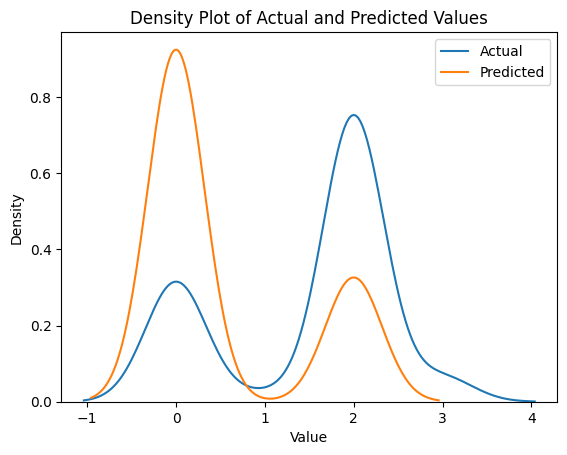

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(y_test, label='Actual')
sns.kdeplot(all_predictions, label='Predicted')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Actual and Predicted Values')
plt.show()


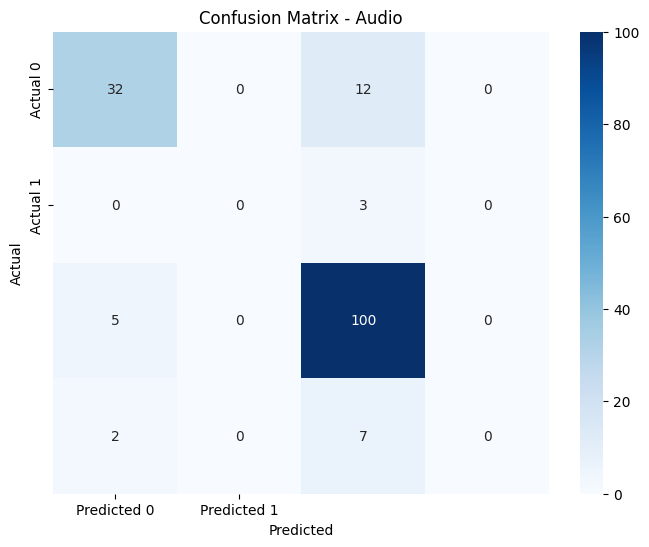

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Replace these lists with your predicted and expected results
predicted = all_predictions
expected = y_test

# Calculate confusion matrix
cma = confusion_matrix(expected, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Audio')
plt.show()


In [ ]:
predictions = model.predict(X_test).tolist()
print("Predictions:", predictions)
final_predictions = [np.argmax(pred) for pred in predictions]
print("Final Predictions:", final_predictions)
# print(y_test)

6/6 [==============================] - 0s 3ms/step
Predictions: [[0.9258917570114136, 0.008770192973315716, 0.05580025166273117, 0.009537816047668457], [0.9113696217536926, 0.01211792416870594, 0.06357491761445999, 0.012937543913722038], [0.8190139532089233, 0.016384148970246315, 0.14655239880084991, 0.01804942823946476], [0.8912135362625122, 0.015878919512033463, 0.07608548551797867, 0.016822082921862602], [0.4821494221687317, 0.02697063609957695, 0.4640633761882782, 0.026816584169864655], [0.09171289205551147, 0.07355351001024246, 0.7518398761749268, 0.08289376646280289], [0.114299476146698, 0.07512430101633072, 0.7187369465827942, 0.09183929860591888], [0.012905723415315151, 0.02293042466044426, 0.9242226481437683, 0.03994119167327881], [0.016309751197695732, 0.031565144658088684, 0.8919483423233032, 0.06017683446407318], [0.18213245272636414, 0.08017916977405548, 0.6537653207778931, 0.08392303436994553], [0.22190822660923004, 0.10786086320877075, 0.5230106115341187, 0.1472203135490

In [ ]:
cma


array([[39,  0,  5,  0],
       [ 3,  0,  0,  0],
       [72,  0, 33,  0],
       [ 5,  0,  4,  0]])

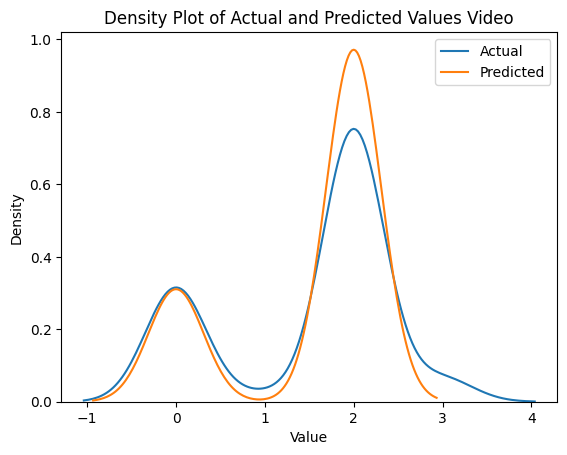

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(y_test, label='Actual')
sns.kdeplot(final_predictions, label='Predicted')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Actual and Predicted Values Video')
plt.show()


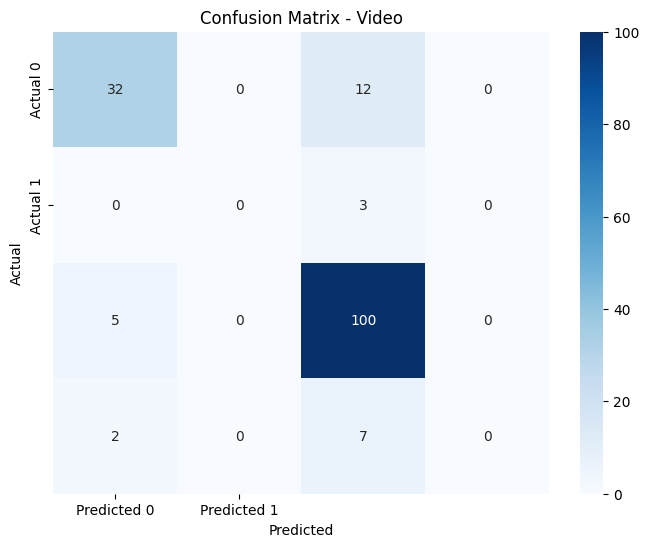

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Replace these lists with your predicted and expected results
predicted = final_predictions
expected = y_test

# Calculate confusion matrix
cmv = confusion_matrix(expected, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Video')
plt.show()


In [ ]:
cmv

array([[ 32,   0,  12,   0],
       [  0,   0,   3,   0],
       [  5,   0, 100,   0],
       [  2,   0,   7,   0]])

LATE FUSION

In [ ]:
# Two sets of predictions from audio and video data
predictions_audio = all_predictions
predictions_video = final_predictions

# Define weights
weight_video = 0.76
weight_audio = 0.24

# Perform late fusion with weighted averaging
predictions_fusion = [(weight_video * video + weight_audio * audio) / (weight_video + weight_audio) for audio, video in zip(predictions_audio, predictions_video)]

# Assuming predictions_fusion contains floating-point values representing labels
predictions_fusion_int = [int(round(label)) for label in predictions_fusion]

print(predictions_fusion_int)


[0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2]


In [ ]:
from sklearn.metrics import accuracy_score
true_labels = y_test
accuracy = accuracy_score(true_labels, np.array(predictions_fusion_int))
print("Late Fusion Accuracy: {:.2f}%".format(accuracy * 100))

Late Fusion Accuracy: 81.99%


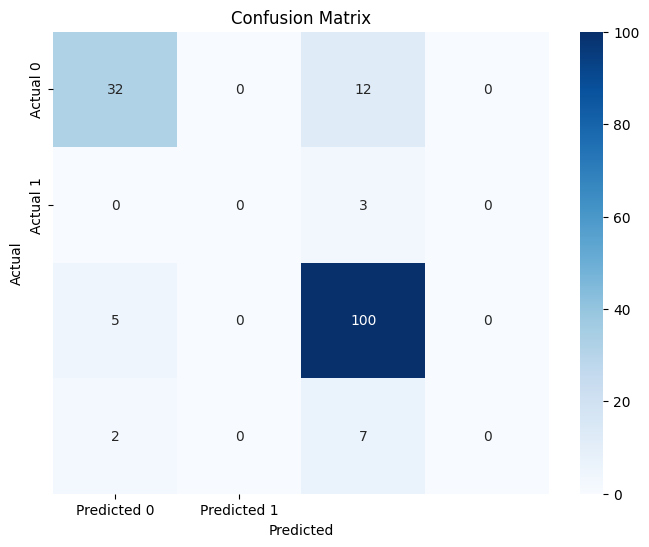

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Replace these lists with your predicted and expected results
predicted = predictions_fusion_int
expected = true_labels

# Calculate confusion matrix
cm = confusion_matrix(expected, predicted)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(cm)

[[ 32   0  12   0]
 [  0   0   3   0]
 [  5   0 100   0]
 [  2   0   7   0]]


In [ ]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(expected, predicted)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77        44
           1       0.00      0.00      0.00         3
           2       0.82      0.95      0.88       105
           3       0.00      0.00      0.00         9

    accuracy                           0.82       161
   macro avg       0.41      0.42      0.41       161
weighted avg       0.76      0.82      0.79       161



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


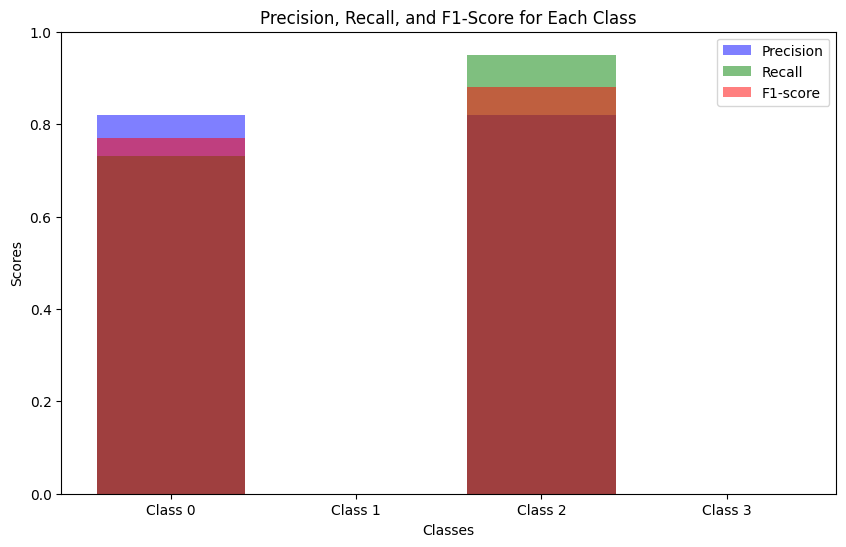

In [ ]:
import matplotlib.pyplot as plt

# Class labels
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Precision, recall, and F1-score values
precision = [0.82, 0.0, 0.82, 0.0]
recall = [0.73, 0.0, 0.95, 0.0]
f1_score = [0.77, 0.0, 0.88, 0.0]

# Plotting
plt.figure(figsize=(10, 6))

plt.bar(classes, precision, color='b', alpha=0.5, label='Precision')
plt.bar(classes, recall, color='g', alpha=0.5, label='Recall')
plt.bar(classes, f1_score, color='r', alpha=0.5, label='F1-score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.legend()
plt.ylim(0, 1)  # Setting y-axis limit to [0, 1] for better visualization of scores
plt.show()
